<a href="https://colab.research.google.com/github/bengisuycl/CMP719_TERM_PROJECT/blob/main/cycleGAN(rgb2ir)_bengisuyucel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision matplotlib scikit-image tqdm


In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

# Dataset path
rgb_path = '/content/drive/MyDrive/datasets/rgb_images'
ir_path  = '/content/drive/MyDrive/datasets/IR'

# Target dataset directories
os.makedirs('/content/drive/MyDrive/datasets/rgb2ir/trainA', exist_ok=True)
os.makedirs('/content/drive/MyDrive/datasets/rgb2ir/trainB', exist_ok=True)
os.makedirs('/content/drive/MyDrive/datasets/rgb2ir/testA', exist_ok=True)
os.makedirs('/content/drive/MyDrive/datasets/rgb2ir/testB', exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import glob, random, shutil

def split_and_copy_images(src_dir, train_dir, test_dir, split_ratio=0.8, limit=None):
    images = glob.glob(os.path.join(src_dir, '*.jpg')) + glob.glob(os.path.join(src_dir, '*.png'))
    if limit:
        images = random.sample(images, min(limit, len(images)))
    random.shuffle(images)
    split_point = int(len(images) * split_ratio)
    train_images = images[:split_point]
    test_images  = images[split_point:]

    for img in train_images:
        shutil.copy(img, train_dir)
    for img in test_images:
        shutil.copy(img, test_dir)

# RGB images: limit 5000 for balanced training
split_and_copy_images(rgb_path, '/content/drive/MyDrive/datasets/rgb2ir/trainA', '/content/drive/MyDrive/datasets/rgb2ir/testA', limit=5000)

# IR images: use all
split_and_copy_images(ir_path, '/content/drive/MyDrive/datasets/rgb2ir/trainB', '/content/drive/MyDrive/datasets/rgb2ir/testB')


In [ ]:
import torch
import torch.nn as nn

# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

# Generator
class Generator(nn.Module):
    def __init__(self, num_residual_blocks=9):
        super(Generator, self).__init__()

        model = []

        # Initial conv
        model += [
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]

        # Downsampling
        model += [
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        ]

        # Residual Blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(256)]

        # Upsampling
        model += [
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]

        # Output layer
        model += [
            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


Dataset class (Tensor dönüştürücü ve unpaired loader)

In [ ]:
from torch.utils.data import Dataset
import os
from PIL import Image

class UnpairedImageDataset(Dataset):
    def __init__(self, rootA, rootB, transform=None):
        self.files_A = os.listdir(rootA)
        self.files_B = os.listdir(rootB)
        self.rootA = rootA
        self.rootB = rootB
        self.transform = transform

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

    def __getitem__(self, index):
        img_A = Image.open(os.path.join(self.rootA, self.files_A[index % len(self.files_A)])).convert("RGB")
        img_B = Image.open(os.path.join(self.rootB, self.files_B[index % len(self.files_B)])).convert("RGB")

        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)

        return {'A': img_A, 'B': img_B}


In [ ]:
from torch.utils.data import Dataset
import os
from PIL import Image

class UnpairedImageDataset(Dataset):
    def __init__(self, rootA, rootB, transform=None):
        self.files_A = os.listdir(rootA)
        self.files_B = os.listdir(rootB)
        self.rootA = rootA
        self.rootB = rootB
        self.transform = transform

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

    def __getitem__(self, index):
        img_A = Image.open(os.path.join(self.rootA, self.files_A[index % len(self.files_A)])).convert("RGB")
        img_B = Image.open(os.path.join(self.rootB, self.files_B[index % len(self.files_B)])).convert("RGB")

        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)

        return {'A': img_A, 'B': img_B}


In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = UnpairedImageDataset('/content/drive/MyDrive/datasets/rgb2ir/trainA', '/content/drive/MyDrive/datasets/rgb2ir/trainB', transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)


In [ ]:
# Adversarial loss
criterion_GAN = nn.MSELoss().to(device)
# Cycle consistency loss
criterion_cycle = nn.L1Loss().to(device)
# Identity loss
criterion_identity = nn.L1Loss().to(device)

# Modelleri cihaza taşı
G_AB = Generator(num_residual_blocks=9).to(device)
G_BA = Generator(num_residual_blocks=9).to(device)


D_A = Discriminator(3).to(device)
D_B = Discriminator(3).to(device)

# Optimizerlar
lr = 0.0002
beta1 = 0.5
optimizer_G = torch.optim.Adam(list(G_AB.parameters()) + list(G_BA.parameters()), lr=lr, betas=(beta1, 0.999))
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
print(G_AB)

Generator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (8): ReLU(inplace=True)
    (9): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): InstanceNorm2d

In [ ]:
num_epochs = 100

for epoch in range(num_epochs):
    for i, batch in enumerate(tqdm(dataloader)):
        real_A = batch['A'].to(device)
        real_B = batch['B'].to(device)

        # --------------
        #  Train Generators
        # --------------
        optimizer_G.zero_grad()

        # Identity loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)
        loss_identity = (loss_id_A + loss_id_B) * 5.0

        # GAN loss
        fake_B = G_AB(real_A)
        pred_fake_B = D_B(fake_B)
        valid = torch.ones_like(pred_fake_B, device=device)
        loss_GAN_AB = criterion_GAN(pred_fake_B, valid)

        fake_A = G_BA(real_B)
        pred_fake_A = D_A(fake_A)
        valid = torch.ones_like(pred_fake_A, device=device)
        loss_GAN_BA = criterion_GAN(pred_fake_A, valid)

        # Cycle loss
        recov_A = G_BA(fake_B)
        recov_B = G_AB(fake_A)
        loss_cycle = (criterion_cycle(recov_A, real_A) + criterion_cycle(recov_B, real_B)) * 10.0

        # SSIM loss
        # Pass detached tensors to ssim_loss
        loss_ssim_A = ssim_loss(recov_A.detach(), real_A.detach())
        loss_ssim_B = ssim_loss(recov_B.detach(), real_B.detach())
        loss_ssim = (loss_ssim_A + loss_ssim_B) * 5.0


        # Total generator loss
        loss_G = loss_identity + loss_GAN_AB + loss_GAN_BA + loss_cycle + loss_ssim

        loss_G.backward()
        optimizer_G.step()

        # --------------
        #  Train Discriminators
        # --------------
        optimizer_D_A.zero_grad()
        pred_real_A = D_A(real_A)
        valid = torch.ones_like(pred_real_A, device=device)
        loss_real_A = criterion_GAN(pred_real_A, valid)

        pred_fake_A = D_A(fake_A.detach())
        fake = torch.zeros_like(pred_fake_A, device=device)
        loss_fake_A = criterion_GAN(pred_fake_A, fake)

        loss_D_A = (loss_real_A + loss_fake_A) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        optimizer_D_B.zero_grad()
        pred_real_B = D_B(real_B)
        valid = torch.ones_like(pred_real_B, device=device)
        loss_real_B = criterion_GAN(pred_real_B, valid)

        pred_fake_B = D_B(fake_B.detach())
        fake = torch.zeros_like(pred_fake_B, device=device)
        loss_fake_B = criterion_GAN(pred_fake_B, fake)

        loss_D_B = (loss_real_B + loss_fake_B) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch [{i}] Loss_G: {loss_G.item():.4f}, Loss_D_A: {loss_D_A.item():.4f}, Loss_D_B: {loss_D_B.item():.4f}")

    # Epoch sonu model kaydet
    torch.save(G_AB.state_dict(), f'G_AB_epoch{epoch}.pth')
    torch.save(G_BA.state_dict(), f'G_BA_epoch{epoch}.pth')

  0%|          | 2/4000 [00:00<18:42,  3.56it/s]

Epoch [0/100] Batch [0] Loss_G: 31.2627, Loss_D_A: 0.4242, Loss_D_B: 0.3380


  3%|▎         | 102/4000 [00:14<08:37,  7.54it/s]

Epoch [0/100] Batch [100] Loss_G: 14.2946, Loss_D_A: 0.1874, Loss_D_B: 0.2264


  5%|▌         | 202/4000 [00:29<08:31,  7.43it/s]

Epoch [0/100] Batch [200] Loss_G: 13.9338, Loss_D_A: 0.0493, Loss_D_B: 0.1352


  8%|▊         | 302/4000 [00:43<08:46,  7.03it/s]

Epoch [0/100] Batch [300] Loss_G: 13.3169, Loss_D_A: 0.0714, Loss_D_B: 0.1105


 10%|█         | 402/4000 [00:58<08:31,  7.04it/s]

Epoch [0/100] Batch [400] Loss_G: 10.6290, Loss_D_A: 0.2016, Loss_D_B: 0.1034


 13%|█▎        | 502/4000 [01:11<08:07,  7.17it/s]

Epoch [0/100] Batch [500] Loss_G: 12.9011, Loss_D_A: 0.1405, Loss_D_B: 0.3771


 15%|█▌        | 602/4000 [01:26<08:34,  6.61it/s]

Epoch [0/100] Batch [600] Loss_G: 14.3576, Loss_D_A: 0.0213, Loss_D_B: 0.1091


 18%|█▊        | 702/4000 [01:40<07:28,  7.35it/s]

Epoch [0/100] Batch [700] Loss_G: 9.8144, Loss_D_A: 0.0363, Loss_D_B: 0.0146


 20%|██        | 802/4000 [01:54<08:01,  6.64it/s]

Epoch [0/100] Batch [800] Loss_G: 13.1801, Loss_D_A: 0.1098, Loss_D_B: 0.1559


 23%|██▎       | 902/4000 [02:09<07:10,  7.20it/s]

Epoch [0/100] Batch [900] Loss_G: 16.0893, Loss_D_A: 0.0894, Loss_D_B: 0.1735


 25%|██▌       | 1002/4000 [02:23<07:26,  6.71it/s]

Epoch [0/100] Batch [1000] Loss_G: 13.2996, Loss_D_A: 0.0275, Loss_D_B: 0.0138


 28%|██▊       | 1102/4000 [02:37<06:42,  7.20it/s]

Epoch [0/100] Batch [1100] Loss_G: 8.4782, Loss_D_A: 0.0194, Loss_D_B: 0.0396


 30%|███       | 1202/4000 [02:52<06:35,  7.08it/s]

Epoch [0/100] Batch [1200] Loss_G: 10.7771, Loss_D_A: 0.0953, Loss_D_B: 0.2446


 33%|███▎      | 1302/4000 [03:06<06:12,  7.25it/s]

Epoch [0/100] Batch [1300] Loss_G: 13.5895, Loss_D_A: 0.0502, Loss_D_B: 0.0307


 35%|███▌      | 1402/4000 [03:20<06:11,  7.00it/s]

Epoch [0/100] Batch [1400] Loss_G: 11.5744, Loss_D_A: 0.2291, Loss_D_B: 0.0781


 38%|███▊      | 1502/4000 [03:34<06:31,  6.38it/s]

Epoch [0/100] Batch [1500] Loss_G: 16.6089, Loss_D_A: 0.2030, Loss_D_B: 0.1523


 40%|████      | 1602/4000 [03:48<05:48,  6.89it/s]

Epoch [0/100] Batch [1600] Loss_G: 9.0486, Loss_D_A: 0.1097, Loss_D_B: 0.0733


 43%|████▎     | 1702/4000 [04:03<05:49,  6.58it/s]

Epoch [0/100] Batch [1700] Loss_G: 7.8359, Loss_D_A: 0.2172, Loss_D_B: 0.0984


 45%|████▌     | 1802/4000 [04:17<04:51,  7.54it/s]

Epoch [0/100] Batch [1800] Loss_G: 8.1045, Loss_D_A: 0.2867, Loss_D_B: 0.0988


 48%|████▊     | 1902/4000 [04:31<04:57,  7.05it/s]

Epoch [0/100] Batch [1900] Loss_G: 8.4455, Loss_D_A: 0.1368, Loss_D_B: 0.0619


 50%|█████     | 2002/4000 [04:45<04:48,  6.92it/s]

Epoch [0/100] Batch [2000] Loss_G: 10.2314, Loss_D_A: 0.2362, Loss_D_B: 0.1281


 53%|█████▎    | 2102/4000 [04:59<04:28,  7.07it/s]

Epoch [0/100] Batch [2100] Loss_G: 10.2278, Loss_D_A: 0.3492, Loss_D_B: 0.1379


 55%|█████▌    | 2202/4000 [05:13<04:44,  6.32it/s]

Epoch [0/100] Batch [2200] Loss_G: 7.9435, Loss_D_A: 0.1216, Loss_D_B: 0.1190


 58%|█████▊    | 2302/4000 [05:28<03:50,  7.37it/s]

Epoch [0/100] Batch [2300] Loss_G: 8.2507, Loss_D_A: 0.0217, Loss_D_B: 0.0229


 60%|██████    | 2402/4000 [05:42<03:46,  7.05it/s]

Epoch [0/100] Batch [2400] Loss_G: 7.7991, Loss_D_A: 0.1675, Loss_D_B: 0.0615


 63%|██████▎   | 2502/4000 [05:56<03:38,  6.87it/s]

Epoch [0/100] Batch [2500] Loss_G: 15.6148, Loss_D_A: 0.3767, Loss_D_B: 0.0832


 65%|██████▌   | 2602/4000 [06:10<03:35,  6.48it/s]

Epoch [0/100] Batch [2600] Loss_G: 9.9608, Loss_D_A: 0.0339, Loss_D_B: 0.0502


 68%|██████▊   | 2702/4000 [06:25<03:09,  6.84it/s]

Epoch [0/100] Batch [2700] Loss_G: 9.3138, Loss_D_A: 0.1028, Loss_D_B: 0.0220


 70%|███████   | 2802/4000 [06:39<02:35,  7.69it/s]

Epoch [0/100] Batch [2800] Loss_G: 6.8646, Loss_D_A: 0.1497, Loss_D_B: 0.1740


 73%|███████▎  | 2902/4000 [06:53<02:36,  7.03it/s]

Epoch [0/100] Batch [2900] Loss_G: 13.5836, Loss_D_A: 0.0792, Loss_D_B: 0.2356


 75%|███████▌  | 3002/4000 [07:07<02:16,  7.31it/s]

Epoch [0/100] Batch [3000] Loss_G: 10.2990, Loss_D_A: 0.0419, Loss_D_B: 0.0811


 78%|███████▊  | 3102/4000 [07:21<02:05,  7.17it/s]

Epoch [0/100] Batch [3100] Loss_G: 8.8522, Loss_D_A: 0.0747, Loss_D_B: 0.0798


 80%|████████  | 3202/4000 [07:36<01:47,  7.43it/s]

Epoch [0/100] Batch [3200] Loss_G: 11.7583, Loss_D_A: 0.2043, Loss_D_B: 0.1388


 83%|████████▎ | 3302/4000 [07:49<01:40,  6.94it/s]

Epoch [0/100] Batch [3300] Loss_G: 7.9357, Loss_D_A: 0.1893, Loss_D_B: 0.3252


 85%|████████▌ | 3402/4000 [08:04<01:18,  7.65it/s]

Epoch [0/100] Batch [3400] Loss_G: 9.0167, Loss_D_A: 0.1989, Loss_D_B: 0.2166


 88%|████████▊ | 3502/4000 [08:18<01:11,  6.94it/s]

Epoch [0/100] Batch [3500] Loss_G: 8.3041, Loss_D_A: 0.0800, Loss_D_B: 0.0216


 90%|█████████ | 3602/4000 [08:32<00:56,  7.08it/s]

Epoch [0/100] Batch [3600] Loss_G: 8.9290, Loss_D_A: 0.0890, Loss_D_B: 0.1398


 93%|█████████▎| 3702/4000 [08:46<00:44,  6.73it/s]

Epoch [0/100] Batch [3700] Loss_G: 8.6874, Loss_D_A: 0.2309, Loss_D_B: 0.0359


 95%|█████████▌| 3802/4000 [09:01<00:29,  6.65it/s]

Epoch [0/100] Batch [3800] Loss_G: 6.6563, Loss_D_A: 0.1279, Loss_D_B: 0.1576


 98%|█████████▊| 3902/4000 [09:15<00:14,  6.96it/s]

Epoch [0/100] Batch [3900] Loss_G: 10.9684, Loss_D_A: 0.0606, Loss_D_B: 0.1248


  0%|          | 2/4000 [00:00<08:57,  7.44it/s]

Epoch [1/100] Batch [0] Loss_G: 7.6349, Loss_D_A: 0.0386, Loss_D_B: 0.1565


  3%|▎         | 102/4000 [00:14<09:35,  6.77it/s]

Epoch [1/100] Batch [100] Loss_G: 9.1726, Loss_D_A: 0.0319, Loss_D_B: 0.0076


  5%|▌         | 202/4000 [00:28<09:34,  6.62it/s]

Epoch [1/100] Batch [200] Loss_G: 6.1296, Loss_D_A: 0.0855, Loss_D_B: 0.0532


  8%|▊         | 302/4000 [00:43<09:06,  6.77it/s]

Epoch [1/100] Batch [300] Loss_G: 6.5016, Loss_D_A: 0.1901, Loss_D_B: 0.0541


 10%|█         | 402/4000 [00:57<07:55,  7.56it/s]

Epoch [1/100] Batch [400] Loss_G: 12.0777, Loss_D_A: 0.1297, Loss_D_B: 0.0365


 13%|█▎        | 502/4000 [01:11<08:26,  6.91it/s]

Epoch [1/100] Batch [500] Loss_G: 8.8278, Loss_D_A: 0.1065, Loss_D_B: 0.0633


 15%|█▌        | 602/4000 [01:25<08:30,  6.65it/s]

Epoch [1/100] Batch [600] Loss_G: 6.7066, Loss_D_A: 0.1397, Loss_D_B: 0.0778


 18%|█▊        | 702/4000 [01:39<07:41,  7.14it/s]

Epoch [1/100] Batch [700] Loss_G: 11.5553, Loss_D_A: 0.0509, Loss_D_B: 0.0637


 20%|██        | 802/4000 [01:53<07:19,  7.28it/s]

Epoch [1/100] Batch [800] Loss_G: 6.9136, Loss_D_A: 0.1024, Loss_D_B: 0.0260


 23%|██▎       | 902/4000 [02:07<06:39,  7.76it/s]

Epoch [1/100] Batch [900] Loss_G: 8.5103, Loss_D_A: 0.2739, Loss_D_B: 0.1529


 25%|██▌       | 1002/4000 [02:21<07:59,  6.26it/s]

Epoch [1/100] Batch [1000] Loss_G: 6.3173, Loss_D_A: 0.0894, Loss_D_B: 0.0371


 28%|██▊       | 1102/4000 [02:35<06:06,  7.90it/s]

Epoch [1/100] Batch [1100] Loss_G: 8.1621, Loss_D_A: 0.0289, Loss_D_B: 0.0760


 30%|███       | 1202/4000 [02:50<06:45,  6.90it/s]

Epoch [1/100] Batch [1200] Loss_G: 7.2727, Loss_D_A: 0.0911, Loss_D_B: 0.0451


 33%|███▎      | 1302/4000 [03:04<06:22,  7.06it/s]

Epoch [1/100] Batch [1300] Loss_G: 7.3462, Loss_D_A: 0.0608, Loss_D_B: 0.0742


 35%|███▌      | 1402/4000 [03:18<06:06,  7.10it/s]

Epoch [1/100] Batch [1400] Loss_G: 6.9381, Loss_D_A: 0.0474, Loss_D_B: 0.0290


 38%|███▊      | 1502/4000 [03:32<05:29,  7.57it/s]

Epoch [1/100] Batch [1500] Loss_G: 10.6239, Loss_D_A: 0.1338, Loss_D_B: 0.0204


 40%|████      | 1602/4000 [03:46<05:37,  7.10it/s]

Epoch [1/100] Batch [1600] Loss_G: 14.4271, Loss_D_A: 0.2830, Loss_D_B: 0.1388


 43%|████▎     | 1702/4000 [04:01<05:35,  6.84it/s]

Epoch [1/100] Batch [1700] Loss_G: 5.8825, Loss_D_A: 0.1036, Loss_D_B: 0.0718


 45%|████▌     | 1802/4000 [04:15<04:59,  7.35it/s]

Epoch [1/100] Batch [1800] Loss_G: 7.4687, Loss_D_A: 0.0725, Loss_D_B: 0.0729


 48%|████▊     | 1902/4000 [04:29<04:47,  7.29it/s]

Epoch [1/100] Batch [1900] Loss_G: 7.7266, Loss_D_A: 0.0747, Loss_D_B: 0.0611


 50%|█████     | 2002/4000 [04:44<05:15,  6.34it/s]

Epoch [1/100] Batch [2000] Loss_G: 5.8378, Loss_D_A: 0.2500, Loss_D_B: 0.1032


 53%|█████▎    | 2102/4000 [04:58<04:24,  7.17it/s]

Epoch [1/100] Batch [2100] Loss_G: 7.0015, Loss_D_A: 0.0545, Loss_D_B: 0.0391


 55%|█████▌    | 2202/4000 [05:12<04:05,  7.33it/s]

Epoch [1/100] Batch [2200] Loss_G: 8.0686, Loss_D_A: 0.1536, Loss_D_B: 0.0554


 58%|█████▊    | 2302/4000 [05:26<03:50,  7.38it/s]

Epoch [1/100] Batch [2300] Loss_G: 7.9137, Loss_D_A: 0.3264, Loss_D_B: 0.1894


 60%|██████    | 2402/4000 [05:41<04:06,  6.48it/s]

Epoch [1/100] Batch [2400] Loss_G: 6.4648, Loss_D_A: 0.0730, Loss_D_B: 0.0316


 63%|██████▎   | 2502/4000 [05:55<03:31,  7.07it/s]

Epoch [1/100] Batch [2500] Loss_G: 10.0271, Loss_D_A: 0.0775, Loss_D_B: 0.0440


 65%|██████▌   | 2602/4000 [06:09<03:08,  7.40it/s]

Epoch [1/100] Batch [2600] Loss_G: 8.8071, Loss_D_A: 0.0588, Loss_D_B: 0.1002


 68%|██████▊   | 2702/4000 [06:23<03:06,  6.97it/s]

Epoch [1/100] Batch [2700] Loss_G: 7.6175, Loss_D_A: 0.1094, Loss_D_B: 0.0936


 70%|███████   | 2802/4000 [06:38<02:43,  7.31it/s]

Epoch [1/100] Batch [2800] Loss_G: 9.7785, Loss_D_A: 0.0351, Loss_D_B: 0.0153


 73%|███████▎  | 2902/4000 [06:52<02:31,  7.26it/s]

Epoch [1/100] Batch [2900] Loss_G: 7.6132, Loss_D_A: 0.0834, Loss_D_B: 0.0997


 75%|███████▌  | 3002/4000 [07:06<02:12,  7.51it/s]

Epoch [1/100] Batch [3000] Loss_G: 5.0604, Loss_D_A: 0.1416, Loss_D_B: 0.2194


 78%|███████▊  | 3102/4000 [07:20<01:59,  7.52it/s]

Epoch [1/100] Batch [3100] Loss_G: 8.9629, Loss_D_A: 0.0658, Loss_D_B: 0.0846


 80%|████████  | 3202/4000 [07:34<01:51,  7.15it/s]

Epoch [1/100] Batch [3200] Loss_G: 6.3728, Loss_D_A: 0.0625, Loss_D_B: 0.0240


 83%|████████▎ | 3302/4000 [07:49<01:36,  7.24it/s]

Epoch [1/100] Batch [3300] Loss_G: 6.7446, Loss_D_A: 0.0623, Loss_D_B: 0.0369


 85%|████████▌ | 3402/4000 [08:03<01:22,  7.28it/s]

Epoch [1/100] Batch [3400] Loss_G: 7.8158, Loss_D_A: 0.1467, Loss_D_B: 0.0932


 88%|████████▊ | 3502/4000 [08:17<01:07,  7.36it/s]

Epoch [1/100] Batch [3500] Loss_G: 7.2276, Loss_D_A: 0.0349, Loss_D_B: 0.0123


 90%|█████████ | 3602/4000 [08:31<00:54,  7.32it/s]

Epoch [1/100] Batch [3600] Loss_G: 7.7784, Loss_D_A: 0.0421, Loss_D_B: 0.0472


 93%|█████████▎| 3702/4000 [08:45<00:44,  6.63it/s]

Epoch [1/100] Batch [3700] Loss_G: 7.4898, Loss_D_A: 0.0516, Loss_D_B: 0.0279


 95%|█████████▌| 3802/4000 [09:00<00:30,  6.50it/s]

Epoch [1/100] Batch [3800] Loss_G: 8.4101, Loss_D_A: 0.2400, Loss_D_B: 0.1055


 98%|█████████▊| 3902/4000 [09:14<00:14,  6.74it/s]

Epoch [1/100] Batch [3900] Loss_G: 8.2517, Loss_D_A: 0.0468, Loss_D_B: 0.0932


  0%|          | 2/4000 [00:00<08:45,  7.60it/s]

Epoch [2/100] Batch [0] Loss_G: 5.5815, Loss_D_A: 0.0660, Loss_D_B: 0.1071


  3%|▎         | 102/4000 [00:14<09:22,  6.93it/s]

Epoch [2/100] Batch [100] Loss_G: 8.2343, Loss_D_A: 0.1904, Loss_D_B: 0.0739


  5%|▌         | 202/4000 [00:29<09:49,  6.44it/s]

Epoch [2/100] Batch [200] Loss_G: 7.1010, Loss_D_A: 0.0278, Loss_D_B: 0.0282


  8%|▊         | 302/4000 [00:43<08:09,  7.55it/s]

Epoch [2/100] Batch [300] Loss_G: 7.2015, Loss_D_A: 0.1146, Loss_D_B: 0.1310


 10%|█         | 402/4000 [00:58<08:09,  7.34it/s]

Epoch [2/100] Batch [400] Loss_G: 6.0684, Loss_D_A: 0.3344, Loss_D_B: 0.0463


 13%|█▎        | 502/4000 [01:12<08:00,  7.28it/s]

Epoch [2/100] Batch [500] Loss_G: 6.0247, Loss_D_A: 0.1273, Loss_D_B: 0.0510


 15%|█▌        | 602/4000 [01:26<07:47,  7.27it/s]

Epoch [2/100] Batch [600] Loss_G: 10.9820, Loss_D_A: 0.0840, Loss_D_B: 0.0953


 18%|█▊        | 702/4000 [01:40<08:10,  6.73it/s]

Epoch [2/100] Batch [700] Loss_G: 8.2148, Loss_D_A: 0.1264, Loss_D_B: 0.1553


 20%|██        | 802/4000 [01:55<07:52,  6.77it/s]

Epoch [2/100] Batch [800] Loss_G: 7.6000, Loss_D_A: 0.0923, Loss_D_B: 0.0314


 23%|██▎       | 902/4000 [02:09<06:51,  7.53it/s]

Epoch [2/100] Batch [900] Loss_G: 5.2916, Loss_D_A: 0.1798, Loss_D_B: 0.0881


 25%|██▌       | 1002/4000 [02:23<06:55,  7.22it/s]

Epoch [2/100] Batch [1000] Loss_G: 6.3733, Loss_D_A: 0.1660, Loss_D_B: 0.0532


 28%|██▊       | 1102/4000 [02:38<06:53,  7.00it/s]

Epoch [2/100] Batch [1100] Loss_G: 8.8453, Loss_D_A: 0.2064, Loss_D_B: 0.0212


 30%|███       | 1202/4000 [02:52<06:28,  7.20it/s]

Epoch [2/100] Batch [1200] Loss_G: 10.1580, Loss_D_A: 0.0728, Loss_D_B: 0.1180


 33%|███▎      | 1302/4000 [03:06<06:22,  7.05it/s]

Epoch [2/100] Batch [1300] Loss_G: 7.9302, Loss_D_A: 0.0890, Loss_D_B: 0.0132


 35%|███▌      | 1402/4000 [03:21<06:27,  6.70it/s]

Epoch [2/100] Batch [1400] Loss_G: 6.7391, Loss_D_A: 0.1329, Loss_D_B: 0.0929


 38%|███▊      | 1502/4000 [03:38<06:18,  6.59it/s]

Epoch [2/100] Batch [1500] Loss_G: 5.3702, Loss_D_A: 0.0493, Loss_D_B: 0.1454


 40%|████      | 1602/4000 [03:56<05:56,  6.73it/s]

Epoch [2/100] Batch [1600] Loss_G: 5.6019, Loss_D_A: 0.2633, Loss_D_B: 0.0595


 43%|████▎     | 1702/4000 [04:11<06:03,  6.32it/s]

Epoch [2/100] Batch [1700] Loss_G: 6.2052, Loss_D_A: 0.2070, Loss_D_B: 0.0474


 45%|████▌     | 1802/4000 [04:26<05:13,  7.00it/s]

Epoch [2/100] Batch [1800] Loss_G: 9.4897, Loss_D_A: 0.0585, Loss_D_B: 0.0391


 48%|████▊     | 1902/4000 [04:41<04:56,  7.08it/s]

Epoch [2/100] Batch [1900] Loss_G: 7.8305, Loss_D_A: 0.1240, Loss_D_B: 0.0237


 50%|█████     | 2002/4000 [04:55<04:38,  7.17it/s]

Epoch [2/100] Batch [2000] Loss_G: 8.3056, Loss_D_A: 0.0593, Loss_D_B: 0.0874


 53%|█████▎    | 2102/4000 [05:10<04:23,  7.20it/s]

Epoch [2/100] Batch [2100] Loss_G: 8.7906, Loss_D_A: 0.0664, Loss_D_B: 0.2881


 55%|█████▌    | 2202/4000 [05:25<03:50,  7.80it/s]

Epoch [2/100] Batch [2200] Loss_G: 7.7306, Loss_D_A: 0.0398, Loss_D_B: 0.1138


 58%|█████▊    | 2302/4000 [05:40<03:52,  7.31it/s]

Epoch [2/100] Batch [2300] Loss_G: 5.5989, Loss_D_A: 0.1285, Loss_D_B: 0.0255


 60%|██████    | 2402/4000 [05:55<03:47,  7.01it/s]

Epoch [2/100] Batch [2400] Loss_G: 5.6191, Loss_D_A: 0.2278, Loss_D_B: 0.1119


 63%|██████▎   | 2502/4000 [06:10<03:36,  6.91it/s]

Epoch [2/100] Batch [2500] Loss_G: 5.9479, Loss_D_A: 0.2295, Loss_D_B: 0.0501


 65%|██████▌   | 2602/4000 [06:23<03:20,  6.98it/s]

Epoch [2/100] Batch [2600] Loss_G: 5.9325, Loss_D_A: 0.0416, Loss_D_B: 0.0473


 68%|██████▊   | 2702/4000 [06:38<02:57,  7.31it/s]

Epoch [2/100] Batch [2700] Loss_G: 5.7956, Loss_D_A: 0.1054, Loss_D_B: 0.0996


 70%|███████   | 2802/4000 [06:52<02:47,  7.13it/s]

Epoch [2/100] Batch [2800] Loss_G: 4.4078, Loss_D_A: 0.2153, Loss_D_B: 0.1037


 73%|███████▎  | 2902/4000 [07:06<02:31,  7.23it/s]

Epoch [2/100] Batch [2900] Loss_G: 5.2457, Loss_D_A: 0.0306, Loss_D_B: 0.0778


 75%|███████▌  | 3002/4000 [07:20<02:19,  7.17it/s]

Epoch [2/100] Batch [3000] Loss_G: 4.4921, Loss_D_A: 0.0753, Loss_D_B: 0.0519


 78%|███████▊  | 3102/4000 [07:34<02:04,  7.20it/s]

Epoch [2/100] Batch [3100] Loss_G: 5.4876, Loss_D_A: 0.2281, Loss_D_B: 0.0129


 80%|████████  | 3202/4000 [07:49<01:52,  7.11it/s]

Epoch [2/100] Batch [3200] Loss_G: 6.2649, Loss_D_A: 0.1624, Loss_D_B: 0.1406


 83%|████████▎ | 3302/4000 [08:03<01:40,  6.94it/s]

Epoch [2/100] Batch [3300] Loss_G: 7.2455, Loss_D_A: 0.0573, Loss_D_B: 0.0273


 85%|████████▌ | 3402/4000 [08:18<01:22,  7.21it/s]

Epoch [2/100] Batch [3400] Loss_G: 6.5917, Loss_D_A: 0.0958, Loss_D_B: 0.0846


 88%|████████▊ | 3502/4000 [08:32<01:03,  7.90it/s]

Epoch [2/100] Batch [3500] Loss_G: 7.2827, Loss_D_A: 0.0743, Loss_D_B: 0.0956


 90%|█████████ | 3602/4000 [08:46<00:52,  7.57it/s]

Epoch [2/100] Batch [3600] Loss_G: 5.8540, Loss_D_A: 0.0681, Loss_D_B: 0.0991


 93%|█████████▎| 3702/4000 [09:00<00:44,  6.63it/s]

Epoch [2/100] Batch [3700] Loss_G: 5.9741, Loss_D_A: 0.1381, Loss_D_B: 0.0223


 95%|█████████▌| 3802/4000 [09:14<00:28,  6.92it/s]

Epoch [2/100] Batch [3800] Loss_G: 5.3811, Loss_D_A: 0.1754, Loss_D_B: 0.0826


 98%|█████████▊| 3902/4000 [09:29<00:15,  6.22it/s]

Epoch [2/100] Batch [3900] Loss_G: 5.4353, Loss_D_A: 0.0512, Loss_D_B: 0.0404


  0%|          | 2/4000 [00:00<08:03,  8.27it/s]

Epoch [3/100] Batch [0] Loss_G: 6.6582, Loss_D_A: 0.1120, Loss_D_B: 0.0816


  3%|▎         | 102/4000 [00:14<08:53,  7.30it/s]

Epoch [3/100] Batch [100] Loss_G: 5.5189, Loss_D_A: 0.1798, Loss_D_B: 0.2740


  5%|▌         | 202/4000 [00:28<08:56,  7.07it/s]

Epoch [3/100] Batch [200] Loss_G: 5.3780, Loss_D_A: 0.0999, Loss_D_B: 0.0430


  8%|▊         | 302/4000 [00:42<07:45,  7.95it/s]

Epoch [3/100] Batch [300] Loss_G: 7.0965, Loss_D_A: 0.1210, Loss_D_B: 0.0344


 10%|█         | 402/4000 [00:56<08:31,  7.04it/s]

Epoch [3/100] Batch [400] Loss_G: 8.1671, Loss_D_A: 0.0425, Loss_D_B: 0.0355


 13%|█▎        | 502/4000 [01:10<08:36,  6.78it/s]

Epoch [3/100] Batch [500] Loss_G: 6.2157, Loss_D_A: 0.0849, Loss_D_B: 0.0274


 15%|█▌        | 602/4000 [01:24<08:02,  7.05it/s]

Epoch [3/100] Batch [600] Loss_G: 7.9126, Loss_D_A: 0.1603, Loss_D_B: 0.0354


 18%|█▊        | 702/4000 [01:39<08:25,  6.52it/s]

Epoch [3/100] Batch [700] Loss_G: 6.2639, Loss_D_A: 0.0655, Loss_D_B: 0.0135


 20%|██        | 802/4000 [01:53<07:18,  7.29it/s]

Epoch [3/100] Batch [800] Loss_G: 5.3839, Loss_D_A: 0.2593, Loss_D_B: 0.0167


 23%|██▎       | 902/4000 [02:07<07:18,  7.06it/s]

Epoch [3/100] Batch [900] Loss_G: 7.5987, Loss_D_A: 0.2331, Loss_D_B: 0.0712


 25%|██▌       | 1002/4000 [02:22<07:15,  6.89it/s]

Epoch [3/100] Batch [1000] Loss_G: 6.9442, Loss_D_A: 0.1769, Loss_D_B: 0.0710


 28%|██▊       | 1102/4000 [02:36<06:37,  7.29it/s]

Epoch [3/100] Batch [1100] Loss_G: 6.0845, Loss_D_A: 0.1255, Loss_D_B: 0.0544


 30%|███       | 1202/4000 [02:50<06:33,  7.12it/s]

Epoch [3/100] Batch [1200] Loss_G: 6.1446, Loss_D_A: 0.0274, Loss_D_B: 0.0728


 33%|███▎      | 1302/4000 [03:04<05:57,  7.55it/s]

Epoch [3/100] Batch [1300] Loss_G: 5.6124, Loss_D_A: 0.0484, Loss_D_B: 0.0422


 35%|███▌      | 1402/4000 [03:18<06:04,  7.13it/s]

Epoch [3/100] Batch [1400] Loss_G: 5.3319, Loss_D_A: 0.1794, Loss_D_B: 0.0277


 38%|███▊      | 1502/4000 [03:32<06:00,  6.94it/s]

Epoch [3/100] Batch [1500] Loss_G: 7.2968, Loss_D_A: 0.1212, Loss_D_B: 0.0460


 40%|████      | 1602/4000 [03:47<05:34,  7.16it/s]

Epoch [3/100] Batch [1600] Loss_G: 6.5109, Loss_D_A: 0.1207, Loss_D_B: 0.0543


 43%|████▎     | 1702/4000 [04:01<05:07,  7.47it/s]

Epoch [3/100] Batch [1700] Loss_G: 6.9837, Loss_D_A: 0.0466, Loss_D_B: 0.0645


 45%|████▌     | 1802/4000 [04:15<05:07,  7.15it/s]

Epoch [3/100] Batch [1800] Loss_G: 8.4008, Loss_D_A: 0.1145, Loss_D_B: 0.0164


 48%|████▊     | 1902/4000 [04:29<05:04,  6.88it/s]

Epoch [3/100] Batch [1900] Loss_G: 6.0433, Loss_D_A: 0.2992, Loss_D_B: 0.0183


 50%|█████     | 2002/4000 [04:43<05:26,  6.12it/s]

Epoch [3/100] Batch [2000] Loss_G: 6.2373, Loss_D_A: 0.1750, Loss_D_B: 0.0469


 53%|█████▎    | 2102/4000 [04:58<04:50,  6.53it/s]

Epoch [3/100] Batch [2100] Loss_G: 6.3190, Loss_D_A: 0.0422, Loss_D_B: 0.0167


 55%|█████▌    | 2202/4000 [05:12<04:28,  6.70it/s]

Epoch [3/100] Batch [2200] Loss_G: 4.9870, Loss_D_A: 0.1496, Loss_D_B: 0.0176


 58%|█████▊    | 2302/4000 [05:26<04:18,  6.57it/s]

Epoch [3/100] Batch [2300] Loss_G: 7.9487, Loss_D_A: 0.1133, Loss_D_B: 0.0179


 60%|██████    | 2402/4000 [05:40<03:44,  7.13it/s]

Epoch [3/100] Batch [2400] Loss_G: 5.6451, Loss_D_A: 0.2083, Loss_D_B: 0.0396


 63%|██████▎   | 2502/4000 [05:54<03:18,  7.56it/s]

Epoch [3/100] Batch [2500] Loss_G: 6.7400, Loss_D_A: 0.1561, Loss_D_B: 0.1492


 65%|██████▌   | 2602/4000 [06:08<03:06,  7.50it/s]

Epoch [3/100] Batch [2600] Loss_G: 8.4034, Loss_D_A: 0.1426, Loss_D_B: 0.0657


 68%|██████▊   | 2702/4000 [06:22<02:59,  7.24it/s]

Epoch [3/100] Batch [2700] Loss_G: 9.1618, Loss_D_A: 0.0119, Loss_D_B: 0.0257


 70%|███████   | 2802/4000 [06:37<02:45,  7.23it/s]

Epoch [3/100] Batch [2800] Loss_G: 6.8670, Loss_D_A: 0.0450, Loss_D_B: 0.0309


 73%|███████▎  | 2902/4000 [06:51<02:30,  7.30it/s]

Epoch [3/100] Batch [2900] Loss_G: 6.0581, Loss_D_A: 0.0862, Loss_D_B: 0.0629


 75%|███████▌  | 3002/4000 [07:05<02:50,  5.87it/s]

Epoch [3/100] Batch [3000] Loss_G: 7.4110, Loss_D_A: 0.1421, Loss_D_B: 0.0163


 78%|███████▊  | 3102/4000 [07:19<02:10,  6.87it/s]

Epoch [3/100] Batch [3100] Loss_G: 7.0437, Loss_D_A: 0.2308, Loss_D_B: 0.0201


 80%|████████  | 3202/4000 [07:33<01:51,  7.16it/s]

Epoch [3/100] Batch [3200] Loss_G: 5.2280, Loss_D_A: 0.1733, Loss_D_B: 0.0343


 83%|████████▎ | 3302/4000 [07:47<01:31,  7.59it/s]

Epoch [3/100] Batch [3300] Loss_G: 7.6687, Loss_D_A: 0.3293, Loss_D_B: 0.2141


 85%|████████▌ | 3402/4000 [08:02<01:31,  6.51it/s]

Epoch [3/100] Batch [3400] Loss_G: 4.8431, Loss_D_A: 0.1299, Loss_D_B: 0.0327


 88%|████████▊ | 3502/4000 [08:17<01:19,  6.28it/s]

Epoch [3/100] Batch [3500] Loss_G: 6.6927, Loss_D_A: 0.2436, Loss_D_B: 0.0205


 90%|█████████ | 3602/4000 [08:31<00:52,  7.56it/s]

Epoch [3/100] Batch [3600] Loss_G: 8.8593, Loss_D_A: 0.2765, Loss_D_B: 0.0235


 93%|█████████▎| 3702/4000 [08:45<00:45,  6.55it/s]

Epoch [3/100] Batch [3700] Loss_G: 6.9442, Loss_D_A: 0.0679, Loss_D_B: 0.0581


 95%|█████████▌| 3802/4000 [08:59<00:26,  7.49it/s]

Epoch [3/100] Batch [3800] Loss_G: 5.6386, Loss_D_A: 0.1156, Loss_D_B: 0.0212


 98%|█████████▊| 3902/4000 [09:13<00:13,  7.04it/s]

Epoch [3/100] Batch [3900] Loss_G: 5.7615, Loss_D_A: 0.0397, Loss_D_B: 0.0219


  0%|          | 2/4000 [00:00<09:24,  7.08it/s]

Epoch [4/100] Batch [0] Loss_G: 6.2477, Loss_D_A: 0.0618, Loss_D_B: 0.0627


  3%|▎         | 102/4000 [00:14<09:13,  7.04it/s]

Epoch [4/100] Batch [100] Loss_G: 8.3061, Loss_D_A: 0.0182, Loss_D_B: 0.0494


  5%|▌         | 202/4000 [00:28<09:01,  7.01it/s]

Epoch [4/100] Batch [200] Loss_G: 5.8856, Loss_D_A: 0.1186, Loss_D_B: 0.0455


  8%|▊         | 302/4000 [00:42<09:06,  6.76it/s]

Epoch [4/100] Batch [300] Loss_G: 5.8645, Loss_D_A: 0.3785, Loss_D_B: 0.0677


 10%|█         | 402/4000 [00:56<09:01,  6.64it/s]

Epoch [4/100] Batch [400] Loss_G: 4.8819, Loss_D_A: 0.0273, Loss_D_B: 0.0300


 13%|█▎        | 502/4000 [01:11<08:00,  7.28it/s]

Epoch [4/100] Batch [500] Loss_G: 7.8995, Loss_D_A: 0.0439, Loss_D_B: 0.0649


 15%|█▌        | 602/4000 [01:25<08:00,  7.07it/s]

Epoch [4/100] Batch [600] Loss_G: 4.9553, Loss_D_A: 0.1211, Loss_D_B: 0.0135


 18%|█▊        | 702/4000 [01:40<08:16,  6.65it/s]

Epoch [4/100] Batch [700] Loss_G: 4.3455, Loss_D_A: 0.0735, Loss_D_B: 0.0165


 20%|██        | 802/4000 [01:54<07:33,  7.05it/s]

Epoch [4/100] Batch [800] Loss_G: 5.6674, Loss_D_A: 0.0207, Loss_D_B: 0.0152


 23%|██▎       | 902/4000 [02:09<07:39,  6.75it/s]

Epoch [4/100] Batch [900] Loss_G: 6.2459, Loss_D_A: 0.1273, Loss_D_B: 0.1446


 25%|██▌       | 1002/4000 [02:23<07:28,  6.69it/s]

Epoch [4/100] Batch [1000] Loss_G: 8.5166, Loss_D_A: 0.0400, Loss_D_B: 0.0294


 28%|██▊       | 1102/4000 [02:38<06:55,  6.98it/s]

Epoch [4/100] Batch [1100] Loss_G: 5.9971, Loss_D_A: 0.4340, Loss_D_B: 0.0432


 30%|███       | 1202/4000 [02:52<07:19,  6.37it/s]

Epoch [4/100] Batch [1200] Loss_G: 6.3312, Loss_D_A: 0.2171, Loss_D_B: 0.0610


 33%|███▎      | 1302/4000 [03:06<06:19,  7.12it/s]

Epoch [4/100] Batch [1300] Loss_G: 9.1340, Loss_D_A: 0.1209, Loss_D_B: 0.0321


 35%|███▌      | 1402/4000 [03:20<06:11,  6.99it/s]

Epoch [4/100] Batch [1400] Loss_G: 4.6563, Loss_D_A: 0.1095, Loss_D_B: 0.0313


 38%|███▊      | 1502/4000 [03:35<05:49,  7.15it/s]

Epoch [4/100] Batch [1500] Loss_G: 5.2010, Loss_D_A: 0.1764, Loss_D_B: 0.0191


 40%|████      | 1602/4000 [03:49<05:35,  7.15it/s]

Epoch [4/100] Batch [1600] Loss_G: 6.8656, Loss_D_A: 0.1497, Loss_D_B: 0.0289


 43%|████▎     | 1702/4000 [04:03<05:24,  7.09it/s]

Epoch [4/100] Batch [1700] Loss_G: 4.5160, Loss_D_A: 0.0370, Loss_D_B: 0.0511


 45%|████▌     | 1801/4000 [04:17<05:06,  7.18it/s]

Epoch [4/100] Batch [1800] Loss_G: 9.1558, Loss_D_A: 0.0920, Loss_D_B: 0.0477


 48%|████▊     | 1902/4000 [04:31<05:00,  6.98it/s]

Epoch [4/100] Batch [1900] Loss_G: 6.6858, Loss_D_A: 0.1232, Loss_D_B: 0.0659


 50%|█████     | 2002/4000 [04:45<04:58,  6.69it/s]

Epoch [4/100] Batch [2000] Loss_G: 5.7341, Loss_D_A: 0.1762, Loss_D_B: 0.0514


 53%|█████▎    | 2102/4000 [04:59<04:45,  6.65it/s]

Epoch [4/100] Batch [2100] Loss_G: 4.1784, Loss_D_A: 0.2079, Loss_D_B: 0.1870


 55%|█████▌    | 2202/4000 [05:13<04:12,  7.13it/s]

Epoch [4/100] Batch [2200] Loss_G: 6.6698, Loss_D_A: 0.2199, Loss_D_B: 0.0838


 58%|█████▊    | 2302/4000 [05:27<03:52,  7.29it/s]

Epoch [4/100] Batch [2300] Loss_G: 5.5744, Loss_D_A: 0.2786, Loss_D_B: 0.0791


 60%|██████    | 2402/4000 [05:41<03:28,  7.67it/s]

Epoch [4/100] Batch [2400] Loss_G: 5.1422, Loss_D_A: 0.1004, Loss_D_B: 0.0365


 63%|██████▎   | 2502/4000 [05:56<03:18,  7.55it/s]

Epoch [4/100] Batch [2500] Loss_G: 7.3755, Loss_D_A: 0.3999, Loss_D_B: 0.0140


 65%|██████▌   | 2602/4000 [06:10<03:29,  6.69it/s]

Epoch [4/100] Batch [2600] Loss_G: 7.5335, Loss_D_A: 0.1573, Loss_D_B: 0.0263


 68%|██████▊   | 2702/4000 [06:24<02:55,  7.41it/s]

Epoch [4/100] Batch [2700] Loss_G: 5.4757, Loss_D_A: 0.1035, Loss_D_B: 0.0278


 70%|███████   | 2802/4000 [06:38<02:32,  7.84it/s]

Epoch [4/100] Batch [2800] Loss_G: 5.6630, Loss_D_A: 0.0820, Loss_D_B: 0.0256


 73%|███████▎  | 2902/4000 [06:53<02:40,  6.84it/s]

Epoch [4/100] Batch [2900] Loss_G: 7.3538, Loss_D_A: 0.0663, Loss_D_B: 0.0376


 75%|███████▌  | 3002/4000 [07:07<02:17,  7.24it/s]

Epoch [4/100] Batch [3000] Loss_G: 6.3117, Loss_D_A: 0.1726, Loss_D_B: 0.0187


 78%|███████▊  | 3102/4000 [07:22<02:05,  7.17it/s]

Epoch [4/100] Batch [3100] Loss_G: 8.1087, Loss_D_A: 0.1521, Loss_D_B: 0.0270


 80%|████████  | 3202/4000 [07:37<01:53,  7.05it/s]

Epoch [4/100] Batch [3200] Loss_G: 6.1879, Loss_D_A: 0.3068, Loss_D_B: 0.0381


 83%|████████▎ | 3302/4000 [07:51<01:42,  6.79it/s]

Epoch [4/100] Batch [3300] Loss_G: 7.1955, Loss_D_A: 0.1261, Loss_D_B: 0.0118


 85%|████████▌ | 3402/4000 [08:05<01:39,  6.03it/s]

Epoch [4/100] Batch [3400] Loss_G: 7.0947, Loss_D_A: 0.2114, Loss_D_B: 0.1020


 88%|████████▊ | 3502/4000 [08:20<01:25,  5.81it/s]

Epoch [4/100] Batch [3500] Loss_G: 5.1808, Loss_D_A: 0.1350, Loss_D_B: 0.0170


 90%|█████████ | 3602/4000 [08:34<00:50,  7.84it/s]

Epoch [4/100] Batch [3600] Loss_G: 8.1436, Loss_D_A: 0.0856, Loss_D_B: 0.0260


 93%|█████████▎| 3702/4000 [08:47<00:42,  7.03it/s]

Epoch [4/100] Batch [3700] Loss_G: 4.7950, Loss_D_A: 0.0521, Loss_D_B: 0.0301


 95%|█████████▌| 3802/4000 [09:01<00:26,  7.45it/s]

Epoch [4/100] Batch [3800] Loss_G: 5.2563, Loss_D_A: 0.0870, Loss_D_B: 0.0464


 98%|█████████▊| 3902/4000 [09:16<00:14,  6.93it/s]

Epoch [4/100] Batch [3900] Loss_G: 5.1001, Loss_D_A: 0.0829, Loss_D_B: 0.0398


  0%|          | 2/4000 [00:00<09:57,  6.69it/s]

Epoch [5/100] Batch [0] Loss_G: 5.1291, Loss_D_A: 0.2059, Loss_D_B: 0.0422


  3%|▎         | 102/4000 [00:14<09:34,  6.78it/s]

Epoch [5/100] Batch [100] Loss_G: 6.6152, Loss_D_A: 0.0988, Loss_D_B: 0.0183


  5%|▌         | 202/4000 [00:28<09:12,  6.87it/s]

Epoch [5/100] Batch [200] Loss_G: 3.8439, Loss_D_A: 0.2115, Loss_D_B: 0.0308


  8%|▊         | 302/4000 [00:43<09:11,  6.71it/s]

Epoch [5/100] Batch [300] Loss_G: 5.7670, Loss_D_A: 0.1209, Loss_D_B: 0.0192


 10%|█         | 402/4000 [00:56<08:03,  7.44it/s]

Epoch [5/100] Batch [400] Loss_G: 6.3663, Loss_D_A: 0.0628, Loss_D_B: 0.0322


 13%|█▎        | 502/4000 [01:10<08:13,  7.09it/s]

Epoch [5/100] Batch [500] Loss_G: 5.8597, Loss_D_A: 0.0692, Loss_D_B: 0.0260


 15%|█▌        | 602/4000 [01:25<07:57,  7.12it/s]

Epoch [5/100] Batch [600] Loss_G: 6.1974, Loss_D_A: 0.1425, Loss_D_B: 0.0839


 18%|█▊        | 702/4000 [01:39<08:40,  6.33it/s]

Epoch [5/100] Batch [700] Loss_G: 6.8347, Loss_D_A: 0.3573, Loss_D_B: 0.1291


 20%|██        | 802/4000 [01:53<08:17,  6.42it/s]

Epoch [5/100] Batch [800] Loss_G: 6.2675, Loss_D_A: 0.2510, Loss_D_B: 0.0214


 23%|██▎       | 902/4000 [02:07<07:27,  6.93it/s]

Epoch [5/100] Batch [900] Loss_G: 5.5003, Loss_D_A: 0.2432, Loss_D_B: 0.0379


 25%|██▌       | 1002/4000 [02:21<07:12,  6.93it/s]

Epoch [5/100] Batch [1000] Loss_G: 6.1952, Loss_D_A: 0.1023, Loss_D_B: 0.0315


 28%|██▊       | 1102/4000 [02:35<07:01,  6.87it/s]

Epoch [5/100] Batch [1100] Loss_G: 6.3483, Loss_D_A: 0.2240, Loss_D_B: 0.0373


 30%|███       | 1202/4000 [02:50<06:57,  6.71it/s]

Epoch [5/100] Batch [1200] Loss_G: 4.9689, Loss_D_A: 0.0992, Loss_D_B: 0.0107


 33%|███▎      | 1302/4000 [03:04<06:19,  7.11it/s]

Epoch [5/100] Batch [1300] Loss_G: 4.3588, Loss_D_A: 0.2276, Loss_D_B: 0.0792


 35%|███▌      | 1402/4000 [03:17<05:46,  7.50it/s]

Epoch [5/100] Batch [1400] Loss_G: 6.9315, Loss_D_A: 0.0201, Loss_D_B: 0.0753


 38%|███▊      | 1502/4000 [03:31<05:28,  7.60it/s]

Epoch [5/100] Batch [1500] Loss_G: 7.5635, Loss_D_A: 0.1035, Loss_D_B: 0.0222


 40%|████      | 1602/4000 [03:46<05:34,  7.16it/s]

Epoch [5/100] Batch [1600] Loss_G: 5.5737, Loss_D_A: 0.1025, Loss_D_B: 0.0355


 43%|████▎     | 1702/4000 [04:00<04:57,  7.73it/s]

Epoch [5/100] Batch [1700] Loss_G: 5.3173, Loss_D_A: 0.2451, Loss_D_B: 0.0287


 45%|████▌     | 1802/4000 [04:14<05:09,  7.10it/s]

Epoch [5/100] Batch [1800] Loss_G: 5.6734, Loss_D_A: 0.0962, Loss_D_B: 0.0232


 48%|████▊     | 1902/4000 [04:28<04:41,  7.44it/s]

Epoch [5/100] Batch [1900] Loss_G: 6.3484, Loss_D_A: 0.0662, Loss_D_B: 0.0682


 50%|█████     | 2002/4000 [04:42<04:49,  6.89it/s]

Epoch [5/100] Batch [2000] Loss_G: 6.0069, Loss_D_A: 0.0863, Loss_D_B: 0.0175


 53%|█████▎    | 2102/4000 [04:57<04:43,  6.69it/s]

Epoch [5/100] Batch [2100] Loss_G: 5.8101, Loss_D_A: 0.0856, Loss_D_B: 0.0141


 55%|█████▌    | 2202/4000 [05:10<04:13,  7.08it/s]

Epoch [5/100] Batch [2200] Loss_G: 6.2759, Loss_D_A: 0.1940, Loss_D_B: 0.0425


 58%|█████▊    | 2302/4000 [05:25<04:02,  7.01it/s]

Epoch [5/100] Batch [2300] Loss_G: 5.8199, Loss_D_A: 0.2423, Loss_D_B: 0.0244


 60%|██████    | 2402/4000 [05:38<03:34,  7.45it/s]

Epoch [5/100] Batch [2400] Loss_G: 6.1048, Loss_D_A: 0.1205, Loss_D_B: 0.1290


 63%|██████▎   | 2502/4000 [05:52<03:14,  7.71it/s]

Epoch [5/100] Batch [2500] Loss_G: 5.7850, Loss_D_A: 0.1348, Loss_D_B: 0.0225


 65%|██████▌   | 2602/4000 [06:07<03:39,  6.38it/s]

Epoch [5/100] Batch [2600] Loss_G: 9.4429, Loss_D_A: 0.0680, Loss_D_B: 0.0159


 68%|██████▊   | 2702/4000 [06:21<03:21,  6.45it/s]

Epoch [5/100] Batch [2700] Loss_G: 6.6584, Loss_D_A: 0.0642, Loss_D_B: 0.0130


 70%|███████   | 2802/4000 [06:35<02:42,  7.35it/s]

Epoch [5/100] Batch [2800] Loss_G: 6.8666, Loss_D_A: 0.1234, Loss_D_B: 0.0337


 73%|███████▎  | 2902/4000 [06:49<02:44,  6.67it/s]

Epoch [5/100] Batch [2900] Loss_G: 4.1275, Loss_D_A: 0.0381, Loss_D_B: 0.0136


 75%|███████▌  | 3002/4000 [07:03<02:14,  7.44it/s]

Epoch [5/100] Batch [3000] Loss_G: 7.5317, Loss_D_A: 0.0283, Loss_D_B: 0.0262


 78%|███████▊  | 3102/4000 [07:18<02:09,  6.93it/s]

Epoch [5/100] Batch [3100] Loss_G: 6.7906, Loss_D_A: 0.1605, Loss_D_B: 0.0319


 80%|████████  | 3202/4000 [07:32<01:54,  6.96it/s]

Epoch [5/100] Batch [3200] Loss_G: 4.8532, Loss_D_A: 0.3068, Loss_D_B: 0.0719


 83%|████████▎ | 3302/4000 [07:46<01:46,  6.53it/s]

Epoch [5/100] Batch [3300] Loss_G: 5.5416, Loss_D_A: 0.2303, Loss_D_B: 0.0203


 85%|████████▌ | 3402/4000 [08:01<01:19,  7.54it/s]

Epoch [5/100] Batch [3400] Loss_G: 4.8557, Loss_D_A: 0.1000, Loss_D_B: 0.0159


 88%|████████▊ | 3502/4000 [08:15<01:05,  7.61it/s]

Epoch [5/100] Batch [3500] Loss_G: 8.4181, Loss_D_A: 0.0837, Loss_D_B: 0.0260


 90%|█████████ | 3602/4000 [08:30<00:56,  7.06it/s]

Epoch [5/100] Batch [3600] Loss_G: 5.7022, Loss_D_A: 0.1805, Loss_D_B: 0.0310


 93%|█████████▎| 3702/4000 [08:44<00:43,  6.81it/s]

Epoch [5/100] Batch [3700] Loss_G: 6.0380, Loss_D_A: 0.0480, Loss_D_B: 0.0207


 95%|█████████▌| 3802/4000 [08:58<00:30,  6.51it/s]

Epoch [5/100] Batch [3800] Loss_G: 4.9888, Loss_D_A: 0.1703, Loss_D_B: 0.1149


 98%|█████████▊| 3902/4000 [09:13<00:12,  7.86it/s]

Epoch [5/100] Batch [3900] Loss_G: 6.3318, Loss_D_A: 0.1825, Loss_D_B: 0.0156


  0%|          | 2/4000 [00:00<08:11,  8.13it/s]

Epoch [6/100] Batch [0] Loss_G: 5.0567, Loss_D_A: 0.0299, Loss_D_B: 0.0156


  3%|▎         | 102/4000 [00:14<09:34,  6.79it/s]

Epoch [6/100] Batch [100] Loss_G: 5.3935, Loss_D_A: 0.2740, Loss_D_B: 0.0368


  5%|▌         | 202/4000 [00:28<08:41,  7.28it/s]

Epoch [6/100] Batch [200] Loss_G: 5.7349, Loss_D_A: 0.0189, Loss_D_B: 0.0331


  8%|▊         | 302/4000 [00:42<09:07,  6.76it/s]

Epoch [6/100] Batch [300] Loss_G: 6.4704, Loss_D_A: 0.1741, Loss_D_B: 0.0525


 10%|█         | 402/4000 [00:56<08:21,  7.17it/s]

Epoch [6/100] Batch [400] Loss_G: 6.0172, Loss_D_A: 0.2669, Loss_D_B: 0.0557


 13%|█▎        | 502/4000 [01:11<08:18,  7.02it/s]

Epoch [6/100] Batch [500] Loss_G: 8.1330, Loss_D_A: 0.1232, Loss_D_B: 0.0327


 15%|█▌        | 602/4000 [01:25<08:56,  6.34it/s]

Epoch [6/100] Batch [600] Loss_G: 7.6442, Loss_D_A: 0.1824, Loss_D_B: 0.0336


 18%|█▊        | 702/4000 [01:40<07:14,  7.60it/s]

Epoch [6/100] Batch [700] Loss_G: 6.0023, Loss_D_A: 0.1476, Loss_D_B: 0.0318


 20%|██        | 802/4000 [01:54<07:06,  7.50it/s]

Epoch [6/100] Batch [800] Loss_G: 4.2639, Loss_D_A: 0.2542, Loss_D_B: 0.0259


 23%|██▎       | 902/4000 [02:08<07:42,  6.70it/s]

Epoch [6/100] Batch [900] Loss_G: 4.8531, Loss_D_A: 0.0783, Loss_D_B: 0.0347


 25%|██▌       | 1002/4000 [02:23<07:40,  6.51it/s]

Epoch [6/100] Batch [1000] Loss_G: 7.0902, Loss_D_A: 0.0730, Loss_D_B: 0.0259


 28%|██▊       | 1102/4000 [02:37<06:54,  6.99it/s]

Epoch [6/100] Batch [1100] Loss_G: 4.6435, Loss_D_A: 0.0941, Loss_D_B: 0.0167


 30%|███       | 1202/4000 [02:51<07:01,  6.64it/s]

Epoch [6/100] Batch [1200] Loss_G: 5.9828, Loss_D_A: 0.0335, Loss_D_B: 0.0120


 33%|███▎      | 1302/4000 [03:05<06:58,  6.45it/s]

Epoch [6/100] Batch [1300] Loss_G: 4.6819, Loss_D_A: 0.0657, Loss_D_B: 0.0160


 35%|███▌      | 1402/4000 [03:19<05:53,  7.36it/s]

Epoch [6/100] Batch [1400] Loss_G: 5.1202, Loss_D_A: 0.1337, Loss_D_B: 0.0566


 38%|███▊      | 1502/4000 [03:34<05:53,  7.07it/s]

Epoch [6/100] Batch [1500] Loss_G: 4.6614, Loss_D_A: 0.1516, Loss_D_B: 0.0189


 40%|████      | 1602/4000 [03:48<05:12,  7.67it/s]

Epoch [6/100] Batch [1600] Loss_G: 6.6797, Loss_D_A: 0.0659, Loss_D_B: 0.0352


 43%|████▎     | 1702/4000 [04:03<05:19,  7.20it/s]

Epoch [6/100] Batch [1700] Loss_G: 7.9670, Loss_D_A: 0.0441, Loss_D_B: 0.0176


 45%|████▌     | 1802/4000 [04:16<05:30,  6.64it/s]

Epoch [6/100] Batch [1800] Loss_G: 5.8594, Loss_D_A: 0.1302, Loss_D_B: 0.0218


 48%|████▊     | 1902/4000 [04:31<05:23,  6.49it/s]

Epoch [6/100] Batch [1900] Loss_G: 7.3108, Loss_D_A: 0.0472, Loss_D_B: 0.0227


 50%|█████     | 2002/4000 [04:45<04:42,  7.07it/s]

Epoch [6/100] Batch [2000] Loss_G: 7.1792, Loss_D_A: 0.1132, Loss_D_B: 0.0101


 53%|█████▎    | 2102/4000 [04:59<04:04,  7.75it/s]

Epoch [6/100] Batch [2100] Loss_G: 5.7745, Loss_D_A: 0.1814, Loss_D_B: 0.0500


 55%|█████▌    | 2202/4000 [05:13<04:44,  6.32it/s]

Epoch [6/100] Batch [2200] Loss_G: 7.9334, Loss_D_A: 0.1074, Loss_D_B: 0.0391


 58%|█████▊    | 2302/4000 [05:27<04:01,  7.02it/s]

Epoch [6/100] Batch [2300] Loss_G: 7.9093, Loss_D_A: 0.1072, Loss_D_B: 0.0144


 60%|██████    | 2402/4000 [05:41<04:00,  6.64it/s]

Epoch [6/100] Batch [2400] Loss_G: 6.6110, Loss_D_A: 0.2133, Loss_D_B: 0.0272


 63%|██████▎   | 2502/4000 [05:55<03:33,  7.02it/s]

Epoch [6/100] Batch [2500] Loss_G: 5.7827, Loss_D_A: 0.2064, Loss_D_B: 0.0193


 65%|██████▌   | 2602/4000 [06:09<03:11,  7.29it/s]

Epoch [6/100] Batch [2600] Loss_G: 10.1126, Loss_D_A: 0.1485, Loss_D_B: 0.0196


 68%|██████▊   | 2702/4000 [06:24<03:49,  5.66it/s]

Epoch [6/100] Batch [2700] Loss_G: 5.4580, Loss_D_A: 0.2678, Loss_D_B: 0.0254


 70%|███████   | 2802/4000 [06:38<02:51,  6.98it/s]

Epoch [6/100] Batch [2800] Loss_G: 6.0475, Loss_D_A: 0.1241, Loss_D_B: 0.0403


 73%|███████▎  | 2902/4000 [06:53<02:31,  7.27it/s]

Epoch [6/100] Batch [2900] Loss_G: 6.3514, Loss_D_A: 0.1137, Loss_D_B: 0.0424


 75%|███████▌  | 3002/4000 [07:07<02:22,  7.02it/s]

Epoch [6/100] Batch [3000] Loss_G: 7.6879, Loss_D_A: 0.1763, Loss_D_B: 0.0185


 78%|███████▊  | 3102/4000 [07:21<02:03,  7.30it/s]

Epoch [6/100] Batch [3100] Loss_G: 6.0942, Loss_D_A: 0.0357, Loss_D_B: 0.0146


 80%|████████  | 3202/4000 [07:34<01:55,  6.90it/s]

Epoch [6/100] Batch [3200] Loss_G: 5.6428, Loss_D_A: 0.1474, Loss_D_B: 0.1178


 83%|████████▎ | 3302/4000 [07:48<01:38,  7.05it/s]

Epoch [6/100] Batch [3300] Loss_G: 6.7230, Loss_D_A: 0.0860, Loss_D_B: 0.0310


 85%|████████▌ | 3402/4000 [08:02<01:33,  6.43it/s]

Epoch [6/100] Batch [3400] Loss_G: 7.2158, Loss_D_A: 0.1124, Loss_D_B: 0.0146


 88%|████████▊ | 3502/4000 [08:17<01:09,  7.15it/s]

Epoch [6/100] Batch [3500] Loss_G: 5.2918, Loss_D_A: 0.1512, Loss_D_B: 0.0196


 90%|█████████ | 3602/4000 [08:31<00:58,  6.85it/s]

Epoch [6/100] Batch [3600] Loss_G: 5.7340, Loss_D_A: 0.1658, Loss_D_B: 0.0388


 93%|█████████▎| 3702/4000 [08:45<00:40,  7.34it/s]

Epoch [6/100] Batch [3700] Loss_G: 6.6919, Loss_D_A: 0.2086, Loss_D_B: 0.0462


 95%|█████████▌| 3802/4000 [08:59<00:29,  6.65it/s]

Epoch [6/100] Batch [3800] Loss_G: 4.5473, Loss_D_A: 0.1124, Loss_D_B: 0.0247


 98%|█████████▊| 3902/4000 [09:13<00:13,  7.15it/s]

Epoch [6/100] Batch [3900] Loss_G: 5.2006, Loss_D_A: 0.0763, Loss_D_B: 0.0268


  0%|          | 2/4000 [00:00<08:49,  7.55it/s]

Epoch [7/100] Batch [0] Loss_G: 5.8898, Loss_D_A: 0.1723, Loss_D_B: 0.0373


  3%|▎         | 102/4000 [00:14<09:31,  6.82it/s]

Epoch [7/100] Batch [100] Loss_G: 6.6528, Loss_D_A: 0.0574, Loss_D_B: 0.0241


  5%|▌         | 202/4000 [00:28<10:08,  6.24it/s]

Epoch [7/100] Batch [200] Loss_G: 5.1952, Loss_D_A: 0.2058, Loss_D_B: 0.0165


  8%|▊         | 302/4000 [00:42<08:53,  6.93it/s]

Epoch [7/100] Batch [300] Loss_G: 8.0499, Loss_D_A: 0.0736, Loss_D_B: 0.0144


 10%|█         | 402/4000 [00:56<07:48,  7.68it/s]

Epoch [7/100] Batch [400] Loss_G: 6.1595, Loss_D_A: 0.2379, Loss_D_B: 0.0688


 13%|█▎        | 502/4000 [01:10<08:39,  6.74it/s]

Epoch [7/100] Batch [500] Loss_G: 5.9311, Loss_D_A: 0.0504, Loss_D_B: 0.0243


 15%|█▌        | 602/4000 [01:24<08:04,  7.02it/s]

Epoch [7/100] Batch [600] Loss_G: 8.3030, Loss_D_A: 0.2314, Loss_D_B: 0.0275


 18%|█▊        | 702/4000 [01:39<07:45,  7.09it/s]

Epoch [7/100] Batch [700] Loss_G: 6.3699, Loss_D_A: 0.1030, Loss_D_B: 0.0434


 20%|██        | 802/4000 [01:53<07:25,  7.18it/s]

Epoch [7/100] Batch [800] Loss_G: 7.1310, Loss_D_A: 0.1158, Loss_D_B: 0.0459


 23%|██▎       | 902/4000 [02:07<07:15,  7.12it/s]

Epoch [7/100] Batch [900] Loss_G: 6.1934, Loss_D_A: 0.1341, Loss_D_B: 0.0175


 25%|██▌       | 1002/4000 [02:21<07:27,  6.70it/s]

Epoch [7/100] Batch [1000] Loss_G: 4.2228, Loss_D_A: 0.0333, Loss_D_B: 0.0398


 28%|██▊       | 1102/4000 [02:35<06:47,  7.12it/s]

Epoch [7/100] Batch [1100] Loss_G: 4.4007, Loss_D_A: 0.0882, Loss_D_B: 0.0232


 30%|███       | 1202/4000 [02:49<06:31,  7.14it/s]

Epoch [7/100] Batch [1200] Loss_G: 4.7703, Loss_D_A: 0.2197, Loss_D_B: 0.0173


 33%|███▎      | 1302/4000 [03:03<05:40,  7.91it/s]

Epoch [7/100] Batch [1300] Loss_G: 6.0699, Loss_D_A: 0.2308, Loss_D_B: 0.0289


 35%|███▌      | 1402/4000 [03:17<06:03,  7.15it/s]

Epoch [7/100] Batch [1400] Loss_G: 4.6414, Loss_D_A: 0.1829, Loss_D_B: 0.0348


 38%|███▊      | 1502/4000 [03:31<05:34,  7.46it/s]

Epoch [7/100] Batch [1500] Loss_G: 5.0636, Loss_D_A: 0.2184, Loss_D_B: 0.1131


 40%|████      | 1602/4000 [03:45<05:25,  7.36it/s]

Epoch [7/100] Batch [1600] Loss_G: 4.9418, Loss_D_A: 0.3429, Loss_D_B: 0.0930


 43%|████▎     | 1702/4000 [03:59<06:00,  6.38it/s]

Epoch [7/100] Batch [1700] Loss_G: 6.4128, Loss_D_A: 0.0262, Loss_D_B: 0.0226


 45%|████▌     | 1802/4000 [04:13<04:55,  7.45it/s]

Epoch [7/100] Batch [1800] Loss_G: 5.0213, Loss_D_A: 0.2375, Loss_D_B: 0.0268


 48%|████▊     | 1902/4000 [04:28<05:18,  6.59it/s]

Epoch [7/100] Batch [1900] Loss_G: 6.2249, Loss_D_A: 0.1379, Loss_D_B: 0.0190


 50%|█████     | 2002/4000 [04:43<04:58,  6.70it/s]

Epoch [7/100] Batch [2000] Loss_G: 6.6656, Loss_D_A: 0.0868, Loss_D_B: 0.0139


 53%|█████▎    | 2102/4000 [04:57<04:25,  7.15it/s]

Epoch [7/100] Batch [2100] Loss_G: 6.4322, Loss_D_A: 0.1444, Loss_D_B: 0.0232


 55%|█████▌    | 2202/4000 [05:12<04:34,  6.56it/s]

Epoch [7/100] Batch [2200] Loss_G: 5.8910, Loss_D_A: 0.4331, Loss_D_B: 0.0142


 58%|█████▊    | 2302/4000 [05:26<04:00,  7.06it/s]

Epoch [7/100] Batch [2300] Loss_G: 6.8692, Loss_D_A: 0.1390, Loss_D_B: 0.0182


 60%|██████    | 2402/4000 [05:40<03:41,  7.20it/s]

Epoch [7/100] Batch [2400] Loss_G: 5.2590, Loss_D_A: 0.2319, Loss_D_B: 0.0235


 63%|██████▎   | 2502/4000 [05:54<03:32,  7.06it/s]

Epoch [7/100] Batch [2500] Loss_G: 6.3482, Loss_D_A: 0.1705, Loss_D_B: 0.1055


 65%|██████▌   | 2602/4000 [06:08<03:23,  6.87it/s]

Epoch [7/100] Batch [2600] Loss_G: 4.4095, Loss_D_A: 0.0782, Loss_D_B: 0.0453


 68%|██████▊   | 2702/4000 [06:23<02:49,  7.67it/s]

Epoch [7/100] Batch [2700] Loss_G: 4.1039, Loss_D_A: 0.1201, Loss_D_B: 0.2106


 70%|███████   | 2801/4000 [06:37<03:04,  6.48it/s]

Epoch [7/100] Batch [2800] Loss_G: 5.6030, Loss_D_A: 0.2883, Loss_D_B: 0.0271


 73%|███████▎  | 2902/4000 [06:51<02:30,  7.29it/s]

Epoch [7/100] Batch [2900] Loss_G: 4.9054, Loss_D_A: 0.1543, Loss_D_B: 0.0210


 75%|███████▌  | 3002/4000 [07:06<02:26,  6.83it/s]

Epoch [7/100] Batch [3000] Loss_G: 4.5494, Loss_D_A: 0.2364, Loss_D_B: 0.0327


 78%|███████▊  | 3102/4000 [07:20<02:20,  6.39it/s]

Epoch [7/100] Batch [3100] Loss_G: 5.3548, Loss_D_A: 0.0519, Loss_D_B: 0.0082


 80%|████████  | 3202/4000 [07:34<01:53,  7.04it/s]

Epoch [7/100] Batch [3200] Loss_G: 5.1560, Loss_D_A: 0.0910, Loss_D_B: 0.0447


 83%|████████▎ | 3302/4000 [07:48<01:33,  7.46it/s]

Epoch [7/100] Batch [3300] Loss_G: 5.1206, Loss_D_A: 0.0148, Loss_D_B: 0.0306


 85%|████████▌ | 3402/4000 [08:02<01:40,  5.97it/s]

Epoch [7/100] Batch [3400] Loss_G: 4.9080, Loss_D_A: 0.1961, Loss_D_B: 0.0151


 88%|████████▊ | 3502/4000 [08:16<01:12,  6.90it/s]

Epoch [7/100] Batch [3500] Loss_G: 5.9510, Loss_D_A: 0.1121, Loss_D_B: 0.0147


 90%|█████████ | 3602/4000 [08:31<00:53,  7.38it/s]

Epoch [7/100] Batch [3600] Loss_G: 4.6630, Loss_D_A: 0.1360, Loss_D_B: 0.0400


 93%|█████████▎| 3702/4000 [08:45<00:45,  6.57it/s]

Epoch [7/100] Batch [3700] Loss_G: 5.3055, Loss_D_A: 0.1456, Loss_D_B: 0.0518


 95%|█████████▌| 3802/4000 [08:59<00:29,  6.70it/s]

Epoch [7/100] Batch [3800] Loss_G: 6.7730, Loss_D_A: 0.1116, Loss_D_B: 0.0404


 98%|█████████▊| 3902/4000 [09:13<00:14,  6.96it/s]

Epoch [7/100] Batch [3900] Loss_G: 5.7948, Loss_D_A: 0.2045, Loss_D_B: 0.0335


  0%|          | 2/4000 [00:00<09:12,  7.23it/s]

Epoch [8/100] Batch [0] Loss_G: 6.5415, Loss_D_A: 0.0415, Loss_D_B: 0.0244


  3%|▎         | 102/4000 [00:14<08:33,  7.60it/s]

Epoch [8/100] Batch [100] Loss_G: 4.2506, Loss_D_A: 0.2538, Loss_D_B: 0.0207


  5%|▌         | 202/4000 [00:28<09:02,  7.00it/s]

Epoch [8/100] Batch [200] Loss_G: 4.5071, Loss_D_A: 0.0958, Loss_D_B: 0.0492


  8%|▊         | 302/4000 [00:42<09:14,  6.67it/s]

Epoch [8/100] Batch [300] Loss_G: 6.4575, Loss_D_A: 0.0558, Loss_D_B: 0.0080


 10%|█         | 402/4000 [00:56<07:58,  7.53it/s]

Epoch [8/100] Batch [400] Loss_G: 6.3756, Loss_D_A: 0.6552, Loss_D_B: 0.0108


 13%|█▎        | 502/4000 [01:10<08:56,  6.52it/s]

Epoch [8/100] Batch [500] Loss_G: 4.5716, Loss_D_A: 0.1744, Loss_D_B: 0.0118


 15%|█▌        | 602/4000 [01:24<10:06,  5.60it/s]

Epoch [8/100] Batch [600] Loss_G: 6.9101, Loss_D_A: 0.1700, Loss_D_B: 0.0270


 18%|█▊        | 702/4000 [01:39<07:07,  7.72it/s]

Epoch [8/100] Batch [700] Loss_G: 5.6817, Loss_D_A: 0.0921, Loss_D_B: 0.0139


 20%|██        | 802/4000 [01:53<07:24,  7.19it/s]

Epoch [8/100] Batch [800] Loss_G: 5.1643, Loss_D_A: 0.0969, Loss_D_B: 0.0361


 23%|██▎       | 902/4000 [02:07<07:52,  6.56it/s]

Epoch [8/100] Batch [900] Loss_G: 5.8939, Loss_D_A: 0.1330, Loss_D_B: 0.0108


 25%|██▌       | 1002/4000 [02:21<07:19,  6.82it/s]

Epoch [8/100] Batch [1000] Loss_G: 4.6289, Loss_D_A: 0.0765, Loss_D_B: 0.0163


 28%|██▊       | 1102/4000 [02:35<06:54,  7.00it/s]

Epoch [8/100] Batch [1100] Loss_G: 5.0575, Loss_D_A: 0.1519, Loss_D_B: 0.0200


 30%|███       | 1202/4000 [02:49<06:28,  7.20it/s]

Epoch [8/100] Batch [1200] Loss_G: 6.5204, Loss_D_A: 0.3136, Loss_D_B: 0.3304


 33%|███▎      | 1302/4000 [03:04<06:26,  6.98it/s]

Epoch [8/100] Batch [1300] Loss_G: 7.0786, Loss_D_A: 0.2241, Loss_D_B: 0.0146


 35%|███▌      | 1402/4000 [03:18<06:04,  7.13it/s]

Epoch [8/100] Batch [1400] Loss_G: 6.1812, Loss_D_A: 0.0711, Loss_D_B: 0.0363


 38%|███▊      | 1502/4000 [03:32<06:02,  6.89it/s]

Epoch [8/100] Batch [1500] Loss_G: 5.7899, Loss_D_A: 0.1070, Loss_D_B: 0.0127


 40%|████      | 1602/4000 [03:47<05:38,  7.08it/s]

Epoch [8/100] Batch [1600] Loss_G: 5.1121, Loss_D_A: 0.0367, Loss_D_B: 0.0159


 43%|████▎     | 1702/4000 [04:01<05:36,  6.84it/s]

Epoch [8/100] Batch [1700] Loss_G: 4.1623, Loss_D_A: 0.0505, Loss_D_B: 0.0195


 45%|████▌     | 1802/4000 [04:15<04:48,  7.62it/s]

Epoch [8/100] Batch [1800] Loss_G: 5.4034, Loss_D_A: 0.1131, Loss_D_B: 0.0135


 48%|████▊     | 1902/4000 [04:30<04:50,  7.21it/s]

Epoch [8/100] Batch [1900] Loss_G: 4.2074, Loss_D_A: 0.1430, Loss_D_B: 0.0193


 50%|█████     | 2002/4000 [04:44<04:24,  7.54it/s]

Epoch [8/100] Batch [2000] Loss_G: 6.1253, Loss_D_A: 0.1951, Loss_D_B: 0.0204


 53%|█████▎    | 2102/4000 [04:58<04:09,  7.60it/s]

Epoch [8/100] Batch [2100] Loss_G: 4.5322, Loss_D_A: 0.1892, Loss_D_B: 0.0126


 55%|█████▌    | 2202/4000 [05:12<04:02,  7.43it/s]

Epoch [8/100] Batch [2200] Loss_G: 5.3707, Loss_D_A: 0.1505, Loss_D_B: 0.0152


 58%|█████▊    | 2302/4000 [05:26<03:37,  7.81it/s]

Epoch [8/100] Batch [2300] Loss_G: 4.4066, Loss_D_A: 0.1371, Loss_D_B: 0.0114


 60%|██████    | 2402/4000 [05:40<03:41,  7.23it/s]

Epoch [8/100] Batch [2400] Loss_G: 5.5078, Loss_D_A: 0.1347, Loss_D_B: 0.0775


 63%|██████▎   | 2502/4000 [05:54<03:42,  6.74it/s]

Epoch [8/100] Batch [2500] Loss_G: 5.0709, Loss_D_A: 0.0885, Loss_D_B: 0.0129


 65%|██████▌   | 2602/4000 [06:08<03:11,  7.30it/s]

Epoch [8/100] Batch [2600] Loss_G: 5.0430, Loss_D_A: 0.1615, Loss_D_B: 0.0567


 68%|██████▊   | 2702/4000 [06:22<02:58,  7.25it/s]

Epoch [8/100] Batch [2700] Loss_G: 4.0832, Loss_D_A: 0.1682, Loss_D_B: 0.0296


 70%|███████   | 2802/4000 [06:36<02:45,  7.24it/s]

Epoch [8/100] Batch [2800] Loss_G: 4.9103, Loss_D_A: 0.0780, Loss_D_B: 0.0119


 73%|███████▎  | 2902/4000 [06:51<02:45,  6.63it/s]

Epoch [8/100] Batch [2900] Loss_G: 4.8214, Loss_D_A: 0.1204, Loss_D_B: 0.0110


 75%|███████▌  | 3002/4000 [07:05<02:16,  7.32it/s]

Epoch [8/100] Batch [3000] Loss_G: 6.2795, Loss_D_A: 0.1155, Loss_D_B: 0.0138


 78%|███████▊  | 3102/4000 [07:19<01:59,  7.50it/s]

Epoch [8/100] Batch [3100] Loss_G: 7.3349, Loss_D_A: 0.1673, Loss_D_B: 0.0105


 80%|████████  | 3202/4000 [07:34<01:51,  7.14it/s]

Epoch [8/100] Batch [3200] Loss_G: 4.0761, Loss_D_A: 0.4902, Loss_D_B: 0.0622


 83%|████████▎ | 3302/4000 [07:48<01:41,  6.90it/s]

Epoch [8/100] Batch [3300] Loss_G: 5.7200, Loss_D_A: 0.1375, Loss_D_B: 0.0130


 85%|████████▌ | 3402/4000 [08:02<01:30,  6.58it/s]

Epoch [8/100] Batch [3400] Loss_G: 4.3012, Loss_D_A: 0.3212, Loss_D_B: 0.0174


 88%|████████▊ | 3502/4000 [08:17<01:09,  7.18it/s]

Epoch [8/100] Batch [3500] Loss_G: 6.4332, Loss_D_A: 0.0781, Loss_D_B: 0.0274


 90%|█████████ | 3602/4000 [08:31<00:57,  6.87it/s]

Epoch [8/100] Batch [3600] Loss_G: 5.8418, Loss_D_A: 0.0601, Loss_D_B: 0.0211


 93%|█████████▎| 3702/4000 [08:45<00:44,  6.64it/s]

Epoch [8/100] Batch [3700] Loss_G: 4.0245, Loss_D_A: 0.1698, Loss_D_B: 0.0128


 95%|█████████▌| 3802/4000 [08:59<00:27,  7.14it/s]

Epoch [8/100] Batch [3800] Loss_G: 3.6241, Loss_D_A: 0.2219, Loss_D_B: 0.0226


 98%|█████████▊| 3902/4000 [09:14<00:13,  7.38it/s]

Epoch [8/100] Batch [3900] Loss_G: 7.3946, Loss_D_A: 0.2951, Loss_D_B: 0.0206


  0%|          | 2/4000 [00:00<09:02,  7.37it/s]

Epoch [9/100] Batch [0] Loss_G: 6.2776, Loss_D_A: 0.1674, Loss_D_B: 0.0145


  3%|▎         | 102/4000 [00:14<08:58,  7.24it/s]

Epoch [9/100] Batch [100] Loss_G: 4.2544, Loss_D_A: 0.0977, Loss_D_B: 0.0049


  5%|▌         | 202/4000 [00:29<09:12,  6.88it/s]

Epoch [9/100] Batch [200] Loss_G: 5.2970, Loss_D_A: 0.1067, Loss_D_B: 0.0104


  8%|▊         | 302/4000 [00:44<08:52,  6.94it/s]

Epoch [9/100] Batch [300] Loss_G: 4.5511, Loss_D_A: 0.0711, Loss_D_B: 0.0750


 10%|█         | 402/4000 [00:58<08:22,  7.16it/s]

Epoch [9/100] Batch [400] Loss_G: 5.2090, Loss_D_A: 0.0934, Loss_D_B: 0.0202


 13%|█▎        | 502/4000 [01:13<08:04,  7.22it/s]

Epoch [9/100] Batch [500] Loss_G: 5.3571, Loss_D_A: 0.0967, Loss_D_B: 0.0196


 15%|█▌        | 602/4000 [01:27<07:59,  7.08it/s]

Epoch [9/100] Batch [600] Loss_G: 9.4011, Loss_D_A: 0.2141, Loss_D_B: 0.0288


 18%|█▊        | 702/4000 [01:42<07:26,  7.38it/s]

Epoch [9/100] Batch [700] Loss_G: 4.1279, Loss_D_A: 0.1602, Loss_D_B: 0.0550


 20%|██        | 802/4000 [01:56<07:52,  6.77it/s]

Epoch [9/100] Batch [800] Loss_G: 5.1211, Loss_D_A: 0.1665, Loss_D_B: 0.0125


 23%|██▎       | 902/4000 [02:10<07:41,  6.71it/s]

Epoch [9/100] Batch [900] Loss_G: 4.1670, Loss_D_A: 0.1942, Loss_D_B: 0.0204


 25%|██▌       | 1002/4000 [02:24<07:26,  6.72it/s]

Epoch [9/100] Batch [1000] Loss_G: 5.9756, Loss_D_A: 0.0197, Loss_D_B: 0.0167


 28%|██▊       | 1102/4000 [02:38<07:02,  6.86it/s]

Epoch [9/100] Batch [1100] Loss_G: 4.6439, Loss_D_A: 0.0575, Loss_D_B: 0.0999


 30%|███       | 1202/4000 [02:52<06:25,  7.25it/s]

Epoch [9/100] Batch [1200] Loss_G: 6.8292, Loss_D_A: 0.1437, Loss_D_B: 0.0100


 33%|███▎      | 1302/4000 [03:07<06:46,  6.63it/s]

Epoch [9/100] Batch [1300] Loss_G: 4.3358, Loss_D_A: 0.1436, Loss_D_B: 0.0055


 35%|███▌      | 1402/4000 [03:21<06:50,  6.33it/s]

Epoch [9/100] Batch [1400] Loss_G: 9.5307, Loss_D_A: 0.2722, Loss_D_B: 0.0279


 38%|███▊      | 1502/4000 [03:35<05:48,  7.18it/s]

Epoch [9/100] Batch [1500] Loss_G: 4.4579, Loss_D_A: 0.2006, Loss_D_B: 0.0575


 40%|████      | 1602/4000 [03:49<05:15,  7.60it/s]

Epoch [9/100] Batch [1600] Loss_G: 5.0651, Loss_D_A: 0.1701, Loss_D_B: 0.0363


 43%|████▎     | 1702/4000 [04:03<05:22,  7.12it/s]

Epoch [9/100] Batch [1700] Loss_G: 4.8637, Loss_D_A: 0.0360, Loss_D_B: 0.0207


 45%|████▌     | 1802/4000 [04:18<05:18,  6.91it/s]

Epoch [9/100] Batch [1800] Loss_G: 6.1230, Loss_D_A: 0.0608, Loss_D_B: 0.0280


 48%|████▊     | 1902/4000 [04:32<05:21,  6.52it/s]

Epoch [9/100] Batch [1900] Loss_G: 6.9192, Loss_D_A: 0.1517, Loss_D_B: 0.0090


 50%|█████     | 2002/4000 [04:46<04:39,  7.16it/s]

Epoch [9/100] Batch [2000] Loss_G: 7.6405, Loss_D_A: 0.1679, Loss_D_B: 0.0138


 53%|█████▎    | 2102/4000 [05:00<04:10,  7.57it/s]

Epoch [9/100] Batch [2100] Loss_G: 4.5789, Loss_D_A: 0.1328, Loss_D_B: 0.0512


 55%|█████▌    | 2202/4000 [05:14<04:06,  7.30it/s]

Epoch [9/100] Batch [2200] Loss_G: 4.0405, Loss_D_A: 0.0932, Loss_D_B: 0.0247


 58%|█████▊    | 2302/4000 [05:29<04:05,  6.91it/s]

Epoch [9/100] Batch [2300] Loss_G: 5.0766, Loss_D_A: 0.1300, Loss_D_B: 0.0299


 60%|██████    | 2402/4000 [05:43<03:51,  6.90it/s]

Epoch [9/100] Batch [2400] Loss_G: 3.5853, Loss_D_A: 0.1362, Loss_D_B: 0.0441


 63%|██████▎   | 2502/4000 [05:57<03:30,  7.10it/s]

Epoch [9/100] Batch [2500] Loss_G: 4.0672, Loss_D_A: 0.2176, Loss_D_B: 0.0197


 65%|██████▌   | 2602/4000 [06:11<03:08,  7.43it/s]

Epoch [9/100] Batch [2600] Loss_G: 5.4196, Loss_D_A: 0.1907, Loss_D_B: 0.0426


 68%|██████▊   | 2702/4000 [06:25<02:50,  7.60it/s]

Epoch [9/100] Batch [2700] Loss_G: 6.7149, Loss_D_A: 0.1357, Loss_D_B: 0.0142


 70%|███████   | 2802/4000 [06:39<02:59,  6.67it/s]

Epoch [9/100] Batch [2800] Loss_G: 4.7551, Loss_D_A: 0.0480, Loss_D_B: 0.0214


 73%|███████▎  | 2902/4000 [06:53<02:35,  7.06it/s]

Epoch [9/100] Batch [2900] Loss_G: 5.8400, Loss_D_A: 0.6170, Loss_D_B: 0.0600


 75%|███████▌  | 3002/4000 [07:07<02:15,  7.37it/s]

Epoch [9/100] Batch [3000] Loss_G: 4.9806, Loss_D_A: 0.0838, Loss_D_B: 0.0115


 78%|███████▊  | 3102/4000 [07:21<02:07,  7.04it/s]

Epoch [9/100] Batch [3100] Loss_G: 6.8744, Loss_D_A: 0.1081, Loss_D_B: 0.0103


 80%|████████  | 3202/4000 [07:36<01:56,  6.87it/s]

Epoch [9/100] Batch [3200] Loss_G: 4.1787, Loss_D_A: 0.2314, Loss_D_B: 0.0131


 83%|████████▎ | 3302/4000 [07:50<01:34,  7.36it/s]

Epoch [9/100] Batch [3300] Loss_G: 6.6109, Loss_D_A: 0.2149, Loss_D_B: 0.0183


 85%|████████▌ | 3402/4000 [08:04<01:25,  7.01it/s]

Epoch [9/100] Batch [3400] Loss_G: 6.8102, Loss_D_A: 0.2561, Loss_D_B: 0.0780


 88%|████████▊ | 3502/4000 [08:18<01:10,  7.07it/s]

Epoch [9/100] Batch [3500] Loss_G: 5.1742, Loss_D_A: 0.0656, Loss_D_B: 0.0177


 90%|█████████ | 3602/4000 [08:32<00:53,  7.39it/s]

Epoch [9/100] Batch [3600] Loss_G: 6.0457, Loss_D_A: 0.0737, Loss_D_B: 0.0186


 93%|█████████▎| 3702/4000 [08:47<00:40,  7.45it/s]

Epoch [9/100] Batch [3700] Loss_G: 4.6637, Loss_D_A: 0.0427, Loss_D_B: 0.0338


 95%|█████████▌| 3802/4000 [09:01<00:27,  7.29it/s]

Epoch [9/100] Batch [3800] Loss_G: 5.3279, Loss_D_A: 0.1205, Loss_D_B: 0.0097


 98%|█████████▊| 3902/4000 [09:15<00:13,  7.29it/s]

Epoch [9/100] Batch [3900] Loss_G: 8.2061, Loss_D_A: 0.1781, Loss_D_B: 0.0141


  0%|          | 2/4000 [00:00<08:34,  7.77it/s]

Epoch [10/100] Batch [0] Loss_G: 7.2537, Loss_D_A: 0.1710, Loss_D_B: 0.0167


  3%|▎         | 102/4000 [00:14<09:18,  6.98it/s]

Epoch [10/100] Batch [100] Loss_G: 3.7265, Loss_D_A: 0.1095, Loss_D_B: 0.0144


  5%|▌         | 202/4000 [00:28<09:02,  7.00it/s]

Epoch [10/100] Batch [200] Loss_G: 4.1713, Loss_D_A: 0.1606, Loss_D_B: 0.0211


  8%|▊         | 302/4000 [00:42<09:01,  6.83it/s]

Epoch [10/100] Batch [300] Loss_G: 4.7309, Loss_D_A: 0.5190, Loss_D_B: 0.0232


 10%|█         | 402/4000 [00:56<08:10,  7.34it/s]

Epoch [10/100] Batch [400] Loss_G: 6.4642, Loss_D_A: 0.0880, Loss_D_B: 0.0297


 13%|█▎        | 502/4000 [01:10<08:07,  7.17it/s]

Epoch [10/100] Batch [500] Loss_G: 5.6337, Loss_D_A: 0.0410, Loss_D_B: 0.0108


 15%|█▌        | 602/4000 [01:24<07:54,  7.17it/s]

Epoch [10/100] Batch [600] Loss_G: 4.4918, Loss_D_A: 0.1354, Loss_D_B: 0.0239


 18%|█▊        | 702/4000 [01:39<07:21,  7.47it/s]

Epoch [10/100] Batch [700] Loss_G: 4.3659, Loss_D_A: 0.0680, Loss_D_B: 0.0662


 20%|██        | 802/4000 [01:53<07:45,  6.87it/s]

Epoch [10/100] Batch [800] Loss_G: 5.0253, Loss_D_A: 0.0975, Loss_D_B: 0.0181


 23%|██▎       | 902/4000 [02:07<07:01,  7.35it/s]

Epoch [10/100] Batch [900] Loss_G: 5.5033, Loss_D_A: 0.0970, Loss_D_B: 0.0625


 25%|██▌       | 1002/4000 [02:21<07:00,  7.13it/s]

Epoch [10/100] Batch [1000] Loss_G: 4.1998, Loss_D_A: 0.3532, Loss_D_B: 0.0088


 28%|██▊       | 1102/4000 [02:35<06:45,  7.15it/s]

Epoch [10/100] Batch [1100] Loss_G: 3.9665, Loss_D_A: 0.1433, Loss_D_B: 0.0211


 30%|███       | 1202/4000 [02:50<06:31,  7.15it/s]

Epoch [10/100] Batch [1200] Loss_G: 5.1723, Loss_D_A: 0.0538, Loss_D_B: 0.0315


 33%|███▎      | 1302/4000 [03:04<06:38,  6.77it/s]

Epoch [10/100] Batch [1300] Loss_G: 6.9184, Loss_D_A: 0.0546, Loss_D_B: 0.0381


 35%|███▌      | 1402/4000 [03:18<06:13,  6.96it/s]

Epoch [10/100] Batch [1400] Loss_G: 6.3363, Loss_D_A: 0.0648, Loss_D_B: 0.0137


 38%|███▊      | 1502/4000 [03:33<05:49,  7.15it/s]

Epoch [10/100] Batch [1500] Loss_G: 5.6746, Loss_D_A: 0.1242, Loss_D_B: 0.0269


 40%|████      | 1602/4000 [03:47<05:33,  7.20it/s]

Epoch [10/100] Batch [1600] Loss_G: 5.0434, Loss_D_A: 0.0646, Loss_D_B: 0.0485


 43%|████▎     | 1702/4000 [04:01<05:18,  7.21it/s]

Epoch [10/100] Batch [1700] Loss_G: 4.8848, Loss_D_A: 0.0652, Loss_D_B: 0.0497


 45%|████▌     | 1802/4000 [04:15<05:33,  6.59it/s]

Epoch [10/100] Batch [1800] Loss_G: 5.6364, Loss_D_A: 0.0293, Loss_D_B: 0.0145


 48%|████▊     | 1902/4000 [04:30<05:13,  6.69it/s]

Epoch [10/100] Batch [1900] Loss_G: 3.8475, Loss_D_A: 0.0399, Loss_D_B: 0.0195


 50%|█████     | 2002/4000 [04:44<04:43,  7.04it/s]

Epoch [10/100] Batch [2000] Loss_G: 3.8101, Loss_D_A: 0.1218, Loss_D_B: 0.0320


 53%|█████▎    | 2102/4000 [04:58<04:33,  6.93it/s]

Epoch [10/100] Batch [2100] Loss_G: 4.8173, Loss_D_A: 0.0845, Loss_D_B: 0.0210


 55%|█████▌    | 2202/4000 [05:13<04:02,  7.41it/s]

Epoch [10/100] Batch [2200] Loss_G: 6.8700, Loss_D_A: 0.0363, Loss_D_B: 0.0276


 58%|█████▊    | 2302/4000 [05:27<03:47,  7.45it/s]

Epoch [10/100] Batch [2300] Loss_G: 5.7958, Loss_D_A: 0.1626, Loss_D_B: 0.0253


 60%|██████    | 2402/4000 [05:42<04:03,  6.57it/s]

Epoch [10/100] Batch [2400] Loss_G: 6.7812, Loss_D_A: 0.1425, Loss_D_B: 0.0250


 63%|██████▎   | 2501/4000 [05:56<03:21,  7.43it/s]

Epoch [10/100] Batch [2500] Loss_G: 5.3462, Loss_D_A: 0.0568, Loss_D_B: 0.0129


 65%|██████▌   | 2602/4000 [06:11<03:08,  7.42it/s]

Epoch [10/100] Batch [2600] Loss_G: 5.5364, Loss_D_A: 0.0532, Loss_D_B: 0.0234


 68%|██████▊   | 2702/4000 [06:25<02:58,  7.27it/s]

Epoch [10/100] Batch [2700] Loss_G: 4.1111, Loss_D_A: 0.2637, Loss_D_B: 0.0091


 70%|███████   | 2802/4000 [06:39<02:52,  6.96it/s]

Epoch [10/100] Batch [2800] Loss_G: 5.0966, Loss_D_A: 0.0421, Loss_D_B: 0.0280


 73%|███████▎  | 2902/4000 [06:53<02:30,  7.30it/s]

Epoch [10/100] Batch [2900] Loss_G: 5.6914, Loss_D_A: 0.1701, Loss_D_B: 0.0355


 75%|███████▌  | 3002/4000 [07:07<02:26,  6.81it/s]

Epoch [10/100] Batch [3000] Loss_G: 4.1721, Loss_D_A: 0.3349, Loss_D_B: 0.0214


 78%|███████▊  | 3102/4000 [07:22<02:05,  7.15it/s]

Epoch [10/100] Batch [3100] Loss_G: 5.0376, Loss_D_A: 0.1488, Loss_D_B: 0.0448


 80%|████████  | 3202/4000 [07:35<02:05,  6.38it/s]

Epoch [10/100] Batch [3200] Loss_G: 5.0989, Loss_D_A: 0.3772, Loss_D_B: 0.0608


 83%|████████▎ | 3302/4000 [07:49<01:34,  7.43it/s]

Epoch [10/100] Batch [3300] Loss_G: 4.7261, Loss_D_A: 0.1219, Loss_D_B: 0.0335


 85%|████████▌ | 3402/4000 [08:03<01:24,  7.09it/s]

Epoch [10/100] Batch [3400] Loss_G: 5.1309, Loss_D_A: 0.3183, Loss_D_B: 0.0131


 88%|████████▊ | 3502/4000 [08:17<01:08,  7.30it/s]

Epoch [10/100] Batch [3500] Loss_G: 5.9195, Loss_D_A: 0.0715, Loss_D_B: 0.0118


 90%|█████████ | 3602/4000 [08:32<01:01,  6.47it/s]

Epoch [10/100] Batch [3600] Loss_G: 4.4555, Loss_D_A: 0.2909, Loss_D_B: 0.0216


 93%|█████████▎| 3702/4000 [08:46<00:39,  7.49it/s]

Epoch [10/100] Batch [3700] Loss_G: 4.6061, Loss_D_A: 0.1573, Loss_D_B: 0.0076


 95%|█████████▌| 3802/4000 [09:01<00:27,  7.23it/s]

Epoch [10/100] Batch [3800] Loss_G: 3.8995, Loss_D_A: 0.1160, Loss_D_B: 0.0351


 98%|█████████▊| 3902/4000 [09:15<00:14,  6.93it/s]

Epoch [10/100] Batch [3900] Loss_G: 4.0151, Loss_D_A: 0.2521, Loss_D_B: 0.0228


  0%|          | 2/4000 [00:00<09:44,  6.84it/s]

Epoch [11/100] Batch [0] Loss_G: 4.2840, Loss_D_A: 0.1810, Loss_D_B: 0.0110


  3%|▎         | 102/4000 [00:14<08:47,  7.39it/s]

Epoch [11/100] Batch [100] Loss_G: 4.8672, Loss_D_A: 0.6657, Loss_D_B: 0.0197


  5%|▌         | 202/4000 [00:28<09:25,  6.72it/s]

Epoch [11/100] Batch [200] Loss_G: 4.9513, Loss_D_A: 0.1348, Loss_D_B: 0.0543


  8%|▊         | 302/4000 [00:43<08:41,  7.09it/s]

Epoch [11/100] Batch [300] Loss_G: 5.2886, Loss_D_A: 0.1911, Loss_D_B: 0.0096


 10%|█         | 402/4000 [00:57<09:20,  6.42it/s]

Epoch [11/100] Batch [400] Loss_G: 5.0394, Loss_D_A: 0.2623, Loss_D_B: 0.0088


 13%|█▎        | 502/4000 [01:11<07:45,  7.51it/s]

Epoch [11/100] Batch [500] Loss_G: 4.1053, Loss_D_A: 0.3731, Loss_D_B: 0.0113


 15%|█▌        | 602/4000 [01:25<08:10,  6.92it/s]

Epoch [11/100] Batch [600] Loss_G: 5.5377, Loss_D_A: 0.0832, Loss_D_B: 0.0211


 18%|█▊        | 701/4000 [01:40<09:03,  6.07it/s]

Epoch [11/100] Batch [700] Loss_G: 6.2111, Loss_D_A: 0.1402, Loss_D_B: 0.0114


 20%|██        | 802/4000 [01:54<07:48,  6.83it/s]

Epoch [11/100] Batch [800] Loss_G: 5.4638, Loss_D_A: 0.1957, Loss_D_B: 0.0198


 23%|██▎       | 902/4000 [02:08<07:51,  6.56it/s]

Epoch [11/100] Batch [900] Loss_G: 6.1987, Loss_D_A: 0.0939, Loss_D_B: 0.0218


 25%|██▌       | 1002/4000 [02:22<07:19,  6.83it/s]

Epoch [11/100] Batch [1000] Loss_G: 3.6199, Loss_D_A: 0.0884, Loss_D_B: 0.0108


 28%|██▊       | 1102/4000 [02:37<06:43,  7.18it/s]

Epoch [11/100] Batch [1100] Loss_G: 5.4501, Loss_D_A: 0.0778, Loss_D_B: 0.0273


 30%|███       | 1202/4000 [02:51<06:16,  7.42it/s]

Epoch [11/100] Batch [1200] Loss_G: 6.0181, Loss_D_A: 0.1954, Loss_D_B: 0.0097


 33%|███▎      | 1302/4000 [03:05<06:31,  6.89it/s]

Epoch [11/100] Batch [1300] Loss_G: 5.7457, Loss_D_A: 0.2056, Loss_D_B: 0.0205


 35%|███▌      | 1402/4000 [03:19<05:44,  7.54it/s]

Epoch [11/100] Batch [1400] Loss_G: 5.4800, Loss_D_A: 0.1588, Loss_D_B: 0.0274


 38%|███▊      | 1502/4000 [03:33<05:41,  7.32it/s]

Epoch [11/100] Batch [1500] Loss_G: 5.7135, Loss_D_A: 0.0797, Loss_D_B: 0.0209


 40%|████      | 1602/4000 [03:47<05:29,  7.27it/s]

Epoch [11/100] Batch [1600] Loss_G: 4.4940, Loss_D_A: 0.4233, Loss_D_B: 0.0110


 43%|████▎     | 1702/4000 [04:02<06:00,  6.38it/s]

Epoch [11/100] Batch [1700] Loss_G: 6.0811, Loss_D_A: 0.2422, Loss_D_B: 0.0131


 45%|████▌     | 1802/4000 [04:16<05:26,  6.72it/s]

Epoch [11/100] Batch [1800] Loss_G: 6.8904, Loss_D_A: 0.0692, Loss_D_B: 0.0337


 48%|████▊     | 1902/4000 [04:30<04:56,  7.07it/s]

Epoch [11/100] Batch [1900] Loss_G: 5.7102, Loss_D_A: 0.0571, Loss_D_B: 0.0215


 50%|█████     | 2002/4000 [04:44<05:07,  6.50it/s]

Epoch [11/100] Batch [2000] Loss_G: 6.2986, Loss_D_A: 0.4283, Loss_D_B: 0.0402


 53%|█████▎    | 2102/4000 [04:58<04:18,  7.35it/s]

Epoch [11/100] Batch [2100] Loss_G: 4.7072, Loss_D_A: 0.1677, Loss_D_B: 0.0123


 55%|█████▌    | 2202/4000 [05:12<04:14,  7.07it/s]

Epoch [11/100] Batch [2200] Loss_G: 5.1541, Loss_D_A: 0.1610, Loss_D_B: 0.0121


 58%|█████▊    | 2302/4000 [05:26<03:57,  7.15it/s]

Epoch [11/100] Batch [2300] Loss_G: 6.6742, Loss_D_A: 0.2472, Loss_D_B: 0.0430


 60%|██████    | 2402/4000 [05:40<03:39,  7.29it/s]

Epoch [11/100] Batch [2400] Loss_G: 7.5458, Loss_D_A: 0.0493, Loss_D_B: 0.0453


 63%|██████▎   | 2502/4000 [05:55<03:40,  6.79it/s]

Epoch [11/100] Batch [2500] Loss_G: 6.6259, Loss_D_A: 0.2498, Loss_D_B: 0.0085


 65%|██████▌   | 2602/4000 [06:09<03:39,  6.38it/s]

Epoch [11/100] Batch [2600] Loss_G: 5.2765, Loss_D_A: 0.2912, Loss_D_B: 0.0107


 68%|██████▊   | 2702/4000 [06:23<02:55,  7.40it/s]

Epoch [11/100] Batch [2700] Loss_G: 6.0750, Loss_D_A: 0.0999, Loss_D_B: 0.0160


 70%|███████   | 2802/4000 [06:37<02:55,  6.84it/s]

Epoch [11/100] Batch [2800] Loss_G: 7.3887, Loss_D_A: 0.0327, Loss_D_B: 0.0172


 73%|███████▎  | 2902/4000 [06:51<02:31,  7.25it/s]

Epoch [11/100] Batch [2900] Loss_G: 4.0746, Loss_D_A: 0.2046, Loss_D_B: 0.0545


 75%|███████▌  | 3001/4000 [07:05<02:44,  6.07it/s]

Epoch [11/100] Batch [3000] Loss_G: 4.0518, Loss_D_A: 0.1962, Loss_D_B: 0.0528


 78%|███████▊  | 3102/4000 [07:21<02:10,  6.90it/s]

Epoch [11/100] Batch [3100] Loss_G: 3.5456, Loss_D_A: 0.2390, Loss_D_B: 0.0296


 80%|████████  | 3202/4000 [07:38<01:57,  6.80it/s]

Epoch [11/100] Batch [3200] Loss_G: 6.3298, Loss_D_A: 0.1825, Loss_D_B: 0.0170


 83%|████████▎ | 3302/4000 [07:52<01:36,  7.22it/s]

Epoch [11/100] Batch [3300] Loss_G: 3.3978, Loss_D_A: 0.2488, Loss_D_B: 0.0436


 85%|████████▌ | 3402/4000 [08:06<01:23,  7.16it/s]

Epoch [11/100] Batch [3400] Loss_G: 4.4829, Loss_D_A: 0.1775, Loss_D_B: 0.0166


 88%|████████▊ | 3502/4000 [08:20<01:07,  7.39it/s]

Epoch [11/100] Batch [3500] Loss_G: 6.1158, Loss_D_A: 0.0748, Loss_D_B: 0.0908


 90%|█████████ | 3602/4000 [08:35<00:54,  7.25it/s]

Epoch [11/100] Batch [3600] Loss_G: 5.5374, Loss_D_A: 0.1615, Loss_D_B: 0.0250


 93%|█████████▎| 3702/4000 [08:49<00:41,  7.27it/s]

Epoch [11/100] Batch [3700] Loss_G: 5.8792, Loss_D_A: 0.0456, Loss_D_B: 0.0123


 95%|█████████▌| 3802/4000 [09:03<00:27,  7.19it/s]

Epoch [11/100] Batch [3800] Loss_G: 4.8843, Loss_D_A: 0.2124, Loss_D_B: 0.0060


 98%|█████████▊| 3902/4000 [09:17<00:13,  7.39it/s]

Epoch [11/100] Batch [3900] Loss_G: 5.2303, Loss_D_A: 0.1047, Loss_D_B: 0.0168


  0%|          | 2/4000 [00:00<10:09,  6.56it/s]

Epoch [12/100] Batch [0] Loss_G: 5.4391, Loss_D_A: 0.0953, Loss_D_B: 0.0270


  3%|▎         | 102/4000 [00:14<08:57,  7.25it/s]

Epoch [12/100] Batch [100] Loss_G: 5.3168, Loss_D_A: 0.0912, Loss_D_B: 0.0105


  5%|▌         | 202/4000 [00:28<08:51,  7.15it/s]

Epoch [12/100] Batch [200] Loss_G: 4.9400, Loss_D_A: 0.1767, Loss_D_B: 0.0062


  8%|▊         | 302/4000 [00:42<08:29,  7.26it/s]

Epoch [12/100] Batch [300] Loss_G: 5.5630, Loss_D_A: 0.2218, Loss_D_B: 0.0122


 10%|█         | 402/4000 [00:57<08:15,  7.26it/s]

Epoch [12/100] Batch [400] Loss_G: 6.0015, Loss_D_A: 0.0220, Loss_D_B: 0.0163


 13%|█▎        | 502/4000 [01:11<09:12,  6.33it/s]

Epoch [12/100] Batch [500] Loss_G: 6.6452, Loss_D_A: 0.1106, Loss_D_B: 0.0116


 15%|█▌        | 602/4000 [01:26<08:32,  6.63it/s]

Epoch [12/100] Batch [600] Loss_G: 4.9866, Loss_D_A: 0.1269, Loss_D_B: 0.0135


 18%|█▊        | 702/4000 [01:40<07:40,  7.17it/s]

Epoch [12/100] Batch [700] Loss_G: 6.7562, Loss_D_A: 0.2138, Loss_D_B: 0.0225


 20%|██        | 802/4000 [01:54<07:52,  6.77it/s]

Epoch [12/100] Batch [800] Loss_G: 4.7470, Loss_D_A: 0.2727, Loss_D_B: 0.0744


 23%|██▎       | 902/4000 [02:08<07:32,  6.85it/s]

Epoch [12/100] Batch [900] Loss_G: 4.1898, Loss_D_A: 0.0383, Loss_D_B: 0.0101


 25%|██▌       | 1002/4000 [02:22<07:08,  7.00it/s]

Epoch [12/100] Batch [1000] Loss_G: 5.2069, Loss_D_A: 0.2674, Loss_D_B: 0.0170


 28%|██▊       | 1102/4000 [02:37<06:12,  7.77it/s]

Epoch [12/100] Batch [1100] Loss_G: 5.6643, Loss_D_A: 0.1543, Loss_D_B: 0.0256


 30%|███       | 1202/4000 [02:51<07:49,  5.96it/s]

Epoch [12/100] Batch [1200] Loss_G: 4.9394, Loss_D_A: 0.2753, Loss_D_B: 0.0098


 33%|███▎      | 1302/4000 [03:05<06:06,  7.37it/s]

Epoch [12/100] Batch [1300] Loss_G: 5.4215, Loss_D_A: 0.0734, Loss_D_B: 0.1559


 35%|███▌      | 1402/4000 [03:20<06:11,  6.99it/s]

Epoch [12/100] Batch [1400] Loss_G: 5.2586, Loss_D_A: 0.0530, Loss_D_B: 0.0107


 38%|███▊      | 1502/4000 [03:34<05:54,  7.05it/s]

Epoch [12/100] Batch [1500] Loss_G: 7.5553, Loss_D_A: 0.1656, Loss_D_B: 0.0110


 40%|████      | 1602/4000 [03:48<05:54,  6.76it/s]

Epoch [12/100] Batch [1600] Loss_G: 6.4158, Loss_D_A: 0.1720, Loss_D_B: 0.0110


 43%|████▎     | 1702/4000 [04:02<05:55,  6.46it/s]

Epoch [12/100] Batch [1700] Loss_G: 3.3907, Loss_D_A: 0.1281, Loss_D_B: 0.0136


 45%|████▌     | 1802/4000 [04:16<05:34,  6.57it/s]

Epoch [12/100] Batch [1800] Loss_G: 7.0190, Loss_D_A: 0.0891, Loss_D_B: 0.0532


 48%|████▊     | 1902/4000 [04:30<05:15,  6.65it/s]

Epoch [12/100] Batch [1900] Loss_G: 4.5834, Loss_D_A: 0.0897, Loss_D_B: 0.0159


 50%|█████     | 2001/4000 [04:44<04:41,  7.11it/s]

Epoch [12/100] Batch [2000] Loss_G: 3.7974, Loss_D_A: 0.1347, Loss_D_B: 0.0099


 53%|█████▎    | 2102/4000 [04:59<04:46,  6.62it/s]

Epoch [12/100] Batch [2100] Loss_G: 6.7433, Loss_D_A: 0.0399, Loss_D_B: 0.0137


 55%|█████▌    | 2202/4000 [05:14<04:04,  7.35it/s]

Epoch [12/100] Batch [2200] Loss_G: 5.3016, Loss_D_A: 0.0736, Loss_D_B: 0.0301


 58%|█████▊    | 2302/4000 [05:28<03:59,  7.08it/s]

Epoch [12/100] Batch [2300] Loss_G: 4.8308, Loss_D_A: 0.2284, Loss_D_B: 0.0163


 60%|██████    | 2402/4000 [05:42<03:37,  7.33it/s]

Epoch [12/100] Batch [2400] Loss_G: 4.8181, Loss_D_A: 0.1232, Loss_D_B: 0.0091


 63%|██████▎   | 2502/4000 [05:56<03:21,  7.43it/s]

Epoch [12/100] Batch [2500] Loss_G: 4.5114, Loss_D_A: 0.0528, Loss_D_B: 0.0347


 65%|██████▌   | 2602/4000 [06:10<03:20,  6.98it/s]

Epoch [12/100] Batch [2600] Loss_G: 4.4094, Loss_D_A: 0.0813, Loss_D_B: 0.0118


 68%|██████▊   | 2702/4000 [06:25<02:53,  7.50it/s]

Epoch [12/100] Batch [2700] Loss_G: 5.2695, Loss_D_A: 0.1542, Loss_D_B: 0.0119


 70%|███████   | 2802/4000 [06:39<02:34,  7.73it/s]

Epoch [12/100] Batch [2800] Loss_G: 5.4468, Loss_D_A: 0.1692, Loss_D_B: 0.0199


 73%|███████▎  | 2902/4000 [06:53<02:31,  7.23it/s]

Epoch [12/100] Batch [2900] Loss_G: 4.4547, Loss_D_A: 0.2180, Loss_D_B: 0.0374


 75%|███████▌  | 3002/4000 [07:07<02:12,  7.55it/s]

Epoch [12/100] Batch [3000] Loss_G: 4.2073, Loss_D_A: 0.0599, Loss_D_B: 0.0254


 78%|███████▊  | 3102/4000 [07:22<02:08,  6.99it/s]

Epoch [12/100] Batch [3100] Loss_G: 5.3180, Loss_D_A: 0.3667, Loss_D_B: 0.0121


 80%|████████  | 3202/4000 [07:37<01:51,  7.13it/s]

Epoch [12/100] Batch [3200] Loss_G: 5.5117, Loss_D_A: 0.0399, Loss_D_B: 0.0219


 83%|████████▎ | 3302/4000 [07:51<01:38,  7.09it/s]

Epoch [12/100] Batch [3300] Loss_G: 7.3033, Loss_D_A: 0.0993, Loss_D_B: 0.0101


 85%|████████▌ | 3402/4000 [08:05<01:29,  6.67it/s]

Epoch [12/100] Batch [3400] Loss_G: 8.0083, Loss_D_A: 0.1272, Loss_D_B: 0.0084


 88%|████████▊ | 3502/4000 [08:19<01:07,  7.41it/s]

Epoch [12/100] Batch [3500] Loss_G: 6.5488, Loss_D_A: 0.2332, Loss_D_B: 0.0273


 90%|█████████ | 3602/4000 [08:33<00:53,  7.40it/s]

Epoch [12/100] Batch [3600] Loss_G: 5.1269, Loss_D_A: 0.1881, Loss_D_B: 0.0094


 93%|█████████▎| 3702/4000 [08:48<00:41,  7.11it/s]

Epoch [12/100] Batch [3700] Loss_G: 4.2394, Loss_D_A: 0.1501, Loss_D_B: 0.0116


 95%|█████████▌| 3802/4000 [09:02<00:26,  7.48it/s]

Epoch [12/100] Batch [3800] Loss_G: 5.5055, Loss_D_A: 0.1018, Loss_D_B: 0.0090


 98%|█████████▊| 3902/4000 [09:16<00:14,  6.73it/s]

Epoch [12/100] Batch [3900] Loss_G: 6.2261, Loss_D_A: 0.1918, Loss_D_B: 0.0177


  0%|          | 2/4000 [00:00<08:49,  7.55it/s]

Epoch [13/100] Batch [0] Loss_G: 3.8064, Loss_D_A: 0.0586, Loss_D_B: 0.0656


  3%|▎         | 102/4000 [00:14<09:09,  7.10it/s]

Epoch [13/100] Batch [100] Loss_G: 4.4174, Loss_D_A: 0.3495, Loss_D_B: 0.0582


  5%|▌         | 202/4000 [00:28<09:27,  6.69it/s]

Epoch [13/100] Batch [200] Loss_G: 5.0046, Loss_D_A: 0.0686, Loss_D_B: 0.0089


  8%|▊         | 302/4000 [00:43<13:26,  4.59it/s]

Epoch [13/100] Batch [300] Loss_G: 6.8478, Loss_D_A: 0.0535, Loss_D_B: 0.0068


 10%|█         | 402/4000 [00:57<08:42,  6.88it/s]

Epoch [13/100] Batch [400] Loss_G: 6.1051, Loss_D_A: 0.0259, Loss_D_B: 0.0294


 13%|█▎        | 502/4000 [01:11<08:49,  6.60it/s]

Epoch [13/100] Batch [500] Loss_G: 5.5096, Loss_D_A: 0.1208, Loss_D_B: 0.0221


 15%|█▌        | 602/4000 [01:25<07:42,  7.35it/s]

Epoch [13/100] Batch [600] Loss_G: 5.1012, Loss_D_A: 0.2019, Loss_D_B: 0.0122


 18%|█▊        | 702/4000 [01:40<08:04,  6.80it/s]

Epoch [13/100] Batch [700] Loss_G: 4.5373, Loss_D_A: 0.2137, Loss_D_B: 0.0294


 20%|██        | 802/4000 [01:54<07:21,  7.24it/s]

Epoch [13/100] Batch [800] Loss_G: 5.4108, Loss_D_A: 0.1309, Loss_D_B: 0.0078


 23%|██▎       | 902/4000 [02:08<08:30,  6.07it/s]

Epoch [13/100] Batch [900] Loss_G: 7.7090, Loss_D_A: 0.2705, Loss_D_B: 0.0085


 25%|██▌       | 1001/4000 [02:22<06:30,  7.68it/s]

Epoch [13/100] Batch [1000] Loss_G: 4.1204, Loss_D_A: 0.1192, Loss_D_B: 0.0306


 28%|██▊       | 1102/4000 [02:37<06:29,  7.44it/s]

Epoch [13/100] Batch [1100] Loss_G: 3.9367, Loss_D_A: 0.1545, Loss_D_B: 0.0070


 30%|███       | 1202/4000 [02:51<06:18,  7.39it/s]

Epoch [13/100] Batch [1200] Loss_G: 5.0315, Loss_D_A: 0.1155, Loss_D_B: 0.0233


 33%|███▎      | 1302/4000 [03:05<06:29,  6.93it/s]

Epoch [13/100] Batch [1300] Loss_G: 5.7426, Loss_D_A: 0.1584, Loss_D_B: 0.0090


 35%|███▌      | 1402/4000 [03:19<06:18,  6.86it/s]

Epoch [13/100] Batch [1400] Loss_G: 4.4811, Loss_D_A: 0.0932, Loss_D_B: 0.0067


 38%|███▊      | 1502/4000 [03:33<05:28,  7.60it/s]

Epoch [13/100] Batch [1500] Loss_G: 7.7598, Loss_D_A: 0.1992, Loss_D_B: 0.0185


 40%|████      | 1602/4000 [03:47<05:42,  7.00it/s]

Epoch [13/100] Batch [1600] Loss_G: 4.9005, Loss_D_A: 0.1382, Loss_D_B: 0.0074


 43%|████▎     | 1702/4000 [04:02<05:39,  6.76it/s]

Epoch [13/100] Batch [1700] Loss_G: 4.0813, Loss_D_A: 0.1741, Loss_D_B: 0.0357


 45%|████▌     | 1802/4000 [04:16<05:01,  7.29it/s]

Epoch [13/100] Batch [1800] Loss_G: 4.5128, Loss_D_A: 0.1340, Loss_D_B: 0.0124


 48%|████▊     | 1902/4000 [04:31<05:03,  6.91it/s]

Epoch [13/100] Batch [1900] Loss_G: 7.0320, Loss_D_A: 0.0987, Loss_D_B: 0.0210


 50%|█████     | 2002/4000 [04:45<04:35,  7.25it/s]

Epoch [13/100] Batch [2000] Loss_G: 5.7520, Loss_D_A: 0.0642, Loss_D_B: 0.0348


 53%|█████▎    | 2102/4000 [04:59<04:29,  7.03it/s]

Epoch [13/100] Batch [2100] Loss_G: 7.2229, Loss_D_A: 0.0464, Loss_D_B: 0.0231


 55%|█████▌    | 2202/4000 [05:13<04:27,  6.73it/s]

Epoch [13/100] Batch [2200] Loss_G: 6.0320, Loss_D_A: 0.1560, Loss_D_B: 0.0371


 58%|█████▊    | 2302/4000 [05:27<04:17,  6.59it/s]

Epoch [13/100] Batch [2300] Loss_G: 5.9627, Loss_D_A: 0.2602, Loss_D_B: 0.0123


 60%|██████    | 2402/4000 [05:42<03:50,  6.93it/s]

Epoch [13/100] Batch [2400] Loss_G: 4.0859, Loss_D_A: 0.0465, Loss_D_B: 0.0113


 63%|██████▎   | 2502/4000 [05:56<03:30,  7.12it/s]

Epoch [13/100] Batch [2500] Loss_G: 5.5144, Loss_D_A: 0.0432, Loss_D_B: 0.0255


 65%|██████▌   | 2602/4000 [06:10<03:14,  7.19it/s]

Epoch [13/100] Batch [2600] Loss_G: 4.2121, Loss_D_A: 0.3962, Loss_D_B: 0.0140


 68%|██████▊   | 2702/4000 [06:25<02:55,  7.41it/s]

Epoch [13/100] Batch [2700] Loss_G: 4.2529, Loss_D_A: 0.0383, Loss_D_B: 0.0657


 70%|███████   | 2802/4000 [06:39<03:00,  6.63it/s]

Epoch [13/100] Batch [2800] Loss_G: 4.9505, Loss_D_A: 0.0754, Loss_D_B: 0.0127


 73%|███████▎  | 2902/4000 [06:53<02:39,  6.90it/s]

Epoch [13/100] Batch [2900] Loss_G: 3.9732, Loss_D_A: 0.0604, Loss_D_B: 0.0071


 75%|███████▌  | 3002/4000 [07:07<02:13,  7.48it/s]

Epoch [13/100] Batch [3000] Loss_G: 5.2024, Loss_D_A: 0.0441, Loss_D_B: 0.0224


 78%|███████▊  | 3102/4000 [07:22<02:08,  7.00it/s]

Epoch [13/100] Batch [3100] Loss_G: 4.9660, Loss_D_A: 0.1293, Loss_D_B: 0.0072


 80%|████████  | 3202/4000 [07:36<01:54,  7.00it/s]

Epoch [13/100] Batch [3200] Loss_G: 7.0817, Loss_D_A: 0.2093, Loss_D_B: 0.0590


 83%|████████▎ | 3302/4000 [07:50<01:28,  7.92it/s]

Epoch [13/100] Batch [3300] Loss_G: 4.8916, Loss_D_A: 0.1727, Loss_D_B: 0.0116


 85%|████████▌ | 3402/4000 [08:04<01:25,  6.97it/s]

Epoch [13/100] Batch [3400] Loss_G: 4.9645, Loss_D_A: 0.1992, Loss_D_B: 0.0194


 88%|████████▊ | 3502/4000 [08:18<01:13,  6.79it/s]

Epoch [13/100] Batch [3500] Loss_G: 4.3498, Loss_D_A: 0.1645, Loss_D_B: 0.0338


 90%|█████████ | 3602/4000 [08:33<00:55,  7.17it/s]

Epoch [13/100] Batch [3600] Loss_G: 5.2600, Loss_D_A: 0.2250, Loss_D_B: 0.0138


 93%|█████████▎| 3702/4000 [08:47<00:39,  7.51it/s]

Epoch [13/100] Batch [3700] Loss_G: 4.7412, Loss_D_A: 0.1195, Loss_D_B: 0.0144


 95%|█████████▌| 3802/4000 [09:01<00:27,  7.27it/s]

Epoch [13/100] Batch [3800] Loss_G: 3.8474, Loss_D_A: 0.1413, Loss_D_B: 0.0076


 98%|█████████▊| 3902/4000 [09:16<00:14,  6.82it/s]

Epoch [13/100] Batch [3900] Loss_G: 5.7899, Loss_D_A: 0.0472, Loss_D_B: 0.0199


  0%|          | 2/4000 [00:00<09:35,  6.94it/s]

Epoch [14/100] Batch [0] Loss_G: 4.9012, Loss_D_A: 0.3162, Loss_D_B: 0.0114


  3%|▎         | 102/4000 [00:14<08:45,  7.41it/s]

Epoch [14/100] Batch [100] Loss_G: 4.8722, Loss_D_A: 0.0391, Loss_D_B: 0.0155


  5%|▌         | 202/4000 [00:28<08:41,  7.28it/s]

Epoch [14/100] Batch [200] Loss_G: 4.2556, Loss_D_A: 0.0963, Loss_D_B: 0.0078


  8%|▊         | 302/4000 [00:42<08:53,  6.93it/s]

Epoch [14/100] Batch [300] Loss_G: 8.0968, Loss_D_A: 0.0953, Loss_D_B: 0.0188


 10%|█         | 402/4000 [00:56<08:58,  6.69it/s]

Epoch [14/100] Batch [400] Loss_G: 5.2797, Loss_D_A: 0.3996, Loss_D_B: 0.0133


 13%|█▎        | 502/4000 [01:11<08:52,  6.57it/s]

Epoch [14/100] Batch [500] Loss_G: 6.7485, Loss_D_A: 0.0615, Loss_D_B: 0.0377


 15%|█▌        | 602/4000 [01:25<08:40,  6.53it/s]

Epoch [14/100] Batch [600] Loss_G: 4.7406, Loss_D_A: 0.1373, Loss_D_B: 0.0072


 18%|█▊        | 702/4000 [01:39<07:18,  7.52it/s]

Epoch [14/100] Batch [700] Loss_G: 9.1388, Loss_D_A: 0.1081, Loss_D_B: 0.0160


 20%|██        | 802/4000 [01:53<07:36,  7.00it/s]

Epoch [14/100] Batch [800] Loss_G: 4.0494, Loss_D_A: 0.0889, Loss_D_B: 0.0089


 23%|██▎       | 902/4000 [02:07<07:14,  7.12it/s]

Epoch [14/100] Batch [900] Loss_G: 4.7254, Loss_D_A: 0.1898, Loss_D_B: 0.0112


 25%|██▌       | 1002/4000 [02:22<06:54,  7.23it/s]

Epoch [14/100] Batch [1000] Loss_G: 4.5418, Loss_D_A: 0.3056, Loss_D_B: 0.0188


 28%|██▊       | 1102/4000 [02:37<06:51,  7.04it/s]

Epoch [14/100] Batch [1100] Loss_G: 5.6368, Loss_D_A: 0.2932, Loss_D_B: 0.0141


 30%|███       | 1202/4000 [02:52<07:04,  6.59it/s]

Epoch [14/100] Batch [1200] Loss_G: 5.0761, Loss_D_A: 0.1986, Loss_D_B: 0.0423


 33%|███▎      | 1302/4000 [03:06<06:12,  7.25it/s]

Epoch [14/100] Batch [1300] Loss_G: 6.7320, Loss_D_A: 0.1577, Loss_D_B: 0.0304


 35%|███▌      | 1402/4000 [03:20<06:42,  6.45it/s]

Epoch [14/100] Batch [1400] Loss_G: 5.0918, Loss_D_A: 0.0897, Loss_D_B: 0.0276


 38%|███▊      | 1502/4000 [03:34<06:24,  6.50it/s]

Epoch [14/100] Batch [1500] Loss_G: 3.6788, Loss_D_A: 0.1919, Loss_D_B: 0.0040


 40%|████      | 1602/4000 [03:48<05:14,  7.62it/s]

Epoch [14/100] Batch [1600] Loss_G: 4.7867, Loss_D_A: 0.1332, Loss_D_B: 0.0095


 43%|████▎     | 1702/4000 [04:02<05:24,  7.09it/s]

Epoch [14/100] Batch [1700] Loss_G: 6.5418, Loss_D_A: 0.0518, Loss_D_B: 0.0229


 45%|████▌     | 1802/4000 [04:17<05:38,  6.49it/s]

Epoch [14/100] Batch [1800] Loss_G: 6.7801, Loss_D_A: 0.1100, Loss_D_B: 0.0310


 48%|████▊     | 1902/4000 [04:31<04:54,  7.12it/s]

Epoch [14/100] Batch [1900] Loss_G: 5.5662, Loss_D_A: 0.1556, Loss_D_B: 0.0144


 50%|█████     | 2002/4000 [04:45<04:56,  6.73it/s]

Epoch [14/100] Batch [2000] Loss_G: 5.3605, Loss_D_A: 0.0851, Loss_D_B: 0.0097


 53%|█████▎    | 2102/4000 [04:59<04:16,  7.39it/s]

Epoch [14/100] Batch [2100] Loss_G: 5.7013, Loss_D_A: 0.0911, Loss_D_B: 0.0224


 55%|█████▌    | 2202/4000 [05:19<08:43,  3.44it/s]

Epoch [14/100] Batch [2200] Loss_G: 4.4223, Loss_D_A: 0.0123, Loss_D_B: 0.0116


 58%|█████▊    | 2302/4000 [05:37<03:58,  7.12it/s]

Epoch [14/100] Batch [2300] Loss_G: 4.9193, Loss_D_A: 0.0704, Loss_D_B: 0.0107


 60%|██████    | 2402/4000 [05:51<03:46,  7.04it/s]

Epoch [14/100] Batch [2400] Loss_G: 6.8524, Loss_D_A: 0.1702, Loss_D_B: 0.0248


 63%|██████▎   | 2502/4000 [06:05<03:27,  7.22it/s]

Epoch [14/100] Batch [2500] Loss_G: 4.3584, Loss_D_A: 0.0327, Loss_D_B: 0.0112


 65%|██████▌   | 2602/4000 [06:19<03:10,  7.35it/s]

Epoch [14/100] Batch [2600] Loss_G: 6.0111, Loss_D_A: 0.1113, Loss_D_B: 0.0094


 68%|██████▊   | 2702/4000 [06:33<02:52,  7.51it/s]

Epoch [14/100] Batch [2700] Loss_G: 5.0201, Loss_D_A: 0.1521, Loss_D_B: 0.0359


 70%|███████   | 2802/4000 [06:47<02:38,  7.55it/s]

Epoch [14/100] Batch [2800] Loss_G: 5.3180, Loss_D_A: 0.2250, Loss_D_B: 0.0119


 73%|███████▎  | 2902/4000 [07:02<02:28,  7.42it/s]

Epoch [14/100] Batch [2900] Loss_G: 4.7168, Loss_D_A: 0.1217, Loss_D_B: 0.0209


 75%|███████▌  | 3002/4000 [07:16<02:20,  7.11it/s]

Epoch [14/100] Batch [3000] Loss_G: 3.7884, Loss_D_A: 0.0592, Loss_D_B: 0.0122


 78%|███████▊  | 3102/4000 [07:31<02:08,  6.98it/s]

Epoch [14/100] Batch [3100] Loss_G: 6.2570, Loss_D_A: 0.1185, Loss_D_B: 0.0334


 80%|████████  | 3202/4000 [07:44<01:40,  7.97it/s]

Epoch [14/100] Batch [3200] Loss_G: 4.7842, Loss_D_A: 0.1087, Loss_D_B: 0.0223


 83%|████████▎ | 3302/4000 [07:59<01:39,  6.99it/s]

Epoch [14/100] Batch [3300] Loss_G: 3.5635, Loss_D_A: 0.2669, Loss_D_B: 0.0072


 85%|████████▌ | 3402/4000 [08:13<01:21,  7.29it/s]

Epoch [14/100] Batch [3400] Loss_G: 3.6165, Loss_D_A: 0.1006, Loss_D_B: 0.0241


 88%|████████▊ | 3502/4000 [08:27<01:06,  7.54it/s]

Epoch [14/100] Batch [3500] Loss_G: 4.6022, Loss_D_A: 0.1676, Loss_D_B: 0.0262


 90%|█████████ | 3602/4000 [08:42<00:58,  6.84it/s]

Epoch [14/100] Batch [3600] Loss_G: 4.0301, Loss_D_A: 0.0386, Loss_D_B: 0.0062


 93%|█████████▎| 3702/4000 [08:56<00:40,  7.34it/s]

Epoch [14/100] Batch [3700] Loss_G: 5.5633, Loss_D_A: 0.0829, Loss_D_B: 0.0136


 95%|█████████▌| 3802/4000 [09:10<00:27,  7.30it/s]

Epoch [14/100] Batch [3800] Loss_G: 3.8743, Loss_D_A: 0.1281, Loss_D_B: 0.0110


 98%|█████████▊| 3902/4000 [09:25<00:14,  6.60it/s]

Epoch [14/100] Batch [3900] Loss_G: 5.0843, Loss_D_A: 0.0850, Loss_D_B: 0.0125


  0%|          | 2/4000 [00:00<09:20,  7.13it/s]

Epoch [15/100] Batch [0] Loss_G: 4.5338, Loss_D_A: 0.0400, Loss_D_B: 0.0459


  3%|▎         | 102/4000 [00:14<10:05,  6.44it/s]

Epoch [15/100] Batch [100] Loss_G: 4.6853, Loss_D_A: 0.1298, Loss_D_B: 0.0194


  5%|▌         | 202/4000 [00:29<08:58,  7.06it/s]

Epoch [15/100] Batch [200] Loss_G: 4.8175, Loss_D_A: 0.2611, Loss_D_B: 0.0281


  8%|▊         | 302/4000 [00:43<08:09,  7.56it/s]

Epoch [15/100] Batch [300] Loss_G: 4.4573, Loss_D_A: 0.0329, Loss_D_B: 0.0149


 10%|█         | 402/4000 [00:58<08:05,  7.41it/s]

Epoch [15/100] Batch [400] Loss_G: 3.6730, Loss_D_A: 0.0713, Loss_D_B: 0.0740


 13%|█▎        | 502/4000 [01:12<08:00,  7.28it/s]

Epoch [15/100] Batch [500] Loss_G: 4.5248, Loss_D_A: 0.0526, Loss_D_B: 0.0098


 15%|█▌        | 602/4000 [01:26<07:35,  7.45it/s]

Epoch [15/100] Batch [600] Loss_G: 3.3215, Loss_D_A: 0.1240, Loss_D_B: 0.0461


 18%|█▊        | 702/4000 [01:40<07:30,  7.32it/s]

Epoch [15/100] Batch [700] Loss_G: 5.2939, Loss_D_A: 0.1000, Loss_D_B: 0.0572


 20%|██        | 802/4000 [01:55<07:42,  6.91it/s]

Epoch [15/100] Batch [800] Loss_G: 3.9829, Loss_D_A: 0.3477, Loss_D_B: 0.0084


 23%|██▎       | 902/4000 [02:09<07:41,  6.72it/s]

Epoch [15/100] Batch [900] Loss_G: 5.1674, Loss_D_A: 0.0957, Loss_D_B: 0.0079


 25%|██▌       | 1002/4000 [02:23<07:29,  6.66it/s]

Epoch [15/100] Batch [1000] Loss_G: 5.1153, Loss_D_A: 0.2742, Loss_D_B: 0.0379


 28%|██▊       | 1102/4000 [02:37<07:04,  6.82it/s]

Epoch [15/100] Batch [1100] Loss_G: 3.3590, Loss_D_A: 0.1212, Loss_D_B: 0.0078


 30%|███       | 1202/4000 [02:52<05:53,  7.91it/s]

Epoch [15/100] Batch [1200] Loss_G: 5.5207, Loss_D_A: 0.0887, Loss_D_B: 0.0107


 33%|███▎      | 1302/4000 [03:07<07:09,  6.28it/s]

Epoch [15/100] Batch [1300] Loss_G: 5.5536, Loss_D_A: 0.0711, Loss_D_B: 0.0162


 35%|███▌      | 1402/4000 [03:21<06:20,  6.82it/s]

Epoch [15/100] Batch [1400] Loss_G: 5.5137, Loss_D_A: 0.3884, Loss_D_B: 0.0249


 38%|███▊      | 1502/4000 [03:36<06:17,  6.62it/s]

Epoch [15/100] Batch [1500] Loss_G: 3.8327, Loss_D_A: 0.0656, Loss_D_B: 0.0144


 40%|████      | 1602/4000 [03:50<05:09,  7.75it/s]

Epoch [15/100] Batch [1600] Loss_G: 4.3140, Loss_D_A: 0.1667, Loss_D_B: 0.0319


 43%|████▎     | 1702/4000 [04:04<05:48,  6.59it/s]

Epoch [15/100] Batch [1700] Loss_G: 6.2589, Loss_D_A: 0.0578, Loss_D_B: 0.0082


 45%|████▌     | 1802/4000 [04:18<05:11,  7.05it/s]

Epoch [15/100] Batch [1800] Loss_G: 5.9911, Loss_D_A: 0.1492, Loss_D_B: 0.0121


 48%|████▊     | 1902/4000 [04:32<04:53,  7.15it/s]

Epoch [15/100] Batch [1900] Loss_G: 6.5111, Loss_D_A: 0.1048, Loss_D_B: 0.0217


 50%|█████     | 2002/4000 [04:47<05:04,  6.56it/s]

Epoch [15/100] Batch [2000] Loss_G: 8.1467, Loss_D_A: 0.3112, Loss_D_B: 0.0122


 53%|█████▎    | 2102/4000 [05:01<03:54,  8.09it/s]

Epoch [15/100] Batch [2100] Loss_G: 4.0813, Loss_D_A: 0.0365, Loss_D_B: 0.0513


 55%|█████▌    | 2202/4000 [05:15<03:58,  7.53it/s]

Epoch [15/100] Batch [2200] Loss_G: 4.4398, Loss_D_A: 0.0778, Loss_D_B: 0.0136


 58%|█████▊    | 2302/4000 [05:29<03:43,  7.59it/s]

Epoch [15/100] Batch [2300] Loss_G: 5.9059, Loss_D_A: 0.0409, Loss_D_B: 0.0071


 60%|██████    | 2401/4000 [05:44<03:44,  7.13it/s]

Epoch [15/100] Batch [2400] Loss_G: 5.1619, Loss_D_A: 0.2769, Loss_D_B: 0.0263


 63%|██████▎   | 2502/4000 [05:58<03:30,  7.11it/s]

Epoch [15/100] Batch [2500] Loss_G: 5.2612, Loss_D_A: 0.0754, Loss_D_B: 0.0402


 65%|██████▌   | 2602/4000 [06:12<03:31,  6.59it/s]

Epoch [15/100] Batch [2600] Loss_G: 5.5411, Loss_D_A: 0.1046, Loss_D_B: 0.0287


 68%|██████▊   | 2702/4000 [06:26<03:05,  6.98it/s]

Epoch [15/100] Batch [2700] Loss_G: 4.3533, Loss_D_A: 0.3452, Loss_D_B: 0.0136


 70%|███████   | 2802/4000 [06:41<02:50,  7.04it/s]

Epoch [15/100] Batch [2800] Loss_G: 6.8939, Loss_D_A: 0.0512, Loss_D_B: 0.0369


 73%|███████▎  | 2902/4000 [06:55<02:46,  6.60it/s]

Epoch [15/100] Batch [2900] Loss_G: 5.4806, Loss_D_A: 0.0568, Loss_D_B: 0.0145


 75%|███████▌  | 3002/4000 [07:09<02:20,  7.08it/s]

Epoch [15/100] Batch [3000] Loss_G: 5.5693, Loss_D_A: 0.0735, Loss_D_B: 0.0148


 78%|███████▊  | 3102/4000 [07:23<02:02,  7.31it/s]

Epoch [15/100] Batch [3100] Loss_G: 6.0291, Loss_D_A: 0.0649, Loss_D_B: 0.0226


 80%|████████  | 3202/4000 [07:37<01:54,  6.96it/s]

Epoch [15/100] Batch [3200] Loss_G: 3.4336, Loss_D_A: 0.0246, Loss_D_B: 0.0152


 83%|████████▎ | 3302/4000 [07:51<01:37,  7.15it/s]

Epoch [15/100] Batch [3300] Loss_G: 6.2991, Loss_D_A: 0.2399, Loss_D_B: 0.0384


 85%|████████▌ | 3402/4000 [08:05<01:25,  6.98it/s]

Epoch [15/100] Batch [3400] Loss_G: 4.8197, Loss_D_A: 0.1757, Loss_D_B: 0.0118


 88%|████████▊ | 3502/4000 [08:19<01:06,  7.44it/s]

Epoch [15/100] Batch [3500] Loss_G: 3.9591, Loss_D_A: 0.0532, Loss_D_B: 0.0316


 90%|█████████ | 3602/4000 [08:33<00:53,  7.45it/s]

Epoch [15/100] Batch [3600] Loss_G: 4.4991, Loss_D_A: 0.0530, Loss_D_B: 0.0152


 93%|█████████▎| 3702/4000 [08:47<00:41,  7.10it/s]

Epoch [15/100] Batch [3700] Loss_G: 5.4965, Loss_D_A: 0.0704, Loss_D_B: 0.0065


 95%|█████████▌| 3802/4000 [09:01<00:27,  7.20it/s]

Epoch [15/100] Batch [3800] Loss_G: 4.1009, Loss_D_A: 0.0980, Loss_D_B: 0.0136


 98%|█████████▊| 3902/4000 [09:16<00:13,  7.19it/s]

Epoch [15/100] Batch [3900] Loss_G: 5.1974, Loss_D_A: 0.1928, Loss_D_B: 0.0128


  0%|          | 1/4000 [00:00<08:11,  8.14it/s]

Epoch [16/100] Batch [0] Loss_G: 5.4637, Loss_D_A: 0.0819, Loss_D_B: 0.0386


  3%|▎         | 102/4000 [00:14<09:11,  7.06it/s]

Epoch [16/100] Batch [100] Loss_G: 6.5795, Loss_D_A: 0.1181, Loss_D_B: 0.0228


  5%|▌         | 202/4000 [00:29<09:10,  6.90it/s]

Epoch [16/100] Batch [200] Loss_G: 5.6219, Loss_D_A: 0.0946, Loss_D_B: 0.0119


  8%|▊         | 302/4000 [00:43<08:48,  7.00it/s]

Epoch [16/100] Batch [300] Loss_G: 5.7292, Loss_D_A: 0.1008, Loss_D_B: 0.0320


 10%|█         | 402/4000 [00:57<08:47,  6.82it/s]

Epoch [16/100] Batch [400] Loss_G: 5.0578, Loss_D_A: 0.0905, Loss_D_B: 0.0173


 13%|█▎        | 502/4000 [01:12<08:54,  6.54it/s]

Epoch [16/100] Batch [500] Loss_G: 6.3097, Loss_D_A: 0.1206, Loss_D_B: 0.0304


 15%|█▌        | 602/4000 [01:26<08:11,  6.92it/s]

Epoch [16/100] Batch [600] Loss_G: 5.1540, Loss_D_A: 0.0903, Loss_D_B: 0.0203


 18%|█▊        | 702/4000 [01:40<07:34,  7.26it/s]

Epoch [16/100] Batch [700] Loss_G: 3.9346, Loss_D_A: 0.2040, Loss_D_B: 0.0239


 20%|██        | 802/4000 [01:54<07:36,  7.01it/s]

Epoch [16/100] Batch [800] Loss_G: 5.5522, Loss_D_A: 0.0549, Loss_D_B: 0.0518


 23%|██▎       | 902/4000 [02:08<07:48,  6.61it/s]

Epoch [16/100] Batch [900] Loss_G: 5.1197, Loss_D_A: 0.0808, Loss_D_B: 0.0200


 25%|██▌       | 1002/4000 [02:22<07:06,  7.02it/s]

Epoch [16/100] Batch [1000] Loss_G: 5.6052, Loss_D_A: 0.1316, Loss_D_B: 0.0094


 28%|██▊       | 1102/4000 [02:37<06:44,  7.16it/s]

Epoch [16/100] Batch [1100] Loss_G: 5.0110, Loss_D_A: 0.1218, Loss_D_B: 0.0271


 30%|███       | 1202/4000 [02:51<06:38,  7.02it/s]

Epoch [16/100] Batch [1200] Loss_G: 4.1885, Loss_D_A: 0.2173, Loss_D_B: 0.0344


 33%|███▎      | 1302/4000 [03:05<06:59,  6.44it/s]

Epoch [16/100] Batch [1300] Loss_G: 7.4678, Loss_D_A: 0.1859, Loss_D_B: 0.0139


 35%|███▌      | 1402/4000 [03:20<05:55,  7.30it/s]

Epoch [16/100] Batch [1400] Loss_G: 4.7267, Loss_D_A: 0.0245, Loss_D_B: 0.0104


 38%|███▊      | 1502/4000 [03:34<06:09,  6.75it/s]

Epoch [16/100] Batch [1500] Loss_G: 4.6902, Loss_D_A: 0.0849, Loss_D_B: 0.0115


 40%|████      | 1602/4000 [03:48<05:56,  6.72it/s]

Epoch [16/100] Batch [1600] Loss_G: 4.9529, Loss_D_A: 0.0380, Loss_D_B: 0.0089


 43%|████▎     | 1702/4000 [04:02<05:44,  6.68it/s]

Epoch [16/100] Batch [1700] Loss_G: 5.5426, Loss_D_A: 0.1206, Loss_D_B: 0.0173


 45%|████▌     | 1802/4000 [04:16<05:18,  6.90it/s]

Epoch [16/100] Batch [1800] Loss_G: 4.4848, Loss_D_A: 0.1125, Loss_D_B: 0.0107


 48%|████▊     | 1902/4000 [04:30<04:57,  7.05it/s]

Epoch [16/100] Batch [1900] Loss_G: 5.0041, Loss_D_A: 0.2854, Loss_D_B: 0.0067


 50%|█████     | 2002/4000 [04:45<04:27,  7.48it/s]

Epoch [16/100] Batch [2000] Loss_G: 3.7705, Loss_D_A: 0.1452, Loss_D_B: 0.0082


 53%|█████▎    | 2102/4000 [04:59<04:09,  7.61it/s]

Epoch [16/100] Batch [2100] Loss_G: 5.5929, Loss_D_A: 0.0460, Loss_D_B: 0.0117


 55%|█████▌    | 2202/4000 [05:13<04:16,  7.00it/s]

Epoch [16/100] Batch [2200] Loss_G: 4.5708, Loss_D_A: 0.0289, Loss_D_B: 0.0096


 58%|█████▊    | 2302/4000 [05:27<04:18,  6.58it/s]

Epoch [16/100] Batch [2300] Loss_G: 4.2274, Loss_D_A: 0.3984, Loss_D_B: 0.0077


 60%|██████    | 2402/4000 [05:42<03:39,  7.27it/s]

Epoch [16/100] Batch [2400] Loss_G: 3.7059, Loss_D_A: 0.1323, Loss_D_B: 0.0230


 63%|██████▎   | 2502/4000 [05:56<03:23,  7.35it/s]

Epoch [16/100] Batch [2500] Loss_G: 5.4982, Loss_D_A: 0.0529, Loss_D_B: 0.0101


 65%|██████▌   | 2602/4000 [06:10<03:20,  6.97it/s]

Epoch [16/100] Batch [2600] Loss_G: 5.9052, Loss_D_A: 0.1402, Loss_D_B: 0.0097


 68%|██████▊   | 2702/4000 [06:24<03:10,  6.81it/s]

Epoch [16/100] Batch [2700] Loss_G: 4.3218, Loss_D_A: 0.0205, Loss_D_B: 0.0069


 70%|███████   | 2802/4000 [06:39<02:48,  7.11it/s]

Epoch [16/100] Batch [2800] Loss_G: 6.6287, Loss_D_A: 0.2203, Loss_D_B: 0.0161


 73%|███████▎  | 2902/4000 [06:53<02:37,  6.96it/s]

Epoch [16/100] Batch [2900] Loss_G: 4.5072, Loss_D_A: 0.1094, Loss_D_B: 0.0244


 75%|███████▌  | 3002/4000 [07:07<02:25,  6.86it/s]

Epoch [16/100] Batch [3000] Loss_G: 4.7464, Loss_D_A: 0.0785, Loss_D_B: 0.0139


 78%|███████▊  | 3102/4000 [07:21<02:06,  7.12it/s]

Epoch [16/100] Batch [3100] Loss_G: 5.8934, Loss_D_A: 0.0422, Loss_D_B: 0.0529


 80%|████████  | 3202/4000 [07:35<01:56,  6.85it/s]

Epoch [16/100] Batch [3200] Loss_G: 4.1064, Loss_D_A: 0.1325, Loss_D_B: 0.0057


 83%|████████▎ | 3302/4000 [07:50<01:34,  7.40it/s]

Epoch [16/100] Batch [3300] Loss_G: 4.0564, Loss_D_A: 0.2565, Loss_D_B: 0.0409


 85%|████████▌ | 3402/4000 [08:04<01:28,  6.72it/s]

Epoch [16/100] Batch [3400] Loss_G: 4.9253, Loss_D_A: 0.1559, Loss_D_B: 0.0146


 88%|████████▊ | 3502/4000 [08:19<01:21,  6.09it/s]

Epoch [16/100] Batch [3500] Loss_G: 6.7031, Loss_D_A: 0.0906, Loss_D_B: 0.0065


 90%|█████████ | 3601/4000 [08:44<03:40,  1.81it/s]

Epoch [16/100] Batch [3600] Loss_G: 4.8794, Loss_D_A: 0.2067, Loss_D_B: 0.0088


 93%|█████████▎| 3702/4000 [09:00<00:40,  7.28it/s]

Epoch [16/100] Batch [3700] Loss_G: 4.1102, Loss_D_A: 0.2751, Loss_D_B: 0.0141


 95%|█████████▌| 3802/4000 [09:14<00:26,  7.49it/s]

Epoch [16/100] Batch [3800] Loss_G: 4.4652, Loss_D_A: 0.1449, Loss_D_B: 0.0097


 98%|█████████▊| 3902/4000 [09:28<00:13,  7.07it/s]

Epoch [16/100] Batch [3900] Loss_G: 5.6702, Loss_D_A: 0.1408, Loss_D_B: 0.0147


  0%|          | 1/4000 [00:00<09:56,  6.70it/s]

Epoch [17/100] Batch [0] Loss_G: 5.5597, Loss_D_A: 0.0485, Loss_D_B: 0.0187


  3%|▎         | 102/4000 [00:14<09:35,  6.77it/s]

Epoch [17/100] Batch [100] Loss_G: 4.0714, Loss_D_A: 0.1453, Loss_D_B: 0.0101


  5%|▌         | 201/4000 [00:28<09:12,  6.87it/s]

Epoch [17/100] Batch [200] Loss_G: 4.7032, Loss_D_A: 0.1586, Loss_D_B: 0.0135


  8%|▊         | 302/4000 [00:43<11:12,  5.50it/s]

Epoch [17/100] Batch [300] Loss_G: 3.6941, Loss_D_A: 0.1420, Loss_D_B: 0.0172


 10%|█         | 402/4000 [00:57<07:42,  7.79it/s]

Epoch [17/100] Batch [400] Loss_G: 4.9972, Loss_D_A: 0.0918, Loss_D_B: 0.0128


 13%|█▎        | 502/4000 [01:11<07:36,  7.67it/s]

Epoch [17/100] Batch [500] Loss_G: 5.6252, Loss_D_A: 0.1347, Loss_D_B: 0.0239


 15%|█▌        | 602/4000 [01:25<08:15,  6.86it/s]

Epoch [17/100] Batch [600] Loss_G: 5.0419, Loss_D_A: 0.0909, Loss_D_B: 0.0068


 18%|█▊        | 702/4000 [01:39<08:46,  6.27it/s]

Epoch [17/100] Batch [700] Loss_G: 4.6219, Loss_D_A: 0.0517, Loss_D_B: 0.0284


 20%|██        | 802/4000 [01:53<08:32,  6.23it/s]

Epoch [17/100] Batch [800] Loss_G: 4.5605, Loss_D_A: 0.0402, Loss_D_B: 0.0284


 23%|██▎       | 902/4000 [02:07<07:09,  7.21it/s]

Epoch [17/100] Batch [900] Loss_G: 4.1406, Loss_D_A: 0.2601, Loss_D_B: 0.0148


 25%|██▌       | 1002/4000 [02:22<07:15,  6.88it/s]

Epoch [17/100] Batch [1000] Loss_G: 4.7765, Loss_D_A: 0.1728, Loss_D_B: 0.0092


 28%|██▊       | 1102/4000 [02:36<06:37,  7.29it/s]

Epoch [17/100] Batch [1100] Loss_G: 6.3860, Loss_D_A: 0.1406, Loss_D_B: 0.0169


 30%|███       | 1202/4000 [02:50<06:25,  7.25it/s]

Epoch [17/100] Batch [1200] Loss_G: 4.3978, Loss_D_A: 0.2844, Loss_D_B: 0.0059


 33%|███▎      | 1302/4000 [03:04<06:02,  7.45it/s]

Epoch [17/100] Batch [1300] Loss_G: 3.6024, Loss_D_A: 0.1742, Loss_D_B: 0.0111


 35%|███▌      | 1402/4000 [03:18<05:56,  7.29it/s]

Epoch [17/100] Batch [1400] Loss_G: 4.4458, Loss_D_A: 0.2552, Loss_D_B: 0.0177


 38%|███▊      | 1502/4000 [03:32<05:54,  7.06it/s]

Epoch [17/100] Batch [1500] Loss_G: 4.4248, Loss_D_A: 0.0496, Loss_D_B: 0.0076


 40%|████      | 1602/4000 [03:47<06:00,  6.66it/s]

Epoch [17/100] Batch [1600] Loss_G: 4.0646, Loss_D_A: 0.1527, Loss_D_B: 0.0272


 43%|████▎     | 1702/4000 [04:01<05:29,  6.98it/s]

Epoch [17/100] Batch [1700] Loss_G: 6.0684, Loss_D_A: 0.3595, Loss_D_B: 0.0118


 45%|████▌     | 1802/4000 [04:16<05:19,  6.87it/s]

Epoch [17/100] Batch [1800] Loss_G: 5.0404, Loss_D_A: 0.1137, Loss_D_B: 0.0209


 48%|████▊     | 1902/4000 [04:30<05:05,  6.87it/s]

Epoch [17/100] Batch [1900] Loss_G: 5.0475, Loss_D_A: 0.0806, Loss_D_B: 0.0066


 50%|█████     | 2002/4000 [04:45<04:58,  6.69it/s]

Epoch [17/100] Batch [2000] Loss_G: 5.9701, Loss_D_A: 0.0875, Loss_D_B: 0.0071


 53%|█████▎    | 2102/4000 [04:59<04:31,  6.99it/s]

Epoch [17/100] Batch [2100] Loss_G: 7.7503, Loss_D_A: 0.1013, Loss_D_B: 0.0160


 55%|█████▌    | 2202/4000 [05:13<03:55,  7.63it/s]

Epoch [17/100] Batch [2200] Loss_G: 3.5157, Loss_D_A: 0.1064, Loss_D_B: 0.0144


 58%|█████▊    | 2302/4000 [05:28<03:49,  7.38it/s]

Epoch [17/100] Batch [2300] Loss_G: 3.8496, Loss_D_A: 0.0307, Loss_D_B: 0.0244


 60%|██████    | 2402/4000 [05:42<03:38,  7.32it/s]

Epoch [17/100] Batch [2400] Loss_G: 4.4414, Loss_D_A: 0.0672, Loss_D_B: 0.0382


 63%|██████▎   | 2502/4000 [05:57<03:33,  7.03it/s]

Epoch [17/100] Batch [2500] Loss_G: 3.6646, Loss_D_A: 0.2052, Loss_D_B: 0.0274


 65%|██████▌   | 2602/4000 [06:11<03:07,  7.46it/s]

Epoch [17/100] Batch [2600] Loss_G: 5.1806, Loss_D_A: 0.1270, Loss_D_B: 0.0037


 68%|██████▊   | 2702/4000 [06:25<03:09,  6.85it/s]

Epoch [17/100] Batch [2700] Loss_G: 5.6300, Loss_D_A: 0.2745, Loss_D_B: 0.0054


 70%|███████   | 2802/4000 [06:39<02:55,  6.83it/s]

Epoch [17/100] Batch [2800] Loss_G: 4.1436, Loss_D_A: 0.2007, Loss_D_B: 0.0060


 73%|███████▎  | 2902/4000 [06:53<02:33,  7.14it/s]

Epoch [17/100] Batch [2900] Loss_G: 4.2037, Loss_D_A: 0.0801, Loss_D_B: 0.0092


 75%|███████▌  | 3002/4000 [07:07<02:28,  6.72it/s]

Epoch [17/100] Batch [3000] Loss_G: 5.3387, Loss_D_A: 0.2466, Loss_D_B: 0.0088


 78%|███████▊  | 3102/4000 [07:22<02:02,  7.32it/s]

Epoch [17/100] Batch [3100] Loss_G: 3.9953, Loss_D_A: 0.0504, Loss_D_B: 0.0078


 80%|████████  | 3202/4000 [07:36<01:57,  6.79it/s]

Epoch [17/100] Batch [3200] Loss_G: 6.1545, Loss_D_A: 0.2048, Loss_D_B: 0.0080


 83%|████████▎ | 3302/4000 [07:50<01:51,  6.25it/s]

Epoch [17/100] Batch [3300] Loss_G: 5.0652, Loss_D_A: 0.2006, Loss_D_B: 0.0306


 85%|████████▌ | 3402/4000 [08:04<01:23,  7.13it/s]

Epoch [17/100] Batch [3400] Loss_G: 9.2908, Loss_D_A: 0.1492, Loss_D_B: 0.0051


 88%|████████▊ | 3502/4000 [08:18<01:11,  6.94it/s]

Epoch [17/100] Batch [3500] Loss_G: 6.0459, Loss_D_A: 0.0457, Loss_D_B: 0.0485


 90%|█████████ | 3602/4000 [08:32<00:55,  7.13it/s]

Epoch [17/100] Batch [3600] Loss_G: 4.1648, Loss_D_A: 0.0534, Loss_D_B: 0.0078


 93%|█████████▎| 3702/4000 [08:46<00:42,  6.98it/s]

Epoch [17/100] Batch [3700] Loss_G: 7.3053, Loss_D_A: 0.2983, Loss_D_B: 0.0193


 95%|█████████▌| 3802/4000 [09:00<00:26,  7.44it/s]

Epoch [17/100] Batch [3800] Loss_G: 4.9314, Loss_D_A: 0.0497, Loss_D_B: 0.0359


 98%|█████████▊| 3902/4000 [09:15<00:13,  7.12it/s]

Epoch [17/100] Batch [3900] Loss_G: 5.2479, Loss_D_A: 0.2076, Loss_D_B: 0.0073


  0%|          | 2/4000 [00:00<09:46,  6.82it/s]

Epoch [18/100] Batch [0] Loss_G: 4.6019, Loss_D_A: 0.0296, Loss_D_B: 0.0056


  3%|▎         | 102/4000 [00:14<09:25,  6.90it/s]

Epoch [18/100] Batch [100] Loss_G: 5.3602, Loss_D_A: 0.0863, Loss_D_B: 0.0125


  5%|▌         | 202/4000 [00:29<08:38,  7.33it/s]

Epoch [18/100] Batch [200] Loss_G: 3.6655, Loss_D_A: 0.2662, Loss_D_B: 0.0295


  8%|▊         | 302/4000 [00:43<08:26,  7.30it/s]

Epoch [18/100] Batch [300] Loss_G: 4.1364, Loss_D_A: 0.0721, Loss_D_B: 0.0114


 10%|█         | 402/4000 [00:58<08:52,  6.75it/s]

Epoch [18/100] Batch [400] Loss_G: 5.3014, Loss_D_A: 0.1976, Loss_D_B: 0.0051


 13%|█▎        | 502/4000 [01:12<08:05,  7.21it/s]

Epoch [18/100] Batch [500] Loss_G: 6.4999, Loss_D_A: 0.0391, Loss_D_B: 0.0147


 15%|█▌        | 602/4000 [01:26<08:02,  7.05it/s]

Epoch [18/100] Batch [600] Loss_G: 5.2101, Loss_D_A: 0.1957, Loss_D_B: 0.0173


 18%|█▊        | 701/4000 [01:40<07:59,  6.88it/s]

Epoch [18/100] Batch [700] Loss_G: 3.8216, Loss_D_A: 0.0666, Loss_D_B: 0.0096


 20%|██        | 802/4000 [01:55<07:31,  7.09it/s]

Epoch [18/100] Batch [800] Loss_G: 3.5296, Loss_D_A: 0.1208, Loss_D_B: 0.0048


 23%|██▎       | 902/4000 [02:10<07:09,  7.21it/s]

Epoch [18/100] Batch [900] Loss_G: 4.9414, Loss_D_A: 0.2578, Loss_D_B: 0.0121


 25%|██▌       | 1002/4000 [02:24<06:57,  7.17it/s]

Epoch [18/100] Batch [1000] Loss_G: 4.2815, Loss_D_A: 0.0716, Loss_D_B: 0.0061


 28%|██▊       | 1102/4000 [02:38<06:22,  7.57it/s]

Epoch [18/100] Batch [1100] Loss_G: 5.2786, Loss_D_A: 0.1678, Loss_D_B: 0.0070


 30%|███       | 1202/4000 [02:52<06:45,  6.90it/s]

Epoch [18/100] Batch [1200] Loss_G: 4.8700, Loss_D_A: 0.0313, Loss_D_B: 0.0071


 33%|███▎      | 1302/4000 [03:06<05:54,  7.61it/s]

Epoch [18/100] Batch [1300] Loss_G: 4.4787, Loss_D_A: 0.0438, Loss_D_B: 0.0287


 35%|███▌      | 1402/4000 [03:21<06:20,  6.83it/s]

Epoch [18/100] Batch [1400] Loss_G: 4.6681, Loss_D_A: 0.0955, Loss_D_B: 0.0124


 38%|███▊      | 1502/4000 [03:35<05:58,  6.97it/s]

Epoch [18/100] Batch [1500] Loss_G: 5.9968, Loss_D_A: 0.1217, Loss_D_B: 0.0025


 40%|████      | 1602/4000 [03:49<06:01,  6.64it/s]

Epoch [18/100] Batch [1600] Loss_G: 3.8893, Loss_D_A: 0.0666, Loss_D_B: 0.0260


 43%|████▎     | 1702/4000 [04:04<05:21,  7.14it/s]

Epoch [18/100] Batch [1700] Loss_G: 6.9176, Loss_D_A: 0.0784, Loss_D_B: 0.0128


 45%|████▌     | 1802/4000 [04:18<05:36,  6.54it/s]

Epoch [18/100] Batch [1800] Loss_G: 5.4118, Loss_D_A: 0.1011, Loss_D_B: 0.0123


 48%|████▊     | 1902/4000 [04:32<04:35,  7.61it/s]

Epoch [18/100] Batch [1900] Loss_G: 6.7144, Loss_D_A: 0.1345, Loss_D_B: 0.0148


 50%|█████     | 2002/4000 [04:46<04:36,  7.22it/s]

Epoch [18/100] Batch [2000] Loss_G: 4.2056, Loss_D_A: 0.1134, Loss_D_B: 0.0087


 53%|█████▎    | 2102/4000 [05:00<04:06,  7.70it/s]

Epoch [18/100] Batch [2100] Loss_G: 5.8390, Loss_D_A: 0.1639, Loss_D_B: 0.0594


 55%|█████▌    | 2202/4000 [05:14<04:33,  6.58it/s]

Epoch [18/100] Batch [2200] Loss_G: 5.0664, Loss_D_A: 0.0617, Loss_D_B: 0.0065


 58%|█████▊    | 2302/4000 [05:29<04:15,  6.65it/s]

Epoch [18/100] Batch [2300] Loss_G: 6.0351, Loss_D_A: 0.2935, Loss_D_B: 0.0271


 60%|██████    | 2402/4000 [05:43<03:50,  6.92it/s]

Epoch [18/100] Batch [2400] Loss_G: 5.5947, Loss_D_A: 0.0561, Loss_D_B: 0.0047


 63%|██████▎   | 2502/4000 [05:57<03:50,  6.50it/s]

Epoch [18/100] Batch [2500] Loss_G: 5.9810, Loss_D_A: 0.1384, Loss_D_B: 0.0119


 65%|██████▌   | 2602/4000 [06:12<03:22,  6.91it/s]

Epoch [18/100] Batch [2600] Loss_G: 7.0112, Loss_D_A: 0.1328, Loss_D_B: 0.0057


 68%|██████▊   | 2702/4000 [06:26<03:30,  6.17it/s]

Epoch [18/100] Batch [2700] Loss_G: 6.4195, Loss_D_A: 0.0414, Loss_D_B: 0.0109


 70%|███████   | 2802/4000 [06:40<02:55,  6.81it/s]

Epoch [18/100] Batch [2800] Loss_G: 4.3634, Loss_D_A: 0.0220, Loss_D_B: 0.0087


 73%|███████▎  | 2902/4000 [06:55<02:47,  6.55it/s]

Epoch [18/100] Batch [2900] Loss_G: 4.5597, Loss_D_A: 0.1482, Loss_D_B: 0.0080


 75%|███████▌  | 3002/4000 [07:09<02:21,  7.03it/s]

Epoch [18/100] Batch [3000] Loss_G: 4.5224, Loss_D_A: 0.1517, Loss_D_B: 0.0119


 78%|███████▊  | 3102/4000 [07:23<02:00,  7.44it/s]

Epoch [18/100] Batch [3100] Loss_G: 5.8950, Loss_D_A: 0.1109, Loss_D_B: 0.0200


 80%|████████  | 3202/4000 [07:37<01:49,  7.30it/s]

Epoch [18/100] Batch [3200] Loss_G: 5.4234, Loss_D_A: 0.1274, Loss_D_B: 0.0297


 83%|████████▎ | 3302/4000 [07:51<01:43,  6.77it/s]

Epoch [18/100] Batch [3300] Loss_G: 3.8682, Loss_D_A: 0.3051, Loss_D_B: 0.0068


 85%|████████▌ | 3402/4000 [08:06<01:24,  7.11it/s]

Epoch [18/100] Batch [3400] Loss_G: 5.3769, Loss_D_A: 0.1013, Loss_D_B: 0.0112


 88%|████████▊ | 3502/4000 [08:22<01:18,  6.31it/s]

Epoch [18/100] Batch [3500] Loss_G: 7.2655, Loss_D_A: 0.0791, Loss_D_B: 0.0109


 90%|█████████ | 3602/4000 [08:36<00:56,  7.08it/s]

Epoch [18/100] Batch [3600] Loss_G: 3.8101, Loss_D_A: 0.1236, Loss_D_B: 0.0104


 93%|█████████▎| 3702/4000 [08:54<01:34,  3.16it/s]

Epoch [18/100] Batch [3700] Loss_G: 4.8313, Loss_D_A: 0.1908, Loss_D_B: 0.0337


 95%|█████████▌| 3802/4000 [09:16<00:28,  7.01it/s]

Epoch [18/100] Batch [3800] Loss_G: 5.1096, Loss_D_A: 0.1001, Loss_D_B: 0.0215


 98%|█████████▊| 3902/4000 [09:32<00:14,  6.93it/s]

Epoch [18/100] Batch [3900] Loss_G: 4.1945, Loss_D_A: 0.1560, Loss_D_B: 0.0048


  0%|          | 2/4000 [00:00<10:01,  6.65it/s]

Epoch [19/100] Batch [0] Loss_G: 4.4336, Loss_D_A: 0.2513, Loss_D_B: 0.0088


  3%|▎         | 102/4000 [00:30<15:27,  4.20it/s]

Epoch [19/100] Batch [100] Loss_G: 3.2525, Loss_D_A: 0.2339, Loss_D_B: 0.0409


  5%|▌         | 202/4000 [01:12<32:10,  1.97it/s]

Epoch [19/100] Batch [200] Loss_G: 4.1150, Loss_D_A: 0.0831, Loss_D_B: 0.0091


  8%|▊         | 302/4000 [01:55<12:22,  4.98it/s]

Epoch [19/100] Batch [300] Loss_G: 4.6261, Loss_D_A: 0.1366, Loss_D_B: 0.0133


 10%|█         | 402/4000 [02:29<12:39,  4.74it/s]

Epoch [19/100] Batch [400] Loss_G: 4.0895, Loss_D_A: 0.0729, Loss_D_B: 0.0110


 13%|█▎        | 502/4000 [03:01<49:57,  1.17it/s]  

Epoch [19/100] Batch [500] Loss_G: 7.8842, Loss_D_A: 0.1240, Loss_D_B: 0.0101


 15%|█▌        | 602/4000 [03:51<14:49,  3.82it/s]

Epoch [19/100] Batch [600] Loss_G: 3.8527, Loss_D_A: 0.0629, Loss_D_B: 0.0158


 18%|█▊        | 702/4000 [04:24<07:46,  7.07it/s]

Epoch [19/100] Batch [700] Loss_G: 5.2762, Loss_D_A: 0.0666, Loss_D_B: 0.0063


 20%|██        | 802/4000 [04:55<17:41,  3.01it/s]

Epoch [19/100] Batch [800] Loss_G: 5.6602, Loss_D_A: 0.0691, Loss_D_B: 0.0137


 23%|██▎       | 901/4000 [05:25<09:44,  5.31it/s]

Epoch [19/100] Batch [900] Loss_G: 3.9311, Loss_D_A: 0.1519, Loss_D_B: 0.0135


 25%|██▌       | 1002/4000 [06:03<20:12,  2.47it/s]

Epoch [19/100] Batch [1000] Loss_G: 6.2111, Loss_D_A: 0.1026, Loss_D_B: 0.0207


 28%|██▊       | 1102/4000 [06:40<09:33,  5.05it/s]

Epoch [19/100] Batch [1100] Loss_G: 5.9119, Loss_D_A: 0.1282, Loss_D_B: 0.0127


 30%|███       | 1202/4000 [07:06<06:44,  6.91it/s]

Epoch [19/100] Batch [1200] Loss_G: 5.4315, Loss_D_A: 0.1431, Loss_D_B: 0.0124


 33%|███▎      | 1302/4000 [07:21<07:10,  6.27it/s]

Epoch [19/100] Batch [1300] Loss_G: 7.0664, Loss_D_A: 0.2923, Loss_D_B: 0.0071


 35%|███▌      | 1402/4000 [07:38<06:45,  6.41it/s]

Epoch [19/100] Batch [1400] Loss_G: 5.0703, Loss_D_A: 0.1323, Loss_D_B: 0.0076


 38%|███▊      | 1502/4000 [07:53<06:20,  6.56it/s]

Epoch [19/100] Batch [1500] Loss_G: 4.4903, Loss_D_A: 0.2340, Loss_D_B: 0.0220


 40%|████      | 1602/4000 [08:07<06:04,  6.58it/s]

Epoch [19/100] Batch [1600] Loss_G: 5.2171, Loss_D_A: 0.1488, Loss_D_B: 0.0187


 43%|████▎     | 1702/4000 [08:22<05:14,  7.30it/s]

Epoch [19/100] Batch [1700] Loss_G: 4.5221, Loss_D_A: 0.0688, Loss_D_B: 0.0059


 45%|████▌     | 1802/4000 [08:36<05:17,  6.93it/s]

Epoch [19/100] Batch [1800] Loss_G: 4.7786, Loss_D_A: 0.0894, Loss_D_B: 0.0070


 48%|████▊     | 1902/4000 [08:50<05:01,  6.95it/s]

Epoch [19/100] Batch [1900] Loss_G: 4.4583, Loss_D_A: 0.2223, Loss_D_B: 0.0094


 50%|█████     | 2002/4000 [09:05<04:44,  7.01it/s]

Epoch [19/100] Batch [2000] Loss_G: 4.0174, Loss_D_A: 0.2192, Loss_D_B: 0.0066


 53%|█████▎    | 2102/4000 [09:19<04:18,  7.33it/s]

Epoch [19/100] Batch [2100] Loss_G: 4.3097, Loss_D_A: 0.1812, Loss_D_B: 0.0368


 55%|█████▌    | 2202/4000 [09:33<03:58,  7.53it/s]

Epoch [19/100] Batch [2200] Loss_G: 5.0316, Loss_D_A: 0.0868, Loss_D_B: 0.0129


 58%|█████▊    | 2302/4000 [09:48<04:04,  6.94it/s]

Epoch [19/100] Batch [2300] Loss_G: 6.6712, Loss_D_A: 0.1873, Loss_D_B: 0.0105


 60%|██████    | 2402/4000 [10:03<03:50,  6.94it/s]

Epoch [19/100] Batch [2400] Loss_G: 5.0220, Loss_D_A: 0.0307, Loss_D_B: 0.0062


 63%|██████▎   | 2502/4000 [10:17<03:31,  7.10it/s]

Epoch [19/100] Batch [2500] Loss_G: 4.7335, Loss_D_A: 0.1448, Loss_D_B: 0.0037


 65%|██████▌   | 2602/4000 [10:32<03:27,  6.74it/s]

Epoch [19/100] Batch [2600] Loss_G: 3.7170, Loss_D_A: 0.1225, Loss_D_B: 0.0076


 68%|██████▊   | 2702/4000 [10:46<03:05,  7.01it/s]

Epoch [19/100] Batch [2700] Loss_G: 4.5666, Loss_D_A: 0.3398, Loss_D_B: 0.0397


 70%|███████   | 2802/4000 [11:00<02:57,  6.75it/s]

Epoch [19/100] Batch [2800] Loss_G: 5.7938, Loss_D_A: 0.1823, Loss_D_B: 0.0102


 73%|███████▎  | 2902/4000 [11:15<02:32,  7.20it/s]

Epoch [19/100] Batch [2900] Loss_G: 4.5995, Loss_D_A: 0.0206, Loss_D_B: 0.0066


 75%|███████▌  | 3002/4000 [11:30<02:48,  5.91it/s]

Epoch [19/100] Batch [3000] Loss_G: 5.8247, Loss_D_A: 0.1156, Loss_D_B: 0.0221


 78%|███████▊  | 3102/4000 [11:44<02:00,  7.44it/s]

Epoch [19/100] Batch [3100] Loss_G: 5.6272, Loss_D_A: 0.2180, Loss_D_B: 0.0073


 80%|████████  | 3202/4000 [11:59<01:47,  7.41it/s]

Epoch [19/100] Batch [3200] Loss_G: 4.1561, Loss_D_A: 0.0788, Loss_D_B: 0.0231


 83%|████████▎ | 3302/4000 [12:13<01:29,  7.78it/s]

Epoch [19/100] Batch [3300] Loss_G: 4.1454, Loss_D_A: 0.1333, Loss_D_B: 0.0318


 85%|████████▌ | 3402/4000 [12:27<01:20,  7.38it/s]

Epoch [19/100] Batch [3400] Loss_G: 7.2410, Loss_D_A: 0.1350, Loss_D_B: 0.0244


 88%|████████▊ | 3502/4000 [12:41<01:06,  7.48it/s]

Epoch [19/100] Batch [3500] Loss_G: 4.5674, Loss_D_A: 0.0445, Loss_D_B: 0.0110


 90%|█████████ | 3602/4000 [12:55<00:58,  6.80it/s]

Epoch [19/100] Batch [3600] Loss_G: 5.7431, Loss_D_A: 0.3438, Loss_D_B: 0.0062


 93%|█████████▎| 3702/4000 [13:10<00:42,  6.95it/s]

Epoch [19/100] Batch [3700] Loss_G: 4.5782, Loss_D_A: 0.0272, Loss_D_B: 0.0165


 95%|█████████▌| 3802/4000 [13:24<00:28,  6.83it/s]

Epoch [19/100] Batch [3800] Loss_G: 4.0614, Loss_D_A: 0.1278, Loss_D_B: 0.0030


 98%|█████████▊| 3902/4000 [13:38<00:13,  7.41it/s]

Epoch [19/100] Batch [3900] Loss_G: 3.6727, Loss_D_A: 0.2833, Loss_D_B: 0.0076


  0%|          | 2/4000 [00:00<09:46,  6.82it/s]

Epoch [20/100] Batch [0] Loss_G: 4.7633, Loss_D_A: 0.1037, Loss_D_B: 0.0806


  3%|▎         | 102/4000 [00:14<08:22,  7.76it/s]

Epoch [20/100] Batch [100] Loss_G: 4.7604, Loss_D_A: 0.1729, Loss_D_B: 0.0554


  5%|▌         | 202/4000 [00:28<08:52,  7.13it/s]

Epoch [20/100] Batch [200] Loss_G: 4.1568, Loss_D_A: 0.1575, Loss_D_B: 0.0749


  8%|▊         | 302/4000 [00:43<08:47,  7.02it/s]

Epoch [20/100] Batch [300] Loss_G: 6.7966, Loss_D_A: 0.0759, Loss_D_B: 0.0663


 10%|█         | 402/4000 [00:57<08:14,  7.28it/s]

Epoch [20/100] Batch [400] Loss_G: 4.4704, Loss_D_A: 0.1023, Loss_D_B: 0.0093


 13%|█▎        | 502/4000 [01:11<08:21,  6.97it/s]

Epoch [20/100] Batch [500] Loss_G: 4.6567, Loss_D_A: 0.2136, Loss_D_B: 0.0174


 15%|█▌        | 602/4000 [01:25<08:11,  6.92it/s]

Epoch [20/100] Batch [600] Loss_G: 5.1835, Loss_D_A: 0.2987, Loss_D_B: 0.0119


 18%|█▊        | 702/4000 [01:39<07:27,  7.36it/s]

Epoch [20/100] Batch [700] Loss_G: 3.5091, Loss_D_A: 0.0819, Loss_D_B: 0.0105


 20%|██        | 802/4000 [01:54<07:05,  7.51it/s]

Epoch [20/100] Batch [800] Loss_G: 6.2160, Loss_D_A: 0.0385, Loss_D_B: 0.0643


 23%|██▎       | 902/4000 [02:08<07:14,  7.13it/s]

Epoch [20/100] Batch [900] Loss_G: 5.1539, Loss_D_A: 0.1764, Loss_D_B: 0.0102


 25%|██▌       | 1002/4000 [02:22<07:16,  6.87it/s]

Epoch [20/100] Batch [1000] Loss_G: 3.3413, Loss_D_A: 0.1139, Loss_D_B: 0.0117


 28%|██▊       | 1102/4000 [02:36<06:47,  7.12it/s]

Epoch [20/100] Batch [1100] Loss_G: 4.4082, Loss_D_A: 0.1576, Loss_D_B: 0.0226


 30%|███       | 1202/4000 [02:50<06:41,  6.97it/s]

Epoch [20/100] Batch [1200] Loss_G: 4.2349, Loss_D_A: 0.1478, Loss_D_B: 0.0058


 33%|███▎      | 1302/4000 [03:04<06:12,  7.25it/s]

Epoch [20/100] Batch [1300] Loss_G: 4.0630, Loss_D_A: 0.0568, Loss_D_B: 0.0123


 35%|███▌      | 1402/4000 [03:19<06:33,  6.61it/s]

Epoch [20/100] Batch [1400] Loss_G: 4.0778, Loss_D_A: 0.1578, Loss_D_B: 0.0331


 38%|███▊      | 1502/4000 [03:33<06:09,  6.75it/s]

Epoch [20/100] Batch [1500] Loss_G: 4.7521, Loss_D_A: 0.1002, Loss_D_B: 0.0163


 40%|████      | 1602/4000 [03:48<06:01,  6.63it/s]

Epoch [20/100] Batch [1600] Loss_G: 4.2152, Loss_D_A: 0.1682, Loss_D_B: 0.0177


 43%|████▎     | 1702/4000 [04:02<05:34,  6.87it/s]

Epoch [20/100] Batch [1700] Loss_G: 4.1537, Loss_D_A: 0.0688, Loss_D_B: 0.0059


 45%|████▌     | 1802/4000 [04:16<05:40,  6.45it/s]

Epoch [20/100] Batch [1800] Loss_G: 4.3441, Loss_D_A: 0.1337, Loss_D_B: 0.0085


 48%|████▊     | 1902/4000 [04:31<05:14,  6.67it/s]

Epoch [20/100] Batch [1900] Loss_G: 4.2631, Loss_D_A: 0.2416, Loss_D_B: 0.0082


 50%|█████     | 2002/4000 [04:45<05:04,  6.57it/s]

Epoch [20/100] Batch [2000] Loss_G: 4.8665, Loss_D_A: 0.0521, Loss_D_B: 0.0855


 53%|█████▎    | 2102/4000 [04:59<04:26,  7.13it/s]

Epoch [20/100] Batch [2100] Loss_G: 5.1882, Loss_D_A: 0.0912, Loss_D_B: 0.0069


 55%|█████▌    | 2202/4000 [05:14<04:15,  7.02it/s]

Epoch [20/100] Batch [2200] Loss_G: 4.6433, Loss_D_A: 0.0911, Loss_D_B: 0.0176


 58%|█████▊    | 2302/4000 [05:28<03:58,  7.11it/s]

Epoch [20/100] Batch [2300] Loss_G: 4.1937, Loss_D_A: 0.0684, Loss_D_B: 0.0098


 60%|██████    | 2402/4000 [05:42<03:56,  6.75it/s]

Epoch [20/100] Batch [2400] Loss_G: 6.4955, Loss_D_A: 0.1255, Loss_D_B: 0.0096


 63%|██████▎   | 2502/4000 [05:56<03:25,  7.29it/s]

Epoch [20/100] Batch [2500] Loss_G: 5.6764, Loss_D_A: 0.1302, Loss_D_B: 0.0046


 65%|██████▌   | 2602/4000 [06:10<03:16,  7.11it/s]

Epoch [20/100] Batch [2600] Loss_G: 6.2313, Loss_D_A: 0.1496, Loss_D_B: 0.0238


 68%|██████▊   | 2702/4000 [06:25<03:09,  6.86it/s]

Epoch [20/100] Batch [2700] Loss_G: 4.2051, Loss_D_A: 0.1589, Loss_D_B: 0.0044


 70%|███████   | 2802/4000 [06:39<02:47,  7.15it/s]

Epoch [20/100] Batch [2800] Loss_G: 4.2503, Loss_D_A: 0.1171, Loss_D_B: 0.0278


 73%|███████▎  | 2902/4000 [06:53<02:51,  6.41it/s]

Epoch [20/100] Batch [2900] Loss_G: 4.3932, Loss_D_A: 0.0860, Loss_D_B: 0.0232


 75%|███████▌  | 3002/4000 [07:07<02:19,  7.15it/s]

Epoch [20/100] Batch [3000] Loss_G: 4.4783, Loss_D_A: 0.1462, Loss_D_B: 0.0058


 78%|███████▊  | 3102/4000 [07:22<02:13,  6.74it/s]

Epoch [20/100] Batch [3100] Loss_G: 4.5476, Loss_D_A: 0.1908, Loss_D_B: 0.0072


 80%|████████  | 3202/4000 [07:36<01:58,  6.75it/s]

Epoch [20/100] Batch [3200] Loss_G: 5.4578, Loss_D_A: 0.1550, Loss_D_B: 0.0130


 83%|████████▎ | 3302/4000 [07:50<01:37,  7.15it/s]

Epoch [20/100] Batch [3300] Loss_G: 5.3608, Loss_D_A: 0.1173, Loss_D_B: 0.0098


 85%|████████▌ | 3402/4000 [08:05<01:27,  6.86it/s]

Epoch [20/100] Batch [3400] Loss_G: 4.5889, Loss_D_A: 0.1176, Loss_D_B: 0.0323


 88%|████████▊ | 3502/4000 [08:19<01:04,  7.71it/s]

Epoch [20/100] Batch [3500] Loss_G: 3.9156, Loss_D_A: 0.2288, Loss_D_B: 0.0307


 90%|█████████ | 3602/4000 [08:34<01:04,  6.20it/s]

Epoch [20/100] Batch [3600] Loss_G: 5.2908, Loss_D_A: 0.2173, Loss_D_B: 0.0367


 93%|█████████▎| 3702/4000 [08:49<00:45,  6.60it/s]

Epoch [20/100] Batch [3700] Loss_G: 5.4617, Loss_D_A: 0.2901, Loss_D_B: 0.0194


 95%|█████████▌| 3802/4000 [09:03<00:30,  6.52it/s]

Epoch [20/100] Batch [3800] Loss_G: 5.0155, Loss_D_A: 0.1059, Loss_D_B: 0.0111


 98%|█████████▊| 3902/4000 [09:18<00:13,  7.34it/s]

Epoch [20/100] Batch [3900] Loss_G: 5.4492, Loss_D_A: 0.1623, Loss_D_B: 0.0064


  0%|          | 2/4000 [00:00<08:41,  7.67it/s]

Epoch [21/100] Batch [0] Loss_G: 3.8991, Loss_D_A: 0.0889, Loss_D_B: 0.0114


  3%|▎         | 102/4000 [00:14<08:58,  7.24it/s]

Epoch [21/100] Batch [100] Loss_G: 3.8816, Loss_D_A: 0.0656, Loss_D_B: 0.0090


  5%|▌         | 202/4000 [00:28<08:45,  7.23it/s]

Epoch [21/100] Batch [200] Loss_G: 4.4456, Loss_D_A: 0.2853, Loss_D_B: 0.0120


  8%|▊         | 302/4000 [00:43<08:40,  7.10it/s]

Epoch [21/100] Batch [300] Loss_G: 3.4859, Loss_D_A: 0.2638, Loss_D_B: 0.0150


 10%|█         | 402/4000 [00:57<08:18,  7.21it/s]

Epoch [21/100] Batch [400] Loss_G: 5.5433, Loss_D_A: 0.0565, Loss_D_B: 0.0189


 13%|█▎        | 502/4000 [01:11<08:31,  6.83it/s]

Epoch [21/100] Batch [500] Loss_G: 4.3009, Loss_D_A: 0.0627, Loss_D_B: 0.0517


 15%|█▌        | 602/4000 [01:26<08:32,  6.63it/s]

Epoch [21/100] Batch [600] Loss_G: 5.4956, Loss_D_A: 0.1175, Loss_D_B: 0.0153


 18%|█▊        | 702/4000 [01:40<08:10,  6.72it/s]

Epoch [21/100] Batch [700] Loss_G: 3.0509, Loss_D_A: 0.2803, Loss_D_B: 0.1325


 20%|██        | 802/4000 [01:54<07:12,  7.39it/s]

Epoch [21/100] Batch [800] Loss_G: 5.5758, Loss_D_A: 0.1703, Loss_D_B: 0.0054


 23%|██▎       | 902/4000 [02:09<07:11,  7.19it/s]

Epoch [21/100] Batch [900] Loss_G: 3.9811, Loss_D_A: 0.1719, Loss_D_B: 0.0133


 25%|██▌       | 1002/4000 [02:23<07:00,  7.13it/s]

Epoch [21/100] Batch [1000] Loss_G: 4.4995, Loss_D_A: 0.0888, Loss_D_B: 0.0242


 28%|██▊       | 1102/4000 [02:37<06:42,  7.20it/s]

Epoch [21/100] Batch [1100] Loss_G: 4.4641, Loss_D_A: 0.2412, Loss_D_B: 0.0105


 30%|███       | 1202/4000 [02:52<06:34,  7.08it/s]

Epoch [21/100] Batch [1200] Loss_G: 3.9413, Loss_D_A: 0.1721, Loss_D_B: 0.0160


 33%|███▎      | 1302/4000 [03:06<06:21,  7.08it/s]

Epoch [21/100] Batch [1300] Loss_G: 4.6359, Loss_D_A: 0.1633, Loss_D_B: 0.0074


 35%|███▌      | 1402/4000 [03:20<06:12,  6.97it/s]

Epoch [21/100] Batch [1400] Loss_G: 4.9482, Loss_D_A: 0.0996, Loss_D_B: 0.0078


 38%|███▊      | 1502/4000 [03:34<06:13,  6.69it/s]

Epoch [21/100] Batch [1500] Loss_G: 4.3219, Loss_D_A: 0.2157, Loss_D_B: 0.0070


 40%|████      | 1601/4000 [03:49<05:36,  7.13it/s]

Epoch [21/100] Batch [1600] Loss_G: 5.4625, Loss_D_A: 0.0498, Loss_D_B: 0.0077


 43%|████▎     | 1702/4000 [04:03<05:23,  7.10it/s]

Epoch [21/100] Batch [1700] Loss_G: 3.9527, Loss_D_A: 0.1815, Loss_D_B: 0.0102


 45%|████▌     | 1802/4000 [04:17<05:11,  7.06it/s]

Epoch [21/100] Batch [1800] Loss_G: 4.1483, Loss_D_A: 0.0521, Loss_D_B: 0.0095


 48%|████▊     | 1902/4000 [04:32<04:47,  7.30it/s]

Epoch [21/100] Batch [1900] Loss_G: 3.8177, Loss_D_A: 0.1095, Loss_D_B: 0.0191


 50%|█████     | 2002/4000 [04:46<04:46,  6.96it/s]

Epoch [21/100] Batch [2000] Loss_G: 3.4496, Loss_D_A: 0.1834, Loss_D_B: 0.0211


 53%|█████▎    | 2102/4000 [05:01<04:07,  7.65it/s]

Epoch [21/100] Batch [2100] Loss_G: 3.7334, Loss_D_A: 0.0985, Loss_D_B: 0.0039


 55%|█████▌    | 2202/4000 [05:15<04:09,  7.22it/s]

Epoch [21/100] Batch [2200] Loss_G: 4.1167, Loss_D_A: 0.0858, Loss_D_B: 0.0176


 58%|█████▊    | 2302/4000 [05:29<03:48,  7.42it/s]

Epoch [21/100] Batch [2300] Loss_G: 4.9406, Loss_D_A: 0.0901, Loss_D_B: 0.0283


 60%|██████    | 2402/4000 [05:43<03:40,  7.26it/s]

Epoch [21/100] Batch [2400] Loss_G: 5.5017, Loss_D_A: 0.1091, Loss_D_B: 0.0072


 63%|██████▎   | 2502/4000 [05:57<03:28,  7.18it/s]

Epoch [21/100] Batch [2500] Loss_G: 4.9165, Loss_D_A: 0.1652, Loss_D_B: 0.0195


 65%|██████▌   | 2602/4000 [06:12<03:31,  6.62it/s]

Epoch [21/100] Batch [2600] Loss_G: 4.3716, Loss_D_A: 0.1395, Loss_D_B: 0.0120


 68%|██████▊   | 2702/4000 [06:26<03:36,  5.99it/s]

Epoch [21/100] Batch [2700] Loss_G: 4.5453, Loss_D_A: 0.0662, Loss_D_B: 0.0188


 70%|███████   | 2802/4000 [06:40<02:57,  6.75it/s]

Epoch [21/100] Batch [2800] Loss_G: 4.0279, Loss_D_A: 0.0207, Loss_D_B: 0.0049


 73%|███████▎  | 2902/4000 [06:55<02:40,  6.84it/s]

Epoch [21/100] Batch [2900] Loss_G: 3.6080, Loss_D_A: 0.0969, Loss_D_B: 0.0052


 75%|███████▌  | 3002/4000 [07:09<02:21,  7.08it/s]

Epoch [21/100] Batch [3000] Loss_G: 4.0920, Loss_D_A: 0.1969, Loss_D_B: 0.0168


 78%|███████▊  | 3102/4000 [07:23<02:03,  7.29it/s]

Epoch [21/100] Batch [3100] Loss_G: 5.5831, Loss_D_A: 0.0647, Loss_D_B: 0.0112


 80%|████████  | 3202/4000 [07:37<01:53,  7.03it/s]

Epoch [21/100] Batch [3200] Loss_G: 6.3885, Loss_D_A: 0.1324, Loss_D_B: 0.0332


 83%|████████▎ | 3302/4000 [07:51<01:48,  6.41it/s]

Epoch [21/100] Batch [3300] Loss_G: 6.9120, Loss_D_A: 0.0129, Loss_D_B: 0.0335


 85%|████████▌ | 3402/4000 [08:05<01:18,  7.59it/s]

Epoch [21/100] Batch [3400] Loss_G: 4.3917, Loss_D_A: 0.3594, Loss_D_B: 0.0065


 88%|████████▊ | 3502/4000 [08:20<01:12,  6.90it/s]

Epoch [21/100] Batch [3500] Loss_G: 4.9622, Loss_D_A: 0.0720, Loss_D_B: 0.0092


 90%|█████████ | 3602/4000 [08:34<00:57,  6.96it/s]

Epoch [21/100] Batch [3600] Loss_G: 4.2495, Loss_D_A: 0.0752, Loss_D_B: 0.0087


 93%|█████████▎| 3702/4000 [08:48<00:39,  7.46it/s]

Epoch [21/100] Batch [3700] Loss_G: 4.1345, Loss_D_A: 0.0598, Loss_D_B: 0.0073


 95%|█████████▌| 3802/4000 [09:02<00:28,  7.07it/s]

Epoch [21/100] Batch [3800] Loss_G: 4.7196, Loss_D_A: 0.2451, Loss_D_B: 0.0101


 98%|█████████▊| 3902/4000 [09:17<00:14,  6.83it/s]

Epoch [21/100] Batch [3900] Loss_G: 4.6919, Loss_D_A: 0.0611, Loss_D_B: 0.0377


  0%|          | 2/4000 [00:00<08:42,  7.65it/s]

Epoch [22/100] Batch [0] Loss_G: 4.3487, Loss_D_A: 0.0372, Loss_D_B: 0.0189


  3%|▎         | 102/4000 [00:14<09:05,  7.15it/s]

Epoch [22/100] Batch [100] Loss_G: 5.5360, Loss_D_A: 0.0737, Loss_D_B: 0.0270


  5%|▌         | 201/4000 [00:28<09:02,  7.00it/s]

Epoch [22/100] Batch [200] Loss_G: 4.8351, Loss_D_A: 0.0571, Loss_D_B: 0.0050


  8%|▊         | 302/4000 [00:43<09:18,  6.62it/s]

Epoch [22/100] Batch [300] Loss_G: 3.8990, Loss_D_A: 0.1028, Loss_D_B: 0.0087


 10%|█         | 402/4000 [00:57<08:39,  6.92it/s]

Epoch [22/100] Batch [400] Loss_G: 5.6174, Loss_D_A: 0.4496, Loss_D_B: 0.0082


 13%|█▎        | 502/4000 [01:11<07:58,  7.32it/s]

Epoch [22/100] Batch [500] Loss_G: 4.6817, Loss_D_A: 0.0648, Loss_D_B: 0.0224


 15%|█▌        | 602/4000 [01:26<08:15,  6.86it/s]

Epoch [22/100] Batch [600] Loss_G: 6.6960, Loss_D_A: 0.1170, Loss_D_B: 0.0077


 18%|█▊        | 702/4000 [01:40<07:36,  7.23it/s]

Epoch [22/100] Batch [700] Loss_G: 5.2413, Loss_D_A: 0.0759, Loss_D_B: 0.0085


 20%|██        | 802/4000 [01:54<08:07,  6.56it/s]

Epoch [22/100] Batch [800] Loss_G: 5.0134, Loss_D_A: 0.1672, Loss_D_B: 0.0192


 23%|██▎       | 902/4000 [02:08<07:33,  6.83it/s]

Epoch [22/100] Batch [900] Loss_G: 4.6698, Loss_D_A: 0.0615, Loss_D_B: 0.0072


 25%|██▌       | 1002/4000 [02:23<07:26,  6.71it/s]

Epoch [22/100] Batch [1000] Loss_G: 6.0601, Loss_D_A: 0.1574, Loss_D_B: 0.0173


 28%|██▊       | 1102/4000 [02:37<07:03,  6.85it/s]

Epoch [22/100] Batch [1100] Loss_G: 4.9155, Loss_D_A: 0.1213, Loss_D_B: 0.0114


 30%|███       | 1202/4000 [02:52<06:14,  7.47it/s]

Epoch [22/100] Batch [1200] Loss_G: 4.8688, Loss_D_A: 0.1428, Loss_D_B: 0.0089


 33%|███▎      | 1302/4000 [03:06<06:30,  6.90it/s]

Epoch [22/100] Batch [1300] Loss_G: 4.9675, Loss_D_A: 0.0202, Loss_D_B: 0.0071


 35%|███▌      | 1402/4000 [03:20<06:08,  7.05it/s]

Epoch [22/100] Batch [1400] Loss_G: 3.3940, Loss_D_A: 0.1476, Loss_D_B: 0.0173


 38%|███▊      | 1502/4000 [03:35<06:06,  6.82it/s]

Epoch [22/100] Batch [1500] Loss_G: 5.1488, Loss_D_A: 0.1368, Loss_D_B: 0.0120


 40%|████      | 1602/4000 [03:49<05:29,  7.27it/s]

Epoch [22/100] Batch [1600] Loss_G: 3.0746, Loss_D_A: 0.3079, Loss_D_B: 0.0244


 43%|████▎     | 1702/4000 [04:03<05:36,  6.83it/s]

Epoch [22/100] Batch [1700] Loss_G: 5.2763, Loss_D_A: 0.2465, Loss_D_B: 0.0130


 45%|████▌     | 1802/4000 [04:17<05:06,  7.17it/s]

Epoch [22/100] Batch [1800] Loss_G: 7.1054, Loss_D_A: 0.0798, Loss_D_B: 0.0085


 48%|████▊     | 1902/4000 [04:31<05:05,  6.86it/s]

Epoch [22/100] Batch [1900] Loss_G: 3.2499, Loss_D_A: 0.0829, Loss_D_B: 0.0213


 50%|█████     | 2002/4000 [04:46<05:30,  6.05it/s]

Epoch [22/100] Batch [2000] Loss_G: 3.5154, Loss_D_A: 0.1678, Loss_D_B: 0.0119


 53%|█████▎    | 2102/4000 [05:00<04:33,  6.95it/s]

Epoch [22/100] Batch [2100] Loss_G: 5.7032, Loss_D_A: 0.0378, Loss_D_B: 0.0055


 55%|█████▌    | 2202/4000 [05:14<04:02,  7.41it/s]

Epoch [22/100] Batch [2200] Loss_G: 4.3454, Loss_D_A: 0.1462, Loss_D_B: 0.0129


 58%|█████▊    | 2302/4000 [05:29<03:56,  7.19it/s]

Epoch [22/100] Batch [2300] Loss_G: 4.8087, Loss_D_A: 0.2238, Loss_D_B: 0.0076


 60%|██████    | 2402/4000 [05:43<03:38,  7.30it/s]

Epoch [22/100] Batch [2400] Loss_G: 5.1514, Loss_D_A: 0.2125, Loss_D_B: 0.0140


 63%|██████▎   | 2502/4000 [05:57<03:39,  6.81it/s]

Epoch [22/100] Batch [2500] Loss_G: 5.1205, Loss_D_A: 0.2554, Loss_D_B: 0.0119


 65%|██████▌   | 2602/4000 [06:11<03:41,  6.31it/s]

Epoch [22/100] Batch [2600] Loss_G: 5.4549, Loss_D_A: 0.2005, Loss_D_B: 0.0098


 68%|██████▊   | 2702/4000 [06:25<02:54,  7.45it/s]

Epoch [22/100] Batch [2700] Loss_G: 4.5211, Loss_D_A: 0.1300, Loss_D_B: 0.0155


 70%|███████   | 2802/4000 [06:40<02:44,  7.28it/s]

Epoch [22/100] Batch [2800] Loss_G: 4.1205, Loss_D_A: 0.1072, Loss_D_B: 0.0041


 73%|███████▎  | 2902/4000 [06:54<02:24,  7.58it/s]

Epoch [22/100] Batch [2900] Loss_G: 4.0325, Loss_D_A: 0.2026, Loss_D_B: 0.0262


 75%|███████▌  | 3002/4000 [07:08<03:34,  4.66it/s]

Epoch [22/100] Batch [3000] Loss_G: 5.0291, Loss_D_A: 0.0539, Loss_D_B: 0.0174


 78%|███████▊  | 3102/4000 [07:38<02:11,  6.84it/s]

Epoch [22/100] Batch [3100] Loss_G: 4.3904, Loss_D_A: 0.0482, Loss_D_B: 0.0049


 80%|████████  | 3202/4000 [08:13<01:56,  6.85it/s]

Epoch [22/100] Batch [3200] Loss_G: 6.2198, Loss_D_A: 0.1309, Loss_D_B: 0.0133


 83%|████████▎ | 3302/4000 [08:27<01:37,  7.12it/s]

Epoch [22/100] Batch [3300] Loss_G: 4.8282, Loss_D_A: 0.0515, Loss_D_B: 0.0048


 85%|████████▌ | 3402/4000 [08:41<01:26,  6.88it/s]

Epoch [22/100] Batch [3400] Loss_G: 4.7514, Loss_D_A: 0.1609, Loss_D_B: 0.0116


 88%|████████▊ | 3502/4000 [08:56<01:14,  6.71it/s]

Epoch [22/100] Batch [3500] Loss_G: 3.7453, Loss_D_A: 0.1951, Loss_D_B: 0.0201


 90%|█████████ | 3602/4000 [09:10<00:58,  6.83it/s]

Epoch [22/100] Batch [3600] Loss_G: 4.8146, Loss_D_A: 0.0514, Loss_D_B: 0.0080


 93%|█████████▎| 3702/4000 [09:25<00:44,  6.75it/s]

Epoch [22/100] Batch [3700] Loss_G: 4.0139, Loss_D_A: 0.2048, Loss_D_B: 0.0151


 95%|█████████▌| 3802/4000 [09:39<00:24,  7.95it/s]

Epoch [22/100] Batch [3800] Loss_G: 5.0426, Loss_D_A: 0.3657, Loss_D_B: 0.0148


 98%|█████████▊| 3902/4000 [09:53<00:14,  6.91it/s]

Epoch [22/100] Batch [3900] Loss_G: 4.2223, Loss_D_A: 0.1652, Loss_D_B: 0.0206


  0%|          | 2/4000 [00:00<09:16,  7.19it/s]

Epoch [23/100] Batch [0] Loss_G: 3.7472, Loss_D_A: 0.1507, Loss_D_B: 0.0201


  3%|▎         | 102/4000 [00:15<08:56,  7.26it/s]

Epoch [23/100] Batch [100] Loss_G: 3.8616, Loss_D_A: 0.1475, Loss_D_B: 0.0449


  5%|▌         | 202/4000 [00:29<09:01,  7.01it/s]

Epoch [23/100] Batch [200] Loss_G: 4.6449, Loss_D_A: 0.0257, Loss_D_B: 0.0135


  8%|▊         | 302/4000 [00:44<09:03,  6.81it/s]

Epoch [23/100] Batch [300] Loss_G: 7.0302, Loss_D_A: 0.2540, Loss_D_B: 0.0082


 10%|█         | 402/4000 [00:58<09:15,  6.48it/s]

Epoch [23/100] Batch [400] Loss_G: 4.6295, Loss_D_A: 0.0977, Loss_D_B: 0.0136


 13%|█▎        | 502/4000 [01:13<08:22,  6.96it/s]

Epoch [23/100] Batch [500] Loss_G: 7.3208, Loss_D_A: 0.0251, Loss_D_B: 0.0058


 15%|█▌        | 602/4000 [01:27<07:13,  7.84it/s]

Epoch [23/100] Batch [600] Loss_G: 4.4064, Loss_D_A: 0.1734, Loss_D_B: 0.0193


 18%|█▊        | 702/4000 [01:41<07:47,  7.05it/s]

Epoch [23/100] Batch [700] Loss_G: 3.8209, Loss_D_A: 0.1190, Loss_D_B: 0.0065


 20%|██        | 802/4000 [01:56<07:56,  6.71it/s]

Epoch [23/100] Batch [800] Loss_G: 6.4337, Loss_D_A: 0.1801, Loss_D_B: 0.0074


 23%|██▎       | 902/4000 [02:11<07:41,  6.71it/s]

Epoch [23/100] Batch [900] Loss_G: 6.7932, Loss_D_A: 0.2059, Loss_D_B: 0.0063


 25%|██▌       | 1002/4000 [02:25<07:21,  6.79it/s]

Epoch [23/100] Batch [1000] Loss_G: 3.5392, Loss_D_A: 0.1313, Loss_D_B: 0.0694


 28%|██▊       | 1102/4000 [02:40<06:06,  7.90it/s]

Epoch [23/100] Batch [1100] Loss_G: 4.5994, Loss_D_A: 0.1352, Loss_D_B: 0.0054


 30%|███       | 1202/4000 [02:54<06:16,  7.43it/s]

Epoch [23/100] Batch [1200] Loss_G: 8.8554, Loss_D_A: 0.2854, Loss_D_B: 0.0091


 33%|███▎      | 1302/4000 [03:08<06:25,  7.00it/s]

Epoch [23/100] Batch [1300] Loss_G: 5.3155, Loss_D_A: 0.0327, Loss_D_B: 0.0136


 35%|███▌      | 1402/4000 [03:22<05:56,  7.28it/s]

Epoch [23/100] Batch [1400] Loss_G: 4.3007, Loss_D_A: 0.1593, Loss_D_B: 0.0068


 38%|███▊      | 1502/4000 [03:36<05:33,  7.50it/s]

Epoch [23/100] Batch [1500] Loss_G: 5.3007, Loss_D_A: 0.1774, Loss_D_B: 0.0114


 40%|████      | 1602/4000 [03:50<05:44,  6.96it/s]

Epoch [23/100] Batch [1600] Loss_G: 4.6464, Loss_D_A: 0.2391, Loss_D_B: 0.0122


 43%|████▎     | 1702/4000 [04:05<05:32,  6.92it/s]

Epoch [23/100] Batch [1700] Loss_G: 3.9133, Loss_D_A: 0.0667, Loss_D_B: 0.0054


 45%|████▌     | 1802/4000 [04:19<05:23,  6.80it/s]

Epoch [23/100] Batch [1800] Loss_G: 7.0944, Loss_D_A: 0.1463, Loss_D_B: 0.0102


 48%|████▊     | 1902/4000 [04:33<04:59,  7.01it/s]

Epoch [23/100] Batch [1900] Loss_G: 4.6953, Loss_D_A: 0.0507, Loss_D_B: 0.0066


 50%|█████     | 2002/4000 [04:48<05:09,  6.46it/s]

Epoch [23/100] Batch [2000] Loss_G: 7.8179, Loss_D_A: 0.3337, Loss_D_B: 0.0091


 53%|█████▎    | 2102/4000 [05:02<04:33,  6.94it/s]

Epoch [23/100] Batch [2100] Loss_G: 5.1825, Loss_D_A: 0.2468, Loss_D_B: 0.0204


 55%|█████▌    | 2202/4000 [05:17<04:22,  6.84it/s]

Epoch [23/100] Batch [2200] Loss_G: 3.8351, Loss_D_A: 0.2578, Loss_D_B: 0.0094


 58%|█████▊    | 2302/4000 [05:32<04:26,  6.37it/s]

Epoch [23/100] Batch [2300] Loss_G: 3.9598, Loss_D_A: 0.0364, Loss_D_B: 0.0102


 60%|██████    | 2402/4000 [05:46<04:02,  6.59it/s]

Epoch [23/100] Batch [2400] Loss_G: 4.7964, Loss_D_A: 0.1471, Loss_D_B: 0.0076


 63%|██████▎   | 2502/4000 [06:00<03:14,  7.71it/s]

Epoch [23/100] Batch [2500] Loss_G: 3.5955, Loss_D_A: 0.0822, Loss_D_B: 0.0122


 65%|██████▌   | 2602/4000 [06:15<03:09,  7.38it/s]

Epoch [23/100] Batch [2600] Loss_G: 5.4493, Loss_D_A: 0.0986, Loss_D_B: 0.0083


 68%|██████▊   | 2702/4000 [06:29<03:29,  6.21it/s]

Epoch [23/100] Batch [2700] Loss_G: 5.6616, Loss_D_A: 0.1777, Loss_D_B: 0.0061


 70%|███████   | 2802/4000 [06:44<02:58,  6.71it/s]

Epoch [23/100] Batch [2800] Loss_G: 5.1016, Loss_D_A: 0.1673, Loss_D_B: 0.0091


 73%|███████▎  | 2902/4000 [06:58<02:28,  7.38it/s]

Epoch [23/100] Batch [2900] Loss_G: 4.3578, Loss_D_A: 0.0569, Loss_D_B: 0.0118


 75%|███████▌  | 3001/4000 [07:12<02:17,  7.25it/s]

Epoch [23/100] Batch [3000] Loss_G: 3.9790, Loss_D_A: 0.2521, Loss_D_B: 0.0212


 78%|███████▊  | 3102/4000 [07:26<02:10,  6.88it/s]

Epoch [23/100] Batch [3100] Loss_G: 5.6708, Loss_D_A: 0.1122, Loss_D_B: 0.0138


 80%|████████  | 3202/4000 [07:41<01:51,  7.14it/s]

Epoch [23/100] Batch [3200] Loss_G: 4.0539, Loss_D_A: 0.0765, Loss_D_B: 0.0132


 83%|████████▎ | 3302/4000 [07:55<01:37,  7.16it/s]

Epoch [23/100] Batch [3300] Loss_G: 5.8781, Loss_D_A: 0.2198, Loss_D_B: 0.0103


 85%|████████▌ | 3402/4000 [08:09<01:28,  6.74it/s]

Epoch [23/100] Batch [3400] Loss_G: 5.1131, Loss_D_A: 0.1218, Loss_D_B: 0.0121


 88%|████████▊ | 3502/4000 [08:23<01:10,  7.04it/s]

Epoch [23/100] Batch [3500] Loss_G: 4.4266, Loss_D_A: 0.0491, Loss_D_B: 0.0101


 90%|█████████ | 3602/4000 [08:38<00:56,  7.05it/s]

Epoch [23/100] Batch [3600] Loss_G: 5.5982, Loss_D_A: 0.0851, Loss_D_B: 0.0041


 93%|█████████▎| 3702/4000 [08:52<00:43,  6.91it/s]

Epoch [23/100] Batch [3700] Loss_G: 5.7947, Loss_D_A: 0.0263, Loss_D_B: 0.0090


 95%|█████████▌| 3802/4000 [09:07<00:31,  6.37it/s]

Epoch [23/100] Batch [3800] Loss_G: 4.9949, Loss_D_A: 0.1134, Loss_D_B: 0.0144


 98%|█████████▊| 3902/4000 [09:21<00:13,  7.12it/s]

Epoch [23/100] Batch [3900] Loss_G: 4.2412, Loss_D_A: 0.1975, Loss_D_B: 0.0033


  0%|          | 2/4000 [00:00<09:14,  7.21it/s]

Epoch [24/100] Batch [0] Loss_G: 4.9533, Loss_D_A: 0.1239, Loss_D_B: 0.0094


  3%|▎         | 102/4000 [00:14<08:33,  7.60it/s]

Epoch [24/100] Batch [100] Loss_G: 3.7859, Loss_D_A: 0.0268, Loss_D_B: 0.0309


  5%|▌         | 202/4000 [00:29<09:29,  6.67it/s]

Epoch [24/100] Batch [200] Loss_G: 4.4751, Loss_D_A: 0.2023, Loss_D_B: 0.0084


  8%|▊         | 302/4000 [00:43<08:31,  7.23it/s]

Epoch [24/100] Batch [300] Loss_G: 5.6242, Loss_D_A: 0.1517, Loss_D_B: 0.0180


 10%|█         | 402/4000 [00:57<08:21,  7.18it/s]

Epoch [24/100] Batch [400] Loss_G: 3.7645, Loss_D_A: 0.1319, Loss_D_B: 0.0056


 13%|█▎        | 502/4000 [01:12<08:50,  6.59it/s]

Epoch [24/100] Batch [500] Loss_G: 4.6500, Loss_D_A: 0.0500, Loss_D_B: 0.0067


 15%|█▌        | 602/4000 [01:26<08:19,  6.80it/s]

Epoch [24/100] Batch [600] Loss_G: 3.9675, Loss_D_A: 0.1153, Loss_D_B: 0.0212


 18%|█▊        | 702/4000 [01:41<07:37,  7.21it/s]

Epoch [24/100] Batch [700] Loss_G: 5.3973, Loss_D_A: 0.2392, Loss_D_B: 0.0040


 20%|██        | 802/4000 [01:55<07:39,  6.97it/s]

Epoch [24/100] Batch [800] Loss_G: 5.6823, Loss_D_A: 0.2888, Loss_D_B: 0.0068


 23%|██▎       | 902/4000 [02:10<06:58,  7.41it/s]

Epoch [24/100] Batch [900] Loss_G: 5.2478, Loss_D_A: 0.1624, Loss_D_B: 0.0106


 25%|██▌       | 1002/4000 [02:24<07:02,  7.10it/s]

Epoch [24/100] Batch [1000] Loss_G: 5.2154, Loss_D_A: 0.0904, Loss_D_B: 0.0113


 28%|██▊       | 1102/4000 [02:39<06:39,  7.25it/s]

Epoch [24/100] Batch [1100] Loss_G: 5.5993, Loss_D_A: 0.0837, Loss_D_B: 0.0101


 30%|███       | 1202/4000 [02:53<06:51,  6.80it/s]

Epoch [24/100] Batch [1200] Loss_G: 4.6804, Loss_D_A: 0.1271, Loss_D_B: 0.0072


 33%|███▎      | 1302/4000 [03:08<06:41,  6.71it/s]

Epoch [24/100] Batch [1300] Loss_G: 4.8742, Loss_D_A: 0.4743, Loss_D_B: 0.0082


 35%|███▌      | 1402/4000 [03:22<05:58,  7.24it/s]

Epoch [24/100] Batch [1400] Loss_G: 5.7992, Loss_D_A: 0.1497, Loss_D_B: 0.0140


 38%|███▊      | 1502/4000 [03:37<05:38,  7.38it/s]

Epoch [24/100] Batch [1500] Loss_G: 3.3217, Loss_D_A: 0.1357, Loss_D_B: 0.0106


 40%|████      | 1602/4000 [03:52<05:55,  6.74it/s]

Epoch [24/100] Batch [1600] Loss_G: 3.7892, Loss_D_A: 0.1459, Loss_D_B: 0.0025


 43%|████▎     | 1702/4000 [04:06<05:32,  6.90it/s]

Epoch [24/100] Batch [1700] Loss_G: 4.5081, Loss_D_A: 0.0881, Loss_D_B: 0.0043


 45%|████▌     | 1802/4000 [04:21<05:10,  7.08it/s]

Epoch [24/100] Batch [1800] Loss_G: 4.1363, Loss_D_A: 0.2192, Loss_D_B: 0.0048


 48%|████▊     | 1902/4000 [04:35<04:56,  7.07it/s]

Epoch [24/100] Batch [1900] Loss_G: 7.9152, Loss_D_A: 0.3867, Loss_D_B: 0.0235


 50%|█████     | 2002/4000 [04:50<04:56,  6.74it/s]

Epoch [24/100] Batch [2000] Loss_G: 5.2542, Loss_D_A: 0.0377, Loss_D_B: 0.0066


 53%|█████▎    | 2102/4000 [05:04<04:23,  7.20it/s]

Epoch [24/100] Batch [2100] Loss_G: 4.6359, Loss_D_A: 0.0982, Loss_D_B: 0.0468


 55%|█████▌    | 2202/4000 [05:18<04:12,  7.13it/s]

Epoch [24/100] Batch [2200] Loss_G: 4.7043, Loss_D_A: 0.0329, Loss_D_B: 0.0058


 58%|█████▊    | 2302/4000 [05:32<04:15,  6.66it/s]

Epoch [24/100] Batch [2300] Loss_G: 3.6247, Loss_D_A: 0.0504, Loss_D_B: 0.0110


 60%|██████    | 2402/4000 [05:46<03:28,  7.68it/s]

Epoch [24/100] Batch [2400] Loss_G: 4.5371, Loss_D_A: 0.0767, Loss_D_B: 0.0085


 63%|██████▎   | 2502/4000 [06:01<03:30,  7.12it/s]

Epoch [24/100] Batch [2500] Loss_G: 4.5060, Loss_D_A: 0.0510, Loss_D_B: 0.0244


 65%|██████▌   | 2602/4000 [06:15<03:06,  7.52it/s]

Epoch [24/100] Batch [2600] Loss_G: 5.1695, Loss_D_A: 0.2595, Loss_D_B: 0.0140


 68%|██████▊   | 2702/4000 [06:29<03:08,  6.87it/s]

Epoch [24/100] Batch [2700] Loss_G: 4.1439, Loss_D_A: 0.1609, Loss_D_B: 0.0075


 70%|███████   | 2802/4000 [06:43<02:54,  6.87it/s]

Epoch [24/100] Batch [2800] Loss_G: 4.3600, Loss_D_A: 0.1583, Loss_D_B: 0.0040


 73%|███████▎  | 2902/4000 [06:58<02:33,  7.15it/s]

Epoch [24/100] Batch [2900] Loss_G: 4.3229, Loss_D_A: 0.0870, Loss_D_B: 0.0102


 75%|███████▌  | 3002/4000 [07:12<02:12,  7.55it/s]

Epoch [24/100] Batch [3000] Loss_G: 3.7068, Loss_D_A: 0.2634, Loss_D_B: 0.0102


 78%|███████▊  | 3102/4000 [07:26<02:04,  7.24it/s]

Epoch [24/100] Batch [3100] Loss_G: 4.2104, Loss_D_A: 0.1499, Loss_D_B: 0.0064


 80%|████████  | 3202/4000 [07:41<01:56,  6.85it/s]

Epoch [24/100] Batch [3200] Loss_G: 6.3107, Loss_D_A: 0.1762, Loss_D_B: 0.0087


 83%|████████▎ | 3302/4000 [07:55<01:38,  7.08it/s]

Epoch [24/100] Batch [3300] Loss_G: 4.0958, Loss_D_A: 0.0878, Loss_D_B: 0.0180


 85%|████████▌ | 3402/4000 [08:09<01:34,  6.32it/s]

Epoch [24/100] Batch [3400] Loss_G: 5.9827, Loss_D_A: 0.1152, Loss_D_B: 0.0338


 88%|████████▊ | 3502/4000 [08:23<01:11,  6.99it/s]

Epoch [24/100] Batch [3500] Loss_G: 6.0488, Loss_D_A: 0.2287, Loss_D_B: 0.0090


 90%|█████████ | 3602/4000 [08:37<00:55,  7.18it/s]

Epoch [24/100] Batch [3600] Loss_G: 5.7772, Loss_D_A: 0.0721, Loss_D_B: 0.0053


 93%|█████████▎| 3702/4000 [08:52<00:44,  6.72it/s]

Epoch [24/100] Batch [3700] Loss_G: 4.5674, Loss_D_A: 0.1974, Loss_D_B: 0.0094


 95%|█████████▌| 3802/4000 [09:06<00:29,  6.77it/s]

Epoch [24/100] Batch [3800] Loss_G: 3.9162, Loss_D_A: 0.1327, Loss_D_B: 0.0059


 98%|█████████▊| 3902/4000 [09:20<00:15,  6.44it/s]

Epoch [24/100] Batch [3900] Loss_G: 4.7908, Loss_D_A: 0.0719, Loss_D_B: 0.0076


  0%|          | 2/4000 [00:00<11:17,  5.90it/s]

Epoch [25/100] Batch [0] Loss_G: 6.5417, Loss_D_A: 0.2001, Loss_D_B: 0.0105


  3%|▎         | 102/4000 [00:15<09:28,  6.86it/s]

Epoch [25/100] Batch [100] Loss_G: 6.4082, Loss_D_A: 0.1712, Loss_D_B: 0.0110


  5%|▌         | 202/4000 [00:48<09:10,  6.89it/s]

Epoch [25/100] Batch [200] Loss_G: 4.7991, Loss_D_A: 0.2595, Loss_D_B: 0.0138


  8%|▊         | 302/4000 [01:02<08:07,  7.58it/s]

Epoch [25/100] Batch [300] Loss_G: 4.4648, Loss_D_A: 0.1063, Loss_D_B: 0.0272


 10%|█         | 402/4000 [01:17<08:09,  7.35it/s]

Epoch [25/100] Batch [400] Loss_G: 4.2434, Loss_D_A: 0.1993, Loss_D_B: 0.0335


 13%|█▎        | 502/4000 [01:31<08:59,  6.49it/s]

Epoch [25/100] Batch [500] Loss_G: 3.4120, Loss_D_A: 0.1666, Loss_D_B: 0.0367


 15%|█▌        | 602/4000 [01:46<08:09,  6.94it/s]

Epoch [25/100] Batch [600] Loss_G: 6.3197, Loss_D_A: 0.1250, Loss_D_B: 0.0137


 18%|█▊        | 702/4000 [02:01<07:49,  7.02it/s]

Epoch [25/100] Batch [700] Loss_G: 4.3393, Loss_D_A: 0.3827, Loss_D_B: 0.0198


 20%|██        | 802/4000 [02:15<08:43,  6.11it/s]

Epoch [25/100] Batch [800] Loss_G: 4.2091, Loss_D_A: 0.1030, Loss_D_B: 0.0032


 23%|██▎       | 902/4000 [02:29<06:57,  7.42it/s]

Epoch [25/100] Batch [900] Loss_G: 3.8948, Loss_D_A: 0.0554, Loss_D_B: 0.0396


 25%|██▌       | 1002/4000 [02:43<07:11,  6.95it/s]

Epoch [25/100] Batch [1000] Loss_G: 4.4024, Loss_D_A: 0.0807, Loss_D_B: 0.0129


 28%|██▊       | 1102/4000 [02:58<07:13,  6.68it/s]

Epoch [25/100] Batch [1100] Loss_G: 6.2641, Loss_D_A: 0.0186, Loss_D_B: 0.0050


 30%|███       | 1202/4000 [03:12<06:31,  7.14it/s]

Epoch [25/100] Batch [1200] Loss_G: 6.6456, Loss_D_A: 0.1688, Loss_D_B: 0.0119


 33%|███▎      | 1302/4000 [03:26<06:13,  7.23it/s]

Epoch [25/100] Batch [1300] Loss_G: 4.9172, Loss_D_A: 0.1465, Loss_D_B: 0.0086


 35%|███▌      | 1401/4000 [03:44<09:32,  4.54it/s]

Epoch [25/100] Batch [1400] Loss_G: 3.3741, Loss_D_A: 0.1346, Loss_D_B: 0.0651


 38%|███▊      | 1502/4000 [04:16<05:37,  7.39it/s]

Epoch [25/100] Batch [1500] Loss_G: 5.3318, Loss_D_A: 0.2529, Loss_D_B: 0.0095


 40%|████      | 1602/4000 [04:30<06:13,  6.41it/s]

Epoch [25/100] Batch [1600] Loss_G: 4.3271, Loss_D_A: 0.1164, Loss_D_B: 0.0534


 43%|████▎     | 1702/4000 [04:49<19:50,  1.93it/s]

Epoch [25/100] Batch [1700] Loss_G: 6.2711, Loss_D_A: 0.1381, Loss_D_B: 0.0313


 45%|████▌     | 1802/4000 [05:19<05:05,  7.19it/s]

Epoch [25/100] Batch [1800] Loss_G: 5.1246, Loss_D_A: 0.0551, Loss_D_B: 0.0087


 48%|████▊     | 1902/4000 [05:33<04:54,  7.12it/s]

Epoch [25/100] Batch [1900] Loss_G: 4.5547, Loss_D_A: 0.1003, Loss_D_B: 0.0070


 50%|█████     | 2002/4000 [05:48<04:31,  7.36it/s]

Epoch [25/100] Batch [2000] Loss_G: 6.3405, Loss_D_A: 0.0609, Loss_D_B: 0.0069


 53%|█████▎    | 2102/4000 [06:02<04:10,  7.59it/s]

Epoch [25/100] Batch [2100] Loss_G: 4.3805, Loss_D_A: 0.0806, Loss_D_B: 0.0061


 55%|█████▌    | 2202/4000 [06:16<04:09,  7.22it/s]

Epoch [25/100] Batch [2200] Loss_G: 3.6117, Loss_D_A: 0.1384, Loss_D_B: 0.0141


 58%|█████▊    | 2302/4000 [06:30<04:02,  7.00it/s]

Epoch [25/100] Batch [2300] Loss_G: 3.7316, Loss_D_A: 0.0689, Loss_D_B: 0.0085


 60%|██████    | 2402/4000 [06:44<04:03,  6.56it/s]

Epoch [25/100] Batch [2400] Loss_G: 5.8331, Loss_D_A: 0.2315, Loss_D_B: 0.0148


 63%|██████▎   | 2502/4000 [06:58<03:21,  7.42it/s]

Epoch [25/100] Batch [2500] Loss_G: 4.2077, Loss_D_A: 0.1040, Loss_D_B: 0.0239


 65%|██████▌   | 2602/4000 [07:12<04:03,  5.75it/s]

Epoch [25/100] Batch [2600] Loss_G: 3.5992, Loss_D_A: 0.2534, Loss_D_B: 0.0089


 68%|██████▊   | 2702/4000 [07:26<03:08,  6.87it/s]

Epoch [25/100] Batch [2700] Loss_G: 4.9758, Loss_D_A: 0.0561, Loss_D_B: 0.0267


 70%|███████   | 2802/4000 [07:41<02:51,  7.01it/s]

Epoch [25/100] Batch [2800] Loss_G: 4.1836, Loss_D_A: 0.1328, Loss_D_B: 0.0074


 73%|███████▎  | 2902/4000 [07:56<02:49,  6.49it/s]

Epoch [25/100] Batch [2900] Loss_G: 4.5285, Loss_D_A: 0.0691, Loss_D_B: 0.0125


 75%|███████▌  | 3002/4000 [08:10<02:23,  6.97it/s]

Epoch [25/100] Batch [3000] Loss_G: 5.3315, Loss_D_A: 0.2603, Loss_D_B: 0.0083


 78%|███████▊  | 3102/4000 [08:24<02:08,  6.97it/s]

Epoch [25/100] Batch [3100] Loss_G: 6.1211, Loss_D_A: 0.3433, Loss_D_B: 0.0216


 80%|████████  | 3202/4000 [08:38<02:10,  6.10it/s]

Epoch [25/100] Batch [3200] Loss_G: 4.8712, Loss_D_A: 0.3172, Loss_D_B: 0.0208


 83%|████████▎ | 3302/4000 [09:12<02:03,  5.65it/s]

Epoch [25/100] Batch [3300] Loss_G: 4.9539, Loss_D_A: 0.0590, Loss_D_B: 0.0233


 85%|████████▌ | 3402/4000 [09:27<01:22,  7.22it/s]

Epoch [25/100] Batch [3400] Loss_G: 4.4180, Loss_D_A: 0.0838, Loss_D_B: 0.0174


 88%|████████▊ | 3501/4000 [09:41<01:12,  6.88it/s]

Epoch [25/100] Batch [3500] Loss_G: 8.4567, Loss_D_A: 0.1549, Loss_D_B: 0.0089


 90%|█████████ | 3602/4000 [09:56<00:58,  6.76it/s]

Epoch [25/100] Batch [3600] Loss_G: 4.2026, Loss_D_A: 0.1152, Loss_D_B: 0.0115


 93%|█████████▎| 3702/4000 [10:11<00:41,  7.11it/s]

Epoch [25/100] Batch [3700] Loss_G: 6.3420, Loss_D_A: 0.2691, Loss_D_B: 0.0233


 95%|█████████▌| 3802/4000 [10:25<00:28,  7.07it/s]

Epoch [25/100] Batch [3800] Loss_G: 4.3305, Loss_D_A: 0.0426, Loss_D_B: 0.0231


 98%|█████████▊| 3902/4000 [10:40<00:12,  7.57it/s]

Epoch [25/100] Batch [3900] Loss_G: 3.9435, Loss_D_A: 0.1889, Loss_D_B: 0.0052


  0%|          | 2/4000 [00:00<10:06,  6.59it/s]

Epoch [26/100] Batch [0] Loss_G: 6.6964, Loss_D_A: 0.2449, Loss_D_B: 0.0191


  3%|▎         | 102/4000 [00:14<09:58,  6.52it/s]

Epoch [26/100] Batch [100] Loss_G: 6.4310, Loss_D_A: 0.1509, Loss_D_B: 0.0263


  5%|▌         | 202/4000 [00:28<08:39,  7.31it/s]

Epoch [26/100] Batch [200] Loss_G: 4.2152, Loss_D_A: 0.0384, Loss_D_B: 0.0079


  8%|▊         | 302/4000 [01:03<10:40,  5.77it/s]

Epoch [26/100] Batch [300] Loss_G: 5.6335, Loss_D_A: 0.0657, Loss_D_B: 0.0116


 10%|█         | 402/4000 [01:18<09:01,  6.65it/s]

Epoch [26/100] Batch [400] Loss_G: 4.0476, Loss_D_A: 0.0888, Loss_D_B: 0.0149


 13%|█▎        | 502/4000 [01:32<07:44,  7.53it/s]

Epoch [26/100] Batch [500] Loss_G: 4.2630, Loss_D_A: 0.0671, Loss_D_B: 0.0119


 15%|█▌        | 602/4000 [01:46<07:57,  7.11it/s]

Epoch [26/100] Batch [600] Loss_G: 5.6671, Loss_D_A: 0.0846, Loss_D_B: 0.0033


 18%|█▊        | 702/4000 [02:01<07:28,  7.36it/s]

Epoch [26/100] Batch [700] Loss_G: 5.5581, Loss_D_A: 0.1097, Loss_D_B: 0.0047


 20%|██        | 802/4000 [02:15<06:59,  7.63it/s]

Epoch [26/100] Batch [800] Loss_G: 6.0348, Loss_D_A: 0.3047, Loss_D_B: 0.0273


 23%|██▎       | 902/4000 [02:30<07:06,  7.26it/s]

Epoch [26/100] Batch [900] Loss_G: 4.2517, Loss_D_A: 0.0396, Loss_D_B: 0.0071


 25%|██▌       | 1002/4000 [02:44<07:33,  6.61it/s]

Epoch [26/100] Batch [1000] Loss_G: 4.3032, Loss_D_A: 0.0912, Loss_D_B: 0.0075


 28%|██▊       | 1102/4000 [02:58<07:04,  6.82it/s]

Epoch [26/100] Batch [1100] Loss_G: 3.9800, Loss_D_A: 0.1223, Loss_D_B: 0.0141


 30%|███       | 1202/4000 [03:12<06:26,  7.24it/s]

Epoch [26/100] Batch [1200] Loss_G: 3.6362, Loss_D_A: 0.1095, Loss_D_B: 0.0192


 33%|███▎      | 1301/4000 [03:26<06:28,  6.95it/s]

Epoch [26/100] Batch [1300] Loss_G: 3.8288, Loss_D_A: 0.1315, Loss_D_B: 0.0114


 35%|███▌      | 1402/4000 [03:41<05:31,  7.83it/s]

Epoch [26/100] Batch [1400] Loss_G: 4.9668, Loss_D_A: 0.1071, Loss_D_B: 0.0093


 38%|███▊      | 1502/4000 [03:55<06:01,  6.91it/s]

Epoch [26/100] Batch [1500] Loss_G: 5.6020, Loss_D_A: 0.2120, Loss_D_B: 0.0080


 40%|████      | 1602/4000 [04:10<05:38,  7.09it/s]

Epoch [26/100] Batch [1600] Loss_G: 5.2987, Loss_D_A: 0.1621, Loss_D_B: 0.0162


 43%|████▎     | 1702/4000 [04:24<04:56,  7.75it/s]

Epoch [26/100] Batch [1700] Loss_G: 4.8943, Loss_D_A: 0.0436, Loss_D_B: 0.0091


 45%|████▌     | 1802/4000 [04:38<05:28,  6.69it/s]

Epoch [26/100] Batch [1800] Loss_G: 5.1625, Loss_D_A: 0.1358, Loss_D_B: 0.0159


 48%|████▊     | 1902/4000 [04:52<04:33,  7.66it/s]

Epoch [26/100] Batch [1900] Loss_G: 3.5415, Loss_D_A: 0.1767, Loss_D_B: 0.0045


 50%|█████     | 2002/4000 [05:06<04:41,  7.11it/s]

Epoch [26/100] Batch [2000] Loss_G: 3.9654, Loss_D_A: 0.1298, Loss_D_B: 0.0038


 53%|█████▎    | 2102/4000 [05:20<04:23,  7.21it/s]

Epoch [26/100] Batch [2100] Loss_G: 3.7154, Loss_D_A: 0.0998, Loss_D_B: 0.0070


 55%|█████▌    | 2202/4000 [05:34<04:10,  7.17it/s]

Epoch [26/100] Batch [2200] Loss_G: 4.5309, Loss_D_A: 0.4584, Loss_D_B: 0.0063


 58%|█████▊    | 2302/4000 [05:48<04:15,  6.66it/s]

Epoch [26/100] Batch [2300] Loss_G: 3.8080, Loss_D_A: 0.0351, Loss_D_B: 0.0056


 60%|██████    | 2402/4000 [06:02<03:48,  6.98it/s]

Epoch [26/100] Batch [2400] Loss_G: 3.6245, Loss_D_A: 0.1262, Loss_D_B: 0.0054


 63%|██████▎   | 2502/4000 [06:17<03:24,  7.33it/s]

Epoch [26/100] Batch [2500] Loss_G: 3.0336, Loss_D_A: 0.0865, Loss_D_B: 0.0067


 65%|██████▌   | 2602/4000 [06:32<03:25,  6.79it/s]

Epoch [26/100] Batch [2600] Loss_G: 7.1156, Loss_D_A: 0.1359, Loss_D_B: 0.0105


 68%|██████▊   | 2702/4000 [06:46<03:15,  6.64it/s]

Epoch [26/100] Batch [2700] Loss_G: 5.4086, Loss_D_A: 0.0925, Loss_D_B: 0.0046


 70%|███████   | 2802/4000 [07:00<02:53,  6.92it/s]

Epoch [26/100] Batch [2800] Loss_G: 5.2380, Loss_D_A: 0.4575, Loss_D_B: 0.0073


 73%|███████▎  | 2902/4000 [07:15<02:32,  7.20it/s]

Epoch [26/100] Batch [2900] Loss_G: 3.8665, Loss_D_A: 0.1073, Loss_D_B: 0.0350


 75%|███████▌  | 3002/4000 [07:29<02:09,  7.69it/s]

Epoch [26/100] Batch [3000] Loss_G: 6.2453, Loss_D_A: 0.0792, Loss_D_B: 0.0065


 78%|███████▊  | 3102/4000 [07:43<02:07,  7.03it/s]

Epoch [26/100] Batch [3100] Loss_G: 3.2824, Loss_D_A: 0.0725, Loss_D_B: 0.0172


 80%|████████  | 3202/4000 [07:57<01:49,  7.26it/s]

Epoch [26/100] Batch [3200] Loss_G: 5.5126, Loss_D_A: 0.1221, Loss_D_B: 0.0090


 83%|████████▎ | 3302/4000 [08:11<01:39,  7.02it/s]

Epoch [26/100] Batch [3300] Loss_G: 4.1236, Loss_D_A: 0.1218, Loss_D_B: 0.0091


 85%|████████▌ | 3402/4000 [08:26<01:26,  6.91it/s]

Epoch [26/100] Batch [3400] Loss_G: 5.3411, Loss_D_A: 0.1716, Loss_D_B: 0.0144


 88%|████████▊ | 3502/4000 [08:40<01:09,  7.21it/s]

Epoch [26/100] Batch [3500] Loss_G: 4.5108, Loss_D_A: 0.2176, Loss_D_B: 0.0348


 90%|█████████ | 3602/4000 [08:54<00:52,  7.51it/s]

Epoch [26/100] Batch [3600] Loss_G: 3.5311, Loss_D_A: 0.0267, Loss_D_B: 0.0073


 93%|█████████▎| 3702/4000 [09:09<00:44,  6.73it/s]

Epoch [26/100] Batch [3700] Loss_G: 6.8404, Loss_D_A: 0.2237, Loss_D_B: 0.0049


 95%|█████████▌| 3802/4000 [09:23<00:28,  7.00it/s]

Epoch [26/100] Batch [3800] Loss_G: 4.0806, Loss_D_A: 0.1258, Loss_D_B: 0.0228


 98%|█████████▊| 3902/4000 [09:37<00:13,  7.05it/s]

Epoch [26/100] Batch [3900] Loss_G: 4.7454, Loss_D_A: 0.3011, Loss_D_B: 0.0077


  0%|          | 2/4000 [00:00<09:54,  6.73it/s]

Epoch [27/100] Batch [0] Loss_G: 6.1376, Loss_D_A: 0.0914, Loss_D_B: 0.0068


  3%|▎         | 102/4000 [00:14<09:28,  6.85it/s]

Epoch [27/100] Batch [100] Loss_G: 5.4558, Loss_D_A: 0.1839, Loss_D_B: 0.0147


  5%|▌         | 202/4000 [00:29<08:45,  7.23it/s]

Epoch [27/100] Batch [200] Loss_G: 5.1182, Loss_D_A: 0.0518, Loss_D_B: 0.0075


  8%|▊         | 302/4000 [00:43<08:32,  7.22it/s]

Epoch [27/100] Batch [300] Loss_G: 5.2440, Loss_D_A: 0.3178, Loss_D_B: 0.0081


 10%|█         | 402/4000 [00:58<09:17,  6.46it/s]

Epoch [27/100] Batch [400] Loss_G: 6.3141, Loss_D_A: 0.2884, Loss_D_B: 0.0055


 13%|█▎        | 502/4000 [01:12<08:17,  7.03it/s]

Epoch [27/100] Batch [500] Loss_G: 5.1005, Loss_D_A: 0.1918, Loss_D_B: 0.0080


 15%|█▌        | 602/4000 [01:27<08:22,  6.76it/s]

Epoch [27/100] Batch [600] Loss_G: 3.7064, Loss_D_A: 0.1255, Loss_D_B: 0.0059


 18%|█▊        | 702/4000 [01:41<07:58,  6.90it/s]

Epoch [27/100] Batch [700] Loss_G: 3.7489, Loss_D_A: 0.2863, Loss_D_B: 0.0038


 20%|██        | 802/4000 [01:55<08:03,  6.61it/s]

Epoch [27/100] Batch [800] Loss_G: 4.4853, Loss_D_A: 0.4787, Loss_D_B: 0.0045


 23%|██▎       | 902/4000 [02:10<07:50,  6.58it/s]

Epoch [27/100] Batch [900] Loss_G: 5.2160, Loss_D_A: 0.2736, Loss_D_B: 0.0125


 25%|██▌       | 1002/4000 [02:24<07:41,  6.50it/s]

Epoch [27/100] Batch [1000] Loss_G: 3.3198, Loss_D_A: 0.0695, Loss_D_B: 0.0052


 28%|██▊       | 1102/4000 [02:38<06:39,  7.26it/s]

Epoch [27/100] Batch [1100] Loss_G: 3.9590, Loss_D_A: 0.1885, Loss_D_B: 0.0070


 30%|███       | 1202/4000 [02:53<06:16,  7.43it/s]

Epoch [27/100] Batch [1200] Loss_G: 2.7406, Loss_D_A: 0.5542, Loss_D_B: 0.0564


 33%|███▎      | 1302/4000 [03:07<07:21,  6.11it/s]

Epoch [27/100] Batch [1300] Loss_G: 3.5223, Loss_D_A: 0.1880, Loss_D_B: 0.0225


 35%|███▌      | 1402/4000 [03:21<05:25,  7.99it/s]

Epoch [27/100] Batch [1400] Loss_G: 6.8936, Loss_D_A: 0.3246, Loss_D_B: 0.0118


 38%|███▊      | 1502/4000 [03:35<06:13,  6.69it/s]

Epoch [27/100] Batch [1500] Loss_G: 4.8496, Loss_D_A: 0.2282, Loss_D_B: 0.0148


 40%|████      | 1602/4000 [03:49<05:51,  6.81it/s]

Epoch [27/100] Batch [1600] Loss_G: 4.3422, Loss_D_A: 0.0634, Loss_D_B: 0.0218


 43%|████▎     | 1702/4000 [04:03<04:51,  7.89it/s]

Epoch [27/100] Batch [1700] Loss_G: 3.5639, Loss_D_A: 0.1665, Loss_D_B: 0.0184


 45%|████▌     | 1802/4000 [04:17<05:04,  7.22it/s]

Epoch [27/100] Batch [1800] Loss_G: 4.2947, Loss_D_A: 0.0524, Loss_D_B: 0.0134


 48%|████▊     | 1902/4000 [04:32<04:58,  7.03it/s]

Epoch [27/100] Batch [1900] Loss_G: 4.6888, Loss_D_A: 0.1643, Loss_D_B: 0.0222


 50%|█████     | 2002/4000 [04:46<04:34,  7.28it/s]

Epoch [27/100] Batch [2000] Loss_G: 4.7493, Loss_D_A: 0.2959, Loss_D_B: 0.0290


 53%|█████▎    | 2102/4000 [05:00<04:28,  7.07it/s]

Epoch [27/100] Batch [2100] Loss_G: 3.5709, Loss_D_A: 0.1608, Loss_D_B: 0.0029


 55%|█████▌    | 2202/4000 [05:14<03:57,  7.56it/s]

Epoch [27/100] Batch [2200] Loss_G: 3.9135, Loss_D_A: 0.0251, Loss_D_B: 0.0261


 58%|█████▊    | 2302/4000 [05:28<04:01,  7.02it/s]

Epoch [27/100] Batch [2300] Loss_G: 4.9786, Loss_D_A: 0.2218, Loss_D_B: 0.0105


 60%|██████    | 2402/4000 [05:42<03:50,  6.94it/s]

Epoch [27/100] Batch [2400] Loss_G: 4.7939, Loss_D_A: 0.1706, Loss_D_B: 0.0044


 63%|██████▎   | 2502/4000 [05:57<03:37,  6.89it/s]

Epoch [27/100] Batch [2500] Loss_G: 4.7946, Loss_D_A: 0.0396, Loss_D_B: 0.0075


 65%|██████▌   | 2602/4000 [06:11<03:14,  7.18it/s]

Epoch [27/100] Batch [2600] Loss_G: 4.5848, Loss_D_A: 0.2222, Loss_D_B: 0.0063


 68%|██████▊   | 2702/4000 [06:25<03:10,  6.81it/s]

Epoch [27/100] Batch [2700] Loss_G: 5.4020, Loss_D_A: 0.0417, Loss_D_B: 0.0046


 70%|███████   | 2802/4000 [06:39<02:57,  6.74it/s]

Epoch [27/100] Batch [2800] Loss_G: 4.0108, Loss_D_A: 0.1938, Loss_D_B: 0.0970


 73%|███████▎  | 2902/4000 [06:53<02:35,  7.04it/s]

Epoch [27/100] Batch [2900] Loss_G: 4.6828, Loss_D_A: 0.1870, Loss_D_B: 0.0044


 75%|███████▌  | 3002/4000 [07:08<02:20,  7.10it/s]

Epoch [27/100] Batch [3000] Loss_G: 4.0228, Loss_D_A: 0.2358, Loss_D_B: 0.0074


 78%|███████▊  | 3102/4000 [07:22<02:24,  6.21it/s]

Epoch [27/100] Batch [3100] Loss_G: 4.5566, Loss_D_A: 0.1147, Loss_D_B: 0.0030


 80%|████████  | 3202/4000 [07:36<02:04,  6.39it/s]

Epoch [27/100] Batch [3200] Loss_G: 4.1836, Loss_D_A: 0.0972, Loss_D_B: 0.0053


 83%|████████▎ | 3302/4000 [07:50<01:42,  6.78it/s]

Epoch [27/100] Batch [3300] Loss_G: 4.8800, Loss_D_A: 0.3143, Loss_D_B: 0.0105


 85%|████████▌ | 3402/4000 [08:05<01:32,  6.50it/s]

Epoch [27/100] Batch [3400] Loss_G: 6.7420, Loss_D_A: 0.1444, Loss_D_B: 0.0096


 88%|████████▊ | 3502/4000 [08:19<01:14,  6.71it/s]

Epoch [27/100] Batch [3500] Loss_G: 5.1975, Loss_D_A: 0.1645, Loss_D_B: 0.0071


 90%|█████████ | 3602/4000 [08:34<00:57,  6.95it/s]

Epoch [27/100] Batch [3600] Loss_G: 3.7198, Loss_D_A: 0.1324, Loss_D_B: 0.0102


 93%|█████████▎| 3702/4000 [08:48<00:42,  6.98it/s]

Epoch [27/100] Batch [3700] Loss_G: 5.0051, Loss_D_A: 0.3339, Loss_D_B: 0.0595


 95%|█████████▌| 3802/4000 [09:02<00:29,  6.67it/s]

Epoch [27/100] Batch [3800] Loss_G: 4.6850, Loss_D_A: 0.1643, Loss_D_B: 0.0070


 98%|█████████▊| 3902/4000 [09:16<00:13,  7.36it/s]

Epoch [27/100] Batch [3900] Loss_G: 5.0859, Loss_D_A: 0.1895, Loss_D_B: 0.0047


  0%|          | 2/4000 [00:00<08:35,  7.75it/s]

Epoch [28/100] Batch [0] Loss_G: 4.1522, Loss_D_A: 0.0976, Loss_D_B: 0.0074


  3%|▎         | 102/4000 [00:14<08:32,  7.61it/s]

Epoch [28/100] Batch [100] Loss_G: 4.2407, Loss_D_A: 0.1400, Loss_D_B: 0.0114


  5%|▌         | 202/4000 [00:28<08:01,  7.88it/s]

Epoch [28/100] Batch [200] Loss_G: 4.1812, Loss_D_A: 0.4357, Loss_D_B: 0.0212


  8%|▊         | 302/4000 [00:43<09:30,  6.48it/s]

Epoch [28/100] Batch [300] Loss_G: 4.9117, Loss_D_A: 0.1200, Loss_D_B: 0.0211


 10%|█         | 402/4000 [00:57<09:06,  6.58it/s]

Epoch [28/100] Batch [400] Loss_G: 3.9725, Loss_D_A: 0.0425, Loss_D_B: 0.0044


 13%|█▎        | 502/4000 [01:12<08:17,  7.04it/s]

Epoch [28/100] Batch [500] Loss_G: 5.0667, Loss_D_A: 0.1777, Loss_D_B: 0.0068


 15%|█▌        | 602/4000 [01:26<08:12,  6.90it/s]

Epoch [28/100] Batch [600] Loss_G: 3.7961, Loss_D_A: 0.1451, Loss_D_B: 0.0063


 18%|█▊        | 702/4000 [01:40<07:24,  7.42it/s]

Epoch [28/100] Batch [700] Loss_G: 3.8064, Loss_D_A: 0.0693, Loss_D_B: 0.0062


 20%|██        | 802/4000 [01:55<07:28,  7.13it/s]

Epoch [28/100] Batch [800] Loss_G: 2.9820, Loss_D_A: 0.0984, Loss_D_B: 0.0129


 23%|██▎       | 902/4000 [02:09<07:15,  7.12it/s]

Epoch [28/100] Batch [900] Loss_G: 4.3063, Loss_D_A: 0.2005, Loss_D_B: 0.0146


 25%|██▌       | 1002/4000 [02:23<06:48,  7.33it/s]

Epoch [28/100] Batch [1000] Loss_G: 4.1500, Loss_D_A: 0.1471, Loss_D_B: 0.0075


 28%|██▊       | 1102/4000 [02:37<06:40,  7.24it/s]

Epoch [28/100] Batch [1100] Loss_G: 3.4135, Loss_D_A: 0.1153, Loss_D_B: 0.0087


 30%|███       | 1202/4000 [02:51<07:00,  6.66it/s]

Epoch [28/100] Batch [1200] Loss_G: 3.7598, Loss_D_A: 0.2187, Loss_D_B: 0.0084


 33%|███▎      | 1302/4000 [03:06<06:28,  6.94it/s]

Epoch [28/100] Batch [1300] Loss_G: 3.9608, Loss_D_A: 0.0703, Loss_D_B: 0.0058


 35%|███▌      | 1402/4000 [03:20<06:14,  6.95it/s]

Epoch [28/100] Batch [1400] Loss_G: 4.6277, Loss_D_A: 0.2425, Loss_D_B: 0.0053


 38%|███▊      | 1502/4000 [03:35<06:34,  6.33it/s]

Epoch [28/100] Batch [1500] Loss_G: 4.5390, Loss_D_A: 0.0679, Loss_D_B: 0.0080


 40%|████      | 1602/4000 [03:49<05:53,  6.79it/s]

Epoch [28/100] Batch [1600] Loss_G: 4.1314, Loss_D_A: 0.1761, Loss_D_B: 0.0053


 43%|████▎     | 1702/4000 [04:03<05:35,  6.85it/s]

Epoch [28/100] Batch [1700] Loss_G: 5.4020, Loss_D_A: 0.0996, Loss_D_B: 0.0082


 45%|████▌     | 1802/4000 [04:18<05:19,  6.89it/s]

Epoch [28/100] Batch [1800] Loss_G: 5.2973, Loss_D_A: 0.1359, Loss_D_B: 0.0089


 48%|████▊     | 1902/4000 [04:32<05:06,  6.84it/s]

Epoch [28/100] Batch [1900] Loss_G: 4.7605, Loss_D_A: 0.1816, Loss_D_B: 0.0078


 50%|█████     | 2002/4000 [04:46<04:30,  7.38it/s]

Epoch [28/100] Batch [2000] Loss_G: 4.0996, Loss_D_A: 0.1343, Loss_D_B: 0.0095


 53%|█████▎    | 2102/4000 [05:01<04:30,  7.01it/s]

Epoch [28/100] Batch [2100] Loss_G: 5.9061, Loss_D_A: 0.1179, Loss_D_B: 0.0250


 55%|█████▌    | 2202/4000 [05:15<04:26,  6.74it/s]

Epoch [28/100] Batch [2200] Loss_G: 4.3153, Loss_D_A: 0.1218, Loss_D_B: 0.0050


 58%|█████▊    | 2302/4000 [05:30<03:48,  7.42it/s]

Epoch [28/100] Batch [2300] Loss_G: 5.1036, Loss_D_A: 0.0451, Loss_D_B: 0.0065


 60%|██████    | 2402/4000 [05:44<03:51,  6.91it/s]

Epoch [28/100] Batch [2400] Loss_G: 4.8240, Loss_D_A: 0.2881, Loss_D_B: 0.0147


 63%|██████▎   | 2501/4000 [05:58<03:14,  7.71it/s]

Epoch [28/100] Batch [2500] Loss_G: 4.3298, Loss_D_A: 0.2802, Loss_D_B: 0.0114


 65%|██████▌   | 2602/4000 [06:13<03:05,  7.53it/s]

Epoch [28/100] Batch [2600] Loss_G: 4.4863, Loss_D_A: 0.2663, Loss_D_B: 0.0085


 68%|██████▊   | 2702/4000 [06:27<03:11,  6.79it/s]

Epoch [28/100] Batch [2700] Loss_G: 3.1921, Loss_D_A: 0.2001, Loss_D_B: 0.0086


 70%|███████   | 2802/4000 [06:41<03:14,  6.17it/s]

Epoch [28/100] Batch [2800] Loss_G: 4.8196, Loss_D_A: 0.0796, Loss_D_B: 0.0108


 73%|███████▎  | 2902/4000 [06:55<02:33,  7.14it/s]

Epoch [28/100] Batch [2900] Loss_G: 4.4161, Loss_D_A: 0.2639, Loss_D_B: 0.0119


 75%|███████▌  | 3002/4000 [07:10<02:32,  6.54it/s]

Epoch [28/100] Batch [3000] Loss_G: 7.3421, Loss_D_A: 0.2882, Loss_D_B: 0.0189


 78%|███████▊  | 3102/4000 [07:24<02:05,  7.13it/s]

Epoch [28/100] Batch [3100] Loss_G: 5.5767, Loss_D_A: 0.0961, Loss_D_B: 0.0124


 80%|████████  | 3202/4000 [07:38<01:51,  7.14it/s]

Epoch [28/100] Batch [3200] Loss_G: 5.3106, Loss_D_A: 0.1553, Loss_D_B: 0.0222


 83%|████████▎ | 3302/4000 [07:52<01:37,  7.19it/s]

Epoch [28/100] Batch [3300] Loss_G: 4.9965, Loss_D_A: 0.2476, Loss_D_B: 0.0079


 85%|████████▌ | 3402/4000 [08:07<01:28,  6.74it/s]

Epoch [28/100] Batch [3400] Loss_G: 3.7881, Loss_D_A: 0.1315, Loss_D_B: 0.0105


 88%|████████▊ | 3502/4000 [08:21<01:09,  7.20it/s]

Epoch [28/100] Batch [3500] Loss_G: 5.4757, Loss_D_A: 0.0473, Loss_D_B: 0.0044


 90%|█████████ | 3602/4000 [08:35<00:55,  7.20it/s]

Epoch [28/100] Batch [3600] Loss_G: 3.5927, Loss_D_A: 0.2567, Loss_D_B: 0.0131


 93%|█████████▎| 3702/4000 [08:49<00:43,  6.79it/s]

Epoch [28/100] Batch [3700] Loss_G: 4.3965, Loss_D_A: 0.0811, Loss_D_B: 0.0064


 95%|█████████▌| 3802/4000 [09:04<00:26,  7.52it/s]

Epoch [28/100] Batch [3800] Loss_G: 5.3134, Loss_D_A: 0.2631, Loss_D_B: 0.0098


 98%|█████████▊| 3902/4000 [09:17<00:14,  6.99it/s]

Epoch [28/100] Batch [3900] Loss_G: 4.6836, Loss_D_A: 0.1751, Loss_D_B: 0.0471


  0%|          | 2/4000 [00:00<10:38,  6.26it/s]

Epoch [29/100] Batch [0] Loss_G: 3.5532, Loss_D_A: 0.1821, Loss_D_B: 0.0055


  3%|▎         | 102/4000 [00:14<09:14,  7.04it/s]

Epoch [29/100] Batch [100] Loss_G: 6.6277, Loss_D_A: 0.1287, Loss_D_B: 0.0067


  5%|▌         | 202/4000 [00:29<10:37,  5.96it/s]

Epoch [29/100] Batch [200] Loss_G: 4.2295, Loss_D_A: 0.3129, Loss_D_B: 0.0115


  8%|▊         | 302/4000 [00:43<08:00,  7.69it/s]

Epoch [29/100] Batch [300] Loss_G: 3.5461, Loss_D_A: 0.1971, Loss_D_B: 0.0173


 10%|█         | 402/4000 [00:57<08:03,  7.44it/s]

Epoch [29/100] Batch [400] Loss_G: 3.3125, Loss_D_A: 0.0852, Loss_D_B: 0.0408


 13%|█▎        | 502/4000 [01:11<08:02,  7.25it/s]

Epoch [29/100] Batch [500] Loss_G: 4.8358, Loss_D_A: 0.4095, Loss_D_B: 0.0080


 15%|█▌        | 602/4000 [01:26<08:38,  6.56it/s]

Epoch [29/100] Batch [600] Loss_G: 3.8519, Loss_D_A: 0.1054, Loss_D_B: 0.0050


 18%|█▊        | 702/4000 [01:40<08:15,  6.66it/s]

Epoch [29/100] Batch [700] Loss_G: 4.1594, Loss_D_A: 0.2168, Loss_D_B: 0.0051


 20%|██        | 802/4000 [01:55<07:15,  7.34it/s]

Epoch [29/100] Batch [800] Loss_G: 3.9302, Loss_D_A: 0.2139, Loss_D_B: 0.0324


 23%|██▎       | 902/4000 [02:09<07:10,  7.19it/s]

Epoch [29/100] Batch [900] Loss_G: 4.2473, Loss_D_A: 0.0942, Loss_D_B: 0.0357


 25%|██▌       | 1002/4000 [02:24<06:32,  7.63it/s]

Epoch [29/100] Batch [1000] Loss_G: 4.7254, Loss_D_A: 0.1520, Loss_D_B: 0.0272


 28%|██▊       | 1102/4000 [02:39<06:46,  7.14it/s]

Epoch [29/100] Batch [1100] Loss_G: 4.1750, Loss_D_A: 0.1313, Loss_D_B: 0.0050


 30%|███       | 1202/4000 [02:53<06:55,  6.74it/s]

Epoch [29/100] Batch [1200] Loss_G: 4.2846, Loss_D_A: 0.0263, Loss_D_B: 0.0087


 33%|███▎      | 1302/4000 [03:07<06:20,  7.10it/s]

Epoch [29/100] Batch [1300] Loss_G: 5.1886, Loss_D_A: 0.0466, Loss_D_B: 0.0086


 35%|███▌      | 1402/4000 [03:21<06:19,  6.85it/s]

Epoch [29/100] Batch [1400] Loss_G: 8.6377, Loss_D_A: 0.2721, Loss_D_B: 0.0055


 38%|███▊      | 1502/4000 [03:35<05:46,  7.21it/s]

Epoch [29/100] Batch [1500] Loss_G: 4.7657, Loss_D_A: 0.1066, Loss_D_B: 0.0102


 40%|████      | 1602/4000 [03:49<05:51,  6.82it/s]

Epoch [29/100] Batch [1600] Loss_G: 5.0153, Loss_D_A: 0.1744, Loss_D_B: 0.0071


 43%|████▎     | 1702/4000 [04:04<05:35,  6.84it/s]

Epoch [29/100] Batch [1700] Loss_G: 3.9662, Loss_D_A: 0.2475, Loss_D_B: 0.0074


 45%|████▌     | 1802/4000 [04:18<05:12,  7.02it/s]

Epoch [29/100] Batch [1800] Loss_G: 7.3934, Loss_D_A: 0.3423, Loss_D_B: 0.0250


 48%|████▊     | 1902/4000 [04:32<04:57,  7.06it/s]

Epoch [29/100] Batch [1900] Loss_G: 5.0861, Loss_D_A: 0.2035, Loss_D_B: 0.0083


 50%|█████     | 2002/4000 [04:46<04:33,  7.31it/s]

Epoch [29/100] Batch [2000] Loss_G: 3.7854, Loss_D_A: 0.1324, Loss_D_B: 0.0097


 53%|█████▎    | 2102/4000 [05:01<04:25,  7.16it/s]

Epoch [29/100] Batch [2100] Loss_G: 3.7175, Loss_D_A: 0.1558, Loss_D_B: 0.0193


 55%|█████▌    | 2202/4000 [05:16<04:33,  6.58it/s]

Epoch [29/100] Batch [2200] Loss_G: 4.8588, Loss_D_A: 0.1252, Loss_D_B: 0.0083


 58%|█████▊    | 2302/4000 [05:30<04:04,  6.94it/s]

Epoch [29/100] Batch [2300] Loss_G: 5.3321, Loss_D_A: 0.1235, Loss_D_B: 0.0162


 60%|██████    | 2402/4000 [05:44<03:55,  6.79it/s]

Epoch [29/100] Batch [2400] Loss_G: 5.9046, Loss_D_A: 0.1041, Loss_D_B: 0.0099


 63%|██████▎   | 2502/4000 [05:58<03:16,  7.63it/s]

Epoch [29/100] Batch [2500] Loss_G: 7.1185, Loss_D_A: 0.0451, Loss_D_B: 0.0110


 65%|██████▌   | 2602/4000 [06:12<03:26,  6.76it/s]

Epoch [29/100] Batch [2600] Loss_G: 4.8515, Loss_D_A: 0.2797, Loss_D_B: 0.0293


 68%|██████▊   | 2702/4000 [06:28<04:47,  4.52it/s]

Epoch [29/100] Batch [2700] Loss_G: 5.5650, Loss_D_A: 0.1838, Loss_D_B: 0.0149


 70%|███████   | 2802/4000 [07:02<02:49,  7.05it/s]

Epoch [29/100] Batch [2800] Loss_G: 6.0236, Loss_D_A: 0.0910, Loss_D_B: 0.0188


 73%|███████▎  | 2902/4000 [07:16<02:26,  7.48it/s]

Epoch [29/100] Batch [2900] Loss_G: 3.8347, Loss_D_A: 0.2072, Loss_D_B: 0.0189


 75%|███████▌  | 3002/4000 [07:30<02:22,  6.98it/s]

Epoch [29/100] Batch [3000] Loss_G: 5.6673, Loss_D_A: 0.1112, Loss_D_B: 0.0061


 78%|███████▊  | 3102/4000 [08:04<03:26,  4.35it/s]

Epoch [29/100] Batch [3100] Loss_G: 4.5279, Loss_D_A: 0.1552, Loss_D_B: 0.0073


 80%|████████  | 3202/4000 [08:23<01:59,  6.67it/s]

Epoch [29/100] Batch [3200] Loss_G: 5.9030, Loss_D_A: 0.0486, Loss_D_B: 0.0256


 83%|████████▎ | 3302/4000 [08:38<01:38,  7.10it/s]

Epoch [29/100] Batch [3300] Loss_G: 6.5078, Loss_D_A: 0.1246, Loss_D_B: 0.0529


 85%|████████▌ | 3402/4000 [08:52<01:23,  7.18it/s]

Epoch [29/100] Batch [3400] Loss_G: 5.0928, Loss_D_A: 0.1118, Loss_D_B: 0.0080


 88%|████████▊ | 3502/4000 [09:06<01:13,  6.82it/s]

Epoch [29/100] Batch [3500] Loss_G: 4.0706, Loss_D_A: 0.2064, Loss_D_B: 0.0057


 90%|█████████ | 3602/4000 [09:20<00:57,  6.92it/s]

Epoch [29/100] Batch [3600] Loss_G: 3.4172, Loss_D_A: 0.0802, Loss_D_B: 0.0109


 93%|█████████▎| 3702/4000 [09:35<00:42,  7.04it/s]

Epoch [29/100] Batch [3700] Loss_G: 3.7090, Loss_D_A: 0.1496, Loss_D_B: 0.0180


 95%|█████████▌| 3802/4000 [09:49<00:28,  7.04it/s]

Epoch [29/100] Batch [3800] Loss_G: 4.3546, Loss_D_A: 0.0164, Loss_D_B: 0.0298


 98%|█████████▊| 3902/4000 [10:03<00:14,  6.77it/s]

Epoch [29/100] Batch [3900] Loss_G: 4.8371, Loss_D_A: 0.0634, Loss_D_B: 0.0127


  0%|          | 2/4000 [00:00<10:27,  6.37it/s]

Epoch [30/100] Batch [0] Loss_G: 3.8937, Loss_D_A: 0.0258, Loss_D_B: 0.0061


  3%|▎         | 102/4000 [00:14<09:07,  7.12it/s]

Epoch [30/100] Batch [100] Loss_G: 3.4892, Loss_D_A: 0.1592, Loss_D_B: 0.0080


  5%|▌         | 202/4000 [00:28<09:00,  7.03it/s]

Epoch [30/100] Batch [200] Loss_G: 3.3712, Loss_D_A: 0.0459, Loss_D_B: 0.0072


  8%|▊         | 302/4000 [00:42<08:30,  7.24it/s]

Epoch [30/100] Batch [300] Loss_G: 5.2630, Loss_D_A: 0.1729, Loss_D_B: 0.0273


 10%|█         | 402/4000 [00:57<08:24,  7.14it/s]

Epoch [30/100] Batch [400] Loss_G: 3.5956, Loss_D_A: 0.1384, Loss_D_B: 0.0027


 13%|█▎        | 502/4000 [01:11<07:42,  7.56it/s]

Epoch [30/100] Batch [500] Loss_G: 4.8788, Loss_D_A: 0.0666, Loss_D_B: 0.0042


 15%|█▌        | 602/4000 [01:25<08:07,  6.97it/s]

Epoch [30/100] Batch [600] Loss_G: 4.3510, Loss_D_A: 0.2060, Loss_D_B: 0.0043


 18%|█▊        | 702/4000 [01:40<08:16,  6.64it/s]

Epoch [30/100] Batch [700] Loss_G: 4.1538, Loss_D_A: 0.1988, Loss_D_B: 0.0036


 20%|██        | 802/4000 [01:54<07:58,  6.68it/s]

Epoch [30/100] Batch [800] Loss_G: 4.4506, Loss_D_A: 0.2367, Loss_D_B: 0.0035


 23%|██▎       | 902/4000 [02:09<07:30,  6.87it/s]

Epoch [30/100] Batch [900] Loss_G: 4.9543, Loss_D_A: 0.2889, Loss_D_B: 0.0127


 25%|██▌       | 1002/4000 [02:23<08:22,  5.96it/s]

Epoch [30/100] Batch [1000] Loss_G: 4.1444, Loss_D_A: 0.1986, Loss_D_B: 0.0120


 28%|██▊       | 1102/4000 [02:38<07:00,  6.88it/s]

Epoch [30/100] Batch [1100] Loss_G: 3.7238, Loss_D_A: 0.1284, Loss_D_B: 0.0063


 30%|███       | 1202/4000 [02:53<06:49,  6.83it/s]

Epoch [30/100] Batch [1200] Loss_G: 4.7773, Loss_D_A: 0.1400, Loss_D_B: 0.0189


 33%|███▎      | 1301/4000 [03:20<15:02,  2.99it/s]

Epoch [30/100] Batch [1300] Loss_G: 3.7715, Loss_D_A: 0.4627, Loss_D_B: 0.0062


 35%|███▌      | 1402/4000 [03:46<06:19,  6.84it/s]

Epoch [30/100] Batch [1400] Loss_G: 5.9953, Loss_D_A: 0.1445, Loss_D_B: 0.0192


 38%|███▊      | 1502/4000 [04:00<05:36,  7.43it/s]

Epoch [30/100] Batch [1500] Loss_G: 3.4991, Loss_D_A: 0.0991, Loss_D_B: 0.0063


 40%|████      | 1602/4000 [04:14<05:41,  7.02it/s]

Epoch [30/100] Batch [1600] Loss_G: 5.3179, Loss_D_A: 0.1840, Loss_D_B: 0.0082


 43%|████▎     | 1702/4000 [04:28<05:27,  7.02it/s]

Epoch [30/100] Batch [1700] Loss_G: 4.0849, Loss_D_A: 0.3345, Loss_D_B: 0.0108


 45%|████▌     | 1802/4000 [04:42<05:22,  6.81it/s]

Epoch [30/100] Batch [1800] Loss_G: 4.8965, Loss_D_A: 0.1800, Loss_D_B: 0.0641


 48%|████▊     | 1902/4000 [04:57<05:16,  6.63it/s]

Epoch [30/100] Batch [1900] Loss_G: 4.8486, Loss_D_A: 0.0598, Loss_D_B: 0.0155


 50%|█████     | 2002/4000 [05:11<04:55,  6.75it/s]

Epoch [30/100] Batch [2000] Loss_G: 10.7767, Loss_D_A: 0.0583, Loss_D_B: 0.0100


 53%|█████▎    | 2102/4000 [05:25<04:32,  6.96it/s]

Epoch [30/100] Batch [2100] Loss_G: 4.8080, Loss_D_A: 0.2169, Loss_D_B: 0.0102


 55%|█████▌    | 2202/4000 [05:40<04:15,  7.03it/s]

Epoch [30/100] Batch [2200] Loss_G: 4.2415, Loss_D_A: 0.0524, Loss_D_B: 0.0076


 58%|█████▊    | 2302/4000 [05:55<04:04,  6.96it/s]

Epoch [30/100] Batch [2300] Loss_G: 5.3437, Loss_D_A: 0.2698, Loss_D_B: 0.0064


 60%|██████    | 2402/4000 [06:09<03:26,  7.75it/s]

Epoch [30/100] Batch [2400] Loss_G: 3.2283, Loss_D_A: 0.2579, Loss_D_B: 0.0085


 63%|██████▎   | 2502/4000 [06:23<03:42,  6.74it/s]

Epoch [30/100] Batch [2500] Loss_G: 6.0459, Loss_D_A: 0.0245, Loss_D_B: 0.0220


 65%|██████▌   | 2602/4000 [06:37<03:12,  7.27it/s]

Epoch [30/100] Batch [2600] Loss_G: 4.6629, Loss_D_A: 0.3868, Loss_D_B: 0.0044


 68%|██████▊   | 2702/4000 [06:51<03:01,  7.16it/s]

Epoch [30/100] Batch [2700] Loss_G: 4.1654, Loss_D_A: 0.2313, Loss_D_B: 0.0093


 70%|███████   | 2802/4000 [07:05<02:38,  7.54it/s]

Epoch [30/100] Batch [2800] Loss_G: 4.8550, Loss_D_A: 0.2574, Loss_D_B: 0.0290


 73%|███████▎  | 2902/4000 [07:20<02:45,  6.64it/s]

Epoch [30/100] Batch [2900] Loss_G: 4.8473, Loss_D_A: 0.1033, Loss_D_B: 0.0097


 75%|███████▌  | 3002/4000 [07:34<02:07,  7.80it/s]

Epoch [30/100] Batch [3000] Loss_G: 6.1298, Loss_D_A: 0.1976, Loss_D_B: 0.0437


 78%|███████▊  | 3102/4000 [07:48<02:14,  6.65it/s]

Epoch [30/100] Batch [3100] Loss_G: 4.4421, Loss_D_A: 0.0473, Loss_D_B: 0.0065


 80%|████████  | 3202/4000 [08:02<01:49,  7.29it/s]

Epoch [30/100] Batch [3200] Loss_G: 5.5903, Loss_D_A: 0.1729, Loss_D_B: 0.0061


 83%|████████▎ | 3302/4000 [08:16<01:39,  6.99it/s]

Epoch [30/100] Batch [3300] Loss_G: 5.4545, Loss_D_A: 0.2308, Loss_D_B: 0.0077


 85%|████████▌ | 3402/4000 [08:30<01:25,  7.00it/s]

Epoch [30/100] Batch [3400] Loss_G: 4.2958, Loss_D_A: 0.0461, Loss_D_B: 0.0151


 88%|████████▊ | 3501/4000 [08:45<01:10,  7.05it/s]

Epoch [30/100] Batch [3500] Loss_G: 3.7609, Loss_D_A: 0.1027, Loss_D_B: 0.0154


 90%|█████████ | 3602/4000 [08:59<00:55,  7.11it/s]

Epoch [30/100] Batch [3600] Loss_G: 4.8178, Loss_D_A: 0.0477, Loss_D_B: 0.0058


 93%|█████████▎| 3702/4000 [09:13<00:42,  6.94it/s]

Epoch [30/100] Batch [3700] Loss_G: 5.2229, Loss_D_A: 0.0729, Loss_D_B: 0.0048


 95%|█████████▌| 3802/4000 [09:27<00:26,  7.37it/s]

Epoch [30/100] Batch [3800] Loss_G: 4.2521, Loss_D_A: 0.2512, Loss_D_B: 0.0040


 98%|█████████▊| 3902/4000 [09:42<00:14,  6.96it/s]

Epoch [30/100] Batch [3900] Loss_G: 3.5680, Loss_D_A: 0.1396, Loss_D_B: 0.0066


  0%|          | 2/4000 [00:00<09:02,  7.37it/s]

Epoch [31/100] Batch [0] Loss_G: 4.4003, Loss_D_A: 0.0263, Loss_D_B: 0.0095


  3%|▎         | 102/4000 [00:14<08:37,  7.54it/s]

Epoch [31/100] Batch [100] Loss_G: 5.1317, Loss_D_A: 0.1357, Loss_D_B: 0.0178


  5%|▌         | 202/4000 [00:29<09:07,  6.94it/s]

Epoch [31/100] Batch [200] Loss_G: 3.8216, Loss_D_A: 0.3200, Loss_D_B: 0.0075


  8%|▊         | 302/4000 [00:43<08:41,  7.09it/s]

Epoch [31/100] Batch [300] Loss_G: 4.1118, Loss_D_A: 0.0656, Loss_D_B: 0.0044


 10%|█         | 402/4000 [00:57<09:01,  6.65it/s]

Epoch [31/100] Batch [400] Loss_G: 5.0837, Loss_D_A: 0.1044, Loss_D_B: 0.0035


 13%|█▎        | 502/4000 [01:12<09:17,  6.27it/s]

Epoch [31/100] Batch [500] Loss_G: 4.7156, Loss_D_A: 0.1926, Loss_D_B: 0.0052


 15%|█▌        | 602/4000 [01:26<07:50,  7.22it/s]

Epoch [31/100] Batch [600] Loss_G: 4.7738, Loss_D_A: 0.0279, Loss_D_B: 0.0052


 18%|█▊        | 702/4000 [01:40<08:27,  6.50it/s]

Epoch [31/100] Batch [700] Loss_G: 5.5764, Loss_D_A: 0.0313, Loss_D_B: 0.0040


 20%|██        | 802/4000 [01:54<07:29,  7.11it/s]

Epoch [31/100] Batch [800] Loss_G: 5.2723, Loss_D_A: 0.0392, Loss_D_B: 0.0179


 23%|██▎       | 902/4000 [02:08<07:08,  7.23it/s]

Epoch [31/100] Batch [900] Loss_G: 4.0998, Loss_D_A: 0.1090, Loss_D_B: 0.0123


 25%|██▌       | 1002/4000 [02:22<07:23,  6.77it/s]

Epoch [31/100] Batch [1000] Loss_G: 4.8229, Loss_D_A: 0.0965, Loss_D_B: 0.0056


 28%|██▊       | 1102/4000 [02:37<06:20,  7.62it/s]

Epoch [31/100] Batch [1100] Loss_G: 4.3229, Loss_D_A: 0.0688, Loss_D_B: 0.0070


 30%|███       | 1202/4000 [02:51<06:17,  7.41it/s]

Epoch [31/100] Batch [1200] Loss_G: 3.7388, Loss_D_A: 0.1274, Loss_D_B: 0.0140


 33%|███▎      | 1302/4000 [03:06<06:39,  6.75it/s]

Epoch [31/100] Batch [1300] Loss_G: 4.4617, Loss_D_A: 0.1537, Loss_D_B: 0.0124


 35%|███▌      | 1402/4000 [03:20<06:24,  6.76it/s]

Epoch [31/100] Batch [1400] Loss_G: 2.9792, Loss_D_A: 0.2212, Loss_D_B: 0.0092


 38%|███▊      | 1502/4000 [03:34<05:34,  7.46it/s]

Epoch [31/100] Batch [1500] Loss_G: 5.4706, Loss_D_A: 0.0978, Loss_D_B: 0.0062


 40%|████      | 1602/4000 [03:49<05:46,  6.92it/s]

Epoch [31/100] Batch [1600] Loss_G: 5.3431, Loss_D_A: 0.1585, Loss_D_B: 0.0075


 43%|████▎     | 1702/4000 [04:03<05:40,  6.75it/s]

Epoch [31/100] Batch [1700] Loss_G: 4.2248, Loss_D_A: 0.1566, Loss_D_B: 0.0072


 45%|████▌     | 1802/4000 [04:17<05:22,  6.82it/s]

Epoch [31/100] Batch [1800] Loss_G: 3.2908, Loss_D_A: 0.0565, Loss_D_B: 0.0018


 48%|████▊     | 1902/4000 [04:32<04:54,  7.11it/s]

Epoch [31/100] Batch [1900] Loss_G: 4.3779, Loss_D_A: 0.1174, Loss_D_B: 0.0041


 50%|█████     | 2002/4000 [04:46<04:56,  6.73it/s]

Epoch [31/100] Batch [2000] Loss_G: 4.3987, Loss_D_A: 0.2660, Loss_D_B: 0.0049


 53%|█████▎    | 2102/4000 [05:00<04:14,  7.45it/s]

Epoch [31/100] Batch [2100] Loss_G: 5.7818, Loss_D_A: 0.2186, Loss_D_B: 0.0062


 55%|█████▌    | 2202/4000 [05:14<03:56,  7.62it/s]

Epoch [31/100] Batch [2200] Loss_G: 4.2794, Loss_D_A: 0.0306, Loss_D_B: 0.0119


 58%|█████▊    | 2302/4000 [05:28<03:52,  7.30it/s]

Epoch [31/100] Batch [2300] Loss_G: 4.6427, Loss_D_A: 0.1105, Loss_D_B: 0.0047


 60%|██████    | 2402/4000 [05:42<03:37,  7.34it/s]

Epoch [31/100] Batch [2400] Loss_G: 3.9125, Loss_D_A: 0.0683, Loss_D_B: 0.0078


 63%|██████▎   | 2502/4000 [05:57<03:27,  7.22it/s]

Epoch [31/100] Batch [2500] Loss_G: 5.1758, Loss_D_A: 0.1211, Loss_D_B: 0.0132


 65%|██████▌   | 2602/4000 [06:11<03:14,  7.18it/s]

Epoch [31/100] Batch [2600] Loss_G: 3.6278, Loss_D_A: 0.0705, Loss_D_B: 0.0107


 68%|██████▊   | 2702/4000 [06:25<03:01,  7.15it/s]

Epoch [31/100] Batch [2700] Loss_G: 5.2783, Loss_D_A: 0.0490, Loss_D_B: 0.0149


 70%|███████   | 2802/4000 [06:39<02:38,  7.56it/s]

Epoch [31/100] Batch [2800] Loss_G: 4.6069, Loss_D_A: 0.1408, Loss_D_B: 0.0044


 73%|███████▎  | 2902/4000 [06:54<02:33,  7.13it/s]

Epoch [31/100] Batch [2900] Loss_G: 4.6562, Loss_D_A: 0.1494, Loss_D_B: 0.0042


 75%|███████▌  | 3002/4000 [07:08<02:24,  6.92it/s]

Epoch [31/100] Batch [3000] Loss_G: 3.3406, Loss_D_A: 0.1961, Loss_D_B: 0.0020


 78%|███████▊  | 3102/4000 [07:22<02:05,  7.17it/s]

Epoch [31/100] Batch [3100] Loss_G: 3.8628, Loss_D_A: 0.1242, Loss_D_B: 0.0043


 80%|████████  | 3202/4000 [07:36<01:52,  7.12it/s]

Epoch [31/100] Batch [3200] Loss_G: 4.7310, Loss_D_A: 0.0781, Loss_D_B: 0.0073


 83%|████████▎ | 3302/4000 [07:51<01:38,  7.08it/s]

Epoch [31/100] Batch [3300] Loss_G: 4.7332, Loss_D_A: 0.0488, Loss_D_B: 0.0136


 85%|████████▌ | 3402/4000 [08:05<01:21,  7.30it/s]

Epoch [31/100] Batch [3400] Loss_G: 4.0086, Loss_D_A: 0.2130, Loss_D_B: 0.0034


 88%|████████▊ | 3502/4000 [08:19<01:09,  7.14it/s]

Epoch [31/100] Batch [3500] Loss_G: 4.2019, Loss_D_A: 0.0504, Loss_D_B: 0.0092


 90%|█████████ | 3602/4000 [08:34<00:53,  7.45it/s]

Epoch [31/100] Batch [3600] Loss_G: 4.8850, Loss_D_A: 0.4669, Loss_D_B: 0.0070


 93%|█████████▎| 3702/4000 [08:48<00:40,  7.29it/s]

Epoch [31/100] Batch [3700] Loss_G: 5.7505, Loss_D_A: 0.1983, Loss_D_B: 0.0155


 95%|█████████▌| 3802/4000 [09:03<00:29,  6.62it/s]

Epoch [31/100] Batch [3800] Loss_G: 3.6580, Loss_D_A: 0.2155, Loss_D_B: 0.0107


 98%|█████████▊| 3902/4000 [09:17<00:14,  6.95it/s]

Epoch [31/100] Batch [3900] Loss_G: 4.2232, Loss_D_A: 0.0398, Loss_D_B: 0.0155


  0%|          | 2/4000 [00:00<10:03,  6.63it/s]

Epoch [32/100] Batch [0] Loss_G: 3.8105, Loss_D_A: 0.0219, Loss_D_B: 0.0106


  3%|▎         | 102/4000 [00:14<08:53,  7.31it/s]

Epoch [32/100] Batch [100] Loss_G: 5.1980, Loss_D_A: 0.0675, Loss_D_B: 0.0048


  5%|▌         | 202/4000 [00:28<09:33,  6.62it/s]

Epoch [32/100] Batch [200] Loss_G: 4.3630, Loss_D_A: 0.0258, Loss_D_B: 0.0042


  8%|▊         | 302/4000 [00:43<08:58,  6.87it/s]

Epoch [32/100] Batch [300] Loss_G: 4.2388, Loss_D_A: 0.0664, Loss_D_B: 0.0218


 10%|█         | 402/4000 [00:57<08:31,  7.03it/s]

Epoch [32/100] Batch [400] Loss_G: 3.8657, Loss_D_A: 0.0781, Loss_D_B: 0.0145


 13%|█▎        | 502/4000 [01:12<08:25,  6.92it/s]

Epoch [32/100] Batch [500] Loss_G: 4.7152, Loss_D_A: 0.2060, Loss_D_B: 0.0064


 15%|█▌        | 602/4000 [01:26<08:29,  6.67it/s]

Epoch [32/100] Batch [600] Loss_G: 4.5599, Loss_D_A: 0.2388, Loss_D_B: 0.0036


 18%|█▊        | 702/4000 [01:41<07:47,  7.06it/s]

Epoch [32/100] Batch [700] Loss_G: 3.6929, Loss_D_A: 0.0749, Loss_D_B: 0.0230


 20%|██        | 802/4000 [01:56<07:52,  6.77it/s]

Epoch [32/100] Batch [800] Loss_G: 5.8954, Loss_D_A: 0.2544, Loss_D_B: 0.0088


 23%|██▎       | 902/4000 [02:10<07:30,  6.88it/s]

Epoch [32/100] Batch [900] Loss_G: 5.1601, Loss_D_A: 0.1527, Loss_D_B: 0.0095


 25%|██▌       | 1002/4000 [02:25<07:21,  6.80it/s]

Epoch [32/100] Batch [1000] Loss_G: 4.9709, Loss_D_A: 0.0815, Loss_D_B: 0.0049


 28%|██▊       | 1102/4000 [02:39<06:59,  6.91it/s]

Epoch [32/100] Batch [1100] Loss_G: 4.5353, Loss_D_A: 0.1226, Loss_D_B: 0.0113


 30%|███       | 1202/4000 [02:53<06:02,  7.71it/s]

Epoch [32/100] Batch [1200] Loss_G: 3.5219, Loss_D_A: 0.2292, Loss_D_B: 0.0107


 33%|███▎      | 1302/4000 [03:08<06:35,  6.82it/s]

Epoch [32/100] Batch [1300] Loss_G: 5.2240, Loss_D_A: 0.1694, Loss_D_B: 0.0129


 35%|███▌      | 1402/4000 [03:23<05:54,  7.33it/s]

Epoch [32/100] Batch [1400] Loss_G: 5.0659, Loss_D_A: 0.1641, Loss_D_B: 0.0083


 38%|███▊      | 1502/4000 [03:37<05:54,  7.05it/s]

Epoch [32/100] Batch [1500] Loss_G: 2.9602, Loss_D_A: 0.2112, Loss_D_B: 0.0069


 40%|████      | 1602/4000 [03:52<05:35,  7.15it/s]

Epoch [32/100] Batch [1600] Loss_G: 3.7149, Loss_D_A: 0.3935, Loss_D_B: 0.0081


 43%|████▎     | 1702/4000 [04:06<05:24,  7.09it/s]

Epoch [32/100] Batch [1700] Loss_G: 4.7822, Loss_D_A: 0.1057, Loss_D_B: 0.0236


 45%|████▌     | 1802/4000 [04:20<05:04,  7.21it/s]

Epoch [32/100] Batch [1800] Loss_G: 4.7642, Loss_D_A: 0.1104, Loss_D_B: 0.0049


 48%|████▊     | 1902/4000 [04:34<05:13,  6.70it/s]

Epoch [32/100] Batch [1900] Loss_G: 4.9128, Loss_D_A: 0.1268, Loss_D_B: 0.0053


 50%|█████     | 2002/4000 [04:49<04:59,  6.67it/s]

Epoch [32/100] Batch [2000] Loss_G: 3.7806, Loss_D_A: 0.1975, Loss_D_B: 0.0040


 53%|█████▎    | 2102/4000 [05:03<04:09,  7.61it/s]

Epoch [32/100] Batch [2100] Loss_G: 5.0774, Loss_D_A: 0.2206, Loss_D_B: 0.0135


 55%|█████▌    | 2202/4000 [05:17<04:25,  6.78it/s]

Epoch [32/100] Batch [2200] Loss_G: 5.0447, Loss_D_A: 0.1351, Loss_D_B: 0.0121


 58%|█████▊    | 2302/4000 [05:31<03:57,  7.15it/s]

Epoch [32/100] Batch [2300] Loss_G: 4.6654, Loss_D_A: 0.3339, Loss_D_B: 0.0057


 60%|██████    | 2402/4000 [05:46<04:10,  6.38it/s]

Epoch [32/100] Batch [2400] Loss_G: 3.2080, Loss_D_A: 0.2176, Loss_D_B: 0.0090


 63%|██████▎   | 2502/4000 [06:01<03:46,  6.62it/s]

Epoch [32/100] Batch [2500] Loss_G: 4.9926, Loss_D_A: 0.4049, Loss_D_B: 0.0128


 65%|██████▌   | 2602/4000 [06:15<03:17,  7.06it/s]

Epoch [32/100] Batch [2600] Loss_G: 6.5789, Loss_D_A: 0.1756, Loss_D_B: 0.0122


 68%|██████▊   | 2702/4000 [06:29<03:12,  6.74it/s]

Epoch [32/100] Batch [2700] Loss_G: 4.1339, Loss_D_A: 0.1038, Loss_D_B: 0.0044


 70%|███████   | 2802/4000 [06:43<02:56,  6.78it/s]

Epoch [32/100] Batch [2800] Loss_G: 4.2163, Loss_D_A: 0.1390, Loss_D_B: 0.0048


 73%|███████▎  | 2902/4000 [06:57<02:43,  6.73it/s]

Epoch [32/100] Batch [2900] Loss_G: 3.7537, Loss_D_A: 0.1630, Loss_D_B: 0.0055


 75%|███████▌  | 3002/4000 [07:11<02:15,  7.35it/s]

Epoch [32/100] Batch [3000] Loss_G: 4.1738, Loss_D_A: 0.2780, Loss_D_B: 0.0081


 78%|███████▊  | 3102/4000 [07:26<02:15,  6.63it/s]

Epoch [32/100] Batch [3100] Loss_G: 5.3927, Loss_D_A: 0.1565, Loss_D_B: 0.0270


 80%|████████  | 3202/4000 [07:40<02:05,  6.34it/s]

Epoch [32/100] Batch [3200] Loss_G: 4.2957, Loss_D_A: 0.1018, Loss_D_B: 0.0081


 83%|████████▎ | 3302/4000 [07:55<01:32,  7.54it/s]

Epoch [32/100] Batch [3300] Loss_G: 3.1964, Loss_D_A: 0.0576, Loss_D_B: 0.0057


 85%|████████▌ | 3402/4000 [08:10<01:25,  7.03it/s]

Epoch [32/100] Batch [3400] Loss_G: 4.2823, Loss_D_A: 0.0331, Loss_D_B: 0.0059


 88%|████████▊ | 3502/4000 [08:24<01:10,  7.10it/s]

Epoch [32/100] Batch [3500] Loss_G: 5.3077, Loss_D_A: 0.0983, Loss_D_B: 0.0107


 90%|█████████ | 3602/4000 [08:39<00:58,  6.86it/s]

Epoch [32/100] Batch [3600] Loss_G: 3.4974, Loss_D_A: 0.0949, Loss_D_B: 0.0039


 93%|█████████▎| 3702/4000 [08:53<00:44,  6.63it/s]

Epoch [32/100] Batch [3700] Loss_G: 2.9065, Loss_D_A: 0.0963, Loss_D_B: 0.0022


 95%|█████████▌| 3802/4000 [09:08<00:27,  7.17it/s]

Epoch [32/100] Batch [3800] Loss_G: 3.6482, Loss_D_A: 0.0464, Loss_D_B: 0.0068


 98%|█████████▊| 3902/4000 [09:22<00:14,  6.86it/s]

Epoch [32/100] Batch [3900] Loss_G: 3.8739, Loss_D_A: 0.1241, Loss_D_B: 0.0124


  0%|          | 2/4000 [00:00<09:25,  7.07it/s]

Epoch [33/100] Batch [0] Loss_G: 4.7555, Loss_D_A: 0.1833, Loss_D_B: 0.0062


  3%|▎         | 102/4000 [00:14<09:40,  6.71it/s]

Epoch [33/100] Batch [100] Loss_G: 6.3247, Loss_D_A: 0.1245, Loss_D_B: 0.0083


  5%|▌         | 202/4000 [00:29<08:08,  7.78it/s]

Epoch [33/100] Batch [200] Loss_G: 3.8269, Loss_D_A: 0.0762, Loss_D_B: 0.0069


  8%|▊         | 302/4000 [00:43<08:40,  7.11it/s]

Epoch [33/100] Batch [300] Loss_G: 4.8740, Loss_D_A: 0.1350, Loss_D_B: 0.0164


 10%|█         | 402/4000 [00:58<07:55,  7.56it/s]

Epoch [33/100] Batch [400] Loss_G: 4.8327, Loss_D_A: 0.0603, Loss_D_B: 0.0111


 13%|█▎        | 502/4000 [01:12<08:32,  6.82it/s]

Epoch [33/100] Batch [500] Loss_G: 4.8175, Loss_D_A: 0.1433, Loss_D_B: 0.0095


 15%|█▌        | 602/4000 [01:26<07:37,  7.43it/s]

Epoch [33/100] Batch [600] Loss_G: 4.0409, Loss_D_A: 0.0675, Loss_D_B: 0.0214


 18%|█▊        | 702/4000 [01:41<07:43,  7.12it/s]

Epoch [33/100] Batch [700] Loss_G: 5.2562, Loss_D_A: 0.2903, Loss_D_B: 0.0220


 20%|██        | 802/4000 [01:55<07:25,  7.18it/s]

Epoch [33/100] Batch [800] Loss_G: 3.6755, Loss_D_A: 0.0669, Loss_D_B: 0.0087


 23%|██▎       | 902/4000 [02:09<07:01,  7.35it/s]

Epoch [33/100] Batch [900] Loss_G: 4.6720, Loss_D_A: 0.1367, Loss_D_B: 0.0041


 25%|██▌       | 1002/4000 [02:24<07:10,  6.97it/s]

Epoch [33/100] Batch [1000] Loss_G: 5.2217, Loss_D_A: 0.1550, Loss_D_B: 0.0087


 28%|██▊       | 1102/4000 [02:38<07:05,  6.81it/s]

Epoch [33/100] Batch [1100] Loss_G: 5.9042, Loss_D_A: 0.0702, Loss_D_B: 0.0097


 30%|███       | 1202/4000 [02:52<05:58,  7.81it/s]

Epoch [33/100] Batch [1200] Loss_G: 4.7675, Loss_D_A: 0.0544, Loss_D_B: 0.0126


 33%|███▎      | 1302/4000 [03:07<06:09,  7.30it/s]

Epoch [33/100] Batch [1300] Loss_G: 4.8219, Loss_D_A: 0.1237, Loss_D_B: 0.0052


 35%|███▌      | 1402/4000 [03:21<06:33,  6.61it/s]

Epoch [33/100] Batch [1400] Loss_G: 4.4943, Loss_D_A: 0.1011, Loss_D_B: 0.0186


 38%|███▊      | 1502/4000 [03:35<05:58,  6.96it/s]

Epoch [33/100] Batch [1500] Loss_G: 7.1078, Loss_D_A: 0.0375, Loss_D_B: 0.0249


 40%|████      | 1602/4000 [03:50<05:34,  7.16it/s]

Epoch [33/100] Batch [1600] Loss_G: 4.6748, Loss_D_A: 0.1717, Loss_D_B: 0.0166


 43%|████▎     | 1702/4000 [04:04<05:26,  7.03it/s]

Epoch [33/100] Batch [1700] Loss_G: 3.5554, Loss_D_A: 0.1472, Loss_D_B: 0.0093


 45%|████▌     | 1802/4000 [04:18<05:11,  7.05it/s]

Epoch [33/100] Batch [1800] Loss_G: 3.2416, Loss_D_A: 0.1010, Loss_D_B: 0.0085


 48%|████▊     | 1902/4000 [04:32<04:46,  7.32it/s]

Epoch [33/100] Batch [1900] Loss_G: 3.5485, Loss_D_A: 0.0406, Loss_D_B: 0.0218


 50%|█████     | 2002/4000 [04:46<04:35,  7.26it/s]

Epoch [33/100] Batch [2000] Loss_G: 5.0850, Loss_D_A: 0.1289, Loss_D_B: 0.0355


 53%|█████▎    | 2102/4000 [05:00<04:39,  6.79it/s]

Epoch [33/100] Batch [2100] Loss_G: 3.9080, Loss_D_A: 0.0844, Loss_D_B: 0.0044


 55%|█████▌    | 2202/4000 [05:15<04:23,  6.81it/s]

Epoch [33/100] Batch [2200] Loss_G: 3.1329, Loss_D_A: 0.1289, Loss_D_B: 0.0093


 58%|█████▊    | 2302/4000 [05:29<04:31,  6.24it/s]

Epoch [33/100] Batch [2300] Loss_G: 3.9156, Loss_D_A: 0.0831, Loss_D_B: 0.0041


 60%|██████    | 2402/4000 [05:43<04:01,  6.62it/s]

Epoch [33/100] Batch [2400] Loss_G: 3.9220, Loss_D_A: 0.0393, Loss_D_B: 0.0053


 63%|██████▎   | 2502/4000 [05:58<03:27,  7.23it/s]

Epoch [33/100] Batch [2500] Loss_G: 6.5589, Loss_D_A: 0.0584, Loss_D_B: 0.0125


 65%|██████▌   | 2602/4000 [06:12<02:52,  8.08it/s]

Epoch [33/100] Batch [2600] Loss_G: 4.0888, Loss_D_A: 0.0996, Loss_D_B: 0.0136


 68%|██████▊   | 2702/4000 [06:26<02:45,  7.84it/s]

Epoch [33/100] Batch [2700] Loss_G: 4.0387, Loss_D_A: 0.0823, Loss_D_B: 0.0195


 70%|███████   | 2802/4000 [06:40<03:01,  6.59it/s]

Epoch [33/100] Batch [2800] Loss_G: 3.1032, Loss_D_A: 0.0881, Loss_D_B: 0.1597


 73%|███████▎  | 2902/4000 [06:55<02:25,  7.55it/s]

Epoch [33/100] Batch [2900] Loss_G: 5.0588, Loss_D_A: 0.0762, Loss_D_B: 0.0166


 75%|███████▌  | 3002/4000 [07:09<02:17,  7.25it/s]

Epoch [33/100] Batch [3000] Loss_G: 2.7116, Loss_D_A: 0.2667, Loss_D_B: 0.0601


 78%|███████▊  | 3102/4000 [07:24<01:58,  7.57it/s]

Epoch [33/100] Batch [3100] Loss_G: 4.0055, Loss_D_A: 0.0980, Loss_D_B: 0.0060


 80%|████████  | 3202/4000 [07:38<01:54,  6.98it/s]

Epoch [33/100] Batch [3200] Loss_G: 3.4697, Loss_D_A: 0.0430, Loss_D_B: 0.0108


 83%|████████▎ | 3302/4000 [07:52<01:36,  7.22it/s]

Epoch [33/100] Batch [3300] Loss_G: 3.8742, Loss_D_A: 0.0768, Loss_D_B: 0.0311


 85%|████████▌ | 3402/4000 [08:06<01:30,  6.63it/s]

Epoch [33/100] Batch [3400] Loss_G: 4.5227, Loss_D_A: 0.0986, Loss_D_B: 0.0109


 88%|████████▊ | 3502/4000 [08:20<01:06,  7.50it/s]

Epoch [33/100] Batch [3500] Loss_G: 8.2462, Loss_D_A: 0.0714, Loss_D_B: 0.0315


 90%|█████████ | 3602/4000 [08:35<00:56,  6.99it/s]

Epoch [33/100] Batch [3600] Loss_G: 3.3369, Loss_D_A: 0.1630, Loss_D_B: 0.0255


 93%|█████████▎| 3702/4000 [08:49<00:43,  6.85it/s]

Epoch [33/100] Batch [3700] Loss_G: 4.1166, Loss_D_A: 0.1084, Loss_D_B: 0.0075


 95%|█████████▌| 3802/4000 [09:03<00:28,  6.93it/s]

Epoch [33/100] Batch [3800] Loss_G: 4.0601, Loss_D_A: 0.2609, Loss_D_B: 0.0065


 98%|█████████▊| 3902/4000 [09:17<00:14,  6.78it/s]

Epoch [33/100] Batch [3900] Loss_G: 5.0478, Loss_D_A: 0.0862, Loss_D_B: 0.0085


  0%|          | 2/4000 [00:00<08:36,  7.74it/s]

Epoch [34/100] Batch [0] Loss_G: 5.0773, Loss_D_A: 0.2221, Loss_D_B: 0.0165


  3%|▎         | 102/4000 [00:14<09:09,  7.09it/s]

Epoch [34/100] Batch [100] Loss_G: 5.0690, Loss_D_A: 0.1419, Loss_D_B: 0.0111


  5%|▌         | 202/4000 [00:28<08:56,  7.08it/s]

Epoch [34/100] Batch [200] Loss_G: 6.2806, Loss_D_A: 0.1161, Loss_D_B: 0.0116


  8%|▊         | 302/4000 [00:43<08:09,  7.55it/s]

Epoch [34/100] Batch [300] Loss_G: 3.3592, Loss_D_A: 0.1202, Loss_D_B: 0.0146


 10%|█         | 402/4000 [00:57<08:14,  7.28it/s]

Epoch [34/100] Batch [400] Loss_G: 3.9057, Loss_D_A: 0.1197, Loss_D_B: 0.0053


 13%|█▎        | 502/4000 [01:12<08:17,  7.03it/s]

Epoch [34/100] Batch [500] Loss_G: 3.2279, Loss_D_A: 0.4078, Loss_D_B: 0.0264


 15%|█▌        | 602/4000 [01:26<07:28,  7.58it/s]

Epoch [34/100] Batch [600] Loss_G: 4.9592, Loss_D_A: 0.1628, Loss_D_B: 0.0041


 18%|█▊        | 702/4000 [01:40<08:23,  6.56it/s]

Epoch [34/100] Batch [700] Loss_G: 4.1704, Loss_D_A: 0.0941, Loss_D_B: 0.0069


 20%|██        | 802/4000 [01:54<07:31,  7.08it/s]

Epoch [34/100] Batch [800] Loss_G: 5.0428, Loss_D_A: 0.0610, Loss_D_B: 0.0059


 23%|██▎       | 902/4000 [02:08<07:34,  6.82it/s]

Epoch [34/100] Batch [900] Loss_G: 2.7344, Loss_D_A: 0.0559, Loss_D_B: 0.0168


 25%|██▌       | 1002/4000 [02:23<07:09,  6.98it/s]

Epoch [34/100] Batch [1000] Loss_G: 4.5860, Loss_D_A: 0.0357, Loss_D_B: 0.0213


 28%|██▊       | 1102/4000 [02:37<06:24,  7.54it/s]

Epoch [34/100] Batch [1100] Loss_G: 3.7010, Loss_D_A: 0.0479, Loss_D_B: 0.0148


 30%|███       | 1202/4000 [02:51<06:14,  7.47it/s]

Epoch [34/100] Batch [1200] Loss_G: 3.8527, Loss_D_A: 0.1862, Loss_D_B: 0.0170


 33%|███▎      | 1302/4000 [03:05<06:19,  7.10it/s]

Epoch [34/100] Batch [1300] Loss_G: 4.0518, Loss_D_A: 0.1564, Loss_D_B: 0.0070


 35%|███▌      | 1402/4000 [03:19<05:57,  7.27it/s]

Epoch [34/100] Batch [1400] Loss_G: 6.7958, Loss_D_A: 0.1051, Loss_D_B: 0.0111


 38%|███▊      | 1502/4000 [03:34<05:31,  7.54it/s]

Epoch [34/100] Batch [1500] Loss_G: 3.3532, Loss_D_A: 0.4124, Loss_D_B: 0.0274


 40%|████      | 1602/4000 [03:48<05:42,  6.99it/s]

Epoch [34/100] Batch [1600] Loss_G: 4.2094, Loss_D_A: 0.0800, Loss_D_B: 0.0083


 43%|████▎     | 1702/4000 [04:02<05:14,  7.30it/s]

Epoch [34/100] Batch [1700] Loss_G: 5.1793, Loss_D_A: 0.3878, Loss_D_B: 0.0050


 45%|████▌     | 1802/4000 [04:16<05:02,  7.27it/s]

Epoch [34/100] Batch [1800] Loss_G: 3.2974, Loss_D_A: 0.2072, Loss_D_B: 0.0047


 48%|████▊     | 1902/4000 [04:31<04:51,  7.21it/s]

Epoch [34/100] Batch [1900] Loss_G: 4.7326, Loss_D_A: 0.1087, Loss_D_B: 0.0093


 50%|█████     | 2002/4000 [04:45<04:59,  6.66it/s]

Epoch [34/100] Batch [2000] Loss_G: 4.1769, Loss_D_A: 0.3891, Loss_D_B: 0.0105


 53%|█████▎    | 2102/4000 [05:00<04:38,  6.81it/s]

Epoch [34/100] Batch [2100] Loss_G: 4.6909, Loss_D_A: 0.2135, Loss_D_B: 0.0070


 55%|█████▌    | 2202/4000 [05:40<04:19,  6.93it/s]

Epoch [34/100] Batch [2200] Loss_G: 4.6329, Loss_D_A: 0.0751, Loss_D_B: 0.0138


 58%|█████▊    | 2301/4000 [06:21<12:25,  2.28it/s]

Epoch [34/100] Batch [2300] Loss_G: 5.6548, Loss_D_A: 0.3377, Loss_D_B: 0.0134


 60%|██████    | 2402/4000 [06:35<03:30,  7.60it/s]

Epoch [34/100] Batch [2400] Loss_G: 3.5881, Loss_D_A: 0.3670, Loss_D_B: 0.0154


 63%|██████▎   | 2502/4000 [06:50<03:32,  7.04it/s]

Epoch [34/100] Batch [2500] Loss_G: 4.3268, Loss_D_A: 0.0722, Loss_D_B: 0.0172


 65%|██████▌   | 2602/4000 [07:05<03:34,  6.52it/s]

Epoch [34/100] Batch [2600] Loss_G: 3.7616, Loss_D_A: 0.3206, Loss_D_B: 0.0036


 68%|██████▊   | 2702/4000 [07:19<02:56,  7.34it/s]

Epoch [34/100] Batch [2700] Loss_G: 4.1762, Loss_D_A: 0.2325, Loss_D_B: 0.0184


 70%|███████   | 2802/4000 [07:33<02:55,  6.82it/s]

Epoch [34/100] Batch [2800] Loss_G: 4.8871, Loss_D_A: 0.2092, Loss_D_B: 0.0080


 73%|███████▎  | 2902/4000 [07:47<02:30,  7.29it/s]

Epoch [34/100] Batch [2900] Loss_G: 5.2417, Loss_D_A: 0.3227, Loss_D_B: 0.0116


 75%|███████▌  | 3002/4000 [08:02<02:33,  6.50it/s]

Epoch [34/100] Batch [3000] Loss_G: 3.3291, Loss_D_A: 0.1190, Loss_D_B: 0.0051


 78%|███████▊  | 3102/4000 [08:16<02:00,  7.44it/s]

Epoch [34/100] Batch [3100] Loss_G: 4.2944, Loss_D_A: 0.2299, Loss_D_B: 0.0100


 80%|████████  | 3202/4000 [08:30<01:49,  7.28it/s]

Epoch [34/100] Batch [3200] Loss_G: 3.4841, Loss_D_A: 0.0465, Loss_D_B: 0.0237


 83%|████████▎ | 3302/4000 [08:44<01:35,  7.31it/s]

Epoch [34/100] Batch [3300] Loss_G: 4.5185, Loss_D_A: 0.0990, Loss_D_B: 0.0137


 85%|████████▌ | 3402/4000 [08:59<01:25,  7.02it/s]

Epoch [34/100] Batch [3400] Loss_G: 4.3335, Loss_D_A: 0.1788, Loss_D_B: 0.0106


 88%|████████▊ | 3502/4000 [09:13<01:11,  6.97it/s]

Epoch [34/100] Batch [3500] Loss_G: 3.3610, Loss_D_A: 0.0614, Loss_D_B: 0.0049


 90%|█████████ | 3602/4000 [09:28<00:55,  7.21it/s]

Epoch [34/100] Batch [3600] Loss_G: 3.5828, Loss_D_A: 0.2454, Loss_D_B: 0.0380


 93%|█████████▎| 3702/4000 [09:42<00:41,  7.13it/s]

Epoch [34/100] Batch [3700] Loss_G: 4.1437, Loss_D_A: 0.3578, Loss_D_B: 0.0267


 95%|█████████▌| 3801/4000 [09:56<00:25,  7.71it/s]

Epoch [34/100] Batch [3800] Loss_G: 4.5147, Loss_D_A: 0.3593, Loss_D_B: 0.0038


 98%|█████████▊| 3902/4000 [10:10<00:14,  6.59it/s]

Epoch [34/100] Batch [3900] Loss_G: 5.2384, Loss_D_A: 0.1265, Loss_D_B: 0.0083


  0%|          | 2/4000 [00:00<08:53,  7.49it/s]

Epoch [35/100] Batch [0] Loss_G: 3.6867, Loss_D_A: 0.1173, Loss_D_B: 0.0216


  3%|▎         | 102/4000 [00:14<08:07,  8.00it/s]

Epoch [35/100] Batch [100] Loss_G: 4.9396, Loss_D_A: 0.2066, Loss_D_B: 0.0076


  5%|▌         | 202/4000 [00:28<10:21,  6.11it/s]

Epoch [35/100] Batch [200] Loss_G: 4.9130, Loss_D_A: 0.2398, Loss_D_B: 0.0358


  8%|▊         | 302/4000 [00:42<08:32,  7.22it/s]

Epoch [35/100] Batch [300] Loss_G: 3.8089, Loss_D_A: 0.2108, Loss_D_B: 0.0111


 10%|█         | 402/4000 [00:56<08:07,  7.37it/s]

Epoch [35/100] Batch [400] Loss_G: 3.7480, Loss_D_A: 0.1137, Loss_D_B: 0.0117


 13%|█▎        | 502/4000 [01:11<08:20,  7.00it/s]

Epoch [35/100] Batch [500] Loss_G: 3.8500, Loss_D_A: 0.0623, Loss_D_B: 0.0255


 15%|█▌        | 602/4000 [01:50<35:05,  1.61it/s]

Epoch [35/100] Batch [600] Loss_G: 6.1120, Loss_D_A: 0.2080, Loss_D_B: 0.0257


 18%|█▊        | 702/4000 [02:07<08:18,  6.61it/s]

Epoch [35/100] Batch [700] Loss_G: 4.3038, Loss_D_A: 0.2395, Loss_D_B: 0.0346


 20%|██        | 802/4000 [02:21<07:14,  7.35it/s]

Epoch [35/100] Batch [800] Loss_G: 5.3077, Loss_D_A: 0.3212, Loss_D_B: 0.0112


 23%|██▎       | 902/4000 [02:35<07:03,  7.32it/s]

Epoch [35/100] Batch [900] Loss_G: 3.0502, Loss_D_A: 0.0893, Loss_D_B: 0.0069


 25%|██▌       | 1002/4000 [02:50<06:47,  7.35it/s]

Epoch [35/100] Batch [1000] Loss_G: 5.0450, Loss_D_A: 0.2240, Loss_D_B: 0.0071


 28%|██▊       | 1102/4000 [03:04<06:50,  7.06it/s]

Epoch [35/100] Batch [1100] Loss_G: 4.5874, Loss_D_A: 0.0580, Loss_D_B: 0.0039


 30%|███       | 1202/4000 [03:19<06:55,  6.74it/s]

Epoch [35/100] Batch [1200] Loss_G: 4.4912, Loss_D_A: 0.2516, Loss_D_B: 0.0081


 33%|███▎      | 1302/4000 [03:33<06:18,  7.13it/s]

Epoch [35/100] Batch [1300] Loss_G: 2.9780, Loss_D_A: 0.0921, Loss_D_B: 0.0304


 35%|███▌      | 1402/4000 [03:47<06:18,  6.87it/s]

Epoch [35/100] Batch [1400] Loss_G: 8.7460, Loss_D_A: 0.0286, Loss_D_B: 0.0183


 38%|███▊      | 1502/4000 [04:01<05:52,  7.09it/s]

Epoch [35/100] Batch [1500] Loss_G: 3.3563, Loss_D_A: 0.1663, Loss_D_B: 0.0112


 40%|████      | 1602/4000 [04:15<05:26,  7.35it/s]

Epoch [35/100] Batch [1600] Loss_G: 4.1925, Loss_D_A: 0.0757, Loss_D_B: 0.0087


 43%|████▎     | 1702/4000 [04:29<05:04,  7.55it/s]

Epoch [35/100] Batch [1700] Loss_G: 4.7298, Loss_D_A: 0.2169, Loss_D_B: 0.0200


 45%|████▌     | 1802/4000 [04:43<05:04,  7.23it/s]

Epoch [35/100] Batch [1800] Loss_G: 4.6451, Loss_D_A: 0.1476, Loss_D_B: 0.0085


 48%|████▊     | 1902/4000 [04:58<05:04,  6.90it/s]

Epoch [35/100] Batch [1900] Loss_G: 3.4735, Loss_D_A: 0.2517, Loss_D_B: 0.0262


 50%|█████     | 2002/4000 [05:12<04:34,  7.27it/s]

Epoch [35/100] Batch [2000] Loss_G: 4.1968, Loss_D_A: 0.0368, Loss_D_B: 0.0103


 53%|█████▎    | 2102/4000 [05:26<04:29,  7.04it/s]

Epoch [35/100] Batch [2100] Loss_G: 4.0581, Loss_D_A: 0.0779, Loss_D_B: 0.0102


 55%|█████▌    | 2202/4000 [05:40<03:50,  7.80it/s]

Epoch [35/100] Batch [2200] Loss_G: 3.3313, Loss_D_A: 0.2016, Loss_D_B: 0.0075


 58%|█████▊    | 2302/4000 [05:54<04:00,  7.05it/s]

Epoch [35/100] Batch [2300] Loss_G: 5.4569, Loss_D_A: 0.0858, Loss_D_B: 0.0094


 60%|██████    | 2402/4000 [06:09<03:31,  7.56it/s]

Epoch [35/100] Batch [2400] Loss_G: 3.8585, Loss_D_A: 0.1061, Loss_D_B: 0.0044


 63%|██████▎   | 2502/4000 [06:23<03:35,  6.95it/s]

Epoch [35/100] Batch [2500] Loss_G: 4.1774, Loss_D_A: 0.1681, Loss_D_B: 0.0037


 65%|██████▌   | 2602/4000 [06:37<03:29,  6.66it/s]

Epoch [35/100] Batch [2600] Loss_G: 4.4790, Loss_D_A: 0.0333, Loss_D_B: 0.0157


 68%|██████▊   | 2702/4000 [06:52<03:15,  6.64it/s]

Epoch [35/100] Batch [2700] Loss_G: 3.6440, Loss_D_A: 0.0748, Loss_D_B: 0.0116


 70%|███████   | 2802/4000 [07:06<02:49,  7.07it/s]

Epoch [35/100] Batch [2800] Loss_G: 4.0945, Loss_D_A: 0.0457, Loss_D_B: 0.0062


 73%|███████▎  | 2902/4000 [07:20<02:28,  7.39it/s]

Epoch [35/100] Batch [2900] Loss_G: 3.5649, Loss_D_A: 0.1505, Loss_D_B: 0.0085


 75%|███████▌  | 3002/4000 [07:34<02:32,  6.55it/s]

Epoch [35/100] Batch [3000] Loss_G: 4.7788, Loss_D_A: 0.1502, Loss_D_B: 0.0032


 78%|███████▊  | 3102/4000 [07:49<02:18,  6.47it/s]

Epoch [35/100] Batch [3100] Loss_G: 4.7179, Loss_D_A: 0.2561, Loss_D_B: 0.0130


 80%|████████  | 3202/4000 [08:03<01:54,  6.96it/s]

Epoch [35/100] Batch [3200] Loss_G: 4.5923, Loss_D_A: 0.1004, Loss_D_B: 0.0280


 83%|████████▎ | 3302/4000 [08:17<01:40,  6.96it/s]

Epoch [35/100] Batch [3300] Loss_G: 3.8574, Loss_D_A: 0.0656, Loss_D_B: 0.0057


 85%|████████▌ | 3402/4000 [08:32<01:23,  7.13it/s]

Epoch [35/100] Batch [3400] Loss_G: 3.9279, Loss_D_A: 0.1399, Loss_D_B: 0.0224


 88%|████████▊ | 3502/4000 [08:46<01:14,  6.70it/s]

Epoch [35/100] Batch [3500] Loss_G: 5.5273, Loss_D_A: 0.2695, Loss_D_B: 0.0037


 90%|█████████ | 3602/4000 [09:00<01:02,  6.38it/s]

Epoch [35/100] Batch [3600] Loss_G: 4.4049, Loss_D_A: 0.0369, Loss_D_B: 0.0076


 93%|█████████▎| 3701/4000 [09:14<00:40,  7.32it/s]

Epoch [35/100] Batch [3700] Loss_G: 5.4356, Loss_D_A: 0.2855, Loss_D_B: 0.0048


 95%|█████████▌| 3802/4000 [09:29<00:27,  7.18it/s]

Epoch [35/100] Batch [3800] Loss_G: 4.8726, Loss_D_A: 0.2897, Loss_D_B: 0.0139


 98%|█████████▊| 3902/4000 [09:44<00:12,  7.90it/s]

Epoch [35/100] Batch [3900] Loss_G: 5.6281, Loss_D_A: 0.2539, Loss_D_B: 0.0062


  0%|          | 2/4000 [00:00<10:01,  6.64it/s]

Epoch [36/100] Batch [0] Loss_G: 8.2192, Loss_D_A: 0.2789, Loss_D_B: 0.0059


  3%|▎         | 102/4000 [00:14<08:36,  7.55it/s]

Epoch [36/100] Batch [100] Loss_G: 4.6353, Loss_D_A: 0.1417, Loss_D_B: 0.0069


  5%|▌         | 202/4000 [00:28<08:48,  7.18it/s]

Epoch [36/100] Batch [200] Loss_G: 4.3417, Loss_D_A: 0.5111, Loss_D_B: 0.0095


  8%|▊         | 302/4000 [00:42<09:02,  6.81it/s]

Epoch [36/100] Batch [300] Loss_G: 6.4601, Loss_D_A: 0.1045, Loss_D_B: 0.0148


 10%|█         | 402/4000 [00:57<08:16,  7.25it/s]

Epoch [36/100] Batch [400] Loss_G: 4.0531, Loss_D_A: 0.0564, Loss_D_B: 0.0099


 13%|█▎        | 502/4000 [01:11<08:48,  6.62it/s]

Epoch [36/100] Batch [500] Loss_G: 3.7616, Loss_D_A: 0.1065, Loss_D_B: 0.0103


 15%|█▌        | 602/4000 [01:25<08:11,  6.92it/s]

Epoch [36/100] Batch [600] Loss_G: 3.5567, Loss_D_A: 0.1954, Loss_D_B: 0.0155


 18%|█▊        | 702/4000 [01:39<08:05,  6.79it/s]

Epoch [36/100] Batch [700] Loss_G: 4.8159, Loss_D_A: 0.1169, Loss_D_B: 0.0052


 20%|██        | 802/4000 [01:53<07:15,  7.34it/s]

Epoch [36/100] Batch [800] Loss_G: 3.8422, Loss_D_A: 0.1029, Loss_D_B: 0.0066


 23%|██▎       | 902/4000 [02:07<07:49,  6.60it/s]

Epoch [36/100] Batch [900] Loss_G: 5.6980, Loss_D_A: 0.1298, Loss_D_B: 0.0060


 25%|██▌       | 1002/4000 [02:21<06:57,  7.19it/s]

Epoch [36/100] Batch [1000] Loss_G: 4.7089, Loss_D_A: 0.3025, Loss_D_B: 0.0074


 28%|██▊       | 1102/4000 [02:36<07:08,  6.76it/s]

Epoch [36/100] Batch [1100] Loss_G: 5.3534, Loss_D_A: 0.1044, Loss_D_B: 0.0084


 30%|███       | 1202/4000 [02:50<07:15,  6.43it/s]

Epoch [36/100] Batch [1200] Loss_G: 5.6887, Loss_D_A: 0.0627, Loss_D_B: 0.0051


 33%|███▎      | 1302/4000 [03:05<06:16,  7.17it/s]

Epoch [36/100] Batch [1300] Loss_G: 6.8234, Loss_D_A: 0.0114, Loss_D_B: 0.0522


 35%|███▌      | 1402/4000 [03:19<06:04,  7.13it/s]

Epoch [36/100] Batch [1400] Loss_G: 4.3678, Loss_D_A: 0.1974, Loss_D_B: 0.0337


 38%|███▊      | 1502/4000 [03:33<05:51,  7.11it/s]

Epoch [36/100] Batch [1500] Loss_G: 4.8549, Loss_D_A: 0.0479, Loss_D_B: 0.0366


 40%|████      | 1602/4000 [03:48<05:40,  7.03it/s]

Epoch [36/100] Batch [1600] Loss_G: 4.0150, Loss_D_A: 0.1576, Loss_D_B: 0.0039


 43%|████▎     | 1702/4000 [04:02<05:22,  7.14it/s]

Epoch [36/100] Batch [1700] Loss_G: 4.6572, Loss_D_A: 0.1699, Loss_D_B: 0.0060


 45%|████▌     | 1802/4000 [04:16<04:58,  7.37it/s]

Epoch [36/100] Batch [1800] Loss_G: 2.7217, Loss_D_A: 0.2164, Loss_D_B: 0.0208


 48%|████▊     | 1902/4000 [04:30<04:51,  7.20it/s]

Epoch [36/100] Batch [1900] Loss_G: 4.0743, Loss_D_A: 0.0394, Loss_D_B: 0.0040


 50%|█████     | 2002/4000 [04:45<04:11,  7.93it/s]

Epoch [36/100] Batch [2000] Loss_G: 3.5277, Loss_D_A: 0.0996, Loss_D_B: 0.0095


 53%|█████▎    | 2102/4000 [04:59<04:18,  7.34it/s]

Epoch [36/100] Batch [2100] Loss_G: 5.2083, Loss_D_A: 0.1395, Loss_D_B: 0.0041


 55%|█████▌    | 2202/4000 [05:13<03:57,  7.56it/s]

Epoch [36/100] Batch [2200] Loss_G: 3.4169, Loss_D_A: 0.1557, Loss_D_B: 0.0056


 58%|█████▊    | 2302/4000 [05:27<04:05,  6.92it/s]

Epoch [36/100] Batch [2300] Loss_G: 4.2975, Loss_D_A: 0.0833, Loss_D_B: 0.0042


 60%|██████    | 2402/4000 [05:41<03:53,  6.83it/s]

Epoch [36/100] Batch [2400] Loss_G: 5.1656, Loss_D_A: 0.0653, Loss_D_B: 0.0887


 63%|██████▎   | 2502/4000 [05:55<03:20,  7.45it/s]

Epoch [36/100] Batch [2500] Loss_G: 2.9019, Loss_D_A: 0.1776, Loss_D_B: 0.0649


 65%|██████▌   | 2602/4000 [06:10<03:08,  7.43it/s]

Epoch [36/100] Batch [2600] Loss_G: 4.8255, Loss_D_A: 0.2571, Loss_D_B: 0.0106


 68%|██████▊   | 2702/4000 [06:24<02:54,  7.45it/s]

Epoch [36/100] Batch [2700] Loss_G: 4.0660, Loss_D_A: 0.0528, Loss_D_B: 0.0111


 70%|███████   | 2802/4000 [06:38<02:59,  6.68it/s]

Epoch [36/100] Batch [2800] Loss_G: 3.4789, Loss_D_A: 0.1149, Loss_D_B: 0.0042


 73%|███████▎  | 2902/4000 [06:53<02:45,  6.64it/s]

Epoch [36/100] Batch [2900] Loss_G: 3.7191, Loss_D_A: 0.0455, Loss_D_B: 0.0131


 75%|███████▌  | 3002/4000 [07:07<02:25,  6.85it/s]

Epoch [36/100] Batch [3000] Loss_G: 4.3776, Loss_D_A: 0.0329, Loss_D_B: 0.0070


 78%|███████▊  | 3102/4000 [07:22<02:01,  7.38it/s]

Epoch [36/100] Batch [3100] Loss_G: 7.2535, Loss_D_A: 0.1728, Loss_D_B: 0.0080


 80%|████████  | 3202/4000 [07:36<01:58,  6.74it/s]

Epoch [36/100] Batch [3200] Loss_G: 3.7384, Loss_D_A: 0.1022, Loss_D_B: 0.0101


 83%|████████▎ | 3302/4000 [07:50<01:53,  6.17it/s]

Epoch [36/100] Batch [3300] Loss_G: 3.0917, Loss_D_A: 0.3488, Loss_D_B: 0.0153


 85%|████████▌ | 3402/4000 [08:04<01:22,  7.21it/s]

Epoch [36/100] Batch [3400] Loss_G: 4.6948, Loss_D_A: 0.0532, Loss_D_B: 0.0066


 88%|████████▊ | 3502/4000 [08:19<01:06,  7.44it/s]

Epoch [36/100] Batch [3500] Loss_G: 4.5697, Loss_D_A: 0.0816, Loss_D_B: 0.0315


 90%|█████████ | 3602/4000 [08:33<00:52,  7.61it/s]

Epoch [36/100] Batch [3600] Loss_G: 4.4916, Loss_D_A: 0.1870, Loss_D_B: 0.0173


 93%|█████████▎| 3702/4000 [08:47<00:41,  7.23it/s]

Epoch [36/100] Batch [3700] Loss_G: 4.5180, Loss_D_A: 0.2415, Loss_D_B: 0.0048


 95%|█████████▌| 3802/4000 [09:01<00:27,  7.17it/s]

Epoch [36/100] Batch [3800] Loss_G: 4.2896, Loss_D_A: 0.0638, Loss_D_B: 0.0543


 98%|█████████▊| 3902/4000 [09:16<00:14,  6.90it/s]

Epoch [36/100] Batch [3900] Loss_G: 3.1347, Loss_D_A: 0.1555, Loss_D_B: 0.0078


  0%|          | 2/4000 [00:00<08:05,  8.24it/s]

Epoch [37/100] Batch [0] Loss_G: 5.1109, Loss_D_A: 0.1165, Loss_D_B: 0.0266


  3%|▎         | 102/4000 [00:14<08:31,  7.62it/s]

Epoch [37/100] Batch [100] Loss_G: 4.2096, Loss_D_A: 0.1667, Loss_D_B: 0.0141


  5%|▌         | 202/4000 [00:29<09:59,  6.34it/s]

Epoch [37/100] Batch [200] Loss_G: 4.6632, Loss_D_A: 0.0648, Loss_D_B: 0.0083


  8%|▊         | 302/4000 [00:43<09:39,  6.38it/s]

Epoch [37/100] Batch [300] Loss_G: 4.1501, Loss_D_A: 0.1932, Loss_D_B: 0.0163


 10%|█         | 402/4000 [00:58<08:11,  7.32it/s]

Epoch [37/100] Batch [400] Loss_G: 4.0624, Loss_D_A: 0.4920, Loss_D_B: 0.0106


 13%|█▎        | 502/4000 [01:12<08:20,  6.99it/s]

Epoch [37/100] Batch [500] Loss_G: 5.7068, Loss_D_A: 0.0574, Loss_D_B: 0.0108


 15%|█▌        | 602/4000 [01:26<08:01,  7.05it/s]

Epoch [37/100] Batch [600] Loss_G: 5.3648, Loss_D_A: 0.0831, Loss_D_B: 0.0191


 18%|█▊        | 702/4000 [01:40<08:09,  6.74it/s]

Epoch [37/100] Batch [700] Loss_G: 6.9576, Loss_D_A: 0.0219, Loss_D_B: 0.0034


 20%|██        | 802/4000 [01:54<07:32,  7.07it/s]

Epoch [37/100] Batch [800] Loss_G: 3.4991, Loss_D_A: 0.0687, Loss_D_B: 0.0304


 23%|██▎       | 902/4000 [02:09<07:18,  7.06it/s]

Epoch [37/100] Batch [900] Loss_G: 4.4942, Loss_D_A: 0.0986, Loss_D_B: 0.0059


 25%|██▌       | 1002/4000 [02:22<07:11,  6.94it/s]

Epoch [37/100] Batch [1000] Loss_G: 3.4205, Loss_D_A: 0.2046, Loss_D_B: 0.0104


 28%|██▊       | 1102/4000 [02:37<06:00,  8.04it/s]

Epoch [37/100] Batch [1100] Loss_G: 6.1023, Loss_D_A: 0.3892, Loss_D_B: 0.0072


 30%|███       | 1202/4000 [02:51<06:55,  6.73it/s]

Epoch [37/100] Batch [1200] Loss_G: 4.5555, Loss_D_A: 0.0197, Loss_D_B: 0.0043


 33%|███▎      | 1302/4000 [03:05<06:38,  6.77it/s]

Epoch [37/100] Batch [1300] Loss_G: 4.8106, Loss_D_A: 0.2467, Loss_D_B: 0.0130


 35%|███▌      | 1402/4000 [03:19<05:34,  7.77it/s]

Epoch [37/100] Batch [1400] Loss_G: 3.8702, Loss_D_A: 0.1329, Loss_D_B: 0.0062


 38%|███▊      | 1502/4000 [03:33<05:24,  7.70it/s]

Epoch [37/100] Batch [1500] Loss_G: 4.5288, Loss_D_A: 0.0974, Loss_D_B: 0.0099


 40%|████      | 1602/4000 [03:47<05:37,  7.11it/s]

Epoch [37/100] Batch [1600] Loss_G: 4.3476, Loss_D_A: 0.1718, Loss_D_B: 0.0072


 43%|████▎     | 1702/4000 [04:02<05:27,  7.01it/s]

Epoch [37/100] Batch [1700] Loss_G: 2.1899, Loss_D_A: 0.1889, Loss_D_B: 0.1421


 45%|████▌     | 1802/4000 [04:16<05:29,  6.66it/s]

Epoch [37/100] Batch [1800] Loss_G: 8.2717, Loss_D_A: 0.0786, Loss_D_B: 0.0035


 48%|████▊     | 1902/4000 [04:30<05:03,  6.90it/s]

Epoch [37/100] Batch [1900] Loss_G: 4.2848, Loss_D_A: 0.0302, Loss_D_B: 0.0083


 50%|█████     | 2002/4000 [04:45<04:36,  7.22it/s]

Epoch [37/100] Batch [2000] Loss_G: 3.0028, Loss_D_A: 0.1586, Loss_D_B: 0.0038


 53%|█████▎    | 2102/4000 [04:59<04:08,  7.63it/s]

Epoch [37/100] Batch [2100] Loss_G: 4.3393, Loss_D_A: 0.2112, Loss_D_B: 0.0054


 55%|█████▌    | 2202/4000 [05:14<04:28,  6.71it/s]

Epoch [37/100] Batch [2200] Loss_G: 2.8533, Loss_D_A: 0.1646, Loss_D_B: 0.0035


 58%|█████▊    | 2302/4000 [05:28<04:05,  6.93it/s]

Epoch [37/100] Batch [2300] Loss_G: 4.3167, Loss_D_A: 0.1540, Loss_D_B: 0.0102


 60%|██████    | 2402/4000 [05:42<04:07,  6.45it/s]

Epoch [37/100] Batch [2400] Loss_G: 4.2138, Loss_D_A: 0.2847, Loss_D_B: 0.0057


 63%|██████▎   | 2502/4000 [05:56<03:32,  7.04it/s]

Epoch [37/100] Batch [2500] Loss_G: 3.7991, Loss_D_A: 0.0695, Loss_D_B: 0.0192


 65%|██████▌   | 2602/4000 [06:11<03:24,  6.85it/s]

Epoch [37/100] Batch [2600] Loss_G: 6.1814, Loss_D_A: 0.2062, Loss_D_B: 0.0059


 68%|██████▊   | 2702/4000 [06:25<03:13,  6.72it/s]

Epoch [37/100] Batch [2700] Loss_G: 3.0326, Loss_D_A: 0.1498, Loss_D_B: 0.0049


 70%|███████   | 2802/4000 [06:39<02:47,  7.15it/s]

Epoch [37/100] Batch [2800] Loss_G: 4.3898, Loss_D_A: 0.1429, Loss_D_B: 0.0030


 73%|███████▎  | 2902/4000 [06:54<02:41,  6.78it/s]

Epoch [37/100] Batch [2900] Loss_G: 3.8960, Loss_D_A: 0.1566, Loss_D_B: 0.0124


 75%|███████▌  | 3002/4000 [07:08<02:12,  7.51it/s]

Epoch [37/100] Batch [3000] Loss_G: 4.7040, Loss_D_A: 0.0908, Loss_D_B: 0.0099


 78%|███████▊  | 3102/4000 [07:22<02:04,  7.23it/s]

Epoch [37/100] Batch [3100] Loss_G: 3.8283, Loss_D_A: 0.2278, Loss_D_B: 0.0234


 80%|████████  | 3202/4000 [07:36<01:50,  7.20it/s]

Epoch [37/100] Batch [3200] Loss_G: 3.4468, Loss_D_A: 0.1314, Loss_D_B: 0.0044


 83%|████████▎ | 3302/4000 [07:50<01:51,  6.26it/s]

Epoch [37/100] Batch [3300] Loss_G: 4.6281, Loss_D_A: 0.3405, Loss_D_B: 0.0107


 85%|████████▌ | 3401/4000 [08:04<01:19,  7.50it/s]

Epoch [37/100] Batch [3400] Loss_G: 3.8650, Loss_D_A: 0.0832, Loss_D_B: 0.0156


 88%|████████▊ | 3502/4000 [08:19<01:12,  6.88it/s]

Epoch [37/100] Batch [3500] Loss_G: 4.2079, Loss_D_A: 0.0735, Loss_D_B: 0.0040


 90%|█████████ | 3602/4000 [08:33<00:58,  6.76it/s]

Epoch [37/100] Batch [3600] Loss_G: 4.0879, Loss_D_A: 0.1473, Loss_D_B: 0.0099


 93%|█████████▎| 3702/4000 [08:47<00:41,  7.16it/s]

Epoch [37/100] Batch [3700] Loss_G: 4.7791, Loss_D_A: 0.3059, Loss_D_B: 0.0228


 95%|█████████▌| 3802/4000 [09:01<00:29,  6.69it/s]

Epoch [37/100] Batch [3800] Loss_G: 7.4503, Loss_D_A: 0.0788, Loss_D_B: 0.0038


 98%|█████████▊| 3902/4000 [09:16<00:12,  7.76it/s]

Epoch [37/100] Batch [3900] Loss_G: 3.9364, Loss_D_A: 0.2450, Loss_D_B: 0.0359


  0%|          | 2/4000 [00:00<08:10,  8.15it/s]

Epoch [38/100] Batch [0] Loss_G: 4.3500, Loss_D_A: 0.1022, Loss_D_B: 0.0109


  3%|▎         | 102/4000 [00:14<09:11,  7.06it/s]

Epoch [38/100] Batch [100] Loss_G: 4.0982, Loss_D_A: 0.1143, Loss_D_B: 0.0052


  5%|▌         | 202/4000 [00:28<08:34,  7.39it/s]

Epoch [38/100] Batch [200] Loss_G: 3.8717, Loss_D_A: 0.1780, Loss_D_B: 0.0055


  8%|▊         | 302/4000 [00:42<07:47,  7.90it/s]

Epoch [38/100] Batch [300] Loss_G: 3.5607, Loss_D_A: 0.0710, Loss_D_B: 0.0106


 10%|█         | 402/4000 [00:57<07:50,  7.65it/s]

Epoch [38/100] Batch [400] Loss_G: 5.9592, Loss_D_A: 0.2739, Loss_D_B: 0.0482


 13%|█▎        | 502/4000 [01:11<08:27,  6.89it/s]

Epoch [38/100] Batch [500] Loss_G: 3.4696, Loss_D_A: 0.1116, Loss_D_B: 0.0061


 15%|█▌        | 602/4000 [01:25<08:36,  6.58it/s]

Epoch [38/100] Batch [600] Loss_G: 4.8108, Loss_D_A: 0.0465, Loss_D_B: 0.0051


 18%|█▊        | 702/4000 [01:40<07:59,  6.88it/s]

Epoch [38/100] Batch [700] Loss_G: 5.2870, Loss_D_A: 0.1458, Loss_D_B: 0.0081


 20%|██        | 802/4000 [01:54<07:43,  6.90it/s]

Epoch [38/100] Batch [800] Loss_G: 5.2387, Loss_D_A: 0.1318, Loss_D_B: 0.0045


 23%|██▎       | 902/4000 [02:08<06:30,  7.93it/s]

Epoch [38/100] Batch [900] Loss_G: 4.6692, Loss_D_A: 0.1152, Loss_D_B: 0.0189


 25%|██▌       | 1002/4000 [02:21<07:05,  7.05it/s]

Epoch [38/100] Batch [1000] Loss_G: 4.4990, Loss_D_A: 0.1833, Loss_D_B: 0.0064


 28%|██▊       | 1102/4000 [02:35<06:27,  7.48it/s]

Epoch [38/100] Batch [1100] Loss_G: 3.1444, Loss_D_A: 0.1237, Loss_D_B: 0.0059


 30%|███       | 1202/4000 [02:50<06:36,  7.06it/s]

Epoch [38/100] Batch [1200] Loss_G: 4.7763, Loss_D_A: 0.1118, Loss_D_B: 0.0046


 33%|███▎      | 1302/4000 [03:04<06:21,  7.08it/s]

Epoch [38/100] Batch [1300] Loss_G: 4.9155, Loss_D_A: 0.2082, Loss_D_B: 0.0217


 35%|███▌      | 1402/4000 [03:18<06:01,  7.19it/s]

Epoch [38/100] Batch [1400] Loss_G: 5.0481, Loss_D_A: 0.2955, Loss_D_B: 0.0076


 38%|███▊      | 1502/4000 [03:32<05:38,  7.37it/s]

Epoch [38/100] Batch [1500] Loss_G: 9.3582, Loss_D_A: 0.1194, Loss_D_B: 0.0169


 40%|████      | 1602/4000 [03:47<05:16,  7.58it/s]

Epoch [38/100] Batch [1600] Loss_G: 4.2965, Loss_D_A: 0.3719, Loss_D_B: 0.0123


 43%|████▎     | 1702/4000 [04:00<05:17,  7.23it/s]

Epoch [38/100] Batch [1700] Loss_G: 3.9109, Loss_D_A: 0.2110, Loss_D_B: 0.0078


 45%|████▌     | 1802/4000 [04:15<05:31,  6.64it/s]

Epoch [38/100] Batch [1800] Loss_G: 4.1419, Loss_D_A: 0.2717, Loss_D_B: 0.0123


 48%|████▊     | 1902/4000 [04:29<05:02,  6.94it/s]

Epoch [38/100] Batch [1900] Loss_G: 4.1138, Loss_D_A: 0.2088, Loss_D_B: 0.0029


 50%|█████     | 2002/4000 [04:43<04:34,  7.27it/s]

Epoch [38/100] Batch [2000] Loss_G: 3.7280, Loss_D_A: 0.1199, Loss_D_B: 0.0056


 53%|█████▎    | 2102/4000 [04:57<04:21,  7.26it/s]

Epoch [38/100] Batch [2100] Loss_G: 4.5948, Loss_D_A: 0.1743, Loss_D_B: 0.0064


 55%|█████▌    | 2202/4000 [05:11<04:39,  6.43it/s]

Epoch [38/100] Batch [2200] Loss_G: 3.4244, Loss_D_A: 0.5163, Loss_D_B: 0.0042


 58%|█████▊    | 2302/4000 [05:26<03:58,  7.13it/s]

Epoch [38/100] Batch [2300] Loss_G: 4.7699, Loss_D_A: 0.1364, Loss_D_B: 0.0051


 60%|██████    | 2402/4000 [05:40<03:29,  7.64it/s]

Epoch [38/100] Batch [2400] Loss_G: 3.4227, Loss_D_A: 0.1791, Loss_D_B: 0.0069


 63%|██████▎   | 2502/4000 [05:55<03:25,  7.30it/s]

Epoch [38/100] Batch [2500] Loss_G: 6.7342, Loss_D_A: 0.2351, Loss_D_B: 0.0063


 65%|██████▌   | 2602/4000 [06:09<03:23,  6.86it/s]

Epoch [38/100] Batch [2600] Loss_G: 4.3301, Loss_D_A: 0.1014, Loss_D_B: 0.0046


 68%|██████▊   | 2702/4000 [06:24<03:03,  7.08it/s]

Epoch [38/100] Batch [2700] Loss_G: 3.0543, Loss_D_A: 0.2013, Loss_D_B: 0.0088


 70%|███████   | 2802/4000 [06:38<02:57,  6.77it/s]

Epoch [38/100] Batch [2800] Loss_G: 3.0989, Loss_D_A: 0.2867, Loss_D_B: 0.0070


 73%|███████▎  | 2902/4000 [06:52<02:40,  6.86it/s]

Epoch [38/100] Batch [2900] Loss_G: 5.1100, Loss_D_A: 0.0764, Loss_D_B: 0.0053


 75%|███████▌  | 3002/4000 [07:06<02:22,  7.01it/s]

Epoch [38/100] Batch [3000] Loss_G: 4.9825, Loss_D_A: 0.1490, Loss_D_B: 0.0076


 78%|███████▊  | 3102/4000 [07:21<02:13,  6.74it/s]

Epoch [38/100] Batch [3100] Loss_G: 3.6985, Loss_D_A: 0.3323, Loss_D_B: 0.0082


 80%|████████  | 3202/4000 [08:03<02:45,  4.81it/s]

Epoch [38/100] Batch [3200] Loss_G: 4.1457, Loss_D_A: 0.0927, Loss_D_B: 0.0092


 83%|████████▎ | 3302/4000 [08:18<01:45,  6.59it/s]

Epoch [38/100] Batch [3300] Loss_G: 4.3299, Loss_D_A: 0.2644, Loss_D_B: 0.0053


 85%|████████▌ | 3402/4000 [08:33<01:23,  7.14it/s]

Epoch [38/100] Batch [3400] Loss_G: 4.2097, Loss_D_A: 0.0771, Loss_D_B: 0.0095


 88%|████████▊ | 3502/4000 [08:47<01:08,  7.28it/s]

Epoch [38/100] Batch [3500] Loss_G: 5.9306, Loss_D_A: 0.0322, Loss_D_B: 0.0083


 90%|█████████ | 3602/4000 [09:01<00:55,  7.16it/s]

Epoch [38/100] Batch [3600] Loss_G: 3.9459, Loss_D_A: 0.2381, Loss_D_B: 0.0039


 93%|█████████▎| 3702/4000 [09:16<00:43,  6.92it/s]

Epoch [38/100] Batch [3700] Loss_G: 6.6789, Loss_D_A: 0.2191, Loss_D_B: 0.0055


 95%|█████████▌| 3802/4000 [09:30<00:27,  7.24it/s]

Epoch [38/100] Batch [3800] Loss_G: 3.5175, Loss_D_A: 0.0632, Loss_D_B: 0.0088


 98%|█████████▊| 3902/4000 [09:44<00:13,  7.07it/s]

Epoch [38/100] Batch [3900] Loss_G: 4.3841, Loss_D_A: 0.0708, Loss_D_B: 0.0048


  0%|          | 2/4000 [00:00<08:20,  7.99it/s]

Epoch [39/100] Batch [0] Loss_G: 3.6549, Loss_D_A: 0.0829, Loss_D_B: 0.0334


  3%|▎         | 102/4000 [00:14<09:16,  7.00it/s]

Epoch [39/100] Batch [100] Loss_G: 3.8329, Loss_D_A: 0.0776, Loss_D_B: 0.0038


  5%|▌         | 202/4000 [00:28<08:34,  7.39it/s]

Epoch [39/100] Batch [200] Loss_G: 3.7448, Loss_D_A: 0.1059, Loss_D_B: 0.0080


  8%|▊         | 302/4000 [00:44<09:29,  6.49it/s]

Epoch [39/100] Batch [300] Loss_G: 7.4821, Loss_D_A: 0.1882, Loss_D_B: 0.0073


 10%|█         | 402/4000 [00:58<08:33,  7.00it/s]

Epoch [39/100] Batch [400] Loss_G: 4.4239, Loss_D_A: 0.1557, Loss_D_B: 0.0020


 13%|█▎        | 502/4000 [01:12<07:44,  7.52it/s]

Epoch [39/100] Batch [500] Loss_G: 3.2267, Loss_D_A: 0.0921, Loss_D_B: 0.0317


 15%|█▌        | 602/4000 [01:26<07:59,  7.09it/s]

Epoch [39/100] Batch [600] Loss_G: 4.0627, Loss_D_A: 0.0679, Loss_D_B: 0.0100


 18%|█▊        | 702/4000 [01:40<08:15,  6.66it/s]

Epoch [39/100] Batch [700] Loss_G: 3.7930, Loss_D_A: 0.0244, Loss_D_B: 0.0163


 20%|██        | 802/4000 [01:55<07:44,  6.88it/s]

Epoch [39/100] Batch [800] Loss_G: 6.3557, Loss_D_A: 0.0792, Loss_D_B: 0.0060


 23%|██▎       | 902/4000 [02:09<07:57,  6.49it/s]

Epoch [39/100] Batch [900] Loss_G: 3.4354, Loss_D_A: 0.0755, Loss_D_B: 0.0243


 25%|██▌       | 1002/4000 [02:24<07:02,  7.10it/s]

Epoch [39/100] Batch [1000] Loss_G: 3.6272, Loss_D_A: 0.0708, Loss_D_B: 0.0021


 28%|██▊       | 1102/4000 [02:38<06:47,  7.11it/s]

Epoch [39/100] Batch [1100] Loss_G: 3.8511, Loss_D_A: 0.0200, Loss_D_B: 0.0064


 30%|███       | 1202/4000 [02:52<06:16,  7.44it/s]

Epoch [39/100] Batch [1200] Loss_G: 3.0833, Loss_D_A: 0.0879, Loss_D_B: 0.0285


 33%|███▎      | 1302/4000 [03:06<06:30,  6.92it/s]

Epoch [39/100] Batch [1300] Loss_G: 3.3754, Loss_D_A: 0.0900, Loss_D_B: 0.0027


 35%|███▌      | 1402/4000 [03:20<06:04,  7.14it/s]

Epoch [39/100] Batch [1400] Loss_G: 5.1415, Loss_D_A: 0.0301, Loss_D_B: 0.0059


 38%|███▊      | 1502/4000 [03:35<05:37,  7.41it/s]

Epoch [39/100] Batch [1500] Loss_G: 4.2617, Loss_D_A: 0.0779, Loss_D_B: 0.0070


 40%|████      | 1602/4000 [03:49<05:48,  6.88it/s]

Epoch [39/100] Batch [1600] Loss_G: 4.1134, Loss_D_A: 0.0641, Loss_D_B: 0.0055


 43%|████▎     | 1702/4000 [04:03<04:55,  7.77it/s]

Epoch [39/100] Batch [1700] Loss_G: 4.9206, Loss_D_A: 0.0813, Loss_D_B: 0.0090


 45%|████▌     | 1802/4000 [04:17<05:02,  7.28it/s]

Epoch [39/100] Batch [1800] Loss_G: 4.0190, Loss_D_A: 0.1172, Loss_D_B: 0.0095


 48%|████▊     | 1902/4000 [04:31<05:05,  6.87it/s]

Epoch [39/100] Batch [1900] Loss_G: 3.7856, Loss_D_A: 0.0988, Loss_D_B: 0.0072


 50%|█████     | 2002/4000 [04:45<04:53,  6.80it/s]

Epoch [39/100] Batch [2000] Loss_G: 3.8994, Loss_D_A: 0.2004, Loss_D_B: 0.0034


 53%|█████▎    | 2102/4000 [04:59<04:23,  7.19it/s]

Epoch [39/100] Batch [2100] Loss_G: 5.9735, Loss_D_A: 0.0440, Loss_D_B: 0.0053


 55%|█████▌    | 2202/4000 [05:14<04:09,  7.21it/s]

Epoch [39/100] Batch [2200] Loss_G: 3.3829, Loss_D_A: 0.0782, Loss_D_B: 0.0038


 58%|█████▊    | 2302/4000 [05:28<03:50,  7.36it/s]

Epoch [39/100] Batch [2300] Loss_G: 3.9453, Loss_D_A: 0.0721, Loss_D_B: 0.0175


 60%|██████    | 2402/4000 [05:42<03:27,  7.69it/s]

Epoch [39/100] Batch [2400] Loss_G: 2.8885, Loss_D_A: 0.0867, Loss_D_B: 0.0548


 63%|██████▎   | 2502/4000 [05:56<03:22,  7.40it/s]

Epoch [39/100] Batch [2500] Loss_G: 4.1264, Loss_D_A: 0.3713, Loss_D_B: 0.0085


 65%|██████▌   | 2602/4000 [06:11<03:31,  6.60it/s]

Epoch [39/100] Batch [2600] Loss_G: 3.4018, Loss_D_A: 0.1615, Loss_D_B: 0.0134


 68%|██████▊   | 2702/4000 [06:25<03:08,  6.88it/s]

Epoch [39/100] Batch [2700] Loss_G: 4.6159, Loss_D_A: 0.2129, Loss_D_B: 0.0060


 70%|███████   | 2802/4000 [06:39<02:54,  6.87it/s]

Epoch [39/100] Batch [2800] Loss_G: 4.4617, Loss_D_A: 0.1450, Loss_D_B: 0.0437


 73%|███████▎  | 2902/4000 [06:54<02:42,  6.74it/s]

Epoch [39/100] Batch [2900] Loss_G: 5.5457, Loss_D_A: 0.1019, Loss_D_B: 0.0090


 75%|███████▌  | 3002/4000 [07:08<02:13,  7.46it/s]

Epoch [39/100] Batch [3000] Loss_G: 3.2973, Loss_D_A: 0.0593, Loss_D_B: 0.0058


 78%|███████▊  | 3102/4000 [07:23<02:05,  7.15it/s]

Epoch [39/100] Batch [3100] Loss_G: 3.8372, Loss_D_A: 0.2708, Loss_D_B: 0.0155


 80%|████████  | 3202/4000 [07:37<01:54,  6.98it/s]

Epoch [39/100] Batch [3200] Loss_G: 5.9353, Loss_D_A: 0.2246, Loss_D_B: 0.0293


 83%|████████▎ | 3302/4000 [07:51<01:39,  7.00it/s]

Epoch [39/100] Batch [3300] Loss_G: 3.9740, Loss_D_A: 0.0983, Loss_D_B: 0.0077


 85%|████████▌ | 3402/4000 [08:05<01:35,  6.25it/s]

Epoch [39/100] Batch [3400] Loss_G: 5.2012, Loss_D_A: 0.1448, Loss_D_B: 0.0055


 88%|████████▊ | 3502/4000 [08:19<01:06,  7.43it/s]

Epoch [39/100] Batch [3500] Loss_G: 4.6696, Loss_D_A: 0.0356, Loss_D_B: 0.0105


 90%|█████████ | 3602/4000 [08:34<00:58,  6.86it/s]

Epoch [39/100] Batch [3600] Loss_G: 3.8100, Loss_D_A: 0.0900, Loss_D_B: 0.0029


 93%|█████████▎| 3702/4000 [08:48<00:44,  6.65it/s]

Epoch [39/100] Batch [3700] Loss_G: 4.5787, Loss_D_A: 0.1001, Loss_D_B: 0.0059


 95%|█████████▌| 3802/4000 [09:02<00:26,  7.48it/s]

Epoch [39/100] Batch [3800] Loss_G: 4.1410, Loss_D_A: 0.1043, Loss_D_B: 0.0138


 98%|█████████▊| 3902/4000 [09:17<00:14,  6.67it/s]

Epoch [39/100] Batch [3900] Loss_G: 4.1194, Loss_D_A: 0.0893, Loss_D_B: 0.0054


  0%|          | 2/4000 [00:00<08:44,  7.62it/s]

Epoch [40/100] Batch [0] Loss_G: 4.1271, Loss_D_A: 0.0712, Loss_D_B: 0.0037


  3%|▎         | 102/4000 [00:14<09:02,  7.19it/s]

Epoch [40/100] Batch [100] Loss_G: 4.3655, Loss_D_A: 0.1434, Loss_D_B: 0.0090


  5%|▌         | 202/4000 [00:29<09:00,  7.02it/s]

Epoch [40/100] Batch [200] Loss_G: 3.8068, Loss_D_A: 0.1995, Loss_D_B: 0.0079


  8%|▊         | 302/4000 [00:43<08:57,  6.88it/s]

Epoch [40/100] Batch [300] Loss_G: 4.1500, Loss_D_A: 0.1495, Loss_D_B: 0.0549


 10%|█         | 402/4000 [00:57<08:49,  6.79it/s]

Epoch [40/100] Batch [400] Loss_G: 3.7018, Loss_D_A: 0.2951, Loss_D_B: 0.0050


 13%|█▎        | 502/4000 [01:11<08:12,  7.10it/s]

Epoch [40/100] Batch [500] Loss_G: 3.5705, Loss_D_A: 0.0454, Loss_D_B: 0.0188


 15%|█▌        | 602/4000 [01:25<07:30,  7.54it/s]

Epoch [40/100] Batch [600] Loss_G: 5.2382, Loss_D_A: 0.1171, Loss_D_B: 0.0122


 18%|█▊        | 702/4000 [01:40<08:05,  6.80it/s]

Epoch [40/100] Batch [700] Loss_G: 4.1767, Loss_D_A: 0.0871, Loss_D_B: 0.0089


 20%|██        | 802/4000 [01:54<07:33,  7.05it/s]

Epoch [40/100] Batch [800] Loss_G: 4.3313, Loss_D_A: 0.1306, Loss_D_B: 0.0099


 23%|██▎       | 902/4000 [02:08<07:07,  7.25it/s]

Epoch [40/100] Batch [900] Loss_G: 3.7331, Loss_D_A: 0.0813, Loss_D_B: 0.0063


 25%|██▌       | 1002/4000 [02:22<07:17,  6.85it/s]

Epoch [40/100] Batch [1000] Loss_G: 5.3263, Loss_D_A: 0.0381, Loss_D_B: 0.0061


 28%|██▊       | 1102/4000 [02:36<06:58,  6.92it/s]

Epoch [40/100] Batch [1100] Loss_G: 3.9451, Loss_D_A: 0.2297, Loss_D_B: 0.0107


 30%|███       | 1202/4000 [02:50<06:37,  7.04it/s]

Epoch [40/100] Batch [1200] Loss_G: 3.9294, Loss_D_A: 0.0420, Loss_D_B: 0.0058


 33%|███▎      | 1302/4000 [03:04<06:43,  6.68it/s]

Epoch [40/100] Batch [1300] Loss_G: 3.8066, Loss_D_A: 0.1552, Loss_D_B: 0.0028


 35%|███▌      | 1402/4000 [03:18<06:04,  7.14it/s]

Epoch [40/100] Batch [1400] Loss_G: 4.3848, Loss_D_A: 0.2495, Loss_D_B: 0.0058


 38%|███▊      | 1502/4000 [03:33<05:41,  7.32it/s]

Epoch [40/100] Batch [1500] Loss_G: 2.9672, Loss_D_A: 0.2930, Loss_D_B: 0.0071


 40%|████      | 1602/4000 [03:47<05:34,  7.18it/s]

Epoch [40/100] Batch [1600] Loss_G: 4.5580, Loss_D_A: 0.2824, Loss_D_B: 0.0043


 43%|████▎     | 1702/4000 [04:02<06:02,  6.35it/s]

Epoch [40/100] Batch [1700] Loss_G: 4.9128, Loss_D_A: 0.0898, Loss_D_B: 0.0073


 45%|████▌     | 1802/4000 [04:16<04:58,  7.37it/s]

Epoch [40/100] Batch [1800] Loss_G: 4.0713, Loss_D_A: 0.1562, Loss_D_B: 0.0025


 48%|████▊     | 1902/4000 [04:31<05:28,  6.38it/s]

Epoch [40/100] Batch [1900] Loss_G: 4.3655, Loss_D_A: 0.2020, Loss_D_B: 0.0126


 50%|█████     | 2002/4000 [04:46<04:23,  7.58it/s]

Epoch [40/100] Batch [2000] Loss_G: 4.2105, Loss_D_A: 0.1535, Loss_D_B: 0.0055


 53%|█████▎    | 2102/4000 [05:00<04:34,  6.90it/s]

Epoch [40/100] Batch [2100] Loss_G: 3.8375, Loss_D_A: 0.0124, Loss_D_B: 0.0058


 55%|█████▌    | 2202/4000 [05:14<04:14,  7.05it/s]

Epoch [40/100] Batch [2200] Loss_G: 4.2544, Loss_D_A: 0.0785, Loss_D_B: 0.0064


 58%|█████▊    | 2302/4000 [05:29<04:03,  6.97it/s]

Epoch [40/100] Batch [2300] Loss_G: 4.7625, Loss_D_A: 0.1131, Loss_D_B: 0.0078


 60%|██████    | 2402/4000 [05:43<03:41,  7.22it/s]

Epoch [40/100] Batch [2400] Loss_G: 5.5783, Loss_D_A: 0.0192, Loss_D_B: 0.0065


 63%|██████▎   | 2502/4000 [05:57<03:22,  7.40it/s]

Epoch [40/100] Batch [2500] Loss_G: 4.8325, Loss_D_A: 0.1966, Loss_D_B: 0.0055


 65%|██████▌   | 2602/4000 [06:12<03:27,  6.73it/s]

Epoch [40/100] Batch [2600] Loss_G: 3.7776, Loss_D_A: 0.1672, Loss_D_B: 0.0079


 68%|██████▊   | 2702/4000 [06:26<03:03,  7.07it/s]

Epoch [40/100] Batch [2700] Loss_G: 4.1668, Loss_D_A: 0.0573, Loss_D_B: 0.0072


 70%|███████   | 2802/4000 [06:40<02:45,  7.24it/s]

Epoch [40/100] Batch [2800] Loss_G: 4.3651, Loss_D_A: 0.1308, Loss_D_B: 0.0040


 73%|███████▎  | 2902/4000 [06:54<02:41,  6.79it/s]

Epoch [40/100] Batch [2900] Loss_G: 4.3496, Loss_D_A: 0.1598, Loss_D_B: 0.0045


 75%|███████▌  | 3002/4000 [07:08<02:23,  6.95it/s]

Epoch [40/100] Batch [3000] Loss_G: 4.7123, Loss_D_A: 0.2260, Loss_D_B: 0.0107


 78%|███████▊  | 3102/4000 [07:22<02:02,  7.36it/s]

Epoch [40/100] Batch [3100] Loss_G: 6.0829, Loss_D_A: 0.1362, Loss_D_B: 0.0071


 80%|████████  | 3202/4000 [07:37<01:56,  6.86it/s]

Epoch [40/100] Batch [3200] Loss_G: 4.5407, Loss_D_A: 0.0678, Loss_D_B: 0.0104


 83%|████████▎ | 3302/4000 [07:52<01:32,  7.58it/s]

Epoch [40/100] Batch [3300] Loss_G: 4.7037, Loss_D_A: 0.1346, Loss_D_B: 0.0071


 85%|████████▌ | 3402/4000 [08:06<01:21,  7.36it/s]

Epoch [40/100] Batch [3400] Loss_G: 5.6445, Loss_D_A: 0.1355, Loss_D_B: 0.0101


 88%|████████▊ | 3502/4000 [08:20<01:12,  6.86it/s]

Epoch [40/100] Batch [3500] Loss_G: 4.0770, Loss_D_A: 0.0570, Loss_D_B: 0.0092


 90%|█████████ | 3602/4000 [08:34<00:53,  7.46it/s]

Epoch [40/100] Batch [3600] Loss_G: 4.1848, Loss_D_A: 0.1834, Loss_D_B: 0.0120


 93%|█████████▎| 3702/4000 [08:48<00:41,  7.23it/s]

Epoch [40/100] Batch [3700] Loss_G: 3.8076, Loss_D_A: 0.0352, Loss_D_B: 0.0116


 95%|█████████▌| 3802/4000 [09:02<00:28,  6.88it/s]

Epoch [40/100] Batch [3800] Loss_G: 5.2371, Loss_D_A: 0.1311, Loss_D_B: 0.0169


 98%|█████████▊| 3902/4000 [09:16<00:13,  7.45it/s]

Epoch [40/100] Batch [3900] Loss_G: 3.6490, Loss_D_A: 0.2084, Loss_D_B: 0.0090


  0%|          | 2/4000 [00:00<09:08,  7.29it/s]

Epoch [41/100] Batch [0] Loss_G: 3.0796, Loss_D_A: 0.1441, Loss_D_B: 0.0211


  3%|▎         | 102/4000 [00:14<09:33,  6.80it/s]

Epoch [41/100] Batch [100] Loss_G: 3.2832, Loss_D_A: 0.0804, Loss_D_B: 0.0054


  5%|▌         | 202/4000 [00:28<08:21,  7.58it/s]

Epoch [41/100] Batch [200] Loss_G: 3.6311, Loss_D_A: 0.1239, Loss_D_B: 0.0163


  8%|▊         | 302/4000 [00:42<07:49,  7.87it/s]

Epoch [41/100] Batch [300] Loss_G: 4.0220, Loss_D_A: 0.0766, Loss_D_B: 0.0113


 10%|█         | 402/4000 [00:57<08:31,  7.03it/s]

Epoch [41/100] Batch [400] Loss_G: 3.1861, Loss_D_A: 0.0729, Loss_D_B: 0.0070


 13%|█▎        | 502/4000 [01:11<07:31,  7.75it/s]

Epoch [41/100] Batch [500] Loss_G: 3.0991, Loss_D_A: 0.1646, Loss_D_B: 0.0108


 15%|█▌        | 602/4000 [01:25<08:36,  6.58it/s]

Epoch [41/100] Batch [600] Loss_G: 3.8743, Loss_D_A: 0.2250, Loss_D_B: 0.0026


 18%|█▊        | 702/4000 [01:40<08:08,  6.75it/s]

Epoch [41/100] Batch [700] Loss_G: 3.7567, Loss_D_A: 0.1276, Loss_D_B: 0.0043


 20%|██        | 802/4000 [01:54<07:13,  7.38it/s]

Epoch [41/100] Batch [800] Loss_G: 4.2714, Loss_D_A: 0.1894, Loss_D_B: 0.0051


 23%|██▎       | 902/4000 [02:08<07:11,  7.17it/s]

Epoch [41/100] Batch [900] Loss_G: 3.8246, Loss_D_A: 0.0696, Loss_D_B: 0.0172


 25%|██▌       | 1002/4000 [02:22<07:03,  7.08it/s]

Epoch [41/100] Batch [1000] Loss_G: 3.2016, Loss_D_A: 0.0964, Loss_D_B: 0.0113


 28%|██▊       | 1102/4000 [02:36<06:47,  7.11it/s]

Epoch [41/100] Batch [1100] Loss_G: 4.2308, Loss_D_A: 0.0943, Loss_D_B: 0.0118


 30%|███       | 1202/4000 [02:50<07:03,  6.61it/s]

Epoch [41/100] Batch [1200] Loss_G: 4.3349, Loss_D_A: 0.1143, Loss_D_B: 0.0095


 33%|███▎      | 1302/4000 [03:04<06:29,  6.93it/s]

Epoch [41/100] Batch [1300] Loss_G: 4.3239, Loss_D_A: 0.0895, Loss_D_B: 0.0059


 35%|███▌      | 1402/4000 [03:18<05:56,  7.29it/s]

Epoch [41/100] Batch [1400] Loss_G: 3.4051, Loss_D_A: 0.1402, Loss_D_B: 0.0136


 38%|███▊      | 1502/4000 [03:32<06:11,  6.72it/s]

Epoch [41/100] Batch [1500] Loss_G: 3.4899, Loss_D_A: 0.2238, Loss_D_B: 0.0043


 40%|████      | 1602/4000 [03:47<05:58,  6.68it/s]

Epoch [41/100] Batch [1600] Loss_G: 5.9806, Loss_D_A: 0.0685, Loss_D_B: 0.0352


 43%|████▎     | 1702/4000 [04:01<05:33,  6.89it/s]

Epoch [41/100] Batch [1700] Loss_G: 4.6828, Loss_D_A: 0.2560, Loss_D_B: 0.0110


 45%|████▌     | 1802/4000 [04:15<05:16,  6.93it/s]

Epoch [41/100] Batch [1800] Loss_G: 4.1077, Loss_D_A: 0.0803, Loss_D_B: 0.0058


 48%|████▊     | 1902/4000 [04:29<04:38,  7.52it/s]

Epoch [41/100] Batch [1900] Loss_G: 4.2513, Loss_D_A: 0.3620, Loss_D_B: 0.0056


 50%|█████     | 2002/4000 [04:43<04:28,  7.44it/s]

Epoch [41/100] Batch [2000] Loss_G: 3.6387, Loss_D_A: 0.1476, Loss_D_B: 0.0102


 53%|█████▎    | 2102/4000 [04:57<04:25,  7.15it/s]

Epoch [41/100] Batch [2100] Loss_G: 2.9132, Loss_D_A: 0.2368, Loss_D_B: 0.0055


 55%|█████▌    | 2202/4000 [05:11<04:09,  7.21it/s]

Epoch [41/100] Batch [2200] Loss_G: 5.3910, Loss_D_A: 0.2138, Loss_D_B: 0.0083


 58%|█████▊    | 2302/4000 [05:26<03:56,  7.18it/s]

Epoch [41/100] Batch [2300] Loss_G: 5.8462, Loss_D_A: 0.2208, Loss_D_B: 0.0118


 60%|██████    | 2402/4000 [05:40<03:38,  7.31it/s]

Epoch [41/100] Batch [2400] Loss_G: 4.4578, Loss_D_A: 0.1097, Loss_D_B: 0.0218


 63%|██████▎   | 2502/4000 [05:54<03:10,  7.85it/s]

Epoch [41/100] Batch [2500] Loss_G: 6.1419, Loss_D_A: 0.1516, Loss_D_B: 0.0160


 65%|██████▌   | 2602/4000 [06:09<03:31,  6.61it/s]

Epoch [41/100] Batch [2600] Loss_G: 4.0592, Loss_D_A: 0.1081, Loss_D_B: 0.0168


 68%|██████▊   | 2702/4000 [06:23<03:02,  7.10it/s]

Epoch [41/100] Batch [2700] Loss_G: 6.1408, Loss_D_A: 0.0559, Loss_D_B: 0.0097


 70%|███████   | 2802/4000 [06:38<02:47,  7.15it/s]

Epoch [41/100] Batch [2800] Loss_G: 4.8491, Loss_D_A: 0.0280, Loss_D_B: 0.0147


 73%|███████▎  | 2902/4000 [06:52<02:37,  6.96it/s]

Epoch [41/100] Batch [2900] Loss_G: 6.5935, Loss_D_A: 0.1864, Loss_D_B: 0.0028


 75%|███████▌  | 3002/4000 [07:07<02:31,  6.59it/s]

Epoch [41/100] Batch [3000] Loss_G: 3.7788, Loss_D_A: 0.1232, Loss_D_B: 0.0083


 78%|███████▊  | 3102/4000 [07:21<02:05,  7.16it/s]

Epoch [41/100] Batch [3100] Loss_G: 3.6476, Loss_D_A: 0.1197, Loss_D_B: 0.0118


 80%|████████  | 3202/4000 [07:35<01:49,  7.30it/s]

Epoch [41/100] Batch [3200] Loss_G: 4.4291, Loss_D_A: 0.1753, Loss_D_B: 0.0051


 83%|████████▎ | 3302/4000 [07:50<01:39,  7.00it/s]

Epoch [41/100] Batch [3300] Loss_G: 3.5987, Loss_D_A: 0.2724, Loss_D_B: 0.0031


 85%|████████▌ | 3402/4000 [08:04<01:24,  7.05it/s]

Epoch [41/100] Batch [3400] Loss_G: 5.6687, Loss_D_A: 0.0651, Loss_D_B: 0.0047


 88%|████████▊ | 3502/4000 [08:19<01:15,  6.59it/s]

Epoch [41/100] Batch [3500] Loss_G: 3.3668, Loss_D_A: 0.1777, Loss_D_B: 0.0105


 90%|█████████ | 3602/4000 [08:33<00:57,  6.92it/s]

Epoch [41/100] Batch [3600] Loss_G: 4.9478, Loss_D_A: 0.3678, Loss_D_B: 0.0232


 93%|█████████▎| 3702/4000 [08:47<00:42,  7.04it/s]

Epoch [41/100] Batch [3700] Loss_G: 4.5429, Loss_D_A: 0.2745, Loss_D_B: 0.0120


 95%|█████████▌| 3802/4000 [09:02<00:28,  6.99it/s]

Epoch [41/100] Batch [3800] Loss_G: 5.6507, Loss_D_A: 0.1112, Loss_D_B: 0.0029


 98%|█████████▊| 3902/4000 [09:16<00:14,  6.98it/s]

Epoch [41/100] Batch [3900] Loss_G: 7.7972, Loss_D_A: 0.1150, Loss_D_B: 0.0055


  0%|          | 2/4000 [00:00<08:32,  7.81it/s]

Epoch [42/100] Batch [0] Loss_G: 7.7072, Loss_D_A: 0.1824, Loss_D_B: 0.0088


  3%|▎         | 102/4000 [00:14<09:31,  6.82it/s]

Epoch [42/100] Batch [100] Loss_G: 3.6165, Loss_D_A: 0.0427, Loss_D_B: 0.0131


  5%|▌         | 202/4000 [00:28<08:26,  7.49it/s]

Epoch [42/100] Batch [200] Loss_G: 5.0500, Loss_D_A: 0.0993, Loss_D_B: 0.0051


  8%|▊         | 302/4000 [00:43<08:22,  7.35it/s]

Epoch [42/100] Batch [300] Loss_G: 3.5280, Loss_D_A: 0.0960, Loss_D_B: 0.0056


 10%|█         | 402/4000 [00:57<08:52,  6.75it/s]

Epoch [42/100] Batch [400] Loss_G: 4.8762, Loss_D_A: 0.1860, Loss_D_B: 0.0069


 13%|█▎        | 502/4000 [01:11<07:44,  7.53it/s]

Epoch [42/100] Batch [500] Loss_G: 5.3247, Loss_D_A: 0.3590, Loss_D_B: 0.0037


 15%|█▌        | 602/4000 [01:25<08:15,  6.85it/s]

Epoch [42/100] Batch [600] Loss_G: 2.7172, Loss_D_A: 0.3818, Loss_D_B: 0.0158


 18%|█▊        | 702/4000 [01:40<07:18,  7.51it/s]

Epoch [42/100] Batch [700] Loss_G: 3.6984, Loss_D_A: 0.1216, Loss_D_B: 0.0027


 20%|██        | 802/4000 [01:54<07:40,  6.94it/s]

Epoch [42/100] Batch [800] Loss_G: 3.9093, Loss_D_A: 0.1062, Loss_D_B: 0.0041


 23%|██▎       | 902/4000 [02:26<26:21,  1.96it/s]

Epoch [42/100] Batch [900] Loss_G: 4.8450, Loss_D_A: 0.2151, Loss_D_B: 0.0104


 25%|██▌       | 1002/4000 [02:53<06:42,  7.44it/s]

Epoch [42/100] Batch [1000] Loss_G: 3.8884, Loss_D_A: 0.0957, Loss_D_B: 0.0075


 28%|██▊       | 1102/4000 [03:07<06:30,  7.43it/s]

Epoch [42/100] Batch [1100] Loss_G: 5.8352, Loss_D_A: 0.1974, Loss_D_B: 0.0045


 30%|███       | 1202/4000 [03:21<06:32,  7.12it/s]

Epoch [42/100] Batch [1200] Loss_G: 4.0806, Loss_D_A: 0.2035, Loss_D_B: 0.0048


 33%|███▎      | 1302/4000 [03:36<06:21,  7.07it/s]

Epoch [42/100] Batch [1300] Loss_G: 5.0917, Loss_D_A: 0.0860, Loss_D_B: 0.0067


 35%|███▌      | 1402/4000 [03:50<05:45,  7.51it/s]

Epoch [42/100] Batch [1400] Loss_G: 3.8465, Loss_D_A: 0.0916, Loss_D_B: 0.0085


 38%|███▊      | 1502/4000 [04:04<05:39,  7.36it/s]

Epoch [42/100] Batch [1500] Loss_G: 3.9836, Loss_D_A: 0.0796, Loss_D_B: 0.0041


 40%|████      | 1602/4000 [04:18<05:44,  6.97it/s]

Epoch [42/100] Batch [1600] Loss_G: 3.9097, Loss_D_A: 0.0269, Loss_D_B: 0.0064


 43%|████▎     | 1702/4000 [04:33<05:32,  6.91it/s]

Epoch [42/100] Batch [1700] Loss_G: 3.8980, Loss_D_A: 0.0404, Loss_D_B: 0.0066


 45%|████▌     | 1802/4000 [04:47<05:12,  7.03it/s]

Epoch [42/100] Batch [1800] Loss_G: 4.2748, Loss_D_A: 0.1255, Loss_D_B: 0.0121


 48%|████▊     | 1902/4000 [05:01<04:57,  7.04it/s]

Epoch [42/100] Batch [1900] Loss_G: 3.6558, Loss_D_A: 0.0538, Loss_D_B: 0.0018


 50%|█████     | 2002/4000 [05:15<04:33,  7.30it/s]

Epoch [42/100] Batch [2000] Loss_G: 3.7702, Loss_D_A: 0.1288, Loss_D_B: 0.0056


 53%|█████▎    | 2102/4000 [05:30<04:20,  7.29it/s]

Epoch [42/100] Batch [2100] Loss_G: 5.9967, Loss_D_A: 0.2558, Loss_D_B: 0.0044


 55%|█████▌    | 2202/4000 [05:44<04:04,  7.36it/s]

Epoch [42/100] Batch [2200] Loss_G: 3.4091, Loss_D_A: 0.0527, Loss_D_B: 0.0063


 58%|█████▊    | 2302/4000 [05:59<04:09,  6.80it/s]

Epoch [42/100] Batch [2300] Loss_G: 6.7618, Loss_D_A: 0.2245, Loss_D_B: 0.0068


 60%|██████    | 2402/4000 [06:13<04:01,  6.62it/s]

Epoch [42/100] Batch [2400] Loss_G: 4.2381, Loss_D_A: 0.1175, Loss_D_B: 0.0038


 63%|██████▎   | 2502/4000 [06:27<03:30,  7.13it/s]

Epoch [42/100] Batch [2500] Loss_G: 4.0880, Loss_D_A: 0.1661, Loss_D_B: 0.0104


 65%|██████▌   | 2602/4000 [06:41<03:20,  6.98it/s]

Epoch [42/100] Batch [2600] Loss_G: 3.5649, Loss_D_A: 0.0210, Loss_D_B: 0.0039


 68%|██████▊   | 2702/4000 [06:55<03:10,  6.81it/s]

Epoch [42/100] Batch [2700] Loss_G: 2.8025, Loss_D_A: 0.2123, Loss_D_B: 0.0116


 70%|███████   | 2802/4000 [07:10<02:39,  7.49it/s]

Epoch [42/100] Batch [2800] Loss_G: 4.2092, Loss_D_A: 0.3802, Loss_D_B: 0.0069


 73%|███████▎  | 2902/4000 [07:24<02:33,  7.15it/s]

Epoch [42/100] Batch [2900] Loss_G: 2.8694, Loss_D_A: 0.1507, Loss_D_B: 0.0089


 75%|███████▌  | 3002/4000 [07:38<02:20,  7.09it/s]

Epoch [42/100] Batch [3000] Loss_G: 3.5484, Loss_D_A: 0.0582, Loss_D_B: 0.0095


 78%|███████▊  | 3102/4000 [07:53<02:03,  7.28it/s]

Epoch [42/100] Batch [3100] Loss_G: 3.8604, Loss_D_A: 0.1521, Loss_D_B: 0.0036


 80%|████████  | 3202/4000 [08:07<01:51,  7.16it/s]

Epoch [42/100] Batch [3200] Loss_G: 3.4261, Loss_D_A: 0.0355, Loss_D_B: 0.0055


 83%|████████▎ | 3302/4000 [08:21<01:33,  7.43it/s]

Epoch [42/100] Batch [3300] Loss_G: 4.6123, Loss_D_A: 0.0849, Loss_D_B: 0.0178


 85%|████████▌ | 3402/4000 [08:36<01:26,  6.93it/s]

Epoch [42/100] Batch [3400] Loss_G: 3.8556, Loss_D_A: 0.3341, Loss_D_B: 0.0135


 88%|████████▊ | 3502/4000 [08:50<01:05,  7.58it/s]

Epoch [42/100] Batch [3500] Loss_G: 7.8183, Loss_D_A: 0.1617, Loss_D_B: 0.0041


 90%|█████████ | 3602/4000 [09:04<00:57,  6.90it/s]

Epoch [42/100] Batch [3600] Loss_G: 5.0176, Loss_D_A: 0.1607, Loss_D_B: 0.0050


 93%|█████████▎| 3702/4000 [09:18<00:42,  6.94it/s]

Epoch [42/100] Batch [3700] Loss_G: 3.0691, Loss_D_A: 0.1058, Loss_D_B: 0.0114


 95%|█████████▌| 3802/4000 [09:33<00:26,  7.42it/s]

Epoch [42/100] Batch [3800] Loss_G: 4.0888, Loss_D_A: 0.1669, Loss_D_B: 0.0055


 98%|█████████▊| 3902/4000 [09:47<00:14,  6.87it/s]

Epoch [42/100] Batch [3900] Loss_G: 6.0808, Loss_D_A: 0.2869, Loss_D_B: 0.0030


  0%|          | 2/4000 [00:00<09:46,  6.82it/s]

Epoch [43/100] Batch [0] Loss_G: 3.4148, Loss_D_A: 0.0600, Loss_D_B: 0.0022


  3%|▎         | 102/4000 [00:14<08:49,  7.36it/s]

Epoch [43/100] Batch [100] Loss_G: 4.2536, Loss_D_A: 0.3054, Loss_D_B: 0.0030


  5%|▌         | 202/4000 [00:28<08:35,  7.37it/s]

Epoch [43/100] Batch [200] Loss_G: 4.0923, Loss_D_A: 0.1545, Loss_D_B: 0.0129


  8%|▊         | 302/4000 [00:43<09:02,  6.81it/s]

Epoch [43/100] Batch [300] Loss_G: 5.4026, Loss_D_A: 0.1661, Loss_D_B: 0.0072


 10%|█         | 402/4000 [00:57<08:29,  7.06it/s]

Epoch [43/100] Batch [400] Loss_G: 3.0087, Loss_D_A: 0.0670, Loss_D_B: 0.0056


 13%|█▎        | 502/4000 [01:14<17:40,  3.30it/s]

Epoch [43/100] Batch [500] Loss_G: 5.2253, Loss_D_A: 0.1251, Loss_D_B: 0.0054


 15%|█▌        | 602/4000 [01:59<08:29,  6.67it/s]

Epoch [43/100] Batch [600] Loss_G: 3.2232, Loss_D_A: 0.1048, Loss_D_B: 0.0040


 18%|█▊        | 702/4000 [02:13<07:26,  7.38it/s]

Epoch [43/100] Batch [700] Loss_G: 3.6552, Loss_D_A: 0.1055, Loss_D_B: 0.0079


 20%|██        | 802/4000 [02:28<07:44,  6.89it/s]

Epoch [43/100] Batch [800] Loss_G: 3.2649, Loss_D_A: 0.1031, Loss_D_B: 0.0062


 23%|██▎       | 902/4000 [02:43<07:40,  6.72it/s]

Epoch [43/100] Batch [900] Loss_G: 3.7229, Loss_D_A: 0.3047, Loss_D_B: 0.0027


 25%|██▌       | 1002/4000 [02:57<07:11,  6.94it/s]

Epoch [43/100] Batch [1000] Loss_G: 4.6164, Loss_D_A: 0.0176, Loss_D_B: 0.0164


 28%|██▊       | 1102/4000 [03:11<07:10,  6.73it/s]

Epoch [43/100] Batch [1100] Loss_G: 5.3591, Loss_D_A: 0.3103, Loss_D_B: 0.0039


 30%|███       | 1202/4000 [03:26<06:59,  6.67it/s]

Epoch [43/100] Batch [1200] Loss_G: 4.2112, Loss_D_A: 0.1098, Loss_D_B: 0.0172


 33%|███▎      | 1302/4000 [03:43<09:17,  4.84it/s]

Epoch [43/100] Batch [1300] Loss_G: 3.5800, Loss_D_A: 0.1768, Loss_D_B: 0.0087


 35%|███▌      | 1402/4000 [04:29<06:01,  7.18it/s]

Epoch [43/100] Batch [1400] Loss_G: 5.1680, Loss_D_A: 0.2055, Loss_D_B: 0.0063


 38%|███▊      | 1502/4000 [04:44<06:21,  6.55it/s]

Epoch [43/100] Batch [1500] Loss_G: 4.3555, Loss_D_A: 0.2421, Loss_D_B: 0.0078


 40%|████      | 1602/4000 [04:58<05:38,  7.09it/s]

Epoch [43/100] Batch [1600] Loss_G: 3.4453, Loss_D_A: 0.3614, Loss_D_B: 0.0085


 43%|████▎     | 1702/4000 [05:13<05:47,  6.62it/s]

Epoch [43/100] Batch [1700] Loss_G: 3.9661, Loss_D_A: 0.0951, Loss_D_B: 0.0080


 45%|████▌     | 1802/4000 [05:27<04:49,  7.60it/s]

Epoch [43/100] Batch [1800] Loss_G: 2.6937, Loss_D_A: 0.2181, Loss_D_B: 0.0144


 48%|████▊     | 1902/4000 [05:42<04:46,  7.33it/s]

Epoch [43/100] Batch [1900] Loss_G: 3.0420, Loss_D_A: 0.0839, Loss_D_B: 0.0234


 50%|█████     | 2002/4000 [05:56<05:23,  6.18it/s]

Epoch [43/100] Batch [2000] Loss_G: 4.8597, Loss_D_A: 0.0297, Loss_D_B: 0.0046


 53%|█████▎    | 2102/4000 [06:10<04:35,  6.88it/s]

Epoch [43/100] Batch [2100] Loss_G: 3.8260, Loss_D_A: 0.3129, Loss_D_B: 0.0028


 55%|█████▌    | 2202/4000 [06:24<04:39,  6.44it/s]

Epoch [43/100] Batch [2200] Loss_G: 5.5440, Loss_D_A: 0.0818, Loss_D_B: 0.0116


 58%|█████▊    | 2302/4000 [06:38<03:42,  7.63it/s]

Epoch [43/100] Batch [2300] Loss_G: 3.7926, Loss_D_A: 0.1169, Loss_D_B: 0.0054


 60%|██████    | 2402/4000 [06:52<03:51,  6.89it/s]

Epoch [43/100] Batch [2400] Loss_G: 2.9573, Loss_D_A: 0.4443, Loss_D_B: 0.0200


 63%|██████▎   | 2502/4000 [07:07<03:35,  6.96it/s]

Epoch [43/100] Batch [2500] Loss_G: 3.8921, Loss_D_A: 0.1368, Loss_D_B: 0.0034


 65%|██████▌   | 2602/4000 [07:21<03:22,  6.91it/s]

Epoch [43/100] Batch [2600] Loss_G: 4.0996, Loss_D_A: 0.2149, Loss_D_B: 0.0028


 68%|██████▊   | 2702/4000 [07:35<03:26,  6.27it/s]

Epoch [43/100] Batch [2700] Loss_G: 4.6471, Loss_D_A: 0.1384, Loss_D_B: 0.0054


 70%|███████   | 2802/4000 [07:50<02:47,  7.14it/s]

Epoch [43/100] Batch [2800] Loss_G: 4.3094, Loss_D_A: 0.0787, Loss_D_B: 0.0218


 73%|███████▎  | 2901/4000 [08:19<05:57,  3.07it/s]

Epoch [43/100] Batch [2900] Loss_G: 4.3442, Loss_D_A: 0.2164, Loss_D_B: 0.0105


 75%|███████▌  | 3002/4000 [08:53<02:16,  7.29it/s]

Epoch [43/100] Batch [3000] Loss_G: 3.3622, Loss_D_A: 0.1523, Loss_D_B: 0.0025


 78%|███████▊  | 3102/4000 [09:07<02:06,  7.11it/s]

Epoch [43/100] Batch [3100] Loss_G: 4.6786, Loss_D_A: 0.1711, Loss_D_B: 0.0019


 80%|████████  | 3202/4000 [09:21<01:49,  7.29it/s]

Epoch [43/100] Batch [3200] Loss_G: 6.2620, Loss_D_A: 0.0537, Loss_D_B: 0.0094


 83%|████████▎ | 3302/4000 [09:36<01:41,  6.88it/s]

Epoch [43/100] Batch [3300] Loss_G: 2.7540, Loss_D_A: 0.1458, Loss_D_B: 0.0146


 85%|████████▌ | 3402/4000 [09:50<01:24,  7.08it/s]

Epoch [43/100] Batch [3400] Loss_G: 4.5173, Loss_D_A: 0.1979, Loss_D_B: 0.0037


 88%|████████▊ | 3502/4000 [10:04<01:12,  6.87it/s]

Epoch [43/100] Batch [3500] Loss_G: 3.8758, Loss_D_A: 0.0943, Loss_D_B: 0.0053


 90%|█████████ | 3602/4000 [10:18<00:55,  7.11it/s]

Epoch [43/100] Batch [3600] Loss_G: 3.1628, Loss_D_A: 0.1593, Loss_D_B: 0.0103


 93%|█████████▎| 3702/4000 [10:32<00:42,  7.04it/s]

Epoch [43/100] Batch [3700] Loss_G: 3.4740, Loss_D_A: 0.1065, Loss_D_B: 0.0040


 95%|█████████▌| 3802/4000 [10:47<00:27,  7.16it/s]

Epoch [43/100] Batch [3800] Loss_G: 4.9769, Loss_D_A: 0.1958, Loss_D_B: 0.0060


 98%|█████████▊| 3902/4000 [11:01<00:13,  7.31it/s]

Epoch [43/100] Batch [3900] Loss_G: 3.2885, Loss_D_A: 0.1062, Loss_D_B: 0.0028


  0%|          | 2/4000 [00:00<09:52,  6.74it/s]

Epoch [44/100] Batch [0] Loss_G: 3.3486, Loss_D_A: 0.0891, Loss_D_B: 0.0055


  3%|▎         | 102/4000 [00:14<09:06,  7.14it/s]

Epoch [44/100] Batch [100] Loss_G: 6.9204, Loss_D_A: 0.0441, Loss_D_B: 0.0454


  5%|▌         | 202/4000 [00:28<08:32,  7.41it/s]

Epoch [44/100] Batch [200] Loss_G: 4.4494, Loss_D_A: 0.0582, Loss_D_B: 0.0063


  8%|▊         | 302/4000 [01:01<24:21,  2.53it/s]

Epoch [44/100] Batch [300] Loss_G: 4.9652, Loss_D_A: 0.0943, Loss_D_B: 0.0024


 10%|█         | 402/4000 [01:31<07:55,  7.57it/s]

Epoch [44/100] Batch [400] Loss_G: 4.8834, Loss_D_A: 0.1451, Loss_D_B: 0.0055


 13%|█▎        | 502/4000 [01:46<09:44,  5.98it/s]

Epoch [44/100] Batch [500] Loss_G: 5.4114, Loss_D_A: 0.1544, Loss_D_B: 0.0042


 15%|█▌        | 602/4000 [02:00<08:40,  6.53it/s]

Epoch [44/100] Batch [600] Loss_G: 4.4380, Loss_D_A: 0.1685, Loss_D_B: 0.0023


 18%|█▊        | 702/4000 [02:14<07:55,  6.94it/s]

Epoch [44/100] Batch [700] Loss_G: 3.7300, Loss_D_A: 0.2249, Loss_D_B: 0.0374


 20%|██        | 802/4000 [02:28<07:13,  7.38it/s]

Epoch [44/100] Batch [800] Loss_G: 5.2005, Loss_D_A: 0.3421, Loss_D_B: 0.0244


 23%|██▎       | 902/4000 [02:43<07:31,  6.86it/s]

Epoch [44/100] Batch [900] Loss_G: 4.4039, Loss_D_A: 0.1834, Loss_D_B: 0.0039


 25%|██▌       | 1002/4000 [02:58<07:01,  7.11it/s]

Epoch [44/100] Batch [1000] Loss_G: 3.8185, Loss_D_A: 0.0531, Loss_D_B: 0.0041


 28%|██▊       | 1102/4000 [03:12<07:26,  6.50it/s]

Epoch [44/100] Batch [1100] Loss_G: 4.4590, Loss_D_A: 0.1440, Loss_D_B: 0.0043


 30%|███       | 1202/4000 [03:26<06:32,  7.13it/s]

Epoch [44/100] Batch [1200] Loss_G: 3.2974, Loss_D_A: 0.1214, Loss_D_B: 0.0024


 33%|███▎      | 1302/4000 [03:41<05:59,  7.50it/s]

Epoch [44/100] Batch [1300] Loss_G: 3.2586, Loss_D_A: 0.1534, Loss_D_B: 0.0187


 35%|███▌      | 1402/4000 [03:55<06:21,  6.81it/s]

Epoch [44/100] Batch [1400] Loss_G: 4.0345, Loss_D_A: 0.2429, Loss_D_B: 0.0064


 38%|███▊      | 1501/4000 [04:09<05:50,  7.13it/s]

Epoch [44/100] Batch [1500] Loss_G: 4.3641, Loss_D_A: 0.2589, Loss_D_B: 0.0105


 40%|████      | 1602/4000 [04:24<05:46,  6.92it/s]

Epoch [44/100] Batch [1600] Loss_G: 5.6394, Loss_D_A: 0.1199, Loss_D_B: 0.0071


 43%|████▎     | 1702/4000 [04:38<05:15,  7.30it/s]

Epoch [44/100] Batch [1700] Loss_G: 3.4740, Loss_D_A: 0.1105, Loss_D_B: 0.0023


 45%|████▌     | 1802/4000 [04:52<04:45,  7.70it/s]

Epoch [44/100] Batch [1800] Loss_G: 4.8458, Loss_D_A: 0.2065, Loss_D_B: 0.0054


 48%|████▊     | 1902/4000 [05:06<05:02,  6.94it/s]

Epoch [44/100] Batch [1900] Loss_G: 3.8908, Loss_D_A: 0.1440, Loss_D_B: 0.0033


 50%|█████     | 2002/4000 [05:20<04:21,  7.65it/s]

Epoch [44/100] Batch [2000] Loss_G: 3.0120, Loss_D_A: 0.1485, Loss_D_B: 0.0040


 53%|█████▎    | 2102/4000 [05:35<04:59,  6.34it/s]

Epoch [44/100] Batch [2100] Loss_G: 4.4937, Loss_D_A: 0.0902, Loss_D_B: 0.0094


 55%|█████▌    | 2202/4000 [05:49<04:05,  7.31it/s]

Epoch [44/100] Batch [2200] Loss_G: 3.7177, Loss_D_A: 0.1339, Loss_D_B: 0.0187


 58%|█████▊    | 2302/4000 [06:03<04:01,  7.03it/s]

Epoch [44/100] Batch [2300] Loss_G: 5.2895, Loss_D_A: 0.2573, Loss_D_B: 0.0071


 60%|██████    | 2402/4000 [06:16<03:34,  7.44it/s]

Epoch [44/100] Batch [2400] Loss_G: 3.4717, Loss_D_A: 0.1491, Loss_D_B: 0.0065


 63%|██████▎   | 2501/4000 [06:31<03:41,  6.76it/s]

Epoch [44/100] Batch [2500] Loss_G: 3.4776, Loss_D_A: 0.1005, Loss_D_B: 0.0035


 65%|██████▌   | 2602/4000 [06:45<03:16,  7.12it/s]

Epoch [44/100] Batch [2600] Loss_G: 3.3478, Loss_D_A: 0.0723, Loss_D_B: 0.0058


 68%|██████▊   | 2702/4000 [06:59<03:02,  7.12it/s]

Epoch [44/100] Batch [2700] Loss_G: 4.3996, Loss_D_A: 0.0311, Loss_D_B: 0.0056


 70%|███████   | 2802/4000 [07:13<02:47,  7.16it/s]

Epoch [44/100] Batch [2800] Loss_G: 2.3239, Loss_D_A: 0.1946, Loss_D_B: 0.0507


 73%|███████▎  | 2902/4000 [07:27<02:34,  7.09it/s]

Epoch [44/100] Batch [2900] Loss_G: 3.8061, Loss_D_A: 0.5215, Loss_D_B: 0.0081


 75%|███████▌  | 3002/4000 [07:42<02:23,  6.94it/s]

Epoch [44/100] Batch [3000] Loss_G: 3.8341, Loss_D_A: 0.3236, Loss_D_B: 0.0035


 78%|███████▊  | 3102/4000 [07:56<02:06,  7.10it/s]

Epoch [44/100] Batch [3100] Loss_G: 3.5010, Loss_D_A: 0.0325, Loss_D_B: 0.0077


 80%|████████  | 3202/4000 [08:11<01:48,  7.37it/s]

Epoch [44/100] Batch [3200] Loss_G: 4.0564, Loss_D_A: 0.2521, Loss_D_B: 0.0034


 83%|████████▎ | 3302/4000 [08:24<01:38,  7.07it/s]

Epoch [44/100] Batch [3300] Loss_G: 3.8462, Loss_D_A: 0.1687, Loss_D_B: 0.0073


 85%|████████▌ | 3402/4000 [08:39<01:29,  6.65it/s]

Epoch [44/100] Batch [3400] Loss_G: 4.4693, Loss_D_A: 0.2993, Loss_D_B: 0.0018


 88%|████████▊ | 3502/4000 [08:53<01:13,  6.78it/s]

Epoch [44/100] Batch [3500] Loss_G: 4.9442, Loss_D_A: 0.1922, Loss_D_B: 0.0061


 90%|█████████ | 3602/4000 [09:07<00:55,  7.15it/s]

Epoch [44/100] Batch [3600] Loss_G: 3.5786, Loss_D_A: 0.1339, Loss_D_B: 0.0045


 93%|█████████▎| 3702/4000 [09:22<00:40,  7.43it/s]

Epoch [44/100] Batch [3700] Loss_G: 3.5802, Loss_D_A: 0.2796, Loss_D_B: 0.0020


 95%|█████████▌| 3802/4000 [09:36<00:29,  6.81it/s]

Epoch [44/100] Batch [3800] Loss_G: 5.1052, Loss_D_A: 0.1578, Loss_D_B: 0.0027


 98%|█████████▊| 3902/4000 [09:51<00:13,  7.25it/s]

Epoch [44/100] Batch [3900] Loss_G: 3.8287, Loss_D_A: 0.1266, Loss_D_B: 0.0113


  0%|          | 2/4000 [00:00<09:52,  6.75it/s]

Epoch [45/100] Batch [0] Loss_G: 3.9489, Loss_D_A: 0.1689, Loss_D_B: 0.0028


  3%|▎         | 102/4000 [00:14<09:15,  7.02it/s]

Epoch [45/100] Batch [100] Loss_G: 4.1231, Loss_D_A: 0.2007, Loss_D_B: 0.1468


  5%|▌         | 202/4000 [00:29<08:50,  7.16it/s]

Epoch [45/100] Batch [200] Loss_G: 4.1797, Loss_D_A: 0.1293, Loss_D_B: 0.0041


  8%|▊         | 302/4000 [00:43<08:41,  7.09it/s]

Epoch [45/100] Batch [300] Loss_G: 9.6028, Loss_D_A: 0.2911, Loss_D_B: 0.0120


 10%|█         | 401/4000 [00:57<08:30,  7.05it/s]

Epoch [45/100] Batch [400] Loss_G: 8.0869, Loss_D_A: 0.0652, Loss_D_B: 0.0051


 13%|█▎        | 502/4000 [01:12<08:41,  6.70it/s]

Epoch [45/100] Batch [500] Loss_G: 3.7696, Loss_D_A: 0.0786, Loss_D_B: 0.0525


 15%|█▌        | 602/4000 [01:26<08:10,  6.92it/s]

Epoch [45/100] Batch [600] Loss_G: 4.1085, Loss_D_A: 0.1058, Loss_D_B: 0.0154


 18%|█▊        | 702/4000 [01:40<07:55,  6.94it/s]

Epoch [45/100] Batch [700] Loss_G: 3.1715, Loss_D_A: 0.3952, Loss_D_B: 0.0186


 20%|██        | 802/4000 [01:55<08:57,  5.95it/s]

Epoch [45/100] Batch [800] Loss_G: 3.3442, Loss_D_A: 0.0986, Loss_D_B: 0.0160


 23%|██▎       | 902/4000 [02:09<07:23,  6.98it/s]

Epoch [45/100] Batch [900] Loss_G: 4.3818, Loss_D_A: 0.1216, Loss_D_B: 0.0101


 25%|██▌       | 1002/4000 [02:23<06:52,  7.26it/s]

Epoch [45/100] Batch [1000] Loss_G: 6.4406, Loss_D_A: 0.1004, Loss_D_B: 0.0072


 28%|██▊       | 1102/4000 [02:37<06:24,  7.53it/s]

Epoch [45/100] Batch [1100] Loss_G: 3.5825, Loss_D_A: 0.1033, Loss_D_B: 0.0157


 30%|███       | 1202/4000 [02:51<06:00,  7.76it/s]

Epoch [45/100] Batch [1200] Loss_G: 4.4319, Loss_D_A: 0.1575, Loss_D_B: 0.0082


 33%|███▎      | 1302/4000 [03:05<06:23,  7.04it/s]

Epoch [45/100] Batch [1300] Loss_G: 2.8573, Loss_D_A: 0.1450, Loss_D_B: 0.0031


 35%|███▌      | 1401/4000 [03:19<06:24,  6.76it/s]

Epoch [45/100] Batch [1400] Loss_G: 3.5772, Loss_D_A: 0.0922, Loss_D_B: 0.0090


 38%|███▊      | 1502/4000 [03:34<05:36,  7.43it/s]

Epoch [45/100] Batch [1500] Loss_G: 4.0557, Loss_D_A: 0.1347, Loss_D_B: 0.0082


 40%|████      | 1602/4000 [03:48<05:43,  6.98it/s]

Epoch [45/100] Batch [1600] Loss_G: 4.6412, Loss_D_A: 0.0464, Loss_D_B: 0.0044


 43%|████▎     | 1702/4000 [04:02<05:56,  6.45it/s]

Epoch [45/100] Batch [1700] Loss_G: 4.2897, Loss_D_A: 0.0918, Loss_D_B: 0.0040


 45%|████▌     | 1802/4000 [04:17<04:49,  7.58it/s]

Epoch [45/100] Batch [1800] Loss_G: 4.2891, Loss_D_A: 0.3577, Loss_D_B: 0.0091


 48%|████▊     | 1902/4000 [04:31<04:31,  7.73it/s]

Epoch [45/100] Batch [1900] Loss_G: 3.1173, Loss_D_A: 0.2511, Loss_D_B: 0.0066


 50%|█████     | 2002/4000 [04:47<07:35,  4.38it/s]

Epoch [45/100] Batch [2000] Loss_G: 3.2540, Loss_D_A: 0.2659, Loss_D_B: 0.0160


 53%|█████▎    | 2102/4000 [05:34<04:38,  6.82it/s]

Epoch [45/100] Batch [2100] Loss_G: 5.1546, Loss_D_A: 0.2296, Loss_D_B: 0.0083


 55%|█████▌    | 2202/4000 [05:48<04:09,  7.20it/s]

Epoch [45/100] Batch [2200] Loss_G: 3.9599, Loss_D_A: 0.2997, Loss_D_B: 0.0051


 58%|█████▊    | 2302/4000 [06:02<03:45,  7.51it/s]

Epoch [45/100] Batch [2300] Loss_G: 3.5688, Loss_D_A: 0.2780, Loss_D_B: 0.0111


 60%|██████    | 2402/4000 [06:17<03:41,  7.21it/s]

Epoch [45/100] Batch [2400] Loss_G: 4.2949, Loss_D_A: 0.0867, Loss_D_B: 0.0155


 63%|██████▎   | 2502/4000 [06:31<03:30,  7.12it/s]

Epoch [45/100] Batch [2500] Loss_G: 3.3142, Loss_D_A: 0.2391, Loss_D_B: 0.0108


 65%|██████▌   | 2602/4000 [06:45<03:15,  7.14it/s]

Epoch [45/100] Batch [2600] Loss_G: 5.0779, Loss_D_A: 0.1866, Loss_D_B: 0.0045


 68%|██████▊   | 2702/4000 [06:59<03:02,  7.12it/s]

Epoch [45/100] Batch [2700] Loss_G: 3.6146, Loss_D_A: 0.0890, Loss_D_B: 0.0206


 70%|███████   | 2802/4000 [07:14<02:49,  7.08it/s]

Epoch [45/100] Batch [2800] Loss_G: 5.2946, Loss_D_A: 0.0633, Loss_D_B: 0.0081


 73%|███████▎  | 2902/4000 [07:27<02:29,  7.33it/s]

Epoch [45/100] Batch [2900] Loss_G: 3.4889, Loss_D_A: 0.3277, Loss_D_B: 0.0144


 75%|███████▌  | 3002/4000 [07:42<02:32,  6.55it/s]

Epoch [45/100] Batch [3000] Loss_G: 3.9906, Loss_D_A: 0.0234, Loss_D_B: 0.0036


 78%|███████▊  | 3102/4000 [07:56<02:08,  6.99it/s]

Epoch [45/100] Batch [3100] Loss_G: 3.9531, Loss_D_A: 0.0850, Loss_D_B: 0.0131


 80%|████████  | 3202/4000 [08:11<01:56,  6.86it/s]

Epoch [45/100] Batch [3200] Loss_G: 3.6630, Loss_D_A: 0.3474, Loss_D_B: 0.0118


 83%|████████▎ | 3302/4000 [08:25<02:01,  5.77it/s]

Epoch [45/100] Batch [3300] Loss_G: 4.2538, Loss_D_A: 0.1356, Loss_D_B: 0.0028


 85%|████████▌ | 3402/4000 [08:40<01:29,  6.69it/s]

Epoch [45/100] Batch [3400] Loss_G: 3.1753, Loss_D_A: 0.0586, Loss_D_B: 0.0074


 88%|████████▊ | 3502/4000 [08:54<01:05,  7.55it/s]

Epoch [45/100] Batch [3500] Loss_G: 3.1586, Loss_D_A: 0.2563, Loss_D_B: 0.0096


 90%|█████████ | 3602/4000 [09:09<00:58,  6.78it/s]

Epoch [45/100] Batch [3600] Loss_G: 5.2338, Loss_D_A: 0.0828, Loss_D_B: 0.0052


 93%|█████████▎| 3702/4000 [09:23<00:42,  7.00it/s]

Epoch [45/100] Batch [3700] Loss_G: 3.5589, Loss_D_A: 0.4399, Loss_D_B: 0.0255


 95%|█████████▌| 3802/4000 [09:37<00:26,  7.50it/s]

Epoch [45/100] Batch [3800] Loss_G: 3.5237, Loss_D_A: 0.1005, Loss_D_B: 0.0045


 98%|█████████▊| 3902/4000 [09:51<00:12,  7.69it/s]

Epoch [45/100] Batch [3900] Loss_G: 2.5937, Loss_D_A: 0.3053, Loss_D_B: 0.0095


  0%|          | 2/4000 [00:00<08:40,  7.69it/s]

Epoch [46/100] Batch [0] Loss_G: 3.1245, Loss_D_A: 0.2868, Loss_D_B: 0.0070


  3%|▎         | 102/4000 [00:14<09:31,  6.82it/s]

Epoch [46/100] Batch [100] Loss_G: 3.6171, Loss_D_A: 0.1201, Loss_D_B: 0.0049


  5%|▌         | 202/4000 [00:28<08:10,  7.75it/s]

Epoch [46/100] Batch [200] Loss_G: 3.8155, Loss_D_A: 0.1139, Loss_D_B: 0.0043


  8%|▊         | 302/4000 [00:43<08:48,  7.00it/s]

Epoch [46/100] Batch [300] Loss_G: 4.6116, Loss_D_A: 0.0973, Loss_D_B: 0.0036


 10%|█         | 402/4000 [00:57<08:36,  6.97it/s]

Epoch [46/100] Batch [400] Loss_G: 5.2657, Loss_D_A: 0.2750, Loss_D_B: 0.0075


 13%|█▎        | 502/4000 [01:12<08:10,  7.13it/s]

Epoch [46/100] Batch [500] Loss_G: 4.3133, Loss_D_A: 0.2046, Loss_D_B: 0.0146


 15%|█▌        | 602/4000 [01:26<07:46,  7.28it/s]

Epoch [46/100] Batch [600] Loss_G: 3.7980, Loss_D_A: 0.1382, Loss_D_B: 0.0102


 18%|█▊        | 702/4000 [01:40<07:49,  7.02it/s]

Epoch [46/100] Batch [700] Loss_G: 3.1638, Loss_D_A: 0.0521, Loss_D_B: 0.0050


 20%|██        | 802/4000 [01:54<07:34,  7.04it/s]

Epoch [46/100] Batch [800] Loss_G: 4.4550, Loss_D_A: 0.3496, Loss_D_B: 0.0099


 23%|██▎       | 902/4000 [02:08<08:16,  6.23it/s]

Epoch [46/100] Batch [900] Loss_G: 3.9560, Loss_D_A: 0.2490, Loss_D_B: 0.0060


 25%|██▌       | 1002/4000 [02:23<07:01,  7.11it/s]

Epoch [46/100] Batch [1000] Loss_G: 4.8254, Loss_D_A: 0.0976, Loss_D_B: 0.0053


 28%|██▊       | 1102/4000 [02:37<06:53,  7.01it/s]

Epoch [46/100] Batch [1100] Loss_G: 3.0687, Loss_D_A: 0.1699, Loss_D_B: 0.0110


 30%|███       | 1202/4000 [02:51<06:48,  6.85it/s]

Epoch [46/100] Batch [1200] Loss_G: 4.2873, Loss_D_A: 0.3652, Loss_D_B: 0.0045


 33%|███▎      | 1302/4000 [03:06<06:06,  7.36it/s]

Epoch [46/100] Batch [1300] Loss_G: 3.4626, Loss_D_A: 0.1940, Loss_D_B: 0.0077


 35%|███▌      | 1402/4000 [03:20<05:52,  7.38it/s]

Epoch [46/100] Batch [1400] Loss_G: 3.9806, Loss_D_A: 0.0390, Loss_D_B: 0.0059


 38%|███▊      | 1502/4000 [03:33<05:17,  7.86it/s]

Epoch [46/100] Batch [1500] Loss_G: 3.6029, Loss_D_A: 0.1843, Loss_D_B: 0.0092


 40%|████      | 1602/4000 [03:47<05:29,  7.27it/s]

Epoch [46/100] Batch [1600] Loss_G: 2.9053, Loss_D_A: 0.1894, Loss_D_B: 0.0262


 43%|████▎     | 1702/4000 [04:02<05:48,  6.60it/s]

Epoch [46/100] Batch [1700] Loss_G: 4.7230, Loss_D_A: 0.1550, Loss_D_B: 0.0076


 45%|████▌     | 1802/4000 [04:16<05:14,  6.99it/s]

Epoch [46/100] Batch [1800] Loss_G: 3.9289, Loss_D_A: 0.2829, Loss_D_B: 0.0078


 48%|████▊     | 1902/4000 [04:30<05:10,  6.76it/s]

Epoch [46/100] Batch [1900] Loss_G: 5.9357, Loss_D_A: 0.0670, Loss_D_B: 0.0161


 50%|█████     | 2001/4000 [04:44<04:44,  7.02it/s]

Epoch [46/100] Batch [2000] Loss_G: 5.3435, Loss_D_A: 0.0550, Loss_D_B: 0.0121


 53%|█████▎    | 2102/4000 [04:59<04:47,  6.61it/s]

Epoch [46/100] Batch [2100] Loss_G: 3.5883, Loss_D_A: 0.1041, Loss_D_B: 0.0122


 55%|█████▌    | 2202/4000 [05:13<04:18,  6.97it/s]

Epoch [46/100] Batch [2200] Loss_G: 4.3858, Loss_D_A: 0.2003, Loss_D_B: 0.0035


 58%|█████▊    | 2302/4000 [05:27<04:11,  6.74it/s]

Epoch [46/100] Batch [2300] Loss_G: 3.8336, Loss_D_A: 0.1041, Loss_D_B: 0.0070


 60%|██████    | 2402/4000 [05:41<04:15,  6.26it/s]

Epoch [46/100] Batch [2400] Loss_G: 4.3463, Loss_D_A: 0.0728, Loss_D_B: 0.0039


 63%|██████▎   | 2502/4000 [05:56<03:21,  7.45it/s]

Epoch [46/100] Batch [2500] Loss_G: 2.8372, Loss_D_A: 0.1615, Loss_D_B: 0.0348


 65%|██████▌   | 2602/4000 [06:11<03:27,  6.75it/s]

Epoch [46/100] Batch [2600] Loss_G: 4.4132, Loss_D_A: 0.1091, Loss_D_B: 0.0113


 68%|██████▊   | 2702/4000 [06:25<03:00,  7.20it/s]

Epoch [46/100] Batch [2700] Loss_G: 6.0523, Loss_D_A: 0.1807, Loss_D_B: 0.0076


 70%|███████   | 2802/4000 [06:39<02:53,  6.92it/s]

Epoch [46/100] Batch [2800] Loss_G: 4.6283, Loss_D_A: 0.1633, Loss_D_B: 0.0058


 73%|███████▎  | 2902/4000 [06:54<02:30,  7.29it/s]

Epoch [46/100] Batch [2900] Loss_G: 5.3152, Loss_D_A: 0.0622, Loss_D_B: 0.0234


 75%|███████▌  | 3002/4000 [07:08<02:27,  6.79it/s]

Epoch [46/100] Batch [3000] Loss_G: 4.7705, Loss_D_A: 0.2488, Loss_D_B: 0.0058


 78%|███████▊  | 3102/4000 [07:22<02:10,  6.89it/s]

Epoch [46/100] Batch [3100] Loss_G: 5.8483, Loss_D_A: 0.2655, Loss_D_B: 0.0104


 80%|████████  | 3202/4000 [07:36<01:49,  7.27it/s]

Epoch [46/100] Batch [3200] Loss_G: 5.2325, Loss_D_A: 0.2250, Loss_D_B: 0.0108


 83%|████████▎ | 3302/4000 [07:51<01:40,  6.97it/s]

Epoch [46/100] Batch [3300] Loss_G: 4.6010, Loss_D_A: 0.1680, Loss_D_B: 0.0114


 85%|████████▌ | 3402/4000 [08:05<01:24,  7.04it/s]

Epoch [46/100] Batch [3400] Loss_G: 3.3344, Loss_D_A: 0.1493, Loss_D_B: 0.0054


 88%|████████▊ | 3502/4000 [08:19<01:11,  6.93it/s]

Epoch [46/100] Batch [3500] Loss_G: 2.9769, Loss_D_A: 0.1778, Loss_D_B: 0.0027


 90%|█████████ | 3602/4000 [08:34<00:53,  7.43it/s]

Epoch [46/100] Batch [3600] Loss_G: 4.8051, Loss_D_A: 0.1017, Loss_D_B: 0.0078


 93%|█████████▎| 3702/4000 [08:48<00:43,  6.78it/s]

Epoch [46/100] Batch [3700] Loss_G: 4.6748, Loss_D_A: 0.0482, Loss_D_B: 0.0034


 95%|█████████▌| 3802/4000 [09:02<00:26,  7.49it/s]

Epoch [46/100] Batch [3800] Loss_G: 4.6229, Loss_D_A: 0.1305, Loss_D_B: 0.0127


 98%|█████████▊| 3902/4000 [09:17<00:14,  6.88it/s]

Epoch [46/100] Batch [3900] Loss_G: 4.5355, Loss_D_A: 0.2031, Loss_D_B: 0.0047


  0%|          | 2/4000 [00:00<09:53,  6.74it/s]

Epoch [47/100] Batch [0] Loss_G: 4.5438, Loss_D_A: 0.0975, Loss_D_B: 0.0037


  3%|▎         | 102/4000 [00:14<09:14,  7.03it/s]

Epoch [47/100] Batch [100] Loss_G: 4.9193, Loss_D_A: 0.2541, Loss_D_B: 0.0057


  5%|▌         | 202/4000 [00:29<09:01,  7.01it/s]

Epoch [47/100] Batch [200] Loss_G: 4.7386, Loss_D_A: 0.0534, Loss_D_B: 0.0144


  8%|▊         | 302/4000 [00:43<08:59,  6.85it/s]

Epoch [47/100] Batch [300] Loss_G: 3.5382, Loss_D_A: 0.0936, Loss_D_B: 0.0188


 10%|█         | 402/4000 [00:57<08:10,  7.33it/s]

Epoch [47/100] Batch [400] Loss_G: 5.1021, Loss_D_A: 0.3946, Loss_D_B: 0.0034


 13%|█▎        | 502/4000 [01:12<08:39,  6.73it/s]

Epoch [47/100] Batch [500] Loss_G: 3.4862, Loss_D_A: 0.0501, Loss_D_B: 0.0158


 15%|█▌        | 602/4000 [01:26<08:05,  6.99it/s]

Epoch [47/100] Batch [600] Loss_G: 3.6292, Loss_D_A: 0.1063, Loss_D_B: 0.0073


 18%|█▊        | 702/4000 [01:41<07:45,  7.09it/s]

Epoch [47/100] Batch [700] Loss_G: 4.2603, Loss_D_A: 0.1306, Loss_D_B: 0.0043


 20%|██        | 802/4000 [01:55<07:18,  7.29it/s]

Epoch [47/100] Batch [800] Loss_G: 3.6044, Loss_D_A: 0.0856, Loss_D_B: 0.0041


 23%|██▎       | 902/4000 [02:09<07:15,  7.11it/s]

Epoch [47/100] Batch [900] Loss_G: 4.3002, Loss_D_A: 0.1725, Loss_D_B: 0.0049


 25%|██▌       | 1002/4000 [02:23<07:01,  7.12it/s]

Epoch [47/100] Batch [1000] Loss_G: 3.3224, Loss_D_A: 0.1266, Loss_D_B: 0.0317


 28%|██▊       | 1102/4000 [02:37<06:29,  7.43it/s]

Epoch [47/100] Batch [1100] Loss_G: 3.1493, Loss_D_A: 0.2521, Loss_D_B: 0.0026


 30%|███       | 1202/4000 [02:52<06:31,  7.15it/s]

Epoch [47/100] Batch [1200] Loss_G: 3.2176, Loss_D_A: 0.1728, Loss_D_B: 0.0041


 33%|███▎      | 1302/4000 [03:06<06:01,  7.46it/s]

Epoch [47/100] Batch [1300] Loss_G: 3.9512, Loss_D_A: 0.1213, Loss_D_B: 0.0031


 35%|███▌      | 1402/4000 [03:20<06:00,  7.22it/s]

Epoch [47/100] Batch [1400] Loss_G: 3.3275, Loss_D_A: 0.1522, Loss_D_B: 0.0064


 38%|███▊      | 1502/4000 [03:34<06:03,  6.86it/s]

Epoch [47/100] Batch [1500] Loss_G: 3.7945, Loss_D_A: 0.0502, Loss_D_B: 0.0106


 40%|████      | 1602/4000 [03:48<05:52,  6.80it/s]

Epoch [47/100] Batch [1600] Loss_G: 4.7688, Loss_D_A: 0.1205, Loss_D_B: 0.0065


 43%|████▎     | 1702/4000 [04:02<06:14,  6.13it/s]

Epoch [47/100] Batch [1700] Loss_G: 6.6783, Loss_D_A: 0.2582, Loss_D_B: 0.0050


 45%|████▌     | 1802/4000 [04:17<04:41,  7.80it/s]

Epoch [47/100] Batch [1800] Loss_G: 2.7350, Loss_D_A: 0.1507, Loss_D_B: 0.0056


 48%|████▊     | 1902/4000 [04:31<04:23,  7.97it/s]

Epoch [47/100] Batch [1900] Loss_G: 3.8481, Loss_D_A: 0.1703, Loss_D_B: 0.0059


 50%|█████     | 2002/4000 [04:45<04:40,  7.13it/s]

Epoch [47/100] Batch [2000] Loss_G: 2.8236, Loss_D_A: 0.1489, Loss_D_B: 0.0029


 53%|█████▎    | 2102/4000 [04:59<04:27,  7.10it/s]

Epoch [47/100] Batch [2100] Loss_G: 5.1885, Loss_D_A: 0.2326, Loss_D_B: 0.0123


 55%|█████▌    | 2202/4000 [05:13<04:31,  6.62it/s]

Epoch [47/100] Batch [2200] Loss_G: 3.2704, Loss_D_A: 0.2813, Loss_D_B: 0.0026


 58%|█████▊    | 2302/4000 [05:28<04:09,  6.81it/s]

Epoch [47/100] Batch [2300] Loss_G: 6.2730, Loss_D_A: 0.2043, Loss_D_B: 0.0044


 60%|██████    | 2402/4000 [05:42<03:34,  7.44it/s]

Epoch [47/100] Batch [2400] Loss_G: 4.0166, Loss_D_A: 0.1973, Loss_D_B: 0.0118


 63%|██████▎   | 2502/4000 [05:56<03:30,  7.13it/s]

Epoch [47/100] Batch [2500] Loss_G: 3.2628, Loss_D_A: 0.0602, Loss_D_B: 0.0181


 65%|██████▌   | 2602/4000 [06:10<03:13,  7.24it/s]

Epoch [47/100] Batch [2600] Loss_G: 3.3378, Loss_D_A: 0.3371, Loss_D_B: 0.0034


 68%|██████▊   | 2702/4000 [06:24<02:47,  7.74it/s]

Epoch [47/100] Batch [2700] Loss_G: 3.5877, Loss_D_A: 0.1813, Loss_D_B: 0.0045


 70%|███████   | 2802/4000 [06:39<02:44,  7.28it/s]

Epoch [47/100] Batch [2800] Loss_G: 4.7721, Loss_D_A: 0.1594, Loss_D_B: 0.0018


 73%|███████▎  | 2902/4000 [06:53<02:32,  7.18it/s]

Epoch [47/100] Batch [2900] Loss_G: 3.8334, Loss_D_A: 0.2957, Loss_D_B: 0.0047


 75%|███████▌  | 3001/4000 [07:07<02:22,  7.01it/s]

Epoch [47/100] Batch [3000] Loss_G: 4.0288, Loss_D_A: 0.1464, Loss_D_B: 0.0106


 78%|███████▊  | 3102/4000 [07:21<01:57,  7.67it/s]

Epoch [47/100] Batch [3100] Loss_G: 5.1525, Loss_D_A: 0.0774, Loss_D_B: 0.0050


 80%|████████  | 3202/4000 [07:36<01:53,  7.01it/s]

Epoch [47/100] Batch [3200] Loss_G: 3.4407, Loss_D_A: 0.0522, Loss_D_B: 0.0034


 83%|████████▎ | 3302/4000 [07:50<01:38,  7.05it/s]

Epoch [47/100] Batch [3300] Loss_G: 3.2753, Loss_D_A: 0.0572, Loss_D_B: 0.0048


 85%|████████▌ | 3402/4000 [08:04<01:21,  7.30it/s]

Epoch [47/100] Batch [3400] Loss_G: 4.3553, Loss_D_A: 0.0842, Loss_D_B: 0.0097


 88%|████████▊ | 3502/4000 [08:18<01:14,  6.67it/s]

Epoch [47/100] Batch [3500] Loss_G: 3.9868, Loss_D_A: 0.0353, Loss_D_B: 0.0040


 90%|█████████ | 3602/4000 [08:33<00:55,  7.14it/s]

Epoch [47/100] Batch [3600] Loss_G: 3.5934, Loss_D_A: 0.0985, Loss_D_B: 0.0119


 93%|█████████▎| 3702/4000 [08:47<00:39,  7.57it/s]

Epoch [47/100] Batch [3700] Loss_G: 5.4438, Loss_D_A: 0.0686, Loss_D_B: 0.0081


 95%|█████████▌| 3802/4000 [09:02<00:26,  7.52it/s]

Epoch [47/100] Batch [3800] Loss_G: 2.5729, Loss_D_A: 0.2624, Loss_D_B: 0.0094


 98%|█████████▊| 3902/4000 [09:16<00:13,  7.31it/s]

Epoch [47/100] Batch [3900] Loss_G: 3.9026, Loss_D_A: 0.2116, Loss_D_B: 0.0050


  0%|          | 2/4000 [00:00<11:43,  5.68it/s]

Epoch [48/100] Batch [0] Loss_G: 5.2599, Loss_D_A: 0.1363, Loss_D_B: 0.0028


  3%|▎         | 102/4000 [00:14<08:56,  7.27it/s]

Epoch [48/100] Batch [100] Loss_G: 3.2952, Loss_D_A: 0.0541, Loss_D_B: 0.0099


  5%|▌         | 202/4000 [00:28<08:22,  7.56it/s]

Epoch [48/100] Batch [200] Loss_G: 4.2053, Loss_D_A: 0.0733, Loss_D_B: 0.0108


  8%|▊         | 302/4000 [00:43<09:01,  6.83it/s]

Epoch [48/100] Batch [300] Loss_G: 4.4065, Loss_D_A: 0.1520, Loss_D_B: 0.0045


 10%|█         | 401/4000 [00:57<09:09,  6.55it/s]

Epoch [48/100] Batch [400] Loss_G: 6.1242, Loss_D_A: 0.4514, Loss_D_B: 0.0260


 13%|█▎        | 502/4000 [01:11<08:43,  6.68it/s]

Epoch [48/100] Batch [500] Loss_G: 3.9696, Loss_D_A: 0.0973, Loss_D_B: 0.0047


 15%|█▌        | 602/4000 [01:26<08:32,  6.63it/s]

Epoch [48/100] Batch [600] Loss_G: 5.9447, Loss_D_A: 0.0826, Loss_D_B: 0.0034


 18%|█▊        | 702/4000 [01:40<07:50,  7.01it/s]

Epoch [48/100] Batch [700] Loss_G: 3.5758, Loss_D_A: 0.1664, Loss_D_B: 0.0125


 20%|██        | 802/4000 [01:54<07:05,  7.51it/s]

Epoch [48/100] Batch [800] Loss_G: 5.8061, Loss_D_A: 0.0946, Loss_D_B: 0.0079


 23%|██▎       | 902/4000 [02:08<06:54,  7.47it/s]

Epoch [48/100] Batch [900] Loss_G: 3.7877, Loss_D_A: 0.1892, Loss_D_B: 0.0051


 25%|██▌       | 1002/4000 [02:23<06:49,  7.32it/s]

Epoch [48/100] Batch [1000] Loss_G: 3.5213, Loss_D_A: 0.0515, Loss_D_B: 0.0102


 28%|██▊       | 1102/4000 [02:37<07:24,  6.51it/s]

Epoch [48/100] Batch [1100] Loss_G: 5.8415, Loss_D_A: 0.0691, Loss_D_B: 0.0044


 30%|███       | 1202/4000 [02:51<05:55,  7.86it/s]

Epoch [48/100] Batch [1200] Loss_G: 4.4965, Loss_D_A: 0.1231, Loss_D_B: 0.0189


 33%|███▎      | 1302/4000 [03:05<06:21,  7.07it/s]

Epoch [48/100] Batch [1300] Loss_G: 3.9241, Loss_D_A: 0.1907, Loss_D_B: 0.0200


 35%|███▌      | 1402/4000 [03:19<05:45,  7.52it/s]

Epoch [48/100] Batch [1400] Loss_G: 3.2696, Loss_D_A: 0.2172, Loss_D_B: 0.0051


 38%|███▊      | 1502/4000 [03:34<05:56,  7.01it/s]

Epoch [48/100] Batch [1500] Loss_G: 3.1608, Loss_D_A: 0.1594, Loss_D_B: 0.0026


 40%|████      | 1602/4000 [03:48<05:41,  7.03it/s]

Epoch [48/100] Batch [1600] Loss_G: 5.6841, Loss_D_A: 0.0992, Loss_D_B: 0.0057


 43%|████▎     | 1702/4000 [04:02<05:37,  6.81it/s]

Epoch [48/100] Batch [1700] Loss_G: 3.5121, Loss_D_A: 0.0427, Loss_D_B: 0.0418


 45%|████▌     | 1801/4000 [04:16<05:07,  7.15it/s]

Epoch [48/100] Batch [1800] Loss_G: 3.1998, Loss_D_A: 0.1687, Loss_D_B: 0.0066


 48%|████▊     | 1902/4000 [04:31<04:51,  7.20it/s]

Epoch [48/100] Batch [1900] Loss_G: 4.1577, Loss_D_A: 0.1428, Loss_D_B: 0.0035


 50%|█████     | 2002/4000 [04:45<04:25,  7.53it/s]

Epoch [48/100] Batch [2000] Loss_G: 4.6373, Loss_D_A: 0.2884, Loss_D_B: 0.0068


 53%|█████▎    | 2102/4000 [04:59<05:01,  6.30it/s]

Epoch [48/100] Batch [2100] Loss_G: 3.5256, Loss_D_A: 0.1235, Loss_D_B: 0.0103


 55%|█████▌    | 2202/4000 [05:14<04:16,  7.02it/s]

Epoch [48/100] Batch [2200] Loss_G: 4.6482, Loss_D_A: 0.2998, Loss_D_B: 0.0094


 58%|█████▊    | 2302/4000 [05:28<04:09,  6.80it/s]

Epoch [48/100] Batch [2300] Loss_G: 4.0791, Loss_D_A: 0.0847, Loss_D_B: 0.0056


 60%|██████    | 2402/4000 [05:42<03:33,  7.50it/s]

Epoch [48/100] Batch [2400] Loss_G: 3.7905, Loss_D_A: 0.2384, Loss_D_B: 0.0088


 63%|██████▎   | 2502/4000 [05:56<03:34,  6.98it/s]

Epoch [48/100] Batch [2500] Loss_G: 3.6023, Loss_D_A: 0.1462, Loss_D_B: 0.0023


 65%|██████▌   | 2602/4000 [06:11<03:15,  7.14it/s]

Epoch [48/100] Batch [2600] Loss_G: 3.3695, Loss_D_A: 0.0710, Loss_D_B: 0.0089


 68%|██████▊   | 2702/4000 [06:25<03:13,  6.73it/s]

Epoch [48/100] Batch [2700] Loss_G: 3.3773, Loss_D_A: 0.0563, Loss_D_B: 0.0085


 70%|███████   | 2802/4000 [06:40<02:57,  6.76it/s]

Epoch [48/100] Batch [2800] Loss_G: 3.3583, Loss_D_A: 0.1113, Loss_D_B: 0.0053


 73%|███████▎  | 2902/4000 [06:54<02:43,  6.73it/s]

Epoch [48/100] Batch [2900] Loss_G: 4.5756, Loss_D_A: 0.0926, Loss_D_B: 0.0099


 75%|███████▌  | 3002/4000 [07:08<02:32,  6.54it/s]

Epoch [48/100] Batch [3000] Loss_G: 4.7795, Loss_D_A: 0.1624, Loss_D_B: 0.0221


 78%|███████▊  | 3102/4000 [07:23<02:15,  6.63it/s]

Epoch [48/100] Batch [3100] Loss_G: 4.0514, Loss_D_A: 0.1531, Loss_D_B: 0.0036


 80%|████████  | 3202/4000 [07:37<01:52,  7.12it/s]

Epoch [48/100] Batch [3200] Loss_G: 5.7478, Loss_D_A: 0.0647, Loss_D_B: 0.0175


 83%|████████▎ | 3302/4000 [07:51<01:33,  7.50it/s]

Epoch [48/100] Batch [3300] Loss_G: 4.1644, Loss_D_A: 0.0958, Loss_D_B: 0.0107


 85%|████████▌ | 3402/4000 [08:05<01:30,  6.62it/s]

Epoch [48/100] Batch [3400] Loss_G: 6.5656, Loss_D_A: 0.0162, Loss_D_B: 0.0177


 88%|████████▊ | 3502/4000 [08:19<01:12,  6.87it/s]

Epoch [48/100] Batch [3500] Loss_G: 3.8435, Loss_D_A: 0.0771, Loss_D_B: 0.0055


 90%|█████████ | 3602/4000 [08:33<00:52,  7.57it/s]

Epoch [48/100] Batch [3600] Loss_G: 4.2448, Loss_D_A: 0.2591, Loss_D_B: 0.0047


 93%|█████████▎| 3702/4000 [08:48<00:43,  6.80it/s]

Epoch [48/100] Batch [3700] Loss_G: 8.5731, Loss_D_A: 0.1355, Loss_D_B: 0.0050


 95%|█████████▌| 3802/4000 [09:02<00:28,  6.87it/s]

Epoch [48/100] Batch [3800] Loss_G: 4.2673, Loss_D_A: 0.0474, Loss_D_B: 0.0108


 98%|█████████▊| 3901/4000 [09:16<00:13,  7.46it/s]

Epoch [48/100] Batch [3900] Loss_G: 3.5035, Loss_D_A: 0.0856, Loss_D_B: 0.0081


  0%|          | 2/4000 [00:00<10:24,  6.41it/s]

Epoch [49/100] Batch [0] Loss_G: 5.8045, Loss_D_A: 0.1681, Loss_D_B: 0.0079


  3%|▎         | 102/4000 [00:14<09:08,  7.11it/s]

Epoch [49/100] Batch [100] Loss_G: 3.6071, Loss_D_A: 0.1483, Loss_D_B: 0.0090


  5%|▌         | 202/4000 [00:28<08:50,  7.16it/s]

Epoch [49/100] Batch [200] Loss_G: 4.3269, Loss_D_A: 0.0860, Loss_D_B: 0.0079


  8%|▊         | 302/4000 [00:43<08:39,  7.11it/s]

Epoch [49/100] Batch [300] Loss_G: 4.0641, Loss_D_A: 0.1283, Loss_D_B: 0.0098


 10%|█         | 402/4000 [00:57<08:19,  7.20it/s]

Epoch [49/100] Batch [400] Loss_G: 3.8604, Loss_D_A: 0.0946, Loss_D_B: 0.0039


 13%|█▎        | 502/4000 [01:11<08:02,  7.25it/s]

Epoch [49/100] Batch [500] Loss_G: 2.7306, Loss_D_A: 0.3064, Loss_D_B: 0.0107


 15%|█▌        | 602/4000 [01:26<07:58,  7.10it/s]

Epoch [49/100] Batch [600] Loss_G: 6.0443, Loss_D_A: 0.1266, Loss_D_B: 0.0046


 18%|█▊        | 702/4000 [01:40<07:26,  7.39it/s]

Epoch [49/100] Batch [700] Loss_G: 5.7174, Loss_D_A: 0.1340, Loss_D_B: 0.0127


 20%|██        | 802/4000 [01:54<07:52,  6.76it/s]

Epoch [49/100] Batch [800] Loss_G: 4.7021, Loss_D_A: 0.2858, Loss_D_B: 0.0046


 23%|██▎       | 902/4000 [02:08<07:18,  7.07it/s]

Epoch [49/100] Batch [900] Loss_G: 5.1756, Loss_D_A: 0.0420, Loss_D_B: 0.0044


 25%|██▌       | 1002/4000 [02:22<07:09,  6.98it/s]

Epoch [49/100] Batch [1000] Loss_G: 2.9387, Loss_D_A: 0.0426, Loss_D_B: 0.0095


 28%|██▊       | 1102/4000 [02:36<06:51,  7.04it/s]

Epoch [49/100] Batch [1100] Loss_G: 3.7306, Loss_D_A: 0.2824, Loss_D_B: 0.0054


 30%|███       | 1202/4000 [02:51<06:18,  7.40it/s]

Epoch [49/100] Batch [1200] Loss_G: 2.8060, Loss_D_A: 0.0617, Loss_D_B: 0.0072


 33%|███▎      | 1302/4000 [03:05<06:00,  7.48it/s]

Epoch [49/100] Batch [1300] Loss_G: 4.3933, Loss_D_A: 0.1464, Loss_D_B: 0.0034


 35%|███▌      | 1402/4000 [03:19<06:16,  6.91it/s]

Epoch [49/100] Batch [1400] Loss_G: 3.9101, Loss_D_A: 0.0845, Loss_D_B: 0.0017


 38%|███▊      | 1502/4000 [03:33<06:06,  6.81it/s]

Epoch [49/100] Batch [1500] Loss_G: 3.2979, Loss_D_A: 0.1082, Loss_D_B: 0.0033


 40%|████      | 1602/4000 [03:48<05:24,  7.39it/s]

Epoch [49/100] Batch [1600] Loss_G: 3.2669, Loss_D_A: 0.1946, Loss_D_B: 0.0068


 43%|████▎     | 1702/4000 [04:02<06:03,  6.32it/s]

Epoch [49/100] Batch [1700] Loss_G: 4.1933, Loss_D_A: 0.2672, Loss_D_B: 0.0019


 45%|████▌     | 1802/4000 [04:17<05:07,  7.15it/s]

Epoch [49/100] Batch [1800] Loss_G: 3.9764, Loss_D_A: 0.2439, Loss_D_B: 0.0033


 48%|████▊     | 1902/4000 [04:31<04:51,  7.21it/s]

Epoch [49/100] Batch [1900] Loss_G: 9.1151, Loss_D_A: 0.4469, Loss_D_B: 0.0039


 50%|█████     | 2002/4000 [04:46<04:43,  7.05it/s]

Epoch [49/100] Batch [2000] Loss_G: 4.5323, Loss_D_A: 0.2235, Loss_D_B: 0.0053


 53%|█████▎    | 2102/4000 [05:00<04:03,  7.79it/s]

Epoch [49/100] Batch [2100] Loss_G: 3.4397, Loss_D_A: 0.2123, Loss_D_B: 0.0039


 55%|█████▌    | 2202/4000 [05:15<03:58,  7.54it/s]

Epoch [49/100] Batch [2200] Loss_G: 3.4848, Loss_D_A: 0.3930, Loss_D_B: 0.0022


 58%|█████▊    | 2302/4000 [05:29<04:16,  6.62it/s]

Epoch [49/100] Batch [2300] Loss_G: 4.7029, Loss_D_A: 0.1015, Loss_D_B: 0.0063


 60%|██████    | 2402/4000 [05:43<03:27,  7.69it/s]

Epoch [49/100] Batch [2400] Loss_G: 3.5604, Loss_D_A: 0.1484, Loss_D_B: 0.0038


 63%|██████▎   | 2502/4000 [05:57<03:18,  7.55it/s]

Epoch [49/100] Batch [2500] Loss_G: 5.3854, Loss_D_A: 0.1152, Loss_D_B: 0.0059


 65%|██████▌   | 2602/4000 [06:11<03:59,  5.84it/s]

Epoch [49/100] Batch [2600] Loss_G: 3.7546, Loss_D_A: 0.0864, Loss_D_B: 0.0094


 68%|██████▊   | 2702/4000 [06:26<03:12,  6.75it/s]

Epoch [49/100] Batch [2700] Loss_G: 5.7374, Loss_D_A: 0.1796, Loss_D_B: 0.0017


 70%|███████   | 2802/4000 [06:40<02:58,  6.72it/s]

Epoch [49/100] Batch [2800] Loss_G: 5.1693, Loss_D_A: 0.1031, Loss_D_B: 0.0119


 73%|███████▎  | 2902/4000 [06:54<02:47,  6.55it/s]

Epoch [49/100] Batch [2900] Loss_G: 4.8051, Loss_D_A: 0.3253, Loss_D_B: 0.0139


 75%|███████▌  | 3002/4000 [07:08<02:21,  7.06it/s]

Epoch [49/100] Batch [3000] Loss_G: 4.1108, Loss_D_A: 0.1496, Loss_D_B: 0.0158


 78%|███████▊  | 3102/4000 [07:23<02:16,  6.58it/s]

Epoch [49/100] Batch [3100] Loss_G: 2.7668, Loss_D_A: 0.1079, Loss_D_B: 0.0047


 80%|████████  | 3202/4000 [07:37<01:56,  6.83it/s]

Epoch [49/100] Batch [3200] Loss_G: 3.5060, Loss_D_A: 0.0831, Loss_D_B: 0.0031


 83%|████████▎ | 3302/4000 [07:51<01:34,  7.39it/s]

Epoch [49/100] Batch [3300] Loss_G: 3.5460, Loss_D_A: 0.0703, Loss_D_B: 0.0034


 85%|████████▌ | 3402/4000 [08:05<01:33,  6.40it/s]

Epoch [49/100] Batch [3400] Loss_G: 6.4354, Loss_D_A: 0.1353, Loss_D_B: 0.0068


 88%|████████▊ | 3502/4000 [08:20<01:03,  7.85it/s]

Epoch [49/100] Batch [3500] Loss_G: 3.0414, Loss_D_A: 0.2206, Loss_D_B: 0.0123


 90%|█████████ | 3602/4000 [08:34<00:55,  7.11it/s]

Epoch [49/100] Batch [3600] Loss_G: 3.0510, Loss_D_A: 0.1103, Loss_D_B: 0.0024


 93%|█████████▎| 3702/4000 [08:48<00:41,  7.19it/s]

Epoch [49/100] Batch [3700] Loss_G: 3.4725, Loss_D_A: 0.2189, Loss_D_B: 0.0061


 95%|█████████▌| 3802/4000 [09:03<00:29,  6.61it/s]

Epoch [49/100] Batch [3800] Loss_G: 3.1798, Loss_D_A: 0.0341, Loss_D_B: 0.0094


 98%|█████████▊| 3902/4000 [09:17<00:13,  7.00it/s]

Epoch [49/100] Batch [3900] Loss_G: 3.5830, Loss_D_A: 0.1198, Loss_D_B: 0.0033


  0%|          | 2/4000 [00:00<09:54,  6.73it/s]

Epoch [50/100] Batch [0] Loss_G: 3.9539, Loss_D_A: 0.2478, Loss_D_B: 0.0028


  3%|▎         | 102/4000 [00:14<09:52,  6.57it/s]

Epoch [50/100] Batch [100] Loss_G: 4.6994, Loss_D_A: 0.3686, Loss_D_B: 0.0238


  5%|▌         | 202/4000 [00:29<08:32,  7.41it/s]

Epoch [50/100] Batch [200] Loss_G: 4.0767, Loss_D_A: 0.0529, Loss_D_B: 0.0176


  8%|▊         | 302/4000 [01:02<24:40,  2.50it/s]

Epoch [50/100] Batch [300] Loss_G: 6.0943, Loss_D_A: 0.2818, Loss_D_B: 0.0035


 10%|█         | 402/4000 [01:32<09:03,  6.62it/s]

Epoch [50/100] Batch [400] Loss_G: 3.5237, Loss_D_A: 0.2035, Loss_D_B: 0.0021


 13%|█▎        | 502/4000 [01:46<08:03,  7.24it/s]

Epoch [50/100] Batch [500] Loss_G: 3.8557, Loss_D_A: 0.2742, Loss_D_B: 0.0112


 15%|█▌        | 602/4000 [02:01<08:45,  6.47it/s]

Epoch [50/100] Batch [600] Loss_G: 4.1206, Loss_D_A: 0.0570, Loss_D_B: 0.0059


 18%|█▊        | 702/4000 [02:16<08:05,  6.80it/s]

Epoch [50/100] Batch [700] Loss_G: 4.1713, Loss_D_A: 0.1287, Loss_D_B: 0.0042


 20%|██        | 802/4000 [02:30<07:50,  6.80it/s]

Epoch [50/100] Batch [800] Loss_G: 5.0286, Loss_D_A: 0.1023, Loss_D_B: 0.0074


 23%|██▎       | 902/4000 [02:44<07:40,  6.73it/s]

Epoch [50/100] Batch [900] Loss_G: 4.6760, Loss_D_A: 0.0465, Loss_D_B: 0.0089


 25%|██▌       | 1002/4000 [02:58<07:11,  6.95it/s]

Epoch [50/100] Batch [1000] Loss_G: 6.1296, Loss_D_A: 0.0821, Loss_D_B: 0.0036


 28%|██▊       | 1101/4000 [03:13<08:29,  5.69it/s]

Epoch [50/100] Batch [1100] Loss_G: 5.6883, Loss_D_A: 0.1627, Loss_D_B: 0.0098


 30%|███       | 1202/4000 [03:28<07:13,  6.46it/s]

Epoch [50/100] Batch [1200] Loss_G: 3.7044, Loss_D_A: 0.0790, Loss_D_B: 0.0038


 33%|███▎      | 1302/4000 [03:41<05:36,  8.02it/s]

Epoch [50/100] Batch [1300] Loss_G: 6.7213, Loss_D_A: 0.0678, Loss_D_B: 0.0261


 35%|███▌      | 1402/4000 [03:56<06:10,  7.02it/s]

Epoch [50/100] Batch [1400] Loss_G: 4.0878, Loss_D_A: 0.0216, Loss_D_B: 0.0049


 38%|███▊      | 1502/4000 [04:10<06:03,  6.88it/s]

Epoch [50/100] Batch [1500] Loss_G: 4.4020, Loss_D_A: 0.6532, Loss_D_B: 0.0099


 40%|████      | 1602/4000 [04:24<05:15,  7.60it/s]

Epoch [50/100] Batch [1600] Loss_G: 3.2405, Loss_D_A: 0.0848, Loss_D_B: 0.0152


 43%|████▎     | 1702/4000 [04:38<05:28,  7.00it/s]

Epoch [50/100] Batch [1700] Loss_G: 3.3940, Loss_D_A: 0.3429, Loss_D_B: 0.0035


 45%|████▌     | 1802/4000 [04:54<07:47,  4.70it/s]

Epoch [50/100] Batch [1800] Loss_G: 4.2097, Loss_D_A: 0.1406, Loss_D_B: 0.0030


 48%|████▊     | 1902/4000 [05:46<07:23,  4.73it/s]

Epoch [50/100] Batch [1900] Loss_G: 4.8855, Loss_D_A: 0.3634, Loss_D_B: 0.0041


 50%|█████     | 2002/4000 [06:01<04:53,  6.81it/s]

Epoch [50/100] Batch [2000] Loss_G: 3.5027, Loss_D_A: 0.2727, Loss_D_B: 0.0051


 53%|█████▎    | 2102/4000 [06:15<04:01,  7.85it/s]

Epoch [50/100] Batch [2100] Loss_G: 3.1593, Loss_D_A: 0.0877, Loss_D_B: 0.0047


 55%|█████▌    | 2202/4000 [06:29<04:29,  6.67it/s]

Epoch [50/100] Batch [2200] Loss_G: 5.6837, Loss_D_A: 0.1519, Loss_D_B: 0.0074


 58%|█████▊    | 2302/4000 [06:43<03:57,  7.16it/s]

Epoch [50/100] Batch [2300] Loss_G: 3.5974, Loss_D_A: 0.1837, Loss_D_B: 0.0033


 60%|██████    | 2402/4000 [06:58<03:32,  7.52it/s]

Epoch [50/100] Batch [2400] Loss_G: 5.1670, Loss_D_A: 0.1368, Loss_D_B: 0.0054


 63%|██████▎   | 2502/4000 [07:12<03:35,  6.96it/s]

Epoch [50/100] Batch [2500] Loss_G: 3.3433, Loss_D_A: 0.2269, Loss_D_B: 0.0180


 65%|██████▌   | 2602/4000 [07:26<03:25,  6.79it/s]

Epoch [50/100] Batch [2600] Loss_G: 4.6099, Loss_D_A: 0.0526, Loss_D_B: 0.0063


 68%|██████▊   | 2702/4000 [07:41<03:06,  6.97it/s]

Epoch [50/100] Batch [2700] Loss_G: 4.0474, Loss_D_A: 0.2629, Loss_D_B: 0.0040


 70%|███████   | 2802/4000 [07:55<03:06,  6.41it/s]

Epoch [50/100] Batch [2800] Loss_G: 5.6826, Loss_D_A: 0.1180, Loss_D_B: 0.0066


 73%|███████▎  | 2902/4000 [08:09<02:30,  7.28it/s]

Epoch [50/100] Batch [2900] Loss_G: 3.8949, Loss_D_A: 0.0786, Loss_D_B: 0.0027


 75%|███████▌  | 3002/4000 [08:24<02:23,  6.94it/s]

Epoch [50/100] Batch [3000] Loss_G: 3.7801, Loss_D_A: 0.0883, Loss_D_B: 0.0365


 78%|███████▊  | 3102/4000 [08:38<02:03,  7.28it/s]

Epoch [50/100] Batch [3100] Loss_G: 3.3335, Loss_D_A: 0.1477, Loss_D_B: 0.0177


 80%|████████  | 3202/4000 [08:52<01:44,  7.64it/s]

Epoch [50/100] Batch [3200] Loss_G: 4.8412, Loss_D_A: 0.0965, Loss_D_B: 0.0071


 83%|████████▎ | 3302/4000 [09:06<01:42,  6.79it/s]

Epoch [50/100] Batch [3300] Loss_G: 4.7453, Loss_D_A: 0.1514, Loss_D_B: 0.0022


 85%|████████▌ | 3402/4000 [09:20<01:20,  7.41it/s]

Epoch [50/100] Batch [3400] Loss_G: 3.2820, Loss_D_A: 0.1678, Loss_D_B: 0.0036


 88%|████████▊ | 3502/4000 [09:35<01:12,  6.91it/s]

Epoch [50/100] Batch [3500] Loss_G: 3.9809, Loss_D_A: 0.2447, Loss_D_B: 0.0044


 90%|█████████ | 3602/4000 [09:49<00:55,  7.11it/s]

Epoch [50/100] Batch [3600] Loss_G: 3.9550, Loss_D_A: 0.1172, Loss_D_B: 0.0051


 93%|█████████▎| 3702/4000 [10:03<00:44,  6.70it/s]

Epoch [50/100] Batch [3700] Loss_G: 3.8400, Loss_D_A: 0.1441, Loss_D_B: 0.0029


 95%|█████████▌| 3802/4000 [10:17<00:28,  7.03it/s]

Epoch [50/100] Batch [3800] Loss_G: 3.7475, Loss_D_A: 0.2225, Loss_D_B: 0.0029


 98%|█████████▊| 3902/4000 [10:32<00:14,  6.98it/s]

Epoch [50/100] Batch [3900] Loss_G: 3.2545, Loss_D_A: 0.2099, Loss_D_B: 0.0036


  0%|          | 2/4000 [00:00<09:24,  7.08it/s]

Epoch [51/100] Batch [0] Loss_G: 5.8234, Loss_D_A: 0.1015, Loss_D_B: 0.0140


  3%|▎         | 102/4000 [00:14<08:40,  7.49it/s]

Epoch [51/100] Batch [100] Loss_G: 3.8290, Loss_D_A: 0.2480, Loss_D_B: 0.0064


  5%|▌         | 202/4000 [00:28<09:33,  6.62it/s]

Epoch [51/100] Batch [200] Loss_G: 2.9090, Loss_D_A: 0.2847, Loss_D_B: 0.0081


  8%|▊         | 302/4000 [00:44<08:29,  7.26it/s]

Epoch [51/100] Batch [300] Loss_G: 4.9549, Loss_D_A: 0.3528, Loss_D_B: 0.0088


 10%|█         | 402/4000 [00:58<08:22,  7.16it/s]

Epoch [51/100] Batch [400] Loss_G: 6.0458, Loss_D_A: 0.0608, Loss_D_B: 0.0016


 13%|█▎        | 502/4000 [01:12<08:02,  7.25it/s]

Epoch [51/100] Batch [500] Loss_G: 3.7979, Loss_D_A: 0.1199, Loss_D_B: 0.0059


 15%|█▌        | 602/4000 [01:26<08:10,  6.93it/s]

Epoch [51/100] Batch [600] Loss_G: 3.9755, Loss_D_A: 0.1683, Loss_D_B: 0.0083


 18%|█▊        | 702/4000 [01:41<07:22,  7.46it/s]

Epoch [51/100] Batch [700] Loss_G: 4.3461, Loss_D_A: 0.1854, Loss_D_B: 0.0164


 20%|██        | 802/4000 [01:55<07:08,  7.46it/s]

Epoch [51/100] Batch [800] Loss_G: 4.2027, Loss_D_A: 0.2016, Loss_D_B: 0.0068


 23%|██▎       | 902/4000 [02:09<08:02,  6.42it/s]

Epoch [51/100] Batch [900] Loss_G: 3.7035, Loss_D_A: 0.0960, Loss_D_B: 0.0018


 25%|██▌       | 1002/4000 [02:23<07:03,  7.09it/s]

Epoch [51/100] Batch [1000] Loss_G: 4.1096, Loss_D_A: 0.1277, Loss_D_B: 0.0085


 28%|██▊       | 1102/4000 [02:37<06:25,  7.52it/s]

Epoch [51/100] Batch [1100] Loss_G: 2.8897, Loss_D_A: 0.3332, Loss_D_B: 0.0123


 30%|███       | 1202/4000 [02:51<06:40,  6.99it/s]

Epoch [51/100] Batch [1200] Loss_G: 3.5277, Loss_D_A: 0.0856, Loss_D_B: 0.0042


 33%|███▎      | 1302/4000 [03:05<06:36,  6.81it/s]

Epoch [51/100] Batch [1300] Loss_G: 4.9870, Loss_D_A: 0.1871, Loss_D_B: 0.0053


 35%|███▌      | 1402/4000 [03:20<06:06,  7.09it/s]

Epoch [51/100] Batch [1400] Loss_G: 2.9612, Loss_D_A: 0.0836, Loss_D_B: 0.0067


 38%|███▊      | 1502/4000 [03:34<05:53,  7.07it/s]

Epoch [51/100] Batch [1500] Loss_G: 3.5417, Loss_D_A: 0.2231, Loss_D_B: 0.0023


 40%|████      | 1602/4000 [03:48<05:42,  6.99it/s]

Epoch [51/100] Batch [1600] Loss_G: 4.2457, Loss_D_A: 0.0740, Loss_D_B: 0.0054


 43%|████▎     | 1702/4000 [04:03<05:37,  6.80it/s]

Epoch [51/100] Batch [1700] Loss_G: 3.3962, Loss_D_A: 0.2679, Loss_D_B: 0.0095


 45%|████▌     | 1802/4000 [04:17<05:32,  6.61it/s]

Epoch [51/100] Batch [1800] Loss_G: 5.6714, Loss_D_A: 0.0996, Loss_D_B: 0.0049


 48%|████▊     | 1902/4000 [04:31<05:03,  6.92it/s]

Epoch [51/100] Batch [1900] Loss_G: 6.3322, Loss_D_A: 0.1818, Loss_D_B: 0.0023


 50%|█████     | 2002/4000 [04:45<04:40,  7.11it/s]

Epoch [51/100] Batch [2000] Loss_G: 4.9251, Loss_D_A: 0.6014, Loss_D_B: 0.0073


 53%|█████▎    | 2102/4000 [05:00<04:36,  6.85it/s]

Epoch [51/100] Batch [2100] Loss_G: 5.0959, Loss_D_A: 0.0894, Loss_D_B: 0.0042


 55%|█████▌    | 2202/4000 [05:14<04:06,  7.30it/s]

Epoch [51/100] Batch [2200] Loss_G: 5.3897, Loss_D_A: 0.0517, Loss_D_B: 0.0045


 58%|█████▊    | 2302/4000 [05:28<03:58,  7.12it/s]

Epoch [51/100] Batch [2300] Loss_G: 4.4691, Loss_D_A: 0.2624, Loss_D_B: 0.0658


 60%|██████    | 2402/4000 [05:43<04:29,  5.94it/s]

Epoch [51/100] Batch [2400] Loss_G: 4.4314, Loss_D_A: 0.0917, Loss_D_B: 0.0216


 63%|██████▎   | 2502/4000 [05:57<03:38,  6.86it/s]

Epoch [51/100] Batch [2500] Loss_G: 5.5942, Loss_D_A: 0.0721, Loss_D_B: 0.0081


 65%|██████▌   | 2602/4000 [06:11<03:11,  7.29it/s]

Epoch [51/100] Batch [2600] Loss_G: 2.7966, Loss_D_A: 0.1527, Loss_D_B: 0.0041


 68%|██████▊   | 2702/4000 [06:25<03:10,  6.83it/s]

Epoch [51/100] Batch [2700] Loss_G: 3.1439, Loss_D_A: 0.2318, Loss_D_B: 0.0043


 70%|███████   | 2802/4000 [06:40<02:33,  7.82it/s]

Epoch [51/100] Batch [2800] Loss_G: 4.0694, Loss_D_A: 0.2201, Loss_D_B: 0.0093


 73%|███████▎  | 2902/4000 [06:54<02:37,  6.97it/s]

Epoch [51/100] Batch [2900] Loss_G: 3.9091, Loss_D_A: 0.0655, Loss_D_B: 0.0058


 75%|███████▌  | 3002/4000 [07:08<02:10,  7.62it/s]

Epoch [51/100] Batch [3000] Loss_G: 3.4360, Loss_D_A: 0.1112, Loss_D_B: 0.0215


 78%|███████▊  | 3102/4000 [07:22<02:02,  7.32it/s]

Epoch [51/100] Batch [3100] Loss_G: 3.4941, Loss_D_A: 0.0488, Loss_D_B: 0.0033


 80%|████████  | 3202/4000 [07:37<01:45,  7.56it/s]

Epoch [51/100] Batch [3200] Loss_G: 2.8510, Loss_D_A: 0.1041, Loss_D_B: 0.0066


 83%|████████▎ | 3302/4000 [07:51<01:38,  7.06it/s]

Epoch [51/100] Batch [3300] Loss_G: 2.2942, Loss_D_A: 0.2303, Loss_D_B: 0.0023


 85%|████████▌ | 3402/4000 [08:05<01:18,  7.64it/s]

Epoch [51/100] Batch [3400] Loss_G: 4.0683, Loss_D_A: 0.0538, Loss_D_B: 0.0049


 88%|████████▊ | 3502/4000 [08:20<01:13,  6.81it/s]

Epoch [51/100] Batch [3500] Loss_G: 5.4212, Loss_D_A: 0.1482, Loss_D_B: 0.0081


 90%|█████████ | 3602/4000 [08:34<00:54,  7.24it/s]

Epoch [51/100] Batch [3600] Loss_G: 3.3543, Loss_D_A: 0.0635, Loss_D_B: 0.0048


 93%|█████████▎| 3702/4000 [08:48<00:44,  6.72it/s]

Epoch [51/100] Batch [3700] Loss_G: 3.3004, Loss_D_A: 0.2001, Loss_D_B: 0.0042


 95%|█████████▌| 3802/4000 [09:02<00:26,  7.42it/s]

Epoch [51/100] Batch [3800] Loss_G: 4.5980, Loss_D_A: 0.2443, Loss_D_B: 0.0040


 98%|█████████▊| 3902/4000 [09:17<00:12,  7.74it/s]

Epoch [51/100] Batch [3900] Loss_G: 4.3558, Loss_D_A: 0.2487, Loss_D_B: 0.0039


  0%|          | 2/4000 [00:00<09:23,  7.09it/s]

Epoch [52/100] Batch [0] Loss_G: 4.4321, Loss_D_A: 0.0695, Loss_D_B: 0.0152


  3%|▎         | 102/4000 [00:14<10:04,  6.45it/s]

Epoch [52/100] Batch [100] Loss_G: 2.7238, Loss_D_A: 0.3393, Loss_D_B: 0.0057


  5%|▌         | 202/4000 [00:29<08:46,  7.22it/s]

Epoch [52/100] Batch [200] Loss_G: 3.2966, Loss_D_A: 0.1442, Loss_D_B: 0.0049


  8%|▊         | 301/4000 [00:43<08:15,  7.46it/s]

Epoch [52/100] Batch [300] Loss_G: 3.9201, Loss_D_A: 0.0709, Loss_D_B: 0.0068


 10%|█         | 402/4000 [00:57<08:13,  7.28it/s]

Epoch [52/100] Batch [400] Loss_G: 4.7210, Loss_D_A: 0.5825, Loss_D_B: 0.0044


 13%|█▎        | 502/4000 [01:12<08:03,  7.23it/s]

Epoch [52/100] Batch [500] Loss_G: 4.1690, Loss_D_A: 0.1847, Loss_D_B: 0.0041


 15%|█▌        | 602/4000 [01:26<07:38,  7.42it/s]

Epoch [52/100] Batch [600] Loss_G: 4.0779, Loss_D_A: 0.2765, Loss_D_B: 0.0045


 18%|█▊        | 702/4000 [01:40<08:12,  6.70it/s]

Epoch [52/100] Batch [700] Loss_G: 4.4284, Loss_D_A: 0.1427, Loss_D_B: 0.0119


 20%|██        | 802/4000 [01:54<07:37,  6.99it/s]

Epoch [52/100] Batch [800] Loss_G: 4.6592, Loss_D_A: 0.0525, Loss_D_B: 0.0141


 23%|██▎       | 902/4000 [02:09<07:28,  6.91it/s]

Epoch [52/100] Batch [900] Loss_G: 3.0864, Loss_D_A: 0.1119, Loss_D_B: 0.0144


 25%|██▌       | 1002/4000 [02:23<06:57,  7.17it/s]

Epoch [52/100] Batch [1000] Loss_G: 4.1565, Loss_D_A: 0.1389, Loss_D_B: 0.0168


 28%|██▊       | 1102/4000 [02:37<06:56,  6.95it/s]

Epoch [52/100] Batch [1100] Loss_G: 3.6615, Loss_D_A: 0.0388, Loss_D_B: 0.0078


 30%|███       | 1202/4000 [02:52<06:30,  7.17it/s]

Epoch [52/100] Batch [1200] Loss_G: 4.7854, Loss_D_A: 0.0495, Loss_D_B: 0.0034


 33%|███▎      | 1302/4000 [03:06<05:57,  7.55it/s]

Epoch [52/100] Batch [1300] Loss_G: 4.3656, Loss_D_A: 0.0890, Loss_D_B: 0.0026


 35%|███▌      | 1402/4000 [03:21<05:47,  7.48it/s]

Epoch [52/100] Batch [1400] Loss_G: 3.6377, Loss_D_A: 0.3134, Loss_D_B: 0.0061


 38%|███▊      | 1502/4000 [03:35<05:38,  7.38it/s]

Epoch [52/100] Batch [1500] Loss_G: 4.7633, Loss_D_A: 0.0976, Loss_D_B: 0.0071


 40%|████      | 1602/4000 [03:49<06:01,  6.64it/s]

Epoch [52/100] Batch [1600] Loss_G: 3.6762, Loss_D_A: 0.1248, Loss_D_B: 0.1196


 43%|████▎     | 1702/4000 [04:03<05:45,  6.64it/s]

Epoch [52/100] Batch [1700] Loss_G: 4.2240, Loss_D_A: 0.0654, Loss_D_B: 0.0055


 45%|████▌     | 1802/4000 [04:18<05:41,  6.44it/s]

Epoch [52/100] Batch [1800] Loss_G: 2.9735, Loss_D_A: 0.2233, Loss_D_B: 0.0034


 48%|████▊     | 1902/4000 [04:32<04:40,  7.49it/s]

Epoch [52/100] Batch [1900] Loss_G: 6.6433, Loss_D_A: 0.3969, Loss_D_B: 0.0046


 50%|█████     | 2002/4000 [04:46<04:47,  6.96it/s]

Epoch [52/100] Batch [2000] Loss_G: 4.8389, Loss_D_A: 0.1025, Loss_D_B: 0.0167


 53%|█████▎    | 2102/4000 [05:00<04:35,  6.89it/s]

Epoch [52/100] Batch [2100] Loss_G: 5.5064, Loss_D_A: 0.2468, Loss_D_B: 0.0081


 55%|█████▌    | 2202/4000 [05:14<04:20,  6.90it/s]

Epoch [52/100] Batch [2200] Loss_G: 3.9514, Loss_D_A: 0.1892, Loss_D_B: 0.0024


 58%|█████▊    | 2302/4000 [05:29<04:23,  6.45it/s]

Epoch [52/100] Batch [2300] Loss_G: 4.5481, Loss_D_A: 0.2082, Loss_D_B: 0.0081


 60%|██████    | 2402/4000 [05:43<03:37,  7.35it/s]

Epoch [52/100] Batch [2400] Loss_G: 3.3958, Loss_D_A: 0.0474, Loss_D_B: 0.0537


 63%|██████▎   | 2502/4000 [05:58<03:17,  7.58it/s]

Epoch [52/100] Batch [2500] Loss_G: 3.6489, Loss_D_A: 0.2794, Loss_D_B: 0.0043


 65%|██████▌   | 2602/4000 [06:12<03:09,  7.38it/s]

Epoch [52/100] Batch [2600] Loss_G: 4.1916, Loss_D_A: 0.1499, Loss_D_B: 0.0082


 68%|██████▊   | 2702/4000 [06:26<03:00,  7.21it/s]

Epoch [52/100] Batch [2700] Loss_G: 4.0519, Loss_D_A: 0.1135, Loss_D_B: 0.0064


 70%|███████   | 2802/4000 [06:40<02:43,  7.33it/s]

Epoch [52/100] Batch [2800] Loss_G: 3.9176, Loss_D_A: 0.3089, Loss_D_B: 0.0059


 73%|███████▎  | 2902/4000 [06:54<02:40,  6.84it/s]

Epoch [52/100] Batch [2900] Loss_G: 6.8126, Loss_D_A: 0.2988, Loss_D_B: 0.0108


 75%|███████▌  | 3001/4000 [07:09<02:30,  6.63it/s]

Epoch [52/100] Batch [3000] Loss_G: 4.2628, Loss_D_A: 0.1404, Loss_D_B: 0.0030


 78%|███████▊  | 3102/4000 [07:23<02:06,  7.10it/s]

Epoch [52/100] Batch [3100] Loss_G: 5.6929, Loss_D_A: 0.2242, Loss_D_B: 0.0052


 80%|████████  | 3202/4000 [07:38<01:56,  6.86it/s]

Epoch [52/100] Batch [3200] Loss_G: 3.7219, Loss_D_A: 0.1413, Loss_D_B: 0.0124


 83%|████████▎ | 3302/4000 [07:52<01:35,  7.30it/s]

Epoch [52/100] Batch [3300] Loss_G: 3.8902, Loss_D_A: 0.0776, Loss_D_B: 0.0071


 85%|████████▌ | 3402/4000 [08:06<01:30,  6.60it/s]

Epoch [52/100] Batch [3400] Loss_G: 5.1661, Loss_D_A: 0.0572, Loss_D_B: 0.0039


 88%|████████▊ | 3502/4000 [08:21<01:09,  7.16it/s]

Epoch [52/100] Batch [3500] Loss_G: 3.4378, Loss_D_A: 0.1366, Loss_D_B: 0.0146


 90%|█████████ | 3602/4000 [08:35<00:55,  7.23it/s]

Epoch [52/100] Batch [3600] Loss_G: 3.1523, Loss_D_A: 0.1208, Loss_D_B: 0.0112


 93%|█████████▎| 3702/4000 [08:49<00:40,  7.41it/s]

Epoch [52/100] Batch [3700] Loss_G: 4.7072, Loss_D_A: 0.1754, Loss_D_B: 0.0114


 95%|█████████▌| 3802/4000 [09:03<00:26,  7.50it/s]

Epoch [52/100] Batch [3800] Loss_G: 4.4661, Loss_D_A: 0.2858, Loss_D_B: 0.0125


 98%|█████████▊| 3902/4000 [09:17<00:13,  7.50it/s]

Epoch [52/100] Batch [3900] Loss_G: 4.0369, Loss_D_A: 0.0518, Loss_D_B: 0.0174


  0%|          | 2/4000 [00:00<08:31,  7.82it/s]

Epoch [53/100] Batch [0] Loss_G: 3.7227, Loss_D_A: 0.0576, Loss_D_B: 0.0043


  3%|▎         | 102/4000 [00:14<09:26,  6.88it/s]

Epoch [53/100] Batch [100] Loss_G: 4.1992, Loss_D_A: 0.2129, Loss_D_B: 0.0051


  5%|▌         | 202/4000 [00:28<09:02,  7.01it/s]

Epoch [53/100] Batch [200] Loss_G: 5.3289, Loss_D_A: 0.0852, Loss_D_B: 0.0042


  8%|▊         | 302/4000 [00:43<09:14,  6.66it/s]

Epoch [53/100] Batch [300] Loss_G: 4.1630, Loss_D_A: 0.0812, Loss_D_B: 0.0038


 10%|█         | 402/4000 [00:57<07:55,  7.57it/s]

Epoch [53/100] Batch [400] Loss_G: 4.9517, Loss_D_A: 0.0992, Loss_D_B: 0.0086


 13%|█▎        | 502/4000 [01:12<07:58,  7.31it/s]

Epoch [53/100] Batch [500] Loss_G: 3.8750, Loss_D_A: 0.2303, Loss_D_B: 0.0031


 15%|█▌        | 602/4000 [01:26<08:58,  6.31it/s]

Epoch [53/100] Batch [600] Loss_G: 3.4177, Loss_D_A: 0.0589, Loss_D_B: 0.0447


 18%|█▊        | 702/4000 [01:41<07:26,  7.39it/s]

Epoch [53/100] Batch [700] Loss_G: 3.0527, Loss_D_A: 0.3640, Loss_D_B: 0.0090


 20%|██        | 802/4000 [01:55<07:35,  7.02it/s]

Epoch [53/100] Batch [800] Loss_G: 3.5392, Loss_D_A: 0.1529, Loss_D_B: 0.0119


 23%|██▎       | 902/4000 [02:09<07:28,  6.90it/s]

Epoch [53/100] Batch [900] Loss_G: 3.9284, Loss_D_A: 0.0714, Loss_D_B: 0.0039


 25%|██▌       | 1002/4000 [02:24<06:48,  7.33it/s]

Epoch [53/100] Batch [1000] Loss_G: 4.5720, Loss_D_A: 0.0596, Loss_D_B: 0.0060


 28%|██▊       | 1102/4000 [02:38<07:00,  6.89it/s]

Epoch [53/100] Batch [1100] Loss_G: 3.4236, Loss_D_A: 0.0581, Loss_D_B: 0.0325


 30%|███       | 1202/4000 [02:52<06:18,  7.39it/s]

Epoch [53/100] Batch [1200] Loss_G: 4.7589, Loss_D_A: 0.2691, Loss_D_B: 0.0121


 33%|███▎      | 1302/4000 [03:06<06:13,  7.23it/s]

Epoch [53/100] Batch [1300] Loss_G: 3.6520, Loss_D_A: 0.0873, Loss_D_B: 0.0032


 35%|███▌      | 1402/4000 [03:21<05:56,  7.29it/s]

Epoch [53/100] Batch [1400] Loss_G: 3.1756, Loss_D_A: 0.2213, Loss_D_B: 0.0030


 38%|███▊      | 1502/4000 [03:35<05:14,  7.94it/s]

Epoch [53/100] Batch [1500] Loss_G: 3.6223, Loss_D_A: 0.3063, Loss_D_B: 0.0032


 40%|████      | 1602/4000 [03:49<05:20,  7.48it/s]

Epoch [53/100] Batch [1600] Loss_G: 2.8757, Loss_D_A: 0.3091, Loss_D_B: 0.0178


 43%|████▎     | 1702/4000 [04:03<05:27,  7.01it/s]

Epoch [53/100] Batch [1700] Loss_G: 3.9500, Loss_D_A: 0.1896, Loss_D_B: 0.0036


 45%|████▌     | 1802/4000 [04:17<05:32,  6.60it/s]

Epoch [53/100] Batch [1800] Loss_G: 4.7295, Loss_D_A: 0.2880, Loss_D_B: 0.0103


 48%|████▊     | 1902/4000 [04:31<04:49,  7.25it/s]

Epoch [53/100] Batch [1900] Loss_G: 4.6472, Loss_D_A: 0.1070, Loss_D_B: 0.0082


 50%|█████     | 2002/4000 [04:45<04:36,  7.23it/s]

Epoch [53/100] Batch [2000] Loss_G: 3.9604, Loss_D_A: 0.1099, Loss_D_B: 0.0026


 53%|█████▎    | 2102/4000 [04:59<04:31,  6.99it/s]

Epoch [53/100] Batch [2100] Loss_G: 3.6791, Loss_D_A: 0.1499, Loss_D_B: 0.0108


 55%|█████▌    | 2202/4000 [05:14<04:32,  6.60it/s]

Epoch [53/100] Batch [2200] Loss_G: 4.1977, Loss_D_A: 0.1658, Loss_D_B: 0.0081


 58%|█████▊    | 2302/4000 [05:29<04:18,  6.58it/s]

Epoch [53/100] Batch [2300] Loss_G: 3.9213, Loss_D_A: 0.0931, Loss_D_B: 0.0218


 60%|██████    | 2402/4000 [05:43<03:38,  7.31it/s]

Epoch [53/100] Batch [2400] Loss_G: 3.6199, Loss_D_A: 0.1396, Loss_D_B: 0.0050


 63%|██████▎   | 2502/4000 [05:57<03:34,  6.98it/s]

Epoch [53/100] Batch [2500] Loss_G: 4.0202, Loss_D_A: 0.1407, Loss_D_B: 0.0069


 65%|██████▌   | 2602/4000 [06:11<03:10,  7.34it/s]

Epoch [53/100] Batch [2600] Loss_G: 4.6641, Loss_D_A: 0.1466, Loss_D_B: 0.0033


 68%|██████▊   | 2702/4000 [06:26<03:02,  7.13it/s]

Epoch [53/100] Batch [2700] Loss_G: 4.9746, Loss_D_A: 0.2606, Loss_D_B: 0.0205


 70%|███████   | 2802/4000 [06:40<02:49,  7.08it/s]

Epoch [53/100] Batch [2800] Loss_G: 3.4850, Loss_D_A: 0.0484, Loss_D_B: 0.0510


 73%|███████▎  | 2902/4000 [06:54<02:25,  7.56it/s]

Epoch [53/100] Batch [2900] Loss_G: 4.9412, Loss_D_A: 0.4903, Loss_D_B: 0.0444


 75%|███████▌  | 3001/4000 [07:08<02:29,  6.69it/s]

Epoch [53/100] Batch [3000] Loss_G: 4.8147, Loss_D_A: 0.1005, Loss_D_B: 0.0021


 78%|███████▊  | 3102/4000 [07:23<02:11,  6.84it/s]

Epoch [53/100] Batch [3100] Loss_G: 4.7301, Loss_D_A: 0.0919, Loss_D_B: 0.0018


 80%|████████  | 3202/4000 [07:37<01:50,  7.23it/s]

Epoch [53/100] Batch [3200] Loss_G: 3.1660, Loss_D_A: 0.0317, Loss_D_B: 0.0103


 83%|████████▎ | 3302/4000 [07:51<01:39,  7.05it/s]

Epoch [53/100] Batch [3300] Loss_G: 4.2750, Loss_D_A: 0.0740, Loss_D_B: 0.0025


 85%|████████▌ | 3402/4000 [08:05<01:21,  7.30it/s]

Epoch [53/100] Batch [3400] Loss_G: 5.2842, Loss_D_A: 0.1465, Loss_D_B: 0.0135


 88%|████████▊ | 3502/4000 [08:20<01:17,  6.46it/s]

Epoch [53/100] Batch [3500] Loss_G: 3.9379, Loss_D_A: 0.0768, Loss_D_B: 0.0033


 90%|█████████ | 3602/4000 [08:34<01:00,  6.56it/s]

Epoch [53/100] Batch [3600] Loss_G: 5.1640, Loss_D_A: 0.1463, Loss_D_B: 0.0031


 93%|█████████▎| 3702/4000 [08:49<00:45,  6.48it/s]

Epoch [53/100] Batch [3700] Loss_G: 4.4276, Loss_D_A: 0.1069, Loss_D_B: 0.0027


 95%|█████████▌| 3802/4000 [09:03<00:27,  7.28it/s]

Epoch [53/100] Batch [3800] Loss_G: 3.5754, Loss_D_A: 0.1027, Loss_D_B: 0.0059


 98%|█████████▊| 3902/4000 [09:17<00:14,  6.92it/s]

Epoch [53/100] Batch [3900] Loss_G: 5.6128, Loss_D_A: 0.2074, Loss_D_B: 0.0057


  0%|          | 2/4000 [00:00<09:06,  7.32it/s]

Epoch [54/100] Batch [0] Loss_G: 3.3823, Loss_D_A: 0.0350, Loss_D_B: 0.0116


  3%|▎         | 102/4000 [00:14<09:33,  6.80it/s]

Epoch [54/100] Batch [100] Loss_G: 4.6264, Loss_D_A: 0.0689, Loss_D_B: 0.0049


  5%|▌         | 202/4000 [00:29<09:34,  6.61it/s]

Epoch [54/100] Batch [200] Loss_G: 3.9390, Loss_D_A: 0.1126, Loss_D_B: 0.0037


  8%|▊         | 302/4000 [00:43<08:24,  7.32it/s]

Epoch [54/100] Batch [300] Loss_G: 4.5698, Loss_D_A: 0.0121, Loss_D_B: 0.0043


 10%|█         | 402/4000 [00:57<08:38,  6.93it/s]

Epoch [54/100] Batch [400] Loss_G: 3.3506, Loss_D_A: 0.0333, Loss_D_B: 0.0077


 13%|█▎        | 502/4000 [01:12<08:16,  7.04it/s]

Epoch [54/100] Batch [500] Loss_G: 4.0111, Loss_D_A: 0.1754, Loss_D_B: 0.0073


 15%|█▌        | 602/4000 [01:26<08:01,  7.06it/s]

Epoch [54/100] Batch [600] Loss_G: 3.2739, Loss_D_A: 0.1984, Loss_D_B: 0.0263


 18%|█▊        | 702/4000 [01:41<07:49,  7.02it/s]

Epoch [54/100] Batch [700] Loss_G: 4.2527, Loss_D_A: 0.1050, Loss_D_B: 0.0043


 20%|██        | 802/4000 [01:55<07:46,  6.86it/s]

Epoch [54/100] Batch [800] Loss_G: 3.8203, Loss_D_A: 0.1239, Loss_D_B: 0.0050


 23%|██▎       | 902/4000 [02:09<07:24,  6.96it/s]

Epoch [54/100] Batch [900] Loss_G: 3.7335, Loss_D_A: 0.0768, Loss_D_B: 0.0326


 25%|██▌       | 1002/4000 [02:23<07:07,  7.02it/s]

Epoch [54/100] Batch [1000] Loss_G: 5.7866, Loss_D_A: 0.0701, Loss_D_B: 0.0034


 28%|██▊       | 1102/4000 [02:38<07:13,  6.68it/s]

Epoch [54/100] Batch [1100] Loss_G: 4.4814, Loss_D_A: 0.1279, Loss_D_B: 0.0056


 30%|███       | 1202/4000 [02:52<06:26,  7.25it/s]

Epoch [54/100] Batch [1200] Loss_G: 3.2269, Loss_D_A: 0.1606, Loss_D_B: 0.0138


 33%|███▎      | 1301/4000 [03:06<06:26,  6.99it/s]

Epoch [54/100] Batch [1300] Loss_G: 3.7153, Loss_D_A: 0.1270, Loss_D_B: 0.0035


 35%|███▌      | 1402/4000 [03:20<05:54,  7.34it/s]

Epoch [54/100] Batch [1400] Loss_G: 3.8022, Loss_D_A: 0.0663, Loss_D_B: 0.0027


 38%|███▊      | 1502/4000 [03:35<05:33,  7.50it/s]

Epoch [54/100] Batch [1500] Loss_G: 3.6297, Loss_D_A: 0.2205, Loss_D_B: 0.0059


 40%|████      | 1602/4000 [03:49<05:59,  6.66it/s]

Epoch [54/100] Batch [1600] Loss_G: 4.3473, Loss_D_A: 0.2110, Loss_D_B: 0.0016


 43%|████▎     | 1702/4000 [04:03<05:03,  7.56it/s]

Epoch [54/100] Batch [1700] Loss_G: 3.5556, Loss_D_A: 0.1797, Loss_D_B: 0.0046


 45%|████▌     | 1802/4000 [04:17<05:05,  7.19it/s]

Epoch [54/100] Batch [1800] Loss_G: 4.4363, Loss_D_A: 0.0798, Loss_D_B: 0.0027


 48%|████▊     | 1902/4000 [04:32<04:59,  7.01it/s]

Epoch [54/100] Batch [1900] Loss_G: 3.6259, Loss_D_A: 0.3303, Loss_D_B: 0.0098


 50%|█████     | 2002/4000 [04:46<05:07,  6.50it/s]

Epoch [54/100] Batch [2000] Loss_G: 5.5207, Loss_D_A: 0.0749, Loss_D_B: 0.0022


 53%|█████▎    | 2102/4000 [05:00<04:44,  6.67it/s]

Epoch [54/100] Batch [2100] Loss_G: 4.6293, Loss_D_A: 0.1053, Loss_D_B: 0.0031


 55%|█████▌    | 2202/4000 [05:14<04:28,  6.69it/s]

Epoch [54/100] Batch [2200] Loss_G: 3.8293, Loss_D_A: 0.3190, Loss_D_B: 0.0033


 58%|█████▊    | 2302/4000 [05:29<03:52,  7.31it/s]

Epoch [54/100] Batch [2300] Loss_G: 3.3260, Loss_D_A: 0.1728, Loss_D_B: 0.0045


 60%|██████    | 2402/4000 [05:43<03:36,  7.39it/s]

Epoch [54/100] Batch [2400] Loss_G: 3.5319, Loss_D_A: 0.1429, Loss_D_B: 0.0032


 63%|██████▎   | 2502/4000 [05:57<03:24,  7.32it/s]

Epoch [54/100] Batch [2500] Loss_G: 3.6867, Loss_D_A: 0.2007, Loss_D_B: 0.0032


 65%|██████▌   | 2602/4000 [06:12<03:07,  7.45it/s]

Epoch [54/100] Batch [2600] Loss_G: 4.9357, Loss_D_A: 0.1161, Loss_D_B: 0.0241


 68%|██████▊   | 2702/4000 [06:26<03:03,  7.08it/s]

Epoch [54/100] Batch [2700] Loss_G: 3.3275, Loss_D_A: 0.1465, Loss_D_B: 0.0014


 70%|███████   | 2802/4000 [06:40<02:48,  7.09it/s]

Epoch [54/100] Batch [2800] Loss_G: 3.4322, Loss_D_A: 0.2750, Loss_D_B: 0.0199


 73%|███████▎  | 2902/4000 [06:55<02:37,  6.95it/s]

Epoch [54/100] Batch [2900] Loss_G: 3.0788, Loss_D_A: 0.1979, Loss_D_B: 0.0104


 75%|███████▌  | 3002/4000 [07:09<02:19,  7.17it/s]

Epoch [54/100] Batch [3000] Loss_G: 3.0413, Loss_D_A: 0.1407, Loss_D_B: 0.0367


 78%|███████▊  | 3102/4000 [07:23<02:04,  7.21it/s]

Epoch [54/100] Batch [3100] Loss_G: 4.2799, Loss_D_A: 0.0474, Loss_D_B: 0.0043


 80%|████████  | 3202/4000 [07:37<01:57,  6.77it/s]

Epoch [54/100] Batch [3200] Loss_G: 3.9348, Loss_D_A: 0.2383, Loss_D_B: 0.0037


 83%|████████▎ | 3302/4000 [07:52<01:37,  7.15it/s]

Epoch [54/100] Batch [3300] Loss_G: 4.5138, Loss_D_A: 0.0934, Loss_D_B: 0.0117


 85%|████████▌ | 3402/4000 [08:06<01:25,  7.00it/s]

Epoch [54/100] Batch [3400] Loss_G: 3.6520, Loss_D_A: 0.1966, Loss_D_B: 0.0075


 88%|████████▊ | 3502/4000 [08:20<01:07,  7.43it/s]

Epoch [54/100] Batch [3500] Loss_G: 3.2997, Loss_D_A: 0.0725, Loss_D_B: 0.0078


 90%|█████████ | 3602/4000 [08:34<00:51,  7.68it/s]

Epoch [54/100] Batch [3600] Loss_G: 4.6136, Loss_D_A: 0.1453, Loss_D_B: 0.0404


 93%|█████████▎| 3702/4000 [08:48<00:44,  6.75it/s]

Epoch [54/100] Batch [3700] Loss_G: 2.7999, Loss_D_A: 0.1002, Loss_D_B: 0.0068


 95%|█████████▌| 3802/4000 [09:02<00:26,  7.42it/s]

Epoch [54/100] Batch [3800] Loss_G: 3.3836, Loss_D_A: 0.2214, Loss_D_B: 0.0023


 98%|█████████▊| 3902/4000 [09:17<00:12,  7.91it/s]

Epoch [54/100] Batch [3900] Loss_G: 3.6723, Loss_D_A: 0.1819, Loss_D_B: 0.0096


  0%|          | 2/4000 [00:00<09:21,  7.12it/s]

Epoch [55/100] Batch [0] Loss_G: 3.0892, Loss_D_A: 0.1460, Loss_D_B: 0.0035


  3%|▎         | 102/4000 [00:14<09:08,  7.11it/s]

Epoch [55/100] Batch [100] Loss_G: 4.7647, Loss_D_A: 0.3104, Loss_D_B: 0.0029


  5%|▌         | 202/4000 [00:28<09:09,  6.91it/s]

Epoch [55/100] Batch [200] Loss_G: 3.4050, Loss_D_A: 0.0738, Loss_D_B: 0.0013


  8%|▊         | 302/4000 [00:43<08:24,  7.34it/s]

Epoch [55/100] Batch [300] Loss_G: 4.0038, Loss_D_A: 0.1922, Loss_D_B: 0.0186


 10%|█         | 402/4000 [00:57<08:30,  7.05it/s]

Epoch [55/100] Batch [400] Loss_G: 3.2665, Loss_D_A: 0.2065, Loss_D_B: 0.0026


 13%|█▎        | 502/4000 [01:12<07:57,  7.32it/s]

Epoch [55/100] Batch [500] Loss_G: 3.8568, Loss_D_A: 0.0855, Loss_D_B: 0.0055


 15%|█▌        | 602/4000 [01:26<09:10,  6.17it/s]

Epoch [55/100] Batch [600] Loss_G: 4.3253, Loss_D_A: 0.0402, Loss_D_B: 0.0049


 18%|█▊        | 702/4000 [01:40<07:45,  7.09it/s]

Epoch [55/100] Batch [700] Loss_G: 4.8970, Loss_D_A: 0.3176, Loss_D_B: 0.0098


 20%|██        | 802/4000 [01:54<07:17,  7.31it/s]

Epoch [55/100] Batch [800] Loss_G: 5.2953, Loss_D_A: 0.1117, Loss_D_B: 0.0043


 23%|██▎       | 902/4000 [02:08<07:16,  7.09it/s]

Epoch [55/100] Batch [900] Loss_G: 2.8685, Loss_D_A: 0.2969, Loss_D_B: 0.0051


 25%|██▌       | 1002/4000 [02:23<07:00,  7.13it/s]

Epoch [55/100] Batch [1000] Loss_G: 3.6574, Loss_D_A: 0.0714, Loss_D_B: 0.0080


 28%|██▊       | 1102/4000 [02:37<06:54,  7.00it/s]

Epoch [55/100] Batch [1100] Loss_G: 4.2940, Loss_D_A: 0.1100, Loss_D_B: 0.0040


 30%|███       | 1202/4000 [02:51<05:57,  7.83it/s]

Epoch [55/100] Batch [1200] Loss_G: 2.8823, Loss_D_A: 0.0564, Loss_D_B: 0.0191


 33%|███▎      | 1302/4000 [03:05<05:54,  7.61it/s]

Epoch [55/100] Batch [1300] Loss_G: 3.9787, Loss_D_A: 0.0974, Loss_D_B: 0.0117


 35%|███▌      | 1402/4000 [03:20<06:04,  7.12it/s]

Epoch [55/100] Batch [1400] Loss_G: 4.0461, Loss_D_A: 0.0539, Loss_D_B: 0.0243


 38%|███▊      | 1502/4000 [03:34<05:14,  7.95it/s]

Epoch [55/100] Batch [1500] Loss_G: 3.9285, Loss_D_A: 0.0554, Loss_D_B: 0.0134


 40%|████      | 1602/4000 [03:48<05:23,  7.42it/s]

Epoch [55/100] Batch [1600] Loss_G: 3.2657, Loss_D_A: 0.1532, Loss_D_B: 0.0049


 43%|████▎     | 1702/4000 [04:03<05:49,  6.57it/s]

Epoch [55/100] Batch [1700] Loss_G: 3.3550, Loss_D_A: 0.2269, Loss_D_B: 0.0286


 45%|████▌     | 1802/4000 [04:17<05:14,  6.99it/s]

Epoch [55/100] Batch [1800] Loss_G: 4.6569, Loss_D_A: 0.1775, Loss_D_B: 0.0047


 48%|████▊     | 1902/4000 [04:31<05:10,  6.75it/s]

Epoch [55/100] Batch [1900] Loss_G: 5.5742, Loss_D_A: 0.2185, Loss_D_B: 0.0129


 50%|█████     | 2002/4000 [04:45<04:48,  6.94it/s]

Epoch [55/100] Batch [2000] Loss_G: 4.0250, Loss_D_A: 0.1367, Loss_D_B: 0.0058


 53%|█████▎    | 2102/4000 [04:59<04:46,  6.63it/s]

Epoch [55/100] Batch [2100] Loss_G: 4.7125, Loss_D_A: 0.2233, Loss_D_B: 0.0028


 55%|█████▌    | 2202/4000 [05:13<04:21,  6.87it/s]

Epoch [55/100] Batch [2200] Loss_G: 4.0706, Loss_D_A: 0.1655, Loss_D_B: 0.0177


 58%|█████▊    | 2302/4000 [05:28<03:58,  7.12it/s]

Epoch [55/100] Batch [2300] Loss_G: 6.2727, Loss_D_A: 0.1587, Loss_D_B: 0.0170


 60%|██████    | 2402/4000 [05:43<04:18,  6.18it/s]

Epoch [55/100] Batch [2400] Loss_G: 3.4825, Loss_D_A: 0.1412, Loss_D_B: 0.0053


 63%|██████▎   | 2502/4000 [05:57<03:49,  6.52it/s]

Epoch [55/100] Batch [2500] Loss_G: 3.0648, Loss_D_A: 0.0852, Loss_D_B: 0.0083


 65%|██████▌   | 2602/4000 [06:11<03:21,  6.93it/s]

Epoch [55/100] Batch [2600] Loss_G: 3.2055, Loss_D_A: 0.1972, Loss_D_B: 0.0025


 68%|██████▊   | 2702/4000 [06:25<03:01,  7.16it/s]

Epoch [55/100] Batch [2700] Loss_G: 2.7679, Loss_D_A: 0.2545, Loss_D_B: 0.0038


 70%|███████   | 2802/4000 [06:40<02:50,  7.02it/s]

Epoch [55/100] Batch [2800] Loss_G: 3.9507, Loss_D_A: 0.0221, Loss_D_B: 0.0062


 73%|███████▎  | 2901/4000 [06:54<03:00,  6.08it/s]

Epoch [55/100] Batch [2900] Loss_G: 3.2844, Loss_D_A: 0.1675, Loss_D_B: 0.0073


 75%|███████▌  | 3002/4000 [07:08<02:23,  6.93it/s]

Epoch [55/100] Batch [3000] Loss_G: 3.6864, Loss_D_A: 0.3212, Loss_D_B: 0.0153


 78%|███████▊  | 3102/4000 [07:23<02:01,  7.37it/s]

Epoch [55/100] Batch [3100] Loss_G: 4.1437, Loss_D_A: 0.5731, Loss_D_B: 0.0384


 80%|████████  | 3202/4000 [07:37<01:51,  7.15it/s]

Epoch [55/100] Batch [3200] Loss_G: 3.2171, Loss_D_A: 0.1850, Loss_D_B: 0.0047


 83%|████████▎ | 3302/4000 [07:51<01:32,  7.56it/s]

Epoch [55/100] Batch [3300] Loss_G: 3.6120, Loss_D_A: 0.1778, Loss_D_B: 0.0045


 85%|████████▌ | 3402/4000 [08:06<01:26,  6.94it/s]

Epoch [55/100] Batch [3400] Loss_G: 3.7023, Loss_D_A: 0.1204, Loss_D_B: 0.0171


 88%|████████▊ | 3502/4000 [08:20<01:10,  7.02it/s]

Epoch [55/100] Batch [3500] Loss_G: 4.1878, Loss_D_A: 0.2594, Loss_D_B: 0.0070


 90%|█████████ | 3602/4000 [08:34<00:54,  7.29it/s]

Epoch [55/100] Batch [3600] Loss_G: 3.8702, Loss_D_A: 0.4161, Loss_D_B: 0.0125


 93%|█████████▎| 3702/4000 [08:48<00:44,  6.76it/s]

Epoch [55/100] Batch [3700] Loss_G: 3.7505, Loss_D_A: 0.4050, Loss_D_B: 0.0013


 95%|█████████▌| 3802/4000 [09:02<00:28,  6.99it/s]

Epoch [55/100] Batch [3800] Loss_G: 3.3181, Loss_D_A: 0.1231, Loss_D_B: 0.0081


 98%|█████████▊| 3902/4000 [09:16<00:13,  7.22it/s]

Epoch [55/100] Batch [3900] Loss_G: 3.9907, Loss_D_A: 0.1800, Loss_D_B: 0.0060


  0%|          | 2/4000 [00:00<10:12,  6.53it/s]

Epoch [56/100] Batch [0] Loss_G: 4.8195, Loss_D_A: 0.0838, Loss_D_B: 0.0028


  3%|▎         | 102/4000 [00:14<09:20,  6.95it/s]

Epoch [56/100] Batch [100] Loss_G: 3.0628, Loss_D_A: 0.2898, Loss_D_B: 0.0015


  5%|▌         | 202/4000 [00:28<08:18,  7.62it/s]

Epoch [56/100] Batch [200] Loss_G: 5.1659, Loss_D_A: 0.1112, Loss_D_B: 0.0085


  8%|▊         | 302/4000 [00:43<08:39,  7.12it/s]

Epoch [56/100] Batch [300] Loss_G: 4.8644, Loss_D_A: 0.1766, Loss_D_B: 0.0077


 10%|█         | 402/4000 [00:57<08:05,  7.41it/s]

Epoch [56/100] Batch [400] Loss_G: 3.8468, Loss_D_A: 0.2830, Loss_D_B: 0.0071


 13%|█▎        | 502/4000 [01:11<07:57,  7.32it/s]

Epoch [56/100] Batch [500] Loss_G: 3.8813, Loss_D_A: 0.3372, Loss_D_B: 0.0166


 15%|█▌        | 602/4000 [01:25<08:01,  7.06it/s]

Epoch [56/100] Batch [600] Loss_G: 5.1044, Loss_D_A: 0.0685, Loss_D_B: 0.0070


 18%|█▊        | 702/4000 [01:40<07:52,  6.98it/s]

Epoch [56/100] Batch [700] Loss_G: 4.3833, Loss_D_A: 0.3943, Loss_D_B: 0.0034


 20%|██        | 802/4000 [01:54<07:20,  7.25it/s]

Epoch [56/100] Batch [800] Loss_G: 4.5643, Loss_D_A: 0.0486, Loss_D_B: 0.0014


 23%|██▎       | 902/4000 [02:08<07:02,  7.33it/s]

Epoch [56/100] Batch [900] Loss_G: 2.9514, Loss_D_A: 0.1534, Loss_D_B: 0.0031


 25%|██▌       | 1002/4000 [02:23<06:39,  7.50it/s]

Epoch [56/100] Batch [1000] Loss_G: 3.3777, Loss_D_A: 0.1021, Loss_D_B: 0.0031


 28%|██▊       | 1102/4000 [02:37<06:52,  7.03it/s]

Epoch [56/100] Batch [1100] Loss_G: 3.7508, Loss_D_A: 0.1580, Loss_D_B: 0.0019


 30%|███       | 1202/4000 [02:52<06:41,  6.97it/s]

Epoch [56/100] Batch [1200] Loss_G: 3.0058, Loss_D_A: 0.1373, Loss_D_B: 0.0026


 33%|███▎      | 1302/4000 [03:06<05:54,  7.61it/s]

Epoch [56/100] Batch [1300] Loss_G: 6.3546, Loss_D_A: 0.2599, Loss_D_B: 0.0032


 35%|███▌      | 1402/4000 [03:20<06:07,  7.07it/s]

Epoch [56/100] Batch [1400] Loss_G: 2.9640, Loss_D_A: 0.3653, Loss_D_B: 0.0038


 38%|███▊      | 1502/4000 [03:35<05:18,  7.85it/s]

Epoch [56/100] Batch [1500] Loss_G: 3.6943, Loss_D_A: 0.2708, Loss_D_B: 0.0066


 40%|████      | 1602/4000 [03:49<05:17,  7.55it/s]

Epoch [56/100] Batch [1600] Loss_G: 3.6224, Loss_D_A: 0.0527, Loss_D_B: 0.0053


 43%|████▎     | 1702/4000 [04:03<05:30,  6.95it/s]

Epoch [56/100] Batch [1700] Loss_G: 3.8424, Loss_D_A: 0.2845, Loss_D_B: 0.0841


 45%|████▌     | 1802/4000 [04:17<05:01,  7.30it/s]

Epoch [56/100] Batch [1800] Loss_G: 4.4940, Loss_D_A: 0.1179, Loss_D_B: 0.0164


 48%|████▊     | 1902/4000 [04:31<04:56,  7.07it/s]

Epoch [56/100] Batch [1900] Loss_G: 3.3179, Loss_D_A: 0.0673, Loss_D_B: 0.0044


 50%|█████     | 2002/4000 [04:45<05:02,  6.60it/s]

Epoch [56/100] Batch [2000] Loss_G: 3.8878, Loss_D_A: 0.0829, Loss_D_B: 0.0048


 53%|█████▎    | 2102/4000 [05:00<04:36,  6.85it/s]

Epoch [56/100] Batch [2100] Loss_G: 2.9882, Loss_D_A: 0.1892, Loss_D_B: 0.0126


 55%|█████▌    | 2202/4000 [05:14<04:24,  6.80it/s]

Epoch [56/100] Batch [2200] Loss_G: 4.8026, Loss_D_A: 0.2076, Loss_D_B: 0.0163


 58%|█████▊    | 2302/4000 [05:29<04:14,  6.66it/s]

Epoch [56/100] Batch [2300] Loss_G: 3.6720, Loss_D_A: 0.1067, Loss_D_B: 0.0056


 60%|██████    | 2402/4000 [05:43<03:56,  6.74it/s]

Epoch [56/100] Batch [2400] Loss_G: 4.4673, Loss_D_A: 0.2747, Loss_D_B: 0.0021


 63%|██████▎   | 2502/4000 [05:57<03:37,  6.88it/s]

Epoch [56/100] Batch [2500] Loss_G: 3.4426, Loss_D_A: 0.0677, Loss_D_B: 0.0027


 65%|██████▌   | 2602/4000 [06:12<03:36,  6.46it/s]

Epoch [56/100] Batch [2600] Loss_G: 3.1983, Loss_D_A: 0.1842, Loss_D_B: 0.0018


 68%|██████▊   | 2702/4000 [06:26<03:22,  6.42it/s]

Epoch [56/100] Batch [2700] Loss_G: 5.6901, Loss_D_A: 0.1477, Loss_D_B: 0.0065


 70%|███████   | 2802/4000 [06:40<02:51,  6.99it/s]

Epoch [56/100] Batch [2800] Loss_G: 3.8927, Loss_D_A: 0.1443, Loss_D_B: 0.0320


 73%|███████▎  | 2902/4000 [06:55<02:45,  6.63it/s]

Epoch [56/100] Batch [2900] Loss_G: 4.9259, Loss_D_A: 0.2249, Loss_D_B: 0.0031


 75%|███████▌  | 3002/4000 [07:09<02:12,  7.52it/s]

Epoch [56/100] Batch [3000] Loss_G: 3.3700, Loss_D_A: 0.1797, Loss_D_B: 0.0041


 78%|███████▊  | 3102/4000 [07:23<02:03,  7.26it/s]

Epoch [56/100] Batch [3100] Loss_G: 4.0704, Loss_D_A: 0.1435, Loss_D_B: 0.0116


 80%|████████  | 3202/4000 [07:38<01:55,  6.90it/s]

Epoch [56/100] Batch [3200] Loss_G: 4.8845, Loss_D_A: 0.4173, Loss_D_B: 0.0036


 83%|████████▎ | 3302/4000 [07:52<01:35,  7.29it/s]

Epoch [56/100] Batch [3300] Loss_G: 3.0620, Loss_D_A: 0.0953, Loss_D_B: 0.0021


 85%|████████▌ | 3402/4000 [08:05<01:18,  7.60it/s]

Epoch [56/100] Batch [3400] Loss_G: 4.3218, Loss_D_A: 0.2993, Loss_D_B: 0.0069


 88%|████████▊ | 3502/4000 [08:20<01:06,  7.46it/s]

Epoch [56/100] Batch [3500] Loss_G: 5.4084, Loss_D_A: 0.2282, Loss_D_B: 0.0023


 90%|█████████ | 3602/4000 [08:34<00:54,  7.32it/s]

Epoch [56/100] Batch [3600] Loss_G: 3.5089, Loss_D_A: 0.2961, Loss_D_B: 0.0032


 93%|█████████▎| 3702/4000 [08:49<00:41,  7.26it/s]

Epoch [56/100] Batch [3700] Loss_G: 4.3970, Loss_D_A: 0.0767, Loss_D_B: 0.0086


 95%|█████████▌| 3802/4000 [09:02<00:25,  7.73it/s]

Epoch [56/100] Batch [3800] Loss_G: 3.9619, Loss_D_A: 0.1525, Loss_D_B: 0.0310


 98%|█████████▊| 3902/4000 [09:17<00:15,  6.32it/s]

Epoch [56/100] Batch [3900] Loss_G: 3.2535, Loss_D_A: 0.2153, Loss_D_B: 0.0357


  0%|          | 2/4000 [00:00<10:25,  6.39it/s]

Epoch [57/100] Batch [0] Loss_G: 4.5405, Loss_D_A: 0.2865, Loss_D_B: 0.0108


  3%|▎         | 102/4000 [00:14<09:13,  7.04it/s]

Epoch [57/100] Batch [100] Loss_G: 3.2818, Loss_D_A: 0.1798, Loss_D_B: 0.0014


  5%|▌         | 202/4000 [00:29<08:38,  7.32it/s]

Epoch [57/100] Batch [200] Loss_G: 3.9533, Loss_D_A: 0.1963, Loss_D_B: 0.0028


  8%|▊         | 302/4000 [00:43<08:28,  7.28it/s]

Epoch [57/100] Batch [300] Loss_G: 3.2601, Loss_D_A: 0.2858, Loss_D_B: 0.0106


 10%|█         | 402/4000 [00:57<08:00,  7.48it/s]

Epoch [57/100] Batch [400] Loss_G: 3.3647, Loss_D_A: 0.1058, Loss_D_B: 0.0070


 13%|█▎        | 502/4000 [01:11<08:27,  6.89it/s]

Epoch [57/100] Batch [500] Loss_G: 3.4534, Loss_D_A: 0.0893, Loss_D_B: 0.0047


 15%|█▌        | 602/4000 [01:25<07:26,  7.61it/s]

Epoch [57/100] Batch [600] Loss_G: 3.3925, Loss_D_A: 0.0929, Loss_D_B: 0.0042


 18%|█▊        | 702/4000 [01:40<08:21,  6.58it/s]

Epoch [57/100] Batch [700] Loss_G: 4.6982, Loss_D_A: 0.2078, Loss_D_B: 0.0063


 20%|██        | 802/4000 [01:54<07:07,  7.48it/s]

Epoch [57/100] Batch [800] Loss_G: 3.8404, Loss_D_A: 0.4462, Loss_D_B: 0.0026


 23%|██▎       | 902/4000 [02:08<06:42,  7.70it/s]

Epoch [57/100] Batch [900] Loss_G: 3.7289, Loss_D_A: 0.2777, Loss_D_B: 0.0068


 25%|██▌       | 1002/4000 [02:22<07:01,  7.11it/s]

Epoch [57/100] Batch [1000] Loss_G: 3.6643, Loss_D_A: 0.0718, Loss_D_B: 0.0051


 28%|██▊       | 1102/4000 [02:37<07:28,  6.46it/s]

Epoch [57/100] Batch [1100] Loss_G: 3.6335, Loss_D_A: 0.0572, Loss_D_B: 0.0029


 30%|███       | 1202/4000 [02:51<06:41,  6.97it/s]

Epoch [57/100] Batch [1200] Loss_G: 2.9325, Loss_D_A: 0.2344, Loss_D_B: 0.0086


 33%|███▎      | 1302/4000 [03:06<06:14,  7.20it/s]

Epoch [57/100] Batch [1300] Loss_G: 4.5764, Loss_D_A: 0.2285, Loss_D_B: 0.0041


 35%|███▌      | 1402/4000 [03:20<05:48,  7.46it/s]

Epoch [57/100] Batch [1400] Loss_G: 2.6322, Loss_D_A: 0.1381, Loss_D_B: 0.0252


 38%|███▊      | 1502/4000 [03:34<05:18,  7.83it/s]

Epoch [57/100] Batch [1500] Loss_G: 3.5702, Loss_D_A: 0.3703, Loss_D_B: 0.0108


 40%|████      | 1602/4000 [03:48<05:15,  7.59it/s]

Epoch [57/100] Batch [1600] Loss_G: 3.7850, Loss_D_A: 0.0775, Loss_D_B: 0.0063


 43%|████▎     | 1702/4000 [04:03<05:40,  6.76it/s]

Epoch [57/100] Batch [1700] Loss_G: 4.0819, Loss_D_A: 0.1740, Loss_D_B: 0.0031


 45%|████▌     | 1802/4000 [04:17<05:11,  7.05it/s]

Epoch [57/100] Batch [1800] Loss_G: 4.7106, Loss_D_A: 0.1129, Loss_D_B: 0.0107


 48%|████▊     | 1902/4000 [04:31<04:30,  7.76it/s]

Epoch [57/100] Batch [1900] Loss_G: 3.3540, Loss_D_A: 0.1309, Loss_D_B: 0.0390


 50%|█████     | 2002/4000 [04:45<04:24,  7.54it/s]

Epoch [57/100] Batch [2000] Loss_G: 3.4963, Loss_D_A: 0.1506, Loss_D_B: 0.0030


 53%|█████▎    | 2102/4000 [04:59<04:44,  6.67it/s]

Epoch [57/100] Batch [2100] Loss_G: 5.2318, Loss_D_A: 0.3350, Loss_D_B: 0.0027


 55%|█████▌    | 2202/4000 [05:13<04:15,  7.05it/s]

Epoch [57/100] Batch [2200] Loss_G: 5.1512, Loss_D_A: 0.3080, Loss_D_B: 0.0052


 58%|█████▊    | 2302/4000 [05:27<03:57,  7.15it/s]

Epoch [57/100] Batch [2300] Loss_G: 5.1835, Loss_D_A: 0.4839, Loss_D_B: 0.0142


 60%|██████    | 2402/4000 [05:41<03:47,  7.01it/s]

Epoch [57/100] Batch [2400] Loss_G: 4.8037, Loss_D_A: 0.3562, Loss_D_B: 0.0043


 63%|██████▎   | 2502/4000 [05:56<03:17,  7.58it/s]

Epoch [57/100] Batch [2500] Loss_G: 3.2018, Loss_D_A: 0.3853, Loss_D_B: 0.0077


 65%|██████▌   | 2602/4000 [06:10<03:34,  6.52it/s]

Epoch [57/100] Batch [2600] Loss_G: 4.7586, Loss_D_A: 0.0995, Loss_D_B: 0.0455


 68%|██████▊   | 2702/4000 [06:24<02:51,  7.57it/s]

Epoch [57/100] Batch [2700] Loss_G: 2.5096, Loss_D_A: 0.2903, Loss_D_B: 0.0048


 70%|███████   | 2802/4000 [06:38<02:56,  6.80it/s]

Epoch [57/100] Batch [2800] Loss_G: 4.9492, Loss_D_A: 0.0219, Loss_D_B: 0.0093


 73%|███████▎  | 2902/4000 [06:52<02:30,  7.28it/s]

Epoch [57/100] Batch [2900] Loss_G: 4.6323, Loss_D_A: 0.1790, Loss_D_B: 0.0028


 75%|███████▌  | 3002/4000 [07:06<02:24,  6.89it/s]

Epoch [57/100] Batch [3000] Loss_G: 5.0163, Loss_D_A: 0.0547, Loss_D_B: 0.0023


 78%|███████▊  | 3102/4000 [07:21<02:17,  6.53it/s]

Epoch [57/100] Batch [3100] Loss_G: 4.4350, Loss_D_A: 0.0917, Loss_D_B: 0.0098


 80%|████████  | 3202/4000 [07:35<02:04,  6.39it/s]

Epoch [57/100] Batch [3200] Loss_G: 3.6558, Loss_D_A: 0.2017, Loss_D_B: 0.0222


 83%|████████▎ | 3302/4000 [07:49<01:37,  7.17it/s]

Epoch [57/100] Batch [3300] Loss_G: 5.3801, Loss_D_A: 0.4711, Loss_D_B: 0.0135


 85%|████████▌ | 3402/4000 [08:04<01:25,  7.00it/s]

Epoch [57/100] Batch [3400] Loss_G: 4.2276, Loss_D_A: 0.2157, Loss_D_B: 0.0127


 88%|████████▊ | 3502/4000 [08:18<01:05,  7.58it/s]

Epoch [57/100] Batch [3500] Loss_G: 5.2543, Loss_D_A: 0.1342, Loss_D_B: 0.0105


 90%|█████████ | 3602/4000 [08:33<00:56,  7.04it/s]

Epoch [57/100] Batch [3600] Loss_G: 3.9807, Loss_D_A: 0.1093, Loss_D_B: 0.0043


 93%|█████████▎| 3702/4000 [08:47<00:42,  7.09it/s]

Epoch [57/100] Batch [3700] Loss_G: 4.2403, Loss_D_A: 0.2093, Loss_D_B: 0.0562


 95%|█████████▌| 3802/4000 [09:02<00:29,  6.77it/s]

Epoch [57/100] Batch [3800] Loss_G: 4.4290, Loss_D_A: 0.1409, Loss_D_B: 0.0062


 98%|█████████▊| 3902/4000 [09:16<00:14,  6.86it/s]

Epoch [57/100] Batch [3900] Loss_G: 3.1705, Loss_D_A: 0.0495, Loss_D_B: 0.0050


  0%|          | 2/4000 [00:00<08:17,  8.04it/s]

Epoch [58/100] Batch [0] Loss_G: 2.9662, Loss_D_A: 0.1557, Loss_D_B: 0.0044


  3%|▎         | 102/4000 [00:15<09:19,  6.97it/s]

Epoch [58/100] Batch [100] Loss_G: 3.7938, Loss_D_A: 0.2657, Loss_D_B: 0.0164


  5%|▌         | 202/4000 [00:29<09:37,  6.57it/s]

Epoch [58/100] Batch [200] Loss_G: 4.4086, Loss_D_A: 0.1805, Loss_D_B: 0.0020


  8%|▊         | 302/4000 [00:44<08:57,  6.88it/s]

Epoch [58/100] Batch [300] Loss_G: 3.2295, Loss_D_A: 0.1186, Loss_D_B: 0.0032


 10%|█         | 402/4000 [00:58<07:52,  7.61it/s]

Epoch [58/100] Batch [400] Loss_G: 4.0024, Loss_D_A: 0.1567, Loss_D_B: 0.0044


 13%|█▎        | 502/4000 [01:12<08:22,  6.96it/s]

Epoch [58/100] Batch [500] Loss_G: 5.2941, Loss_D_A: 0.1258, Loss_D_B: 0.0054


 15%|█▌        | 602/4000 [01:27<07:46,  7.29it/s]

Epoch [58/100] Batch [600] Loss_G: 3.2213, Loss_D_A: 0.2207, Loss_D_B: 0.0176


 18%|█▊        | 702/4000 [01:41<07:43,  7.11it/s]

Epoch [58/100] Batch [700] Loss_G: 2.7672, Loss_D_A: 0.2033, Loss_D_B: 0.0073


 20%|██        | 802/4000 [01:55<06:37,  8.05it/s]

Epoch [58/100] Batch [800] Loss_G: 3.4480, Loss_D_A: 0.1191, Loss_D_B: 0.0163


 23%|██▎       | 902/4000 [02:10<07:07,  7.25it/s]

Epoch [58/100] Batch [900] Loss_G: 5.5419, Loss_D_A: 0.1655, Loss_D_B: 0.0019


 25%|██▌       | 1002/4000 [02:24<06:57,  7.18it/s]

Epoch [58/100] Batch [1000] Loss_G: 2.4077, Loss_D_A: 0.1529, Loss_D_B: 0.0023


 28%|██▊       | 1102/4000 [02:38<07:02,  6.85it/s]

Epoch [58/100] Batch [1100] Loss_G: 3.7103, Loss_D_A: 0.1691, Loss_D_B: 0.0037


 30%|███       | 1202/4000 [02:52<06:24,  7.27it/s]

Epoch [58/100] Batch [1200] Loss_G: 3.8028, Loss_D_A: 0.0643, Loss_D_B: 0.0090


 33%|███▎      | 1302/4000 [03:07<06:44,  6.67it/s]

Epoch [58/100] Batch [1300] Loss_G: 3.3366, Loss_D_A: 0.0535, Loss_D_B: 0.0044


 35%|███▌      | 1402/4000 [03:21<06:24,  6.76it/s]

Epoch [58/100] Batch [1400] Loss_G: 3.7380, Loss_D_A: 0.1831, Loss_D_B: 0.0069


 38%|███▊      | 1502/4000 [03:35<06:23,  6.52it/s]

Epoch [58/100] Batch [1500] Loss_G: 4.3739, Loss_D_A: 0.0458, Loss_D_B: 0.0012


 40%|████      | 1602/4000 [03:49<05:28,  7.29it/s]

Epoch [58/100] Batch [1600] Loss_G: 3.8003, Loss_D_A: 0.2175, Loss_D_B: 0.0054


 43%|████▎     | 1702/4000 [04:04<05:55,  6.47it/s]

Epoch [58/100] Batch [1700] Loss_G: 3.9168, Loss_D_A: 0.1134, Loss_D_B: 0.0052


 45%|████▌     | 1802/4000 [04:18<06:20,  5.77it/s]

Epoch [58/100] Batch [1800] Loss_G: 3.1218, Loss_D_A: 0.0882, Loss_D_B: 0.0047


 48%|████▊     | 1902/4000 [04:32<04:59,  7.01it/s]

Epoch [58/100] Batch [1900] Loss_G: 3.1802, Loss_D_A: 0.0766, Loss_D_B: 0.0042


 50%|█████     | 2002/4000 [04:46<04:43,  7.05it/s]

Epoch [58/100] Batch [2000] Loss_G: 3.6017, Loss_D_A: 0.1618, Loss_D_B: 0.0049


 53%|█████▎    | 2102/4000 [05:01<04:23,  7.20it/s]

Epoch [58/100] Batch [2100] Loss_G: 4.3953, Loss_D_A: 0.1889, Loss_D_B: 0.0082


 55%|█████▌    | 2201/4000 [05:15<04:23,  6.83it/s]

Epoch [58/100] Batch [2200] Loss_G: 4.1059, Loss_D_A: 0.1695, Loss_D_B: 0.0055


 58%|█████▊    | 2302/4000 [05:30<04:20,  6.52it/s]

Epoch [58/100] Batch [2300] Loss_G: 4.8389, Loss_D_A: 0.2106, Loss_D_B: 0.0055


 60%|██████    | 2402/4000 [05:44<03:31,  7.55it/s]

Epoch [58/100] Batch [2400] Loss_G: 4.0978, Loss_D_A: 0.3794, Loss_D_B: 0.0037


 63%|██████▎   | 2502/4000 [05:58<03:24,  7.34it/s]

Epoch [58/100] Batch [2500] Loss_G: 3.3984, Loss_D_A: 0.2611, Loss_D_B: 0.0081


 65%|██████▌   | 2602/4000 [06:12<03:22,  6.90it/s]

Epoch [58/100] Batch [2600] Loss_G: 4.1035, Loss_D_A: 0.3418, Loss_D_B: 0.0089


 68%|██████▊   | 2702/4000 [06:26<02:54,  7.44it/s]

Epoch [58/100] Batch [2700] Loss_G: 4.0998, Loss_D_A: 0.1370, Loss_D_B: 0.0043


 70%|███████   | 2802/4000 [06:40<02:39,  7.52it/s]

Epoch [58/100] Batch [2800] Loss_G: 3.6379, Loss_D_A: 0.2180, Loss_D_B: 0.0027


 73%|███████▎  | 2902/4000 [06:55<02:41,  6.79it/s]

Epoch [58/100] Batch [2900] Loss_G: 3.5355, Loss_D_A: 0.1100, Loss_D_B: 0.0017


 75%|███████▌  | 3002/4000 [07:09<02:37,  6.34it/s]

Epoch [58/100] Batch [3000] Loss_G: 3.4185, Loss_D_A: 0.0566, Loss_D_B: 0.0048


 78%|███████▊  | 3102/4000 [07:23<02:12,  6.80it/s]

Epoch [58/100] Batch [3100] Loss_G: 2.8152, Loss_D_A: 0.2927, Loss_D_B: 0.0024


 80%|████████  | 3202/4000 [07:37<01:55,  6.90it/s]

Epoch [58/100] Batch [3200] Loss_G: 5.5678, Loss_D_A: 0.2700, Loss_D_B: 0.0372


 83%|████████▎ | 3302/4000 [07:51<01:35,  7.32it/s]

Epoch [58/100] Batch [3300] Loss_G: 3.1348, Loss_D_A: 0.1016, Loss_D_B: 0.0079


 85%|████████▌ | 3402/4000 [08:06<01:23,  7.16it/s]

Epoch [58/100] Batch [3400] Loss_G: 3.1843, Loss_D_A: 0.2171, Loss_D_B: 0.0083


 88%|████████▊ | 3502/4000 [08:20<01:08,  7.22it/s]

Epoch [58/100] Batch [3500] Loss_G: 2.9650, Loss_D_A: 0.1593, Loss_D_B: 0.0497


 90%|█████████ | 3602/4000 [08:34<00:54,  7.33it/s]

Epoch [58/100] Batch [3600] Loss_G: 3.8443, Loss_D_A: 0.0507, Loss_D_B: 0.0095


 93%|█████████▎| 3702/4000 [08:48<00:46,  6.39it/s]

Epoch [58/100] Batch [3700] Loss_G: 3.2011, Loss_D_A: 0.4284, Loss_D_B: 0.0012


 95%|█████████▌| 3802/4000 [09:03<00:25,  7.63it/s]

Epoch [58/100] Batch [3800] Loss_G: 3.1854, Loss_D_A: 0.1919, Loss_D_B: 0.0069


 98%|█████████▊| 3902/4000 [09:17<00:13,  7.26it/s]

Epoch [58/100] Batch [3900] Loss_G: 3.2929, Loss_D_A: 0.0549, Loss_D_B: 0.0033


  0%|          | 2/4000 [00:00<10:04,  6.61it/s]

Epoch [59/100] Batch [0] Loss_G: 2.9569, Loss_D_A: 0.1759, Loss_D_B: 0.0034


  3%|▎         | 101/4000 [00:14<09:34,  6.78it/s]

Epoch [59/100] Batch [100] Loss_G: 3.0857, Loss_D_A: 0.0935, Loss_D_B: 0.0031


  5%|▌         | 202/4000 [00:29<09:26,  6.71it/s]

Epoch [59/100] Batch [200] Loss_G: 3.5859, Loss_D_A: 0.1162, Loss_D_B: 0.0014


  8%|▊         | 302/4000 [00:43<08:59,  6.85it/s]

Epoch [59/100] Batch [300] Loss_G: 4.8026, Loss_D_A: 0.1748, Loss_D_B: 0.0015


 10%|█         | 402/4000 [00:58<08:52,  6.75it/s]

Epoch [59/100] Batch [400] Loss_G: 3.7671, Loss_D_A: 0.1068, Loss_D_B: 0.0022


 13%|█▎        | 502/4000 [01:12<08:39,  6.73it/s]

Epoch [59/100] Batch [500] Loss_G: 3.0901, Loss_D_A: 0.1071, Loss_D_B: 0.0027


 15%|█▌        | 602/4000 [01:27<10:09,  5.57it/s]

Epoch [59/100] Batch [600] Loss_G: 3.9922, Loss_D_A: 0.2862, Loss_D_B: 0.0008


 18%|█▊        | 702/4000 [01:41<07:55,  6.93it/s]

Epoch [59/100] Batch [700] Loss_G: 4.5031, Loss_D_A: 0.4676, Loss_D_B: 0.0043


 20%|██        | 802/4000 [01:55<06:47,  7.84it/s]

Epoch [59/100] Batch [800] Loss_G: 6.8707, Loss_D_A: 0.2248, Loss_D_B: 0.0290


 23%|██▎       | 902/4000 [02:10<06:42,  7.70it/s]

Epoch [59/100] Batch [900] Loss_G: 2.7849, Loss_D_A: 0.2165, Loss_D_B: 0.0063


 25%|██▌       | 1002/4000 [02:24<07:33,  6.60it/s]

Epoch [59/100] Batch [1000] Loss_G: 4.5357, Loss_D_A: 0.1106, Loss_D_B: 0.0031


 28%|██▊       | 1102/4000 [02:38<06:58,  6.93it/s]

Epoch [59/100] Batch [1100] Loss_G: 3.3679, Loss_D_A: 0.1229, Loss_D_B: 0.0041


 30%|███       | 1202/4000 [02:53<06:54,  6.75it/s]

Epoch [59/100] Batch [1200] Loss_G: 4.3905, Loss_D_A: 0.3117, Loss_D_B: 0.0018


 33%|███▎      | 1302/4000 [03:07<06:05,  7.39it/s]

Epoch [59/100] Batch [1300] Loss_G: 3.5135, Loss_D_A: 0.0923, Loss_D_B: 0.0035


 35%|███▌      | 1402/4000 [03:21<06:47,  6.38it/s]

Epoch [59/100] Batch [1400] Loss_G: 3.7414, Loss_D_A: 0.1834, Loss_D_B: 0.0033


 38%|███▊      | 1502/4000 [03:35<05:22,  7.74it/s]

Epoch [59/100] Batch [1500] Loss_G: 3.9076, Loss_D_A: 0.1987, Loss_D_B: 0.0040


 40%|████      | 1602/4000 [03:49<05:43,  6.99it/s]

Epoch [59/100] Batch [1600] Loss_G: 3.7291, Loss_D_A: 0.0781, Loss_D_B: 0.0149


 43%|████▎     | 1702/4000 [04:04<05:33,  6.88it/s]

Epoch [59/100] Batch [1700] Loss_G: 3.5334, Loss_D_A: 0.4950, Loss_D_B: 0.0088


 45%|████▌     | 1802/4000 [04:18<05:07,  7.16it/s]

Epoch [59/100] Batch [1800] Loss_G: 5.0660, Loss_D_A: 0.2146, Loss_D_B: 0.0122


 48%|████▊     | 1902/4000 [04:32<04:39,  7.51it/s]

Epoch [59/100] Batch [1900] Loss_G: 3.3146, Loss_D_A: 0.1216, Loss_D_B: 0.0073


 50%|█████     | 2002/4000 [04:46<04:49,  6.91it/s]

Epoch [59/100] Batch [2000] Loss_G: 3.9900, Loss_D_A: 0.0878, Loss_D_B: 0.0064


 53%|█████▎    | 2102/4000 [05:00<04:31,  6.99it/s]

Epoch [59/100] Batch [2100] Loss_G: 5.7071, Loss_D_A: 0.0712, Loss_D_B: 0.0074


 55%|█████▌    | 2202/4000 [05:14<04:19,  6.93it/s]

Epoch [59/100] Batch [2200] Loss_G: 4.1954, Loss_D_A: 0.3649, Loss_D_B: 0.0025


 58%|█████▊    | 2302/4000 [05:29<04:02,  7.01it/s]

Epoch [59/100] Batch [2300] Loss_G: 5.6787, Loss_D_A: 0.1187, Loss_D_B: 0.0034


 60%|██████    | 2402/4000 [05:43<03:35,  7.42it/s]

Epoch [59/100] Batch [2400] Loss_G: 3.1166, Loss_D_A: 0.1812, Loss_D_B: 0.0048


 63%|██████▎   | 2502/4000 [05:57<03:17,  7.57it/s]

Epoch [59/100] Batch [2500] Loss_G: 3.9198, Loss_D_A: 0.3870, Loss_D_B: 0.0166


 65%|██████▌   | 2602/4000 [06:12<03:08,  7.40it/s]

Epoch [59/100] Batch [2600] Loss_G: 4.5244, Loss_D_A: 0.2318, Loss_D_B: 0.0033


 68%|██████▊   | 2702/4000 [06:26<03:17,  6.56it/s]

Epoch [59/100] Batch [2700] Loss_G: 4.2551, Loss_D_A: 0.1741, Loss_D_B: 0.0050


 70%|███████   | 2802/4000 [06:40<02:47,  7.16it/s]

Epoch [59/100] Batch [2800] Loss_G: 3.2425, Loss_D_A: 0.2723, Loss_D_B: 0.0011


 73%|███████▎  | 2902/4000 [06:54<02:27,  7.44it/s]

Epoch [59/100] Batch [2900] Loss_G: 3.7956, Loss_D_A: 0.1481, Loss_D_B: 0.0035


 75%|███████▌  | 3002/4000 [07:09<02:31,  6.59it/s]

Epoch [59/100] Batch [3000] Loss_G: 3.2299, Loss_D_A: 0.2173, Loss_D_B: 0.0151


 78%|███████▊  | 3102/4000 [07:23<02:23,  6.26it/s]

Epoch [59/100] Batch [3100] Loss_G: 4.2032, Loss_D_A: 0.1620, Loss_D_B: 0.0074


 80%|████████  | 3202/4000 [07:38<02:06,  6.33it/s]

Epoch [59/100] Batch [3200] Loss_G: 3.6088, Loss_D_A: 0.1975, Loss_D_B: 0.0088


 83%|████████▎ | 3302/4000 [07:52<01:38,  7.09it/s]

Epoch [59/100] Batch [3300] Loss_G: 3.0406, Loss_D_A: 0.1292, Loss_D_B: 0.0061


 85%|████████▌ | 3402/4000 [08:06<01:30,  6.59it/s]

Epoch [59/100] Batch [3400] Loss_G: 4.6923, Loss_D_A: 0.4724, Loss_D_B: 0.0028


 88%|████████▊ | 3502/4000 [08:20<01:08,  7.25it/s]

Epoch [59/100] Batch [3500] Loss_G: 4.5409, Loss_D_A: 0.0912, Loss_D_B: 0.0062


 90%|█████████ | 3602/4000 [08:34<00:56,  7.01it/s]

Epoch [59/100] Batch [3600] Loss_G: 5.0679, Loss_D_A: 0.1208, Loss_D_B: 0.0038


 93%|█████████▎| 3702/4000 [08:48<00:44,  6.70it/s]

Epoch [59/100] Batch [3700] Loss_G: 4.9618, Loss_D_A: 0.0959, Loss_D_B: 0.0026


 95%|█████████▌| 3802/4000 [09:03<00:26,  7.37it/s]

Epoch [59/100] Batch [3800] Loss_G: 5.6141, Loss_D_A: 0.1936, Loss_D_B: 0.0060


 98%|█████████▊| 3902/4000 [09:17<00:14,  6.77it/s]

Epoch [59/100] Batch [3900] Loss_G: 3.6145, Loss_D_A: 0.1124, Loss_D_B: 0.0044


  0%|          | 2/4000 [00:00<09:39,  6.90it/s]

Epoch [60/100] Batch [0] Loss_G: 4.0665, Loss_D_A: 0.3267, Loss_D_B: 0.0038


  3%|▎         | 102/4000 [00:14<08:37,  7.53it/s]

Epoch [60/100] Batch [100] Loss_G: 3.0914, Loss_D_A: 0.0876, Loss_D_B: 0.0150


  5%|▌         | 202/4000 [00:29<08:45,  7.22it/s]

Epoch [60/100] Batch [200] Loss_G: 5.2375, Loss_D_A: 0.2423, Loss_D_B: 0.0051


  8%|▊         | 302/4000 [00:43<08:28,  7.27it/s]

Epoch [60/100] Batch [300] Loss_G: 3.0325, Loss_D_A: 0.1522, Loss_D_B: 0.0074


 10%|█         | 402/4000 [00:57<09:33,  6.27it/s]

Epoch [60/100] Batch [400] Loss_G: 3.1157, Loss_D_A: 0.3528, Loss_D_B: 0.0048


 13%|█▎        | 502/4000 [01:11<09:25,  6.19it/s]

Epoch [60/100] Batch [500] Loss_G: 3.4946, Loss_D_A: 0.1828, Loss_D_B: 0.0028


 15%|█▌        | 602/4000 [01:26<07:38,  7.41it/s]

Epoch [60/100] Batch [600] Loss_G: 4.6134, Loss_D_A: 0.4263, Loss_D_B: 0.0174


 18%|█▊        | 702/4000 [01:40<08:07,  6.76it/s]

Epoch [60/100] Batch [700] Loss_G: 5.0765, Loss_D_A: 0.1640, Loss_D_B: 0.0016


 20%|██        | 802/4000 [01:54<07:07,  7.48it/s]

Epoch [60/100] Batch [800] Loss_G: 3.3715, Loss_D_A: 0.0296, Loss_D_B: 0.0073


 23%|██▎       | 902/4000 [02:08<06:59,  7.39it/s]

Epoch [60/100] Batch [900] Loss_G: 2.6326, Loss_D_A: 0.2846, Loss_D_B: 0.0023


 25%|██▌       | 1002/4000 [02:23<06:58,  7.16it/s]

Epoch [60/100] Batch [1000] Loss_G: 3.4231, Loss_D_A: 0.0582, Loss_D_B: 0.0030


 28%|██▊       | 1102/4000 [02:37<06:36,  7.32it/s]

Epoch [60/100] Batch [1100] Loss_G: 4.0517, Loss_D_A: 0.2391, Loss_D_B: 0.0096


 30%|███       | 1202/4000 [02:51<06:53,  6.77it/s]

Epoch [60/100] Batch [1200] Loss_G: 4.0997, Loss_D_A: 0.0998, Loss_D_B: 0.0042


 33%|███▎      | 1302/4000 [03:05<05:55,  7.58it/s]

Epoch [60/100] Batch [1300] Loss_G: 3.9125, Loss_D_A: 0.1186, Loss_D_B: 0.0067


 35%|███▌      | 1402/4000 [03:20<06:24,  6.76it/s]

Epoch [60/100] Batch [1400] Loss_G: 3.1454, Loss_D_A: 0.2959, Loss_D_B: 0.0026


 38%|███▊      | 1502/4000 [03:34<06:30,  6.40it/s]

Epoch [60/100] Batch [1500] Loss_G: 3.9891, Loss_D_A: 0.1618, Loss_D_B: 0.0040


 40%|████      | 1602/4000 [03:48<05:39,  7.06it/s]

Epoch [60/100] Batch [1600] Loss_G: 4.2348, Loss_D_A: 0.1692, Loss_D_B: 0.0192


 43%|████▎     | 1702/4000 [04:03<06:13,  6.15it/s]

Epoch [60/100] Batch [1700] Loss_G: 3.3604, Loss_D_A: 0.2725, Loss_D_B: 0.0017


 45%|████▌     | 1802/4000 [04:17<05:19,  6.88it/s]

Epoch [60/100] Batch [1800] Loss_G: 4.4819, Loss_D_A: 0.1820, Loss_D_B: 0.0009


 48%|████▊     | 1902/4000 [04:31<05:18,  6.58it/s]

Epoch [60/100] Batch [1900] Loss_G: 3.4668, Loss_D_A: 0.0252, Loss_D_B: 0.0012


 50%|█████     | 2002/4000 [04:46<04:46,  6.98it/s]

Epoch [60/100] Batch [2000] Loss_G: 5.2362, Loss_D_A: 0.0480, Loss_D_B: 0.0085


 53%|█████▎    | 2102/4000 [05:00<04:39,  6.80it/s]

Epoch [60/100] Batch [2100] Loss_G: 3.1159, Loss_D_A: 0.2205, Loss_D_B: 0.0045


 55%|█████▌    | 2202/4000 [05:14<04:20,  6.90it/s]

Epoch [60/100] Batch [2200] Loss_G: 5.3272, Loss_D_A: 0.1235, Loss_D_B: 0.0086


 58%|█████▊    | 2302/4000 [05:29<03:48,  7.43it/s]

Epoch [60/100] Batch [2300] Loss_G: 3.5904, Loss_D_A: 0.2065, Loss_D_B: 0.0462


 60%|██████    | 2402/4000 [05:44<03:58,  6.70it/s]

Epoch [60/100] Batch [2400] Loss_G: 4.5787, Loss_D_A: 0.0794, Loss_D_B: 0.0023


 63%|██████▎   | 2502/4000 [05:58<03:42,  6.73it/s]

Epoch [60/100] Batch [2500] Loss_G: 3.1877, Loss_D_A: 0.1172, Loss_D_B: 0.0027


 65%|██████▌   | 2602/4000 [06:13<03:13,  7.23it/s]

Epoch [60/100] Batch [2600] Loss_G: 4.6598, Loss_D_A: 0.1872, Loss_D_B: 0.0078


 68%|██████▊   | 2702/4000 [06:27<03:08,  6.87it/s]

Epoch [60/100] Batch [2700] Loss_G: 3.0029, Loss_D_A: 0.2169, Loss_D_B: 0.0120


 70%|███████   | 2801/4000 [06:41<02:49,  7.08it/s]

Epoch [60/100] Batch [2800] Loss_G: 4.3989, Loss_D_A: 0.3023, Loss_D_B: 0.0413


 73%|███████▎  | 2902/4000 [06:55<02:43,  6.73it/s]

Epoch [60/100] Batch [2900] Loss_G: 3.4859, Loss_D_A: 0.0292, Loss_D_B: 0.0043


 75%|███████▌  | 3002/4000 [07:10<02:27,  6.78it/s]

Epoch [60/100] Batch [3000] Loss_G: 4.0949, Loss_D_A: 0.1294, Loss_D_B: 0.0109


 78%|███████▊  | 3102/4000 [07:24<02:04,  7.19it/s]

Epoch [60/100] Batch [3100] Loss_G: 3.9414, Loss_D_A: 0.1465, Loss_D_B: 0.0067


 80%|████████  | 3202/4000 [07:38<01:47,  7.43it/s]

Epoch [60/100] Batch [3200] Loss_G: 4.8769, Loss_D_A: 0.1951, Loss_D_B: 0.0150


 83%|████████▎ | 3302/4000 [07:52<01:45,  6.64it/s]

Epoch [60/100] Batch [3300] Loss_G: 3.8638, Loss_D_A: 0.2534, Loss_D_B: 0.0026


 85%|████████▌ | 3402/4000 [08:06<01:20,  7.43it/s]

Epoch [60/100] Batch [3400] Loss_G: 3.2099, Loss_D_A: 0.0940, Loss_D_B: 0.0025


 88%|████████▊ | 3502/4000 [08:21<01:10,  7.07it/s]

Epoch [60/100] Batch [3500] Loss_G: 3.0357, Loss_D_A: 0.1251, Loss_D_B: 0.0037


 90%|█████████ | 3602/4000 [08:35<00:51,  7.67it/s]

Epoch [60/100] Batch [3600] Loss_G: 3.3060, Loss_D_A: 0.0652, Loss_D_B: 0.0042


 93%|█████████▎| 3702/4000 [08:49<00:44,  6.75it/s]

Epoch [60/100] Batch [3700] Loss_G: 5.1703, Loss_D_A: 0.2346, Loss_D_B: 0.0027


 95%|█████████▌| 3802/4000 [09:03<00:26,  7.61it/s]

Epoch [60/100] Batch [3800] Loss_G: 3.2843, Loss_D_A: 0.1098, Loss_D_B: 0.0019


 98%|█████████▊| 3902/4000 [09:17<00:13,  7.24it/s]

Epoch [60/100] Batch [3900] Loss_G: 3.1020, Loss_D_A: 0.0680, Loss_D_B: 0.0102


  0%|          | 2/4000 [00:00<10:40,  6.24it/s]

Epoch [61/100] Batch [0] Loss_G: 3.0432, Loss_D_A: 0.0914, Loss_D_B: 0.0073


  3%|▎         | 102/4000 [00:14<09:11,  7.06it/s]

Epoch [61/100] Batch [100] Loss_G: 6.5513, Loss_D_A: 0.0794, Loss_D_B: 0.0228


  5%|▌         | 202/4000 [00:28<08:43,  7.25it/s]

Epoch [61/100] Batch [200] Loss_G: 2.4030, Loss_D_A: 0.3887, Loss_D_B: 0.2497


  8%|▊         | 301/4000 [00:42<08:42,  7.07it/s]

Epoch [61/100] Batch [300] Loss_G: 3.9932, Loss_D_A: 0.0951, Loss_D_B: 0.0032


 10%|█         | 402/4000 [00:57<08:11,  7.32it/s]

Epoch [61/100] Batch [400] Loss_G: 3.6497, Loss_D_A: 0.2660, Loss_D_B: 0.0078


 13%|█▎        | 502/4000 [01:11<08:46,  6.65it/s]

Epoch [61/100] Batch [500] Loss_G: 3.9755, Loss_D_A: 0.0474, Loss_D_B: 0.0060


 15%|█▌        | 602/4000 [01:26<07:36,  7.45it/s]

Epoch [61/100] Batch [600] Loss_G: 2.6290, Loss_D_A: 0.1526, Loss_D_B: 0.0057


 18%|█▊        | 702/4000 [01:40<07:41,  7.15it/s]

Epoch [61/100] Batch [700] Loss_G: 3.2858, Loss_D_A: 0.1268, Loss_D_B: 0.0035


 20%|██        | 802/4000 [01:54<07:35,  7.03it/s]

Epoch [61/100] Batch [800] Loss_G: 5.3667, Loss_D_A: 0.1855, Loss_D_B: 0.0094


 23%|██▎       | 902/4000 [02:09<07:42,  6.70it/s]

Epoch [61/100] Batch [900] Loss_G: 3.1851, Loss_D_A: 0.1215, Loss_D_B: 0.0017


 25%|██▌       | 1002/4000 [02:23<06:26,  7.75it/s]

Epoch [61/100] Batch [1000] Loss_G: 3.5895, Loss_D_A: 0.3316, Loss_D_B: 0.0042


 28%|██▊       | 1102/4000 [02:38<07:20,  6.57it/s]

Epoch [61/100] Batch [1100] Loss_G: 4.6240, Loss_D_A: 0.1201, Loss_D_B: 0.0025


 30%|███       | 1202/4000 [02:52<06:47,  6.86it/s]

Epoch [61/100] Batch [1200] Loss_G: 5.1935, Loss_D_A: 0.1914, Loss_D_B: 0.0026


 33%|███▎      | 1302/4000 [03:06<06:31,  6.89it/s]

Epoch [61/100] Batch [1300] Loss_G: 3.4955, Loss_D_A: 0.2308, Loss_D_B: 0.0049


 35%|███▌      | 1402/4000 [03:20<06:08,  7.04it/s]

Epoch [61/100] Batch [1400] Loss_G: 3.2629, Loss_D_A: 0.2121, Loss_D_B: 0.0073


 38%|███▊      | 1502/4000 [03:35<05:55,  7.04it/s]

Epoch [61/100] Batch [1500] Loss_G: 3.2266, Loss_D_A: 0.0880, Loss_D_B: 0.0035


 40%|████      | 1602/4000 [03:49<05:51,  6.83it/s]

Epoch [61/100] Batch [1600] Loss_G: 4.7624, Loss_D_A: 0.5299, Loss_D_B: 0.0012


 43%|████▎     | 1701/4000 [04:03<05:09,  7.43it/s]

Epoch [61/100] Batch [1700] Loss_G: 4.1791, Loss_D_A: 0.0692, Loss_D_B: 0.0045


 45%|████▌     | 1802/4000 [04:18<05:37,  6.52it/s]

Epoch [61/100] Batch [1800] Loss_G: 5.5301, Loss_D_A: 0.2158, Loss_D_B: 0.0027


 48%|████▊     | 1902/4000 [04:32<04:48,  7.27it/s]

Epoch [61/100] Batch [1900] Loss_G: 5.0864, Loss_D_A: 0.0586, Loss_D_B: 0.0198


 50%|█████     | 2002/4000 [04:47<04:45,  7.00it/s]

Epoch [61/100] Batch [2000] Loss_G: 2.9826, Loss_D_A: 0.1590, Loss_D_B: 0.0134


 53%|█████▎    | 2102/4000 [05:01<04:38,  6.82it/s]

Epoch [61/100] Batch [2100] Loss_G: 4.5057, Loss_D_A: 0.2324, Loss_D_B: 0.0017


 55%|█████▌    | 2202/4000 [05:15<04:20,  6.90it/s]

Epoch [61/100] Batch [2200] Loss_G: 3.5879, Loss_D_A: 0.0349, Loss_D_B: 0.0079


 58%|█████▊    | 2302/4000 [05:30<03:43,  7.59it/s]

Epoch [61/100] Batch [2300] Loss_G: 2.6953, Loss_D_A: 0.2139, Loss_D_B: 0.0211


 60%|██████    | 2402/4000 [05:44<03:53,  6.83it/s]

Epoch [61/100] Batch [2400] Loss_G: 3.7112, Loss_D_A: 0.1555, Loss_D_B: 0.0044


 63%|██████▎   | 2502/4000 [05:58<03:35,  6.96it/s]

Epoch [61/100] Batch [2500] Loss_G: 4.1386, Loss_D_A: 0.0731, Loss_D_B: 0.0039


 65%|██████▌   | 2602/4000 [06:12<03:10,  7.36it/s]

Epoch [61/100] Batch [2600] Loss_G: 5.3838, Loss_D_A: 0.4110, Loss_D_B: 0.0065


 68%|██████▊   | 2702/4000 [06:26<02:58,  7.29it/s]

Epoch [61/100] Batch [2700] Loss_G: 6.2204, Loss_D_A: 0.0546, Loss_D_B: 0.0029


 70%|███████   | 2802/4000 [06:40<02:55,  6.83it/s]

Epoch [61/100] Batch [2800] Loss_G: 3.5622, Loss_D_A: 0.1197, Loss_D_B: 0.0219


 73%|███████▎  | 2902/4000 [06:55<02:39,  6.89it/s]

Epoch [61/100] Batch [2900] Loss_G: 4.2921, Loss_D_A: 0.2322, Loss_D_B: 0.0041


 75%|███████▌  | 3002/4000 [07:09<02:23,  6.96it/s]

Epoch [61/100] Batch [3000] Loss_G: 2.2863, Loss_D_A: 0.0698, Loss_D_B: 0.0369


 78%|███████▊  | 3102/4000 [07:23<02:05,  7.16it/s]

Epoch [61/100] Batch [3100] Loss_G: 3.8217, Loss_D_A: 0.2491, Loss_D_B: 0.0116


 80%|████████  | 3202/4000 [07:38<02:03,  6.45it/s]

Epoch [61/100] Batch [3200] Loss_G: 4.4151, Loss_D_A: 0.0455, Loss_D_B: 0.0042


 83%|████████▎ | 3302/4000 [07:52<01:32,  7.53it/s]

Epoch [61/100] Batch [3300] Loss_G: 2.2860, Loss_D_A: 0.0965, Loss_D_B: 0.0575


 85%|████████▌ | 3402/4000 [08:07<01:29,  6.68it/s]

Epoch [61/100] Batch [3400] Loss_G: 3.0111, Loss_D_A: 0.1083, Loss_D_B: 0.0026


 88%|████████▊ | 3502/4000 [08:21<01:07,  7.33it/s]

Epoch [61/100] Batch [3500] Loss_G: 3.4659, Loss_D_A: 0.2265, Loss_D_B: 0.0073


 90%|█████████ | 3602/4000 [08:35<00:53,  7.39it/s]

Epoch [61/100] Batch [3600] Loss_G: 4.0114, Loss_D_A: 0.5522, Loss_D_B: 0.0275


 93%|█████████▎| 3702/4000 [08:49<00:39,  7.52it/s]

Epoch [61/100] Batch [3700] Loss_G: 4.0521, Loss_D_A: 0.0642, Loss_D_B: 0.0091


 95%|█████████▌| 3802/4000 [09:03<00:27,  7.23it/s]

Epoch [61/100] Batch [3800] Loss_G: 3.2487, Loss_D_A: 0.1852, Loss_D_B: 0.0023


 98%|█████████▊| 3902/4000 [09:18<00:14,  6.85it/s]

Epoch [61/100] Batch [3900] Loss_G: 5.7276, Loss_D_A: 0.1296, Loss_D_B: 0.0029


  0%|          | 2/4000 [00:00<10:27,  6.37it/s]

Epoch [62/100] Batch [0] Loss_G: 3.4934, Loss_D_A: 0.0806, Loss_D_B: 0.0035


  3%|▎         | 102/4000 [00:14<08:51,  7.33it/s]

Epoch [62/100] Batch [100] Loss_G: 4.5138, Loss_D_A: 0.3650, Loss_D_B: 0.0243


  5%|▌         | 202/4000 [00:28<09:05,  6.96it/s]

Epoch [62/100] Batch [200] Loss_G: 3.1430, Loss_D_A: 0.1799, Loss_D_B: 0.0080


  8%|▊         | 302/4000 [00:42<08:54,  6.91it/s]

Epoch [62/100] Batch [300] Loss_G: 2.5997, Loss_D_A: 0.2099, Loss_D_B: 0.0020


 10%|█         | 402/4000 [00:56<08:29,  7.06it/s]

Epoch [62/100] Batch [400] Loss_G: 3.7617, Loss_D_A: 0.0973, Loss_D_B: 0.0056


 13%|█▎        | 502/4000 [01:11<09:05,  6.41it/s]

Epoch [62/100] Batch [500] Loss_G: 5.3753, Loss_D_A: 0.1260, Loss_D_B: 0.0033


 15%|█▌        | 602/4000 [01:26<10:15,  5.52it/s]

Epoch [62/100] Batch [600] Loss_G: 2.9808, Loss_D_A: 0.1095, Loss_D_B: 0.0072


 18%|█▊        | 702/4000 [01:40<08:23,  6.55it/s]

Epoch [62/100] Batch [700] Loss_G: 4.6589, Loss_D_A: 0.3064, Loss_D_B: 0.0015


 20%|██        | 801/4000 [01:54<08:10,  6.52it/s]

Epoch [62/100] Batch [800] Loss_G: 2.8389, Loss_D_A: 0.1199, Loss_D_B: 0.0032


 23%|██▎       | 902/4000 [02:09<07:16,  7.10it/s]

Epoch [62/100] Batch [900] Loss_G: 3.3764, Loss_D_A: 0.1850, Loss_D_B: 0.0030


 25%|██▌       | 1002/4000 [02:23<07:06,  7.03it/s]

Epoch [62/100] Batch [1000] Loss_G: 4.2170, Loss_D_A: 0.2365, Loss_D_B: 0.0103


 28%|██▊       | 1102/4000 [02:38<06:43,  7.18it/s]

Epoch [62/100] Batch [1100] Loss_G: 4.3627, Loss_D_A: 0.2076, Loss_D_B: 0.0078


 30%|███       | 1202/4000 [02:52<06:21,  7.33it/s]

Epoch [62/100] Batch [1200] Loss_G: 4.5264, Loss_D_A: 0.1205, Loss_D_B: 0.0212


 33%|███▎      | 1301/4000 [03:06<06:18,  7.13it/s]

Epoch [62/100] Batch [1300] Loss_G: 3.0463, Loss_D_A: 0.2192, Loss_D_B: 0.0058


 35%|███▌      | 1402/4000 [03:21<06:06,  7.09it/s]

Epoch [62/100] Batch [1400] Loss_G: 4.0964, Loss_D_A: 0.2073, Loss_D_B: 0.0091


 38%|███▊      | 1502/4000 [03:35<06:16,  6.64it/s]

Epoch [62/100] Batch [1500] Loss_G: 3.2396, Loss_D_A: 0.2374, Loss_D_B: 0.0031


 40%|████      | 1602/4000 [03:49<05:54,  6.77it/s]

Epoch [62/100] Batch [1600] Loss_G: 4.3776, Loss_D_A: 0.2035, Loss_D_B: 0.0039


 43%|████▎     | 1702/4000 [04:04<05:23,  7.09it/s]

Epoch [62/100] Batch [1700] Loss_G: 5.1740, Loss_D_A: 0.2035, Loss_D_B: 0.0027


 45%|████▌     | 1802/4000 [04:18<04:37,  7.91it/s]

Epoch [62/100] Batch [1800] Loss_G: 3.1785, Loss_D_A: 0.1586, Loss_D_B: 0.0064


 48%|████▊     | 1902/4000 [04:32<04:47,  7.29it/s]

Epoch [62/100] Batch [1900] Loss_G: 4.2099, Loss_D_A: 0.0874, Loss_D_B: 0.0044


 50%|█████     | 2002/4000 [04:46<04:54,  6.78it/s]

Epoch [62/100] Batch [2000] Loss_G: 3.3728, Loss_D_A: 0.2115, Loss_D_B: 0.0016


 53%|█████▎    | 2102/4000 [05:01<04:23,  7.20it/s]

Epoch [62/100] Batch [2100] Loss_G: 3.2759, Loss_D_A: 0.1794, Loss_D_B: 0.0036


 55%|█████▌    | 2202/4000 [05:15<04:07,  7.26it/s]

Epoch [62/100] Batch [2200] Loss_G: 7.0875, Loss_D_A: 0.0522, Loss_D_B: 0.0158


 58%|█████▊    | 2302/4000 [05:30<03:43,  7.60it/s]

Epoch [62/100] Batch [2300] Loss_G: 5.1204, Loss_D_A: 0.0459, Loss_D_B: 0.0032


 60%|██████    | 2402/4000 [05:44<03:46,  7.07it/s]

Epoch [62/100] Batch [2400] Loss_G: 3.8398, Loss_D_A: 0.0457, Loss_D_B: 0.0036


 63%|██████▎   | 2502/4000 [05:58<03:41,  6.75it/s]

Epoch [62/100] Batch [2500] Loss_G: 5.1824, Loss_D_A: 0.0275, Loss_D_B: 0.0022


 65%|██████▌   | 2602/4000 [06:12<03:16,  7.10it/s]

Epoch [62/100] Batch [2600] Loss_G: 3.0780, Loss_D_A: 0.2965, Loss_D_B: 0.0031


 68%|██████▊   | 2702/4000 [06:27<03:02,  7.12it/s]

Epoch [62/100] Batch [2700] Loss_G: 3.6063, Loss_D_A: 0.1327, Loss_D_B: 0.0052


 70%|███████   | 2802/4000 [06:41<02:40,  7.45it/s]

Epoch [62/100] Batch [2800] Loss_G: 3.3730, Loss_D_A: 0.2458, Loss_D_B: 0.0126


 73%|███████▎  | 2902/4000 [06:55<02:33,  7.18it/s]

Epoch [62/100] Batch [2900] Loss_G: 2.9974, Loss_D_A: 0.1274, Loss_D_B: 0.0111


 75%|███████▌  | 3002/4000 [07:09<02:12,  7.51it/s]

Epoch [62/100] Batch [3000] Loss_G: 3.3867, Loss_D_A: 0.1416, Loss_D_B: 0.0121


 78%|███████▊  | 3102/4000 [07:23<02:12,  6.80it/s]

Epoch [62/100] Batch [3100] Loss_G: 3.4592, Loss_D_A: 0.1234, Loss_D_B: 0.0016


 80%|████████  | 3202/4000 [07:38<01:52,  7.08it/s]

Epoch [62/100] Batch [3200] Loss_G: 3.5953, Loss_D_A: 0.1393, Loss_D_B: 0.0064


 83%|████████▎ | 3302/4000 [07:52<01:42,  6.83it/s]

Epoch [62/100] Batch [3300] Loss_G: 3.6080, Loss_D_A: 0.1633, Loss_D_B: 0.0047


 85%|████████▌ | 3402/4000 [08:06<01:18,  7.58it/s]

Epoch [62/100] Batch [3400] Loss_G: 7.0159, Loss_D_A: 0.1164, Loss_D_B: 0.0123


 88%|████████▊ | 3502/4000 [08:20<01:11,  6.98it/s]

Epoch [62/100] Batch [3500] Loss_G: 2.9225, Loss_D_A: 0.2334, Loss_D_B: 0.0065


 90%|█████████ | 3602/4000 [08:34<00:52,  7.61it/s]

Epoch [62/100] Batch [3600] Loss_G: 3.6518, Loss_D_A: 0.0876, Loss_D_B: 0.0021


 93%|█████████▎| 3702/4000 [08:49<00:42,  6.94it/s]

Epoch [62/100] Batch [3700] Loss_G: 3.5429, Loss_D_A: 0.2684, Loss_D_B: 0.0032


 95%|█████████▌| 3802/4000 [09:03<00:27,  7.10it/s]

Epoch [62/100] Batch [3800] Loss_G: 3.0320, Loss_D_A: 0.0955, Loss_D_B: 0.0007


 98%|█████████▊| 3902/4000 [09:17<00:13,  7.03it/s]

Epoch [62/100] Batch [3900] Loss_G: 5.3260, Loss_D_A: 0.0707, Loss_D_B: 0.0021


  0%|          | 2/4000 [00:00<09:52,  6.74it/s]

Epoch [63/100] Batch [0] Loss_G: 4.0746, Loss_D_A: 0.0674, Loss_D_B: 0.0087


  3%|▎         | 102/4000 [00:14<09:20,  6.95it/s]

Epoch [63/100] Batch [100] Loss_G: 2.7235, Loss_D_A: 0.3125, Loss_D_B: 0.0078


  5%|▌         | 202/4000 [00:29<08:53,  7.12it/s]

Epoch [63/100] Batch [200] Loss_G: 3.1471, Loss_D_A: 0.3338, Loss_D_B: 0.0116


  8%|▊         | 302/4000 [00:43<08:12,  7.51it/s]

Epoch [63/100] Batch [300] Loss_G: 2.5488, Loss_D_A: 0.1663, Loss_D_B: 0.0151


 10%|█         | 402/4000 [00:57<08:30,  7.05it/s]

Epoch [63/100] Batch [400] Loss_G: 2.9844, Loss_D_A: 0.1013, Loss_D_B: 0.0082


 13%|█▎        | 502/4000 [01:11<08:33,  6.81it/s]

Epoch [63/100] Batch [500] Loss_G: 3.1194, Loss_D_A: 0.1611, Loss_D_B: 0.0026


 15%|█▌        | 602/4000 [01:25<07:48,  7.26it/s]

Epoch [63/100] Batch [600] Loss_G: 4.1699, Loss_D_A: 0.2042, Loss_D_B: 0.0017


 18%|█▊        | 702/4000 [01:40<08:37,  6.37it/s]

Epoch [63/100] Batch [700] Loss_G: 5.1242, Loss_D_A: 0.1781, Loss_D_B: 0.0049


 20%|██        | 802/4000 [01:55<07:16,  7.32it/s]

Epoch [63/100] Batch [800] Loss_G: 2.9519, Loss_D_A: 0.2098, Loss_D_B: 0.0184


 23%|██▎       | 902/4000 [02:09<07:15,  7.12it/s]

Epoch [63/100] Batch [900] Loss_G: 3.6200, Loss_D_A: 0.0328, Loss_D_B: 0.0020


 25%|██▌       | 1002/4000 [02:23<07:53,  6.34it/s]

Epoch [63/100] Batch [1000] Loss_G: 4.0112, Loss_D_A: 0.1740, Loss_D_B: 0.0084


 28%|██▊       | 1102/4000 [02:38<06:13,  7.76it/s]

Epoch [63/100] Batch [1100] Loss_G: 3.5665, Loss_D_A: 0.1172, Loss_D_B: 0.0229


 30%|███       | 1202/4000 [02:52<07:03,  6.61it/s]

Epoch [63/100] Batch [1200] Loss_G: 5.1743, Loss_D_A: 0.2177, Loss_D_B: 0.0029


 33%|███▎      | 1302/4000 [03:07<05:56,  7.57it/s]

Epoch [63/100] Batch [1300] Loss_G: 5.1283, Loss_D_A: 0.1560, Loss_D_B: 0.0102


 35%|███▌      | 1402/4000 [03:21<06:20,  6.83it/s]

Epoch [63/100] Batch [1400] Loss_G: 3.6187, Loss_D_A: 0.2331, Loss_D_B: 0.0091


 38%|███▊      | 1502/4000 [03:35<05:36,  7.42it/s]

Epoch [63/100] Batch [1500] Loss_G: 2.9102, Loss_D_A: 0.0932, Loss_D_B: 0.0045


 40%|████      | 1602/4000 [03:49<05:31,  7.24it/s]

Epoch [63/100] Batch [1600] Loss_G: 4.1425, Loss_D_A: 0.1730, Loss_D_B: 0.0016


 43%|████▎     | 1702/4000 [04:03<05:35,  6.85it/s]

Epoch [63/100] Batch [1700] Loss_G: 3.6593, Loss_D_A: 0.0577, Loss_D_B: 0.0031


 45%|████▌     | 1802/4000 [04:17<05:08,  7.12it/s]

Epoch [63/100] Batch [1800] Loss_G: 4.6620, Loss_D_A: 0.1179, Loss_D_B: 0.0051


 48%|████▊     | 1902/4000 [04:31<05:12,  6.72it/s]

Epoch [63/100] Batch [1900] Loss_G: 5.5666, Loss_D_A: 0.1784, Loss_D_B: 0.0033


 50%|█████     | 2002/4000 [04:46<04:45,  7.00it/s]

Epoch [63/100] Batch [2000] Loss_G: 3.6910, Loss_D_A: 0.0546, Loss_D_B: 0.0103


 53%|█████▎    | 2102/4000 [05:00<04:26,  7.12it/s]

Epoch [63/100] Batch [2100] Loss_G: 2.9467, Loss_D_A: 0.1149, Loss_D_B: 0.0029


 55%|█████▌    | 2202/4000 [05:14<04:12,  7.11it/s]

Epoch [63/100] Batch [2200] Loss_G: 4.0289, Loss_D_A: 0.2170, Loss_D_B: 0.0027


 58%|█████▊    | 2302/4000 [05:28<03:57,  7.14it/s]

Epoch [63/100] Batch [2300] Loss_G: 3.1833, Loss_D_A: 0.0542, Loss_D_B: 0.0037


 60%|██████    | 2402/4000 [05:43<04:12,  6.34it/s]

Epoch [63/100] Batch [2400] Loss_G: 3.2990, Loss_D_A: 0.4998, Loss_D_B: 0.0020


 63%|██████▎   | 2502/4000 [05:57<03:46,  6.60it/s]

Epoch [63/100] Batch [2500] Loss_G: 3.9936, Loss_D_A: 0.1457, Loss_D_B: 0.0019


 65%|██████▌   | 2602/4000 [06:12<03:12,  7.28it/s]

Epoch [63/100] Batch [2600] Loss_G: 9.9035, Loss_D_A: 0.0411, Loss_D_B: 0.0052


 68%|██████▊   | 2702/4000 [06:26<03:04,  7.03it/s]

Epoch [63/100] Batch [2700] Loss_G: 3.4230, Loss_D_A: 0.0816, Loss_D_B: 0.0052


 70%|███████   | 2802/4000 [06:41<02:49,  7.09it/s]

Epoch [63/100] Batch [2800] Loss_G: 2.8582, Loss_D_A: 0.1140, Loss_D_B: 0.0021


 73%|███████▎  | 2902/4000 [06:56<02:44,  6.69it/s]

Epoch [63/100] Batch [2900] Loss_G: 3.7609, Loss_D_A: 0.1428, Loss_D_B: 0.0017


 75%|███████▌  | 3001/4000 [07:10<02:25,  6.87it/s]

Epoch [63/100] Batch [3000] Loss_G: 3.2232, Loss_D_A: 0.1404, Loss_D_B: 0.0035


 78%|███████▊  | 3102/4000 [07:24<02:07,  7.03it/s]

Epoch [63/100] Batch [3100] Loss_G: 4.0124, Loss_D_A: 0.0398, Loss_D_B: 0.0039


 80%|████████  | 3202/4000 [07:38<01:53,  7.03it/s]

Epoch [63/100] Batch [3200] Loss_G: 3.8685, Loss_D_A: 0.0369, Loss_D_B: 0.0174


 83%|████████▎ | 3302/4000 [07:52<01:44,  6.67it/s]

Epoch [63/100] Batch [3300] Loss_G: 3.2640, Loss_D_A: 0.3231, Loss_D_B: 0.0036


 85%|████████▌ | 3402/4000 [08:07<01:27,  6.80it/s]

Epoch [63/100] Batch [3400] Loss_G: 4.6017, Loss_D_A: 0.1930, Loss_D_B: 0.0018


 88%|████████▊ | 3502/4000 [08:21<01:20,  6.17it/s]

Epoch [63/100] Batch [3500] Loss_G: 3.0986, Loss_D_A: 0.0960, Loss_D_B: 0.0040


 90%|█████████ | 3602/4000 [08:35<00:54,  7.27it/s]

Epoch [63/100] Batch [3600] Loss_G: 3.4521, Loss_D_A: 0.0555, Loss_D_B: 0.0086


 93%|█████████▎| 3702/4000 [08:49<00:38,  7.80it/s]

Epoch [63/100] Batch [3700] Loss_G: 3.0484, Loss_D_A: 0.2238, Loss_D_B: 0.0023


 95%|█████████▌| 3802/4000 [09:03<00:26,  7.48it/s]

Epoch [63/100] Batch [3800] Loss_G: 6.5806, Loss_D_A: 0.0445, Loss_D_B: 0.0088


 98%|█████████▊| 3902/4000 [09:18<00:13,  7.26it/s]

Epoch [63/100] Batch [3900] Loss_G: 4.2685, Loss_D_A: 0.1128, Loss_D_B: 0.0039


  0%|          | 2/4000 [00:00<09:03,  7.36it/s]

Epoch [64/100] Batch [0] Loss_G: 3.4728, Loss_D_A: 0.1478, Loss_D_B: 0.0040


  3%|▎         | 102/4000 [00:14<09:04,  7.16it/s]

Epoch [64/100] Batch [100] Loss_G: 4.5719, Loss_D_A: 0.0580, Loss_D_B: 0.0056


  5%|▌         | 202/4000 [00:28<08:24,  7.53it/s]

Epoch [64/100] Batch [200] Loss_G: 3.0894, Loss_D_A: 0.2936, Loss_D_B: 0.0043


  8%|▊         | 302/4000 [00:43<09:23,  6.57it/s]

Epoch [64/100] Batch [300] Loss_G: 3.6037, Loss_D_A: 0.0889, Loss_D_B: 0.0092


 10%|█         | 402/4000 [00:57<08:41,  6.90it/s]

Epoch [64/100] Batch [400] Loss_G: 3.8653, Loss_D_A: 0.0471, Loss_D_B: 0.0151


 13%|█▎        | 502/4000 [01:12<07:46,  7.50it/s]

Epoch [64/100] Batch [500] Loss_G: 2.9963, Loss_D_A: 0.2369, Loss_D_B: 0.0256


 15%|█▌        | 602/4000 [01:26<07:28,  7.57it/s]

Epoch [64/100] Batch [600] Loss_G: 4.1836, Loss_D_A: 0.0802, Loss_D_B: 0.0093


 18%|█▊        | 702/4000 [01:41<07:42,  7.13it/s]

Epoch [64/100] Batch [700] Loss_G: 5.0015, Loss_D_A: 0.3954, Loss_D_B: 0.0059


 20%|██        | 802/4000 [01:55<07:10,  7.42it/s]

Epoch [64/100] Batch [800] Loss_G: 2.9501, Loss_D_A: 0.1632, Loss_D_B: 0.0035


 23%|██▎       | 902/4000 [02:09<06:55,  7.46it/s]

Epoch [64/100] Batch [900] Loss_G: 6.3102, Loss_D_A: 0.2041, Loss_D_B: 0.0780


 25%|██▌       | 1002/4000 [02:23<07:05,  7.05it/s]

Epoch [64/100] Batch [1000] Loss_G: 2.7458, Loss_D_A: 0.1569, Loss_D_B: 0.0183


 28%|██▊       | 1102/4000 [02:37<06:39,  7.26it/s]

Epoch [64/100] Batch [1100] Loss_G: 3.7921, Loss_D_A: 0.1740, Loss_D_B: 0.0081


 30%|███       | 1202/4000 [02:51<06:20,  7.36it/s]

Epoch [64/100] Batch [1200] Loss_G: 3.2477, Loss_D_A: 0.3693, Loss_D_B: 0.0098


 33%|███▎      | 1302/4000 [03:06<06:17,  7.15it/s]

Epoch [64/100] Batch [1300] Loss_G: 4.1399, Loss_D_A: 0.2077, Loss_D_B: 0.0132


 35%|███▌      | 1402/4000 [03:20<05:50,  7.42it/s]

Epoch [64/100] Batch [1400] Loss_G: 3.2009, Loss_D_A: 0.3396, Loss_D_B: 0.0029


 38%|███▊      | 1502/4000 [03:35<06:00,  6.93it/s]

Epoch [64/100] Batch [1500] Loss_G: 5.8583, Loss_D_A: 0.3935, Loss_D_B: 0.0310


 40%|████      | 1602/4000 [03:49<05:30,  7.26it/s]

Epoch [64/100] Batch [1600] Loss_G: 4.4034, Loss_D_A: 0.0489, Loss_D_B: 0.0038


 43%|████▎     | 1702/4000 [04:03<06:12,  6.17it/s]

Epoch [64/100] Batch [1700] Loss_G: 3.5490, Loss_D_A: 0.0873, Loss_D_B: 0.2583


 45%|████▌     | 1802/4000 [04:18<05:15,  6.97it/s]

Epoch [64/100] Batch [1800] Loss_G: 3.2058, Loss_D_A: 0.1491, Loss_D_B: 0.0107


 48%|████▊     | 1902/4000 [04:32<04:44,  7.36it/s]

Epoch [64/100] Batch [1900] Loss_G: 4.3082, Loss_D_A: 0.1848, Loss_D_B: 0.0048


 50%|█████     | 2002/4000 [04:46<04:47,  6.94it/s]

Epoch [64/100] Batch [2000] Loss_G: 2.9712, Loss_D_A: 0.1191, Loss_D_B: 0.0040


 53%|█████▎    | 2102/4000 [05:01<04:32,  6.96it/s]

Epoch [64/100] Batch [2100] Loss_G: 3.3320, Loss_D_A: 0.0946, Loss_D_B: 0.0046


 55%|█████▌    | 2202/4000 [05:15<04:19,  6.93it/s]

Epoch [64/100] Batch [2200] Loss_G: 4.1451, Loss_D_A: 0.2176, Loss_D_B: 0.0066


 58%|█████▊    | 2302/4000 [05:30<04:02,  7.00it/s]

Epoch [64/100] Batch [2300] Loss_G: 3.3454, Loss_D_A: 0.2166, Loss_D_B: 0.1913


 60%|██████    | 2402/4000 [05:44<03:53,  6.83it/s]

Epoch [64/100] Batch [2400] Loss_G: 4.1699, Loss_D_A: 0.1605, Loss_D_B: 0.0144


 63%|██████▎   | 2502/4000 [05:58<03:37,  6.90it/s]

Epoch [64/100] Batch [2500] Loss_G: 3.7018, Loss_D_A: 0.1944, Loss_D_B: 0.0327


 65%|██████▌   | 2602/4000 [06:12<03:02,  7.66it/s]

Epoch [64/100] Batch [2600] Loss_G: 4.5425, Loss_D_A: 0.1715, Loss_D_B: 0.0046


 68%|██████▊   | 2702/4000 [06:26<02:54,  7.44it/s]

Epoch [64/100] Batch [2700] Loss_G: 3.3730, Loss_D_A: 0.1707, Loss_D_B: 0.0089


 70%|███████   | 2802/4000 [06:41<02:48,  7.11it/s]

Epoch [64/100] Batch [2800] Loss_G: 2.5170, Loss_D_A: 0.1844, Loss_D_B: 0.0019


 73%|███████▎  | 2902/4000 [06:55<02:31,  7.23it/s]

Epoch [64/100] Batch [2900] Loss_G: 4.3757, Loss_D_A: 0.0541, Loss_D_B: 0.0139


 75%|███████▌  | 3002/4000 [07:09<02:16,  7.32it/s]

Epoch [64/100] Batch [3000] Loss_G: 3.3483, Loss_D_A: 0.3013, Loss_D_B: 0.0051


 78%|███████▊  | 3102/4000 [07:23<02:12,  6.75it/s]

Epoch [64/100] Batch [3100] Loss_G: 3.4465, Loss_D_A: 0.3390, Loss_D_B: 0.0131


 80%|████████  | 3202/4000 [07:38<01:52,  7.09it/s]

Epoch [64/100] Batch [3200] Loss_G: 2.8736, Loss_D_A: 0.2777, Loss_D_B: 0.0144


 83%|████████▎ | 3302/4000 [07:52<01:35,  7.30it/s]

Epoch [64/100] Batch [3300] Loss_G: 3.2026, Loss_D_A: 0.2188, Loss_D_B: 0.0075


 85%|████████▌ | 3402/4000 [08:06<01:22,  7.22it/s]

Epoch [64/100] Batch [3400] Loss_G: 3.3713, Loss_D_A: 0.1065, Loss_D_B: 0.0263


 88%|████████▊ | 3502/4000 [08:20<01:06,  7.45it/s]

Epoch [64/100] Batch [3500] Loss_G: 3.8503, Loss_D_A: 0.2174, Loss_D_B: 0.0044


 90%|█████████ | 3602/4000 [08:35<01:00,  6.55it/s]

Epoch [64/100] Batch [3600] Loss_G: 3.3466, Loss_D_A: 0.0838, Loss_D_B: 0.0096


 93%|█████████▎| 3702/4000 [08:49<00:42,  7.06it/s]

Epoch [64/100] Batch [3700] Loss_G: 3.4658, Loss_D_A: 0.0846, Loss_D_B: 0.1026


 95%|█████████▌| 3802/4000 [09:03<00:28,  7.07it/s]

Epoch [64/100] Batch [3800] Loss_G: 4.3670, Loss_D_A: 0.2077, Loss_D_B: 0.0362


 98%|█████████▊| 3902/4000 [09:17<00:12,  7.73it/s]

Epoch [64/100] Batch [3900] Loss_G: 3.1572, Loss_D_A: 0.3300, Loss_D_B: 0.0037


  0%|          | 2/4000 [00:00<08:46,  7.60it/s]

Epoch [65/100] Batch [0] Loss_G: 4.8416, Loss_D_A: 0.1475, Loss_D_B: 0.0017


  3%|▎         | 102/4000 [00:14<09:06,  7.13it/s]

Epoch [65/100] Batch [100] Loss_G: 3.0709, Loss_D_A: 0.1373, Loss_D_B: 0.0023


  5%|▌         | 202/4000 [00:28<09:06,  6.95it/s]

Epoch [65/100] Batch [200] Loss_G: 3.3456, Loss_D_A: 0.1406, Loss_D_B: 0.0028


  8%|▊         | 302/4000 [00:42<08:12,  7.51it/s]

Epoch [65/100] Batch [300] Loss_G: 2.6611, Loss_D_A: 0.3919, Loss_D_B: 0.0015


 10%|█         | 402/4000 [00:57<08:27,  7.08it/s]

Epoch [65/100] Batch [400] Loss_G: 3.6191, Loss_D_A: 0.2268, Loss_D_B: 0.0317


 13%|█▎        | 502/4000 [01:11<08:38,  6.75it/s]

Epoch [65/100] Batch [500] Loss_G: 3.6169, Loss_D_A: 0.1246, Loss_D_B: 0.0052


 15%|█▌        | 601/4000 [01:26<08:24,  6.74it/s]

Epoch [65/100] Batch [600] Loss_G: 5.5042, Loss_D_A: 0.3882, Loss_D_B: 0.0027


 18%|█▊        | 702/4000 [01:40<07:43,  7.12it/s]

Epoch [65/100] Batch [700] Loss_G: 3.4422, Loss_D_A: 0.2892, Loss_D_B: 0.0035


 20%|██        | 802/4000 [01:55<08:17,  6.42it/s]

Epoch [65/100] Batch [800] Loss_G: 4.0616, Loss_D_A: 0.0993, Loss_D_B: 0.0049


 23%|██▎       | 902/4000 [02:10<07:49,  6.60it/s]

Epoch [65/100] Batch [900] Loss_G: 3.7599, Loss_D_A: 0.1330, Loss_D_B: 0.0194


 25%|██▌       | 1002/4000 [02:24<07:16,  6.87it/s]

Epoch [65/100] Batch [1000] Loss_G: 2.9725, Loss_D_A: 0.0633, Loss_D_B: 0.0021


 28%|██▊       | 1102/4000 [02:38<06:50,  7.06it/s]

Epoch [65/100] Batch [1100] Loss_G: 3.5086, Loss_D_A: 0.2445, Loss_D_B: 0.0088


 30%|███       | 1202/4000 [02:52<06:28,  7.20it/s]

Epoch [65/100] Batch [1200] Loss_G: 4.5469, Loss_D_A: 0.1396, Loss_D_B: 0.0017


 33%|███▎      | 1302/4000 [03:06<06:21,  7.08it/s]

Epoch [65/100] Batch [1300] Loss_G: 4.8037, Loss_D_A: 0.2113, Loss_D_B: 0.0034


 35%|███▌      | 1402/4000 [03:20<06:13,  6.95it/s]

Epoch [65/100] Batch [1400] Loss_G: 4.2159, Loss_D_A: 0.0608, Loss_D_B: 0.0009


 38%|███▊      | 1502/4000 [03:35<05:58,  6.97it/s]

Epoch [65/100] Batch [1500] Loss_G: 3.0394, Loss_D_A: 0.1234, Loss_D_B: 0.0029


 40%|████      | 1602/4000 [03:49<05:31,  7.23it/s]

Epoch [65/100] Batch [1600] Loss_G: 4.4703, Loss_D_A: 0.1084, Loss_D_B: 0.0025


 43%|████▎     | 1702/4000 [04:03<05:31,  6.93it/s]

Epoch [65/100] Batch [1700] Loss_G: 4.7698, Loss_D_A: 0.0977, Loss_D_B: 0.0025


 45%|████▌     | 1802/4000 [04:18<04:53,  7.49it/s]

Epoch [65/100] Batch [1800] Loss_G: 4.2611, Loss_D_A: 0.3206, Loss_D_B: 0.0073


 48%|████▊     | 1902/4000 [04:32<05:05,  6.87it/s]

Epoch [65/100] Batch [1900] Loss_G: 6.5864, Loss_D_A: 0.1270, Loss_D_B: 0.0049


 50%|█████     | 2002/4000 [04:46<04:45,  7.00it/s]

Epoch [65/100] Batch [2000] Loss_G: 5.5528, Loss_D_A: 0.2021, Loss_D_B: 0.0033


 53%|█████▎    | 2102/4000 [05:00<04:25,  7.15it/s]

Epoch [65/100] Batch [2100] Loss_G: 3.5898, Loss_D_A: 0.1120, Loss_D_B: 0.0029


 55%|█████▌    | 2202/4000 [05:15<04:28,  6.70it/s]

Epoch [65/100] Batch [2200] Loss_G: 3.5468, Loss_D_A: 0.1948, Loss_D_B: 0.0031


 58%|█████▊    | 2302/4000 [05:29<03:57,  7.15it/s]

Epoch [65/100] Batch [2300] Loss_G: 3.1923, Loss_D_A: 0.0443, Loss_D_B: 0.0092


 60%|██████    | 2402/4000 [05:43<03:41,  7.21it/s]

Epoch [65/100] Batch [2400] Loss_G: 3.3208, Loss_D_A: 0.2036, Loss_D_B: 0.0029


 63%|██████▎   | 2502/4000 [05:57<03:56,  6.33it/s]

Epoch [65/100] Batch [2500] Loss_G: 6.1063, Loss_D_A: 0.1338, Loss_D_B: 0.0063


 65%|██████▌   | 2602/4000 [06:11<03:13,  7.23it/s]

Epoch [65/100] Batch [2600] Loss_G: 4.9238, Loss_D_A: 0.2143, Loss_D_B: 0.0057


 68%|██████▊   | 2702/4000 [06:25<03:07,  6.92it/s]

Epoch [65/100] Batch [2700] Loss_G: 2.9257, Loss_D_A: 0.0324, Loss_D_B: 0.0047


 70%|███████   | 2802/4000 [06:39<02:32,  7.85it/s]

Epoch [65/100] Batch [2800] Loss_G: 3.0612, Loss_D_A: 0.2155, Loss_D_B: 0.0030


 73%|███████▎  | 2902/4000 [06:54<02:42,  6.74it/s]

Epoch [65/100] Batch [2900] Loss_G: 3.3504, Loss_D_A: 0.1328, Loss_D_B: 0.0264


 75%|███████▌  | 3002/4000 [07:08<02:20,  7.11it/s]

Epoch [65/100] Batch [3000] Loss_G: 3.1902, Loss_D_A: 0.1434, Loss_D_B: 0.0098


 78%|███████▊  | 3102/4000 [07:22<02:06,  7.12it/s]

Epoch [65/100] Batch [3100] Loss_G: 4.8251, Loss_D_A: 0.0770, Loss_D_B: 0.0064


 80%|████████  | 3202/4000 [07:37<01:50,  7.21it/s]

Epoch [65/100] Batch [3200] Loss_G: 3.9904, Loss_D_A: 0.0977, Loss_D_B: 0.0027


 83%|████████▎ | 3302/4000 [07:51<01:42,  6.81it/s]

Epoch [65/100] Batch [3300] Loss_G: 3.1709, Loss_D_A: 0.0638, Loss_D_B: 0.0101


 85%|████████▌ | 3402/4000 [08:05<01:26,  6.89it/s]

Epoch [65/100] Batch [3400] Loss_G: 4.6500, Loss_D_A: 0.1176, Loss_D_B: 0.0039


 88%|████████▊ | 3502/4000 [08:20<01:07,  7.43it/s]

Epoch [65/100] Batch [3500] Loss_G: 5.4731, Loss_D_A: 0.1201, Loss_D_B: 0.0025


 90%|█████████ | 3602/4000 [08:34<00:54,  7.34it/s]

Epoch [65/100] Batch [3600] Loss_G: 4.1909, Loss_D_A: 0.1677, Loss_D_B: 0.0083


 93%|█████████▎| 3702/4000 [08:49<00:44,  6.65it/s]

Epoch [65/100] Batch [3700] Loss_G: 3.4003, Loss_D_A: 0.0870, Loss_D_B: 0.0016


 95%|█████████▌| 3802/4000 [09:03<00:27,  7.28it/s]

Epoch [65/100] Batch [3800] Loss_G: 4.9506, Loss_D_A: 0.1955, Loss_D_B: 0.0035


 98%|█████████▊| 3902/4000 [09:17<00:14,  6.97it/s]

Epoch [65/100] Batch [3900] Loss_G: 2.8562, Loss_D_A: 0.1209, Loss_D_B: 0.0099


  0%|          | 2/4000 [00:00<10:55,  6.10it/s]

Epoch [66/100] Batch [0] Loss_G: 4.9919, Loss_D_A: 0.1246, Loss_D_B: 0.0070


  3%|▎         | 102/4000 [00:14<09:06,  7.14it/s]

Epoch [66/100] Batch [100] Loss_G: 4.3670, Loss_D_A: 0.1858, Loss_D_B: 0.0036


  5%|▌         | 202/4000 [00:28<08:30,  7.44it/s]

Epoch [66/100] Batch [200] Loss_G: 3.4641, Loss_D_A: 0.0532, Loss_D_B: 0.0072


  8%|▊         | 302/4000 [00:43<09:20,  6.60it/s]

Epoch [66/100] Batch [300] Loss_G: 3.8285, Loss_D_A: 0.0515, Loss_D_B: 0.0109


 10%|█         | 402/4000 [00:57<09:27,  6.34it/s]

Epoch [66/100] Batch [400] Loss_G: 3.1820, Loss_D_A: 0.3043, Loss_D_B: 0.0057


 13%|█▎        | 502/4000 [01:12<08:24,  6.93it/s]

Epoch [66/100] Batch [500] Loss_G: 3.9622, Loss_D_A: 0.1188, Loss_D_B: 0.0045


 15%|█▌        | 602/4000 [01:26<07:47,  7.26it/s]

Epoch [66/100] Batch [600] Loss_G: 3.9198, Loss_D_A: 0.3624, Loss_D_B: 0.0021


 18%|█▊        | 702/4000 [01:41<07:48,  7.03it/s]

Epoch [66/100] Batch [700] Loss_G: 3.3161, Loss_D_A: 0.2553, Loss_D_B: 0.0019


 20%|██        | 802/4000 [01:55<07:59,  6.67it/s]

Epoch [66/100] Batch [800] Loss_G: 4.6829, Loss_D_A: 0.0810, Loss_D_B: 0.0025


 23%|██▎       | 902/4000 [02:10<07:35,  6.80it/s]

Epoch [66/100] Batch [900] Loss_G: 3.2222, Loss_D_A: 0.1226, Loss_D_B: 0.0090


 25%|██▌       | 1002/4000 [02:24<07:14,  6.90it/s]

Epoch [66/100] Batch [1000] Loss_G: 3.8443, Loss_D_A: 0.1782, Loss_D_B: 0.0071


 28%|██▊       | 1102/4000 [02:38<07:14,  6.67it/s]

Epoch [66/100] Batch [1100] Loss_G: 3.6125, Loss_D_A: 0.3452, Loss_D_B: 0.0017


 30%|███       | 1202/4000 [02:52<06:18,  7.40it/s]

Epoch [66/100] Batch [1200] Loss_G: 3.1144, Loss_D_A: 0.1064, Loss_D_B: 0.0018


 33%|███▎      | 1302/4000 [03:07<06:20,  7.09it/s]

Epoch [66/100] Batch [1300] Loss_G: 3.3963, Loss_D_A: 0.1833, Loss_D_B: 0.0027


 35%|███▌      | 1402/4000 [03:21<06:18,  6.87it/s]

Epoch [66/100] Batch [1400] Loss_G: 4.1295, Loss_D_A: 0.1146, Loss_D_B: 0.0111


 38%|███▊      | 1502/4000 [03:36<05:30,  7.56it/s]

Epoch [66/100] Batch [1500] Loss_G: 3.9621, Loss_D_A: 0.0943, Loss_D_B: 0.0018


 40%|████      | 1602/4000 [03:50<05:45,  6.94it/s]

Epoch [66/100] Batch [1600] Loss_G: 2.8289, Loss_D_A: 0.1682, Loss_D_B: 0.0016


 43%|████▎     | 1702/4000 [04:04<05:15,  7.28it/s]

Epoch [66/100] Batch [1700] Loss_G: 5.8513, Loss_D_A: 0.1695, Loss_D_B: 0.0099


 45%|████▌     | 1802/4000 [04:19<05:30,  6.65it/s]

Epoch [66/100] Batch [1800] Loss_G: 3.0044, Loss_D_A: 0.1260, Loss_D_B: 0.0035


 48%|████▊     | 1902/4000 [04:33<05:15,  6.66it/s]

Epoch [66/100] Batch [1900] Loss_G: 3.8192, Loss_D_A: 0.1077, Loss_D_B: 0.0020


 50%|█████     | 2002/4000 [04:48<04:38,  7.16it/s]

Epoch [66/100] Batch [2000] Loss_G: 3.0420, Loss_D_A: 0.4092, Loss_D_B: 0.0084


 53%|█████▎    | 2102/4000 [05:02<04:43,  6.71it/s]

Epoch [66/100] Batch [2100] Loss_G: 3.3126, Loss_D_A: 0.1001, Loss_D_B: 0.0019


 55%|█████▌    | 2202/4000 [05:16<04:13,  7.09it/s]

Epoch [66/100] Batch [2200] Loss_G: 3.2868, Loss_D_A: 0.2237, Loss_D_B: 0.0040


 58%|█████▊    | 2302/4000 [05:30<04:12,  6.73it/s]

Epoch [66/100] Batch [2300] Loss_G: 3.4562, Loss_D_A: 0.1978, Loss_D_B: 0.0018


 60%|██████    | 2402/4000 [05:45<03:51,  6.89it/s]

Epoch [66/100] Batch [2400] Loss_G: 3.3716, Loss_D_A: 0.1536, Loss_D_B: 0.0108


 63%|██████▎   | 2502/4000 [05:58<03:32,  7.04it/s]

Epoch [66/100] Batch [2500] Loss_G: 3.2632, Loss_D_A: 0.1074, Loss_D_B: 0.0059


 65%|██████▌   | 2602/4000 [06:12<03:07,  7.47it/s]

Epoch [66/100] Batch [2600] Loss_G: 3.5473, Loss_D_A: 0.1789, Loss_D_B: 0.0057


 68%|██████▊   | 2702/4000 [06:26<02:54,  7.45it/s]

Epoch [66/100] Batch [2700] Loss_G: 3.4407, Loss_D_A: 0.2413, Loss_D_B: 0.0031


 70%|███████   | 2802/4000 [06:41<02:51,  6.97it/s]

Epoch [66/100] Batch [2800] Loss_G: 3.4882, Loss_D_A: 0.2283, Loss_D_B: 0.0055


 73%|███████▎  | 2902/4000 [06:55<02:44,  6.69it/s]

Epoch [66/100] Batch [2900] Loss_G: 2.9473, Loss_D_A: 0.0817, Loss_D_B: 0.0029


 75%|███████▌  | 3002/4000 [07:09<02:08,  7.75it/s]

Epoch [66/100] Batch [3000] Loss_G: 3.0630, Loss_D_A: 0.5970, Loss_D_B: 0.0064


 78%|███████▊  | 3102/4000 [07:23<02:12,  6.79it/s]

Epoch [66/100] Batch [3100] Loss_G: 4.0694, Loss_D_A: 0.0610, Loss_D_B: 0.0072


 80%|████████  | 3202/4000 [07:38<02:03,  6.48it/s]

Epoch [66/100] Batch [3200] Loss_G: 2.8268, Loss_D_A: 0.0898, Loss_D_B: 0.0136


 83%|████████▎ | 3302/4000 [07:52<01:40,  6.98it/s]

Epoch [66/100] Batch [3300] Loss_G: 2.9423, Loss_D_A: 0.1271, Loss_D_B: 0.0198


 85%|████████▌ | 3402/4000 [08:06<01:35,  6.24it/s]

Epoch [66/100] Batch [3400] Loss_G: 3.5835, Loss_D_A: 0.0365, Loss_D_B: 0.0026


 88%|████████▊ | 3502/4000 [08:20<01:06,  7.50it/s]

Epoch [66/100] Batch [3500] Loss_G: 4.0049, Loss_D_A: 0.1964, Loss_D_B: 0.0058


 90%|█████████ | 3602/4000 [08:35<01:03,  6.23it/s]

Epoch [66/100] Batch [3600] Loss_G: 4.1224, Loss_D_A: 0.1105, Loss_D_B: 0.0062


 93%|█████████▎| 3702/4000 [08:49<00:41,  7.19it/s]

Epoch [66/100] Batch [3700] Loss_G: 3.6227, Loss_D_A: 0.1553, Loss_D_B: 0.0239


 95%|█████████▌| 3802/4000 [09:03<00:28,  6.87it/s]

Epoch [66/100] Batch [3800] Loss_G: 3.9343, Loss_D_A: 0.2014, Loss_D_B: 0.0032


 98%|█████████▊| 3902/4000 [09:17<00:12,  7.61it/s]

Epoch [66/100] Batch [3900] Loss_G: 3.6999, Loss_D_A: 0.0596, Loss_D_B: 0.0032


  0%|          | 2/4000 [00:00<08:45,  7.61it/s]

Epoch [67/100] Batch [0] Loss_G: 5.2314, Loss_D_A: 0.0716, Loss_D_B: 0.0028


  3%|▎         | 102/4000 [00:14<09:14,  7.03it/s]

Epoch [67/100] Batch [100] Loss_G: 3.2134, Loss_D_A: 0.1396, Loss_D_B: 0.0027


  5%|▌         | 202/4000 [00:28<08:40,  7.30it/s]

Epoch [67/100] Batch [200] Loss_G: 3.7619, Loss_D_A: 0.0890, Loss_D_B: 0.0097


  8%|▊         | 302/4000 [00:42<09:05,  6.78it/s]

Epoch [67/100] Batch [300] Loss_G: 4.9401, Loss_D_A: 0.2033, Loss_D_B: 0.0203


 10%|█         | 402/4000 [00:56<08:56,  6.70it/s]

Epoch [67/100] Batch [400] Loss_G: 2.9828, Loss_D_A: 0.0427, Loss_D_B: 0.0037


 13%|█▎        | 502/4000 [01:11<08:40,  6.72it/s]

Epoch [67/100] Batch [500] Loss_G: 3.9977, Loss_D_A: 0.2606, Loss_D_B: 0.0034


 15%|█▌        | 602/4000 [01:25<07:33,  7.49it/s]

Epoch [67/100] Batch [600] Loss_G: 2.8666, Loss_D_A: 0.1121, Loss_D_B: 0.0015


 18%|█▊        | 702/4000 [01:40<07:10,  7.66it/s]

Epoch [67/100] Batch [700] Loss_G: 3.4324, Loss_D_A: 0.1820, Loss_D_B: 0.0041


 20%|██        | 802/4000 [01:54<07:15,  7.34it/s]

Epoch [67/100] Batch [800] Loss_G: 2.7854, Loss_D_A: 0.2457, Loss_D_B: 0.0107


 23%|██▎       | 902/4000 [02:08<08:41,  5.94it/s]

Epoch [67/100] Batch [900] Loss_G: 4.3329, Loss_D_A: 0.0178, Loss_D_B: 0.0024


 25%|██▌       | 1002/4000 [02:23<07:24,  6.74it/s]

Epoch [67/100] Batch [1000] Loss_G: 5.7370, Loss_D_A: 0.2614, Loss_D_B: 0.0014


 28%|██▊       | 1102/4000 [02:37<06:36,  7.32it/s]

Epoch [67/100] Batch [1100] Loss_G: 3.3253, Loss_D_A: 0.1124, Loss_D_B: 0.0032


 30%|███       | 1202/4000 [02:51<06:27,  7.21it/s]

Epoch [67/100] Batch [1200] Loss_G: 3.5302, Loss_D_A: 0.0231, Loss_D_B: 0.0060


 33%|███▎      | 1302/4000 [03:05<05:49,  7.72it/s]

Epoch [67/100] Batch [1300] Loss_G: 2.7945, Loss_D_A: 0.1047, Loss_D_B: 0.0173


 35%|███▌      | 1402/4000 [03:19<06:20,  6.83it/s]

Epoch [67/100] Batch [1400] Loss_G: 4.7823, Loss_D_A: 0.1515, Loss_D_B: 0.0016


 38%|███▊      | 1502/4000 [03:34<05:52,  7.09it/s]

Epoch [67/100] Batch [1500] Loss_G: 3.3922, Loss_D_A: 0.2746, Loss_D_B: 0.0066


 40%|████      | 1602/4000 [03:48<05:18,  7.52it/s]

Epoch [67/100] Batch [1600] Loss_G: 3.6882, Loss_D_A: 0.0835, Loss_D_B: 0.0065


 43%|████▎     | 1702/4000 [04:02<05:50,  6.55it/s]

Epoch [67/100] Batch [1700] Loss_G: 3.4312, Loss_D_A: 0.2710, Loss_D_B: 0.0027


 45%|████▌     | 1802/4000 [04:17<05:44,  6.38it/s]

Epoch [67/100] Batch [1800] Loss_G: 3.8368, Loss_D_A: 0.1730, Loss_D_B: 0.0027


 48%|████▊     | 1902/4000 [04:31<04:49,  7.25it/s]

Epoch [67/100] Batch [1900] Loss_G: 3.7609, Loss_D_A: 0.1108, Loss_D_B: 0.0045


 50%|█████     | 2002/4000 [04:46<05:13,  6.38it/s]

Epoch [67/100] Batch [2000] Loss_G: 4.7645, Loss_D_A: 0.1366, Loss_D_B: 0.0036


 53%|█████▎    | 2102/4000 [05:00<04:16,  7.40it/s]

Epoch [67/100] Batch [2100] Loss_G: 3.6791, Loss_D_A: 0.2296, Loss_D_B: 0.0062


 55%|█████▌    | 2202/4000 [05:14<04:25,  6.78it/s]

Epoch [67/100] Batch [2200] Loss_G: 3.6464, Loss_D_A: 0.1169, Loss_D_B: 0.0091


 58%|█████▊    | 2301/4000 [05:28<04:19,  6.55it/s]

Epoch [67/100] Batch [2300] Loss_G: 3.5618, Loss_D_A: 0.1115, Loss_D_B: 0.0039


 60%|██████    | 2402/4000 [05:43<03:38,  7.32it/s]

Epoch [67/100] Batch [2400] Loss_G: 3.2931, Loss_D_A: 0.0311, Loss_D_B: 0.0081


 63%|██████▎   | 2502/4000 [05:58<03:49,  6.52it/s]

Epoch [67/100] Batch [2500] Loss_G: 3.2934, Loss_D_A: 0.1060, Loss_D_B: 0.0109


 65%|██████▌   | 2602/4000 [06:12<03:17,  7.07it/s]

Epoch [67/100] Batch [2600] Loss_G: 2.9035, Loss_D_A: 0.1087, Loss_D_B: 0.0083


 68%|██████▊   | 2702/4000 [06:26<02:54,  7.44it/s]

Epoch [67/100] Batch [2700] Loss_G: 3.0069, Loss_D_A: 0.1086, Loss_D_B: 0.0025


 70%|███████   | 2802/4000 [06:41<02:44,  7.26it/s]

Epoch [67/100] Batch [2800] Loss_G: 3.1481, Loss_D_A: 0.1452, Loss_D_B: 0.0096


 73%|███████▎  | 2902/4000 [06:55<02:41,  6.80it/s]

Epoch [67/100] Batch [2900] Loss_G: 2.9024, Loss_D_A: 0.1878, Loss_D_B: 0.0070


 75%|███████▌  | 3002/4000 [07:09<02:21,  7.06it/s]

Epoch [67/100] Batch [3000] Loss_G: 3.6600, Loss_D_A: 0.0660, Loss_D_B: 0.0048


 78%|███████▊  | 3102/4000 [07:23<02:09,  6.92it/s]

Epoch [67/100] Batch [3100] Loss_G: 3.0241, Loss_D_A: 0.2853, Loss_D_B: 0.0020


 80%|████████  | 3202/4000 [07:37<02:01,  6.58it/s]

Epoch [67/100] Batch [3200] Loss_G: 3.3117, Loss_D_A: 0.1661, Loss_D_B: 0.0035


 83%|████████▎ | 3302/4000 [07:51<01:36,  7.26it/s]

Epoch [67/100] Batch [3300] Loss_G: 2.8021, Loss_D_A: 0.2485, Loss_D_B: 0.0084


 85%|████████▌ | 3402/4000 [08:06<01:28,  6.75it/s]

Epoch [67/100] Batch [3400] Loss_G: 3.4482, Loss_D_A: 0.0524, Loss_D_B: 0.0103


 88%|████████▊ | 3502/4000 [08:20<01:05,  7.57it/s]

Epoch [67/100] Batch [3500] Loss_G: 3.9085, Loss_D_A: 0.0946, Loss_D_B: 0.0058


 90%|█████████ | 3602/4000 [08:35<00:57,  6.92it/s]

Epoch [67/100] Batch [3600] Loss_G: 4.2352, Loss_D_A: 0.1267, Loss_D_B: 0.0039


 93%|█████████▎| 3702/4000 [08:49<00:42,  7.00it/s]

Epoch [67/100] Batch [3700] Loss_G: 2.6813, Loss_D_A: 0.2189, Loss_D_B: 0.0058


 95%|█████████▌| 3802/4000 [09:03<00:29,  6.82it/s]

Epoch [67/100] Batch [3800] Loss_G: 2.9294, Loss_D_A: 0.1088, Loss_D_B: 0.0198


 98%|█████████▊| 3902/4000 [09:17<00:13,  7.28it/s]

Epoch [67/100] Batch [3900] Loss_G: 4.8385, Loss_D_A: 0.1479, Loss_D_B: 0.0044


  0%|          | 1/4000 [00:00<09:17,  7.17it/s]

Epoch [68/100] Batch [0] Loss_G: 3.5934, Loss_D_A: 0.1894, Loss_D_B: 0.0066


  3%|▎         | 102/4000 [00:14<08:55,  7.28it/s]

Epoch [68/100] Batch [100] Loss_G: 4.2140, Loss_D_A: 0.1459, Loss_D_B: 0.0024


  5%|▌         | 202/4000 [00:28<08:44,  7.24it/s]

Epoch [68/100] Batch [200] Loss_G: 3.6261, Loss_D_A: 0.0530, Loss_D_B: 0.0074


  8%|▊         | 302/4000 [00:42<08:43,  7.06it/s]

Epoch [68/100] Batch [300] Loss_G: 4.3112, Loss_D_A: 0.1469, Loss_D_B: 0.0027


 10%|█         | 402/4000 [00:57<10:02,  5.97it/s]

Epoch [68/100] Batch [400] Loss_G: 3.6198, Loss_D_A: 0.1670, Loss_D_B: 0.0116


 13%|█▎        | 502/4000 [01:12<07:51,  7.42it/s]

Epoch [68/100] Batch [500] Loss_G: 4.3557, Loss_D_A: 0.0525, Loss_D_B: 0.0058


 15%|█▌        | 602/4000 [01:26<07:56,  7.13it/s]

Epoch [68/100] Batch [600] Loss_G: 3.1034, Loss_D_A: 0.1995, Loss_D_B: 0.0062


 18%|█▊        | 702/4000 [01:41<07:47,  7.05it/s]

Epoch [68/100] Batch [700] Loss_G: 2.9624, Loss_D_A: 0.1135, Loss_D_B: 0.0064


 20%|██        | 802/4000 [01:55<07:32,  7.06it/s]

Epoch [68/100] Batch [800] Loss_G: 4.3345, Loss_D_A: 0.3319, Loss_D_B: 0.0171


 23%|██▎       | 902/4000 [02:09<07:18,  7.06it/s]

Epoch [68/100] Batch [900] Loss_G: 3.6867, Loss_D_A: 0.1515, Loss_D_B: 0.0015


 25%|██▌       | 1002/4000 [02:23<07:23,  6.76it/s]

Epoch [68/100] Batch [1000] Loss_G: 6.8979, Loss_D_A: 0.0226, Loss_D_B: 0.0033


 28%|██▊       | 1102/4000 [02:38<06:53,  7.02it/s]

Epoch [68/100] Batch [1100] Loss_G: 3.8939, Loss_D_A: 0.1788, Loss_D_B: 0.0018


 30%|███       | 1202/4000 [02:52<06:44,  6.92it/s]

Epoch [68/100] Batch [1200] Loss_G: 3.4186, Loss_D_A: 0.0121, Loss_D_B: 0.0062


 33%|███▎      | 1302/4000 [03:07<06:15,  7.19it/s]

Epoch [68/100] Batch [1300] Loss_G: 3.5448, Loss_D_A: 0.1561, Loss_D_B: 0.0070


 35%|███▌      | 1402/4000 [03:21<06:22,  6.79it/s]

Epoch [68/100] Batch [1400] Loss_G: 3.1964, Loss_D_A: 0.0795, Loss_D_B: 0.0047


 38%|███▊      | 1502/4000 [03:35<05:53,  7.07it/s]

Epoch [68/100] Batch [1500] Loss_G: 4.8589, Loss_D_A: 0.1745, Loss_D_B: 0.0050


 40%|████      | 1602/4000 [03:49<05:43,  6.97it/s]

Epoch [68/100] Batch [1600] Loss_G: 4.7290, Loss_D_A: 0.2198, Loss_D_B: 0.0042


 43%|████▎     | 1701/4000 [04:04<05:20,  7.18it/s]

Epoch [68/100] Batch [1700] Loss_G: 3.0884, Loss_D_A: 0.0400, Loss_D_B: 0.0123


 45%|████▌     | 1802/4000 [04:18<05:03,  7.25it/s]

Epoch [68/100] Batch [1800] Loss_G: 3.7906, Loss_D_A: 0.0586, Loss_D_B: 0.0065


 48%|████▊     | 1902/4000 [04:33<05:30,  6.35it/s]

Epoch [68/100] Batch [1900] Loss_G: 3.4483, Loss_D_A: 0.0875, Loss_D_B: 0.0073


 50%|█████     | 2002/4000 [04:47<04:37,  7.21it/s]

Epoch [68/100] Batch [2000] Loss_G: 3.7427, Loss_D_A: 0.1038, Loss_D_B: 0.0113


 53%|█████▎    | 2102/4000 [05:01<04:32,  6.98it/s]

Epoch [68/100] Batch [2100] Loss_G: 2.9572, Loss_D_A: 0.1428, Loss_D_B: 0.0032


 55%|█████▌    | 2202/4000 [05:16<04:34,  6.54it/s]

Epoch [68/100] Batch [2200] Loss_G: 4.9440, Loss_D_A: 0.1017, Loss_D_B: 0.0026


 58%|█████▊    | 2302/4000 [05:30<03:56,  7.18it/s]

Epoch [68/100] Batch [2300] Loss_G: 3.8756, Loss_D_A: 0.2014, Loss_D_B: 0.0039


 60%|██████    | 2402/4000 [05:44<03:57,  6.73it/s]

Epoch [68/100] Batch [2400] Loss_G: 3.0668, Loss_D_A: 0.0837, Loss_D_B: 0.0024


 63%|██████▎   | 2502/4000 [05:58<03:19,  7.49it/s]

Epoch [68/100] Batch [2500] Loss_G: 3.5161, Loss_D_A: 0.1194, Loss_D_B: 0.0115


 65%|██████▌   | 2602/4000 [06:13<03:15,  7.15it/s]

Epoch [68/100] Batch [2600] Loss_G: 2.8264, Loss_D_A: 0.0748, Loss_D_B: 0.0071


 68%|██████▊   | 2702/4000 [06:27<03:13,  6.71it/s]

Epoch [68/100] Batch [2700] Loss_G: 3.5709, Loss_D_A: 0.0787, Loss_D_B: 0.0024


 70%|███████   | 2802/4000 [06:41<02:46,  7.18it/s]

Epoch [68/100] Batch [2800] Loss_G: 3.8838, Loss_D_A: 0.3664, Loss_D_B: 0.0029


 73%|███████▎  | 2902/4000 [06:55<02:27,  7.44it/s]

Epoch [68/100] Batch [2900] Loss_G: 4.6137, Loss_D_A: 0.3978, Loss_D_B: 0.0015


 75%|███████▌  | 3002/4000 [07:10<02:20,  7.11it/s]

Epoch [68/100] Batch [3000] Loss_G: 3.5336, Loss_D_A: 0.3628, Loss_D_B: 0.0060


 78%|███████▊  | 3102/4000 [07:24<02:11,  6.85it/s]

Epoch [68/100] Batch [3100] Loss_G: 3.5180, Loss_D_A: 0.1063, Loss_D_B: 0.0055


 80%|████████  | 3202/4000 [07:38<01:59,  6.68it/s]

Epoch [68/100] Batch [3200] Loss_G: 3.7729, Loss_D_A: 0.2400, Loss_D_B: 0.0030


 83%|████████▎ | 3302/4000 [07:52<01:40,  6.96it/s]

Epoch [68/100] Batch [3300] Loss_G: 3.1807, Loss_D_A: 0.1319, Loss_D_B: 0.0022


 85%|████████▌ | 3402/4000 [08:07<01:23,  7.17it/s]

Epoch [68/100] Batch [3400] Loss_G: 3.0652, Loss_D_A: 0.2207, Loss_D_B: 0.0026


 88%|████████▊ | 3502/4000 [08:21<01:13,  6.76it/s]

Epoch [68/100] Batch [3500] Loss_G: 3.5532, Loss_D_A: 0.1923, Loss_D_B: 0.0031


 90%|█████████ | 3602/4000 [08:35<00:58,  6.83it/s]

Epoch [68/100] Batch [3600] Loss_G: 3.3341, Loss_D_A: 0.2422, Loss_D_B: 0.0029


 93%|█████████▎| 3702/4000 [08:50<00:39,  7.51it/s]

Epoch [68/100] Batch [3700] Loss_G: 3.7872, Loss_D_A: 0.2928, Loss_D_B: 0.0062


 95%|█████████▌| 3802/4000 [09:04<00:28,  6.97it/s]

Epoch [68/100] Batch [3800] Loss_G: 3.1218, Loss_D_A: 0.0284, Loss_D_B: 0.0051


 98%|█████████▊| 3902/4000 [09:18<00:13,  7.51it/s]

Epoch [68/100] Batch [3900] Loss_G: 3.1276, Loss_D_A: 0.2327, Loss_D_B: 0.0270


  0%|          | 2/4000 [00:00<08:54,  7.48it/s]

Epoch [69/100] Batch [0] Loss_G: 3.6740, Loss_D_A: 0.0732, Loss_D_B: 0.0069


  3%|▎         | 102/4000 [00:14<09:07,  7.12it/s]

Epoch [69/100] Batch [100] Loss_G: 4.7132, Loss_D_A: 0.1365, Loss_D_B: 0.0019


  5%|▌         | 202/4000 [00:29<08:53,  7.13it/s]

Epoch [69/100] Batch [200] Loss_G: 3.5597, Loss_D_A: 0.0910, Loss_D_B: 0.0058


  8%|▊         | 302/4000 [00:43<08:21,  7.38it/s]

Epoch [69/100] Batch [300] Loss_G: 3.2708, Loss_D_A: 0.1568, Loss_D_B: 0.0025


 10%|█         | 402/4000 [00:58<08:01,  7.47it/s]

Epoch [69/100] Batch [400] Loss_G: 5.0285, Loss_D_A: 0.1832, Loss_D_B: 0.0072


 13%|█▎        | 502/4000 [01:12<08:43,  6.68it/s]

Epoch [69/100] Batch [500] Loss_G: 3.3271, Loss_D_A: 0.1621, Loss_D_B: 0.0026


 15%|█▌        | 602/4000 [01:26<07:27,  7.59it/s]

Epoch [69/100] Batch [600] Loss_G: 3.4759, Loss_D_A: 0.2140, Loss_D_B: 0.0055


 18%|█▊        | 702/4000 [01:40<07:15,  7.58it/s]

Epoch [69/100] Batch [700] Loss_G: 3.8987, Loss_D_A: 0.5048, Loss_D_B: 0.0113


 20%|██        | 802/4000 [01:54<07:29,  7.11it/s]

Epoch [69/100] Batch [800] Loss_G: 3.1994, Loss_D_A: 0.2716, Loss_D_B: 0.0047


 23%|██▎       | 902/4000 [02:09<07:10,  7.20it/s]

Epoch [69/100] Batch [900] Loss_G: 3.2591, Loss_D_A: 0.0383, Loss_D_B: 0.0150


 25%|██▌       | 1002/4000 [02:23<06:56,  7.19it/s]

Epoch [69/100] Batch [1000] Loss_G: 3.0969, Loss_D_A: 0.1550, Loss_D_B: 0.0021


 28%|██▊       | 1102/4000 [02:37<06:41,  7.23it/s]

Epoch [69/100] Batch [1100] Loss_G: 3.9638, Loss_D_A: 0.0334, Loss_D_B: 0.0034


 30%|███       | 1202/4000 [02:51<06:55,  6.74it/s]

Epoch [69/100] Batch [1200] Loss_G: 3.2482, Loss_D_A: 0.0584, Loss_D_B: 0.0021


 33%|███▎      | 1302/4000 [03:05<06:21,  7.07it/s]

Epoch [69/100] Batch [1300] Loss_G: 5.3233, Loss_D_A: 0.3591, Loss_D_B: 0.0022


 35%|███▌      | 1402/4000 [03:20<05:59,  7.22it/s]

Epoch [69/100] Batch [1400] Loss_G: 4.3052, Loss_D_A: 0.3888, Loss_D_B: 0.0125


 38%|███▊      | 1502/4000 [03:34<05:49,  7.15it/s]

Epoch [69/100] Batch [1500] Loss_G: 3.3833, Loss_D_A: 0.0830, Loss_D_B: 0.0306


 40%|████      | 1602/4000 [03:48<05:34,  7.18it/s]

Epoch [69/100] Batch [1600] Loss_G: 3.9046, Loss_D_A: 0.0830, Loss_D_B: 0.0063


 43%|████▎     | 1702/4000 [04:02<05:44,  6.67it/s]

Epoch [69/100] Batch [1700] Loss_G: 3.3408, Loss_D_A: 0.1059, Loss_D_B: 0.0105


 45%|████▌     | 1802/4000 [04:17<05:02,  7.27it/s]

Epoch [69/100] Batch [1800] Loss_G: 3.6032, Loss_D_A: 0.1145, Loss_D_B: 0.0082


 48%|████▊     | 1902/4000 [04:32<05:24,  6.47it/s]

Epoch [69/100] Batch [1900] Loss_G: 4.7674, Loss_D_A: 0.2449, Loss_D_B: 0.0057


 50%|█████     | 2002/4000 [04:46<04:27,  7.48it/s]

Epoch [69/100] Batch [2000] Loss_G: 3.7249, Loss_D_A: 0.1890, Loss_D_B: 0.0066


 53%|█████▎    | 2102/4000 [05:00<04:35,  6.90it/s]

Epoch [69/100] Batch [2100] Loss_G: 3.6605, Loss_D_A: 0.2298, Loss_D_B: 0.0156


 55%|█████▌    | 2202/4000 [05:14<03:50,  7.80it/s]

Epoch [69/100] Batch [2200] Loss_G: 4.0935, Loss_D_A: 0.2047, Loss_D_B: 0.0070


 58%|█████▊    | 2302/4000 [05:28<04:05,  6.93it/s]

Epoch [69/100] Batch [2300] Loss_G: 3.9762, Loss_D_A: 0.2117, Loss_D_B: 0.0488


 60%|██████    | 2402/4000 [05:43<04:00,  6.64it/s]

Epoch [69/100] Batch [2400] Loss_G: 3.4035, Loss_D_A: 0.0826, Loss_D_B: 0.0130


 63%|██████▎   | 2502/4000 [05:57<03:48,  6.55it/s]

Epoch [69/100] Batch [2500] Loss_G: 4.6892, Loss_D_A: 0.0408, Loss_D_B: 0.0018


 65%|██████▌   | 2602/4000 [06:12<03:26,  6.78it/s]

Epoch [69/100] Batch [2600] Loss_G: 5.5878, Loss_D_A: 0.2097, Loss_D_B: 0.0017


 68%|██████▊   | 2702/4000 [06:26<03:10,  6.81it/s]

Epoch [69/100] Batch [2700] Loss_G: 3.6990, Loss_D_A: 0.0599, Loss_D_B: 0.0100


 70%|███████   | 2802/4000 [06:40<02:57,  6.75it/s]

Epoch [69/100] Batch [2800] Loss_G: 3.3794, Loss_D_A: 0.2443, Loss_D_B: 0.0029


 73%|███████▎  | 2902/4000 [06:55<02:31,  7.23it/s]

Epoch [69/100] Batch [2900] Loss_G: 3.2534, Loss_D_A: 0.1651, Loss_D_B: 0.0115


 75%|███████▌  | 3002/4000 [07:09<02:17,  7.28it/s]

Epoch [69/100] Batch [3000] Loss_G: 4.7680, Loss_D_A: 0.1198, Loss_D_B: 0.0020


 78%|███████▊  | 3102/4000 [07:24<02:05,  7.13it/s]

Epoch [69/100] Batch [3100] Loss_G: 5.1484, Loss_D_A: 0.2716, Loss_D_B: 0.0059


 80%|████████  | 3202/4000 [07:38<01:51,  7.18it/s]

Epoch [69/100] Batch [3200] Loss_G: 3.1292, Loss_D_A: 0.1287, Loss_D_B: 0.0019


 83%|████████▎ | 3302/4000 [07:52<01:31,  7.64it/s]

Epoch [69/100] Batch [3300] Loss_G: 4.6327, Loss_D_A: 0.2884, Loss_D_B: 0.0184


 85%|████████▌ | 3402/4000 [08:06<01:18,  7.63it/s]

Epoch [69/100] Batch [3400] Loss_G: 3.5543, Loss_D_A: 0.2339, Loss_D_B: 0.0022


 88%|████████▊ | 3502/4000 [08:20<01:11,  6.92it/s]

Epoch [69/100] Batch [3500] Loss_G: 2.9606, Loss_D_A: 0.0456, Loss_D_B: 0.0071


 90%|█████████ | 3602/4000 [08:35<00:59,  6.74it/s]

Epoch [69/100] Batch [3600] Loss_G: 3.8293, Loss_D_A: 0.1568, Loss_D_B: 0.0063


 93%|█████████▎| 3702/4000 [08:49<00:42,  6.97it/s]

Epoch [69/100] Batch [3700] Loss_G: 3.3660, Loss_D_A: 0.1797, Loss_D_B: 0.0042


 95%|█████████▌| 3802/4000 [09:03<00:27,  7.28it/s]

Epoch [69/100] Batch [3800] Loss_G: 3.4134, Loss_D_A: 0.1218, Loss_D_B: 0.0039


 98%|█████████▊| 3902/4000 [09:17<00:13,  7.31it/s]

Epoch [69/100] Batch [3900] Loss_G: 6.1682, Loss_D_A: 0.0614, Loss_D_B: 0.0031


  0%|          | 2/4000 [00:00<09:31,  7.00it/s]

Epoch [70/100] Batch [0] Loss_G: 4.2966, Loss_D_A: 0.0744, Loss_D_B: 0.0018


  3%|▎         | 102/4000 [00:14<08:54,  7.29it/s]

Epoch [70/100] Batch [100] Loss_G: 4.3516, Loss_D_A: 0.1137, Loss_D_B: 0.0094


  5%|▌         | 202/4000 [00:28<08:45,  7.22it/s]

Epoch [70/100] Batch [200] Loss_G: 2.6050, Loss_D_A: 0.1444, Loss_D_B: 0.0041


  8%|▊         | 302/4000 [00:43<08:30,  7.24it/s]

Epoch [70/100] Batch [300] Loss_G: 3.4840, Loss_D_A: 0.1850, Loss_D_B: 0.0028


 10%|█         | 402/4000 [00:58<08:14,  7.27it/s]

Epoch [70/100] Batch [400] Loss_G: 4.6121, Loss_D_A: 0.1222, Loss_D_B: 0.0022


 13%|█▎        | 502/4000 [01:12<08:45,  6.65it/s]

Epoch [70/100] Batch [500] Loss_G: 3.8752, Loss_D_A: 0.1477, Loss_D_B: 0.0058


 15%|█▌        | 602/4000 [01:26<07:36,  7.44it/s]

Epoch [70/100] Batch [600] Loss_G: 4.0197, Loss_D_A: 0.0286, Loss_D_B: 0.0097


 18%|█▊        | 702/4000 [01:41<07:38,  7.20it/s]

Epoch [70/100] Batch [700] Loss_G: 3.4838, Loss_D_A: 0.0187, Loss_D_B: 0.0037


 20%|██        | 802/4000 [01:55<07:15,  7.35it/s]

Epoch [70/100] Batch [800] Loss_G: 3.5272, Loss_D_A: 0.1548, Loss_D_B: 0.0018


 23%|██▎       | 901/4000 [02:09<07:35,  6.81it/s]

Epoch [70/100] Batch [900] Loss_G: 3.6508, Loss_D_A: 0.0397, Loss_D_B: 0.0013


 25%|██▌       | 1002/4000 [02:24<06:57,  7.18it/s]

Epoch [70/100] Batch [1000] Loss_G: 2.9162, Loss_D_A: 0.3348, Loss_D_B: 0.0024


 28%|██▊       | 1102/4000 [02:38<06:37,  7.30it/s]

Epoch [70/100] Batch [1100] Loss_G: 3.1159, Loss_D_A: 0.0560, Loss_D_B: 0.0035


 30%|███       | 1202/4000 [02:52<06:51,  6.79it/s]

Epoch [70/100] Batch [1200] Loss_G: 4.0911, Loss_D_A: 0.1628, Loss_D_B: 0.0042


 33%|███▎      | 1302/4000 [03:07<07:02,  6.39it/s]

Epoch [70/100] Batch [1300] Loss_G: 3.6817, Loss_D_A: 0.0629, Loss_D_B: 0.0020


 35%|███▌      | 1402/4000 [03:21<06:23,  6.78it/s]

Epoch [70/100] Batch [1400] Loss_G: 4.7798, Loss_D_A: 0.1806, Loss_D_B: 0.0059


 38%|███▊      | 1502/4000 [03:35<07:05,  5.86it/s]

Epoch [70/100] Batch [1500] Loss_G: 4.1654, Loss_D_A: 0.1590, Loss_D_B: 0.0066


 40%|████      | 1602/4000 [03:50<05:51,  6.83it/s]

Epoch [70/100] Batch [1600] Loss_G: 3.1674, Loss_D_A: 0.1152, Loss_D_B: 0.0013


 43%|████▎     | 1702/4000 [04:04<05:14,  7.31it/s]

Epoch [70/100] Batch [1700] Loss_G: 3.2782, Loss_D_A: 0.0893, Loss_D_B: 0.0009


 45%|████▌     | 1802/4000 [04:19<05:02,  7.27it/s]

Epoch [70/100] Batch [1800] Loss_G: 2.6687, Loss_D_A: 0.4121, Loss_D_B: 0.0055


 48%|████▊     | 1902/4000 [04:33<04:58,  7.03it/s]

Epoch [70/100] Batch [1900] Loss_G: 5.4168, Loss_D_A: 0.1713, Loss_D_B: 0.0059


 50%|█████     | 2002/4000 [04:48<05:03,  6.58it/s]

Epoch [70/100] Batch [2000] Loss_G: 5.7030, Loss_D_A: 0.1238, Loss_D_B: 0.0039


 53%|█████▎    | 2102/4000 [05:02<05:00,  6.31it/s]

Epoch [70/100] Batch [2100] Loss_G: 4.4284, Loss_D_A: 0.0865, Loss_D_B: 0.0020


 55%|█████▌    | 2202/4000 [05:16<04:05,  7.33it/s]

Epoch [70/100] Batch [2200] Loss_G: 4.3839, Loss_D_A: 0.2165, Loss_D_B: 0.0043


 58%|█████▊    | 2302/4000 [05:31<04:13,  6.70it/s]

Epoch [70/100] Batch [2300] Loss_G: 4.6279, Loss_D_A: 0.2271, Loss_D_B: 0.0065


 60%|██████    | 2402/4000 [05:45<03:53,  6.84it/s]

Epoch [70/100] Batch [2400] Loss_G: 3.2444, Loss_D_A: 0.3618, Loss_D_B: 0.0032


 63%|██████▎   | 2502/4000 [05:59<03:24,  7.33it/s]

Epoch [70/100] Batch [2500] Loss_G: 3.6607, Loss_D_A: 0.0871, Loss_D_B: 0.0086


 65%|██████▌   | 2602/4000 [06:13<03:09,  7.38it/s]

Epoch [70/100] Batch [2600] Loss_G: 3.5648, Loss_D_A: 0.1242, Loss_D_B: 0.0128


 68%|██████▊   | 2702/4000 [06:28<02:54,  7.46it/s]

Epoch [70/100] Batch [2700] Loss_G: 3.5104, Loss_D_A: 0.1760, Loss_D_B: 0.0022


 70%|███████   | 2802/4000 [06:42<02:41,  7.43it/s]

Epoch [70/100] Batch [2800] Loss_G: 3.6596, Loss_D_A: 0.1654, Loss_D_B: 0.0053


 73%|███████▎  | 2902/4000 [06:56<02:40,  6.84it/s]

Epoch [70/100] Batch [2900] Loss_G: 3.0882, Loss_D_A: 0.3313, Loss_D_B: 0.0084


 75%|███████▌  | 3002/4000 [07:11<02:17,  7.25it/s]

Epoch [70/100] Batch [3000] Loss_G: 3.3723, Loss_D_A: 0.2348, Loss_D_B: 0.0078


 78%|███████▊  | 3102/4000 [07:25<02:01,  7.36it/s]

Epoch [70/100] Batch [3100] Loss_G: 5.1473, Loss_D_A: 0.1801, Loss_D_B: 0.0300


 80%|████████  | 3202/4000 [07:39<01:55,  6.91it/s]

Epoch [70/100] Batch [3200] Loss_G: 5.9065, Loss_D_A: 0.0767, Loss_D_B: 0.0088


 83%|████████▎ | 3302/4000 [07:53<01:33,  7.45it/s]

Epoch [70/100] Batch [3300] Loss_G: 3.2079, Loss_D_A: 0.1244, Loss_D_B: 0.0039


 85%|████████▌ | 3402/4000 [08:08<01:25,  6.99it/s]

Epoch [70/100] Batch [3400] Loss_G: 4.1786, Loss_D_A: 0.1822, Loss_D_B: 0.0037


 88%|████████▊ | 3502/4000 [08:22<01:08,  7.25it/s]

Epoch [70/100] Batch [3500] Loss_G: 3.6135, Loss_D_A: 0.1422, Loss_D_B: 0.0044


 90%|█████████ | 3602/4000 [08:36<00:58,  6.76it/s]

Epoch [70/100] Batch [3600] Loss_G: 3.0991, Loss_D_A: 0.1973, Loss_D_B: 0.0023


 93%|█████████▎| 3702/4000 [08:50<00:42,  6.97it/s]

Epoch [70/100] Batch [3700] Loss_G: 2.9992, Loss_D_A: 0.1840, Loss_D_B: 0.0111


 95%|█████████▌| 3802/4000 [09:04<00:25,  7.65it/s]

Epoch [70/100] Batch [3800] Loss_G: 2.8922, Loss_D_A: 0.2884, Loss_D_B: 0.0177


 98%|█████████▊| 3902/4000 [09:19<00:14,  6.97it/s]

Epoch [70/100] Batch [3900] Loss_G: 4.2211, Loss_D_A: 0.0620, Loss_D_B: 0.0090


  0%|          | 2/4000 [00:00<08:43,  7.64it/s]

Epoch [71/100] Batch [0] Loss_G: 2.8656, Loss_D_A: 0.1568, Loss_D_B: 0.0071


  3%|▎         | 102/4000 [00:14<09:41,  6.71it/s]

Epoch [71/100] Batch [100] Loss_G: 3.4854, Loss_D_A: 0.2765, Loss_D_B: 0.0015


  5%|▌         | 202/4000 [00:28<09:19,  6.78it/s]

Epoch [71/100] Batch [200] Loss_G: 2.9268, Loss_D_A: 0.1521, Loss_D_B: 0.0020


  8%|▊         | 302/4000 [00:43<08:36,  7.16it/s]

Epoch [71/100] Batch [300] Loss_G: 4.0373, Loss_D_A: 0.3649, Loss_D_B: 0.0107


 10%|█         | 402/4000 [00:57<09:37,  6.23it/s]

Epoch [71/100] Batch [400] Loss_G: 3.6530, Loss_D_A: 0.1354, Loss_D_B: 0.0057


 13%|█▎        | 502/4000 [01:11<08:37,  6.75it/s]

Epoch [71/100] Batch [500] Loss_G: 4.6755, Loss_D_A: 0.1038, Loss_D_B: 0.0058


 15%|█▌        | 602/4000 [01:26<08:21,  6.77it/s]

Epoch [71/100] Batch [600] Loss_G: 3.8331, Loss_D_A: 0.0630, Loss_D_B: 0.0049


 18%|█▊        | 702/4000 [01:40<08:26,  6.51it/s]

Epoch [71/100] Batch [700] Loss_G: 4.9793, Loss_D_A: 0.1512, Loss_D_B: 0.0024


 20%|██        | 802/4000 [01:55<06:52,  7.75it/s]

Epoch [71/100] Batch [800] Loss_G: 3.1606, Loss_D_A: 0.0724, Loss_D_B: 0.0043


 23%|██▎       | 902/4000 [02:09<08:14,  6.26it/s]

Epoch [71/100] Batch [900] Loss_G: 2.9973, Loss_D_A: 0.2073, Loss_D_B: 0.0022


 25%|██▌       | 1002/4000 [02:24<06:52,  7.27it/s]

Epoch [71/100] Batch [1000] Loss_G: 3.1353, Loss_D_A: 0.1984, Loss_D_B: 0.0022


 28%|██▊       | 1102/4000 [02:38<06:49,  7.08it/s]

Epoch [71/100] Batch [1100] Loss_G: 3.3139, Loss_D_A: 0.0381, Loss_D_B: 0.0024


 30%|███       | 1202/4000 [02:53<06:35,  7.08it/s]

Epoch [71/100] Batch [1200] Loss_G: 3.5071, Loss_D_A: 0.2288, Loss_D_B: 0.0072


 33%|███▎      | 1302/4000 [03:07<06:24,  7.02it/s]

Epoch [71/100] Batch [1300] Loss_G: 4.2170, Loss_D_A: 0.2737, Loss_D_B: 0.0046


 35%|███▌      | 1402/4000 [03:21<06:37,  6.53it/s]

Epoch [71/100] Batch [1400] Loss_G: 4.0951, Loss_D_A: 0.1290, Loss_D_B: 0.0250


 38%|███▊      | 1502/4000 [03:36<06:18,  6.60it/s]

Epoch [71/100] Batch [1500] Loss_G: 4.0370, Loss_D_A: 0.3941, Loss_D_B: 0.0041


 40%|████      | 1602/4000 [03:50<05:22,  7.43it/s]

Epoch [71/100] Batch [1600] Loss_G: 3.6652, Loss_D_A: 0.3902, Loss_D_B: 0.0034


 43%|████▎     | 1702/4000 [04:04<05:30,  6.96it/s]

Epoch [71/100] Batch [1700] Loss_G: 3.8839, Loss_D_A: 0.2496, Loss_D_B: 0.0043


 45%|████▌     | 1802/4000 [04:18<05:21,  6.83it/s]

Epoch [71/100] Batch [1800] Loss_G: 3.4956, Loss_D_A: 0.1824, Loss_D_B: 0.0024


 48%|████▊     | 1902/4000 [04:33<04:41,  7.46it/s]

Epoch [71/100] Batch [1900] Loss_G: 3.7012, Loss_D_A: 0.0920, Loss_D_B: 0.0031


 50%|█████     | 2002/4000 [04:47<04:51,  6.85it/s]

Epoch [71/100] Batch [2000] Loss_G: 3.5346, Loss_D_A: 0.1020, Loss_D_B: 0.0017


 53%|█████▎    | 2102/4000 [05:01<04:26,  7.13it/s]

Epoch [71/100] Batch [2100] Loss_G: 3.7838, Loss_D_A: 0.0896, Loss_D_B: 0.0016


 55%|█████▌    | 2202/4000 [05:16<04:26,  6.74it/s]

Epoch [71/100] Batch [2200] Loss_G: 2.9946, Loss_D_A: 0.1920, Loss_D_B: 0.0028


 58%|█████▊    | 2302/4000 [05:30<03:54,  7.24it/s]

Epoch [71/100] Batch [2300] Loss_G: 3.9589, Loss_D_A: 0.0812, Loss_D_B: 0.0046


 60%|██████    | 2402/4000 [05:44<04:09,  6.41it/s]

Epoch [71/100] Batch [2400] Loss_G: 3.2213, Loss_D_A: 0.1014, Loss_D_B: 0.0057


 63%|██████▎   | 2502/4000 [05:59<03:43,  6.72it/s]

Epoch [71/100] Batch [2500] Loss_G: 2.6766, Loss_D_A: 0.2866, Loss_D_B: 0.0042


 65%|██████▌   | 2601/4000 [06:13<03:08,  7.42it/s]

Epoch [71/100] Batch [2600] Loss_G: 3.2874, Loss_D_A: 0.1595, Loss_D_B: 0.0075


 68%|██████▊   | 2702/4000 [06:27<03:05,  7.00it/s]

Epoch [71/100] Batch [2700] Loss_G: 5.0071, Loss_D_A: 0.2216, Loss_D_B: 0.0054


 70%|███████   | 2802/4000 [06:42<02:53,  6.89it/s]

Epoch [71/100] Batch [2800] Loss_G: 4.0772, Loss_D_A: 0.0985, Loss_D_B: 0.0018


 73%|███████▎  | 2902/4000 [06:56<02:50,  6.42it/s]

Epoch [71/100] Batch [2900] Loss_G: 3.4037, Loss_D_A: 0.1311, Loss_D_B: 0.0025


 75%|███████▌  | 3002/4000 [07:10<02:18,  7.22it/s]

Epoch [71/100] Batch [3000] Loss_G: 3.9734, Loss_D_A: 0.1353, Loss_D_B: 0.0029


 78%|███████▊  | 3102/4000 [07:24<02:06,  7.09it/s]

Epoch [71/100] Batch [3100] Loss_G: 4.2363, Loss_D_A: 0.1855, Loss_D_B: 0.0052


 80%|████████  | 3202/4000 [07:38<01:59,  6.69it/s]

Epoch [71/100] Batch [3200] Loss_G: 3.9751, Loss_D_A: 0.2577, Loss_D_B: 0.0078


 83%|████████▎ | 3302/4000 [07:52<01:32,  7.55it/s]

Epoch [71/100] Batch [3300] Loss_G: 3.0949, Loss_D_A: 0.2496, Loss_D_B: 0.0057


 85%|████████▌ | 3402/4000 [08:07<01:24,  7.08it/s]

Epoch [71/100] Batch [3400] Loss_G: 3.7246, Loss_D_A: 0.1224, Loss_D_B: 0.0095


 88%|████████▊ | 3502/4000 [08:21<01:09,  7.11it/s]

Epoch [71/100] Batch [3500] Loss_G: 3.5985, Loss_D_A: 0.1062, Loss_D_B: 0.0079


 90%|█████████ | 3602/4000 [08:35<00:57,  6.95it/s]

Epoch [71/100] Batch [3600] Loss_G: 4.1998, Loss_D_A: 0.4077, Loss_D_B: 0.0022


 93%|█████████▎| 3702/4000 [08:50<00:42,  7.06it/s]

Epoch [71/100] Batch [3700] Loss_G: 3.0130, Loss_D_A: 0.1100, Loss_D_B: 0.0039


 95%|█████████▌| 3802/4000 [09:04<00:28,  7.04it/s]

Epoch [71/100] Batch [3800] Loss_G: 4.9372, Loss_D_A: 0.3330, Loss_D_B: 0.0049


 98%|█████████▊| 3901/4000 [09:18<00:14,  7.07it/s]

Epoch [71/100] Batch [3900] Loss_G: 3.4904, Loss_D_A: 0.0840, Loss_D_B: 0.0018


  0%|          | 2/4000 [00:00<08:18,  8.02it/s]

Epoch [72/100] Batch [0] Loss_G: 4.6248, Loss_D_A: 0.1368, Loss_D_B: 0.0069


  3%|▎         | 102/4000 [00:14<08:51,  7.33it/s]

Epoch [72/100] Batch [100] Loss_G: 3.6327, Loss_D_A: 0.1608, Loss_D_B: 0.0060


  5%|▌         | 202/4000 [00:28<08:29,  7.45it/s]

Epoch [72/100] Batch [200] Loss_G: 3.7532, Loss_D_A: 0.0218, Loss_D_B: 0.0031


  8%|▊         | 302/4000 [00:43<08:06,  7.61it/s]

Epoch [72/100] Batch [300] Loss_G: 3.9605, Loss_D_A: 0.0326, Loss_D_B: 0.0127


 10%|█         | 402/4000 [00:57<08:44,  6.86it/s]

Epoch [72/100] Batch [400] Loss_G: 3.3646, Loss_D_A: 0.1163, Loss_D_B: 0.0143


 13%|█▎        | 502/4000 [01:12<08:15,  7.06it/s]

Epoch [72/100] Batch [500] Loss_G: 2.9822, Loss_D_A: 0.0943, Loss_D_B: 0.0039


 15%|█▌        | 602/4000 [01:26<08:10,  6.93it/s]

Epoch [72/100] Batch [600] Loss_G: 2.5926, Loss_D_A: 0.1315, Loss_D_B: 0.0109


 18%|█▊        | 702/4000 [01:40<07:17,  7.54it/s]

Epoch [72/100] Batch [700] Loss_G: 3.5463, Loss_D_A: 0.1984, Loss_D_B: 0.0242


 20%|██        | 802/4000 [01:54<06:56,  7.68it/s]

Epoch [72/100] Batch [800] Loss_G: 2.1063, Loss_D_A: 0.2182, Loss_D_B: 0.0170


 23%|██▎       | 902/4000 [02:09<07:20,  7.03it/s]

Epoch [72/100] Batch [900] Loss_G: 5.5662, Loss_D_A: 0.1328, Loss_D_B: 0.0068


 25%|██▌       | 1002/4000 [02:23<07:13,  6.91it/s]

Epoch [72/100] Batch [1000] Loss_G: 3.2394, Loss_D_A: 0.1338, Loss_D_B: 0.0061


 28%|██▊       | 1102/4000 [02:37<06:17,  7.68it/s]

Epoch [72/100] Batch [1100] Loss_G: 4.7698, Loss_D_A: 0.5779, Loss_D_B: 0.0041


 30%|███       | 1202/4000 [02:51<06:52,  6.78it/s]

Epoch [72/100] Batch [1200] Loss_G: 3.7335, Loss_D_A: 0.2423, Loss_D_B: 0.0069


 33%|███▎      | 1302/4000 [03:06<06:04,  7.40it/s]

Epoch [72/100] Batch [1300] Loss_G: 5.6363, Loss_D_A: 0.1083, Loss_D_B: 0.0375


 35%|███▌      | 1402/4000 [03:20<05:56,  7.30it/s]

Epoch [72/100] Batch [1400] Loss_G: 4.7384, Loss_D_A: 0.1490, Loss_D_B: 0.0130


 38%|███▊      | 1502/4000 [03:34<06:07,  6.80it/s]

Epoch [72/100] Batch [1500] Loss_G: 4.2079, Loss_D_A: 0.1346, Loss_D_B: 0.0049


 40%|████      | 1602/4000 [03:48<05:54,  6.77it/s]

Epoch [72/100] Batch [1600] Loss_G: 2.8852, Loss_D_A: 0.1592, Loss_D_B: 0.0253


 43%|████▎     | 1702/4000 [04:03<05:32,  6.92it/s]

Epoch [72/100] Batch [1700] Loss_G: 3.0558, Loss_D_A: 0.2017, Loss_D_B: 0.0131


 45%|████▌     | 1802/4000 [04:17<05:19,  6.89it/s]

Epoch [72/100] Batch [1800] Loss_G: 5.3261, Loss_D_A: 0.4399, Loss_D_B: 0.0114


 48%|████▊     | 1902/4000 [04:31<04:52,  7.17it/s]

Epoch [72/100] Batch [1900] Loss_G: 2.7222, Loss_D_A: 0.2123, Loss_D_B: 0.0063


 50%|█████     | 2002/4000 [04:46<04:41,  7.10it/s]

Epoch [72/100] Batch [2000] Loss_G: 4.2293, Loss_D_A: 0.0538, Loss_D_B: 0.0079


 53%|█████▎    | 2102/4000 [05:00<04:16,  7.40it/s]

Epoch [72/100] Batch [2100] Loss_G: 4.1294, Loss_D_A: 0.1186, Loss_D_B: 0.0081


 55%|█████▌    | 2202/4000 [05:14<04:21,  6.86it/s]

Epoch [72/100] Batch [2200] Loss_G: 4.8732, Loss_D_A: 0.1394, Loss_D_B: 0.0077


 58%|█████▊    | 2302/4000 [05:29<03:55,  7.22it/s]

Epoch [72/100] Batch [2300] Loss_G: 3.8090, Loss_D_A: 0.0627, Loss_D_B: 0.0342


 60%|██████    | 2402/4000 [05:43<04:12,  6.32it/s]

Epoch [72/100] Batch [2400] Loss_G: 3.8186, Loss_D_A: 0.1908, Loss_D_B: 0.0040


 63%|██████▎   | 2502/4000 [05:57<03:33,  7.01it/s]

Epoch [72/100] Batch [2500] Loss_G: 2.8237, Loss_D_A: 0.0869, Loss_D_B: 0.0042


 65%|██████▌   | 2602/4000 [06:12<03:06,  7.49it/s]

Epoch [72/100] Batch [2600] Loss_G: 2.9877, Loss_D_A: 0.0642, Loss_D_B: 0.0069


 68%|██████▊   | 2702/4000 [06:26<03:00,  7.18it/s]

Epoch [72/100] Batch [2700] Loss_G: 3.4876, Loss_D_A: 0.1422, Loss_D_B: 0.0091


 70%|███████   | 2802/4000 [06:40<02:39,  7.50it/s]

Epoch [72/100] Batch [2800] Loss_G: 2.6940, Loss_D_A: 0.2935, Loss_D_B: 0.0108


 73%|███████▎  | 2902/4000 [06:55<02:43,  6.71it/s]

Epoch [72/100] Batch [2900] Loss_G: 3.0500, Loss_D_A: 0.0582, Loss_D_B: 0.0043


 75%|███████▌  | 3002/4000 [07:09<02:18,  7.18it/s]

Epoch [72/100] Batch [3000] Loss_G: 3.6483, Loss_D_A: 0.3058, Loss_D_B: 0.0084


 78%|███████▊  | 3102/4000 [07:24<02:09,  6.95it/s]

Epoch [72/100] Batch [3100] Loss_G: 3.4449, Loss_D_A: 0.0515, Loss_D_B: 0.0035


 80%|████████  | 3202/4000 [07:38<01:49,  7.30it/s]

Epoch [72/100] Batch [3200] Loss_G: 4.8489, Loss_D_A: 0.1090, Loss_D_B: 0.0104


 83%|████████▎ | 3302/4000 [07:52<01:41,  6.88it/s]

Epoch [72/100] Batch [3300] Loss_G: 3.9319, Loss_D_A: 0.0178, Loss_D_B: 0.0044


 85%|████████▌ | 3402/4000 [08:06<01:21,  7.32it/s]

Epoch [72/100] Batch [3400] Loss_G: 2.8604, Loss_D_A: 0.2195, Loss_D_B: 0.0029


 88%|████████▊ | 3502/4000 [08:21<01:15,  6.57it/s]

Epoch [72/100] Batch [3500] Loss_G: 2.6604, Loss_D_A: 0.0941, Loss_D_B: 0.0025


 90%|█████████ | 3602/4000 [08:36<00:57,  6.89it/s]

Epoch [72/100] Batch [3600] Loss_G: 3.9597, Loss_D_A: 0.1430, Loss_D_B: 0.0085


 93%|█████████▎| 3702/4000 [08:50<00:41,  7.10it/s]

Epoch [72/100] Batch [3700] Loss_G: 4.4251, Loss_D_A: 0.1982, Loss_D_B: 0.0102


 95%|█████████▌| 3802/4000 [09:04<00:27,  7.08it/s]

Epoch [72/100] Batch [3800] Loss_G: 4.0304, Loss_D_A: 0.6832, Loss_D_B: 0.0050


 98%|█████████▊| 3902/4000 [09:18<00:15,  6.51it/s]

Epoch [72/100] Batch [3900] Loss_G: 3.1348, Loss_D_A: 0.1967, Loss_D_B: 0.0032


  0%|          | 2/4000 [00:00<09:41,  6.88it/s]

Epoch [73/100] Batch [0] Loss_G: 2.8546, Loss_D_A: 0.1763, Loss_D_B: 0.0072


  3%|▎         | 101/4000 [00:14<08:56,  7.27it/s]

Epoch [73/100] Batch [100] Loss_G: 3.1340, Loss_D_A: 0.1864, Loss_D_B: 0.0062


  5%|▌         | 201/4000 [00:28<08:31,  7.43it/s]

Epoch [73/100] Batch [200] Loss_G: 2.5062, Loss_D_A: 0.1709, Loss_D_B: 0.0059


  8%|▊         | 302/4000 [00:43<08:02,  7.66it/s]

Epoch [73/100] Batch [300] Loss_G: 2.7610, Loss_D_A: 0.1177, Loss_D_B: 0.0099


 10%|█         | 402/4000 [00:57<08:02,  7.45it/s]

Epoch [73/100] Batch [400] Loss_G: 3.6461, Loss_D_A: 0.2146, Loss_D_B: 0.0065


 13%|█▎        | 502/4000 [01:12<08:15,  7.06it/s]

Epoch [73/100] Batch [500] Loss_G: 4.5271, Loss_D_A: 0.0455, Loss_D_B: 0.0032


 15%|█▌        | 602/4000 [01:26<07:45,  7.30it/s]

Epoch [73/100] Batch [600] Loss_G: 3.2316, Loss_D_A: 0.2194, Loss_D_B: 0.0028


 18%|█▊        | 702/4000 [01:40<07:43,  7.11it/s]

Epoch [73/100] Batch [700] Loss_G: 3.1620, Loss_D_A: 0.2080, Loss_D_B: 0.0052


 20%|██        | 802/4000 [01:55<07:29,  7.12it/s]

Epoch [73/100] Batch [800] Loss_G: 4.8095, Loss_D_A: 0.4422, Loss_D_B: 0.0166


 23%|██▎       | 902/4000 [02:09<07:17,  7.08it/s]

Epoch [73/100] Batch [900] Loss_G: 4.0498, Loss_D_A: 0.1111, Loss_D_B: 0.0026


 25%|██▌       | 1002/4000 [02:24<07:19,  6.81it/s]

Epoch [73/100] Batch [1000] Loss_G: 4.7892, Loss_D_A: 0.0745, Loss_D_B: 0.0018


 28%|██▊       | 1102/4000 [02:38<06:53,  7.00it/s]

Epoch [73/100] Batch [1100] Loss_G: 3.2678, Loss_D_A: 0.2748, Loss_D_B: 0.0017


 30%|███       | 1202/4000 [02:52<06:52,  6.78it/s]

Epoch [73/100] Batch [1200] Loss_G: 4.6020, Loss_D_A: 0.2355, Loss_D_B: 0.0067


 33%|███▎      | 1302/4000 [03:06<06:25,  7.01it/s]

Epoch [73/100] Batch [1300] Loss_G: 3.2992, Loss_D_A: 0.0946, Loss_D_B: 0.0140


 35%|███▌      | 1402/4000 [03:21<06:03,  7.15it/s]

Epoch [73/100] Batch [1400] Loss_G: 2.4751, Loss_D_A: 0.0993, Loss_D_B: 0.0145


 38%|███▊      | 1502/4000 [03:35<06:02,  6.89it/s]

Epoch [73/100] Batch [1500] Loss_G: 3.1894, Loss_D_A: 0.2497, Loss_D_B: 0.0011


 40%|████      | 1602/4000 [03:49<05:58,  6.69it/s]

Epoch [73/100] Batch [1600] Loss_G: 3.8678, Loss_D_A: 0.3503, Loss_D_B: 0.0017


 43%|████▎     | 1702/4000 [04:04<05:36,  6.82it/s]

Epoch [73/100] Batch [1700] Loss_G: 3.1625, Loss_D_A: 0.0998, Loss_D_B: 0.0015


 45%|████▌     | 1802/4000 [04:18<05:07,  7.16it/s]

Epoch [73/100] Batch [1800] Loss_G: 3.4615, Loss_D_A: 0.1635, Loss_D_B: 0.0011


 48%|████▊     | 1902/4000 [04:32<05:07,  6.83it/s]

Epoch [73/100] Batch [1900] Loss_G: 2.6869, Loss_D_A: 0.1622, Loss_D_B: 0.0016


 50%|█████     | 2002/4000 [04:47<04:32,  7.33it/s]

Epoch [73/100] Batch [2000] Loss_G: 2.5354, Loss_D_A: 0.2185, Loss_D_B: 0.0265


 53%|█████▎    | 2102/4000 [05:01<04:39,  6.80it/s]

Epoch [73/100] Batch [2100] Loss_G: 3.5672, Loss_D_A: 0.0810, Loss_D_B: 0.0011


 55%|█████▌    | 2202/4000 [05:15<04:28,  6.70it/s]

Epoch [73/100] Batch [2200] Loss_G: 3.7825, Loss_D_A: 0.1301, Loss_D_B: 0.0018


 58%|█████▊    | 2302/4000 [05:29<03:53,  7.27it/s]

Epoch [73/100] Batch [2300] Loss_G: 3.8584, Loss_D_A: 0.1162, Loss_D_B: 0.0020


 60%|██████    | 2402/4000 [05:43<03:40,  7.24it/s]

Epoch [73/100] Batch [2400] Loss_G: 3.6421, Loss_D_A: 0.2694, Loss_D_B: 0.0016


 63%|██████▎   | 2502/4000 [05:57<03:18,  7.53it/s]

Epoch [73/100] Batch [2500] Loss_G: 3.3370, Loss_D_A: 0.1296, Loss_D_B: 0.0051


 65%|██████▌   | 2602/4000 [06:12<03:24,  6.84it/s]

Epoch [73/100] Batch [2600] Loss_G: 3.2670, Loss_D_A: 0.2063, Loss_D_B: 0.0063


 68%|██████▊   | 2702/4000 [06:27<03:15,  6.63it/s]

Epoch [73/100] Batch [2700] Loss_G: 3.2730, Loss_D_A: 0.1422, Loss_D_B: 0.0008


 70%|███████   | 2802/4000 [06:41<02:45,  7.23it/s]

Epoch [73/100] Batch [2800] Loss_G: 3.4673, Loss_D_A: 0.1439, Loss_D_B: 0.0156


 73%|███████▎  | 2902/4000 [06:55<02:39,  6.89it/s]

Epoch [73/100] Batch [2900] Loss_G: 3.7618, Loss_D_A: 0.0692, Loss_D_B: 0.0030


 75%|███████▌  | 3002/4000 [07:09<02:26,  6.83it/s]

Epoch [73/100] Batch [3000] Loss_G: 3.7034, Loss_D_A: 0.0310, Loss_D_B: 0.0145


 78%|███████▊  | 3102/4000 [07:24<01:56,  7.68it/s]

Epoch [73/100] Batch [3100] Loss_G: 3.5019, Loss_D_A: 0.1191, Loss_D_B: 0.0092


 80%|████████  | 3202/4000 [07:38<01:48,  7.35it/s]

Epoch [73/100] Batch [3200] Loss_G: 2.4398, Loss_D_A: 0.2102, Loss_D_B: 0.0149


 83%|████████▎ | 3302/4000 [07:52<01:35,  7.28it/s]

Epoch [73/100] Batch [3300] Loss_G: 3.4925, Loss_D_A: 0.1682, Loss_D_B: 0.0130


 85%|████████▌ | 3402/4000 [08:07<01:29,  6.68it/s]

Epoch [73/100] Batch [3400] Loss_G: 5.3593, Loss_D_A: 0.0898, Loss_D_B: 0.0019


 88%|████████▊ | 3502/4000 [08:21<01:12,  6.84it/s]

Epoch [73/100] Batch [3500] Loss_G: 4.4394, Loss_D_A: 0.1470, Loss_D_B: 0.0049


 90%|█████████ | 3602/4000 [08:35<00:54,  7.30it/s]

Epoch [73/100] Batch [3600] Loss_G: 2.8236, Loss_D_A: 0.1930, Loss_D_B: 0.0022


 93%|█████████▎| 3702/4000 [08:49<00:40,  7.28it/s]

Epoch [73/100] Batch [3700] Loss_G: 5.2677, Loss_D_A: 0.1311, Loss_D_B: 0.0123


 95%|█████████▌| 3802/4000 [09:04<00:28,  6.87it/s]

Epoch [73/100] Batch [3800] Loss_G: 4.3098, Loss_D_A: 0.2206, Loss_D_B: 0.0040


 98%|█████████▊| 3902/4000 [09:18<00:13,  7.24it/s]

Epoch [73/100] Batch [3900] Loss_G: 2.6854, Loss_D_A: 0.1588, Loss_D_B: 0.0144


  0%|          | 2/4000 [00:00<09:03,  7.35it/s]

Epoch [74/100] Batch [0] Loss_G: 3.4433, Loss_D_A: 0.0603, Loss_D_B: 0.1211


  3%|▎         | 102/4000 [00:14<08:42,  7.46it/s]

Epoch [74/100] Batch [100] Loss_G: 4.2965, Loss_D_A: 0.2654, Loss_D_B: 0.0187


  5%|▌         | 202/4000 [00:29<09:24,  6.72it/s]

Epoch [74/100] Batch [200] Loss_G: 3.4270, Loss_D_A: 0.3286, Loss_D_B: 0.0022


  8%|▊         | 302/4000 [00:43<09:03,  6.81it/s]

Epoch [74/100] Batch [300] Loss_G: 2.9051, Loss_D_A: 0.1264, Loss_D_B: 0.0019


 10%|█         | 402/4000 [00:57<07:44,  7.75it/s]

Epoch [74/100] Batch [400] Loss_G: 4.3916, Loss_D_A: 0.3114, Loss_D_B: 0.0049


 13%|█▎        | 502/4000 [01:11<08:23,  6.95it/s]

Epoch [74/100] Batch [500] Loss_G: 5.1526, Loss_D_A: 0.3030, Loss_D_B: 0.0023


 15%|█▌        | 602/4000 [01:26<09:47,  5.79it/s]

Epoch [74/100] Batch [600] Loss_G: 2.8294, Loss_D_A: 0.3133, Loss_D_B: 0.0074


 18%|█▊        | 702/4000 [01:40<06:59,  7.86it/s]

Epoch [74/100] Batch [700] Loss_G: 3.6367, Loss_D_A: 0.1898, Loss_D_B: 0.0066


 20%|██        | 802/4000 [01:55<07:18,  7.29it/s]

Epoch [74/100] Batch [800] Loss_G: 2.9195, Loss_D_A: 0.0887, Loss_D_B: 0.0013


 23%|██▎       | 902/4000 [02:09<08:00,  6.45it/s]

Epoch [74/100] Batch [900] Loss_G: 4.9566, Loss_D_A: 0.1904, Loss_D_B: 0.0024


 25%|██▌       | 1002/4000 [02:23<07:34,  6.59it/s]

Epoch [74/100] Batch [1000] Loss_G: 3.6464, Loss_D_A: 0.1768, Loss_D_B: 0.0089


 28%|██▊       | 1102/4000 [02:37<06:39,  7.25it/s]

Epoch [74/100] Batch [1100] Loss_G: 5.9108, Loss_D_A: 0.0813, Loss_D_B: 0.0036


 30%|███       | 1202/4000 [02:52<06:36,  7.06it/s]

Epoch [74/100] Batch [1200] Loss_G: 4.2689, Loss_D_A: 0.4501, Loss_D_B: 0.0031


 33%|███▎      | 1302/4000 [03:06<06:42,  6.70it/s]

Epoch [74/100] Batch [1300] Loss_G: 3.4122, Loss_D_A: 0.2772, Loss_D_B: 0.2300


 35%|███▌      | 1402/4000 [03:20<05:57,  7.26it/s]

Epoch [74/100] Batch [1400] Loss_G: 2.8528, Loss_D_A: 0.2616, Loss_D_B: 0.0017


 38%|███▊      | 1502/4000 [03:35<06:12,  6.71it/s]

Epoch [74/100] Batch [1500] Loss_G: 3.4190, Loss_D_A: 0.3006, Loss_D_B: 0.0014


 40%|████      | 1602/4000 [03:49<05:47,  6.90it/s]

Epoch [74/100] Batch [1600] Loss_G: 3.9635, Loss_D_A: 0.3882, Loss_D_B: 0.0022


 43%|████▎     | 1702/4000 [04:03<05:44,  6.67it/s]

Epoch [74/100] Batch [1700] Loss_G: 4.2737, Loss_D_A: 0.1531, Loss_D_B: 0.0051


 45%|████▌     | 1802/4000 [04:17<05:07,  7.15it/s]

Epoch [74/100] Batch [1800] Loss_G: 3.2257, Loss_D_A: 0.0312, Loss_D_B: 0.0018


 48%|████▊     | 1902/4000 [04:32<04:46,  7.32it/s]

Epoch [74/100] Batch [1900] Loss_G: 2.2851, Loss_D_A: 0.1338, Loss_D_B: 0.0252


 50%|█████     | 2002/4000 [04:46<04:57,  6.72it/s]

Epoch [74/100] Batch [2000] Loss_G: 3.7311, Loss_D_A: 0.1268, Loss_D_B: 0.0006


 53%|█████▎    | 2102/4000 [05:01<04:26,  7.13it/s]

Epoch [74/100] Batch [2100] Loss_G: 4.2663, Loss_D_A: 0.0844, Loss_D_B: 0.0014


 55%|█████▌    | 2202/4000 [05:15<04:17,  6.97it/s]

Epoch [74/100] Batch [2200] Loss_G: 3.2065, Loss_D_A: 0.3036, Loss_D_B: 0.0013


 58%|█████▊    | 2302/4000 [05:29<04:04,  6.93it/s]

Epoch [74/100] Batch [2300] Loss_G: 3.0578, Loss_D_A: 0.1280, Loss_D_B: 0.0010


 60%|██████    | 2402/4000 [05:43<03:40,  7.24it/s]

Epoch [74/100] Batch [2400] Loss_G: 2.7064, Loss_D_A: 0.1333, Loss_D_B: 0.0373


 63%|██████▎   | 2502/4000 [05:58<03:24,  7.31it/s]

Epoch [74/100] Batch [2500] Loss_G: 2.7396, Loss_D_A: 0.1588, Loss_D_B: 0.0046


 65%|██████▌   | 2602/4000 [06:12<03:36,  6.45it/s]

Epoch [74/100] Batch [2600] Loss_G: 5.1036, Loss_D_A: 0.0724, Loss_D_B: 0.0073


 68%|██████▊   | 2702/4000 [06:26<03:06,  6.96it/s]

Epoch [74/100] Batch [2700] Loss_G: 3.7281, Loss_D_A: 0.2990, Loss_D_B: 0.0164


 70%|███████   | 2802/4000 [06:40<02:50,  7.03it/s]

Epoch [74/100] Batch [2800] Loss_G: 3.8891, Loss_D_A: 0.3592, Loss_D_B: 0.0016


 73%|███████▎  | 2902/4000 [06:55<02:45,  6.63it/s]

Epoch [74/100] Batch [2900] Loss_G: 4.3547, Loss_D_A: 0.1543, Loss_D_B: 0.0013


 75%|███████▌  | 3002/4000 [07:09<02:19,  7.15it/s]

Epoch [74/100] Batch [3000] Loss_G: 4.1564, Loss_D_A: 0.1208, Loss_D_B: 0.0026


 78%|███████▊  | 3102/4000 [07:23<02:18,  6.48it/s]

Epoch [74/100] Batch [3100] Loss_G: 2.4545, Loss_D_A: 0.1033, Loss_D_B: 0.0010


 80%|████████  | 3202/4000 [07:38<01:48,  7.33it/s]

Epoch [74/100] Batch [3200] Loss_G: 5.0824, Loss_D_A: 0.1430, Loss_D_B: 0.0015


 83%|████████▎ | 3302/4000 [07:52<01:36,  7.24it/s]

Epoch [74/100] Batch [3300] Loss_G: 4.2026, Loss_D_A: 0.1093, Loss_D_B: 0.0020


 85%|████████▌ | 3402/4000 [08:06<01:25,  6.95it/s]

Epoch [74/100] Batch [3400] Loss_G: 3.2820, Loss_D_A: 0.0722, Loss_D_B: 0.0016


 88%|████████▊ | 3502/4000 [08:21<01:02,  7.98it/s]

Epoch [74/100] Batch [3500] Loss_G: 3.7036, Loss_D_A: 0.2599, Loss_D_B: 0.0033


 90%|█████████ | 3602/4000 [08:35<00:55,  7.13it/s]

Epoch [74/100] Batch [3600] Loss_G: 3.9331, Loss_D_A: 0.0938, Loss_D_B: 0.0014


 93%|█████████▎| 3702/4000 [08:49<00:39,  7.61it/s]

Epoch [74/100] Batch [3700] Loss_G: 5.9797, Loss_D_A: 0.1555, Loss_D_B: 0.0100


 95%|█████████▌| 3802/4000 [09:04<00:29,  6.73it/s]

Epoch [74/100] Batch [3800] Loss_G: 3.0425, Loss_D_A: 0.1579, Loss_D_B: 0.0052


 98%|█████████▊| 3902/4000 [09:18<00:15,  6.23it/s]

Epoch [74/100] Batch [3900] Loss_G: 3.1866, Loss_D_A: 0.2977, Loss_D_B: 0.0087


  0%|          | 2/4000 [00:00<08:29,  7.85it/s]

Epoch [75/100] Batch [0] Loss_G: 5.0070, Loss_D_A: 0.0388, Loss_D_B: 0.0053


  3%|▎         | 102/4000 [00:14<08:05,  8.03it/s]

Epoch [75/100] Batch [100] Loss_G: 3.2923, Loss_D_A: 0.0978, Loss_D_B: 0.0041


  5%|▌         | 202/4000 [00:28<08:21,  7.57it/s]

Epoch [75/100] Batch [200] Loss_G: 3.5483, Loss_D_A: 0.0799, Loss_D_B: 0.0096


  8%|▊         | 301/4000 [00:42<08:48,  7.00it/s]

Epoch [75/100] Batch [300] Loss_G: 2.8281, Loss_D_A: 0.0887, Loss_D_B: 0.0057


 10%|█         | 402/4000 [00:57<08:53,  6.75it/s]

Epoch [75/100] Batch [400] Loss_G: 2.9150, Loss_D_A: 0.0588, Loss_D_B: 0.0024


 13%|█▎        | 502/4000 [01:12<09:08,  6.38it/s]

Epoch [75/100] Batch [500] Loss_G: 3.7843, Loss_D_A: 0.3089, Loss_D_B: 0.0015


 15%|█▌        | 602/4000 [01:26<07:41,  7.37it/s]

Epoch [75/100] Batch [600] Loss_G: 5.6757, Loss_D_A: 0.1176, Loss_D_B: 0.0124


 18%|█▊        | 702/4000 [01:41<07:50,  7.00it/s]

Epoch [75/100] Batch [700] Loss_G: 3.7035, Loss_D_A: 0.0731, Loss_D_B: 0.0048


 20%|██        | 802/4000 [01:55<07:25,  7.18it/s]

Epoch [75/100] Batch [800] Loss_G: 3.5392, Loss_D_A: 0.1022, Loss_D_B: 0.0011


 23%|██▎       | 902/4000 [02:10<07:22,  7.00it/s]

Epoch [75/100] Batch [900] Loss_G: 4.8960, Loss_D_A: 0.2743, Loss_D_B: 0.0289


 25%|██▌       | 1002/4000 [02:24<07:11,  6.96it/s]

Epoch [75/100] Batch [1000] Loss_G: 2.7070, Loss_D_A: 0.1803, Loss_D_B: 0.0025


 28%|██▊       | 1102/4000 [02:38<07:04,  6.83it/s]

Epoch [75/100] Batch [1100] Loss_G: 3.8578, Loss_D_A: 0.1550, Loss_D_B: 0.0036


 30%|███       | 1202/4000 [02:52<06:40,  6.99it/s]

Epoch [75/100] Batch [1200] Loss_G: 4.5834, Loss_D_A: 0.0558, Loss_D_B: 0.0023


 33%|███▎      | 1302/4000 [03:06<06:11,  7.26it/s]

Epoch [75/100] Batch [1300] Loss_G: 2.6056, Loss_D_A: 0.2299, Loss_D_B: 0.0037


 35%|███▌      | 1402/4000 [03:21<06:43,  6.45it/s]

Epoch [75/100] Batch [1400] Loss_G: 5.1392, Loss_D_A: 0.0108, Loss_D_B: 0.0083


 38%|███▊      | 1502/4000 [03:35<06:33,  6.36it/s]

Epoch [75/100] Batch [1500] Loss_G: 3.1847, Loss_D_A: 0.1020, Loss_D_B: 0.0017


 40%|████      | 1602/4000 [03:50<06:05,  6.56it/s]

Epoch [75/100] Batch [1600] Loss_G: 4.4192, Loss_D_A: 0.2056, Loss_D_B: 0.0014


 43%|████▎     | 1702/4000 [04:04<05:09,  7.42it/s]

Epoch [75/100] Batch [1700] Loss_G: 3.8109, Loss_D_A: 0.0590, Loss_D_B: 0.0037


 45%|████▌     | 1802/4000 [04:18<05:22,  6.81it/s]

Epoch [75/100] Batch [1800] Loss_G: 3.4553, Loss_D_A: 0.0655, Loss_D_B: 0.0018


 48%|████▊     | 1902/4000 [04:33<05:04,  6.90it/s]

Epoch [75/100] Batch [1900] Loss_G: 3.7320, Loss_D_A: 0.1429, Loss_D_B: 0.0048


 50%|█████     | 2002/4000 [04:47<04:30,  7.39it/s]

Epoch [75/100] Batch [2000] Loss_G: 2.7586, Loss_D_A: 0.2399, Loss_D_B: 0.0186


 53%|█████▎    | 2102/4000 [05:01<04:38,  6.82it/s]

Epoch [75/100] Batch [2100] Loss_G: 2.7266, Loss_D_A: 0.1806, Loss_D_B: 0.0288


 55%|█████▌    | 2202/4000 [05:16<04:27,  6.72it/s]

Epoch [75/100] Batch [2200] Loss_G: 4.2782, Loss_D_A: 0.0914, Loss_D_B: 0.0014


 58%|█████▊    | 2302/4000 [05:31<03:52,  7.30it/s]

Epoch [75/100] Batch [2300] Loss_G: 4.5174, Loss_D_A: 0.1497, Loss_D_B: 0.0016


 60%|██████    | 2402/4000 [05:45<03:30,  7.61it/s]

Epoch [75/100] Batch [2400] Loss_G: 4.0597, Loss_D_A: 0.1149, Loss_D_B: 0.0017


 63%|██████▎   | 2502/4000 [06:00<03:28,  7.19it/s]

Epoch [75/100] Batch [2500] Loss_G: 3.2737, Loss_D_A: 0.0646, Loss_D_B: 0.0016


 65%|██████▌   | 2602/4000 [06:14<03:04,  7.59it/s]

Epoch [75/100] Batch [2600] Loss_G: 3.1648, Loss_D_A: 0.0869, Loss_D_B: 0.0062


 68%|██████▊   | 2701/4000 [06:28<03:05,  7.01it/s]

Epoch [75/100] Batch [2700] Loss_G: 3.0525, Loss_D_A: 0.1040, Loss_D_B: 0.0043


 70%|███████   | 2802/4000 [06:42<02:49,  7.08it/s]

Epoch [75/100] Batch [2800] Loss_G: 5.0294, Loss_D_A: 0.1210, Loss_D_B: 0.0110


 73%|███████▎  | 2902/4000 [06:56<02:28,  7.40it/s]

Epoch [75/100] Batch [2900] Loss_G: 3.1788, Loss_D_A: 0.1246, Loss_D_B: 0.0104


 75%|███████▌  | 3002/4000 [07:10<02:06,  7.87it/s]

Epoch [75/100] Batch [3000] Loss_G: 3.3402, Loss_D_A: 0.3167, Loss_D_B: 0.0041


 78%|███████▊  | 3102/4000 [07:25<02:13,  6.75it/s]

Epoch [75/100] Batch [3100] Loss_G: 3.9257, Loss_D_A: 0.1119, Loss_D_B: 0.0045


 80%|████████  | 3202/4000 [07:39<01:48,  7.38it/s]

Epoch [75/100] Batch [3200] Loss_G: 3.4464, Loss_D_A: 0.2376, Loss_D_B: 0.0082


 83%|████████▎ | 3302/4000 [07:52<01:38,  7.06it/s]

Epoch [75/100] Batch [3300] Loss_G: 3.5072, Loss_D_A: 0.1731, Loss_D_B: 0.0033


 85%|████████▌ | 3402/4000 [08:07<01:26,  6.92it/s]

Epoch [75/100] Batch [3400] Loss_G: 3.4593, Loss_D_A: 0.2276, Loss_D_B: 0.0019


 88%|████████▊ | 3502/4000 [08:21<01:15,  6.57it/s]

Epoch [75/100] Batch [3500] Loss_G: 5.8529, Loss_D_A: 0.1071, Loss_D_B: 0.0066


 90%|█████████ | 3602/4000 [08:35<00:53,  7.50it/s]

Epoch [75/100] Batch [3600] Loss_G: 3.4824, Loss_D_A: 0.0524, Loss_D_B: 0.0131


 93%|█████████▎| 3702/4000 [08:49<00:39,  7.60it/s]

Epoch [75/100] Batch [3700] Loss_G: 2.5593, Loss_D_A: 0.1809, Loss_D_B: 0.0057


 95%|█████████▌| 3802/4000 [09:03<00:29,  6.79it/s]

Epoch [75/100] Batch [3800] Loss_G: 4.9411, Loss_D_A: 0.1555, Loss_D_B: 0.0108


 98%|█████████▊| 3902/4000 [09:17<00:15,  6.48it/s]

Epoch [75/100] Batch [3900] Loss_G: 3.3388, Loss_D_A: 0.0898, Loss_D_B: 0.0021


  0%|          | 2/4000 [00:00<08:58,  7.42it/s]

Epoch [76/100] Batch [0] Loss_G: 3.1887, Loss_D_A: 0.1361, Loss_D_B: 0.0126


  3%|▎         | 102/4000 [00:14<09:58,  6.51it/s]

Epoch [76/100] Batch [100] Loss_G: 3.7972, Loss_D_A: 0.0800, Loss_D_B: 0.0026


  5%|▌         | 202/4000 [00:29<09:38,  6.57it/s]

Epoch [76/100] Batch [200] Loss_G: 4.4365, Loss_D_A: 0.2228, Loss_D_B: 0.0053


  8%|▊         | 302/4000 [00:43<09:01,  6.83it/s]

Epoch [76/100] Batch [300] Loss_G: 3.8668, Loss_D_A: 0.0785, Loss_D_B: 0.0092


 10%|█         | 402/4000 [00:57<08:10,  7.34it/s]

Epoch [76/100] Batch [400] Loss_G: 3.1745, Loss_D_A: 0.2433, Loss_D_B: 0.0074


 13%|█▎        | 502/4000 [01:11<08:16,  7.04it/s]

Epoch [76/100] Batch [500] Loss_G: 2.9013, Loss_D_A: 0.1275, Loss_D_B: 0.0117


 15%|█▌        | 602/4000 [01:26<07:53,  7.17it/s]

Epoch [76/100] Batch [600] Loss_G: 4.4686, Loss_D_A: 0.2036, Loss_D_B: 0.0084


 18%|█▊        | 702/4000 [01:40<07:27,  7.37it/s]

Epoch [76/100] Batch [700] Loss_G: 2.9126, Loss_D_A: 0.2024, Loss_D_B: 0.0032


 20%|██        | 802/4000 [01:55<07:11,  7.42it/s]

Epoch [76/100] Batch [800] Loss_G: 3.4760, Loss_D_A: 0.1226, Loss_D_B: 0.0045


 23%|██▎       | 902/4000 [02:09<07:21,  7.01it/s]

Epoch [76/100] Batch [900] Loss_G: 6.2689, Loss_D_A: 0.3694, Loss_D_B: 0.0318


 25%|██▌       | 1002/4000 [02:23<06:49,  7.33it/s]

Epoch [76/100] Batch [1000] Loss_G: 3.0881, Loss_D_A: 0.1353, Loss_D_B: 0.0179


 28%|██▊       | 1102/4000 [02:38<06:43,  7.19it/s]

Epoch [76/100] Batch [1100] Loss_G: 5.3570, Loss_D_A: 0.4514, Loss_D_B: 0.0034


 30%|███       | 1202/4000 [02:52<07:04,  6.60it/s]

Epoch [76/100] Batch [1200] Loss_G: 2.8162, Loss_D_A: 0.1555, Loss_D_B: 0.0031


 33%|███▎      | 1302/4000 [03:06<06:36,  6.80it/s]

Epoch [76/100] Batch [1300] Loss_G: 4.1698, Loss_D_A: 0.0412, Loss_D_B: 0.0083


 35%|███▌      | 1402/4000 [03:20<05:44,  7.54it/s]

Epoch [76/100] Batch [1400] Loss_G: 4.7177, Loss_D_A: 0.0697, Loss_D_B: 0.0204


 38%|███▊      | 1502/4000 [03:35<06:19,  6.59it/s]

Epoch [76/100] Batch [1500] Loss_G: 3.0574, Loss_D_A: 0.0521, Loss_D_B: 0.0150


 40%|████      | 1602/4000 [03:49<05:44,  6.97it/s]

Epoch [76/100] Batch [1600] Loss_G: 2.6611, Loss_D_A: 0.3333, Loss_D_B: 0.0082


 43%|████▎     | 1702/4000 [04:04<05:30,  6.96it/s]

Epoch [76/100] Batch [1700] Loss_G: 3.5208, Loss_D_A: 0.0991, Loss_D_B: 0.0015


 45%|████▌     | 1802/4000 [04:18<05:13,  7.01it/s]

Epoch [76/100] Batch [1800] Loss_G: 3.2574, Loss_D_A: 0.0529, Loss_D_B: 0.0024


 48%|████▊     | 1902/4000 [04:33<05:21,  6.52it/s]

Epoch [76/100] Batch [1900] Loss_G: 4.6367, Loss_D_A: 0.1893, Loss_D_B: 0.0018


 50%|█████     | 2002/4000 [04:47<04:21,  7.65it/s]

Epoch [76/100] Batch [2000] Loss_G: 3.7313, Loss_D_A: 0.1665, Loss_D_B: 0.0098


 53%|█████▎    | 2102/4000 [05:02<04:32,  6.96it/s]

Epoch [76/100] Batch [2100] Loss_G: 4.4232, Loss_D_A: 0.3972, Loss_D_B: 0.0056


 55%|█████▌    | 2202/4000 [05:16<04:12,  7.12it/s]

Epoch [76/100] Batch [2200] Loss_G: 3.2979, Loss_D_A: 0.1959, Loss_D_B: 0.0026


 58%|█████▊    | 2302/4000 [05:30<03:41,  7.65it/s]

Epoch [76/100] Batch [2300] Loss_G: 3.4897, Loss_D_A: 0.2287, Loss_D_B: 0.0233


 60%|██████    | 2402/4000 [05:44<03:42,  7.18it/s]

Epoch [76/100] Batch [2400] Loss_G: 5.2222, Loss_D_A: 0.2025, Loss_D_B: 0.0096


 63%|██████▎   | 2502/4000 [05:58<03:27,  7.23it/s]

Epoch [76/100] Batch [2500] Loss_G: 3.2113, Loss_D_A: 0.2236, Loss_D_B: 0.0062


 65%|██████▌   | 2602/4000 [06:12<03:22,  6.90it/s]

Epoch [76/100] Batch [2600] Loss_G: 2.8249, Loss_D_A: 0.1310, Loss_D_B: 0.0037


 68%|██████▊   | 2702/4000 [06:26<02:59,  7.21it/s]

Epoch [76/100] Batch [2700] Loss_G: 4.1902, Loss_D_A: 0.0987, Loss_D_B: 0.0113


 70%|███████   | 2802/4000 [06:41<02:49,  7.07it/s]

Epoch [76/100] Batch [2800] Loss_G: 3.5570, Loss_D_A: 0.0490, Loss_D_B: 0.0145


 73%|███████▎  | 2902/4000 [06:55<02:41,  6.82it/s]

Epoch [76/100] Batch [2900] Loss_G: 3.3782, Loss_D_A: 0.1693, Loss_D_B: 0.0030


 75%|███████▌  | 3002/4000 [07:10<02:25,  6.87it/s]

Epoch [76/100] Batch [3000] Loss_G: 2.3827, Loss_D_A: 0.1125, Loss_D_B: 0.0010


 78%|███████▊  | 3102/4000 [07:24<02:00,  7.43it/s]

Epoch [76/100] Batch [3100] Loss_G: 3.2855, Loss_D_A: 0.3683, Loss_D_B: 0.0018


 80%|████████  | 3202/4000 [07:38<01:50,  7.25it/s]

Epoch [76/100] Batch [3200] Loss_G: 5.3276, Loss_D_A: 0.1780, Loss_D_B: 0.0014


 83%|████████▎ | 3302/4000 [07:52<01:39,  7.02it/s]

Epoch [76/100] Batch [3300] Loss_G: 4.3967, Loss_D_A: 0.1578, Loss_D_B: 0.0027


 85%|████████▌ | 3402/4000 [08:07<01:26,  6.88it/s]

Epoch [76/100] Batch [3400] Loss_G: 3.3983, Loss_D_A: 0.0360, Loss_D_B: 0.0013


 88%|████████▊ | 3502/4000 [08:21<01:10,  7.08it/s]

Epoch [76/100] Batch [3500] Loss_G: 3.1327, Loss_D_A: 0.1449, Loss_D_B: 0.0019


 90%|█████████ | 3602/4000 [08:35<01:09,  5.74it/s]

Epoch [76/100] Batch [3600] Loss_G: 3.5646, Loss_D_A: 0.2686, Loss_D_B: 0.0019


 93%|█████████▎| 3702/4000 [08:49<00:43,  6.93it/s]

Epoch [76/100] Batch [3700] Loss_G: 6.3457, Loss_D_A: 0.0752, Loss_D_B: 0.0237


 95%|█████████▌| 3802/4000 [09:03<00:28,  6.96it/s]

Epoch [76/100] Batch [3800] Loss_G: 2.9687, Loss_D_A: 0.1359, Loss_D_B: 0.0015


 98%|█████████▊| 3902/4000 [09:17<00:14,  6.69it/s]

Epoch [76/100] Batch [3900] Loss_G: 3.5826, Loss_D_A: 0.0636, Loss_D_B: 0.0037


  0%|          | 2/4000 [00:00<10:06,  6.59it/s]

Epoch [77/100] Batch [0] Loss_G: 3.1651, Loss_D_A: 0.1198, Loss_D_B: 0.0015


  3%|▎         | 102/4000 [00:14<08:30,  7.64it/s]

Epoch [77/100] Batch [100] Loss_G: 3.6340, Loss_D_A: 0.2359, Loss_D_B: 0.0049


  5%|▌         | 202/4000 [00:29<08:57,  7.06it/s]

Epoch [77/100] Batch [200] Loss_G: 2.9703, Loss_D_A: 0.1160, Loss_D_B: 0.0034


  8%|▊         | 302/4000 [00:43<08:47,  7.00it/s]

Epoch [77/100] Batch [300] Loss_G: 3.2611, Loss_D_A: 0.2093, Loss_D_B: 0.0012


 10%|█         | 402/4000 [00:58<08:59,  6.67it/s]

Epoch [77/100] Batch [400] Loss_G: 3.5224, Loss_D_A: 0.1653, Loss_D_B: 0.0022


 13%|█▎        | 502/4000 [01:12<08:35,  6.79it/s]

Epoch [77/100] Batch [500] Loss_G: 2.9754, Loss_D_A: 0.0851, Loss_D_B: 0.0066


 15%|█▌        | 602/4000 [01:26<08:34,  6.61it/s]

Epoch [77/100] Batch [600] Loss_G: 3.5429, Loss_D_A: 0.1614, Loss_D_B: 0.0019


 18%|█▊        | 702/4000 [01:41<08:01,  6.85it/s]

Epoch [77/100] Batch [700] Loss_G: 7.1058, Loss_D_A: 0.1035, Loss_D_B: 0.0030


 20%|██        | 802/4000 [01:55<07:42,  6.91it/s]

Epoch [77/100] Batch [800] Loss_G: 4.7487, Loss_D_A: 0.1710, Loss_D_B: 0.0268


 23%|██▎       | 902/4000 [02:09<07:09,  7.21it/s]

Epoch [77/100] Batch [900] Loss_G: 2.9763, Loss_D_A: 0.2613, Loss_D_B: 0.0124


 25%|██▌       | 1002/4000 [02:23<06:55,  7.22it/s]

Epoch [77/100] Batch [1000] Loss_G: 3.9407, Loss_D_A: 0.0787, Loss_D_B: 0.0018


 28%|██▊       | 1102/4000 [02:38<07:13,  6.69it/s]

Epoch [77/100] Batch [1100] Loss_G: 3.7402, Loss_D_A: 0.0526, Loss_D_B: 0.0031


 30%|███       | 1202/4000 [02:52<07:12,  6.46it/s]

Epoch [77/100] Batch [1200] Loss_G: 5.5026, Loss_D_A: 0.0311, Loss_D_B: 0.0027


 33%|███▎      | 1302/4000 [03:06<06:52,  6.55it/s]

Epoch [77/100] Batch [1300] Loss_G: 3.7920, Loss_D_A: 0.0213, Loss_D_B: 0.0032


 35%|███▌      | 1402/4000 [03:20<06:01,  7.19it/s]

Epoch [77/100] Batch [1400] Loss_G: 4.8694, Loss_D_A: 0.0610, Loss_D_B: 0.0182


 38%|███▊      | 1502/4000 [03:35<06:14,  6.66it/s]

Epoch [77/100] Batch [1500] Loss_G: 2.7132, Loss_D_A: 0.0581, Loss_D_B: 0.0114


 40%|████      | 1602/4000 [03:49<05:49,  6.87it/s]

Epoch [77/100] Batch [1600] Loss_G: 4.6249, Loss_D_A: 0.0427, Loss_D_B: 0.0022


 43%|████▎     | 1702/4000 [04:03<05:32,  6.91it/s]

Epoch [77/100] Batch [1700] Loss_G: 3.5340, Loss_D_A: 0.1319, Loss_D_B: 0.0150


 45%|████▌     | 1802/4000 [04:18<05:06,  7.16it/s]

Epoch [77/100] Batch [1800] Loss_G: 4.4586, Loss_D_A: 0.2104, Loss_D_B: 0.0021


 48%|████▊     | 1902/4000 [04:32<05:01,  6.95it/s]

Epoch [77/100] Batch [1900] Loss_G: 3.3476, Loss_D_A: 0.3049, Loss_D_B: 0.0126


 50%|█████     | 2002/4000 [04:46<05:00,  6.64it/s]

Epoch [77/100] Batch [2000] Loss_G: 3.9424, Loss_D_A: 0.1778, Loss_D_B: 0.0096


 53%|█████▎    | 2101/4000 [05:01<04:34,  6.91it/s]

Epoch [77/100] Batch [2100] Loss_G: 2.8183, Loss_D_A: 0.1692, Loss_D_B: 0.0026


 55%|█████▌    | 2202/4000 [05:15<04:17,  6.98it/s]

Epoch [77/100] Batch [2200] Loss_G: 3.6190, Loss_D_A: 0.0625, Loss_D_B: 0.1117


 58%|█████▊    | 2302/4000 [05:29<04:11,  6.76it/s]

Epoch [77/100] Batch [2300] Loss_G: 3.2064, Loss_D_A: 0.1607, Loss_D_B: 0.0015


 60%|██████    | 2402/4000 [05:43<03:53,  6.85it/s]

Epoch [77/100] Batch [2400] Loss_G: 3.8525, Loss_D_A: 0.0668, Loss_D_B: 0.0152


 63%|██████▎   | 2502/4000 [05:57<03:09,  7.89it/s]

Epoch [77/100] Batch [2500] Loss_G: 3.1448, Loss_D_A: 0.2505, Loss_D_B: 0.0075


 65%|██████▌   | 2602/4000 [06:12<03:22,  6.89it/s]

Epoch [77/100] Batch [2600] Loss_G: 3.9979, Loss_D_A: 0.2018, Loss_D_B: 0.0066


 68%|██████▊   | 2702/4000 [06:26<03:12,  6.76it/s]

Epoch [77/100] Batch [2700] Loss_G: 3.2080, Loss_D_A: 0.5081, Loss_D_B: 0.0125


 70%|███████   | 2802/4000 [06:41<03:00,  6.65it/s]

Epoch [77/100] Batch [2800] Loss_G: 3.4880, Loss_D_A: 0.1439, Loss_D_B: 0.1122


 73%|███████▎  | 2902/4000 [06:55<02:26,  7.51it/s]

Epoch [77/100] Batch [2900] Loss_G: 3.2185, Loss_D_A: 0.0238, Loss_D_B: 0.0031


 75%|███████▌  | 3002/4000 [07:09<02:26,  6.80it/s]

Epoch [77/100] Batch [3000] Loss_G: 3.7432, Loss_D_A: 0.0769, Loss_D_B: 0.0045


 78%|███████▊  | 3102/4000 [07:24<02:09,  6.92it/s]

Epoch [77/100] Batch [3100] Loss_G: 3.1042, Loss_D_A: 0.0625, Loss_D_B: 0.0037


 80%|████████  | 3202/4000 [07:38<01:52,  7.09it/s]

Epoch [77/100] Batch [3200] Loss_G: 3.2061, Loss_D_A: 0.1499, Loss_D_B: 0.0223


 83%|████████▎ | 3302/4000 [07:53<01:41,  6.91it/s]

Epoch [77/100] Batch [3300] Loss_G: 3.1280, Loss_D_A: 0.1789, Loss_D_B: 0.0061


 85%|████████▌ | 3402/4000 [08:07<01:27,  6.83it/s]

Epoch [77/100] Batch [3400] Loss_G: 2.6042, Loss_D_A: 0.4938, Loss_D_B: 0.0067


 88%|████████▊ | 3502/4000 [08:21<01:07,  7.41it/s]

Epoch [77/100] Batch [3500] Loss_G: 4.9296, Loss_D_A: 0.0567, Loss_D_B: 0.0171


 90%|█████████ | 3602/4000 [08:35<00:54,  7.30it/s]

Epoch [77/100] Batch [3600] Loss_G: 3.2991, Loss_D_A: 0.0465, Loss_D_B: 0.0091


 93%|█████████▎| 3702/4000 [08:50<00:39,  7.60it/s]

Epoch [77/100] Batch [3700] Loss_G: 2.7029, Loss_D_A: 0.4593, Loss_D_B: 0.0051


 95%|█████████▌| 3802/4000 [09:04<00:29,  6.80it/s]

Epoch [77/100] Batch [3800] Loss_G: 4.9301, Loss_D_A: 0.2356, Loss_D_B: 0.0106


 98%|█████████▊| 3902/4000 [09:18<00:13,  7.44it/s]

Epoch [77/100] Batch [3900] Loss_G: 2.7958, Loss_D_A: 0.1210, Loss_D_B: 0.0048


  0%|          | 2/4000 [00:00<08:15,  8.07it/s]

Epoch [78/100] Batch [0] Loss_G: 2.6975, Loss_D_A: 0.1696, Loss_D_B: 0.0920


  3%|▎         | 102/4000 [00:14<09:24,  6.91it/s]

Epoch [78/100] Batch [100] Loss_G: 2.9373, Loss_D_A: 0.0515, Loss_D_B: 0.0084


  5%|▌         | 202/4000 [00:28<08:57,  7.06it/s]

Epoch [78/100] Batch [200] Loss_G: 4.8094, Loss_D_A: 0.1210, Loss_D_B: 0.0077


  8%|▊         | 302/4000 [00:43<08:39,  7.12it/s]

Epoch [78/100] Batch [300] Loss_G: 5.2282, Loss_D_A: 0.0322, Loss_D_B: 0.0042


 10%|█         | 402/4000 [00:57<09:13,  6.50it/s]

Epoch [78/100] Batch [400] Loss_G: 3.3093, Loss_D_A: 0.1083, Loss_D_B: 0.0183


 13%|█▎        | 502/4000 [01:12<08:02,  7.25it/s]

Epoch [78/100] Batch [500] Loss_G: 3.1657, Loss_D_A: 0.0520, Loss_D_B: 0.0041


 15%|█▌        | 602/4000 [01:26<08:25,  6.73it/s]

Epoch [78/100] Batch [600] Loss_G: 4.2533, Loss_D_A: 0.0677, Loss_D_B: 0.0037


 18%|█▊        | 702/4000 [01:40<07:41,  7.15it/s]

Epoch [78/100] Batch [700] Loss_G: 3.4174, Loss_D_A: 0.0975, Loss_D_B: 0.0017


 20%|██        | 802/4000 [01:54<07:25,  7.18it/s]

Epoch [78/100] Batch [800] Loss_G: 4.2206, Loss_D_A: 0.1843, Loss_D_B: 0.0200


 23%|██▎       | 902/4000 [02:08<07:01,  7.35it/s]

Epoch [78/100] Batch [900] Loss_G: 3.0504, Loss_D_A: 0.1213, Loss_D_B: 0.0049


 25%|██▌       | 1002/4000 [02:23<07:02,  7.10it/s]

Epoch [78/100] Batch [1000] Loss_G: 4.3828, Loss_D_A: 0.0658, Loss_D_B: 0.0018


 28%|██▊       | 1102/4000 [02:37<06:58,  6.93it/s]

Epoch [78/100] Batch [1100] Loss_G: 4.7916, Loss_D_A: 0.2344, Loss_D_B: 0.0022


 30%|███       | 1202/4000 [02:51<06:36,  7.06it/s]

Epoch [78/100] Batch [1200] Loss_G: 3.0860, Loss_D_A: 0.1460, Loss_D_B: 0.0026


 33%|███▎      | 1302/4000 [03:05<06:08,  7.32it/s]

Epoch [78/100] Batch [1300] Loss_G: 3.3068, Loss_D_A: 0.0632, Loss_D_B: 0.0060


 35%|███▌      | 1402/4000 [03:20<06:06,  7.09it/s]

Epoch [78/100] Batch [1400] Loss_G: 4.3824, Loss_D_A: 0.2362, Loss_D_B: 0.0182


 38%|███▊      | 1502/4000 [03:34<05:50,  7.12it/s]

Epoch [78/100] Batch [1500] Loss_G: 2.4760, Loss_D_A: 0.1886, Loss_D_B: 0.0037


 40%|████      | 1602/4000 [03:48<06:05,  6.57it/s]

Epoch [78/100] Batch [1600] Loss_G: 2.6655, Loss_D_A: 0.1206, Loss_D_B: 0.0104


 43%|████▎     | 1702/4000 [04:03<05:14,  7.31it/s]

Epoch [78/100] Batch [1700] Loss_G: 3.2154, Loss_D_A: 0.1941, Loss_D_B: 0.0032


 45%|████▌     | 1802/4000 [04:17<05:55,  6.18it/s]

Epoch [78/100] Batch [1800] Loss_G: 2.8279, Loss_D_A: 0.1921, Loss_D_B: 0.0084


 48%|████▊     | 1901/4000 [04:32<05:49,  6.00it/s]

Epoch [78/100] Batch [1900] Loss_G: 3.8991, Loss_D_A: 0.1061, Loss_D_B: 0.0015


 50%|█████     | 2002/4000 [04:47<07:38,  4.35it/s]

Epoch [78/100] Batch [2000] Loss_G: 3.5558, Loss_D_A: 0.1647, Loss_D_B: 0.0057


 53%|█████▎    | 2102/4000 [05:01<04:15,  7.44it/s]

Epoch [78/100] Batch [2100] Loss_G: 3.0196, Loss_D_A: 0.0862, Loss_D_B: 0.0026


 55%|█████▌    | 2202/4000 [05:16<04:15,  7.03it/s]

Epoch [78/100] Batch [2200] Loss_G: 2.4626, Loss_D_A: 0.2865, Loss_D_B: 0.0052


 58%|█████▊    | 2302/4000 [05:30<04:19,  6.54it/s]

Epoch [78/100] Batch [2300] Loss_G: 4.1078, Loss_D_A: 0.1438, Loss_D_B: 0.0012


 60%|██████    | 2402/4000 [05:44<03:49,  6.95it/s]

Epoch [78/100] Batch [2400] Loss_G: 3.9013, Loss_D_A: 0.0976, Loss_D_B: 0.0021


 63%|██████▎   | 2502/4000 [05:58<03:38,  6.85it/s]

Epoch [78/100] Batch [2500] Loss_G: 3.5445, Loss_D_A: 0.0485, Loss_D_B: 0.0014


 65%|██████▌   | 2602/4000 [06:13<03:23,  6.88it/s]

Epoch [78/100] Batch [2600] Loss_G: 2.6078, Loss_D_A: 0.1963, Loss_D_B: 0.0039


 68%|██████▊   | 2702/4000 [06:27<02:59,  7.23it/s]

Epoch [78/100] Batch [2700] Loss_G: 4.0625, Loss_D_A: 0.2352, Loss_D_B: 0.0014


 70%|███████   | 2802/4000 [06:41<03:05,  6.45it/s]

Epoch [78/100] Batch [2800] Loss_G: 4.3372, Loss_D_A: 0.0915, Loss_D_B: 0.0019


 73%|███████▎  | 2902/4000 [06:56<02:34,  7.09it/s]

Epoch [78/100] Batch [2900] Loss_G: 3.4487, Loss_D_A: 0.1893, Loss_D_B: 0.0069


 75%|███████▌  | 3002/4000 [07:10<02:24,  6.93it/s]

Epoch [78/100] Batch [3000] Loss_G: 3.1372, Loss_D_A: 0.2546, Loss_D_B: 0.0114


 78%|███████▊  | 3102/4000 [07:25<01:59,  7.49it/s]

Epoch [78/100] Batch [3100] Loss_G: 4.1307, Loss_D_A: 0.2534, Loss_D_B: 0.0125


 80%|████████  | 3202/4000 [07:39<01:45,  7.55it/s]

Epoch [78/100] Batch [3200] Loss_G: 3.3832, Loss_D_A: 0.0633, Loss_D_B: 0.0062


 83%|████████▎ | 3302/4000 [07:53<01:38,  7.08it/s]

Epoch [78/100] Batch [3300] Loss_G: 3.5055, Loss_D_A: 0.0164, Loss_D_B: 0.0046


 85%|████████▌ | 3402/4000 [08:07<01:16,  7.79it/s]

Epoch [78/100] Batch [3400] Loss_G: 3.3222, Loss_D_A: 0.1683, Loss_D_B: 0.0240


 88%|████████▊ | 3502/4000 [08:21<01:13,  6.80it/s]

Epoch [78/100] Batch [3500] Loss_G: 3.0783, Loss_D_A: 0.0674, Loss_D_B: 0.0050


 90%|█████████ | 3602/4000 [08:35<00:58,  6.85it/s]

Epoch [78/100] Batch [3600] Loss_G: 4.1127, Loss_D_A: 0.3853, Loss_D_B: 0.0086


 93%|█████████▎| 3702/4000 [08:50<00:42,  7.05it/s]

Epoch [78/100] Batch [3700] Loss_G: 4.1770, Loss_D_A: 0.3433, Loss_D_B: 0.0035


 95%|█████████▌| 3802/4000 [09:04<00:29,  6.82it/s]

Epoch [78/100] Batch [3800] Loss_G: 6.3075, Loss_D_A: 0.5992, Loss_D_B: 0.0052


 98%|█████████▊| 3902/4000 [09:18<00:13,  7.10it/s]

Epoch [78/100] Batch [3900] Loss_G: 5.0727, Loss_D_A: 0.3750, Loss_D_B: 0.0200


  0%|          | 2/4000 [00:00<11:00,  6.05it/s]

Epoch [79/100] Batch [0] Loss_G: 3.1756, Loss_D_A: 0.1715, Loss_D_B: 0.0032


  3%|▎         | 102/4000 [00:14<09:05,  7.14it/s]

Epoch [79/100] Batch [100] Loss_G: 5.0721, Loss_D_A: 0.1257, Loss_D_B: 0.0042


  5%|▌         | 202/4000 [00:28<09:22,  6.75it/s]

Epoch [79/100] Batch [200] Loss_G: 3.7948, Loss_D_A: 0.0605, Loss_D_B: 0.0061


  8%|▊         | 302/4000 [00:42<08:26,  7.31it/s]

Epoch [79/100] Batch [300] Loss_G: 3.8161, Loss_D_A: 0.1027, Loss_D_B: 0.0016


 10%|█         | 402/4000 [00:57<09:30,  6.30it/s]

Epoch [79/100] Batch [400] Loss_G: 3.5593, Loss_D_A: 0.2383, Loss_D_B: 0.0059


 13%|█▎        | 502/4000 [01:11<08:53,  6.56it/s]

Epoch [79/100] Batch [500] Loss_G: 3.0920, Loss_D_A: 0.1954, Loss_D_B: 0.0027


 15%|█▌        | 602/4000 [01:25<07:55,  7.15it/s]

Epoch [79/100] Batch [600] Loss_G: 3.4034, Loss_D_A: 0.3473, Loss_D_B: 0.0046


 18%|█▊        | 702/4000 [01:40<07:47,  7.06it/s]

Epoch [79/100] Batch [700] Loss_G: 2.7704, Loss_D_A: 0.1223, Loss_D_B: 0.0037


 20%|██        | 802/4000 [01:54<06:56,  7.69it/s]

Epoch [79/100] Batch [800] Loss_G: 4.7595, Loss_D_A: 0.1489, Loss_D_B: 0.0038


 23%|██▎       | 902/4000 [02:08<07:45,  6.65it/s]

Epoch [79/100] Batch [900] Loss_G: 4.3345, Loss_D_A: 0.1685, Loss_D_B: 0.0012


 25%|██▌       | 1002/4000 [02:22<07:06,  7.03it/s]

Epoch [79/100] Batch [1000] Loss_G: 3.4668, Loss_D_A: 0.1690, Loss_D_B: 0.0032


 28%|██▊       | 1102/4000 [02:37<06:49,  7.07it/s]

Epoch [79/100] Batch [1100] Loss_G: 3.3587, Loss_D_A: 0.3214, Loss_D_B: 0.0130


 30%|███       | 1202/4000 [02:51<07:00,  6.65it/s]

Epoch [79/100] Batch [1200] Loss_G: 3.5792, Loss_D_A: 0.1378, Loss_D_B: 0.0021


 33%|███▎      | 1302/4000 [03:05<06:04,  7.40it/s]

Epoch [79/100] Batch [1300] Loss_G: 3.3058, Loss_D_A: 0.1688, Loss_D_B: 0.0022


 35%|███▌      | 1402/4000 [03:19<06:31,  6.64it/s]

Epoch [79/100] Batch [1400] Loss_G: 3.0703, Loss_D_A: 0.2203, Loss_D_B: 0.0066


 38%|███▊      | 1502/4000 [03:34<05:54,  7.05it/s]

Epoch [79/100] Batch [1500] Loss_G: 4.4977, Loss_D_A: 0.0458, Loss_D_B: 0.0023


 40%|████      | 1602/4000 [03:48<05:30,  7.25it/s]

Epoch [79/100] Batch [1600] Loss_G: 4.4825, Loss_D_A: 0.1929, Loss_D_B: 0.0023


 43%|████▎     | 1702/4000 [04:02<05:08,  7.46it/s]

Epoch [79/100] Batch [1700] Loss_G: 3.0687, Loss_D_A: 0.1895, Loss_D_B: 0.0016


 45%|████▌     | 1802/4000 [04:16<05:21,  6.83it/s]

Epoch [79/100] Batch [1800] Loss_G: 3.4366, Loss_D_A: 0.0815, Loss_D_B: 0.0017


 48%|████▊     | 1902/4000 [04:31<05:17,  6.61it/s]

Epoch [79/100] Batch [1900] Loss_G: 4.1907, Loss_D_A: 0.1756, Loss_D_B: 0.0024


 50%|█████     | 2002/4000 [04:45<04:36,  7.23it/s]

Epoch [79/100] Batch [2000] Loss_G: 4.3611, Loss_D_A: 0.0224, Loss_D_B: 0.6555


 53%|█████▎    | 2102/4000 [04:59<04:09,  7.60it/s]

Epoch [79/100] Batch [2100] Loss_G: 5.1795, Loss_D_A: 0.0207, Loss_D_B: 0.0089


 55%|█████▌    | 2202/4000 [05:14<03:52,  7.75it/s]

Epoch [79/100] Batch [2200] Loss_G: 3.2289, Loss_D_A: 0.1161, Loss_D_B: 0.0093


 58%|█████▊    | 2302/4000 [05:28<03:59,  7.08it/s]

Epoch [79/100] Batch [2300] Loss_G: 4.8475, Loss_D_A: 0.0383, Loss_D_B: 0.0009


 60%|██████    | 2402/4000 [05:42<03:36,  7.39it/s]

Epoch [79/100] Batch [2400] Loss_G: 3.0043, Loss_D_A: 0.0814, Loss_D_B: 0.0040


 63%|██████▎   | 2502/4000 [05:56<03:48,  6.57it/s]

Epoch [79/100] Batch [2500] Loss_G: 3.9651, Loss_D_A: 0.0198, Loss_D_B: 0.0018


 65%|██████▌   | 2602/4000 [06:11<03:10,  7.34it/s]

Epoch [79/100] Batch [2600] Loss_G: 3.0554, Loss_D_A: 0.0714, Loss_D_B: 0.0014


 68%|██████▊   | 2702/4000 [06:25<03:00,  7.18it/s]

Epoch [79/100] Batch [2700] Loss_G: 4.0799, Loss_D_A: 0.1392, Loss_D_B: 0.0041


 70%|███████   | 2802/4000 [06:39<03:04,  6.49it/s]

Epoch [79/100] Batch [2800] Loss_G: 2.8409, Loss_D_A: 0.0734, Loss_D_B: 0.0008


 73%|███████▎  | 2902/4000 [06:54<02:31,  7.22it/s]

Epoch [79/100] Batch [2900] Loss_G: 3.2157, Loss_D_A: 0.0518, Loss_D_B: 0.0092


 75%|███████▌  | 3002/4000 [07:09<02:19,  7.15it/s]

Epoch [79/100] Batch [3000] Loss_G: 3.9592, Loss_D_A: 0.1855, Loss_D_B: 0.0081


 78%|███████▊  | 3102/4000 [07:23<02:03,  7.25it/s]

Epoch [79/100] Batch [3100] Loss_G: 3.0871, Loss_D_A: 0.1223, Loss_D_B: 0.0059


 80%|████████  | 3202/4000 [07:38<01:54,  6.96it/s]

Epoch [79/100] Batch [3200] Loss_G: 4.7136, Loss_D_A: 0.0859, Loss_D_B: 0.0074


 83%|████████▎ | 3302/4000 [07:53<01:45,  6.62it/s]

Epoch [79/100] Batch [3300] Loss_G: 3.9234, Loss_D_A: 0.0332, Loss_D_B: 0.0130


 85%|████████▌ | 3402/4000 [08:07<01:27,  6.81it/s]

Epoch [79/100] Batch [3400] Loss_G: 3.5420, Loss_D_A: 0.0935, Loss_D_B: 0.0019


 88%|████████▊ | 3502/4000 [08:21<01:09,  7.21it/s]

Epoch [79/100] Batch [3500] Loss_G: 4.6960, Loss_D_A: 0.1466, Loss_D_B: 0.0041


 90%|█████████ | 3602/4000 [08:35<00:53,  7.38it/s]

Epoch [79/100] Batch [3600] Loss_G: 3.1587, Loss_D_A: 0.3843, Loss_D_B: 0.0023


 93%|█████████▎| 3702/4000 [08:49<00:42,  7.05it/s]

Epoch [79/100] Batch [3700] Loss_G: 3.3011, Loss_D_A: 0.0718, Loss_D_B: 0.0016


 95%|█████████▌| 3802/4000 [09:04<00:26,  7.38it/s]

Epoch [79/100] Batch [3800] Loss_G: 3.7117, Loss_D_A: 0.0885, Loss_D_B: 0.0017


 98%|█████████▊| 3902/4000 [09:18<00:13,  7.32it/s]

Epoch [79/100] Batch [3900] Loss_G: 3.5419, Loss_D_A: 0.1144, Loss_D_B: 0.0017


  0%|          | 2/4000 [00:00<10:11,  6.54it/s]

Epoch [80/100] Batch [0] Loss_G: 2.8226, Loss_D_A: 0.3872, Loss_D_B: 0.0032


  3%|▎         | 102/4000 [00:14<08:31,  7.62it/s]

Epoch [80/100] Batch [100] Loss_G: 3.0787, Loss_D_A: 0.1078, Loss_D_B: 0.0039


  5%|▌         | 202/4000 [00:28<09:21,  6.76it/s]

Epoch [80/100] Batch [200] Loss_G: 2.9916, Loss_D_A: 0.0831, Loss_D_B: 0.0009


  8%|▊         | 302/4000 [00:43<09:17,  6.63it/s]

Epoch [80/100] Batch [300] Loss_G: 2.4549, Loss_D_A: 0.1108, Loss_D_B: 0.0255


 10%|█         | 402/4000 [00:58<08:23,  7.15it/s]

Epoch [80/100] Batch [400] Loss_G: 2.9476, Loss_D_A: 0.1027, Loss_D_B: 0.0011


 13%|█▎        | 502/4000 [01:12<08:13,  7.09it/s]

Epoch [80/100] Batch [500] Loss_G: 3.3902, Loss_D_A: 0.0725, Loss_D_B: 0.0007


 15%|█▌        | 602/4000 [01:27<08:18,  6.81it/s]

Epoch [80/100] Batch [600] Loss_G: 2.9836, Loss_D_A: 0.1292, Loss_D_B: 0.0026


 18%|█▊        | 702/4000 [01:41<08:04,  6.81it/s]

Epoch [80/100] Batch [700] Loss_G: 4.5026, Loss_D_A: 0.2260, Loss_D_B: 0.0086


 20%|██        | 802/4000 [01:55<08:17,  6.43it/s]

Epoch [80/100] Batch [800] Loss_G: 3.0404, Loss_D_A: 0.0971, Loss_D_B: 0.0011


 23%|██▎       | 902/4000 [02:10<06:59,  7.39it/s]

Epoch [80/100] Batch [900] Loss_G: 3.7089, Loss_D_A: 0.1207, Loss_D_B: 0.0032


 25%|██▌       | 1002/4000 [02:24<06:47,  7.35it/s]

Epoch [80/100] Batch [1000] Loss_G: 3.3033, Loss_D_A: 0.3022, Loss_D_B: 0.0009


 28%|██▊       | 1102/4000 [02:38<06:35,  7.32it/s]

Epoch [80/100] Batch [1100] Loss_G: 4.2382, Loss_D_A: 0.4925, Loss_D_B: 0.0037


 30%|███       | 1202/4000 [02:52<06:47,  6.87it/s]

Epoch [80/100] Batch [1200] Loss_G: 4.4975, Loss_D_A: 0.1967, Loss_D_B: 0.0020


 33%|███▎      | 1302/4000 [03:06<06:14,  7.20it/s]

Epoch [80/100] Batch [1300] Loss_G: 3.6668, Loss_D_A: 0.0844, Loss_D_B: 0.0037


 35%|███▌      | 1402/4000 [03:21<05:47,  7.48it/s]

Epoch [80/100] Batch [1400] Loss_G: 3.1377, Loss_D_A: 0.3049, Loss_D_B: 0.0008


 38%|███▊      | 1502/4000 [03:35<05:48,  7.16it/s]

Epoch [80/100] Batch [1500] Loss_G: 3.2566, Loss_D_A: 0.1105, Loss_D_B: 0.0032


 40%|████      | 1602/4000 [03:49<05:49,  6.87it/s]

Epoch [80/100] Batch [1600] Loss_G: 4.0368, Loss_D_A: 0.2165, Loss_D_B: 0.0015


 43%|████▎     | 1702/4000 [04:04<05:35,  6.85it/s]

Epoch [80/100] Batch [1700] Loss_G: 3.0405, Loss_D_A: 0.1482, Loss_D_B: 0.0012


 45%|████▌     | 1802/4000 [04:19<04:52,  7.52it/s]

Epoch [80/100] Batch [1800] Loss_G: 5.0860, Loss_D_A: 0.0708, Loss_D_B: 0.0011


 48%|████▊     | 1902/4000 [04:33<05:17,  6.60it/s]

Epoch [80/100] Batch [1900] Loss_G: 3.8056, Loss_D_A: 0.0832, Loss_D_B: 0.0006


 50%|█████     | 2002/4000 [04:47<04:26,  7.49it/s]

Epoch [80/100] Batch [2000] Loss_G: 2.7908, Loss_D_A: 0.1994, Loss_D_B: 0.0043


 53%|█████▎    | 2102/4000 [05:02<04:17,  7.37it/s]

Epoch [80/100] Batch [2100] Loss_G: 2.8050, Loss_D_A: 0.2205, Loss_D_B: 0.0026


 55%|█████▌    | 2202/4000 [05:16<04:42,  6.37it/s]

Epoch [80/100] Batch [2200] Loss_G: 2.9876, Loss_D_A: 0.1669, Loss_D_B: 0.0188


 58%|█████▊    | 2302/4000 [05:30<04:21,  6.50it/s]

Epoch [80/100] Batch [2300] Loss_G: 3.3453, Loss_D_A: 0.1117, Loss_D_B: 0.0015


 60%|██████    | 2402/4000 [05:44<03:34,  7.44it/s]

Epoch [80/100] Batch [2400] Loss_G: 2.7142, Loss_D_A: 0.1227, Loss_D_B: 0.0034


 63%|██████▎   | 2502/4000 [05:59<03:42,  6.74it/s]

Epoch [80/100] Batch [2500] Loss_G: 2.5955, Loss_D_A: 0.3127, Loss_D_B: 0.0023


 65%|██████▌   | 2602/4000 [06:13<03:16,  7.10it/s]

Epoch [80/100] Batch [2600] Loss_G: 3.6972, Loss_D_A: 0.0523, Loss_D_B: 0.0014


 68%|██████▊   | 2702/4000 [06:27<03:08,  6.87it/s]

Epoch [80/100] Batch [2700] Loss_G: 3.2554, Loss_D_A: 0.2487, Loss_D_B: 0.0032


 70%|███████   | 2802/4000 [06:41<02:53,  6.92it/s]

Epoch [80/100] Batch [2800] Loss_G: 3.9242, Loss_D_A: 0.0525, Loss_D_B: 0.0248


 73%|███████▎  | 2902/4000 [06:56<02:21,  7.74it/s]

Epoch [80/100] Batch [2900] Loss_G: 3.1316, Loss_D_A: 0.0599, Loss_D_B: 0.0130


 75%|███████▌  | 3002/4000 [07:10<02:20,  7.11it/s]

Epoch [80/100] Batch [3000] Loss_G: 3.2328, Loss_D_A: 0.2387, Loss_D_B: 0.0089


 78%|███████▊  | 3101/4000 [07:24<02:21,  6.37it/s]

Epoch [80/100] Batch [3100] Loss_G: 4.0363, Loss_D_A: 0.2093, Loss_D_B: 0.0063


 80%|████████  | 3202/4000 [07:39<01:51,  7.17it/s]

Epoch [80/100] Batch [3200] Loss_G: 3.2363, Loss_D_A: 0.0986, Loss_D_B: 0.0022


 83%|████████▎ | 3302/4000 [07:53<01:32,  7.53it/s]

Epoch [80/100] Batch [3300] Loss_G: 3.0162, Loss_D_A: 0.2863, Loss_D_B: 0.0062


 85%|████████▌ | 3402/4000 [08:07<01:28,  6.73it/s]

Epoch [80/100] Batch [3400] Loss_G: 3.7007, Loss_D_A: 0.2166, Loss_D_B: 0.0042


 88%|████████▊ | 3502/4000 [08:22<01:08,  7.32it/s]

Epoch [80/100] Batch [3500] Loss_G: 3.7838, Loss_D_A: 0.1121, Loss_D_B: 0.0123


 90%|█████████ | 3602/4000 [08:36<00:55,  7.21it/s]

Epoch [80/100] Batch [3600] Loss_G: 3.0400, Loss_D_A: 0.1591, Loss_D_B: 0.0021


 93%|█████████▎| 3702/4000 [08:50<00:41,  7.25it/s]

Epoch [80/100] Batch [3700] Loss_G: 3.8728, Loss_D_A: 0.1761, Loss_D_B: 0.0064


 95%|█████████▌| 3802/4000 [09:04<00:28,  6.98it/s]

Epoch [80/100] Batch [3800] Loss_G: 2.9481, Loss_D_A: 0.1653, Loss_D_B: 0.0065


 98%|█████████▊| 3902/4000 [09:18<00:13,  7.31it/s]

Epoch [80/100] Batch [3900] Loss_G: 5.2871, Loss_D_A: 0.2627, Loss_D_B: 0.0029


  0%|          | 2/4000 [00:00<09:33,  6.97it/s]

Epoch [81/100] Batch [0] Loss_G: 2.8217, Loss_D_A: 0.3087, Loss_D_B: 0.0028


  3%|▎         | 102/4000 [00:14<09:11,  7.07it/s]

Epoch [81/100] Batch [100] Loss_G: 3.5091, Loss_D_A: 0.1846, Loss_D_B: 0.0025


  5%|▌         | 202/4000 [00:29<08:51,  7.15it/s]

Epoch [81/100] Batch [200] Loss_G: 4.0110, Loss_D_A: 0.0709, Loss_D_B: 0.0037


  8%|▊         | 302/4000 [00:43<08:51,  6.96it/s]

Epoch [81/100] Batch [300] Loss_G: 3.5202, Loss_D_A: 0.1033, Loss_D_B: 0.0377


 10%|█         | 402/4000 [00:58<08:39,  6.92it/s]

Epoch [81/100] Batch [400] Loss_G: 2.4342, Loss_D_A: 0.1545, Loss_D_B: 0.0319


 13%|█▎        | 502/4000 [01:12<08:35,  6.79it/s]

Epoch [81/100] Batch [500] Loss_G: 3.6917, Loss_D_A: 0.2801, Loss_D_B: 0.0022


 15%|█▌        | 602/4000 [01:27<08:27,  6.69it/s]

Epoch [81/100] Batch [600] Loss_G: 2.6178, Loss_D_A: 0.1088, Loss_D_B: 0.0017


 18%|█▊        | 702/4000 [01:41<07:46,  7.06it/s]

Epoch [81/100] Batch [700] Loss_G: 3.8522, Loss_D_A: 0.0602, Loss_D_B: 0.0074


 20%|██        | 802/4000 [01:56<07:19,  7.28it/s]

Epoch [81/100] Batch [800] Loss_G: 5.8584, Loss_D_A: 0.0827, Loss_D_B: 0.0149


 23%|██▎       | 902/4000 [02:10<07:31,  6.87it/s]

Epoch [81/100] Batch [900] Loss_G: 3.9393, Loss_D_A: 0.2204, Loss_D_B: 0.0029


 25%|██▌       | 1002/4000 [02:24<06:37,  7.55it/s]

Epoch [81/100] Batch [1000] Loss_G: 3.5519, Loss_D_A: 0.1053, Loss_D_B: 0.0260


 28%|██▊       | 1102/4000 [02:39<06:34,  7.34it/s]

Epoch [81/100] Batch [1100] Loss_G: 3.7145, Loss_D_A: 0.1494, Loss_D_B: 0.0070


 30%|███       | 1202/4000 [02:53<06:39,  7.00it/s]

Epoch [81/100] Batch [1200] Loss_G: 3.0979, Loss_D_A: 0.1196, Loss_D_B: 0.0066


 33%|███▎      | 1302/4000 [03:07<06:50,  6.57it/s]

Epoch [81/100] Batch [1300] Loss_G: 4.5203, Loss_D_A: 0.1185, Loss_D_B: 0.0022


 35%|███▌      | 1402/4000 [03:22<05:54,  7.33it/s]

Epoch [81/100] Batch [1400] Loss_G: 3.0757, Loss_D_A: 0.1759, Loss_D_B: 0.0051


 38%|███▊      | 1502/4000 [03:36<05:48,  7.17it/s]

Epoch [81/100] Batch [1500] Loss_G: 3.1023, Loss_D_A: 0.2206, Loss_D_B: 0.0063


 40%|████      | 1602/4000 [03:50<05:53,  6.78it/s]

Epoch [81/100] Batch [1600] Loss_G: 3.7292, Loss_D_A: 0.2359, Loss_D_B: 0.0043


 43%|████▎     | 1702/4000 [04:04<06:11,  6.19it/s]

Epoch [81/100] Batch [1700] Loss_G: 3.3758, Loss_D_A: 0.0583, Loss_D_B: 0.0028


 45%|████▌     | 1802/4000 [04:18<05:12,  7.03it/s]

Epoch [81/100] Batch [1800] Loss_G: 3.1283, Loss_D_A: 0.1865, Loss_D_B: 0.0042


 48%|████▊     | 1902/4000 [04:32<04:53,  7.15it/s]

Epoch [81/100] Batch [1900] Loss_G: 3.4950, Loss_D_A: 0.0559, Loss_D_B: 0.0073


 50%|█████     | 2002/4000 [04:46<04:59,  6.67it/s]

Epoch [81/100] Batch [2000] Loss_G: 2.9676, Loss_D_A: 0.0832, Loss_D_B: 0.0033


 53%|█████▎    | 2102/4000 [05:01<04:44,  6.66it/s]

Epoch [81/100] Batch [2100] Loss_G: 3.4905, Loss_D_A: 0.0843, Loss_D_B: 0.0071


 55%|█████▌    | 2202/4000 [05:15<03:59,  7.52it/s]

Epoch [81/100] Batch [2200] Loss_G: 3.6608, Loss_D_A: 0.1884, Loss_D_B: 0.0102


 58%|█████▊    | 2302/4000 [05:29<04:08,  6.83it/s]

Epoch [81/100] Batch [2300] Loss_G: 4.1442, Loss_D_A: 0.0378, Loss_D_B: 0.0203


 60%|██████    | 2402/4000 [05:44<03:52,  6.86it/s]

Epoch [81/100] Batch [2400] Loss_G: 3.2349, Loss_D_A: 0.1851, Loss_D_B: 0.0083


 63%|██████▎   | 2502/4000 [05:58<03:23,  7.37it/s]

Epoch [81/100] Batch [2500] Loss_G: 3.8726, Loss_D_A: 0.1169, Loss_D_B: 0.0059


 65%|██████▌   | 2602/4000 [06:13<03:29,  6.67it/s]

Epoch [81/100] Batch [2600] Loss_G: 3.5137, Loss_D_A: 0.2040, Loss_D_B: 0.0018


 68%|██████▊   | 2702/4000 [06:27<02:47,  7.76it/s]

Epoch [81/100] Batch [2700] Loss_G: 2.6166, Loss_D_A: 0.3643, Loss_D_B: 0.0055


 70%|███████   | 2802/4000 [06:41<02:41,  7.42it/s]

Epoch [81/100] Batch [2800] Loss_G: 4.9331, Loss_D_A: 0.0559, Loss_D_B: 0.1164


 73%|███████▎  | 2902/4000 [06:55<02:40,  6.83it/s]

Epoch [81/100] Batch [2900] Loss_G: 4.4675, Loss_D_A: 0.2445, Loss_D_B: 0.0034


 75%|███████▌  | 3002/4000 [07:10<02:14,  7.44it/s]

Epoch [81/100] Batch [3000] Loss_G: 3.6744, Loss_D_A: 0.2341, Loss_D_B: 0.0055


 78%|███████▊  | 3102/4000 [07:24<02:20,  6.39it/s]

Epoch [81/100] Batch [3100] Loss_G: 3.7023, Loss_D_A: 0.0293, Loss_D_B: 0.0031


 80%|████████  | 3202/4000 [07:38<02:06,  6.31it/s]

Epoch [81/100] Batch [3200] Loss_G: 4.1091, Loss_D_A: 0.1264, Loss_D_B: 0.0018


 83%|████████▎ | 3302/4000 [07:52<01:33,  7.43it/s]

Epoch [81/100] Batch [3300] Loss_G: 4.5970, Loss_D_A: 0.0989, Loss_D_B: 0.0065


 85%|████████▌ | 3402/4000 [08:07<01:23,  7.19it/s]

Epoch [81/100] Batch [3400] Loss_G: 4.1386, Loss_D_A: 0.0393, Loss_D_B: 0.0008


 88%|████████▊ | 3502/4000 [08:21<01:11,  6.97it/s]

Epoch [81/100] Batch [3500] Loss_G: 3.8963, Loss_D_A: 0.2419, Loss_D_B: 0.0021


 90%|█████████ | 3602/4000 [08:36<00:55,  7.14it/s]

Epoch [81/100] Batch [3600] Loss_G: 2.8768, Loss_D_A: 0.1619, Loss_D_B: 0.0024


 93%|█████████▎| 3702/4000 [08:50<00:41,  7.16it/s]

Epoch [81/100] Batch [3700] Loss_G: 3.1194, Loss_D_A: 0.4133, Loss_D_B: 0.0064


 95%|█████████▌| 3801/4000 [09:04<00:26,  7.63it/s]

Epoch [81/100] Batch [3800] Loss_G: 3.0626, Loss_D_A: 0.1193, Loss_D_B: 0.0107


 98%|█████████▊| 3902/4000 [09:18<00:13,  7.15it/s]

Epoch [81/100] Batch [3900] Loss_G: 2.8981, Loss_D_A: 0.3353, Loss_D_B: 0.0040


  0%|          | 2/4000 [00:00<09:23,  7.09it/s]

Epoch [82/100] Batch [0] Loss_G: 3.0905, Loss_D_A: 0.1213, Loss_D_B: 0.0104


  3%|▎         | 102/4000 [00:14<09:41,  6.71it/s]

Epoch [82/100] Batch [100] Loss_G: 3.1908, Loss_D_A: 0.0776, Loss_D_B: 0.0012


  5%|▌         | 202/4000 [00:28<08:13,  7.70it/s]

Epoch [82/100] Batch [200] Loss_G: 3.5310, Loss_D_A: 0.2291, Loss_D_B: 0.0094


  8%|▊         | 302/4000 [00:42<09:13,  6.68it/s]

Epoch [82/100] Batch [300] Loss_G: 2.9530, Loss_D_A: 0.1093, Loss_D_B: 0.0022


 10%|█         | 402/4000 [00:57<09:25,  6.36it/s]

Epoch [82/100] Batch [400] Loss_G: 4.8279, Loss_D_A: 0.3018, Loss_D_B: 0.0118


 13%|█▎        | 502/4000 [01:11<07:37,  7.64it/s]

Epoch [82/100] Batch [500] Loss_G: 3.2596, Loss_D_A: 0.1674, Loss_D_B: 0.0039


 15%|█▌        | 602/4000 [01:26<08:35,  6.60it/s]

Epoch [82/100] Batch [600] Loss_G: 3.4697, Loss_D_A: 0.0843, Loss_D_B: 0.0060


 18%|█▊        | 702/4000 [01:40<07:33,  7.27it/s]

Epoch [82/100] Batch [700] Loss_G: 2.7461, Loss_D_A: 0.1870, Loss_D_B: 0.0067


 20%|██        | 802/4000 [01:54<07:29,  7.12it/s]

Epoch [82/100] Batch [800] Loss_G: 3.3163, Loss_D_A: 0.1345, Loss_D_B: 0.0063


 23%|██▎       | 902/4000 [02:09<07:25,  6.96it/s]

Epoch [82/100] Batch [900] Loss_G: 3.0249, Loss_D_A: 0.1766, Loss_D_B: 0.0038


 25%|██▌       | 1002/4000 [02:23<07:37,  6.55it/s]

Epoch [82/100] Batch [1000] Loss_G: 3.7305, Loss_D_A: 0.2181, Loss_D_B: 0.0011


 28%|██▊       | 1102/4000 [02:37<06:25,  7.52it/s]

Epoch [82/100] Batch [1100] Loss_G: 2.4783, Loss_D_A: 0.3115, Loss_D_B: 0.0040


 30%|███       | 1202/4000 [02:51<06:10,  7.55it/s]

Epoch [82/100] Batch [1200] Loss_G: 3.3258, Loss_D_A: 0.0806, Loss_D_B: 0.0022


 33%|███▎      | 1302/4000 [03:05<06:11,  7.27it/s]

Epoch [82/100] Batch [1300] Loss_G: 3.3877, Loss_D_A: 0.1953, Loss_D_B: 0.0079


 35%|███▌      | 1402/4000 [03:20<06:25,  6.74it/s]

Epoch [82/100] Batch [1400] Loss_G: 4.9075, Loss_D_A: 0.3926, Loss_D_B: 0.0092


 38%|███▊      | 1502/4000 [03:34<06:24,  6.50it/s]

Epoch [82/100] Batch [1500] Loss_G: 4.5872, Loss_D_A: 0.4634, Loss_D_B: 0.0061


 40%|████      | 1602/4000 [03:48<05:46,  6.93it/s]

Epoch [82/100] Batch [1600] Loss_G: 4.8005, Loss_D_A: 0.2029, Loss_D_B: 0.0075


 43%|████▎     | 1702/4000 [04:02<06:07,  6.25it/s]

Epoch [82/100] Batch [1700] Loss_G: 3.3328, Loss_D_A: 0.0330, Loss_D_B: 0.0043


 45%|████▌     | 1802/4000 [04:17<05:09,  7.10it/s]

Epoch [82/100] Batch [1800] Loss_G: 3.1631, Loss_D_A: 0.2629, Loss_D_B: 0.0071


 48%|████▊     | 1902/4000 [04:31<04:54,  7.13it/s]

Epoch [82/100] Batch [1900] Loss_G: 3.2915, Loss_D_A: 0.1367, Loss_D_B: 0.0041


 50%|█████     | 2002/4000 [04:46<04:59,  6.68it/s]

Epoch [82/100] Batch [2000] Loss_G: 5.2726, Loss_D_A: 0.3196, Loss_D_B: 0.0008


 53%|█████▎    | 2102/4000 [05:01<04:33,  6.94it/s]

Epoch [82/100] Batch [2100] Loss_G: 4.2838, Loss_D_A: 0.1446, Loss_D_B: 0.0023


 55%|█████▌    | 2202/4000 [05:15<04:23,  6.82it/s]

Epoch [82/100] Batch [2200] Loss_G: 3.4382, Loss_D_A: 0.0121, Loss_D_B: 0.0025


 58%|█████▊    | 2302/4000 [05:29<04:15,  6.64it/s]

Epoch [82/100] Batch [2300] Loss_G: 3.1870, Loss_D_A: 0.0330, Loss_D_B: 0.0024


 60%|██████    | 2402/4000 [05:44<04:07,  6.47it/s]

Epoch [82/100] Batch [2400] Loss_G: 3.0385, Loss_D_A: 0.2509, Loss_D_B: 0.0034


 63%|██████▎   | 2502/4000 [05:58<03:17,  7.58it/s]

Epoch [82/100] Batch [2500] Loss_G: 2.5810, Loss_D_A: 0.1875, Loss_D_B: 0.0057


 65%|██████▌   | 2602/4000 [06:13<03:21,  6.95it/s]

Epoch [82/100] Batch [2600] Loss_G: 2.7567, Loss_D_A: 0.2551, Loss_D_B: 0.0033


 68%|██████▊   | 2702/4000 [06:27<02:55,  7.40it/s]

Epoch [82/100] Batch [2700] Loss_G: 3.0631, Loss_D_A: 0.0780, Loss_D_B: 0.0229


 70%|███████   | 2802/4000 [06:42<03:00,  6.63it/s]

Epoch [82/100] Batch [2800] Loss_G: 3.6612, Loss_D_A: 0.1362, Loss_D_B: 0.0040


 73%|███████▎  | 2902/4000 [06:56<02:37,  6.95it/s]

Epoch [82/100] Batch [2900] Loss_G: 3.8407, Loss_D_A: 0.2830, Loss_D_B: 0.0059


 75%|███████▌  | 3002/4000 [07:10<02:12,  7.53it/s]

Epoch [82/100] Batch [3000] Loss_G: 3.9446, Loss_D_A: 0.2403, Loss_D_B: 0.0103


 78%|███████▊  | 3102/4000 [07:25<02:04,  7.21it/s]

Epoch [82/100] Batch [3100] Loss_G: 3.1047, Loss_D_A: 0.1837, Loss_D_B: 0.0058


 80%|████████  | 3202/4000 [07:39<02:11,  6.08it/s]

Epoch [82/100] Batch [3200] Loss_G: 4.1613, Loss_D_A: 0.0803, Loss_D_B: 0.0050


 83%|████████▎ | 3302/4000 [07:54<01:35,  7.33it/s]

Epoch [82/100] Batch [3300] Loss_G: 4.6374, Loss_D_A: 0.1073, Loss_D_B: 0.0031


 85%|████████▌ | 3402/4000 [08:08<01:25,  6.98it/s]

Epoch [82/100] Batch [3400] Loss_G: 2.7187, Loss_D_A: 0.3479, Loss_D_B: 0.0057


 88%|████████▊ | 3502/4000 [08:22<01:05,  7.61it/s]

Epoch [82/100] Batch [3500] Loss_G: 2.5323, Loss_D_A: 0.3232, Loss_D_B: 0.0146


 90%|█████████ | 3602/4000 [08:36<00:59,  6.65it/s]

Epoch [82/100] Batch [3600] Loss_G: 2.9720, Loss_D_A: 0.5342, Loss_D_B: 0.0022


 93%|█████████▎| 3702/4000 [08:51<00:45,  6.52it/s]

Epoch [82/100] Batch [3700] Loss_G: 3.7532, Loss_D_A: 0.1828, Loss_D_B: 0.0008


 95%|█████████▌| 3802/4000 [09:05<00:27,  7.15it/s]

Epoch [82/100] Batch [3800] Loss_G: 3.3008, Loss_D_A: 0.2121, Loss_D_B: 0.0043


 98%|█████████▊| 3902/4000 [09:19<00:13,  7.24it/s]

Epoch [82/100] Batch [3900] Loss_G: 3.1615, Loss_D_A: 0.1199, Loss_D_B: 0.0068


  0%|          | 2/4000 [00:00<10:02,  6.64it/s]

Epoch [83/100] Batch [0] Loss_G: 4.2660, Loss_D_A: 0.1025, Loss_D_B: 0.0058


  3%|▎         | 102/4000 [00:14<09:27,  6.87it/s]

Epoch [83/100] Batch [100] Loss_G: 5.8483, Loss_D_A: 0.2331, Loss_D_B: 0.0070


  5%|▌         | 202/4000 [00:28<09:57,  6.35it/s]

Epoch [83/100] Batch [200] Loss_G: 3.0004, Loss_D_A: 0.2679, Loss_D_B: 0.0081


  8%|▊         | 302/4000 [00:43<08:11,  7.53it/s]

Epoch [83/100] Batch [300] Loss_G: 3.7098, Loss_D_A: 0.2391, Loss_D_B: 0.0041


 10%|█         | 402/4000 [00:57<08:35,  6.98it/s]

Epoch [83/100] Batch [400] Loss_G: 3.0818, Loss_D_A: 0.0877, Loss_D_B: 0.0030


 13%|█▎        | 502/4000 [01:12<08:02,  7.25it/s]

Epoch [83/100] Batch [500] Loss_G: 4.0984, Loss_D_A: 0.0232, Loss_D_B: 0.0040


 15%|█▌        | 602/4000 [01:26<09:51,  5.74it/s]

Epoch [83/100] Batch [600] Loss_G: 3.0952, Loss_D_A: 0.1213, Loss_D_B: 0.0026


 18%|█▊        | 702/4000 [01:41<07:14,  7.59it/s]

Epoch [83/100] Batch [700] Loss_G: 3.1485, Loss_D_A: 0.5340, Loss_D_B: 0.0229


 20%|██        | 802/4000 [01:55<06:56,  7.69it/s]

Epoch [83/100] Batch [800] Loss_G: 3.4940, Loss_D_A: 0.0371, Loss_D_B: 0.0032


 23%|██▎       | 902/4000 [02:10<07:00,  7.37it/s]

Epoch [83/100] Batch [900] Loss_G: 3.6935, Loss_D_A: 0.0897, Loss_D_B: 0.0029


 25%|██▌       | 1002/4000 [02:24<06:59,  7.14it/s]

Epoch [83/100] Batch [1000] Loss_G: 3.7008, Loss_D_A: 0.0619, Loss_D_B: 0.0121


 28%|██▊       | 1102/4000 [02:38<06:33,  7.37it/s]

Epoch [83/100] Batch [1100] Loss_G: 3.6787, Loss_D_A: 0.1654, Loss_D_B: 0.0124


 30%|███       | 1202/4000 [02:53<07:26,  6.27it/s]

Epoch [83/100] Batch [1200] Loss_G: 3.5908, Loss_D_A: 0.1197, Loss_D_B: 0.0107


 33%|███▎      | 1302/4000 [03:07<06:23,  7.03it/s]

Epoch [83/100] Batch [1300] Loss_G: 3.8111, Loss_D_A: 0.0696, Loss_D_B: 0.0039


 35%|███▌      | 1402/4000 [03:21<06:07,  7.07it/s]

Epoch [83/100] Batch [1400] Loss_G: 2.2168, Loss_D_A: 0.4335, Loss_D_B: 0.0034


 38%|███▊      | 1502/4000 [03:35<05:39,  7.35it/s]

Epoch [83/100] Batch [1500] Loss_G: 2.7703, Loss_D_A: 0.2599, Loss_D_B: 0.0015


 40%|████      | 1602/4000 [03:49<05:43,  6.97it/s]

Epoch [83/100] Batch [1600] Loss_G: 3.1699, Loss_D_A: 0.1194, Loss_D_B: 0.0009


 43%|████▎     | 1702/4000 [04:03<05:05,  7.51it/s]

Epoch [83/100] Batch [1700] Loss_G: 4.5500, Loss_D_A: 0.1349, Loss_D_B: 0.0063


 45%|████▌     | 1802/4000 [04:18<05:01,  7.28it/s]

Epoch [83/100] Batch [1800] Loss_G: 3.2792, Loss_D_A: 0.0958, Loss_D_B: 0.0016


 48%|████▊     | 1902/4000 [04:32<04:45,  7.36it/s]

Epoch [83/100] Batch [1900] Loss_G: 3.0784, Loss_D_A: 0.4009, Loss_D_B: 0.0052


 50%|█████     | 2002/4000 [04:47<04:46,  6.97it/s]

Epoch [83/100] Batch [2000] Loss_G: 4.7740, Loss_D_A: 0.1466, Loss_D_B: 0.0032


 53%|█████▎    | 2102/4000 [05:01<04:41,  6.75it/s]

Epoch [83/100] Batch [2100] Loss_G: 3.5838, Loss_D_A: 0.0706, Loss_D_B: 0.0015


 55%|█████▌    | 2202/4000 [05:16<04:46,  6.28it/s]

Epoch [83/100] Batch [2200] Loss_G: 3.4988, Loss_D_A: 0.3960, Loss_D_B: 0.0024


 58%|█████▊    | 2302/4000 [05:30<03:45,  7.54it/s]

Epoch [83/100] Batch [2300] Loss_G: 3.0220, Loss_D_A: 0.2778, Loss_D_B: 0.0158


 60%|██████    | 2402/4000 [05:44<03:38,  7.31it/s]

Epoch [83/100] Batch [2400] Loss_G: 3.5903, Loss_D_A: 0.1550, Loss_D_B: 0.0028


 63%|██████▎   | 2502/4000 [05:58<03:26,  7.25it/s]

Epoch [83/100] Batch [2500] Loss_G: 3.1295, Loss_D_A: 0.2740, Loss_D_B: 0.0015


 65%|██████▌   | 2602/4000 [06:13<03:13,  7.22it/s]

Epoch [83/100] Batch [2600] Loss_G: 3.2602, Loss_D_A: 0.0867, Loss_D_B: 0.0015


 68%|██████▊   | 2702/4000 [06:27<03:11,  6.77it/s]

Epoch [83/100] Batch [2700] Loss_G: 3.8821, Loss_D_A: 0.1630, Loss_D_B: 0.0012


 70%|███████   | 2801/4000 [06:41<03:09,  6.32it/s]

Epoch [83/100] Batch [2800] Loss_G: 3.8118, Loss_D_A: 0.1676, Loss_D_B: 0.0011


 73%|███████▎  | 2902/4000 [06:56<02:30,  7.28it/s]

Epoch [83/100] Batch [2900] Loss_G: 3.5035, Loss_D_A: 0.2225, Loss_D_B: 0.0033


 75%|███████▌  | 3002/4000 [07:10<02:17,  7.25it/s]

Epoch [83/100] Batch [3000] Loss_G: 3.7929, Loss_D_A: 0.1393, Loss_D_B: 0.0028


 78%|███████▊  | 3102/4000 [07:24<01:58,  7.55it/s]

Epoch [83/100] Batch [3100] Loss_G: 2.3641, Loss_D_A: 0.5943, Loss_D_B: 0.0016


 80%|████████  | 3202/4000 [07:38<01:53,  7.00it/s]

Epoch [83/100] Batch [3200] Loss_G: 4.1709, Loss_D_A: 0.0900, Loss_D_B: 0.0054


 83%|████████▎ | 3302/4000 [07:52<01:41,  6.85it/s]

Epoch [83/100] Batch [3300] Loss_G: 4.1373, Loss_D_A: 0.1399, Loss_D_B: 0.0036


 85%|████████▌ | 3402/4000 [08:07<01:28,  6.75it/s]

Epoch [83/100] Batch [3400] Loss_G: 3.0984, Loss_D_A: 0.2019, Loss_D_B: 0.0021


 88%|████████▊ | 3502/4000 [08:22<01:16,  6.48it/s]

Epoch [83/100] Batch [3500] Loss_G: 2.9762, Loss_D_A: 0.1205, Loss_D_B: 0.0032


 90%|█████████ | 3602/4000 [08:36<01:02,  6.37it/s]

Epoch [83/100] Batch [3600] Loss_G: 2.8049, Loss_D_A: 0.1636, Loss_D_B: 0.0019


 93%|█████████▎| 3702/4000 [08:50<00:40,  7.28it/s]

Epoch [83/100] Batch [3700] Loss_G: 3.2906, Loss_D_A: 0.0617, Loss_D_B: 0.0023


 95%|█████████▌| 3802/4000 [09:04<00:27,  7.24it/s]

Epoch [83/100] Batch [3800] Loss_G: 4.4677, Loss_D_A: 0.3740, Loss_D_B: 0.0020


 98%|█████████▊| 3902/4000 [09:19<00:14,  6.96it/s]

Epoch [83/100] Batch [3900] Loss_G: 3.1160, Loss_D_A: 0.2027, Loss_D_B: 0.0016


  0%|          | 2/4000 [00:00<08:19,  8.01it/s]

Epoch [84/100] Batch [0] Loss_G: 3.7938, Loss_D_A: 0.0742, Loss_D_B: 0.0033


  3%|▎         | 102/4000 [00:14<08:54,  7.29it/s]

Epoch [84/100] Batch [100] Loss_G: 3.2067, Loss_D_A: 0.2839, Loss_D_B: 0.0065


  5%|▌         | 202/4000 [00:28<11:03,  5.72it/s]

Epoch [84/100] Batch [200] Loss_G: 4.8069, Loss_D_A: 0.2519, Loss_D_B: 0.0029


  8%|▊         | 302/4000 [00:43<15:20,  4.02it/s]

Epoch [84/100] Batch [300] Loss_G: 3.4635, Loss_D_A: 0.4794, Loss_D_B: 0.0365


 10%|█         | 402/4000 [00:57<08:05,  7.41it/s]

Epoch [84/100] Batch [400] Loss_G: 3.9215, Loss_D_A: 0.1445, Loss_D_B: 0.0018


 13%|█▎        | 502/4000 [01:11<08:31,  6.84it/s]

Epoch [84/100] Batch [500] Loss_G: 2.7376, Loss_D_A: 0.1194, Loss_D_B: 0.0021


 15%|█▌        | 602/4000 [01:26<08:53,  6.37it/s]

Epoch [84/100] Batch [600] Loss_G: 2.7872, Loss_D_A: 0.0771, Loss_D_B: 0.0016


 18%|█▊        | 702/4000 [01:40<06:57,  7.89it/s]

Epoch [84/100] Batch [700] Loss_G: 4.4857, Loss_D_A: 0.2049, Loss_D_B: 0.0330


 20%|██        | 802/4000 [01:55<07:04,  7.54it/s]

Epoch [84/100] Batch [800] Loss_G: 3.8790, Loss_D_A: 0.1118, Loss_D_B: 0.0115


 23%|██▎       | 902/4000 [02:09<06:49,  7.56it/s]

Epoch [84/100] Batch [900] Loss_G: 3.4068, Loss_D_A: 0.2844, Loss_D_B: 0.0074


 25%|██▌       | 1002/4000 [02:23<07:08,  6.99it/s]

Epoch [84/100] Batch [1000] Loss_G: 5.9199, Loss_D_A: 0.1530, Loss_D_B: 0.0073


 28%|██▊       | 1102/4000 [02:37<07:10,  6.73it/s]

Epoch [84/100] Batch [1100] Loss_G: 3.2315, Loss_D_A: 0.3522, Loss_D_B: 0.0007


 30%|███       | 1202/4000 [02:51<06:21,  7.34it/s]

Epoch [84/100] Batch [1200] Loss_G: 3.5865, Loss_D_A: 0.0458, Loss_D_B: 0.0022


 33%|███▎      | 1302/4000 [03:06<06:17,  7.15it/s]

Epoch [84/100] Batch [1300] Loss_G: 3.3967, Loss_D_A: 0.1238, Loss_D_B: 0.0051


 35%|███▌      | 1402/4000 [03:20<07:10,  6.04it/s]

Epoch [84/100] Batch [1400] Loss_G: 3.0751, Loss_D_A: 0.1614, Loss_D_B: 0.0045


 38%|███▊      | 1502/4000 [03:34<06:05,  6.83it/s]

Epoch [84/100] Batch [1500] Loss_G: 3.7380, Loss_D_A: 0.1378, Loss_D_B: 0.0062


 40%|████      | 1602/4000 [03:48<05:53,  6.78it/s]

Epoch [84/100] Batch [1600] Loss_G: 2.8177, Loss_D_A: 0.2053, Loss_D_B: 0.0795


 43%|████▎     | 1702/4000 [04:03<05:20,  7.17it/s]

Epoch [84/100] Batch [1700] Loss_G: 2.5267, Loss_D_A: 0.2639, Loss_D_B: 0.0178


 45%|████▌     | 1802/4000 [04:17<04:50,  7.57it/s]

Epoch [84/100] Batch [1800] Loss_G: 4.6886, Loss_D_A: 0.4004, Loss_D_B: 0.0047


 48%|████▊     | 1902/4000 [04:32<05:28,  6.39it/s]

Epoch [84/100] Batch [1900] Loss_G: 3.8375, Loss_D_A: 0.0761, Loss_D_B: 0.0105


 50%|█████     | 2002/4000 [04:46<05:14,  6.34it/s]

Epoch [84/100] Batch [2000] Loss_G: 3.7949, Loss_D_A: 0.1024, Loss_D_B: 0.0020


 53%|█████▎    | 2102/4000 [05:00<04:35,  6.90it/s]

Epoch [84/100] Batch [2100] Loss_G: 2.8658, Loss_D_A: 0.2776, Loss_D_B: 0.0050


 55%|█████▌    | 2202/4000 [05:15<04:52,  6.14it/s]

Epoch [84/100] Batch [2200] Loss_G: 2.7009, Loss_D_A: 0.1331, Loss_D_B: 0.0048


 58%|█████▊    | 2302/4000 [05:29<03:48,  7.42it/s]

Epoch [84/100] Batch [2300] Loss_G: 5.6683, Loss_D_A: 0.2217, Loss_D_B: 0.0112


 60%|██████    | 2402/4000 [05:44<03:44,  7.11it/s]

Epoch [84/100] Batch [2400] Loss_G: 3.9011, Loss_D_A: 0.1437, Loss_D_B: 0.0078


 63%|██████▎   | 2502/4000 [05:58<03:39,  6.83it/s]

Epoch [84/100] Batch [2500] Loss_G: 3.2445, Loss_D_A: 0.1168, Loss_D_B: 0.0034


 65%|██████▌   | 2602/4000 [06:12<03:10,  7.32it/s]

Epoch [84/100] Batch [2600] Loss_G: 3.2295, Loss_D_A: 0.1037, Loss_D_B: 0.0034


 68%|██████▊   | 2702/4000 [06:27<03:01,  7.15it/s]

Epoch [84/100] Batch [2700] Loss_G: 3.9100, Loss_D_A: 0.3879, Loss_D_B: 0.0225


 70%|███████   | 2802/4000 [06:41<02:56,  6.78it/s]

Epoch [84/100] Batch [2800] Loss_G: 3.0509, Loss_D_A: 0.2010, Loss_D_B: 0.0047


 73%|███████▎  | 2902/4000 [06:55<02:36,  7.01it/s]

Epoch [84/100] Batch [2900] Loss_G: 3.9134, Loss_D_A: 0.0663, Loss_D_B: 0.0020


 75%|███████▌  | 3002/4000 [07:10<02:14,  7.40it/s]

Epoch [84/100] Batch [3000] Loss_G: 4.2244, Loss_D_A: 0.0253, Loss_D_B: 0.0036


 78%|███████▊  | 3102/4000 [07:24<02:08,  7.00it/s]

Epoch [84/100] Batch [3100] Loss_G: 3.6796, Loss_D_A: 0.2255, Loss_D_B: 0.0076


 80%|████████  | 3202/4000 [07:38<01:43,  7.73it/s]

Epoch [84/100] Batch [3200] Loss_G: 3.3415, Loss_D_A: 0.0459, Loss_D_B: 0.0187


 83%|████████▎ | 3302/4000 [07:53<01:36,  7.20it/s]

Epoch [84/100] Batch [3300] Loss_G: 3.1117, Loss_D_A: 0.1961, Loss_D_B: 0.0039


 85%|████████▌ | 3402/4000 [08:07<01:23,  7.14it/s]

Epoch [84/100] Batch [3400] Loss_G: 2.7439, Loss_D_A: 0.0788, Loss_D_B: 0.0035


 88%|████████▊ | 3502/4000 [08:22<01:11,  6.96it/s]

Epoch [84/100] Batch [3500] Loss_G: 3.0647, Loss_D_A: 0.2116, Loss_D_B: 0.0107


 90%|█████████ | 3602/4000 [08:36<00:52,  7.54it/s]

Epoch [84/100] Batch [3600] Loss_G: 2.9684, Loss_D_A: 0.1514, Loss_D_B: 0.0029


 93%|█████████▎| 3702/4000 [08:50<00:40,  7.37it/s]

Epoch [84/100] Batch [3700] Loss_G: 3.2856, Loss_D_A: 0.2735, Loss_D_B: 0.0118


 95%|█████████▌| 3802/4000 [09:05<00:26,  7.43it/s]

Epoch [84/100] Batch [3800] Loss_G: 2.8842, Loss_D_A: 0.1334, Loss_D_B: 0.0044


 98%|█████████▊| 3902/4000 [09:19<00:13,  7.31it/s]

Epoch [84/100] Batch [3900] Loss_G: 3.8740, Loss_D_A: 0.1820, Loss_D_B: 0.0061


  0%|          | 2/4000 [00:00<08:06,  8.21it/s]

Epoch [85/100] Batch [0] Loss_G: 3.7645, Loss_D_A: 0.2516, Loss_D_B: 0.0040


  3%|▎         | 102/4000 [00:14<08:58,  7.24it/s]

Epoch [85/100] Batch [100] Loss_G: 2.9873, Loss_D_A: 0.1981, Loss_D_B: 0.0030


  5%|▌         | 202/4000 [00:28<08:56,  7.08it/s]

Epoch [85/100] Batch [200] Loss_G: 4.5403, Loss_D_A: 0.2589, Loss_D_B: 0.0057


  8%|▊         | 302/4000 [00:42<08:21,  7.37it/s]

Epoch [85/100] Batch [300] Loss_G: 3.4060, Loss_D_A: 0.2272, Loss_D_B: 0.0027


 10%|█         | 402/4000 [00:57<09:12,  6.52it/s]

Epoch [85/100] Batch [400] Loss_G: 5.5509, Loss_D_A: 0.3934, Loss_D_B: 0.0026


 13%|█▎        | 502/4000 [01:11<07:54,  7.38it/s]

Epoch [85/100] Batch [500] Loss_G: 3.8890, Loss_D_A: 0.1875, Loss_D_B: 0.0074


 15%|█▌        | 602/4000 [01:26<08:15,  6.85it/s]

Epoch [85/100] Batch [600] Loss_G: 3.9774, Loss_D_A: 0.1508, Loss_D_B: 0.0014


 18%|█▊        | 702/4000 [01:40<07:42,  7.13it/s]

Epoch [85/100] Batch [700] Loss_G: 3.5087, Loss_D_A: 0.0854, Loss_D_B: 0.0142


 20%|██        | 802/4000 [01:54<07:37,  6.99it/s]

Epoch [85/100] Batch [800] Loss_G: 3.3416, Loss_D_A: 0.1058, Loss_D_B: 0.0072


 23%|██▎       | 902/4000 [02:09<07:21,  7.02it/s]

Epoch [85/100] Batch [900] Loss_G: 3.5370, Loss_D_A: 0.3261, Loss_D_B: 0.0035


 25%|██▌       | 1002/4000 [02:23<07:03,  7.08it/s]

Epoch [85/100] Batch [1000] Loss_G: 3.6666, Loss_D_A: 0.2602, Loss_D_B: 0.0035


 28%|██▊       | 1102/4000 [02:38<06:57,  6.94it/s]

Epoch [85/100] Batch [1100] Loss_G: 5.1060, Loss_D_A: 0.5861, Loss_D_B: 0.0081


 30%|███       | 1202/4000 [02:52<06:31,  7.15it/s]

Epoch [85/100] Batch [1200] Loss_G: 3.4167, Loss_D_A: 0.2257, Loss_D_B: 0.0024


 33%|███▎      | 1302/4000 [03:07<06:26,  6.99it/s]

Epoch [85/100] Batch [1300] Loss_G: 3.4973, Loss_D_A: 0.1566, Loss_D_B: 0.0013


 35%|███▌      | 1402/4000 [03:21<05:54,  7.33it/s]

Epoch [85/100] Batch [1400] Loss_G: 4.0551, Loss_D_A: 0.1114, Loss_D_B: 0.0068


 38%|███▊      | 1502/4000 [03:35<05:24,  7.70it/s]

Epoch [85/100] Batch [1500] Loss_G: 3.7577, Loss_D_A: 0.2762, Loss_D_B: 0.0119


 40%|████      | 1602/4000 [03:49<05:28,  7.30it/s]

Epoch [85/100] Batch [1600] Loss_G: 3.2558, Loss_D_A: 0.1830, Loss_D_B: 0.0013


 43%|████▎     | 1702/4000 [04:03<05:36,  6.84it/s]

Epoch [85/100] Batch [1700] Loss_G: 3.1661, Loss_D_A: 0.2189, Loss_D_B: 0.0130


 45%|████▌     | 1802/4000 [04:18<05:06,  7.17it/s]

Epoch [85/100] Batch [1800] Loss_G: 2.5405, Loss_D_A: 0.1036, Loss_D_B: 0.0098


 48%|████▊     | 1902/4000 [04:32<04:43,  7.41it/s]

Epoch [85/100] Batch [1900] Loss_G: 2.8462, Loss_D_A: 0.1434, Loss_D_B: 0.0025


 50%|█████     | 2002/4000 [04:46<04:40,  7.12it/s]

Epoch [85/100] Batch [2000] Loss_G: 2.7589, Loss_D_A: 0.1621, Loss_D_B: 0.0297


 53%|█████▎    | 2102/4000 [05:01<04:38,  6.81it/s]

Epoch [85/100] Batch [2100] Loss_G: 3.1515, Loss_D_A: 0.2022, Loss_D_B: 0.0028


 55%|█████▌    | 2202/4000 [05:15<04:05,  7.33it/s]

Epoch [85/100] Batch [2200] Loss_G: 4.6038, Loss_D_A: 0.2638, Loss_D_B: 0.0030


 58%|█████▊    | 2302/4000 [05:29<03:53,  7.28it/s]

Epoch [85/100] Batch [2300] Loss_G: 3.1940, Loss_D_A: 0.1920, Loss_D_B: 0.0043


 60%|██████    | 2402/4000 [05:43<03:59,  6.66it/s]

Epoch [85/100] Batch [2400] Loss_G: 4.2957, Loss_D_A: 0.0539, Loss_D_B: 0.0016


 63%|██████▎   | 2502/4000 [05:57<03:37,  6.89it/s]

Epoch [85/100] Batch [2500] Loss_G: 3.9991, Loss_D_A: 0.0528, Loss_D_B: 0.0012


 65%|██████▌   | 2602/4000 [06:12<03:15,  7.13it/s]

Epoch [85/100] Batch [2600] Loss_G: 3.9104, Loss_D_A: 0.1302, Loss_D_B: 0.0052


 68%|██████▊   | 2702/4000 [06:26<03:03,  7.08it/s]

Epoch [85/100] Batch [2700] Loss_G: 4.3468, Loss_D_A: 0.2629, Loss_D_B: 0.0034


 70%|███████   | 2802/4000 [06:40<02:46,  7.20it/s]

Epoch [85/100] Batch [2800] Loss_G: 2.9942, Loss_D_A: 0.3821, Loss_D_B: 0.0021


 73%|███████▎  | 2902/4000 [06:55<02:33,  7.14it/s]

Epoch [85/100] Batch [2900] Loss_G: 4.1095, Loss_D_A: 0.2017, Loss_D_B: 0.0049


 75%|███████▌  | 3002/4000 [07:09<02:14,  7.41it/s]

Epoch [85/100] Batch [3000] Loss_G: 3.4697, Loss_D_A: 0.1960, Loss_D_B: 0.0039


 78%|███████▊  | 3102/4000 [07:24<02:13,  6.74it/s]

Epoch [85/100] Batch [3100] Loss_G: 2.8079, Loss_D_A: 0.1720, Loss_D_B: 0.0013


 80%|████████  | 3202/4000 [07:38<01:53,  7.01it/s]

Epoch [85/100] Batch [3200] Loss_G: 4.5225, Loss_D_A: 0.2246, Loss_D_B: 0.0029


 83%|████████▎ | 3302/4000 [07:53<01:40,  6.94it/s]

Epoch [85/100] Batch [3300] Loss_G: 3.5678, Loss_D_A: 0.0761, Loss_D_B: 0.0100


 85%|████████▌ | 3402/4000 [08:07<01:34,  6.31it/s]

Epoch [85/100] Batch [3400] Loss_G: 3.3651, Loss_D_A: 0.0984, Loss_D_B: 0.0035


 88%|████████▊ | 3502/4000 [08:22<01:03,  7.89it/s]

Epoch [85/100] Batch [3500] Loss_G: 3.2784, Loss_D_A: 0.2120, Loss_D_B: 0.0073


 90%|█████████ | 3602/4000 [08:36<00:55,  7.23it/s]

Epoch [85/100] Batch [3600] Loss_G: 3.3262, Loss_D_A: 0.1404, Loss_D_B: 0.0021


 93%|█████████▎| 3702/4000 [08:50<00:39,  7.52it/s]

Epoch [85/100] Batch [3700] Loss_G: 3.9095, Loss_D_A: 0.0897, Loss_D_B: 0.0095


 95%|█████████▌| 3802/4000 [09:05<00:25,  7.65it/s]

Epoch [85/100] Batch [3800] Loss_G: 3.0956, Loss_D_A: 0.1539, Loss_D_B: 0.0056


 98%|█████████▊| 3902/4000 [09:19<00:13,  7.33it/s]

Epoch [85/100] Batch [3900] Loss_G: 4.0315, Loss_D_A: 0.0538, Loss_D_B: 0.0081


  0%|          | 2/4000 [00:00<08:51,  7.53it/s]

Epoch [86/100] Batch [0] Loss_G: 3.4270, Loss_D_A: 0.0436, Loss_D_B: 0.0066


  3%|▎         | 102/4000 [00:14<09:02,  7.18it/s]

Epoch [86/100] Batch [100] Loss_G: 2.8322, Loss_D_A: 0.2364, Loss_D_B: 0.0057


  5%|▌         | 202/4000 [00:29<08:48,  7.19it/s]

Epoch [86/100] Batch [200] Loss_G: 4.3039, Loss_D_A: 0.2560, Loss_D_B: 0.0042


  8%|▊         | 302/4000 [00:44<08:38,  7.14it/s]

Epoch [86/100] Batch [300] Loss_G: 2.7257, Loss_D_A: 0.1487, Loss_D_B: 0.0044


 10%|█         | 402/4000 [00:58<08:42,  6.89it/s]

Epoch [86/100] Batch [400] Loss_G: 2.9008, Loss_D_A: 0.0882, Loss_D_B: 0.0042


 13%|█▎        | 502/4000 [01:12<08:10,  7.13it/s]

Epoch [86/100] Batch [500] Loss_G: 3.7410, Loss_D_A: 0.3178, Loss_D_B: 0.0038


 15%|█▌        | 602/4000 [01:27<08:23,  6.75it/s]

Epoch [86/100] Batch [600] Loss_G: 3.9837, Loss_D_A: 0.1068, Loss_D_B: 0.0022


 18%|█▊        | 702/4000 [01:41<08:21,  6.57it/s]

Epoch [86/100] Batch [700] Loss_G: 3.7263, Loss_D_A: 0.1147, Loss_D_B: 0.0047


 20%|██        | 802/4000 [01:56<07:26,  7.17it/s]

Epoch [86/100] Batch [800] Loss_G: 3.3396, Loss_D_A: 0.1259, Loss_D_B: 0.0036


 23%|██▎       | 902/4000 [02:10<07:40,  6.72it/s]

Epoch [86/100] Batch [900] Loss_G: 4.3555, Loss_D_A: 0.3702, Loss_D_B: 0.0057


 25%|██▌       | 1002/4000 [02:24<06:43,  7.43it/s]

Epoch [86/100] Batch [1000] Loss_G: 3.1198, Loss_D_A: 0.1344, Loss_D_B: 0.0032


 28%|██▊       | 1102/4000 [02:38<06:31,  7.40it/s]

Epoch [86/100] Batch [1100] Loss_G: 4.3156, Loss_D_A: 0.0503, Loss_D_B: 0.0039


 30%|███       | 1202/4000 [02:53<06:44,  6.91it/s]

Epoch [86/100] Batch [1200] Loss_G: 4.3744, Loss_D_A: 0.1762, Loss_D_B: 0.0063


 33%|███▎      | 1302/4000 [03:07<06:21,  7.07it/s]

Epoch [86/100] Batch [1300] Loss_G: 4.6969, Loss_D_A: 0.0329, Loss_D_B: 0.0045


 35%|███▌      | 1402/4000 [03:21<05:43,  7.55it/s]

Epoch [86/100] Batch [1400] Loss_G: 3.2538, Loss_D_A: 0.1021, Loss_D_B: 0.0051


 38%|███▊      | 1502/4000 [03:35<05:45,  7.22it/s]

Epoch [86/100] Batch [1500] Loss_G: 3.3021, Loss_D_A: 0.1157, Loss_D_B: 0.0048


 40%|████      | 1602/4000 [03:50<06:02,  6.62it/s]

Epoch [86/100] Batch [1600] Loss_G: 3.2673, Loss_D_A: 0.1571, Loss_D_B: 0.0108


 43%|████▎     | 1702/4000 [04:04<05:03,  7.57it/s]

Epoch [86/100] Batch [1700] Loss_G: 3.6777, Loss_D_A: 0.2061, Loss_D_B: 0.0030


 45%|████▌     | 1802/4000 [04:18<05:04,  7.22it/s]

Epoch [86/100] Batch [1800] Loss_G: 3.7642, Loss_D_A: 0.2040, Loss_D_B: 0.0521


 48%|████▊     | 1902/4000 [04:32<05:18,  6.58it/s]

Epoch [86/100] Batch [1900] Loss_G: 4.4996, Loss_D_A: 0.1560, Loss_D_B: 0.0039


 50%|█████     | 2002/4000 [04:47<05:02,  6.60it/s]

Epoch [86/100] Batch [2000] Loss_G: 3.5613, Loss_D_A: 0.0974, Loss_D_B: 0.0350


 53%|█████▎    | 2102/4000 [05:01<04:10,  7.56it/s]

Epoch [86/100] Batch [2100] Loss_G: 2.9065, Loss_D_A: 0.2644, Loss_D_B: 0.0175


 55%|█████▌    | 2202/4000 [05:15<04:14,  7.08it/s]

Epoch [86/100] Batch [2200] Loss_G: 3.6589, Loss_D_A: 0.0764, Loss_D_B: 0.0041


 58%|█████▊    | 2302/4000 [05:29<03:57,  7.15it/s]

Epoch [86/100] Batch [2300] Loss_G: 2.6675, Loss_D_A: 0.2496, Loss_D_B: 0.0036


 60%|██████    | 2402/4000 [05:44<03:55,  6.79it/s]

Epoch [86/100] Batch [2400] Loss_G: 3.7612, Loss_D_A: 0.4304, Loss_D_B: 0.0035


 63%|██████▎   | 2502/4000 [05:58<03:22,  7.41it/s]

Epoch [86/100] Batch [2500] Loss_G: 3.1797, Loss_D_A: 0.2010, Loss_D_B: 0.0029


 65%|██████▌   | 2602/4000 [06:13<03:25,  6.79it/s]

Epoch [86/100] Batch [2600] Loss_G: 3.3971, Loss_D_A: 0.2248, Loss_D_B: 0.0020


 68%|██████▊   | 2702/4000 [06:28<03:05,  7.01it/s]

Epoch [86/100] Batch [2700] Loss_G: 3.9405, Loss_D_A: 0.1560, Loss_D_B: 0.0066


 70%|███████   | 2802/4000 [06:42<02:39,  7.51it/s]

Epoch [86/100] Batch [2800] Loss_G: 3.1535, Loss_D_A: 0.1040, Loss_D_B: 0.0099


 73%|███████▎  | 2902/4000 [06:56<02:46,  6.61it/s]

Epoch [86/100] Batch [2900] Loss_G: 2.8273, Loss_D_A: 0.1677, Loss_D_B: 0.0012


 75%|███████▌  | 3002/4000 [07:10<02:24,  6.91it/s]

Epoch [86/100] Batch [3000] Loss_G: 3.2186, Loss_D_A: 0.3756, Loss_D_B: 0.0030


 78%|███████▊  | 3102/4000 [07:24<01:59,  7.53it/s]

Epoch [86/100] Batch [3100] Loss_G: 3.2836, Loss_D_A: 0.1420, Loss_D_B: 0.0048


 80%|████████  | 3202/4000 [07:39<01:51,  7.15it/s]

Epoch [86/100] Batch [3200] Loss_G: 3.4541, Loss_D_A: 0.1187, Loss_D_B: 0.0024


 83%|████████▎ | 3302/4000 [07:53<01:52,  6.20it/s]

Epoch [86/100] Batch [3300] Loss_G: 2.4892, Loss_D_A: 0.0941, Loss_D_B: 0.0020


 85%|████████▌ | 3402/4000 [08:07<01:28,  6.79it/s]

Epoch [86/100] Batch [3400] Loss_G: 3.7036, Loss_D_A: 0.3184, Loss_D_B: 0.0117


 88%|████████▊ | 3502/4000 [08:21<01:06,  7.46it/s]

Epoch [86/100] Batch [3500] Loss_G: 2.9233, Loss_D_A: 0.1380, Loss_D_B: 0.0216


 90%|█████████ | 3602/4000 [08:35<00:58,  6.80it/s]

Epoch [86/100] Batch [3600] Loss_G: 3.8201, Loss_D_A: 0.2247, Loss_D_B: 0.0131


 93%|█████████▎| 3702/4000 [08:50<00:43,  6.83it/s]

Epoch [86/100] Batch [3700] Loss_G: 2.7452, Loss_D_A: 0.2209, Loss_D_B: 0.0083


 95%|█████████▌| 3802/4000 [09:04<00:27,  7.15it/s]

Epoch [86/100] Batch [3800] Loss_G: 2.7882, Loss_D_A: 0.1858, Loss_D_B: 0.0047


 98%|█████████▊| 3902/4000 [09:18<00:14,  6.76it/s]

Epoch [86/100] Batch [3900] Loss_G: 3.8520, Loss_D_A: 0.2731, Loss_D_B: 0.0088


  0%|          | 2/4000 [00:00<08:59,  7.41it/s]

Epoch [87/100] Batch [0] Loss_G: 2.9742, Loss_D_A: 0.1103, Loss_D_B: 0.0025


  3%|▎         | 102/4000 [00:14<08:58,  7.24it/s]

Epoch [87/100] Batch [100] Loss_G: 3.0141, Loss_D_A: 0.2964, Loss_D_B: 0.0036


  5%|▌         | 202/4000 [00:29<08:40,  7.30it/s]

Epoch [87/100] Batch [200] Loss_G: 2.9687, Loss_D_A: 0.1211, Loss_D_B: 0.0092


  8%|▊         | 302/4000 [00:43<08:37,  7.15it/s]

Epoch [87/100] Batch [300] Loss_G: 2.1134, Loss_D_A: 0.4876, Loss_D_B: 0.0105


 10%|█         | 402/4000 [00:57<08:47,  6.82it/s]

Epoch [87/100] Batch [400] Loss_G: 5.1977, Loss_D_A: 0.0620, Loss_D_B: 0.0243


 13%|█▎        | 502/4000 [01:12<08:21,  6.97it/s]

Epoch [87/100] Batch [500] Loss_G: 3.1791, Loss_D_A: 0.1087, Loss_D_B: 0.0099


 15%|█▌        | 602/4000 [01:26<08:01,  7.06it/s]

Epoch [87/100] Batch [600] Loss_G: 4.2422, Loss_D_A: 0.3645, Loss_D_B: 0.0030


 18%|█▊        | 702/4000 [01:41<08:05,  6.79it/s]

Epoch [87/100] Batch [700] Loss_G: 2.6987, Loss_D_A: 0.2489, Loss_D_B: 0.0033


 20%|██        | 802/4000 [01:55<08:08,  6.55it/s]

Epoch [87/100] Batch [800] Loss_G: 3.1291, Loss_D_A: 0.0957, Loss_D_B: 0.0011


 23%|██▎       | 902/4000 [02:09<06:48,  7.58it/s]

Epoch [87/100] Batch [900] Loss_G: 2.5455, Loss_D_A: 0.1783, Loss_D_B: 0.0055


 25%|██▌       | 1002/4000 [02:23<06:47,  7.36it/s]

Epoch [87/100] Batch [1000] Loss_G: 2.7832, Loss_D_A: 0.2147, Loss_D_B: 0.0045


 28%|██▊       | 1102/4000 [02:38<07:02,  6.85it/s]

Epoch [87/100] Batch [1100] Loss_G: 3.0474, Loss_D_A: 0.0888, Loss_D_B: 0.0018


 30%|███       | 1202/4000 [02:52<06:13,  7.48it/s]

Epoch [87/100] Batch [1200] Loss_G: 3.3905, Loss_D_A: 0.0904, Loss_D_B: 0.0056


 33%|███▎      | 1302/4000 [03:07<06:29,  6.93it/s]

Epoch [87/100] Batch [1300] Loss_G: 2.4885, Loss_D_A: 0.0940, Loss_D_B: 0.0018


 35%|███▌      | 1402/4000 [03:21<05:50,  7.42it/s]

Epoch [87/100] Batch [1400] Loss_G: 3.1987, Loss_D_A: 0.2015, Loss_D_B: 0.0064


 38%|███▊      | 1502/4000 [03:35<06:01,  6.92it/s]

Epoch [87/100] Batch [1500] Loss_G: 3.2395, Loss_D_A: 0.1050, Loss_D_B: 0.0013


 40%|████      | 1602/4000 [03:49<05:50,  6.85it/s]

Epoch [87/100] Batch [1600] Loss_G: 2.7239, Loss_D_A: 0.1396, Loss_D_B: 0.0023


 43%|████▎     | 1702/4000 [04:04<05:20,  7.16it/s]

Epoch [87/100] Batch [1700] Loss_G: 3.7826, Loss_D_A: 0.1321, Loss_D_B: 0.0148


 45%|████▌     | 1802/4000 [04:18<05:31,  6.63it/s]

Epoch [87/100] Batch [1800] Loss_G: 2.8127, Loss_D_A: 0.1239, Loss_D_B: 0.0021


 48%|████▊     | 1902/4000 [04:32<04:48,  7.28it/s]

Epoch [87/100] Batch [1900] Loss_G: 4.1512, Loss_D_A: 0.2282, Loss_D_B: 0.0029


 50%|█████     | 2002/4000 [04:47<05:12,  6.39it/s]

Epoch [87/100] Batch [2000] Loss_G: 3.1000, Loss_D_A: 0.1253, Loss_D_B: 0.0022


 53%|█████▎    | 2102/4000 [05:01<04:17,  7.39it/s]

Epoch [87/100] Batch [2100] Loss_G: 4.2744, Loss_D_A: 0.0557, Loss_D_B: 0.0126


 55%|█████▌    | 2202/4000 [05:15<04:17,  6.97it/s]

Epoch [87/100] Batch [2200] Loss_G: 3.2107, Loss_D_A: 0.1048, Loss_D_B: 0.0029


 58%|█████▊    | 2302/4000 [05:30<04:01,  7.04it/s]

Epoch [87/100] Batch [2300] Loss_G: 3.7146, Loss_D_A: 0.0481, Loss_D_B: 0.0017


 60%|██████    | 2402/4000 [05:44<03:31,  7.55it/s]

Epoch [87/100] Batch [2400] Loss_G: 6.9137, Loss_D_A: 0.2484, Loss_D_B: 0.0066


 63%|██████▎   | 2502/4000 [05:58<03:40,  6.80it/s]

Epoch [87/100] Batch [2500] Loss_G: 4.2183, Loss_D_A: 0.1699, Loss_D_B: 0.0066


 65%|██████▌   | 2602/4000 [06:13<03:19,  7.00it/s]

Epoch [87/100] Batch [2600] Loss_G: 3.3358, Loss_D_A: 0.4604, Loss_D_B: 0.0035


 68%|██████▊   | 2702/4000 [06:27<02:53,  7.46it/s]

Epoch [87/100] Batch [2700] Loss_G: 4.2486, Loss_D_A: 0.0696, Loss_D_B: 0.0045


 70%|███████   | 2802/4000 [06:41<02:55,  6.83it/s]

Epoch [87/100] Batch [2800] Loss_G: 4.3227, Loss_D_A: 0.0213, Loss_D_B: 0.0195


 73%|███████▎  | 2902/4000 [06:56<02:36,  7.02it/s]

Epoch [87/100] Batch [2900] Loss_G: 4.8216, Loss_D_A: 0.3147, Loss_D_B: 0.0181


 75%|███████▌  | 3002/4000 [07:10<02:27,  6.75it/s]

Epoch [87/100] Batch [3000] Loss_G: 3.6452, Loss_D_A: 0.1425, Loss_D_B: 0.0037


 78%|███████▊  | 3102/4000 [07:24<02:06,  7.11it/s]

Epoch [87/100] Batch [3100] Loss_G: 2.9390, Loss_D_A: 0.1116, Loss_D_B: 0.0051


 80%|████████  | 3202/4000 [07:38<01:54,  6.94it/s]

Epoch [87/100] Batch [3200] Loss_G: 2.9620, Loss_D_A: 0.0980, Loss_D_B: 0.0047


 83%|████████▎ | 3302/4000 [07:52<01:39,  6.99it/s]

Epoch [87/100] Batch [3300] Loss_G: 4.1551, Loss_D_A: 0.0966, Loss_D_B: 0.0017


 85%|████████▌ | 3402/4000 [08:07<01:23,  7.19it/s]

Epoch [87/100] Batch [3400] Loss_G: 2.9307, Loss_D_A: 0.1302, Loss_D_B: 0.0101


 88%|████████▊ | 3502/4000 [08:21<01:12,  6.87it/s]

Epoch [87/100] Batch [3500] Loss_G: 3.5930, Loss_D_A: 0.0466, Loss_D_B: 0.0015


 90%|█████████ | 3602/4000 [08:36<00:57,  6.98it/s]

Epoch [87/100] Batch [3600] Loss_G: 2.8608, Loss_D_A: 0.1386, Loss_D_B: 0.0021


 93%|█████████▎| 3702/4000 [08:50<00:42,  7.09it/s]

Epoch [87/100] Batch [3700] Loss_G: 3.4025, Loss_D_A: 0.0657, Loss_D_B: 0.0010


 95%|█████████▌| 3802/4000 [09:04<00:28,  6.89it/s]

Epoch [87/100] Batch [3800] Loss_G: 3.5513, Loss_D_A: 0.2264, Loss_D_B: 0.0028


 98%|█████████▊| 3902/4000 [09:19<00:13,  7.02it/s]

Epoch [87/100] Batch [3900] Loss_G: 4.1168, Loss_D_A: 0.2671, Loss_D_B: 0.0022


  0%|          | 2/4000 [00:00<08:09,  8.17it/s]

Epoch [88/100] Batch [0] Loss_G: 2.5002, Loss_D_A: 0.2875, Loss_D_B: 0.0064


  3%|▎         | 102/4000 [00:14<09:27,  6.87it/s]

Epoch [88/100] Batch [100] Loss_G: 4.2823, Loss_D_A: 0.1390, Loss_D_B: 0.0011


  5%|▌         | 202/4000 [00:29<10:05,  6.27it/s]

Epoch [88/100] Batch [200] Loss_G: 3.6157, Loss_D_A: 0.0762, Loss_D_B: 0.0017


  8%|▊         | 302/4000 [00:43<09:02,  6.81it/s]

Epoch [88/100] Batch [300] Loss_G: 2.4226, Loss_D_A: 0.2939, Loss_D_B: 0.0655


 10%|█         | 402/4000 [00:58<08:19,  7.20it/s]

Epoch [88/100] Batch [400] Loss_G: 3.1620, Loss_D_A: 0.0742, Loss_D_B: 0.0018


 13%|█▎        | 502/4000 [01:12<08:00,  7.29it/s]

Epoch [88/100] Batch [500] Loss_G: 3.6284, Loss_D_A: 0.1652, Loss_D_B: 0.0033


 15%|█▌        | 602/4000 [01:26<07:36,  7.45it/s]

Epoch [88/100] Batch [600] Loss_G: 3.5988, Loss_D_A: 0.2544, Loss_D_B: 0.0020


 18%|█▊        | 702/4000 [01:41<07:22,  7.46it/s]

Epoch [88/100] Batch [700] Loss_G: 2.9273, Loss_D_A: 0.3120, Loss_D_B: 0.0032


 20%|██        | 802/4000 [01:56<08:03,  6.61it/s]

Epoch [88/100] Batch [800] Loss_G: 4.1974, Loss_D_A: 0.1210, Loss_D_B: 0.0012


 23%|██▎       | 902/4000 [02:10<07:13,  7.14it/s]

Epoch [88/100] Batch [900] Loss_G: 3.9602, Loss_D_A: 0.1277, Loss_D_B: 0.0030


 25%|██▌       | 1002/4000 [02:24<06:42,  7.44it/s]

Epoch [88/100] Batch [1000] Loss_G: 2.5225, Loss_D_A: 0.1026, Loss_D_B: 0.0039


 28%|██▊       | 1102/4000 [02:39<07:44,  6.24it/s]

Epoch [88/100] Batch [1100] Loss_G: 3.8188, Loss_D_A: 0.0895, Loss_D_B: 0.0055


 30%|███       | 1202/4000 [02:53<06:18,  7.40it/s]

Epoch [88/100] Batch [1200] Loss_G: 2.9404, Loss_D_A: 0.1415, Loss_D_B: 0.0137


 33%|███▎      | 1302/4000 [03:08<06:04,  7.40it/s]

Epoch [88/100] Batch [1300] Loss_G: 2.2701, Loss_D_A: 0.2538, Loss_D_B: 0.0029


 35%|███▌      | 1402/4000 [03:22<05:44,  7.54it/s]

Epoch [88/100] Batch [1400] Loss_G: 2.8347, Loss_D_A: 0.2206, Loss_D_B: 0.0074


 38%|███▊      | 1502/4000 [03:37<05:51,  7.10it/s]

Epoch [88/100] Batch [1500] Loss_G: 3.2925, Loss_D_A: 0.1982, Loss_D_B: 0.0033


 40%|████      | 1602/4000 [03:51<05:38,  7.08it/s]

Epoch [88/100] Batch [1600] Loss_G: 3.3996, Loss_D_A: 0.2246, Loss_D_B: 0.0035


 43%|████▎     | 1702/4000 [04:05<05:26,  7.05it/s]

Epoch [88/100] Batch [1700] Loss_G: 4.4512, Loss_D_A: 0.4254, Loss_D_B: 0.0097


 45%|████▌     | 1802/4000 [04:20<06:41,  5.48it/s]

Epoch [88/100] Batch [1800] Loss_G: 3.8413, Loss_D_A: 0.1701, Loss_D_B: 0.0168


 48%|████▊     | 1902/4000 [04:35<05:14,  6.67it/s]

Epoch [88/100] Batch [1900] Loss_G: 3.0274, Loss_D_A: 0.2094, Loss_D_B: 0.0278


 50%|█████     | 2002/4000 [04:49<04:42,  7.07it/s]

Epoch [88/100] Batch [2000] Loss_G: 3.1236, Loss_D_A: 0.3239, Loss_D_B: 0.0077


 53%|█████▎    | 2102/4000 [05:03<04:14,  7.44it/s]

Epoch [88/100] Batch [2100] Loss_G: 3.6901, Loss_D_A: 0.1566, Loss_D_B: 0.0364


 55%|█████▌    | 2202/4000 [05:17<03:59,  7.50it/s]

Epoch [88/100] Batch [2200] Loss_G: 3.7864, Loss_D_A: 0.1152, Loss_D_B: 0.0032


 58%|█████▊    | 2302/4000 [05:31<04:00,  7.05it/s]

Epoch [88/100] Batch [2300] Loss_G: 3.1857, Loss_D_A: 0.2051, Loss_D_B: 0.0016


 60%|██████    | 2402/4000 [05:46<03:38,  7.30it/s]

Epoch [88/100] Batch [2400] Loss_G: 5.8140, Loss_D_A: 0.4075, Loss_D_B: 0.0099


 63%|██████▎   | 2502/4000 [06:00<03:36,  6.93it/s]

Epoch [88/100] Batch [2500] Loss_G: 2.8199, Loss_D_A: 0.2475, Loss_D_B: 0.0019


 65%|██████▌   | 2602/4000 [06:14<03:32,  6.59it/s]

Epoch [88/100] Batch [2600] Loss_G: 3.6782, Loss_D_A: 0.3037, Loss_D_B: 0.0029


 68%|██████▊   | 2702/4000 [06:28<03:03,  7.08it/s]

Epoch [88/100] Batch [2700] Loss_G: 3.2089, Loss_D_A: 0.0703, Loss_D_B: 0.0019


 70%|███████   | 2802/4000 [06:43<03:13,  6.20it/s]

Epoch [88/100] Batch [2800] Loss_G: 3.8948, Loss_D_A: 0.1199, Loss_D_B: 0.0030


 73%|███████▎  | 2902/4000 [06:57<02:45,  6.63it/s]

Epoch [88/100] Batch [2900] Loss_G: 3.7990, Loss_D_A: 0.1588, Loss_D_B: 0.0026


 75%|███████▌  | 3002/4000 [07:11<02:09,  7.68it/s]

Epoch [88/100] Batch [3000] Loss_G: 3.5761, Loss_D_A: 0.1988, Loss_D_B: 0.0091


 78%|███████▊  | 3102/4000 [07:26<02:05,  7.13it/s]

Epoch [88/100] Batch [3100] Loss_G: 2.6075, Loss_D_A: 0.1833, Loss_D_B: 0.0025


 80%|████████  | 3202/4000 [07:40<01:54,  6.94it/s]

Epoch [88/100] Batch [3200] Loss_G: 4.9621, Loss_D_A: 0.3407, Loss_D_B: 0.0031


 83%|████████▎ | 3302/4000 [07:54<01:42,  6.81it/s]

Epoch [88/100] Batch [3300] Loss_G: 2.5572, Loss_D_A: 0.1499, Loss_D_B: 0.0013


 85%|████████▌ | 3402/4000 [08:09<01:33,  6.39it/s]

Epoch [88/100] Batch [3400] Loss_G: 3.2665, Loss_D_A: 0.1187, Loss_D_B: 0.0078


 88%|████████▊ | 3502/4000 [08:23<01:23,  5.95it/s]

Epoch [88/100] Batch [3500] Loss_G: 2.9521, Loss_D_A: 0.1923, Loss_D_B: 0.0024


 90%|█████████ | 3602/4000 [08:37<00:59,  6.72it/s]

Epoch [88/100] Batch [3600] Loss_G: 2.7954, Loss_D_A: 0.1601, Loss_D_B: 0.0066


 93%|█████████▎| 3702/4000 [08:51<00:40,  7.29it/s]

Epoch [88/100] Batch [3700] Loss_G: 3.0490, Loss_D_A: 0.2788, Loss_D_B: 0.0054


 95%|█████████▌| 3802/4000 [09:05<00:26,  7.44it/s]

Epoch [88/100] Batch [3800] Loss_G: 2.5742, Loss_D_A: 0.1947, Loss_D_B: 0.0142


 98%|█████████▊| 3902/4000 [09:19<00:14,  6.93it/s]

Epoch [88/100] Batch [3900] Loss_G: 3.6507, Loss_D_A: 0.0879, Loss_D_B: 0.0044


  0%|          | 2/4000 [00:00<09:33,  6.97it/s]

Epoch [89/100] Batch [0] Loss_G: 3.7529, Loss_D_A: 0.1112, Loss_D_B: 0.0029


  3%|▎         | 102/4000 [00:14<09:04,  7.16it/s]

Epoch [89/100] Batch [100] Loss_G: 3.2794, Loss_D_A: 0.0994, Loss_D_B: 0.0017


  5%|▌         | 202/4000 [00:29<08:41,  7.29it/s]

Epoch [89/100] Batch [200] Loss_G: 3.9535, Loss_D_A: 0.3618, Loss_D_B: 0.0011


  8%|▊         | 302/4000 [00:43<09:17,  6.63it/s]

Epoch [89/100] Batch [300] Loss_G: 2.4606, Loss_D_A: 0.1467, Loss_D_B: 0.0012


 10%|█         | 402/4000 [00:57<08:04,  7.43it/s]

Epoch [89/100] Batch [400] Loss_G: 3.6149, Loss_D_A: 0.1086, Loss_D_B: 0.0037


 13%|█▎        | 502/4000 [01:12<08:09,  7.15it/s]

Epoch [89/100] Batch [500] Loss_G: 3.3440, Loss_D_A: 0.1670, Loss_D_B: 0.0058


 15%|█▌        | 602/4000 [01:26<08:27,  6.69it/s]

Epoch [89/100] Batch [600] Loss_G: 4.3751, Loss_D_A: 0.0628, Loss_D_B: 0.0024


 18%|█▊        | 702/4000 [01:41<08:08,  6.75it/s]

Epoch [89/100] Batch [700] Loss_G: 4.1538, Loss_D_A: 0.0561, Loss_D_B: 0.0007


 20%|██        | 802/4000 [01:55<07:19,  7.27it/s]

Epoch [89/100] Batch [800] Loss_G: 2.5403, Loss_D_A: 0.1513, Loss_D_B: 0.0008


 23%|██▎       | 902/4000 [02:09<06:46,  7.61it/s]

Epoch [89/100] Batch [900] Loss_G: 3.5786, Loss_D_A: 0.2650, Loss_D_B: 0.0069


 25%|██▌       | 1002/4000 [02:24<06:38,  7.53it/s]

Epoch [89/100] Batch [1000] Loss_G: 2.9985, Loss_D_A: 0.1218, Loss_D_B: 0.0057


 28%|██▊       | 1102/4000 [02:38<07:24,  6.52it/s]

Epoch [89/100] Batch [1100] Loss_G: 3.8057, Loss_D_A: 0.0562, Loss_D_B: 0.0006


 30%|███       | 1202/4000 [02:53<07:14,  6.43it/s]

Epoch [89/100] Batch [1200] Loss_G: 5.4243, Loss_D_A: 0.2527, Loss_D_B: 0.0047


 33%|███▎      | 1302/4000 [03:07<06:25,  6.99it/s]

Epoch [89/100] Batch [1300] Loss_G: 2.8724, Loss_D_A: 0.3944, Loss_D_B: 0.0064


 35%|███▌      | 1402/4000 [03:22<06:02,  7.18it/s]

Epoch [89/100] Batch [1400] Loss_G: 7.2655, Loss_D_A: 0.3322, Loss_D_B: 0.0027


 38%|███▊      | 1502/4000 [03:36<05:40,  7.34it/s]

Epoch [89/100] Batch [1500] Loss_G: 2.6260, Loss_D_A: 0.1255, Loss_D_B: 0.0015


 40%|████      | 1602/4000 [03:50<05:38,  7.09it/s]

Epoch [89/100] Batch [1600] Loss_G: 2.2898, Loss_D_A: 0.1196, Loss_D_B: 0.0124


 43%|████▎     | 1702/4000 [04:05<05:55,  6.46it/s]

Epoch [89/100] Batch [1700] Loss_G: 3.9760, Loss_D_A: 0.0974, Loss_D_B: 0.0051


 45%|████▌     | 1802/4000 [04:19<05:39,  6.47it/s]

Epoch [89/100] Batch [1800] Loss_G: 3.1506, Loss_D_A: 0.0594, Loss_D_B: 0.0033


 48%|████▊     | 1902/4000 [04:33<04:49,  7.25it/s]

Epoch [89/100] Batch [1900] Loss_G: 3.6989, Loss_D_A: 0.2867, Loss_D_B: 0.0054


 50%|█████     | 2002/4000 [04:47<04:43,  7.04it/s]

Epoch [89/100] Batch [2000] Loss_G: 3.7611, Loss_D_A: 0.1729, Loss_D_B: 0.0033


 53%|█████▎    | 2102/4000 [05:02<04:32,  6.96it/s]

Epoch [89/100] Batch [2100] Loss_G: 2.8583, Loss_D_A: 0.0949, Loss_D_B: 0.0030


 55%|█████▌    | 2202/4000 [05:16<04:07,  7.26it/s]

Epoch [89/100] Batch [2200] Loss_G: 3.9844, Loss_D_A: 0.0887, Loss_D_B: 0.0056


 58%|█████▊    | 2302/4000 [05:30<03:47,  7.47it/s]

Epoch [89/100] Batch [2300] Loss_G: 3.2794, Loss_D_A: 0.1466, Loss_D_B: 0.0056


 60%|██████    | 2402/4000 [05:44<03:46,  7.07it/s]

Epoch [89/100] Batch [2400] Loss_G: 4.2039, Loss_D_A: 0.2952, Loss_D_B: 0.0026


 63%|██████▎   | 2502/4000 [05:59<03:29,  7.16it/s]

Epoch [89/100] Batch [2500] Loss_G: 3.6465, Loss_D_A: 0.2648, Loss_D_B: 0.0048


 65%|██████▌   | 2602/4000 [06:13<03:15,  7.16it/s]

Epoch [89/100] Batch [2600] Loss_G: 4.4236, Loss_D_A: 0.1769, Loss_D_B: 0.0070


 68%|██████▊   | 2702/4000 [06:27<03:14,  6.69it/s]

Epoch [89/100] Batch [2700] Loss_G: 3.9339, Loss_D_A: 0.0999, Loss_D_B: 0.0007


 70%|███████   | 2802/4000 [06:41<02:58,  6.72it/s]

Epoch [89/100] Batch [2800] Loss_G: 3.0897, Loss_D_A: 0.1125, Loss_D_B: 0.0019


 73%|███████▎  | 2902/4000 [06:56<02:40,  6.82it/s]

Epoch [89/100] Batch [2900] Loss_G: 4.3015, Loss_D_A: 0.1749, Loss_D_B: 0.0094


 75%|███████▌  | 3002/4000 [07:10<02:29,  6.66it/s]

Epoch [89/100] Batch [3000] Loss_G: 3.2687, Loss_D_A: 0.2319, Loss_D_B: 0.0032


 78%|███████▊  | 3102/4000 [07:24<02:15,  6.61it/s]

Epoch [89/100] Batch [3100] Loss_G: 3.4694, Loss_D_A: 0.0574, Loss_D_B: 0.0014


 80%|████████  | 3201/4000 [07:39<01:52,  7.08it/s]

Epoch [89/100] Batch [3200] Loss_G: 2.6550, Loss_D_A: 0.1392, Loss_D_B: 0.0016


 83%|████████▎ | 3302/4000 [07:53<01:42,  6.83it/s]

Epoch [89/100] Batch [3300] Loss_G: 2.6683, Loss_D_A: 0.1267, Loss_D_B: 0.0009


 85%|████████▌ | 3402/4000 [08:08<01:32,  6.44it/s]

Epoch [89/100] Batch [3400] Loss_G: 3.1610, Loss_D_A: 0.0715, Loss_D_B: 0.0074


 88%|████████▊ | 3502/4000 [08:22<01:09,  7.13it/s]

Epoch [89/100] Batch [3500] Loss_G: 3.6373, Loss_D_A: 0.0346, Loss_D_B: 0.0042


 90%|█████████ | 3602/4000 [08:37<00:57,  6.94it/s]

Epoch [89/100] Batch [3600] Loss_G: 2.6790, Loss_D_A: 0.1459, Loss_D_B: 0.0011


 93%|█████████▎| 3702/4000 [08:51<00:41,  7.25it/s]

Epoch [89/100] Batch [3700] Loss_G: 3.0432, Loss_D_A: 0.0683, Loss_D_B: 0.0034


 95%|█████████▌| 3802/4000 [09:05<00:26,  7.41it/s]

Epoch [89/100] Batch [3800] Loss_G: 4.1493, Loss_D_A: 0.1166, Loss_D_B: 0.0038


 98%|█████████▊| 3902/4000 [09:19<00:14,  6.76it/s]

Epoch [89/100] Batch [3900] Loss_G: 3.1106, Loss_D_A: 0.2759, Loss_D_B: 0.0015


  0%|          | 2/4000 [00:00<09:46,  6.82it/s]

Epoch [90/100] Batch [0] Loss_G: 2.9845, Loss_D_A: 0.3338, Loss_D_B: 0.0039


  3%|▎         | 102/4000 [00:14<09:24,  6.91it/s]

Epoch [90/100] Batch [100] Loss_G: 2.7149, Loss_D_A: 0.1801, Loss_D_B: 0.0010


  5%|▌         | 202/4000 [00:28<09:06,  6.95it/s]

Epoch [90/100] Batch [200] Loss_G: 2.9180, Loss_D_A: 0.1303, Loss_D_B: 0.0034


  8%|▊         | 302/4000 [00:43<09:27,  6.51it/s]

Epoch [90/100] Batch [300] Loss_G: 3.3704, Loss_D_A: 0.0858, Loss_D_B: 0.0046


 10%|█         | 402/4000 [00:57<08:04,  7.43it/s]

Epoch [90/100] Batch [400] Loss_G: 3.3790, Loss_D_A: 0.0669, Loss_D_B: 0.0066


 13%|█▎        | 502/4000 [01:12<08:23,  6.95it/s]

Epoch [90/100] Batch [500] Loss_G: 3.0446, Loss_D_A: 0.0583, Loss_D_B: 0.0019


 15%|█▌        | 602/4000 [01:26<08:27,  6.70it/s]

Epoch [90/100] Batch [600] Loss_G: 3.3258, Loss_D_A: 0.3180, Loss_D_B: 0.0018


 18%|█▊        | 701/4000 [01:40<07:41,  7.15it/s]

Epoch [90/100] Batch [700] Loss_G: 2.8960, Loss_D_A: 0.1921, Loss_D_B: 0.0052


 20%|██        | 802/4000 [01:54<07:25,  7.18it/s]

Epoch [90/100] Batch [800] Loss_G: 3.3829, Loss_D_A: 0.1093, Loss_D_B: 0.0102


 23%|██▎       | 902/4000 [02:09<07:20,  7.03it/s]

Epoch [90/100] Batch [900] Loss_G: 3.7760, Loss_D_A: 0.1329, Loss_D_B: 0.0075


 25%|██▌       | 1002/4000 [02:23<06:54,  7.24it/s]

Epoch [90/100] Batch [1000] Loss_G: 3.3933, Loss_D_A: 0.1503, Loss_D_B: 0.0132


 28%|██▊       | 1102/4000 [02:38<06:59,  6.91it/s]

Epoch [90/100] Batch [1100] Loss_G: 2.9148, Loss_D_A: 0.2855, Loss_D_B: 0.0072


 30%|███       | 1202/4000 [02:52<06:57,  6.70it/s]

Epoch [90/100] Batch [1200] Loss_G: 3.9887, Loss_D_A: 0.0574, Loss_D_B: 0.0068


 33%|███▎      | 1302/4000 [03:06<06:25,  7.00it/s]

Epoch [90/100] Batch [1300] Loss_G: 2.8977, Loss_D_A: 0.0499, Loss_D_B: 0.0017


 35%|███▌      | 1402/4000 [03:21<06:04,  7.13it/s]

Epoch [90/100] Batch [1400] Loss_G: 3.4953, Loss_D_A: 0.1777, Loss_D_B: 0.0064


 38%|███▊      | 1502/4000 [03:35<06:05,  6.83it/s]

Epoch [90/100] Batch [1500] Loss_G: 3.0134, Loss_D_A: 0.0552, Loss_D_B: 0.0021


 40%|████      | 1602/4000 [03:50<05:56,  6.72it/s]

Epoch [90/100] Batch [1600] Loss_G: 2.6838, Loss_D_A: 0.2103, Loss_D_B: 0.0038


 43%|████▎     | 1702/4000 [04:04<05:21,  7.15it/s]

Epoch [90/100] Batch [1700] Loss_G: 3.3684, Loss_D_A: 0.2375, Loss_D_B: 0.0020


 45%|████▌     | 1802/4000 [04:19<05:33,  6.60it/s]

Epoch [90/100] Batch [1800] Loss_G: 3.3546, Loss_D_A: 0.2796, Loss_D_B: 0.0059


 48%|████▊     | 1902/4000 [04:33<04:39,  7.51it/s]

Epoch [90/100] Batch [1900] Loss_G: 3.2033, Loss_D_A: 0.1010, Loss_D_B: 0.0104


 50%|█████     | 2002/4000 [04:47<04:47,  6.94it/s]

Epoch [90/100] Batch [2000] Loss_G: 4.0248, Loss_D_A: 0.1511, Loss_D_B: 0.0021


 53%|█████▎    | 2102/4000 [05:01<04:24,  7.18it/s]

Epoch [90/100] Batch [2100] Loss_G: 3.4070, Loss_D_A: 0.1019, Loss_D_B: 0.0009


 55%|█████▌    | 2202/4000 [05:16<04:49,  6.20it/s]

Epoch [90/100] Batch [2200] Loss_G: 2.9719, Loss_D_A: 0.1641, Loss_D_B: 0.0037


 58%|█████▊    | 2302/4000 [05:30<03:36,  7.85it/s]

Epoch [90/100] Batch [2300] Loss_G: 3.2851, Loss_D_A: 0.2852, Loss_D_B: 0.0025


 60%|██████    | 2402/4000 [05:44<03:50,  6.93it/s]

Epoch [90/100] Batch [2400] Loss_G: 4.2806, Loss_D_A: 0.1766, Loss_D_B: 0.0016


 63%|██████▎   | 2502/4000 [05:58<03:21,  7.42it/s]

Epoch [90/100] Batch [2500] Loss_G: 2.6788, Loss_D_A: 0.1445, Loss_D_B: 0.0074


 65%|██████▌   | 2602/4000 [06:12<03:26,  6.76it/s]

Epoch [90/100] Batch [2600] Loss_G: 3.2179, Loss_D_A: 0.1269, Loss_D_B: 0.0023


 68%|██████▊   | 2702/4000 [06:27<03:06,  6.95it/s]

Epoch [90/100] Batch [2700] Loss_G: 3.3008, Loss_D_A: 0.2611, Loss_D_B: 0.0303


 70%|███████   | 2802/4000 [06:41<02:54,  6.85it/s]

Epoch [90/100] Batch [2800] Loss_G: 3.0995, Loss_D_A: 0.2470, Loss_D_B: 0.0071


 73%|███████▎  | 2902/4000 [06:56<02:38,  6.93it/s]

Epoch [90/100] Batch [2900] Loss_G: 4.3304, Loss_D_A: 0.1352, Loss_D_B: 0.0032


 75%|███████▌  | 3002/4000 [07:10<02:16,  7.32it/s]

Epoch [90/100] Batch [3000] Loss_G: 2.7562, Loss_D_A: 0.1275, Loss_D_B: 0.0033


 78%|███████▊  | 3102/4000 [07:24<02:06,  7.08it/s]

Epoch [90/100] Batch [3100] Loss_G: 4.8574, Loss_D_A: 0.1602, Loss_D_B: 0.0066


 80%|████████  | 3202/4000 [07:38<01:44,  7.60it/s]

Epoch [90/100] Batch [3200] Loss_G: 3.3219, Loss_D_A: 0.0675, Loss_D_B: 0.0078


 83%|████████▎ | 3302/4000 [07:53<01:45,  6.62it/s]

Epoch [90/100] Batch [3300] Loss_G: 3.6613, Loss_D_A: 0.1499, Loss_D_B: 0.0071


 85%|████████▌ | 3402/4000 [08:07<01:29,  6.68it/s]

Epoch [90/100] Batch [3400] Loss_G: 2.9826, Loss_D_A: 0.1952, Loss_D_B: 0.0118


 88%|████████▊ | 3502/4000 [08:22<01:07,  7.39it/s]

Epoch [90/100] Batch [3500] Loss_G: 4.4129, Loss_D_A: 0.2150, Loss_D_B: 0.0061


 90%|█████████ | 3602/4000 [08:36<00:56,  7.03it/s]

Epoch [90/100] Batch [3600] Loss_G: 4.1015, Loss_D_A: 0.0918, Loss_D_B: 0.0029


 93%|█████████▎| 3702/4000 [08:50<00:44,  6.75it/s]

Epoch [90/100] Batch [3700] Loss_G: 2.6887, Loss_D_A: 0.1728, Loss_D_B: 0.0030


 95%|█████████▌| 3802/4000 [09:04<00:27,  7.11it/s]

Epoch [90/100] Batch [3800] Loss_G: 3.9146, Loss_D_A: 0.1884, Loss_D_B: 0.0115


 98%|█████████▊| 3902/4000 [09:19<00:15,  6.25it/s]

Epoch [90/100] Batch [3900] Loss_G: 2.4782, Loss_D_A: 0.3025, Loss_D_B: 0.0048


  0%|          | 2/4000 [00:00<08:21,  7.97it/s]

Epoch [91/100] Batch [0] Loss_G: 3.2513, Loss_D_A: 0.0799, Loss_D_B: 0.0036


  3%|▎         | 102/4000 [00:14<08:22,  7.76it/s]

Epoch [91/100] Batch [100] Loss_G: 3.1763, Loss_D_A: 0.1375, Loss_D_B: 0.0049


  5%|▌         | 202/4000 [00:28<09:31,  6.65it/s]

Epoch [91/100] Batch [200] Loss_G: 3.0392, Loss_D_A: 0.1878, Loss_D_B: 0.0024


  8%|▊         | 302/4000 [00:43<08:39,  7.12it/s]

Epoch [91/100] Batch [300] Loss_G: 3.2281, Loss_D_A: 0.1779, Loss_D_B: 0.0033


 10%|█         | 402/4000 [00:57<09:16,  6.47it/s]

Epoch [91/100] Batch [400] Loss_G: 2.8947, Loss_D_A: 0.1525, Loss_D_B: 0.0012


 13%|█▎        | 502/4000 [01:11<07:38,  7.63it/s]

Epoch [91/100] Batch [500] Loss_G: 2.2263, Loss_D_A: 0.2844, Loss_D_B: 0.0303


 15%|█▌        | 602/4000 [01:26<08:00,  7.07it/s]

Epoch [91/100] Batch [600] Loss_G: 3.8484, Loss_D_A: 0.0934, Loss_D_B: 0.0057


 18%|█▊        | 701/4000 [01:40<07:29,  7.34it/s]

Epoch [91/100] Batch [700] Loss_G: 2.9625, Loss_D_A: 0.1951, Loss_D_B: 0.0086


 20%|██        | 802/4000 [01:54<07:43,  6.90it/s]

Epoch [91/100] Batch [800] Loss_G: 3.5343, Loss_D_A: 0.0707, Loss_D_B: 0.0017


 23%|██▎       | 902/4000 [02:09<08:08,  6.34it/s]

Epoch [91/100] Batch [900] Loss_G: 2.9486, Loss_D_A: 0.1053, Loss_D_B: 0.0016


 25%|██▌       | 1002/4000 [02:24<07:16,  6.88it/s]

Epoch [91/100] Batch [1000] Loss_G: 2.7684, Loss_D_A: 0.1081, Loss_D_B: 0.0017


 28%|██▊       | 1102/4000 [02:38<07:02,  6.87it/s]

Epoch [91/100] Batch [1100] Loss_G: 3.7964, Loss_D_A: 0.1759, Loss_D_B: 0.0143


 30%|███       | 1202/4000 [02:52<06:37,  7.03it/s]

Epoch [91/100] Batch [1200] Loss_G: 2.6342, Loss_D_A: 0.1744, Loss_D_B: 0.0045


 33%|███▎      | 1302/4000 [03:07<06:05,  7.37it/s]

Epoch [91/100] Batch [1300] Loss_G: 2.5017, Loss_D_A: 0.1565, Loss_D_B: 0.0094


 35%|███▌      | 1402/4000 [03:21<06:13,  6.95it/s]

Epoch [91/100] Batch [1400] Loss_G: 3.6643, Loss_D_A: 0.1657, Loss_D_B: 0.0078


 38%|███▊      | 1502/4000 [03:35<06:26,  6.46it/s]

Epoch [91/100] Batch [1500] Loss_G: 2.8763, Loss_D_A: 0.1279, Loss_D_B: 0.0060


 40%|████      | 1602/4000 [03:50<05:30,  7.26it/s]

Epoch [91/100] Batch [1600] Loss_G: 4.0272, Loss_D_A: 0.2156, Loss_D_B: 0.0107


 43%|████▎     | 1702/4000 [04:04<05:16,  7.26it/s]

Epoch [91/100] Batch [1700] Loss_G: 3.3048, Loss_D_A: 0.1170, Loss_D_B: 0.0048


 45%|████▌     | 1802/4000 [04:18<04:58,  7.36it/s]

Epoch [91/100] Batch [1800] Loss_G: 3.6439, Loss_D_A: 0.3635, Loss_D_B: 0.0139


 48%|████▊     | 1902/4000 [04:32<05:17,  6.61it/s]

Epoch [91/100] Batch [1900] Loss_G: 3.3926, Loss_D_A: 0.2311, Loss_D_B: 0.0029


 50%|█████     | 2002/4000 [04:46<04:38,  7.17it/s]

Epoch [91/100] Batch [2000] Loss_G: 3.6012, Loss_D_A: 0.3703, Loss_D_B: 0.0024


 53%|█████▎    | 2102/4000 [05:01<04:29,  7.06it/s]

Epoch [91/100] Batch [2100] Loss_G: 4.2339, Loss_D_A: 0.1562, Loss_D_B: 0.0038


 55%|█████▌    | 2202/4000 [05:15<04:02,  7.41it/s]

Epoch [91/100] Batch [2200] Loss_G: 3.2436, Loss_D_A: 0.0797, Loss_D_B: 0.0012


 58%|█████▊    | 2302/4000 [05:29<03:47,  7.46it/s]

Epoch [91/100] Batch [2300] Loss_G: 4.3565, Loss_D_A: 0.1180, Loss_D_B: 0.0032


 60%|██████    | 2402/4000 [05:44<03:44,  7.12it/s]

Epoch [91/100] Batch [2400] Loss_G: 2.0664, Loss_D_A: 0.1691, Loss_D_B: 0.0032


 63%|██████▎   | 2502/4000 [05:59<03:37,  6.90it/s]

Epoch [91/100] Batch [2500] Loss_G: 4.3481, Loss_D_A: 0.2000, Loss_D_B: 0.0015


 65%|██████▌   | 2602/4000 [06:13<03:11,  7.29it/s]

Epoch [91/100] Batch [2600] Loss_G: 3.1848, Loss_D_A: 0.2112, Loss_D_B: 0.0286


 68%|██████▊   | 2702/4000 [06:28<03:33,  6.09it/s]

Epoch [91/100] Batch [2700] Loss_G: 2.9742, Loss_D_A: 0.1432, Loss_D_B: 0.0120


 70%|███████   | 2802/4000 [06:42<02:55,  6.84it/s]

Epoch [91/100] Batch [2800] Loss_G: 2.6258, Loss_D_A: 0.1574, Loss_D_B: 0.0091


 73%|███████▎  | 2901/4000 [06:55<02:30,  7.31it/s]

Epoch [91/100] Batch [2900] Loss_G: 4.7232, Loss_D_A: 0.2128, Loss_D_B: 0.0032


 75%|███████▌  | 3001/4000 [07:10<02:25,  6.87it/s]

Epoch [91/100] Batch [3000] Loss_G: 3.9759, Loss_D_A: 0.0327, Loss_D_B: 0.0043


 78%|███████▊  | 3102/4000 [07:25<02:00,  7.46it/s]

Epoch [91/100] Batch [3100] Loss_G: 3.1205, Loss_D_A: 0.4795, Loss_D_B: 0.0060


 80%|████████  | 3202/4000 [07:39<01:57,  6.77it/s]

Epoch [91/100] Batch [3200] Loss_G: 3.2465, Loss_D_A: 0.1745, Loss_D_B: 0.0051


 83%|████████▎ | 3302/4000 [07:54<01:46,  6.54it/s]

Epoch [91/100] Batch [3300] Loss_G: 4.2480, Loss_D_A: 0.3795, Loss_D_B: 0.0029


 85%|████████▌ | 3402/4000 [08:08<01:26,  6.94it/s]

Epoch [91/100] Batch [3400] Loss_G: 3.6208, Loss_D_A: 0.4242, Loss_D_B: 0.0084


 88%|████████▊ | 3502/4000 [08:22<01:11,  6.98it/s]

Epoch [91/100] Batch [3500] Loss_G: 4.1160, Loss_D_A: 0.2067, Loss_D_B: 0.0039


 90%|█████████ | 3602/4000 [08:37<00:54,  7.26it/s]

Epoch [91/100] Batch [3600] Loss_G: 2.8042, Loss_D_A: 0.1685, Loss_D_B: 0.0025


 93%|█████████▎| 3702/4000 [08:51<00:44,  6.74it/s]

Epoch [91/100] Batch [3700] Loss_G: 3.3192, Loss_D_A: 0.0498, Loss_D_B: 0.0039


 95%|█████████▌| 3802/4000 [09:06<00:29,  6.80it/s]

Epoch [91/100] Batch [3800] Loss_G: 3.9475, Loss_D_A: 0.0767, Loss_D_B: 0.0033


 98%|█████████▊| 3902/4000 [09:20<00:13,  7.34it/s]

Epoch [91/100] Batch [3900] Loss_G: 3.3268, Loss_D_A: 0.2607, Loss_D_B: 0.0014


  0%|          | 2/4000 [00:00<10:39,  6.26it/s]

Epoch [92/100] Batch [0] Loss_G: 3.2728, Loss_D_A: 0.1120, Loss_D_B: 0.0035


  3%|▎         | 102/4000 [00:14<09:05,  7.15it/s]

Epoch [92/100] Batch [100] Loss_G: 3.9326, Loss_D_A: 0.1281, Loss_D_B: 0.0065


  5%|▌         | 202/4000 [00:29<09:08,  6.93it/s]

Epoch [92/100] Batch [200] Loss_G: 2.9912, Loss_D_A: 0.2137, Loss_D_B: 0.0064


  8%|▊         | 302/4000 [00:43<09:26,  6.53it/s]

Epoch [92/100] Batch [300] Loss_G: 5.0609, Loss_D_A: 0.4498, Loss_D_B: 0.0013


 10%|█         | 402/4000 [00:57<08:45,  6.85it/s]

Epoch [92/100] Batch [400] Loss_G: 6.7101, Loss_D_A: 0.0673, Loss_D_B: 0.0017


 13%|█▎        | 502/4000 [01:12<08:25,  6.91it/s]

Epoch [92/100] Batch [500] Loss_G: 4.1163, Loss_D_A: 0.1020, Loss_D_B: 0.0018


 15%|█▌        | 602/4000 [01:26<07:30,  7.54it/s]

Epoch [92/100] Batch [600] Loss_G: 3.6401, Loss_D_A: 0.1697, Loss_D_B: 0.0024


 18%|█▊        | 702/4000 [01:41<07:21,  7.46it/s]

Epoch [92/100] Batch [700] Loss_G: 4.3413, Loss_D_A: 0.1424, Loss_D_B: 0.0032


 20%|██        | 802/4000 [01:55<07:52,  6.77it/s]

Epoch [92/100] Batch [800] Loss_G: 3.5834, Loss_D_A: 0.1176, Loss_D_B: 0.0024


 23%|██▎       | 902/4000 [02:09<07:32,  6.85it/s]

Epoch [92/100] Batch [900] Loss_G: 3.5828, Loss_D_A: 0.1744, Loss_D_B: 0.0015


 25%|██▌       | 1002/4000 [02:23<07:14,  6.90it/s]

Epoch [92/100] Batch [1000] Loss_G: 3.0647, Loss_D_A: 0.2100, Loss_D_B: 0.0006


 28%|██▊       | 1102/4000 [02:38<07:03,  6.84it/s]

Epoch [92/100] Batch [1100] Loss_G: 3.1261, Loss_D_A: 0.3415, Loss_D_B: 0.0054


 30%|███       | 1202/4000 [02:52<06:46,  6.89it/s]

Epoch [92/100] Batch [1200] Loss_G: 2.6198, Loss_D_A: 0.0890, Loss_D_B: 0.0015


 33%|███▎      | 1302/4000 [03:07<06:25,  7.00it/s]

Epoch [92/100] Batch [1300] Loss_G: 3.4205, Loss_D_A: 0.0964, Loss_D_B: 0.0018


 35%|███▌      | 1402/4000 [03:21<06:12,  6.97it/s]

Epoch [92/100] Batch [1400] Loss_G: 3.1767, Loss_D_A: 0.2302, Loss_D_B: 0.0125


 38%|███▊      | 1502/4000 [03:35<05:54,  7.04it/s]

Epoch [92/100] Batch [1500] Loss_G: 3.1872, Loss_D_A: 0.1161, Loss_D_B: 0.0038


 40%|████      | 1602/4000 [03:49<05:24,  7.40it/s]

Epoch [92/100] Batch [1600] Loss_G: 3.0861, Loss_D_A: 0.0759, Loss_D_B: 0.0007


 43%|████▎     | 1702/4000 [04:03<05:24,  7.08it/s]

Epoch [92/100] Batch [1700] Loss_G: 3.1493, Loss_D_A: 0.1731, Loss_D_B: 0.0041


 45%|████▌     | 1802/4000 [04:18<05:25,  6.75it/s]

Epoch [92/100] Batch [1800] Loss_G: 3.3046, Loss_D_A: 0.1015, Loss_D_B: 0.0010


 48%|████▊     | 1902/4000 [04:32<04:50,  7.23it/s]

Epoch [92/100] Batch [1900] Loss_G: 2.8959, Loss_D_A: 0.1873, Loss_D_B: 0.0014


 50%|█████     | 2002/4000 [04:46<04:41,  7.09it/s]

Epoch [92/100] Batch [2000] Loss_G: 2.6118, Loss_D_A: 0.3331, Loss_D_B: 0.0021


 53%|█████▎    | 2102/4000 [05:01<04:29,  7.06it/s]

Epoch [92/100] Batch [2100] Loss_G: 2.5080, Loss_D_A: 0.0995, Loss_D_B: 0.0183


 55%|█████▌    | 2202/4000 [05:16<04:16,  7.01it/s]

Epoch [92/100] Batch [2200] Loss_G: 3.7394, Loss_D_A: 0.1617, Loss_D_B: 0.0017


 58%|█████▊    | 2302/4000 [05:30<04:18,  6.57it/s]

Epoch [92/100] Batch [2300] Loss_G: 2.7663, Loss_D_A: 0.2559, Loss_D_B: 0.0006


 60%|██████    | 2402/4000 [05:45<03:41,  7.23it/s]

Epoch [92/100] Batch [2400] Loss_G: 2.1230, Loss_D_A: 0.2695, Loss_D_B: 0.0048


 63%|██████▎   | 2502/4000 [05:59<03:53,  6.43it/s]

Epoch [92/100] Batch [2500] Loss_G: 3.3986, Loss_D_A: 0.2020, Loss_D_B: 0.0016


 65%|██████▌   | 2602/4000 [06:13<03:20,  6.99it/s]

Epoch [92/100] Batch [2600] Loss_G: 2.6961, Loss_D_A: 0.1178, Loss_D_B: 0.0015


 68%|██████▊   | 2701/4000 [06:28<02:55,  7.40it/s]

Epoch [92/100] Batch [2700] Loss_G: 3.1739, Loss_D_A: 0.1033, Loss_D_B: 0.0056


 70%|███████   | 2802/4000 [06:42<03:08,  6.37it/s]

Epoch [92/100] Batch [2800] Loss_G: 3.8616, Loss_D_A: 0.1333, Loss_D_B: 0.0038


 73%|███████▎  | 2902/4000 [06:56<02:37,  6.99it/s]

Epoch [92/100] Batch [2900] Loss_G: 4.4395, Loss_D_A: 0.1842, Loss_D_B: 0.0020


 75%|███████▌  | 3002/4000 [07:10<02:17,  7.24it/s]

Epoch [92/100] Batch [3000] Loss_G: 2.8521, Loss_D_A: 0.1120, Loss_D_B: 0.0027


 78%|███████▊  | 3102/4000 [07:25<02:09,  6.91it/s]

Epoch [92/100] Batch [3100] Loss_G: 2.9642, Loss_D_A: 0.1612, Loss_D_B: 0.0008


 80%|████████  | 3202/4000 [07:39<01:52,  7.12it/s]

Epoch [92/100] Batch [3200] Loss_G: 2.7742, Loss_D_A: 0.4080, Loss_D_B: 0.0014


 83%|████████▎ | 3302/4000 [07:54<01:36,  7.27it/s]

Epoch [92/100] Batch [3300] Loss_G: 3.6303, Loss_D_A: 0.1720, Loss_D_B: 0.0117


 85%|████████▌ | 3402/4000 [08:08<01:26,  6.92it/s]

Epoch [92/100] Batch [3400] Loss_G: 2.2011, Loss_D_A: 0.4349, Loss_D_B: 0.0064


 88%|████████▊ | 3502/4000 [08:23<01:10,  7.04it/s]

Epoch [92/100] Batch [3500] Loss_G: 3.2945, Loss_D_A: 0.1745, Loss_D_B: 0.0031


 90%|█████████ | 3602/4000 [08:37<00:55,  7.22it/s]

Epoch [92/100] Batch [3600] Loss_G: 2.9916, Loss_D_A: 0.2029, Loss_D_B: 0.0022


 93%|█████████▎| 3702/4000 [08:52<00:44,  6.70it/s]

Epoch [92/100] Batch [3700] Loss_G: 3.2988, Loss_D_A: 0.1047, Loss_D_B: 0.0019


 95%|█████████▌| 3802/4000 [09:06<00:28,  6.91it/s]

Epoch [92/100] Batch [3800] Loss_G: 2.6364, Loss_D_A: 0.2548, Loss_D_B: 0.0056


 98%|█████████▊| 3902/4000 [09:20<00:13,  7.32it/s]

Epoch [92/100] Batch [3900] Loss_G: 2.9095, Loss_D_A: 0.1454, Loss_D_B: 0.0057


  0%|          | 2/4000 [00:00<10:59,  6.06it/s]

Epoch [93/100] Batch [0] Loss_G: 3.2652, Loss_D_A: 0.0828, Loss_D_B: 0.0074


  3%|▎         | 102/4000 [00:14<09:35,  6.77it/s]

Epoch [93/100] Batch [100] Loss_G: 2.9428, Loss_D_A: 0.2901, Loss_D_B: 0.0021


  5%|▌         | 202/4000 [00:29<09:01,  7.01it/s]

Epoch [93/100] Batch [200] Loss_G: 2.9733, Loss_D_A: 0.2057, Loss_D_B: 0.0010


  8%|▊         | 302/4000 [00:43<09:58,  6.18it/s]

Epoch [93/100] Batch [300] Loss_G: 3.2152, Loss_D_A: 0.1884, Loss_D_B: 0.0013


 10%|█         | 401/4000 [00:57<08:22,  7.17it/s]

Epoch [93/100] Batch [400] Loss_G: 3.9000, Loss_D_A: 0.0770, Loss_D_B: 0.0005


 13%|█▎        | 502/4000 [01:12<08:19,  7.00it/s]

Epoch [93/100] Batch [500] Loss_G: 3.2628, Loss_D_A: 0.1092, Loss_D_B: 0.0020


 15%|█▌        | 602/4000 [01:26<08:30,  6.66it/s]

Epoch [93/100] Batch [600] Loss_G: 3.3339, Loss_D_A: 0.0839, Loss_D_B: 0.0019


 18%|█▊        | 702/4000 [01:41<07:45,  7.08it/s]

Epoch [93/100] Batch [700] Loss_G: 3.2204, Loss_D_A: 0.0901, Loss_D_B: 0.0010


 20%|██        | 802/4000 [01:55<07:56,  6.72it/s]

Epoch [93/100] Batch [800] Loss_G: 3.0896, Loss_D_A: 0.2216, Loss_D_B: 0.0011


 23%|██▎       | 902/4000 [02:09<07:11,  7.18it/s]

Epoch [93/100] Batch [900] Loss_G: 3.8554, Loss_D_A: 0.0911, Loss_D_B: 0.0004


 25%|██▌       | 1002/4000 [02:23<07:09,  6.99it/s]

Epoch [93/100] Batch [1000] Loss_G: 4.3912, Loss_D_A: 0.0884, Loss_D_B: 0.0022


 28%|██▊       | 1102/4000 [02:38<07:00,  6.89it/s]

Epoch [93/100] Batch [1100] Loss_G: 3.0165, Loss_D_A: 0.1781, Loss_D_B: 0.0010


 30%|███       | 1202/4000 [02:53<06:44,  6.92it/s]

Epoch [93/100] Batch [1200] Loss_G: 2.9233, Loss_D_A: 0.2307, Loss_D_B: 0.0017


 33%|███▎      | 1302/4000 [03:07<06:10,  7.29it/s]

Epoch [93/100] Batch [1300] Loss_G: 3.2202, Loss_D_A: 0.1716, Loss_D_B: 0.0017


 35%|███▌      | 1402/4000 [03:22<06:19,  6.84it/s]

Epoch [93/100] Batch [1400] Loss_G: 3.5718, Loss_D_A: 0.2338, Loss_D_B: 0.0018


 38%|███▊      | 1502/4000 [03:36<06:17,  6.63it/s]

Epoch [93/100] Batch [1500] Loss_G: 3.6992, Loss_D_A: 0.2852, Loss_D_B: 0.0011


 40%|████      | 1602/4000 [03:50<05:27,  7.31it/s]

Epoch [93/100] Batch [1600] Loss_G: 2.9696, Loss_D_A: 0.1401, Loss_D_B: 0.0013


 43%|████▎     | 1702/4000 [04:05<05:29,  6.97it/s]

Epoch [93/100] Batch [1700] Loss_G: 3.3629, Loss_D_A: 0.1036, Loss_D_B: 0.0033


 45%|████▌     | 1802/4000 [04:20<05:28,  6.69it/s]

Epoch [93/100] Batch [1800] Loss_G: 3.0678, Loss_D_A: 0.2044, Loss_D_B: 0.0011


 48%|████▊     | 1902/4000 [04:34<04:51,  7.20it/s]

Epoch [93/100] Batch [1900] Loss_G: 4.1574, Loss_D_A: 0.0321, Loss_D_B: 0.0007


 50%|█████     | 2002/4000 [04:49<04:47,  6.95it/s]

Epoch [93/100] Batch [2000] Loss_G: 3.8551, Loss_D_A: 0.0732, Loss_D_B: 0.0007


 53%|█████▎    | 2102/4000 [05:03<04:41,  6.75it/s]

Epoch [93/100] Batch [2100] Loss_G: 3.0863, Loss_D_A: 0.1103, Loss_D_B: 0.0035


 55%|█████▌    | 2202/4000 [05:18<04:41,  6.39it/s]

Epoch [93/100] Batch [2200] Loss_G: 4.5598, Loss_D_A: 0.0977, Loss_D_B: 0.0006


 58%|█████▊    | 2302/4000 [05:32<03:51,  7.35it/s]

Epoch [93/100] Batch [2300] Loss_G: 2.6522, Loss_D_A: 0.2084, Loss_D_B: 0.0027


 60%|██████    | 2402/4000 [05:46<03:32,  7.51it/s]

Epoch [93/100] Batch [2400] Loss_G: 2.7082, Loss_D_A: 0.1426, Loss_D_B: 0.0033


 63%|██████▎   | 2502/4000 [06:01<03:47,  6.58it/s]

Epoch [93/100] Batch [2500] Loss_G: 3.0033, Loss_D_A: 0.0299, Loss_D_B: 0.0014


 65%|██████▌   | 2602/4000 [06:16<03:38,  6.41it/s]

Epoch [93/100] Batch [2600] Loss_G: 4.6035, Loss_D_A: 0.1277, Loss_D_B: 0.0021


 68%|██████▊   | 2702/4000 [06:30<03:03,  7.09it/s]

Epoch [93/100] Batch [2700] Loss_G: 3.5131, Loss_D_A: 0.1147, Loss_D_B: 0.0037


 70%|███████   | 2802/4000 [06:44<02:43,  7.31it/s]

Epoch [93/100] Batch [2800] Loss_G: 4.8013, Loss_D_A: 0.0672, Loss_D_B: 0.0011


 73%|███████▎  | 2902/4000 [06:59<02:38,  6.93it/s]

Epoch [93/100] Batch [2900] Loss_G: 2.9938, Loss_D_A: 0.4402, Loss_D_B: 0.0018


 75%|███████▌  | 3002/4000 [07:13<02:33,  6.49it/s]

Epoch [93/100] Batch [3000] Loss_G: 3.4560, Loss_D_A: 0.1549, Loss_D_B: 0.0010


 78%|███████▊  | 3101/4000 [07:28<02:06,  7.09it/s]

Epoch [93/100] Batch [3100] Loss_G: 4.2835, Loss_D_A: 0.2017, Loss_D_B: 0.0029


 80%|████████  | 3202/4000 [07:42<01:48,  7.36it/s]

Epoch [93/100] Batch [3200] Loss_G: 3.0133, Loss_D_A: 0.1877, Loss_D_B: 0.0030


 83%|████████▎ | 3302/4000 [07:56<01:43,  6.73it/s]

Epoch [93/100] Batch [3300] Loss_G: 3.1037, Loss_D_A: 0.3716, Loss_D_B: 0.0021


 85%|████████▌ | 3402/4000 [08:11<01:28,  6.76it/s]

Epoch [93/100] Batch [3400] Loss_G: 3.0289, Loss_D_A: 0.1699, Loss_D_B: 0.0006


 88%|████████▊ | 3502/4000 [08:25<01:15,  6.58it/s]

Epoch [93/100] Batch [3500] Loss_G: 3.2705, Loss_D_A: 0.2154, Loss_D_B: 0.0029


 90%|█████████ | 3602/4000 [08:40<00:57,  6.91it/s]

Epoch [93/100] Batch [3600] Loss_G: 2.9668, Loss_D_A: 0.5200, Loss_D_B: 0.0029


 93%|█████████▎| 3702/4000 [08:54<00:40,  7.43it/s]

Epoch [93/100] Batch [3700] Loss_G: 2.9379, Loss_D_A: 0.3996, Loss_D_B: 0.0025


 95%|█████████▌| 3802/4000 [09:09<00:27,  7.31it/s]

Epoch [93/100] Batch [3800] Loss_G: 2.5034, Loss_D_A: 0.2138, Loss_D_B: 0.0015


 98%|█████████▊| 3902/4000 [09:23<00:14,  6.97it/s]

Epoch [93/100] Batch [3900] Loss_G: 2.9412, Loss_D_A: 0.1141, Loss_D_B: 0.0037


  0%|          | 2/4000 [00:00<10:31,  6.33it/s]

Epoch [94/100] Batch [0] Loss_G: 4.0752, Loss_D_A: 0.3379, Loss_D_B: 0.0015


  3%|▎         | 102/4000 [00:14<09:29,  6.84it/s]

Epoch [94/100] Batch [100] Loss_G: 2.6793, Loss_D_A: 0.1452, Loss_D_B: 0.0013


  5%|▌         | 202/4000 [00:29<08:28,  7.47it/s]

Epoch [94/100] Batch [200] Loss_G: 4.8145, Loss_D_A: 0.0307, Loss_D_B: 0.0017


  8%|▊         | 302/4000 [00:44<10:09,  6.07it/s]

Epoch [94/100] Batch [300] Loss_G: 3.6946, Loss_D_A: 0.0728, Loss_D_B: 0.0028


 10%|█         | 402/4000 [00:58<08:26,  7.10it/s]

Epoch [94/100] Batch [400] Loss_G: 3.1327, Loss_D_A: 0.1083, Loss_D_B: 0.0051


 13%|█▎        | 502/4000 [01:13<08:42,  6.69it/s]

Epoch [94/100] Batch [500] Loss_G: 2.7711, Loss_D_A: 0.1032, Loss_D_B: 0.0013


 15%|█▌        | 602/4000 [01:27<08:27,  6.70it/s]

Epoch [94/100] Batch [600] Loss_G: 3.4897, Loss_D_A: 0.1749, Loss_D_B: 0.0047


 18%|█▊        | 702/4000 [01:42<08:20,  6.58it/s]

Epoch [94/100] Batch [700] Loss_G: 3.5637, Loss_D_A: 0.1722, Loss_D_B: 0.0031


 20%|██        | 802/4000 [01:56<07:42,  6.92it/s]

Epoch [94/100] Batch [800] Loss_G: 2.2611, Loss_D_A: 0.0988, Loss_D_B: 0.0055


 23%|██▎       | 902/4000 [02:11<07:35,  6.80it/s]

Epoch [94/100] Batch [900] Loss_G: 2.8341, Loss_D_A: 0.1243, Loss_D_B: 0.0069


 25%|██▌       | 1002/4000 [02:26<07:48,  6.40it/s]

Epoch [94/100] Batch [1000] Loss_G: 2.9403, Loss_D_A: 0.2657, Loss_D_B: 0.0024


 28%|██▊       | 1102/4000 [02:41<06:30,  7.43it/s]

Epoch [94/100] Batch [1100] Loss_G: 3.3058, Loss_D_A: 0.1399, Loss_D_B: 0.0025


 30%|███       | 1202/4000 [02:55<06:04,  7.67it/s]

Epoch [94/100] Batch [1200] Loss_G: 3.4876, Loss_D_A: 0.3573, Loss_D_B: 0.0130


 33%|███▎      | 1302/4000 [03:09<06:23,  7.03it/s]

Epoch [94/100] Batch [1300] Loss_G: 3.0890, Loss_D_A: 0.1494, Loss_D_B: 0.0043


 35%|███▌      | 1402/4000 [03:24<06:34,  6.58it/s]

Epoch [94/100] Batch [1400] Loss_G: 4.7174, Loss_D_A: 0.1187, Loss_D_B: 0.0029


 38%|███▊      | 1502/4000 [03:38<05:52,  7.08it/s]

Epoch [94/100] Batch [1500] Loss_G: 2.9189, Loss_D_A: 0.4063, Loss_D_B: 0.0048


 40%|████      | 1602/4000 [03:53<05:23,  7.42it/s]

Epoch [94/100] Batch [1600] Loss_G: 3.3774, Loss_D_A: 0.2245, Loss_D_B: 0.0133


 43%|████▎     | 1702/4000 [04:07<05:05,  7.52it/s]

Epoch [94/100] Batch [1700] Loss_G: 4.0971, Loss_D_A: 0.1343, Loss_D_B: 0.0009


 45%|████▌     | 1802/4000 [04:21<04:55,  7.44it/s]

Epoch [94/100] Batch [1800] Loss_G: 3.2204, Loss_D_A: 0.0461, Loss_D_B: 0.0021


 48%|████▊     | 1902/4000 [04:35<05:00,  6.99it/s]

Epoch [94/100] Batch [1900] Loss_G: 3.3620, Loss_D_A: 0.1183, Loss_D_B: 0.0021


 50%|█████     | 2002/4000 [04:50<04:54,  6.79it/s]

Epoch [94/100] Batch [2000] Loss_G: 3.9455, Loss_D_A: 0.2636, Loss_D_B: 0.0025


 53%|█████▎    | 2102/4000 [05:04<04:26,  7.11it/s]

Epoch [94/100] Batch [2100] Loss_G: 2.2813, Loss_D_A: 0.2436, Loss_D_B: 0.0022


 55%|█████▌    | 2202/4000 [05:19<04:11,  7.14it/s]

Epoch [94/100] Batch [2200] Loss_G: 2.4507, Loss_D_A: 0.2197, Loss_D_B: 0.0227


 58%|█████▊    | 2302/4000 [05:33<04:13,  6.71it/s]

Epoch [94/100] Batch [2300] Loss_G: 3.1458, Loss_D_A: 0.2091, Loss_D_B: 0.0094


 60%|██████    | 2402/4000 [05:48<03:30,  7.61it/s]

Epoch [94/100] Batch [2400] Loss_G: 2.5783, Loss_D_A: 0.1748, Loss_D_B: 0.0101


 63%|██████▎   | 2502/4000 [06:03<03:47,  6.60it/s]

Epoch [94/100] Batch [2500] Loss_G: 3.2392, Loss_D_A: 0.1528, Loss_D_B: 0.0019


 65%|██████▌   | 2602/4000 [06:17<03:32,  6.57it/s]

Epoch [94/100] Batch [2600] Loss_G: 3.2383, Loss_D_A: 0.2830, Loss_D_B: 0.0044


 68%|██████▊   | 2702/4000 [06:32<03:01,  7.15it/s]

Epoch [94/100] Batch [2700] Loss_G: 4.2839, Loss_D_A: 0.1091, Loss_D_B: 0.0033


 70%|███████   | 2802/4000 [06:46<03:02,  6.57it/s]

Epoch [94/100] Batch [2800] Loss_G: 2.8622, Loss_D_A: 0.1758, Loss_D_B: 0.0115


 73%|███████▎  | 2902/4000 [07:01<02:31,  7.24it/s]

Epoch [94/100] Batch [2900] Loss_G: 4.9491, Loss_D_A: 0.1135, Loss_D_B: 0.0036


 75%|███████▌  | 3002/4000 [07:15<02:16,  7.30it/s]

Epoch [94/100] Batch [3000] Loss_G: 2.3672, Loss_D_A: 0.1767, Loss_D_B: 0.0029


 78%|███████▊  | 3102/4000 [07:30<02:15,  6.63it/s]

Epoch [94/100] Batch [3100] Loss_G: 3.6362, Loss_D_A: 0.2291, Loss_D_B: 0.0038


 80%|████████  | 3202/4000 [07:44<01:53,  7.04it/s]

Epoch [94/100] Batch [3200] Loss_G: 2.4501, Loss_D_A: 0.2558, Loss_D_B: 0.0231


 83%|████████▎ | 3302/4000 [07:59<01:55,  6.04it/s]

Epoch [94/100] Batch [3300] Loss_G: 3.3973, Loss_D_A: 0.1779, Loss_D_B: 0.0011


 85%|████████▌ | 3402/4000 [08:13<01:30,  6.61it/s]

Epoch [94/100] Batch [3400] Loss_G: 2.9307, Loss_D_A: 0.0703, Loss_D_B: 0.0016


 88%|████████▊ | 3502/4000 [08:27<01:13,  6.80it/s]

Epoch [94/100] Batch [3500] Loss_G: 4.9261, Loss_D_A: 0.2124, Loss_D_B: 0.0048


 90%|█████████ | 3602/4000 [08:42<00:55,  7.14it/s]

Epoch [94/100] Batch [3600] Loss_G: 3.5874, Loss_D_A: 0.1243, Loss_D_B: 0.0095


 93%|█████████▎| 3702/4000 [08:56<00:38,  7.83it/s]

Epoch [94/100] Batch [3700] Loss_G: 3.0387, Loss_D_A: 0.1668, Loss_D_B: 0.0069


 95%|█████████▌| 3802/4000 [09:11<00:29,  6.78it/s]

Epoch [94/100] Batch [3800] Loss_G: 3.7616, Loss_D_A: 0.0842, Loss_D_B: 0.0398


 98%|█████████▊| 3902/4000 [09:26<00:13,  7.09it/s]

Epoch [94/100] Batch [3900] Loss_G: 4.7054, Loss_D_A: 0.0425, Loss_D_B: 0.0020


  0%|          | 2/4000 [00:00<08:16,  8.05it/s]

Epoch [95/100] Batch [0] Loss_G: 3.4454, Loss_D_A: 0.1143, Loss_D_B: 0.0036


  3%|▎         | 102/4000 [00:14<09:13,  7.04it/s]

Epoch [95/100] Batch [100] Loss_G: 3.6403, Loss_D_A: 0.1155, Loss_D_B: 0.0025


  5%|▌         | 202/4000 [00:29<09:01,  7.02it/s]

Epoch [95/100] Batch [200] Loss_G: 4.3082, Loss_D_A: 0.1165, Loss_D_B: 0.0057


  8%|▊         | 302/4000 [00:43<08:43,  7.06it/s]

Epoch [95/100] Batch [300] Loss_G: 2.9189, Loss_D_A: 0.1218, Loss_D_B: 0.0030


 10%|█         | 402/4000 [00:58<08:19,  7.20it/s]

Epoch [95/100] Batch [400] Loss_G: 4.7713, Loss_D_A: 0.0487, Loss_D_B: 0.0013


 13%|█▎        | 502/4000 [01:12<08:09,  7.15it/s]

Epoch [95/100] Batch [500] Loss_G: 2.6482, Loss_D_A: 0.1265, Loss_D_B: 0.0210


 15%|█▌        | 602/4000 [01:27<08:14,  6.88it/s]

Epoch [95/100] Batch [600] Loss_G: 2.8283, Loss_D_A: 0.2156, Loss_D_B: 0.0019


 18%|█▊        | 702/4000 [01:41<07:32,  7.30it/s]

Epoch [95/100] Batch [700] Loss_G: 3.0237, Loss_D_A: 0.1830, Loss_D_B: 0.0037


 20%|██        | 802/4000 [01:56<07:45,  6.87it/s]

Epoch [95/100] Batch [800] Loss_G: 3.4481, Loss_D_A: 0.2944, Loss_D_B: 0.0027


 23%|██▎       | 902/4000 [02:10<07:18,  7.07it/s]

Epoch [95/100] Batch [900] Loss_G: 4.1435, Loss_D_A: 0.1386, Loss_D_B: 0.0110


 25%|██▌       | 1002/4000 [02:25<06:53,  7.25it/s]

Epoch [95/100] Batch [1000] Loss_G: 3.1129, Loss_D_A: 0.1075, Loss_D_B: 0.0010


 28%|██▊       | 1102/4000 [02:39<07:23,  6.53it/s]

Epoch [95/100] Batch [1100] Loss_G: 3.1640, Loss_D_A: 0.1203, Loss_D_B: 0.0019


 30%|███       | 1202/4000 [02:53<06:20,  7.36it/s]

Epoch [95/100] Batch [1200] Loss_G: 2.9741, Loss_D_A: 0.1425, Loss_D_B: 0.0024


 33%|███▎      | 1302/4000 [03:08<06:36,  6.80it/s]

Epoch [95/100] Batch [1300] Loss_G: 3.8250, Loss_D_A: 0.3813, Loss_D_B: 0.0029


 35%|███▌      | 1402/4000 [03:22<05:51,  7.40it/s]

Epoch [95/100] Batch [1400] Loss_G: 2.8696, Loss_D_A: 0.2732, Loss_D_B: 0.0053


 38%|███▊      | 1502/4000 [03:37<05:54,  7.04it/s]

Epoch [95/100] Batch [1500] Loss_G: 2.5516, Loss_D_A: 0.2118, Loss_D_B: 0.0025


 40%|████      | 1602/4000 [03:51<06:02,  6.62it/s]

Epoch [95/100] Batch [1600] Loss_G: 4.2873, Loss_D_A: 0.0831, Loss_D_B: 0.0081


 43%|████▎     | 1702/4000 [04:06<05:28,  6.99it/s]

Epoch [95/100] Batch [1700] Loss_G: 4.3766, Loss_D_A: 0.1725, Loss_D_B: 0.0024


 45%|████▌     | 1802/4000 [04:20<05:26,  6.73it/s]

Epoch [95/100] Batch [1800] Loss_G: 3.8817, Loss_D_A: 0.1528, Loss_D_B: 0.0047


 48%|████▊     | 1902/4000 [04:35<05:08,  6.79it/s]

Epoch [95/100] Batch [1900] Loss_G: 3.9791, Loss_D_A: 0.1161, Loss_D_B: 0.0025


 50%|█████     | 2002/4000 [04:49<04:35,  7.25it/s]

Epoch [95/100] Batch [2000] Loss_G: 3.0024, Loss_D_A: 0.1746, Loss_D_B: 0.0028


 53%|█████▎    | 2102/4000 [05:04<04:12,  7.51it/s]

Epoch [95/100] Batch [2100] Loss_G: 3.9189, Loss_D_A: 0.1511, Loss_D_B: 0.0060


 55%|█████▌    | 2202/4000 [05:18<04:15,  7.03it/s]

Epoch [95/100] Batch [2200] Loss_G: 3.7449, Loss_D_A: 0.0542, Loss_D_B: 0.0036


 58%|█████▊    | 2302/4000 [05:32<04:09,  6.81it/s]

Epoch [95/100] Batch [2300] Loss_G: 3.3641, Loss_D_A: 0.1092, Loss_D_B: 0.0009


 60%|██████    | 2402/4000 [05:47<03:52,  6.87it/s]

Epoch [95/100] Batch [2400] Loss_G: 3.1341, Loss_D_A: 0.0454, Loss_D_B: 0.0048


 63%|██████▎   | 2502/4000 [06:01<03:38,  6.86it/s]

Epoch [95/100] Batch [2500] Loss_G: 4.0602, Loss_D_A: 0.2360, Loss_D_B: 0.0019


 65%|██████▌   | 2602/4000 [06:15<03:07,  7.46it/s]

Epoch [95/100] Batch [2600] Loss_G: 2.9379, Loss_D_A: 0.2236, Loss_D_B: 0.0030


 68%|██████▊   | 2702/4000 [06:29<03:07,  6.92it/s]

Epoch [95/100] Batch [2700] Loss_G: 3.0739, Loss_D_A: 0.1317, Loss_D_B: 0.0015


 70%|███████   | 2802/4000 [06:44<02:42,  7.38it/s]

Epoch [95/100] Batch [2800] Loss_G: 4.2971, Loss_D_A: 0.2551, Loss_D_B: 0.0081


 73%|███████▎  | 2902/4000 [06:58<02:26,  7.48it/s]

Epoch [95/100] Batch [2900] Loss_G: 2.5005, Loss_D_A: 0.2315, Loss_D_B: 0.0143


 75%|███████▌  | 3002/4000 [07:13<02:21,  7.05it/s]

Epoch [95/100] Batch [3000] Loss_G: 3.8361, Loss_D_A: 0.1002, Loss_D_B: 0.0098


 78%|███████▊  | 3102/4000 [07:27<02:09,  6.91it/s]

Epoch [95/100] Batch [3100] Loss_G: 3.5142, Loss_D_A: 0.2028, Loss_D_B: 0.0013


 80%|████████  | 3202/4000 [07:41<01:43,  7.70it/s]

Epoch [95/100] Batch [3200] Loss_G: 2.5984, Loss_D_A: 0.1165, Loss_D_B: 0.0051


 83%|████████▎ | 3302/4000 [07:56<01:45,  6.60it/s]

Epoch [95/100] Batch [3300] Loss_G: 2.6993, Loss_D_A: 0.1238, Loss_D_B: 0.0014


 85%|████████▌ | 3402/4000 [08:11<01:24,  7.12it/s]

Epoch [95/100] Batch [3400] Loss_G: 2.4768, Loss_D_A: 0.1345, Loss_D_B: 0.0011


 88%|████████▊ | 3502/4000 [08:25<01:10,  7.10it/s]

Epoch [95/100] Batch [3500] Loss_G: 3.2010, Loss_D_A: 0.1129, Loss_D_B: 0.0049


 90%|█████████ | 3602/4000 [08:40<00:59,  6.66it/s]

Epoch [95/100] Batch [3600] Loss_G: 3.1399, Loss_D_A: 0.2647, Loss_D_B: 0.0043


 93%|█████████▎| 3702/4000 [08:55<00:45,  6.56it/s]

Epoch [95/100] Batch [3700] Loss_G: 3.4171, Loss_D_A: 0.1697, Loss_D_B: 0.0032


 95%|█████████▌| 3802/4000 [09:10<00:25,  7.62it/s]

Epoch [95/100] Batch [3800] Loss_G: 3.7770, Loss_D_A: 0.1071, Loss_D_B: 0.0030


 98%|█████████▊| 3902/4000 [09:25<00:15,  6.53it/s]

Epoch [95/100] Batch [3900] Loss_G: 3.1483, Loss_D_A: 0.1693, Loss_D_B: 0.0019


  0%|          | 2/4000 [00:00<10:00,  6.65it/s]

Epoch [96/100] Batch [0] Loss_G: 2.6760, Loss_D_A: 0.1019, Loss_D_B: 0.0050


  3%|▎         | 102/4000 [00:14<09:28,  6.85it/s]

Epoch [96/100] Batch [100] Loss_G: 2.9521, Loss_D_A: 0.0827, Loss_D_B: 0.0025


  5%|▌         | 202/4000 [00:29<08:29,  7.45it/s]

Epoch [96/100] Batch [200] Loss_G: 2.4578, Loss_D_A: 0.2812, Loss_D_B: 0.0044


  8%|▊         | 302/4000 [00:43<08:34,  7.19it/s]

Epoch [96/100] Batch [300] Loss_G: 3.1171, Loss_D_A: 0.1312, Loss_D_B: 0.0040


 10%|█         | 402/4000 [00:58<09:18,  6.45it/s]

Epoch [96/100] Batch [400] Loss_G: 2.1460, Loss_D_A: 0.2070, Loss_D_B: 0.0039


 13%|█▎        | 502/4000 [01:13<08:24,  6.93it/s]

Epoch [96/100] Batch [500] Loss_G: 3.0735, Loss_D_A: 0.0634, Loss_D_B: 0.0050


 15%|█▌        | 602/4000 [01:27<07:23,  7.65it/s]

Epoch [96/100] Batch [600] Loss_G: 3.5122, Loss_D_A: 0.1834, Loss_D_B: 0.0194


 18%|█▊        | 702/4000 [01:41<08:06,  6.78it/s]

Epoch [96/100] Batch [700] Loss_G: 3.9970, Loss_D_A: 0.1250, Loss_D_B: 0.0038


 20%|██        | 802/4000 [01:56<07:53,  6.75it/s]

Epoch [96/100] Batch [800] Loss_G: 2.8729, Loss_D_A: 0.1764, Loss_D_B: 0.0464


 23%|██▎       | 902/4000 [02:10<07:29,  6.89it/s]

Epoch [96/100] Batch [900] Loss_G: 3.1211, Loss_D_A: 0.0850, Loss_D_B: 0.0461


 25%|██▌       | 1002/4000 [02:24<07:03,  7.07it/s]

Epoch [96/100] Batch [1000] Loss_G: 4.2482, Loss_D_A: 0.2493, Loss_D_B: 0.0037


 28%|██▊       | 1102/4000 [02:38<06:42,  7.19it/s]

Epoch [96/100] Batch [1100] Loss_G: 3.1879, Loss_D_A: 0.1556, Loss_D_B: 0.0032


 30%|███       | 1202/4000 [02:52<06:30,  7.16it/s]

Epoch [96/100] Batch [1200] Loss_G: 3.1920, Loss_D_A: 0.0853, Loss_D_B: 0.0011


 33%|███▎      | 1302/4000 [03:07<06:35,  6.82it/s]

Epoch [96/100] Batch [1300] Loss_G: 3.7934, Loss_D_A: 0.2800, Loss_D_B: 0.0038


 35%|███▌      | 1402/4000 [03:22<06:33,  6.61it/s]

Epoch [96/100] Batch [1400] Loss_G: 3.0764, Loss_D_A: 0.0679, Loss_D_B: 0.0072


 38%|███▊      | 1502/4000 [03:36<05:39,  7.36it/s]

Epoch [96/100] Batch [1500] Loss_G: 4.0414, Loss_D_A: 0.6172, Loss_D_B: 0.0070


 40%|████      | 1602/4000 [03:50<05:33,  7.19it/s]

Epoch [96/100] Batch [1600] Loss_G: 3.8171, Loss_D_A: 0.3997, Loss_D_B: 0.0023


 43%|████▎     | 1702/4000 [04:05<05:03,  7.57it/s]

Epoch [96/100] Batch [1700] Loss_G: 3.1550, Loss_D_A: 0.1151, Loss_D_B: 0.0044


 45%|████▌     | 1802/4000 [04:19<05:15,  6.97it/s]

Epoch [96/100] Batch [1800] Loss_G: 2.7856, Loss_D_A: 0.2838, Loss_D_B: 0.0043


 48%|████▊     | 1902/4000 [04:34<05:30,  6.35it/s]

Epoch [96/100] Batch [1900] Loss_G: 3.4188, Loss_D_A: 0.2314, Loss_D_B: 0.0156


 50%|█████     | 2002/4000 [04:48<04:32,  7.34it/s]

Epoch [96/100] Batch [2000] Loss_G: 3.0356, Loss_D_A: 0.2151, Loss_D_B: 0.0082


 53%|█████▎    | 2102/4000 [05:03<04:47,  6.61it/s]

Epoch [96/100] Batch [2100] Loss_G: 3.9398, Loss_D_A: 0.1401, Loss_D_B: 0.0021


 55%|█████▌    | 2202/4000 [05:17<04:27,  6.71it/s]

Epoch [96/100] Batch [2200] Loss_G: 3.8057, Loss_D_A: 0.1221, Loss_D_B: 0.0009


 58%|█████▊    | 2302/4000 [05:32<06:14,  4.53it/s]

Epoch [96/100] Batch [2300] Loss_G: 3.2542, Loss_D_A: 0.1316, Loss_D_B: 0.0122


 60%|██████    | 2402/4000 [05:47<03:35,  7.42it/s]

Epoch [96/100] Batch [2400] Loss_G: 4.3696, Loss_D_A: 0.1968, Loss_D_B: 0.0028


 63%|██████▎   | 2502/4000 [06:01<04:31,  5.52it/s]

Epoch [96/100] Batch [2500] Loss_G: 2.7938, Loss_D_A: 0.0651, Loss_D_B: 0.0014


 65%|██████▌   | 2602/4000 [06:16<03:13,  7.24it/s]

Epoch [96/100] Batch [2600] Loss_G: 3.1547, Loss_D_A: 0.2712, Loss_D_B: 0.0024


 68%|██████▊   | 2702/4000 [06:30<03:25,  6.32it/s]

Epoch [96/100] Batch [2700] Loss_G: 4.9643, Loss_D_A: 0.1197, Loss_D_B: 0.0025


 70%|███████   | 2802/4000 [06:45<03:30,  5.69it/s]

Epoch [96/100] Batch [2800] Loss_G: 3.6893, Loss_D_A: 0.2211, Loss_D_B: 0.0028


 73%|███████▎  | 2902/4000 [06:59<02:34,  7.09it/s]

Epoch [96/100] Batch [2900] Loss_G: 2.3102, Loss_D_A: 0.2354, Loss_D_B: 0.0332


 75%|███████▌  | 3002/4000 [07:14<02:21,  7.03it/s]

Epoch [96/100] Batch [3000] Loss_G: 3.5406, Loss_D_A: 0.1297, Loss_D_B: 0.0020


 78%|███████▊  | 3102/4000 [07:28<02:03,  7.25it/s]

Epoch [96/100] Batch [3100] Loss_G: 3.0029, Loss_D_A: 0.0900, Loss_D_B: 0.0014


 80%|████████  | 3202/4000 [07:43<01:43,  7.68it/s]

Epoch [96/100] Batch [3200] Loss_G: 2.8993, Loss_D_A: 0.1260, Loss_D_B: 0.0028


 83%|████████▎ | 3302/4000 [07:57<01:39,  7.00it/s]

Epoch [96/100] Batch [3300] Loss_G: 3.6315, Loss_D_A: 0.0792, Loss_D_B: 0.0026


 85%|████████▌ | 3402/4000 [08:12<01:31,  6.57it/s]

Epoch [96/100] Batch [3400] Loss_G: 3.2219, Loss_D_A: 0.2106, Loss_D_B: 0.0007


 88%|████████▊ | 3502/4000 [08:26<01:07,  7.37it/s]

Epoch [96/100] Batch [3500] Loss_G: 3.3707, Loss_D_A: 0.1846, Loss_D_B: 0.0035


 90%|█████████ | 3602/4000 [08:40<00:57,  6.98it/s]

Epoch [96/100] Batch [3600] Loss_G: 3.5724, Loss_D_A: 0.3888, Loss_D_B: 0.1284


 93%|█████████▎| 3702/4000 [08:55<00:42,  6.93it/s]

Epoch [96/100] Batch [3700] Loss_G: 2.5327, Loss_D_A: 0.0638, Loss_D_B: 0.0045


 95%|█████████▌| 3802/4000 [09:09<00:28,  6.83it/s]

Epoch [96/100] Batch [3800] Loss_G: 8.1233, Loss_D_A: 0.1835, Loss_D_B: 0.0049


 98%|█████████▊| 3902/4000 [09:23<00:13,  7.03it/s]

Epoch [96/100] Batch [3900] Loss_G: 2.7975, Loss_D_A: 0.1635, Loss_D_B: 0.0010


  0%|          | 2/4000 [00:00<09:50,  6.77it/s]

Epoch [97/100] Batch [0] Loss_G: 3.3210, Loss_D_A: 0.1823, Loss_D_B: 0.0016


  3%|▎         | 102/4000 [00:14<09:09,  7.09it/s]

Epoch [97/100] Batch [100] Loss_G: 4.1414, Loss_D_A: 0.1536, Loss_D_B: 0.0017


  5%|▌         | 202/4000 [00:28<09:20,  6.78it/s]

Epoch [97/100] Batch [200] Loss_G: 3.1490, Loss_D_A: 0.4794, Loss_D_B: 0.0010


  8%|▊         | 302/4000 [00:42<07:54,  7.79it/s]

Epoch [97/100] Batch [300] Loss_G: 2.6152, Loss_D_A: 0.1746, Loss_D_B: 0.0093


 10%|█         | 402/4000 [00:57<09:28,  6.33it/s]

Epoch [97/100] Batch [400] Loss_G: 4.3496, Loss_D_A: 0.0664, Loss_D_B: 0.0008


 13%|█▎        | 502/4000 [01:11<07:58,  7.30it/s]

Epoch [97/100] Batch [500] Loss_G: 4.5308, Loss_D_A: 0.3221, Loss_D_B: 0.0025


 15%|█▌        | 602/4000 [01:25<07:36,  7.45it/s]

Epoch [97/100] Batch [600] Loss_G: 3.5057, Loss_D_A: 0.0517, Loss_D_B: 0.0008


 18%|█▊        | 702/4000 [01:39<07:33,  7.27it/s]

Epoch [97/100] Batch [700] Loss_G: 3.0432, Loss_D_A: 0.0838, Loss_D_B: 0.0017


 20%|██        | 802/4000 [01:54<07:11,  7.41it/s]

Epoch [97/100] Batch [800] Loss_G: 4.3493, Loss_D_A: 0.1885, Loss_D_B: 0.0047


 23%|██▎       | 902/4000 [02:08<07:04,  7.31it/s]

Epoch [97/100] Batch [900] Loss_G: 4.1098, Loss_D_A: 0.1216, Loss_D_B: 0.0069


 25%|██▌       | 1002/4000 [02:22<07:19,  6.83it/s]

Epoch [97/100] Batch [1000] Loss_G: 2.2016, Loss_D_A: 0.2359, Loss_D_B: 0.0018


 28%|██▊       | 1102/4000 [02:36<07:36,  6.35it/s]

Epoch [97/100] Batch [1100] Loss_G: 4.1201, Loss_D_A: 0.2294, Loss_D_B: 0.0009


 30%|███       | 1202/4000 [02:51<06:56,  6.71it/s]

Epoch [97/100] Batch [1200] Loss_G: 3.6934, Loss_D_A: 0.3013, Loss_D_B: 0.0008


 33%|███▎      | 1302/4000 [03:06<06:30,  6.90it/s]

Epoch [97/100] Batch [1300] Loss_G: 3.8626, Loss_D_A: 1.1118, Loss_D_B: 0.0106


 35%|███▌      | 1402/4000 [03:21<05:55,  7.30it/s]

Epoch [97/100] Batch [1400] Loss_G: 3.4326, Loss_D_A: 0.0445, Loss_D_B: 0.0013


 38%|███▊      | 1502/4000 [03:35<06:03,  6.87it/s]

Epoch [97/100] Batch [1500] Loss_G: 4.0688, Loss_D_A: 0.0395, Loss_D_B: 0.0025


 40%|████      | 1602/4000 [03:50<06:29,  6.15it/s]

Epoch [97/100] Batch [1600] Loss_G: 3.1971, Loss_D_A: 0.0627, Loss_D_B: 0.0023


 43%|████▎     | 1702/4000 [04:04<05:30,  6.95it/s]

Epoch [97/100] Batch [1700] Loss_G: 3.3825, Loss_D_A: 0.1493, Loss_D_B: 0.0026


 45%|████▌     | 1802/4000 [04:19<04:55,  7.45it/s]

Epoch [97/100] Batch [1800] Loss_G: 2.2662, Loss_D_A: 0.2083, Loss_D_B: 0.0120


 48%|████▊     | 1902/4000 [04:33<05:00,  6.97it/s]

Epoch [97/100] Batch [1900] Loss_G: 2.8179, Loss_D_A: 0.0925, Loss_D_B: 0.0067


 50%|█████     | 2002/4000 [04:48<04:45,  6.99it/s]

Epoch [97/100] Batch [2000] Loss_G: 4.5168, Loss_D_A: 0.1158, Loss_D_B: 0.0014


 53%|█████▎    | 2102/4000 [05:03<04:42,  6.71it/s]

Epoch [97/100] Batch [2100] Loss_G: 4.3067, Loss_D_A: 0.6008, Loss_D_B: 0.0012


 55%|█████▌    | 2202/4000 [05:17<04:03,  7.38it/s]

Epoch [97/100] Batch [2200] Loss_G: 3.0632, Loss_D_A: 0.1632, Loss_D_B: 0.0066


 58%|█████▊    | 2302/4000 [05:32<03:55,  7.20it/s]

Epoch [97/100] Batch [2300] Loss_G: 3.3929, Loss_D_A: 0.0953, Loss_D_B: 0.0014


 60%|██████    | 2402/4000 [05:46<03:51,  6.89it/s]

Epoch [97/100] Batch [2400] Loss_G: 5.0820, Loss_D_A: 0.0854, Loss_D_B: 0.0006


 63%|██████▎   | 2502/4000 [06:00<03:31,  7.10it/s]

Epoch [97/100] Batch [2500] Loss_G: 3.5268, Loss_D_A: 0.1609, Loss_D_B: 0.0031


 65%|██████▌   | 2602/4000 [06:15<03:21,  6.94it/s]

Epoch [97/100] Batch [2600] Loss_G: 3.4092, Loss_D_A: 0.2301, Loss_D_B: 0.0036


 68%|██████▊   | 2702/4000 [06:29<03:09,  6.87it/s]

Epoch [97/100] Batch [2700] Loss_G: 5.6852, Loss_D_A: 0.0336, Loss_D_B: 0.0010


 70%|███████   | 2802/4000 [06:44<02:58,  6.72it/s]

Epoch [97/100] Batch [2800] Loss_G: 2.9830, Loss_D_A: 0.0859, Loss_D_B: 0.0028


 73%|███████▎  | 2902/4000 [06:58<02:33,  7.13it/s]

Epoch [97/100] Batch [2900] Loss_G: 2.9009, Loss_D_A: 0.0726, Loss_D_B: 0.0018


 75%|███████▌  | 3002/4000 [07:13<02:26,  6.79it/s]

Epoch [97/100] Batch [3000] Loss_G: 2.7903, Loss_D_A: 0.0906, Loss_D_B: 0.0009


 78%|███████▊  | 3102/4000 [07:27<02:05,  7.18it/s]

Epoch [97/100] Batch [3100] Loss_G: 2.5863, Loss_D_A: 0.2412, Loss_D_B: 0.0092


 80%|████████  | 3202/4000 [07:42<01:51,  7.17it/s]

Epoch [97/100] Batch [3200] Loss_G: 2.8092, Loss_D_A: 0.1098, Loss_D_B: 0.0106


 83%|████████▎ | 3302/4000 [07:56<01:41,  6.90it/s]

Epoch [97/100] Batch [3300] Loss_G: 3.6398, Loss_D_A: 0.0316, Loss_D_B: 0.0017


 85%|████████▌ | 3402/4000 [08:11<01:24,  7.10it/s]

Epoch [97/100] Batch [3400] Loss_G: 3.1239, Loss_D_A: 0.2023, Loss_D_B: 0.0032


 88%|████████▊ | 3502/4000 [08:25<01:07,  7.37it/s]

Epoch [97/100] Batch [3500] Loss_G: 4.1504, Loss_D_A: 0.4454, Loss_D_B: 0.0574


 90%|█████████ | 3602/4000 [08:40<00:58,  6.78it/s]

Epoch [97/100] Batch [3600] Loss_G: 3.3629, Loss_D_A: 0.2047, Loss_D_B: 0.0030


 93%|█████████▎| 3702/4000 [08:54<00:42,  7.02it/s]

Epoch [97/100] Batch [3700] Loss_G: 4.1103, Loss_D_A: 0.3048, Loss_D_B: 0.0013


 95%|█████████▌| 3802/4000 [09:09<00:27,  7.27it/s]

Epoch [97/100] Batch [3800] Loss_G: 2.0986, Loss_D_A: 0.3589, Loss_D_B: 0.0075


 98%|█████████▊| 3902/4000 [09:23<00:14,  6.98it/s]

Epoch [97/100] Batch [3900] Loss_G: 4.8080, Loss_D_A: 0.2144, Loss_D_B: 0.0035


  0%|          | 2/4000 [00:00<08:43,  7.64it/s]

Epoch [98/100] Batch [0] Loss_G: 3.5292, Loss_D_A: 0.0777, Loss_D_B: 0.0021


  3%|▎         | 102/4000 [00:14<09:08,  7.11it/s]

Epoch [98/100] Batch [100] Loss_G: 2.8572, Loss_D_A: 0.1683, Loss_D_B: 0.0012


  5%|▌         | 202/4000 [00:29<08:20,  7.60it/s]

Epoch [98/100] Batch [200] Loss_G: 2.4729, Loss_D_A: 0.2578, Loss_D_B: 0.0087


  8%|▊         | 302/4000 [00:43<08:50,  6.97it/s]

Epoch [98/100] Batch [300] Loss_G: 3.7411, Loss_D_A: 0.0883, Loss_D_B: 0.0106


 10%|█         | 402/4000 [00:58<08:48,  6.81it/s]

Epoch [98/100] Batch [400] Loss_G: 5.4032, Loss_D_A: 0.0137, Loss_D_B: 0.0058


 13%|█▎        | 502/4000 [01:12<08:14,  7.08it/s]

Epoch [98/100] Batch [500] Loss_G: 3.1886, Loss_D_A: 0.1576, Loss_D_B: 0.0025


 15%|█▌        | 602/4000 [01:26<07:15,  7.80it/s]

Epoch [98/100] Batch [600] Loss_G: 2.9799, Loss_D_A: 0.1261, Loss_D_B: 0.0117


 18%|█▊        | 702/4000 [01:40<07:49,  7.03it/s]

Epoch [98/100] Batch [700] Loss_G: 3.0840, Loss_D_A: 0.0699, Loss_D_B: 0.0025


 20%|██        | 802/4000 [01:55<07:54,  6.73it/s]

Epoch [98/100] Batch [800] Loss_G: 3.5404, Loss_D_A: 0.0450, Loss_D_B: 0.0037


 23%|██▎       | 902/4000 [02:09<06:47,  7.61it/s]

Epoch [98/100] Batch [900] Loss_G: 4.8453, Loss_D_A: 0.2460, Loss_D_B: 0.0099


 25%|██▌       | 1002/4000 [02:24<06:50,  7.31it/s]

Epoch [98/100] Batch [1000] Loss_G: 3.9674, Loss_D_A: 0.1301, Loss_D_B: 0.0071


 28%|██▊       | 1102/4000 [02:38<06:36,  7.31it/s]

Epoch [98/100] Batch [1100] Loss_G: 2.4543, Loss_D_A: 0.2370, Loss_D_B: 0.0029


 30%|███       | 1202/4000 [02:53<06:56,  6.73it/s]

Epoch [98/100] Batch [1200] Loss_G: 3.8603, Loss_D_A: 0.2256, Loss_D_B: 0.0056


 33%|███▎      | 1302/4000 [03:08<06:48,  6.61it/s]

Epoch [98/100] Batch [1300] Loss_G: 3.9074, Loss_D_A: 0.3094, Loss_D_B: 0.0198


 35%|███▌      | 1402/4000 [03:22<06:07,  7.08it/s]

Epoch [98/100] Batch [1400] Loss_G: 3.8709, Loss_D_A: 0.1741, Loss_D_B: 0.0272


 38%|███▊      | 1502/4000 [03:36<06:12,  6.70it/s]

Epoch [98/100] Batch [1500] Loss_G: 2.7670, Loss_D_A: 0.0923, Loss_D_B: 0.0019


 40%|████      | 1602/4000 [03:51<06:19,  6.32it/s]

Epoch [98/100] Batch [1600] Loss_G: 4.0480, Loss_D_A: 0.1793, Loss_D_B: 0.0026


 43%|████▎     | 1702/4000 [04:06<05:39,  6.77it/s]

Epoch [98/100] Batch [1700] Loss_G: 2.5304, Loss_D_A: 0.2347, Loss_D_B: 0.0034


 45%|████▌     | 1802/4000 [04:21<05:37,  6.51it/s]

Epoch [98/100] Batch [1800] Loss_G: 5.0505, Loss_D_A: 0.1274, Loss_D_B: 0.0018


 48%|████▊     | 1902/4000 [04:35<05:43,  6.10it/s]

Epoch [98/100] Batch [1900] Loss_G: 3.4195, Loss_D_A: 0.1518, Loss_D_B: 0.0044


 50%|█████     | 2002/4000 [04:50<04:54,  6.78it/s]

Epoch [98/100] Batch [2000] Loss_G: 3.8192, Loss_D_A: 0.4201, Loss_D_B: 0.0045


 53%|█████▎    | 2102/4000 [05:05<04:40,  6.76it/s]

Epoch [98/100] Batch [2100] Loss_G: 3.4956, Loss_D_A: 0.1558, Loss_D_B: 0.0012


 55%|█████▌    | 2202/4000 [05:19<04:01,  7.46it/s]

Epoch [98/100] Batch [2200] Loss_G: 2.7501, Loss_D_A: 0.1512, Loss_D_B: 0.0024


 58%|█████▊    | 2302/4000 [05:33<04:02,  7.00it/s]

Epoch [98/100] Batch [2300] Loss_G: 3.3657, Loss_D_A: 0.3982, Loss_D_B: 0.0040


 60%|██████    | 2402/4000 [05:48<03:36,  7.37it/s]

Epoch [98/100] Batch [2400] Loss_G: 2.9585, Loss_D_A: 0.2852, Loss_D_B: 0.0013


 63%|██████▎   | 2502/4000 [06:02<03:40,  6.79it/s]

Epoch [98/100] Batch [2500] Loss_G: 2.8432, Loss_D_A: 0.0483, Loss_D_B: 0.0009


 65%|██████▌   | 2602/4000 [06:16<03:25,  6.80it/s]

Epoch [98/100] Batch [2600] Loss_G: 3.0524, Loss_D_A: 0.0824, Loss_D_B: 0.0012


 68%|██████▊   | 2702/4000 [06:31<03:09,  6.84it/s]

Epoch [98/100] Batch [2700] Loss_G: 2.9183, Loss_D_A: 0.0882, Loss_D_B: 0.0008


 70%|███████   | 2802/4000 [06:45<03:04,  6.49it/s]

Epoch [98/100] Batch [2800] Loss_G: 3.1161, Loss_D_A: 0.2848, Loss_D_B: 0.0008


 73%|███████▎  | 2902/4000 [06:59<02:28,  7.40it/s]

Epoch [98/100] Batch [2900] Loss_G: 2.7807, Loss_D_A: 0.1876, Loss_D_B: 0.0051


 75%|███████▌  | 3002/4000 [07:14<02:12,  7.54it/s]

Epoch [98/100] Batch [3000] Loss_G: 3.5382, Loss_D_A: 0.2273, Loss_D_B: 0.0043


 78%|███████▊  | 3102/4000 [07:28<02:02,  7.32it/s]

Epoch [98/100] Batch [3100] Loss_G: 3.9741, Loss_D_A: 0.2276, Loss_D_B: 0.0086


 80%|████████  | 3202/4000 [07:42<02:07,  6.25it/s]

Epoch [98/100] Batch [3200] Loss_G: 3.1564, Loss_D_A: 0.0720, Loss_D_B: 0.0030


 83%|████████▎ | 3302/4000 [07:56<01:37,  7.15it/s]

Epoch [98/100] Batch [3300] Loss_G: 2.7932, Loss_D_A: 0.0757, Loss_D_B: 0.0011


 85%|████████▌ | 3402/4000 [08:11<01:26,  6.91it/s]

Epoch [98/100] Batch [3400] Loss_G: 2.9810, Loss_D_A: 0.1394, Loss_D_B: 0.0028


 88%|████████▊ | 3502/4000 [08:25<01:15,  6.58it/s]

Epoch [98/100] Batch [3500] Loss_G: 3.3902, Loss_D_A: 0.2516, Loss_D_B: 0.0011


 90%|█████████ | 3602/4000 [08:39<00:50,  7.91it/s]

Epoch [98/100] Batch [3600] Loss_G: 3.1027, Loss_D_A: 0.2834, Loss_D_B: 0.0075


 93%|█████████▎| 3702/4000 [08:54<00:40,  7.28it/s]

Epoch [98/100] Batch [3700] Loss_G: 3.6869, Loss_D_A: 0.2911, Loss_D_B: 0.0044


 95%|█████████▌| 3802/4000 [09:08<00:28,  6.97it/s]

Epoch [98/100] Batch [3800] Loss_G: 2.8143, Loss_D_A: 0.1260, Loss_D_B: 0.0015


 98%|█████████▊| 3902/4000 [09:22<00:12,  7.61it/s]

Epoch [98/100] Batch [3900] Loss_G: 3.9622, Loss_D_A: 0.2267, Loss_D_B: 0.0036


  0%|          | 2/4000 [00:00<10:08,  6.57it/s]

Epoch [99/100] Batch [0] Loss_G: 4.2636, Loss_D_A: 0.1389, Loss_D_B: 0.0031


  3%|▎         | 102/4000 [00:14<08:54,  7.29it/s]

Epoch [99/100] Batch [100] Loss_G: 4.3242, Loss_D_A: 0.2266, Loss_D_B: 0.0048


  5%|▌         | 202/4000 [00:28<08:56,  7.09it/s]

Epoch [99/100] Batch [200] Loss_G: 2.9196, Loss_D_A: 0.1713, Loss_D_B: 0.0049


  8%|▊         | 302/4000 [00:42<09:11,  6.71it/s]

Epoch [99/100] Batch [300] Loss_G: 2.5924, Loss_D_A: 0.0434, Loss_D_B: 0.0067


 10%|█         | 402/4000 [00:57<08:36,  6.97it/s]

Epoch [99/100] Batch [400] Loss_G: 2.8795, Loss_D_A: 0.0974, Loss_D_B: 0.0040


 13%|█▎        | 502/4000 [01:11<08:13,  7.09it/s]

Epoch [99/100] Batch [500] Loss_G: 3.1902, Loss_D_A: 0.0542, Loss_D_B: 0.0012


 15%|█▌        | 602/4000 [01:26<07:57,  7.12it/s]

Epoch [99/100] Batch [600] Loss_G: 3.3448, Loss_D_A: 0.0419, Loss_D_B: 0.0019


 18%|█▊        | 702/4000 [01:40<07:25,  7.40it/s]

Epoch [99/100] Batch [700] Loss_G: 2.8843, Loss_D_A: 0.2416, Loss_D_B: 0.0070


 20%|██        | 802/4000 [01:55<08:53,  5.99it/s]

Epoch [99/100] Batch [800] Loss_G: 2.9978, Loss_D_A: 0.0982, Loss_D_B: 0.0015


 23%|██▎       | 902/4000 [02:09<07:39,  6.75it/s]

Epoch [99/100] Batch [900] Loss_G: 3.2380, Loss_D_A: 0.1357, Loss_D_B: 0.0016


 25%|██▌       | 1002/4000 [02:23<06:45,  7.39it/s]

Epoch [99/100] Batch [1000] Loss_G: 2.7727, Loss_D_A: 0.2166, Loss_D_B: 0.0159


 28%|██▊       | 1102/4000 [02:38<07:04,  6.83it/s]

Epoch [99/100] Batch [1100] Loss_G: 4.1101, Loss_D_A: 0.3344, Loss_D_B: 0.0049


 30%|███       | 1202/4000 [02:53<06:34,  7.08it/s]

Epoch [99/100] Batch [1200] Loss_G: 2.9633, Loss_D_A: 0.1102, Loss_D_B: 0.0026


 33%|███▎      | 1302/4000 [03:07<06:01,  7.46it/s]

Epoch [99/100] Batch [1300] Loss_G: 2.9695, Loss_D_A: 0.1990, Loss_D_B: 0.0035


 35%|███▌      | 1402/4000 [03:21<06:27,  6.71it/s]

Epoch [99/100] Batch [1400] Loss_G: 3.3292, Loss_D_A: 0.0578, Loss_D_B: 0.0012


 38%|███▊      | 1502/4000 [03:36<05:57,  6.99it/s]

Epoch [99/100] Batch [1500] Loss_G: 2.5814, Loss_D_A: 0.1845, Loss_D_B: 0.0109


 40%|████      | 1602/4000 [03:50<05:39,  7.07it/s]

Epoch [99/100] Batch [1600] Loss_G: 3.4364, Loss_D_A: 0.1391, Loss_D_B: 0.0025


 43%|████▎     | 1702/4000 [04:05<05:04,  7.54it/s]

Epoch [99/100] Batch [1700] Loss_G: 2.7132, Loss_D_A: 0.2735, Loss_D_B: 0.0022


 45%|████▌     | 1802/4000 [04:19<05:29,  6.68it/s]

Epoch [99/100] Batch [1800] Loss_G: 3.6434, Loss_D_A: 0.1064, Loss_D_B: 0.0054


 48%|████▊     | 1902/4000 [04:34<04:49,  7.26it/s]

Epoch [99/100] Batch [1900] Loss_G: 3.1760, Loss_D_A: 0.1510, Loss_D_B: 0.0044


 50%|█████     | 2001/4000 [04:49<05:09,  6.46it/s]

Epoch [99/100] Batch [2000] Loss_G: 3.2011, Loss_D_A: 0.2192, Loss_D_B: 0.0090


 53%|█████▎    | 2102/4000 [05:03<04:25,  7.14it/s]

Epoch [99/100] Batch [2100] Loss_G: 2.2246, Loss_D_A: 0.2089, Loss_D_B: 0.0067


 55%|█████▌    | 2202/4000 [05:18<04:18,  6.95it/s]

Epoch [99/100] Batch [2200] Loss_G: 2.5314, Loss_D_A: 0.1447, Loss_D_B: 0.0053


 58%|█████▊    | 2302/4000 [05:32<04:01,  7.04it/s]

Epoch [99/100] Batch [2300] Loss_G: 3.3730, Loss_D_A: 0.1048, Loss_D_B: 0.0053


 60%|██████    | 2402/4000 [05:47<03:47,  7.03it/s]

Epoch [99/100] Batch [2400] Loss_G: 3.8059, Loss_D_A: 0.1013, Loss_D_B: 0.0014


 63%|██████▎   | 2502/4000 [06:02<03:41,  6.77it/s]

Epoch [99/100] Batch [2500] Loss_G: 4.7764, Loss_D_A: 0.0733, Loss_D_B: 0.0007


 65%|██████▌   | 2602/4000 [06:16<02:54,  8.02it/s]

Epoch [99/100] Batch [2600] Loss_G: 3.6202, Loss_D_A: 0.1035, Loss_D_B: 0.0037


 68%|██████▊   | 2702/4000 [06:30<03:11,  6.80it/s]

Epoch [99/100] Batch [2700] Loss_G: 3.8864, Loss_D_A: 0.0921, Loss_D_B: 0.0017


 70%|███████   | 2802/4000 [06:45<02:51,  6.97it/s]

Epoch [99/100] Batch [2800] Loss_G: 3.0019, Loss_D_A: 0.0896, Loss_D_B: 0.0007


 73%|███████▎  | 2902/4000 [06:59<02:38,  6.92it/s]

Epoch [99/100] Batch [2900] Loss_G: 5.3389, Loss_D_A: 0.1127, Loss_D_B: 0.0012


 75%|███████▌  | 3002/4000 [07:13<02:09,  7.70it/s]

Epoch [99/100] Batch [3000] Loss_G: 5.2804, Loss_D_A: 0.0591, Loss_D_B: 0.0026


 78%|███████▊  | 3102/4000 [07:27<02:02,  7.30it/s]

Epoch [99/100] Batch [3100] Loss_G: 3.6020, Loss_D_A: 0.1060, Loss_D_B: 0.0076


 80%|████████  | 3202/4000 [07:41<02:04,  6.39it/s]

Epoch [99/100] Batch [3200] Loss_G: 2.8173, Loss_D_A: 0.0811, Loss_D_B: 0.0012


 83%|████████▎ | 3302/4000 [07:56<01:37,  7.19it/s]

Epoch [99/100] Batch [3300] Loss_G: 2.9250, Loss_D_A: 0.1404, Loss_D_B: 0.0026


 85%|████████▌ | 3402/4000 [08:10<01:36,  6.19it/s]

Epoch [99/100] Batch [3400] Loss_G: 3.8175, Loss_D_A: 0.1385, Loss_D_B: 0.0012


 88%|████████▊ | 3502/4000 [08:24<01:10,  7.06it/s]

Epoch [99/100] Batch [3500] Loss_G: 3.2967, Loss_D_A: 0.3092, Loss_D_B: 0.0014


 90%|█████████ | 3602/4000 [08:39<00:56,  7.02it/s]

Epoch [99/100] Batch [3600] Loss_G: 2.0721, Loss_D_A: 0.2532, Loss_D_B: 0.0029


 93%|█████████▎| 3702/4000 [08:53<00:42,  7.05it/s]

Epoch [99/100] Batch [3700] Loss_G: 3.2032, Loss_D_A: 0.1524, Loss_D_B: 0.0065


 95%|█████████▌| 3801/4000 [09:08<00:30,  6.63it/s]

Epoch [99/100] Batch [3800] Loss_G: 3.2087, Loss_D_A: 0.0991, Loss_D_B: 0.0007


 98%|█████████▊| 3902/4000 [09:23<00:13,  7.06it/s]

Epoch [99/100] Batch [3900] Loss_G: 4.1037, Loss_D_A: 0.3025, Loss_D_B: 0.0028


100%|██████████| 4000/4000 [09:38<00:00,  6.92it/s]


In [ ]:
!pip install wandb -qqq
import wandb
wandb.login()

True

Hata: ff.txt dosyası bulunamadı. Lütfen dosya yolunu kontrol edin.


Loss_D_A,▂▁▁▅█▅▅▄▇▄█▅▄▃▃▆▂▂▅▃█▅▅▇▅▁▃▃▄▆▂▃▇▃▅▁▇▇█▆
Loss_D_B,█▃▂▃▂▂▂▁▁▁▁▁▁▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
Loss_G,█▆▃▃▄▆▃▄▃▃▃▃▂▃▃▁▂▄▂▁▂▂▄▂▁▁▂▁▂▂▂▃▁▁▂▁▁▃▁▂
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Loss_D_A,0.3025
Loss_D_B,0.0028
Loss_G,4.1037
epoch,99



Veriler başarıyla WandB'ye loglandı!
WandB projesini şurada görüntüleyin: https://wandb.ai/bengisuycl1-hacettepe-university/cycleGAN-InfraGAN/runs/3mzbxo6m


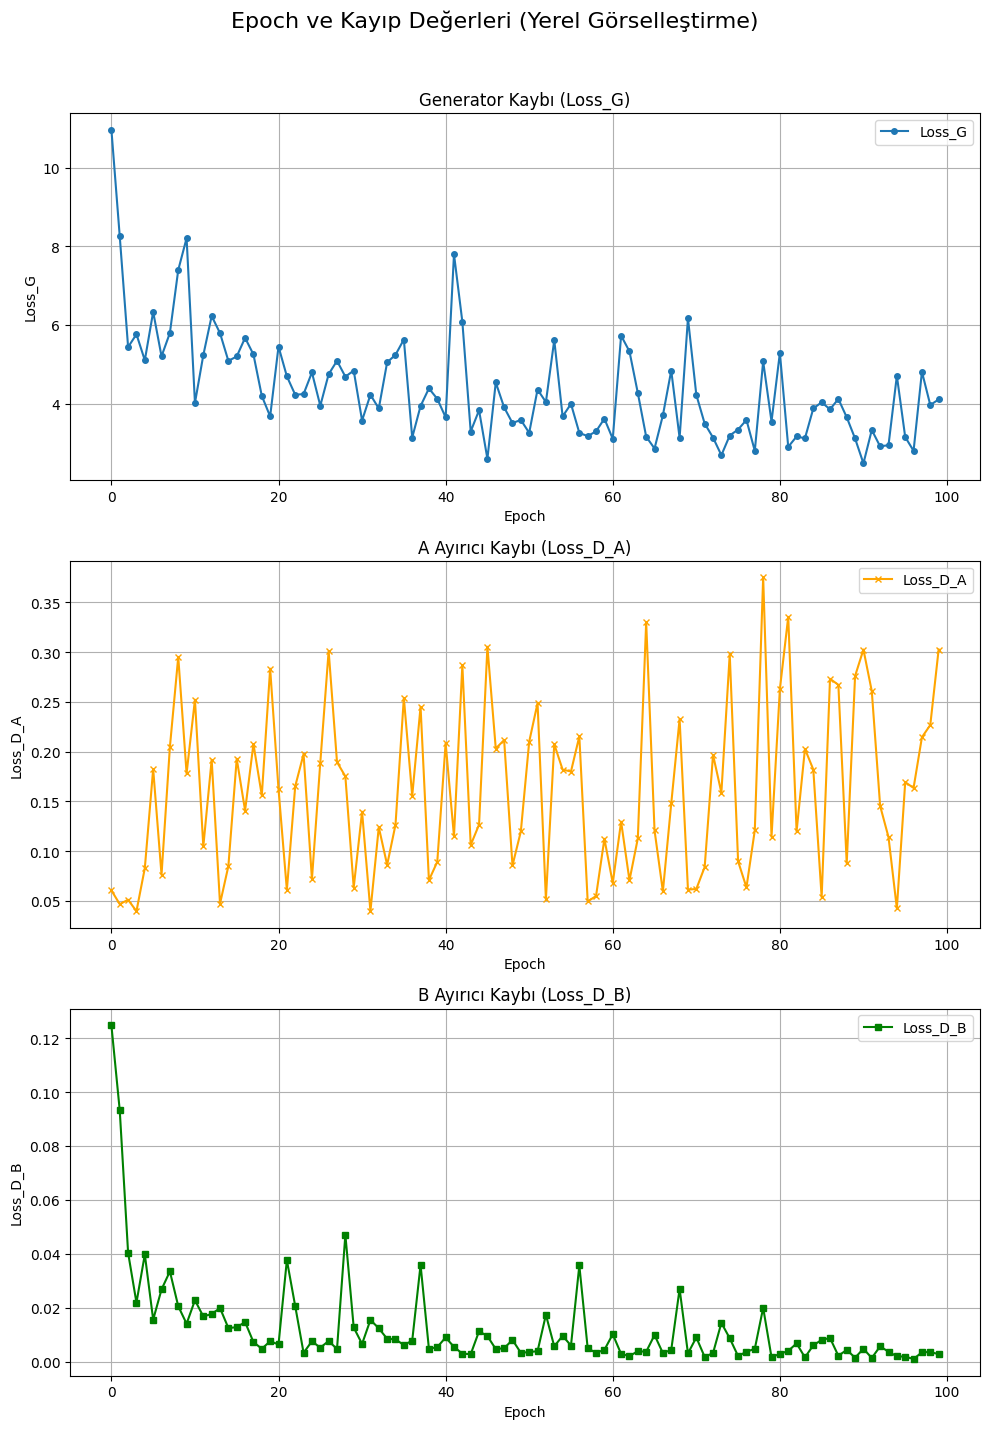

In [ ]:
import pandas as pd
import re
import wandb
import matplotlib.pyplot as plt # Grafikler için tekrar dahil edelim, her ne kadar WandB kendisi çizse de.

# 1. W&B API'sini başlatın (Bu kısım, eğer Colab hücresinin en başında değilseniz, ayrı bir hücrede olabilir)
# Bu, W&B verilerinize programlı olarak erişmenizi sağlar.
# API anahtarınızın yapılandırıldığından emin olun (önceki hücrede 'wandb login' komutuyla).
# !pip install wandb -qqq # Eğer henüz yüklenmediyse bu satırı yorumdan çıkarın
# wandb.login() # Eğer henüz giriş yapılmadıysa bu satırı yorumdan çıkarın

# 2. ff.txt dosyasını oku
file_path = 'ff.txt' # Dosya yolunuzu doğru şekilde ayarlayın. Örneğin: '/content/ff.txt'

try:
    with open(file_path, 'r') as f:
        data = f.readlines()
except FileNotFoundError:
    print(f"Hata: {file_path} dosyası bulunamadı. Lütfen dosya yolunu kontrol edin.")
    exit()

# Epoch, Batch ve Loss değerlerini ayrıştırmak için regex deseni
# Bu desen, önceki konuşmalarda kullandığımız desenle aynıdır.
pattern = r"Epoch\s*\[(\d+)/\d+\]\s*Batch\s*\[(\d+)\]\s*Loss_G:\s*([\d.]+),\s*Loss_D_A:\s*([\d.]+),\s*Loss_D_B:\s*([\d.]+)"

parsed_data = []
for line in data:
    match = re.search(pattern, line)
    if match:
        epoch = int(match.group(1))
        batch = int(match.group(2))
        loss_g = float(match.group(3))
        loss_d_a = float(match.group(4))
        loss_d_b = float(match.group(5))
        parsed_data.append({'Epoch': epoch, 'Batch': batch, 'Loss_G': loss_g, 'Loss_D_A': loss_d_a, 'Loss_D_B': loss_d_b})

if not parsed_data:
    print("Uyarı: Dosyadan hiçbir veri ayrıştırılamadı. Lütfen dosya formatını ve regex desenini kontrol edin.")
else:
    df = pd.DataFrame(parsed_data)

    # Her epoch'un sonundaki değerleri al
    # Bu, önceki görselleştirmelerinizdeki gibi sadece epoch sonu değerlerini loglamak için kullanılır.
    df_epoch_end = df.groupby('Epoch').last().reset_index()

    # Eğer sadece belirli epoch'ları loglamak istiyorsanız, örneğin sadece tam sayı epoch'lar:
    # df_epoch_end = df_epoch_end[df_epoch_end['Epoch'] % 1 == 0] # Zaten int'e çevrilmişti, bu satıra gerek kalmaz

    # 3. Yeni bir WandB çalıştırması başlat
    # Proje adını ve isteğe bağlı olarak çalıştırma adını belirleyin.
    # Eğer bu verileri mevcut bir WandB çalıştırmasına eklemek istiyorsanız,
    # 'id' parametresini kullanarak mevcut çalıştırmanın ID'sini belirtmeniz gerekir.
    # Ancak, bu örnekte yeni bir çalıştırma oluşturulur.
    run = wandb.init(project="cycleGAN-InfraGAN", name="Offline_Loss_Logging_from_TXT_Final")

    # 4. Metrikleri tanımlayın (isteğe bağlı ama iyi bir pratik)
    # Bu, WandB UI'sında metriklerinizin nasıl görüntüleneceğini ve hangi adım metriğini kullanacağını belirtir.
    # Eğer 'epoch' adım metriği olarak kullanılacaksa belirtilir.
    wandb.define_metric("epoch") # 'epoch' adımı belirtiyoruz
    wandb.define_metric("Loss_G", step_metric="epoch")
    wandb.define_metric("Loss_D_A", step_metric="epoch")
    wandb.define_metric("Loss_D_B", step_metric="epoch")


    # 5. Verileri WandB'ye logla
    # Her bir epoch sonundaki değeri logla.
    # 'step' argümanına tam sayı epoch değeri gönderilmesi önemlidir.
    for index, row in df_epoch_end.iterrows():
        current_epoch_int = int(row['Epoch']) # Epoch değerini tam sayıya dönüştürüyoruz

        wandb.log({
            "Loss_G": row['Loss_G'],
            "Loss_D_A": row['Loss_D_A'],
            "Loss_D_B": row['Loss_D_B'],
            "epoch": current_epoch_int # Metrik olarak da epoch değerini tam sayı olarak kaydedin
        }, step=current_epoch_int) # 'step' argümanına tam sayı değeri veriyoruz

    # Çalıştırmayı bitir
    wandb.finish()

    print("\nVeriler başarıyla WandB'ye loglandı!")
    print(f"WandB projesini şurada görüntüleyin: {run.url}")

    # Not: Bu kod, WandB arayüzünde grafikleri oluşturacaktır.
    # Eğer aynı verileri Colab içinde de görmek isterseniz, önceki grafik kodunuzu kullanmaya devam edebilirsiniz.
    # Aşağıda, WandB'ye loglama işlemi bittikten sonra isterseniz yerel bir görselleştirme de ekleyebilirsiniz.
    # Bu, WandB'ye loglanan verinin aynısını görselleştirir.

    # Eğer aynı verileri yerel olarak da görselleştirmek isterseniz (isteğe bağlı):
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))
    fig.suptitle('Epoch ve Kayıp Değerleri (Yerel Görselleştirme)', fontsize=16)

    # Loss_G grafiği
    axes[0].plot(df_epoch_end['Epoch'], df_epoch_end['Loss_G'], label='Loss_G', marker='o', markersize=4)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss_G')
    axes[0].set_title('Generator Kaybı (Loss_G)')
    axes[0].legend()
    axes[0].grid(True)

    # Loss_D_A grafiği
    axes[1].plot(df_epoch_end['Epoch'], df_epoch_end['Loss_D_A'], label='Loss_D_A', color='orange', marker='x', markersize=4)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss_D_A')
    axes[1].set_title('A Ayırıcı Kaybı (Loss_D_A)')
    axes[1].legend()
    axes[1].grid(True)

    # Loss_D_B grafiği
    axes[2].plot(df_epoch_end['Epoch'], df_epoch_end['Loss_D_B'], label='Loss_D_B', color='green', marker='s', markersize=4)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss_D_B')
    axes[2].set_title('B Ayırıcı Kaybı (Loss_D_B)')
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()